# Gridded EO Data

> Standardizing to H3 global grid indexing when working with rasters. For this example series, we focus on B04 (red), B03 (green), B02 (blue), and B08 (nir).

---
__Last Update:__ 16 JAN 2024 [Mosaic 0.3.14]

## Setup Notes

> Raster processing is memory intensize. Here are some config tips.

* This notebook was run on AWS [r5d.4xlarge](https://www.databricks.com/product/pricing/product-pricing/instance-types) instances (1-10 workers auto-scaling for up to 160 concurrent tasks).
* __Optional:__ Prior to launching, the following can be added to the cluster spark configs, adapted from this databricks [blog](https://www.databricks.com/blog/2015/05/28/tuning-java-garbage-collection-for-spark-applications.html) and these JVM tuning [docs](https://docs.oracle.com/cd/E40972_01/doc.70/e40973/cnf_jvmgc.htm#autoId2): `spark.executor.extraJavaOptions -XX:+UseG1GC -XX:+PrintFlagsFinal -XX:InitiatingHeapOccupancyPercent=35 -XX:G1HeapRegionSize=32M -XX:ParallelGCThreads=16 -XX:ConcGCThreads=4`. _This optimization is not required for this example._

## Imports + Config

In [0]:
%pip install --quiet 'databricks-mosaic<0.4,>=0.3'
%pip install --quiet rasterio==1.3.5 gdal==3.4.3 pystac pystac_client planetary_computer tenacity rich pandas==1.5.3

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
# -- configure AQE for more compute heavy operations
spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False) # <- option-2: just tweak partition management
spark.conf.set("spark.sql.shuffle.partitions", 512)

# -- import databricks + delta + spark functions
from delta.tables import *
from pyspark.databricks.sql import functions as dbf
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import *

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)
mos.enable_gdal(spark)

# -- other imports
from datetime import datetime
from io import BytesIO
from matplotlib import pyplot
from rasterio.io import MemoryFile

import library
import os
import pathlib
import planetary_computer
import pystac_client
import rasterio
import requests
import warnings

warnings.simplefilter("ignore")

GDAL enabled.

GDAL 3.4.3, released 2022/04/22




In [0]:
mos.__version__

Out[2]: '0.3.14'

In [0]:
%reload_ext autoreload
%autoreload 2
%reload_ext library

### Databricks Catalog + Schema

> This is for reading and writing out table(s). __Note: these should already exists after running notebook 01.__

In [0]:
# adjust to match your catalog + schema
catalog_name = "geospatial_docs"
db_name = "eo_alaska"

sql(f"""USE CATALOG {catalog_name}""")
sql(f"""USE DATABASE {db_name}""")

Out[4]: DataFrame[]

## Data load

We can easily browse the data we have downloaded previously (notebook 01). The download metadata is stored as a delta table.

In [0]:
%sql show tables

database,tableName,isTemporary
eo_alaska,band_b02,false
eo_alaska,band_b02_h3,false
eo_alaska,band_b02_h3_clip,false
eo_alaska,band_b02_h3_merge,false
eo_alaska,band_b02_tile,false
eo_alaska,band_b03,false
eo_alaska,band_b03_h3,false
eo_alaska,band_b03_tile,false
eo_alaska,band_b04,false
eo_alaska,band_b04_h3,false


__Prepare initial band table for eventual tessellation.__

In [0]:
def gen_tiled_band_tbl(
  band_df, tbl_name, tile_threshold=32, repartition_factor = 3,
  item_id_col="item_id", file_col="out_file_path", size_col="size", bbox_col="bbox",
  drop_cols=["timestamp", "h3_set", "asset", "item_properties", "item_collection", "item_bbox", "stac_version", 
        "last_update", "out_dir_fuse", "out_filename", "out_file_path", "out_file_sz", "is_out_file_valid"],
  do_try_open=False, do_display=True, do_overwrite=False, do_append=False
):
  """
  Generate a tile table for a band dataframe.
  - tile_threshold: size in MB (default 32MB)
  - if you have some bad data, set do_try_open=True
  Returns the resulting dataframe (from the spark table generated).
  """
  spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
  spark.conf.set("spark.sql.shuffle.partitions", 512)
  
  if do_overwrite:
    sql(f"""drop table if exists {tbl_name}""")
  if not spark.catalog.tableExists(tbl_name) or do_append:
    _band_df = (
      band_df
        .repartition(round(band_df.count() / repartition_factor))
        .withColumn(
          "tile",
          mos.rst_fromfile(file_col, F.lit(tile_threshold))
        )   
    )
    if do_try_open:
      _band_df = _band_df.filter(mos.rst_tryopen("tile"))
    (
      _band_df
        .withColumn(size_col, mos.rst_memsize("tile"))
        .withColumn("tile", mos.rst_initnodata("tile"))
        .withColumn(bbox_col, mos.rst_boundingbox("tile"))
        .withColumn("srid", col("item_properties").getItem("proj:epsg"))
      .drop(*drop_cols)
      .write
        .mode("append")
        .saveAsTable(tbl_name)
    )
  sql(f"""OPTIMIZE {tbl_name} ZORDER BY ({item_id_col})""")
  tile_df = spark.table(tbl_name)
  if do_display:
    print(f"\n-- {tbl_name}")
    print(f"count? {tile_df.count():,}")
    tile_df.limit(10).display()
  return tile_df

In [0]:
# set date as variable for consistency across bands.
# - you don't have to filter
filter_date = "2021-06-01"

__Filter `band_b02` (blue - 10m) to a single date (2021-06-01) from all available dates.__

In [0]:
b02_df = (
  spark.read.table("band_b02")
  .filter(col('date') == F.lit(filter_date))
)
print(f"count? {b02_df.count():,}")
b02_df.limit(10).display()

count? 347


item_id,timestamp,h3_set,asset,item_properties,item_collection,date,item_bbox,stac_version,last_update,band_name,out_dir_fuse,out_filename,out_file_path,out_file_sz,is_out_file_valid
S2B_MSIL2A_20210601T231559_R087_T02WNA_20210602T073018,2021-06-01T23:15:59.024+0000,List(585708744604647423),"Map(name -> B02, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B02"",""common_name"":""blue"",""description"":""Band 2 - Blue"",""center_wavelength"":0.49,""full_width_half_max"":0.098}], roles -> [""data""], proj:bbox -> [499980.0,7490220.0,609780.0,7600020.0], gsd -> 10.0, title -> Band 2 - Blue - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/02/W/NA/2021/06/01/S2B_MSIL2A_20210601T231559_N0212_R087_T02WNA_20210602T073018.SAFE/GRANULE/L2A_T02WNA_A022135_20210601T231553/IMG_DATA/R10m/T02WNA_20210601T231559_B02_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37%3A22Z&ske=2023-12-22T19%3A37%3A22Z&sks=b&skv=2021-06-08&sig=ee5UgQFqySJgyNOu5Phr7b2NPQQFwatGusOpTO3e3NY%3D, proj:transform -> [10.0,0.0,499980.0,0.0,-10.0,7600020.0])","Map(s2:mgrs_tile -> 02WNA, s2:datatake_type -> INS-NOBS, s2:nodata_pixel_percentage -> 3.0E-6, s2:snow_ice_percentage -> 0.0, sat:orbit_state -> descending, s2:product_uri -> S2B_MSIL2A_20210601T231559_N0212_R087_T02WNA_20210602T073018.SAFE, s2:generation_time -> 2021-06-02T07:30:18.715Z, datetime -> 2021-06-01T23:15:59.024000Z, s2:datatake_id -> GS2B_20210601T231559_022135_N02.12, s2:vegetation_percentage -> 7.0E-6, sat:relative_orbit -> 87, s2:product_type -> S2MSI2A, s2:degraded_msi_data_percentage -> 0.0, s2:high_proba_clouds_percentage -> 93.012577, s2:cloud_shadow_percentage -> 0.0, s2:datastrip_id -> S2B_OPER_MSI_L2A_DS_ESRI_20210602T073019_S20210601T231553_N02.12, s2:mean_solar_azimuth -> 180.132026122207, eo:cloud_cover -> 95.838119, proj:epsg -> 32602, s2:granule_id -> S2B_OPER_MSI_L2A_TL_ESRI_20210602T073019_A022135_T02WNA_N02.12, s2:water_percentage -> 4.161841, s2:mean_solar_zenith -> 45.8337449200447, constellation -> Sentinel 2, s2:saturated_defective_pixel_percentage -> 0.0, s2:thin_cirrus_percentage -> 0.988746, s2:processing_baseline -> 02.12, s2:not_vegetated_percentage -> 3.0E-5, s2:unclassified_percentage -> 0.0, platform -> Sentinel-2B, s2:reflectance_conversion_factor -> 0.973488199140697, instruments -> [""msi""], s2:dark_features_percentage -> 0.0, s2:medium_proba_clouds_percentage -> 1.836796)",sentinel-2-l2a,2021-06-01,"[-171.00049,67.50737709315482,-168.3163,68.51263213037203]",1.0.0,20231216-162052,B02,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02,B02_S2B_MSIL2A_20210601T231559_R087_T02WNA_20210602T073018_20210601-231559.tif,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T231559_R087_T02WNA_20210602T073018_20210601-231559.tif,203566153,true
S2A_MSIL2A_20210601T222531_R015_T03UUA_20210602T064953,2021-06-01T22:25:31.024+0000,"List(586080929290649599, 586081479046463487)","Map(name -> B02, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B02"",""common_name"":""blue"",""description"":""Band 2 - Blue"",""center_wavelength"":0.49,""full_width_half_max"":0.098}], roles -> [""data""], proj:bbox -> [300000.0,5990220.0,409800.0,6100020.0], gsd -> 10.0, title -> Band 2 - Blue - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/03/U/UA/2021/06/01/S2A_MSIL2A_20210601T222531_N0212_R015_T03UUA_20210602T064953.SAFE/GRANULE/L2A_T03UUA_A031043_20210601T222534/IMG_DATA/R10m/T03UUA_20210601T222531_B02_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37%3A20Z&ske=2023-12-22T19%

For the purpose of raster data analysis mosaic framework provides distributed gdal data readers. While we can start by loading the underlying files directly, since we have the band tables, we use `rst_fromfile` to load 'out_file_path' and new columns from the following:

* `rst_fromfile` also subdivides the images (32 MB threshold) to make sure the imagery is balanced and more parallelised
* `rst_memsize` for 'size' 
* `rst_initnodata` to standardize the tile no data (avoids issues later in calcs)
* `rst_boundingbox` to generate tile bounding boxes
* 'srid' from the raster metadata

__Notes:__

1. Since this involves a bit of computation, we persist out as Delta Table to then use multiple times below.
1. Operation takes ~6 minutes using the configuration described at top of notebook.
1. We also OPTIMIZE (table layout) based on item_id which will help future ops.

In [0]:
tile_df = gen_tiled_band_tbl(b02_df, "band_b02_tile")


-- band_b02_tile
count? 3,682


item_id,date,band_name,tile,size,bbox,srid
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10390934,AAAAAAMAAAABAAAABkEYaWAAAAAAQVktUAAAAABBGGlgAAAAAEFZEn8AAAAAQRoWcAAAAABBWRJ/AAAAAEEaFnAAAAAAQVktUAAAAABBGGlgAAAAAEFZLVAAAAAAQRhpYAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11604712,AAAAAAMAAAABAAAABkEaFiAAAAAAQVkShAAAAABBGhYgAAAAAEFY97MAAAAAQRvDMAAAAABBWPezAAAAAEEbwzAAAAAAQVkShAAAAABBGhYgAAAAAEFZEoQAAAAAQRoWIAAAAABBWRKEAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",163345,AAAAAAMAAAABAAAABkEaFiAAAAAAQVjc5wAAAABBGhYgAAAAAEFYwhYAAAAAQRvDMAAAAABBWMIWAAAAAEEbwzAAAAAAQVjc5wAAAABBGhYgAAAAAEFY3OcAAAAAQRoWIAAAAABBWNznAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11450378,AAAAAAMAAAABAAAABkEbwwgAAAAAQVktUAAAAABBG8MIAAAAAEFZEn8AAAAAQR1wGAAAAABBWRJ/AAAAAEEdcBgAAAAAQVktUAAAAABBG8MIAAAAAEFZLVAAAAAAQRvDCAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAA5CoAAAEBAwABAAAA5CoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBADkKgAAllYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwDkKgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211_20210601-204021.tif, GTiff)",12130662,AAAAAAMAAAABAAAABkEST4AAAAAAQVktUAAAAABBEk+AAAAAAEFYwhYAAAAAQRkDIAAAAABBWMIWAAAAAEEZAyAAAAAAQVktUAAAAABBEk+AAAAAAEFZLVAAAAAAQRJPgAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",5531427,AAAAAAMAAAABAAAABkEYaWAAAAAAQVj3tYAAAABBGGlgAAAAAEFY3OSAAAAAQRoWcAAAAABBWNzkgAAAAEEaFnAAAAAAQVj3tYAAAABBGGlgAAAAAEFY97WAAAAAQRhpYAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11699927,AAAAAAMAAAABAAAABkEaFiAAAAA

In [0]:
display (
  tile_df
    .select(mos.st_astext("bbox").alias("bbox_wkt"), "srid")
    .groupBy("bbox_wkt", "srid")
      .count()
  .limit(10)
)

bbox_wkt,srid,count
"POLYGON ((382340 7100040, 382340 7072580, 409800 7072580, 409800 7100040, 382340 7100040, 382340 7100040))",32602,1
"POLYGON ((754850 6000000, 754850 5972540, 782310 5972540, 782310 6000000, 754850 6000000, 754850 6000000))",32602,1
"POLYGON ((454850 6772600, 454850 6745140, 482310 6745140, 482310 6772600, 454850 6772600, 454850 6772600))",32605,1
"POLYGON ((527420 6000000, 527420 5972540, 554880 5972540, 554880 6000000, 527420 6000000, 527420 6000000))",32660,1
"POLYGON ((682340 6945130, 682340 6917670, 709800 6917670, 709800 6945130, 682340 6945130, 682340 6945130))",32603,1
"POLYGON ((627440 7017700, 627440 6990240, 654900 6990240, 654900 7017700, 627440 7017700, 627440 7017700))",32603,1
"POLYGON ((427400 6500040, 427400 6472580, 454860 6472580, 454860 6500040, 427400 6500040, 427400 6500040))",32609,1
"POLYGON ((600000 7545130, 600000 7517670, 627460 7517670, 627460 7545130, 600000 7545130, 600000 7545130))",32602,1
"POLYGON ((554870 6645130, 554870 6590220, 609780 6590220, 609780 6645130, 554870 6645130, 554870 6645130))",32601,1
"POLYGON ((482300 6545110, 482300 6517650, 509760 6517650, 509760 6545110, 482300 6545110, 482300 6545110))",32609,1


## Initial Tile Plots

> These are samples from the full data.

_[1] Tile raster plot._

In [0]:
to_plot = tile_df.limit(10).collect()

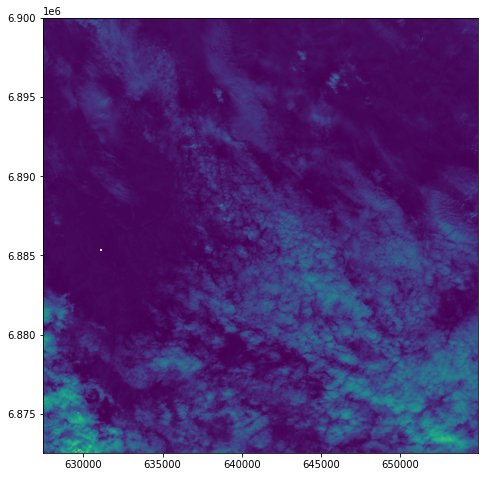

In [0]:
library.plot_raster(to_plot[4]["tile"]["raster"])

_[2] Bounding box plot._

> Just for a subset of 'item_ids'. __Note: we specify the SRID for rendering in Mosaic__ since it is not 4326. We got this information earlier.

In [0]:
to_plot = (
  tile_df
    .filter(col("item_id").contains(F.lit("_R014_")))
    .select(mos.st_astext("bbox").alias("bbox_wkt"), "srid")
    .groupBy("bbox_wkt", "srid")
      .count()
    .orderBy(F.desc("count"))
)
print(f"count? {to_plot.count():,}")
to_plot.limit(5).display()

count? 425


bbox_wkt,srid,count
"POLYGON ((454850 6845110, 454850 6817650, 482310 6817650, 482310 6845110, 454850 6845110, 454850 6845110))",32608,1
"POLYGON ((382340 6972580, 382340 6945120, 409800 6945120, 409800 6972580, 382340 6972580, 382340 6972580))",32608,1
"POLYGON ((627440 6645130, 627440 6617670, 654900 6617670, 654900 6645130, 627440 6645130, 627440 6645130))",32607,1
"POLYGON ((399960 7072600, 399960 7045140, 427420 7045140, 427420 7072600, 399960 7072600, 399960 7072600))",32608,1
"POLYGON ((399960 7300020, 399960 7272560, 427420 7272560, 427420 7300020, 399960 7300020, 399960 7300020))",32608,1


In [0]:
to_plot.groupBy("srid").count().orderBy("srid").display()

srid,count
32607,257
32608,168


In [0]:
to_plot_32607 = to_plot.filter("srid = 32607")


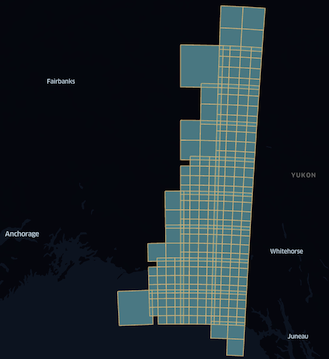

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUkAAAFnCAYAAAArLLvuAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAFJoAMABAAAAAEAAAFnAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdHwbc5AAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj43MTc8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NjU3PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CgElDgQAAEAASURBVHgB7L1plGTJdd8XmVn7Xr339DLTM4MBQJCDhdiIhQS4ACAIguIikiJEmhQPdSjLPJLlc2RLto70QbYlyx98TB+Lx8fHtCzapkjLJERTIEhwB0lwJwgQgDADDjDo6Z5eat8yKzOr/P/Fy1sd9eq9zPcyX2ZldVfMZEW8iBv33ogX79839tLo2Oy+i7n9Uiwi6VG5spAlZY3HxeWVWhrF4+P5Tsoz5Ukri5U1XpY0+jhdp+dQdpqskIfJNVp7Dml6DRvvJD555LXjE/KGZ5w2lBNPC/MOIhzqgrxe9Qn59cprEOUfdhnlrhUsCiETFOAlhy86geRERVGWpMaaFGcFa5dmNJ1844Fv4Sx5stJ24hWmmw794B3KsXC8/YTPYdjoh8kfdv2Gqa4GoctIlhdCw4ZuUA18EAUfBhnxui+qfu19dSpj0jvFiC/637885UqijdeTlStR/zbKh3yS5Bjfk+7b+3+YyzjIdzTSSZhVtPmd6LOmWwMPG27WvMNOZ3VlZbPnRL1bqBTSWL5E+g6Rxsf8JPKQfxg+oEWnAl2vwEtZEvWM6ZhGE8/frm5iLAt/rJRLbmSk7PD514i6ae61KlweYXB+f59CR+K9dxBuBUg6iIvowr/HWcZQj4ch3BEkaXhFV7g1ZvMfhoq0MrSrK9KszIfognZvfLrxD/HshkG/8vivvjfmVnfmG7es7TOez/IP0i+VSq5a3ZXIakwsFYTDt0+SkbAwXmH9PzJa9tgIr9GRKL0swK345IhmT0ALxuL2FOBHJh9lfgthjS6iPv2bVAP2RpLSTuNy1kAWkOpEYyCaVXQnfkl8DgCDryb6zg7IQn55dTlg0qeA6WY+YtBx2PRMKj6WY7Vad+980w337rc/40YrshqbTaFY091f2nDCPFevN929+xuurIfVjR1X3dkVlJXd1nbVNXbrbmd33714d0dWaNntNvbcjqtJFGDaSBBp0w184ga4vOySKwlc0SeyagFYxet/5OK8Zau2AbgCojx7y9anDs8f3nvYFvql2UiakH41PL7LYXXUhVV85vIrT9S0jpYqrW6PUnYX0wv/g7wpLyRz+QPVrf6CqL4HrRxxfS3eFIinW/yg/FFZgNXqjvv6r3nKXf7KN7ibG86NCyhnKvtuQUBJj7tc3nOvULgkZBqt7Ak/993kiMLlfQ9UE0rf3twRcAJae259s+ppd+t1VxLgVoSF1d1dt7G+7Xa2az4PALwuwN0R4G5t112ttuteXhbNTtPV9gBXfnuxaqBF8wNgQaKKGwXVh8jZ+8SPv+ui1Ry8JUndD6Gzig59exFp6hqtpff7hZm8Tnpl0cdjY0oDy8rf5OCbbmHcIMPIN72PW5ekcst+89Hzs+Pu5qpzP/WCc1fHnatJ6VJp1KdVpPiILDwox1qYNKYHDWF6EJ1U3AT9aoHkmMCzPK7xTeXZmyq5b7zW8Fbfn92vuEsje4I3ga1AdU/gOVLa0/vZ84DrraLdmqsKLKuyTrcFpnUBa0lAudcQD4H0koC1Lkt1aXnDrazX3HMvbbmX7qx7a9crOmR/eO/9fOeJIGmNrei66BffovXMwi/+Uqxs/XphobwwHOpqOnSKS0uHbxKPkD4pnKZPSNuvegllZAln0TULn7w0/h8lZRqdmHQ7qownJvbc7GhJcIezVIVag4Qtz+3JyKupVw40rtWdW/ZWn/LxrvQfmPklDXG+arbptmsl97//5Yh7cqLs6vsVWZYCXXWhMQLB3HGBrTDYTau7PSYLdoTfTMlNju67GSEBcdMiXJSFCcDuSPBjcyX36T/6pPvnP/ERNzuzIGCVMsfoummfvap7BCRDJYpqUCHPXhVOy9/tBx7nR3OlQXZylMnqJyyfxXXKn5Ye5g9lpNETH8pvR9cprVc+veaP6xfys/cb1k+cnue09LT4JB79jGN8j661bDsPd4TbudZwoSdhnmYk1joByQUZoosTjHGWvHV6dkxhoWgEtJGPmLp61vhbGttELmGAlrB69vJLvvNdKo3JYt13L++W3N94Zk9gG3XHmSwaVkdb6dc7PgKSVgn9Emj8u/VDvcKPqFt+li/kRePJ4sI8oV5Z8mahifNMagihDll49oOmkw7xcnSjg8kwHx4h3zC+G/6DylPClJPL2sZCvZLy+Dj94UPWUKP3G3pOAl8DXN9jDxkDMK1n046pniaWpjTdrcmEHRLHOw/fddgG+qViKkiiyCAU6KVgw6LfIPUIG0gvdTeIvL3US5ZyZqXpRY+i6snPGGuWuVKpeAvPQKkI/iPqVu+rkPuqkCzGngfWUDDAEz4TloJNMZvYb2iMcl0RFU0ExSd44pkG8zzo93kEJE2BI5U2mPL3JAXds3w4PQmJZbb6ikWf+MewXIOu0xNfebECAIh+raKQZ1dd4nW1U7rONu4YI8/1CA9NnHuQ1IS1H3vMxSCFGL5YnOVS0zU0ieNRU3GPosOqTnS82KJc+MH1ypMPtt1Hi6wi5aXpOyg5ofxBlMvktatjo+mXX5Rs42N+v/TtxBdsieas97zFBgAV+X0BZuDYtsYcCRcBvpSJCZ+6ZsfvL2/qqZLYhYfuYXepIDnsBafht/uHrShASeKTFJdUX71+nEn5s8pO0idvnK/jHr7mJP076dBNnpBnmJ+6sl8YH9IPIkwXuKGuatmNaUuiutsFCmXCZVJjhwBaTVZquaAGgo6afHf7Asm1tW09AZJFal5gJfSZ1ZHudj/k9auB9vD9dixm2NbCcMeMLQIrs/lZ88XpyB+Xz3OvfONysj4fks030+ElHJee8fLE6zCe3s9nrMi6ZlMuzIxrzLDiNjUP4i2+HoVS9bwCuu5M1Ox4kGxvPGQRCV/Ad0az5JOVhlte1c4ekB5hj6DruyU56I/E5JnfzTvt5YNCbi+yk/Qtml+SjCxxVi/4/qdMFs6S/1GlAVuY1d7VtsOkWede6oWZbNY2TmsZEMAGwBXhMBqxJJkU2tF2SkCScjyKrm8g2Q+wyPqCegEVA4LMsrIS9kgXL1NePXsUf2KyD2O9YITtCSDPaTHj+MSoB8qiwIwX4/nvCYQb2Wa3s7xMloyz+FzaunuyJMuYvo8oTPYFJOMfdJaXclw03X5UB/8IqO1YuN/ljvPvVvfjqutHVa4HRG0LXJifdOMaPPTLgQpCScBsUtbeuMYlsSoLYuut0in147c3ttx2s6FtkNEun0fxHRYOkvEPuZ+V2ossAMZAxvx2uiIr/KXRZuGVljdLfLzMYTmy5O8HTVynfsjIynOYdDmsM91V9lJrfLJZLgTMsCCtu70jK3JbM9zqeRfifHdbh2w0mrY2sij4LUS9gTIpDCQNQAaqvYR1+1HE8xUBNgaQ5g+yLorQP6++jFHF6zEvj0eJ3h85dgCPxY3wlVlM3qpI83utV/hwqtDaBjPbDYUfXZDsaXZ7WD6QYdEjbJgGlP3QDZ7G32QWLSfO3+SYX7Q84/sw+tGeZ3W35ybcxPiIlgNxMEUxoIPFx4lAVfW7mRSCa69A6cc4xYRj2jY3AUmdOFSMuify9XZlSfKB9PMjMaso9K12Lc6eu/U7gUA3fJPqpB9y0C1JVjc6p+Vpx79dWhq/Rzk+ApimW5ybdDUdi1YTmnX14SVUogdEfY9VLST3s9sFgRmd7CmBJGdbelcQ34QiDH1UT5bkoEpnH2WvgNNLfvKaHnnLHcrtlkdemUXQnyRdiyhvv3i0YEaWng7PtYeChHGa0LSOOmPo0EYPe2UNHvp1klpWxKQNzk4t9w+P2J+2IMlHEn7gJ6Fu+qFvHrDoVGdx/fLwjtd/KAu+vfCK8z59Lr4G6HYX1Mt+oJzeO4vJ2W1T5BpM2tKUDuvd8t1tAXCRzB9ofyJCbUGSEoQfoj0PumRxYEmTn5UuLX9SfDfAE8/TTq8iwa1IXkl1cRrXXQ1gmelLchOT2nGjEDPQLDsMu9wYmPxIt7CC0YMPPPhDOg5algDNj2v5j8xIiyetF+dntjVGsLdXd6vrO2L16G5JpB7bguSwfnR5QChrYzlooLQ8uSxlj9PwbC7U0cJhutH16sM75BvXqVf+g85vZbE6yyvf8ufNNwh6ZojvV0vuy/WSOyfLbFcLwGkydG25psG2KrLTBQAtqTDE6X/vbPIkjLO0RkPHsImS6xmIs6aI78MWEbE6SG89HvE41Zx7dKoMdkobG5o8QvgIRLQFyeMqf/zDb6dHYR+FWlbYjjp9pIXJVeHg1Uleuzp4GNPC+j3xdeORjHHDsnvFonP/yWjNL/7e03pJxhI56mxDWOT3XutlbmgXILckNFXwTQEqY43Q1QWEAOqWwvgA6aropvUVb+gKh+d16C7d+arAF2uVbjiAGvkReKIKYEs8Ds//gme+hGmt/2nozpsv31wSxajkh18HOXt39l7Dd9071+wcTH6YI0mXTCAJs+P8kE2+FSapIJZ2nL7pmVT56GXpResY53tc7+q45BZdn8XzA4F08+HkqNsRGL64UXZn1UWe0NfHYnBdSePOTey7usBvhFsSRe2tS+2iwUE3Jhq61LOaTIFuW4vHR5W+prMnrs3ojpqxPfePxve031qySBd4Arocn7YloDWwrSsf8Vv00+XqEgE/3ejgxzS5wgFAntYlYzoCyG1ucU84YU9eyJ/49xF/7uf3HZeVpUAdQdIafjfMsyiQRBNWksnFD+Pj+dLSLX+7vHFeWZ6Nb5w2Ld7owvSidTIZ+PAOZYVpvYRDnUP+YXwv/OFZFK9e9Cgyr4rk3bRA8rmVsvvFW6PurJbX0N0G0wAoaLAMoxsTI/ropkRtOVSCP7ZM0ZMKc2sidTSmWe260GvmWt3d3i67lzfL7tykrlwQzRndxKjjNHSwBt1m8RWgTulrx4KEH+sqkQ1oM+mjreV+BrshEIW+Km0uj+27JUxcZVJUYQ7dw7YTMu7nu0+TGcpPCncESTK1K1QS017j8hYmiT4ex3P4AuLpvercTf4idYiXrxt92uUJ664dXRFpYb0MUm4RuifxMIChyzqqvu45gdsZfXnREbxql0EmoyUq6uHKshOACaq8Y2k3ViautFNyK0r72it19/nlivvNeyNuVgCKdQoNgIi1yUfOHd8TAkziplpA629LVDqgOzW65+Z1NBqsZwXgC7J0R8V7ZaOm3TYiKBQmB48pKkDXLhNIho22a0ldZjSATvtY8uiWh7ZLdY81G+UL68nq7liV6lF4Ee/MeIR106NaubJjsQEyMzMT/sg0W9NoYNeJGfmFa94BV1iVOMYWZYyqeywg1TOWH4AH0LVIfBjLkLgGFqP8Lf28bFWMetYC4yg/4IqcJfXBX79Yce8c39Ai9V03PjmtPedQFuuytk97f6H0Qb7LjiCZpGCobD/DVhHmh7KS9CIuiTbMlzUc55MkLyuvQdLF64ByFKF7yLcIfoOsE2TF3+cg5UeAte9mpwWSXQoG5OIOoBtVwTiNnC4zNMQl0ZL3YHach0ARZtEtimjOp7ww2XRlTFi5gNQ/P6x/0tpIW5A8zo8hTWFeUDu92qUlvdx2cpLoT0IcdRCWi3DeekkqZxqPUFZSvuOMi9fFseoik44Z6jQQy6MbwEV3nEkdwI+JHPx2vNPSsDTNwZeJnLJMynW/RrLpD7do4aWRFeYX1TY7KZTWdsN8VAPljzuz4uPxhXxUR5hmiKDS2n10WQqbQcwhEnja71DCCX6I11O7Oi2qmHGZRfHNyidexuPWJ66337US9b3jSV09YzVi9Wk+yANm0geelzHqARYsS9rZYWZbS4eKYJxBkfj7syxhPOHw2Wja+ZnbQUo5E0EyM9N2muVM66bwOUUkkh9HWRMV6UNkvGx5G1cfVOory3h5TVhavKX3249OAXJubnYisvZAoQIcbDyoyfKrtSzJAtj6LvuClhM1dgHJSEYRfOM80D/LuzGapPZLWqdfXG67Z5MV0hwBySSiMEM/wkmFT5KTRbfjAtskfYchLl5nWes6j+7IiMvJk79IWtPD/CJ5d82rZaFMTekUIBZ6U19dM3uQkakUZqwnZE0y6VKEQ1X4MhvOjhtcS30fLvRPi3HaNxu2q36027SyhHKhOQSSQ9WwpJwpa35aoaySw4pMikvLH8Yn1UFSXJhn2MNx/cN6Gnbdu9EvLK+1g274FJXHxvyqQrJNzYWwA6ZXhwXJQvAZD2ayJIVnhz7mHgQw1skyoaZZkv2DybZa2rtr116z0JiQkNbCltbOP5i4CRtWuwz9Tmunh1VWSGNx/dArlNOOf1yHrPna8Sw6DZ1CPQm30zOkNV3a0RvNsPhx/U33ePwg9eXGRIDMQLMQ2XqvG+pqMw8N9hZhUJalZ0WHW9xf3hDHij8kuBBdY0yKfhfGz951KM7SwjjCxCfRh3QeJDsRhRmKDofKp+kR0oTy0+JDmtPwgxqgfsM6IxzWeZj2INfJC7UrR7wOBlG6aN+zDqCoVDxAFjURAtiOaRE4S4AKQUdVBjxH1YV3OiZtdzfqbheL6r3XeNhm49yoCl8d/IuR08XzWVs5sCRz8iuM3BRJKziKx11SXJzmuJ7TynFc+sTlWn3H4x/m5/g7GWQd8K1y2K4+XR1aUXLrCtLdLsqahP/Gbikak+Qh4XtRbGZH9hFZkvV6wy0tb/LkZ84zM+iBMP6e2rGKA5rR2rvthBEmy+hC39LgSfjYQdIUsULG/ah5xWP792yVZRLiz2EFGk1SnKWdFD9ezpOidyc9h+PdROhFW2a8j6ciHKeSM8HCUiBsviL4At66hkfDAs3WWZLlFsgXoXE6jzzvydqq+XAN8xMmTf8XUikeJD3DImoYpVouLABRYSGMJpMvvXxhA+I47yApMRinz6pLPB/MLS4rj0SFhiiS8jwsZaFax7TAr8JK6JapFpbNnwwuGnuH9hogpUvMJxC2NZ6xAlusjNz73E+YFE9iFB9x0hEWrXWG8ltjkocY9fCAnHHts65qTBLw7dVRXsY2pwS8IwotLWuneOlkniUZvvd29WJ0+GnfwoEleaThUGNdujivLtkkZusn70SBKZFpFZpCPtTRw1KnvVYSY33bm3QRo+10+fgJGQ4gksZvqMMnkvQxEJcynyxgOcgCiY7YmRqZ0DFoI25HR5uF3AgfPCtwEFZ86EwbD8AtOuL8iUDyLT3M000YsGUh+YjGJVfXdEgl98oWxr0bjVQnGQpXxPdogBnX8gAkw4QMOoXkh8JpBSqiEIcEdflgFZGmj6Ub+7TyWPqpPxw1wIzsrs79+tC3vck98/Qlbf9rRpaB1OP4MaxIDpHd23swGQHgjGrRYkPjb3fub2grHseERa0fryywW17ddDvVXYWjI8QADGzOuvbuLa9sRlZi64PhvEcOi9jeqrpare7zUDtYqeNYt1hlomGv9K7oDBA5Ks3TyTeL0MO8aEgCvllbibMj08YEYtviNaUThbb9mCT8IkaQ+p8J8DmjPy1Rh6xgi4OCMEdJjmniZlsTN9TBcbo8319IG/+OrQxGk5ZudKGfCJLUbVhxYYa0sAlPSycemjzKtePVS5rp2kkfo0uSNQzlSNLrUYwDwHaFUOfnxt03fsMb3EuVS25jZ89PkDBuNysg8TO2B7AU1RJAOK80rjy4JEDAEvUgqfiKDr8FH+riS5fbtxX55OGea2aUmwwG4oiXxz3VnOXoJ2p8kv7of2AZHS4uTLpXu53o5HEtKkfWlrrKHIoLcHKmIyf1+DMlpQzdaCBqR/FVAFh51nWMD3qSNibk5JqF0n5Z50zqnhvJQiV8+ym7B250sNODmDiCb/SPRwtQ9Uw8+WYU2N7Ycpv6R2VickzlJHd/na9fyccRzuPsW8ybL6uMRJA0oVmZ5KELKyNPvqJoi6jIftZPUeV85Pjow5qSCbStFdZ/cHff3d3k5G7VAoCBjZXy0nyayEbLIx4AI6AUgAh0ZFgKTACww7VJdxTLzke30gBPdr6YxWdZ8Nllc3266d4zt+s+emve7dQr7sZ03T05v+3+YGXan0yOFTitAxyhfXqm7q5N77o/XZ7Q+OC+u6AfFma5vBcdPiGmI6WmB7Qn5wS0U033o3PaRtgyQzlQFxAFdOG77wFZp5MrrilFOQyDE8t3BM4N1csutPJrksGqn6bkNPp1osXhqjz0lIQNSa+tiG84SdYhZYKHRJA0BnFlkhQ2XqTF6S0t7hv/eHyWZ9Mhq6x2PI1XO5p4Wjd54jxOn/tTA/SkAbYZmUw1LERAsuUAK2HAEUd85A6nAnpJ8cSR1tqx16KJABNw8vkCYQBsTebdmizTqk4A+sLWqFsVKE2NNNxF+X+xPubmBIJenP6syJKcUOOuC/A+fGtah/NGFiLgi+VH+XATyrMqfj8yuuY+vzHm/mJt3J1RmUsCOMYTKfrkyJ7Pw73cUwq/YaHqnhddE+CUrIq61OMVnfIjWrrv3KuDrhOa3r7/HPu266pDAavie3FJ2JAUh4wivut2uqbJDfPEdUgEyTRlLXMaUITxRhsKLzIcykrjW7QOWWSm6XIa3/8aaOGHBwA6iB7M+iXWhAX86cIeWJ2tdJ7pAlcUAOSuTTTcGSl3Yaruu+Hn/WLwaIsh3d11NbJpxTV0aZgMQJ+HMVDKw+G6OOi2FOa3J55b9bL7crXi1tRX3t+P/mVAF/Lg74juwnjTXZmsu194adaDJKDLEITd0jiuMFbrrirttef33M42V8lGevtAj3/4dux7zPMdkScPPWq2ozcd0oqTlJ4KkmlMiM+ieFgpIa92BQjpigiHspIK30lGWIaQV6d8D1P6o1rubt+hvunDrhXBPusxWZNvPLcp8FIXWqfsTOn5O66tyDrU+KOAjLHRdVmHFyea/uKvv/rYpgcypmT2BJr6/PWfxiVlgfK0rTwA7/RY0z013fDgWVN+rnpgDBNHD5x/LM4IeAHGTcWP0AlXuKH8mr/WE5wjgL8nA/IVC/pjpjKJx+zs2+3UFkk32iSVw7Q0XnEePHcFkmkCkhQjLi99Gp9e4sPC59EnD20v+g1j3hNX9iH4oOPvEZUAyAV1m9d2R9zP35zzoPXVizV3aWzL/dKXRt0l3ScDkDEhBLi9+6oOwtDz7bVdP845rXgWeDN/wm2JXOiF45IvJp4en9xxi6NVDTNEliMLzKsCVSxYbkYEDKeFkOOyFN9/cceDJUBL+qZAtSqa3RYIl2SJcpPjbTuVvIA6BZwG1ZbS5GQByKhWj+qaGyQ7KWHpppQ9mwLH6Rehi5UrqRwh/5AujE/Kd1xxpleoq+liafZ8Ynx9kEPlBDJYf1hx2wKjkioW646uLrPaS7tlP/4IYDHeeLNacm++2HRrO2X3/+lWxcd16yETKuQBrxgexIrEjWuc8YdeWXO/+MVRd79adnMCTOT449Pkjwhco33Y++5VZ5oCWfZjC1B14dckX75e/J7CLH1iVn5K9GydvDZVcp9hjaScrZjyDz38SWpj3bJTVfi66CZ/N+06M0hmZR5WRtY83RS2yDyhzvBN0jtOU6T84+aVVN5udQrrqUi+3eozLPkASn9xAxWkimH2vK5eLV1s7t2Oxi21JElfJOu3AbtzsgxZOjTVAkgDB8DSL9VR+pisRp4VjO65ERHjmtFcCx31fXdfYMx+bFdquP/jhXF3XjLojSMbOdzpDZhOy9Jck2X5nder2m2zJoqKB1YFCnO9tImwbeVVCLnd5s8Ekt0UrJs8eQteBH284uJ6x9PbyYQ268sw2nb8+p1WlA556qhdmYxP/B20y5OUBpgMm/PrGfWhCo88QKGfzVSH+tI1P6NbD7leBuCkG44VGTqx8UuBuD8bkMT6Y4II3iAmwBe5CARZ1rOoMdA90V0Q6J6X9eh5Q4QMPFX6psB0W35jv+m2d7hXsbgtib2+U1RNc1nbcbc6HAJJmFhDTVMoLb5bBdL4FRFvZUnTzdLTZHVKT8qXlIc40yFMD+NDXmnxIU1R4VAf0zEP7zB/nnwhbRE8DvELH4YgDAiNapJmq1Fxy7LUKC+TNlvaosjky7RQMOqCe4zzayVXtItmUqhHXg9+8gFCHB4z3CxoZw0ki8yxPokHVM0R5IfVyTimhQFIfnEXddVFrwWW7CbCkvT38sQJcz5naVchTTftIUueUEaeIozEM/KcRWAeIYOmzaJ/Gk1afL/KkCaP+Pi7KUqHkG8ov0iZoYx2eofyjS63HqCDXBKvKOV4/6JeUxUypxnmrz+745a1ZGdBM9JlGWtPTu9ph4u63gCXLD0mZ5ixxvpjLJKJHH7wgMaPTerhnqy+CxMCUnWRb9W0+0YgyY4auteAHfS+hy2fPKyVrGNx6j/446DBib0Ps1NoQpkrWqi+zOEWAskQdKEdhKPt9ONdwjPOO0s7PWRJUgGhclkYDKLS8soIK+KkliFvmbult/qx924NqRt+xitP3vBdWb7cfPjmo+/eWAyZHyl3Vkt7WHSzK8vvjNYtntUOm/nJPQ9wUxpUBJCw8C5M7rt3jdfdV1+K9gNxXiRWJIu9WSsJCFY14bOgWWi2hL/vCl1jp9lzZrK1hlIz1/g1gTEAuC2eaFAVsN7S+iB2DHHdA8CNY6+27/qL6Lz0mNQC8032QkbJnqbbP1nfZS/tLo9u1s4tj8mNx1s6/hGQDBNPcjjry8lbxjjftMqN0+WVA729wG7y5s2DvmllaadHEeXslUea3nnroF/0HHoxq3HGT61MuA/fnvbmzA8+vu7urpXcL94edReVxuQNQFUVUH3nUzX3uXsj7t52xU1rLNGPNyqNReZ0s+c14+1kQZY0uz0m/4a2JDKTDYjyDNhyHzdgyrglY40XNPuzLvP0v5hsyrJUgmj2mpwV6dyqMBZwXtGEdknblJjk2diITgBiZWYvrl3bifM12kG/z07yjoBkrw02XvCT+Gx1EK88i+9UpjS6OL9OfEhPypPGPwu/LDTIREaS7Cz5B0njdZSuw+yAmeiKBVmQmmihW8vaRyZcRlXRrNtebxluOyIGsG5rKdBnNspuaqs1Uy06kXgAhN8dAdsHLjcEYQ33X3963F0R0BIPKLItkfFMlvXYRWHvv7Hrbm6V3QtrZXdmQl18PzO+52aFAIuTetfKsyvBc7JsSxt1d2er4UbHNcOTESTDNhlvN9aexKyji+ftmGEABEdAMi4zSemwQuL0J+WZMiSVLdQ/LGcn2jBfv8PoEupWlLywTuLlted+yO1Ff6/PkIMk5aPbiwMAhV1awC0LTz+6vnRr+RABuXmBJ3FYe4QZa4wcqZEzCzECWueuCiAXxADeUDFTrVPjfHhNEfcl590yGb+0Xna/eXfE03I8G1YkwIsIFpqj01efLbnXui3FNDQZpH3eMO3grE1YG+lAfuKS24LkIAsdl2UVPyw1mkefQZQFGXl0Kqoej0tuO/19PQwxUAIznBAUjvGhLuAUQhDdZOKZvOGkHsIAWZJjXJOzJKH1gAdtQAiQ4hizXFQY0GUc8oIAlYN6zbXI/CO7fDjpnHM50cxm0402ybc2GG/zIa3RhHEnKdwWJOMFGURhByGDcqW91H7IT5MVr99heKb87fTtR/30XO4WkAyjboAQ4Mduli0pCJCxcJtjz+L4RxqWI2sfI/gMIYy4w44xzJq67ElAarwxBDm8gu4+Y5NwhN7SjSO8vFUpf2OTwy04cBfqU8c/Zh0dja/fDXAQMqyg7UDAaAbl91LuQZej322g5zqPf/k9MyyOAao1NFECYDL5ooPNdYCuxiT5tlp6A2jcL8Pea79APEU80AWg+dlt8rehAxCxYgFe1kuSN81By1Khao1j0h4cy5ZG32t8L22/V9l58h8CST668MPrpRAhHxQy3vH4PMr2m3aQIBCvW3vOqoPR96NOsurQTra973Y0Rae1A4CiZeXlF3Wl2ZwYObq/cQuQNOxLTifnUIp2hpwBa0PLfNIOFEYSwEv3GpD06yQlRFGJDuCdV3dc095RuimbSN0iaTFr1x47tYV2eduIHljSIZBEalEfCLyGFRDtpcR9dD4Jroh31KmcSTKssSf5nfj1NT3Dx9xX+R2YgyMcKAHooSrdbfZN08W1/dNYl6RPC8w4UBfHuKLPg6/n8EfXfLo1WAY1aUmOeM9NLxTwTQNe6ABtZsSburYBx6nsWVz4nSe1G+Nh7cae4367vHHaQT7zjgp1cX48U3h+Fi5U4DEzy/NirW465bG6CosWz2O8oImnhfl6Ccf5hjLjfJPS4vnjeXhOymd0WfIb7TD7gB3gw06bdVmIWisuC2/f3dQ6yCV1udkBw2jhbS3ruaETeFgM/oKWAJ0TCJJGKh+qQZafEVeB8VnjyBpLHKBrNPbMZM2i+ADM7OARBnuX9NlT39NcALYVHbjr7+pp0XfyeI9FvC94wGuYXOvfovwqWUGyVEwe2vyanJwcWerKSmO0WRpfGo3VOzyNn/Hvxm/HI5RVlLxudBzGPIwFjsuE+4bLm+6ZuR2/4Puidtz8lSd0Z40qFSuSLYncNXNWCDqjccFvv1r3gMcebjAQ4GSrIt1sLEJmv7H8mOXm1kRtkvFda3bagDF+wbj8NcW/YnZPl49xLFvJn2sJkJqFaqBJHFsS9/caukoWkMy/bzveBsSkK0c7K4pXVwrEMmUGySxKZ6GJyT997FAD7YCpQ9bE5LR3xId1yAxJzJ0eGTbsPDqH+dK5n+wUQBCL7jOr4+4l3XEzo50zM4tbbknWIpW+oB00LObWtdxuRjtsmDx5qrWLhgkeZqa5r4flPhxUES3vKblLU3taCL7nnr3Q0KVeUXeZC8A47ALQ5ezKVc3BLIiGLvwbzjY8wLLjkPFJJoc4qRzHMOSKwnUFqlUxEzT7NuFTi/1DG+zURoapXRw54CKpOtI+rCTapMLnyZ/E8zQufw3E6zz+HOfI5xp+FUnvMZ4n/txNHi92yCyHeLl6ecbao6vrtOTnRV3Y9YmVcfeMbkp8ata5j7005k/8AYywFl8WNn1Qu2i+6nzD/VPtornG3mzqRmncPwMdkzDsqmFt5Hdo++JntH1xtVZ2EwJeaAFYdtOwOJwu+uMTyuPj9t2bL9UPlhjR/ef0ICZ2AOFtya7patozOtziznLLkrTZIckt2tEew/bSqX0WLT8Pv8yWZBamYaFD+rT4kOY03FsNpDWypLpPo+1Ng95yo2dcL56T9D8iSXTD7AArutWc4nNO+62x6rDy2DI4q/WTgCAAB/gBcuzBflwAabtoKBvdZ+gAsy3xYZEOXeuXdIL5Z1YrAk/2YUfrMAE+wBmeL4rwB67X3eXpkvtfnh9zT0zoKgjJYekRFikyRqUT937PT+qkIl1Pu7TMjpvizpIUs7Yu/t7bEh9DYqEgeQz6P5Iie21U+paOAFK8IpEB3SCdyeu1fIPUOassjDIPXspgBhq+/vcO349PCsCodn8smvxWb9jT8Adgo55mBbSAIIDKVbJYhsaN/DhoAcPzzBTJzSlcVmaAFr7Iv+WTKn68c0EzQFcuNd1uVciqQUvT02fuw5/jaGPdFCMTSFrj7UbAaZ5ia+BhBJB4DdHeHrZyYgeqWH5BNwA3LeuNLjPHlEUQFll/3JW905qUideLPQO2mgSPlusoTH4sxyRXYzadrYYafxSeeh0ATz9hI58jLJjEwSpdENiy42d1PToB6IFmSZyLiTsJ79n/+1NMcfNzoYLSfvm5Pdw5rJ6KKmWWf/hMJv6gHfpl0XHQeuWVB3gxjljRry7AwgFSzDYn7YCh8x1amEnyjOfB1Q1JRLE4rm6w8yN5nYd+emDmnHWXpXpNR7TpBCBvssaYPKKPxwaSnT68TumP0vsqsi7gZb88dWh5kvw8fIqm9frAlK9+CB1qMTHCeGFN17bSRQYIsdxCB3wStaAdLxFNmHo07KdxBLodF4gr67zMRUCwHe6hJ+mbW9yS2NQMucD6qNhHMubYQLJTbT8MVkSnMnZKN0DqRNc2XS3d+OA/lG6IywX46Q34Li0Lw/ngKprpBpAAQ/q/LQ9Cv3ynrntwolgfdegPXWO66QuawebcSM6fTPuIqRbk0D3f0CaadqdDYr1y73e9nv0EoEOKPcQPmcYkiy7/w/qxUq6s4G51kEZv6b3WPR/gqTueGqDumYA5K/BhSc6KdtxwEdi+Xq56tAIuDriILgFjLSXdb9/Vlo8ZB/hhXfp3qD/4HmQVYEKGBeZ0vVkXCV3SRAsnAPGvJKcFeVAWXdzBF5Gkn54AFK8d/WN0NKr/MQBDJxCw9DQQQcuSDsuLhsPVSPwt6rzqyI2OjenWt7oaThQ3Mjrq96Tas9Ed9bUDYmTENRqaAszhTF/8djrnYHlKmlIDVtcpyUMXTQvkwq63nKlq0XfZLU40/IETr1loRt1uCAA9dcfPaWE5PV4sRHbSYAUCnoAgYQDtrsYzn2ml3dYuGrYvKskDJ51krEfovK8AWyB10LiflAFksUZDZ4/+BCBmtsUjDVDDfI9K+FhAMk/ltgOdelWLXvd5qfpXcGTKjU1o5axaS12DzzsbS64yNi3AG1Oj0PVLm8uuPCqa8QmB564G0kcEsrp8XWBIOmEy13drrrq1rrwzyjsq8NX4jGgBYcKdXFEA2Y7PsIAEH6b/GjtVyiOcDgBRT+yvflKLyPe0N5qzJSfV5Z64uuvByE/EqPvMez2ndYxcDvZPzmgpjpob93VvCRQZU2T8kR048FvUOkqW9nyv1kD65UKK9xeBKZFzI/XoarJaxwSQLA/alNW5IX7coWNbF20iZ0oyXhbYzmpB+obu3PbOkDN6eqT/HgtI5v3Ik4ASi/DStSfcE0/e0AGmZffpT37SrS/d8i9zdvGS+7pv+w73mx/7Fbex8rKPe9f7/or7xMd/y4PlxMxZ+Us+vjI67Zr1aLCaiPlzV91r3/CN7k/+8Pfd5sodV6pMuHp13dOOTs5rbyvN76hrB2pHqdXQT3AjPMm6J72LfsYBaHSll2oV91NfmhcI7bv3Xdh2M/L/3y+NuUsCO4BvRl8i2wW/7xW77jktDv/SWsWfLVnRkiDGHrHsZjjGTP9zohCTQWwc5BIwZJRFA1hCyzNnSGJJ8k//ooD3W3XHDWDLFQ3sEcea9DPemvxZU6dpQ7bGgq6oXWPvo9zpgbu+GvyfgYFkXmB8oOLRENbg9vo99/f/0T9x5y9cdEv37qpb/a/d9MzbfTf5d37919z5i5fd5atX3aUrV0VzwX3g27/LPfWKZ9wf/N7vuk/90cfd173329zs3Jz71V/6iHtM8a945avcndu33erKsvuO7/mQ+61f/nfuze/8Rvfcf/i8e/Pb3ubWVlfcJ37jY250ciYVKI9qWnxMkfXYjXZJANlJp6Q83cg+aXmEQx642FkzpzWI8wK8MVmDrEXcFSipL6M91lGpAKlVhRmvXJdV98dc2KU8zX3uvo5mmoEvQI9dNB96fNfv/f7nnx13T2pGhh0zWIx+N42AkovAAFYszm8RQH7iJUxVdcnV7ceSnVUeJmoW9bug+LpA+/JsyX2OTeBynYelPNkj8ecISBbd4Dvxy1/LNL3IMe74W7/+MfeLH/6wm5ubdW9405vcs697g7vx5NPuytVr7k1vfbt793ve6/7sj//QjWpM8lWv+Ur3xre+zf38z1xxZ86ec299x9e6r3rt693E1JSbmpp209Mz7qO/+GFX3dl2H/qRH3OP33jKfcP71K25eMn9+kc/IqG6UF5WazPFmjS9+uUXX5f5Ne1GB8tTFFjCx3iGJcCCGionPVnuw7bEdXV9OeQCHYVHBzPSWHSUBUDjLEmsyk3h1DkBJOsrozJFfykb1iFP7M8m8LRA8JwAj/FK+JK2L+uQS8ZYSE7Hm4Xkn1qpuB3xVnbFRHu26eaD0WNS4L5o/s7TO255eVUxI5kuABPhI+H0780Dl9TwHqRGoSw08TxFPzOGaO4d73q3++4Pfcgtnll0W5tb7u6dO+6CQG18fNzNzc97K/N/+mf/2NV1kOh//mM/6j73F59yr3/jW2RxNtwXnn/OzS8sCEDH3P/4L/4b96UXvuAuXn5MFumMe9+3frv7nd/8NffCF55Tt6Thxie47PjkOwCmKLDKWxu0nb61H5rEg2aRV7VUelgCPkyeAET8ABf978f98HEmPvT5uAA/4sgHwBE31zqMwi8JIg6a1s/4iiySoQjkhb9dvcBZgSh5WA50oFcrD3n9NkVV9ll10bmLG9ksG5rXb1F5zyv+ogD2in5cDnZdzbuswy2qNZYAna6RpA7NMbThGy5+u48n/LgsjzEZhI9Mc/tcVCyHVfczP/Wv3P/wT/9L9853fYO7/sQNDW5r5lAAWdYWh5JaX3WHE030r/T0tPuBH/lbAsHLPu0tb3+nn6SJaMvu0mOPOWbAmazZ2Nhwv/87v+3e8y3fJqvz37q/fP55hT/o+dANCUHaRw7ZH3tXSf6QqVqMOgKAfjjYMs5HF/WsjjBbGNtzc/pxQAWG3JgI6IoBUlU1yfCH1cZd2ivCnKosOlrsfY0F3tIP+i2d3POifpzxeF+/VY0XAsQAJrtxWLJTU37i/Oy2fP3vHXqx7Kch65T1HeTx44+Bb9aPXyoEv1ZmA1sD1oi/Mur/ep3DLTbhrklKkxbJfJT/HnS3DSDNz1IpnYA1C4/8NBqg1tIe3uoffeJ3/TgiPP7tv/m/3Ldq3LFarbov/eXzsiIX3KrGEe++fNuL+I1f+ai7JhB9+dZt9+P/3X/rfuTH/o6bVDf79377tzyo3lH8p//sTwWQ625leUng+G/ch37oh923f893u8XFRffhn/1pzweAzHNis880wD+Z3t9D0P4pp/3D2Y/iiL2fUebMxq/XDDLHiDFRwj5ojhjDIZdJmXHNVDOzrKbhHZ4HQjXThhRdlKX2+My++9C1DQ9+1zXLfabcdP+RkIz1k+DRioAM8MVCPD+hGXCF4c9kC3w5JxK5xAG+3roV8t4TCHN5WNSVV7oIAGT2hK8pbb81kcPhvOOtCoOfgajXWXk4p1IDSW55ZVu5GQeVd+p8DZRGxmdzVYc1TKu/Th9lnN7ydeOHslgjWd9ZE5uyG5+ed7UtwjSPo25i6oyrbi8fJJTLk2pwkYV5EKlZbNdkljtyI+MzrlHjX9UHbkyz29F6zAdxgwxlqcuwjpJ0y8IjKV+RcaGOoT5hfB55zMTual3LNe2/+4f/8HvcxzcvuSW9Og6qzeriHwEgsiZgevuFXff0efVYXpzTxAvHjD2gJISIaQGagQ5xI3q2rnRVFuEzczV3abLuPrM24QHxbed33Ipmu7+4PeLHA2cAXmUcE+8bszX3hY1RzUKXdQ4lM9fRLDYTMgAXQLqmiZsb+mwZu/zCuuhUiRyKQbewqXwgKTPlqwLuJzT7fWlmz/3cF8a81YuFyiVjLAXyVqX0ZanRpAR8x8V7MiD+T/e521U3po3hp5M3qhy5A0syeuz8l4YcNmzCaY07pOvMuT1FXAZLcabmzvsF4ywaH5uccyOayKEl7WnKMLL4dBCp/mPt49TMOR+HlLqmFke1DhK3R9ddH5lfOzkxFTVKATA84d8ULxaX40MzzC5eR6GuRb6LkG834TRd2rWlLHLodvLP5LoAY0n9SPWMwYvoRztNYGKWF11nAM9o6L4uq6/NzhjWHW6razsi4tUWgZLpofqfSA7yKejj8NFnWbpMc7eCCvcLd6bV3gSaM3X35zp892NLk/58SaX6wy+uaJH5d4033EduzwnkZFkKNOlWI2eyZRECyIDcmfFN9+WdEfdidUx7s5lQ1Kx1RUMBslrR/YLoLqn8F7TmclyKfN11hgn2/IJzrF++E6xPuvRbatYVDU9dUN/8jo4yLyH0UIn0+Ai73CBJXfExpjX0rHUZ/6DT+MXpQv67tcjy84Cohd67LC6POf61JB2gDJ3lDeOae9qho7LRaHFGw4LzYXBp9d6ujkzvtLyW/jD4TGhMCgG+TidwV4UAZdBCjr9lAYW/9xoUJUJtAhzAG1EawMqCbZJwxLOm8PEZbR0UZjw1s+u7wMwM4zy4Kj8WnzlSwFC62t7XDhriWKSNBXpJPt3eSL4mcARaxFt7Y41jU3nWd9m6CG+GdqKLwkwG0pbE492ScEeW6CdWxtwZLNEWAXrhVCQtKSq5b720pckaWZK3p718ykK1TEsWNGNaltTUR/K4LM5Rtf8V/aswNt4VLESCH8K/XdcGLxEHuPGz5yj28N92aYcpHzx1k+dB7oc3RL2k/YPyMJS6U1tKKiPdQoyfZfUx//1H/tCdm9NOKcUxcYc/PjriFhemffcR8PMopcC+wGF8bMTNn5l2MuA8uEUAxtIZgK6kmd9pNzt/3r1urh7NGOsFgEPMGMOraaAHWzmAh3FL8rIUB8A8o0u/JgTeP3RjxZ9EPiXQGtWY5NO6FAwem7JSATe60nOyCr/pMieDi3ezIn6yZgV2TP4AkFiYG/qhH6JvTKrXJJ0AWiaOiCcMLTt0FiQLQ+Hl3Yp230STQ0ryZYAGfTn8gryLJYyOhupSW3pbi8qhfdTdIZAMPz4+xiyuE12Y3s0HkEWHNJqwPGk08fhB6xiXn+WZOu2mbFl4DwNNWLaw/aTpBmjRW2BI5P/5pT/VEzE4n9LyzdbyCZn/fN+3vMG97n3vdz/9wqi32GwrH+OH1hUOmQE8TLrgACC2A77lorr+WnHxp8sTfvnN2y9uuOfuOd15U3azmjUXlHur9el5jUFOaxJI/d8zWprDRBFd4zNansNZlIx1ArpMBgF+Xzm/5V41p9l3/48B4BiBJ0AKzVaj4sdCm5p0+t5L297aBGwB5E3R1GQF03Wf0Ngli87rbPAWFcB96h7UAOtcC3MhLxp32MAtDT+ML0x4gYxM12HV0/SzIp+EOjVd++nzbbMpAMB8AJCRdZX24UMLmMUhdGy04u4vrWsNbWRHTAv9JkUISMHdQ5tl4hsiUo70ZQEQDsBk1tp3sQVGL1VH3H2Nc75G3ennN5x+FTexBVVJY5ei1/j4Bc2C/7ubGmfUACkWIKxxULGPm64yS5K+/5ma+9iLI9pOqCEGPZM+h6pKH1cXGnu3qf+enWvqugaNq2s4inMl6W6XNCEE6GJps57SA7Gmt//y5Wh7LmdJDscAk8ozBO6QJRnqE/8QSesEGqQn5QvjOvEwHYr48NvJCnUymSfRb1fGsDwntby52oEQpR4/zTashBzhJminrueYuuM4AAtMJJYfLoLCMBCFWUOJA3wBpXnNIAnL/PgjVib5ACauceB0cSxGeEfd8Gi3zaziTQ68zKEW2xpJ81fC6lShbU1SYR3eamXQaZXiv+++WC27rz5fdZ/Tbpuf+fKoe0yTOsjh9kax8LPp7PFmTeQbL6vuNlj+c+riNZAKknHCVv3How8924cY/3Djz4cyFfhg8mHZSWaYHuYrUJ2+sQp1zyLkpJUvS5mSaKiXosoKkOGmJ8dzdz/DbwVwxfqz/deAF8uDAoj1gAfdiMYybQE5YEZc6NCJfwMWZBGyrpEj0Dw/EE+0ivaOfdxEXdF6yxFZleVSxV1lMbzQG54AKg57U0amu1ejC65Zc+1C884KHz098n8zgyT1FntnhVZe2MDzggCK9PJxmLw4D3u29EILPABmpv8ARLUVcaT+1JDC79DSh0XfsDCAx466zN20fcuDv12vuHuy+iYEWg3x5FQg9lY3xZldMXTJATDWPrLLh/ppYZ8P23AB1qk/6Uc0rImkuwyt1SEAyA+QJT9rIFlXyTw7ckkLXcSPveCcORmBZDSyGVI92uHMIGkvYdirqxc9yTuMH2o3dX5c5chU/6rn2LfatoiUJRNfcenHO4xbdG2VDRIBL49g+nN9pua+SYxYjnNO3e8nGSuUWQhoccL4qPrfHHqL1akTy/zY5paQDh7QsH0QQGOB+4K201SEml+uMuUT7a4hH7QsLCcMrf04NMOujvD1Izpzlm9c3e5Sa7svfE7dgxrIDJIPsqSHsjbkdA7ZP4Y4jyJkx3mehOfjAsN+1I1/hwKDpI80D1AWpxvLfGRXJSmUUQhjiJw2vjjV8OOQU7Ikz2uB91drxpvJE5YSGQie1bmP7Kz5W1+pzQ/qejMzjgOkOUoNPbZl1c6q2wygfpe2S0K/LgOQNZWs2iHM7ht+HLsGULIXnFPOsRMBTP0fdbtV04yHviwLt9yo+Ykqwam69BJ46g5qoC1IDhp4Bi3voBZOA8NTA/qo+USPHfwjfIqQCXTqAjfIQle6KtD55duz7lfvj7vXzDTc+y6vuJ/+/JgHNiZyOLV8SUD2fp1UPi0A/OWbo+5qCzB5MWOyPlGHJUfs9Y7GNQWUGmc8o4HIS0qki17R4nS612ZBcmYkty/+tWd04K5AE8DeFNhGWxNFJ5576rIzAz+n8csaRwp5Z37r8RH3UkHyFLCGv2UcO5D0sYpof/Hy8Tzodsmy8F4c4MaumTEtu7kisJtjeY6eK7IiZ4VSpDF5UhOIMRPOxM3N7bKrCvXs5J59Dt4VH7rMdzRN/p6LDX/a+I9/btwvFUI/ZstZGqRec7QkSM/XpvfdN13fdR/74pgH61FZpxVAWT9ON58VgI5Kn0s6bHeq1HB3l6PDLY7puFSKMZQuFSSPo0HGPwpqbOAfRcLHOZRvLqdS1GNS/eZkM1DyuM6DbAuqLjkdkaadOlHIe13/YeFPQz+6uuYsjOWHqYjlt6GZZhaqc7KPeuktFwE1lh86TamrzZ7yywK5RZuxJqWF58ykbwt0N7XPkjHHz2vROjtqkAMoQ0aP2ne7FdjT7M8PXNlyW+tavKnjHIb5lCspOHCXCpID1yQmcJAfREz0ATAPAlRCGUWVGT7G1383esaF8VHM8P8tqk66LSkHP8i4686p8pmJ5p5tkIku8Yyep2W90bPlODN5/ocAJme4cxsg4/yfI0ODomcnDRYnadDTheYXOsCQWXOuf2Dck2TANCKL/tIk+LGMaFJgO6FtkksrWkze5dBCKP9hC0f/OPVQKvsYe2BxkJUPwn4HkccYQJdBuVg7zyQ2ST+LO6jHWBkO4jNJyEdksvPlGnJqgQgHY+BiVdlRcd4p44ccvME2QDrNWHZMpABwIT+ADuuRXTXt2gLW4oS6zZwvGQfHUCF4lKQ2wOwtRvzgZ+DqtzuKjgXmO5zoIYQl76l7UAM9gaQBZOgTTvo9EHnyQla+vmoefjE5BBnomZ81a176NL7GB/+hdCqXdWO7KR/VQn5AKZolF0CCWoGDht90azE5QJrkPC8lsEsHnvo/1ZHOeCOyAMcUlp4Hk0sjuur2/tqOTk4SJPRS4FSNTm7CQXebRp4XDMI8efOe3CorXvPjBBiTnfb+LN1KnUZn6Q+jzzIgJkbagVcM9w5Vg+0PJ7KsrjfdYQ+Y8kEpwA7+LONhHaR1w6GPO8CW08ujBe4tBnGi1jOpW1qc7q3WFFIszWkJr25u67QhnVakgzWjLZkpTB/B6JHwIyD8KH4EWd479RLWVZY8WWj6wTOL3JAmzzsP9c2TL5R3ssICEIHXFzWIyNgkgOOPQZNvDoAE2ABRosEjQrplSYdNsNaSnTRlv6uGw3GZwaabu9fqWpOHmWu62oAl+ZmljixPBVoO/n48Us8cgwad/QJ1PDWLhpjgYda87ZiqMnIcW73OKso4F8/qkf9zYEl2UxOPxkfyoGasvCFQPEg9mSErUzfaP0z1cKT8oI93JffshbqOEtOd2UIuopk9bgh8Wske2FZlsbH+EGCjt0rqOkfpqIK5/vWSTh0HhDg9HJCc0a6bMVHRHeYdaPmin2xhC+Ga0oWhvotu444AM+Obf6G5FbrHHHF2V/w5LQgQBFxxWKk4dJhufd2MqaVawaLn/u2NVQ6lbgqosSThcOqsBo6A5EPd8K3UD7kfAl+79xnSpVUJNO14pOU7zvi4vlnKGdfX9i9fPDfrAakqjGPWeUYzwSzRcbIrpwf5AABAAElEQVTS9NeD01mdxeh3vBAhh7XIj/WPjAey4+ZrLmx5cJzVF8fdNdd07w1sOJ8SfvjssnnXtbr7mscaftE37OhWA7zoAzC/X0B8VcepNXT02QcuYZFG1u2GLFWW7nBGJIotS/akdKwq/039sFQ5eR2wRSeuq2AL4yrYjZwdjkmLrF4fcfrnoAaOgORBSoYAjbGbBpiB9SlJDzUQvhfeD8+9OHvHvfLpRYdu8pre3eS1PLruyH1uacT99Jc4SUdnQ1KfJPJH9YrFBs5g3dFFJtov+yFNYQ7H/cCTDfcb9+b8oRZvO7fjZks77uO3xvwp5XTVsQKnlfmd13bdf1ge0fUNnPMY3cxI9xorcF5AvC8QnVd4Ujwv6YDL6bGGXyokFt6CZP81tHTzAc9F7dphB87fH616gCcOsG0KbNnyyB033G9zbU7nWb4YoaVZovAs2oXtp4h3U7R+afx6Ask0pknxRXysSXz7HRcCTr9lFcnf9PbfMn8CFzbWILpjsJd3aB9Ft7I7KhcjMHmx6MyPgBduR9ixq+7yEwIp9kzHqtLTCJcOxfs6Vxzdb9YnsrulLguv0brzZlMLxl/UrpqzsvSiZTmMT+65N0vop1fK7oubFX/2JOOKgDD86AEDwvcV+K+e3XG/f3vUffx+xV2UXjgO3mUJEVYpoAtQvv/GrrunQzCeX63odHNdBCaQnZMlDNieEy1bHBs61OKsxgM+0RoAZZKpXy5sP2E76PVd9Utf49szSNrHaAzjflgZ8bST8typjMNajjS9u22U/XyXplMRMoxXEe8FEMMCo5sKUAFaWVwEnFGXnHtw+DFBQnasPW5C5HAKwNjfw9P6ErH0AE9W4hj0GmwRpZ52BKzidFF0fiYcHWUZcro5QwKA5BcEjm97rOSeE0B+9PaIOydaFqJTBpTAYqS7fV95fugZjZPqvvpBuPDd2Ls2P0wbhC5ZZfQMkgiyQmYVehLpKKO9RPOPo+wm+yTVuelMfYXhk9EOojFBwA2wws/jAFmc5eV2RDq2gC6QCegyOQOwcTYkgIkFmVRPACqn9gBwnEoOa7M0MQBltHpBgPBlWZhjAkZOMb8gf95bwS1loJODjtn6BU0mvVSNbhPllPLjctamk8p+XDoh1/97lVeBbgrRTZ68evWb3l5imhzKaL80mkHHd9K5G32sjOZ3wyMtDzyHyglIcC0vesj4F1DDWrRlOwAakzMGbMYGkPSnAakLzOG7abLAL3/uowg41QeQC6uLMD/o4FFXwB+4KwTFgkRO+GNmPZrNbrjlVW5o1L7tAYJkWvuhzfaj3aqAXbmuQBJJeRpzHtquSjHATPGXZy86Xsb4c1EqHlcDipc7LE/RZS2aX6jroMJYdnRvZzTut6vbCpkkwQIExPz93wRaDkADUFn7yAx20rAgNGTxu2P8VxswUHzoSMGCxHGuJN38Q2gaJfm/TBAx4lljXZKgNZ1rkKngIOoN8zvvGiQLrqcTxa4dYCQVxBpB3E+i7UfcIBp+u0aet76og3b8+lFHcZ5Nf+90RUeLacd1DxVIVj+rDMq1HMHg0QMkFicTKYBlmGZ58COLk/u5o+52Gh3GIGOegDK3xIo8EfzQjRPOdzUFvrTMCUCVgVqSEnjIHfc7P6RM8HAIJNM+4jTl0+ID/g9tkA+/069T4QdWfy1dO+mTlh7HiG5Az+oqLqMbXnEeRT8DPlGZdTMMDz06WLAOkl02C9pPDXgZGNJlBvy4DpYw2wT97LTCPMd//OvBJBBWJ3z0/yHHMzYhC8m5LMzLSaAjE+BP972sHMsr0VmSvfyDAM+H0R1M3CR9sGEc4aQGnRYfVlZSvjC9UzjUA9pe+XWSV3Q6+sbLYDKy1J/RHpsf+xLTypJFv6R3165+svDsB00EFtG2vs0WcHUDINyAyEz17EhTXWDGBrWAW2sT6TZvCM3E2i2pS8x6xmWtj7ylhd+LMgWZUMExwWNuWzRXJ7XoXBbnuvJwcg8gigMwcYA6PWji0beho9cAXUuHBtaQI2NSIMni9h3WOikzacPi0tpF2IZ6aYtJ5UzifQCSSRmyxIVMs9BnpSm68FnlHgfdIICyl/rMm9foe2kbveY1HXp9n36sUMgBqOR3EeRcmmy4D15b92sZF7UQ/Nx1595xFbiM1mHClwmdBc1I/+1XVbWmMrI62SUDyO3JcmTscEnrKxdFQ93cmGv4tZDrAlUcY4+cKI4luqLwohCSCaO7AmQWwEPF8iBAlGVDfm5d8VPaDcTaypU1LQHy647QKtm1eyfU96H0lsxkTsmxh/K3SIgr6l0mS43pHRCZPgcgmUWZuLLGJOA7kOCRFxKT2ik9Rj6Qx7Cu4vU4EAX6LCQsn4mycialGY35WWiMdpA+4MIvHTrStcEKBOieWx9zv35nxs3KAnzPYxvu+fuKWxtxl7UjBsd2wVed07nlOq7shbWKv5eGwy7GtWxnRpeG0R1f1CLwK+I3quU6AOrXXql7a9FbjlKQcUpAkLFIgHNSNFws9r1P1/zZk5SCnTaMV3KnDWViu/akBkOb9V23sl13I+MTKmh6Sdt9V0feXxeVZu3FV0qbP1np2rBITQp5W5kOQJJcRIZExikp3hgYzaB909P0sGfTI/5s8fiWJ4zLE4Z3LzzIG9evV5559C+atpe6KFoX+MXrtisZfOQ4+qkCMXuMIrP/BXI4jIJTgDjTdke/l7Xb5oWtsntpJ+pM3xVocdkXs9C/cGvUXdBXGZ021BpTFA/4LOlAi2/Vvu7XXWi4f/nZcb/onEvE6FpzfBoAyNgmEw3XdGVtudR0Nzcq2tK45+/VHhPQzij9caWXBKY1oe+c+ttrN2uurkJOqqwNELmNO8ntNK1YaWWy+EMgSWTc2Qdgfjw967PxzsLHaLPwzkNr/MiTRQ+jD/1u5IX524Xb8e5WX5OXlr+dTMvbyTceJgPf4jrlLTRd75XZ2hENwjWFGDTnPOAG/b4sKeysyNbiuXsNycsCcXAWIOMCLjCI5UBYlX7No9hzVQNhHAu/z+irFMkhB48p8YIHw4ey+bR4XMe4sTJdbk3jmZT1pn5cFvZNsiTnZIV++KVRd1b8AF1AVP/7MUqusq1KmTdfcO41/uav7OORvFt712KX6I7l/Sdq0jmyU1kOgWQRjbtTBYaV10m5zsXrniLU03SK62PxSElLi8d3r1H7nO10aZ8zPTXkmU6VPQV+Vh/mZ8/dOyULo2uaAanV2D1C08amyuqAD8HMCGilsAcO3Uctnnu+mxqBbsgNUMKZHz1FEUj2wCbQ42QeusWeThVDvD3jA6bcow2I+Z/yGqAZT7SrK69fmC4ElUHqnU3chH5TvNjZQzHOK7yoqoiDLrqUZeGSb3V9R08a45TSWY9JC991pMmDv0W3Kzhbe0ribWkPNIhCSbRxGv9M5VIhcvCK5zsEkhHZg79pwh9QHA4Zc/MPpx59itPllXeUY/6YUIcwHOeUlhbGhxXcz7Igs5/8KbvxD8sXr5Nhei4LbWoyq65cmHFve+3T7v7Sutve2RXIAVd8BQ+86CH6SwrAABiyXvDuvQ3hZNntKHzl8rybntB1rI2mP8AWGWwHNMckCb+4A5Cgut86Y3JfB1vcVpf6rPTgv3V1ve/J2mNmGbp7SgMUN3fLftYaKxOL04DPS9QfwJRDKjg4A7G+ZIr36XrGGej6A3dFZ932eC8aoAZoGbus+i2J4ujRW5Ew79L1u72E35ip2O33YG3c+MR9S+ccz6H5IEJd4gr347noFxry61SWpJedp4yhLPLZC83DI4025GXhuLwwbxaakL7oMMBgSPGP/u43u9mLl93ShqZ141+7kIjv30AF0OHcx9FWV5eudl179eAHaI2r237t3JR7y0xDM8DR9azMNOPgM03XV0jTuj/LgxjjilsCPdZEAlBXpzUeOL4j2qbvUl+barg3nS+5r5iL5LA8554M30tT0fNXzTf8VkZ263D1Arr4U8zFz6+hFDKiGzPYk9Ldzog0nSjKSwJgDgjmPEuWCs1LT/TFGQ7aPx1MAu3UqKsWwPqAwpbBpxz9Y+88nkJ8p7zxPHmfk2QgM65TEl2cJkl2PN+h6xviGZIEQxNWQhahcb5pz0XySpMxLPFhHaJT/MXk1TPtXeXlk0afpl/4zsJwGp9+xHO8167Q4olzk64yPeN+/uaUu7s15Wd8233rpGGtsduFsIIeRAiwYHtGkymzC7s6kmxWaw+jw3GNH9aijnT0y2cU9AAJoDH7jAOMdmTJXa/o7hiNG+7ImuR+G3SdmRpzE1rvCEhz3uRlZbkikAQE33Et0qOiK17ZRw0fxiEBZ+gfn2368ce/+xqWCkVLf2qtcUnk7qlrvylwvT6jk33E99mFhh94YK83E0hYwshRVj8RxFjoto5Lw0nUgUt73xAM+j0nyUvSr+hvwL7Rtt1tKsQITVF7Ji10afEhzaMUtvrKU+akF58nfx7abt5XN2XKo1PXtPro+cL3BSpYgjKO3LjGFJnEOTChYsxbWXzyoUPClEC2hnhVxIPdiUu1iu8ie3ZK9wfsigawieBFYCtOABpXO+Doot3RGsdXzdbcUnXM/eStaffa6bq7MFHX0WXTula24heDQ3tX3e8fvbHmNmoj7ufuTrpLGkdk6RBrI+HG4nEsvy0B3Hsrm65WH3Gf1rKiuVGgTiCqqyCQzww35bqofIuatMGSffvVSDdgkfWQGh31cv05meqDX9Z0+CciNh7APcPWH3vf3bSVkE+/wvHvxfRtJy+pLPF8cZqOIGkC4xktvkh/EDKK1LdbXu3KGX/x3crolM/kmN+JfqjTI1zyQOmD+rMPosnFP4CwHAAKDgA6cMpGTmalQUsmQL72XM2PAzISiOXJHdo1WWURKEb024pj0TbZ4AtYjgtcoxPG99xTWlD+mO658af9iIiDb5syDelue/CSzzpHgFArhHwX2/MRL7renP34ksD06y+U3bL4/vLSuLshcGSsETp0xgfAvyy6f/D0qru1M+o+fGfSXRYdoM1aSvxJ8Wc9pVYg6YTzbbexzr5tFqPD4ahrV4dHqfPFJPFu933EuSflD2nC9Dx8Qx4HINkNA1Ogm7yhEg9b2Oola7ni9DxnqdN4vqzyjM7yZ5Vn+YbOj3/b8ecuFcZKBBhny1t+yQ1sF/y5jFiR0ZKbkl4UC7854izCmAg8R/14Zdldmmy6cwLHH5quyvLbUxd9333zY+sefLe5j0YOi/SGxj1nZRl+b0V9Z50ahCxwvikab51Kzq1qxZ2faOrq17J78/yu70bvqhuP/birOOQDmjOSgVvWRBDjmUwUYVUCtjj+kuu+8rxxYcc1tJjcx0TZIOnaZWm3IXPorR1avD3n5WX503z4dsPzACS7ZdCN0LRCPArxWeur2/fRax1aA+2Vz3HkL+AbP1Ab4OLkb4DyZ14Yd7sa08NyBISwJiN4i0CUVUN0dwEfdICOAyaWNTb4N1/ZdF+qTro/kOX39EzdvW5x0/3qF8t+UbdfpiP6uizKC9cFgut77u5mQ3fTRBYitywyOYRMLhA7r9u7JjQBxM2Lb1mo+ckZpHJtLd1or5OQdUPd/Evq2pc1Pjot4LVZ8mZTp/xI3oasVVY4AZKVUt3dXYoOt0izJJWlr45vol27s2+mHU1RCpqskN8BSBKZ98NMYhgyPw0froG0+iI+qQHE4+L5w+c47WHJnZ96zd9ZQp8pVIeAVFFO7Dy40O1eFFhqwtqDn/En3RwTKqF0HplMAVi3BFgruxUt8NY9M+qPY+3dVn9aUzh+8oTu7y3tyX6rZm9u6m6bX3l5RDtpIjCGj+eNbIU3lfnvfVXV/fHLo+73ud9G2w6xdKNDKiKaebrxiruk3TU31/bcppb3zCrsxysF5oA3k0fAf6NUcVO6zPbOEqOysi3Fv8g2JaaZXFrbIz7Ux8Jp9JmEJRAZ34QkH3UIJNOITuPz1QCVnuVFxhtBJynGs9NL7cTnYUm3eigSHON1A0hxQs8BYMUJUp6xJhlvJB/WG2EOt2AiSD1gfxgvaYDfJR1aMaoj1MbLFb/VcF5fJXlwIvUOn63e5GfZ0YzMw+jKWo1hCpABX9wX1UiqUvr1l+vuz3XL4+fWK34M0s/NiAYydGFiaEInXXzLuQ23vrIuQTqVvMXDM9KfrO3Y6I/Tt7ZgOti3Ys/4cZowrV34FCTb1U4PaVlfSNLLzCqWvFnlZOV5EugGUmYBBsDE0hvObvQTOTkqB7wxzGH8z3eFFce6RsL8DAg5RZyDedfUPWfihfjIOo3C6IEjjz+oRz5rOgFinAxEryxjmMSzLtLvzJECXABGOO6QN6+MUwJnxi3RNvobpzzaxtq12aS0Tu+L9KR8RzVJjkniH8YZb/wwPpnb0dgjINkto6OsT2M61UC8cSS9QHvBIa8wzt5X1rwhn5MYTirnMJYDkPNLeLQ2cktjf7fV9WbdJOOLt7TYe8HPbkfjiJsixircVJ9+TT8mYgAsfjaeSBnZbUMci9UBvng6z4ylcoe3P3BXYZwHY4Vbjz4fViMgC36urmpbotD3wZJzn80DV1J9Exe2wYi6t7+hHOMdxqVxz0JjefPQWh58hkS8M8Wip9O/g64Bew9xucR3ejekp+WP83uYn1tNudAiAjzdOJ9PL4VTet56fsu9Yraq48723JysvB94UjPTIqhr1hnHrp+zk849Oa+ZcHW96U6zxAgg2xAgYiFykAXUhNcEuKv6AcLQUG5AmTSWInHQL/H3q9yto4kdJZIXUNT/ns4mg8pN3c29U3ejwTFpYXtLaltherzdhWkS1ZWL8+yKSStTEfocsSR7Ueg0b/4aKLJB5Jd+8nLYR2uN/1D9gQBFOfHy4CN+3bIlH9c2rGi94qqW45wd13pLmXUsG1rk6EYt5wHMzggY59UtfmZBi8JleTYEatxkiLUImAFurHEE6C5N77sffFXNH7JLUde1pRFLcUeAy5bIXflsSWSC5vVnm757zw6cbYFqlaEDETN8sCkgppu9ucnhFpIrk7UpYZQ5zVmdp6UTf+h96DlLnnb8ktKQ0YlvUnpSXFzfuDzyHICkCe6UKc7k9Ln/NWDvJo+kpAaRJ/8w04ZlC8NF6YxFBngxVshYJJMefCjtACQuG1rysDj8j1fH3SfXxtw3NCraTbPp/rfnx905JcIXOeMaF/xhAd/PPj/mtxyynxpoZsE3OtDlBiTPaGnQu6/W3R/cHPPIzRmUOLrhXOUwIZ5zslbJz8EVnDvJGk4uQqRMgO0kcqUTEzflkRH38gvIUjdeaYSKdvG2WxS+xPma3nnbQxJ9XEfe44GLJx4kHFPACjBseh1HdVgdWJ2YDhZvz/hxmjDtYQz78uojL9Kxe4YDbGcENoQ5vzEPiHjwE7BxeAbXJVwUoM0KDNld85iW5DCDDT8mci6oqz3bWhMJIkbL1COLj7FKinZLliBdanbl/N4S6x3JjW0pPorjCaC7J6vx3bIg33W97v7Fpyb8xA3xk+rm0/WnPDAUzLpXntM46TprJHVALwgqZ+2pX20o5GuyvOAu/8CvCD6h+FBH4g+BZEg4TOFQ6aIrZJjKmUUXyp/WMMJ6ysJrWGnCd3xcZQIyAB4mW7yziOip7V9IsfEY8AfAdjRxA68xLe7e0RgjkytYkYAeO2EiiIu6zGF5vfUnOvALi/C8wJXuN1bjjMA3siNFIO7IhA5AZt/2npifwaLUM3R1gSynbHJPjrJq3aYmd6YEnFvRznXqPKx3kRw4dEpLOyBqEyBvWC4j7ZWv8Ql90zNJXkiXJxz9U5QnxwBprcChyCILH/I9SeGkejlJ+p8EXfVde+BZE5gATHmc5WXBeBR+MNaHhQln4c6BI4qlRlHaQbQPkGY/wI4xTfSBNvwRxw/QBXyZKYcWQXr0ViaTRViTnPyDJcu9OTo2SKlRWX0g5U+v3x1tNvyZGHTr1hm/pPzdfiNJPIcaJIssfBKvhy2u24YxbPXAB2m/3LqF6JM789EMWGd5WUIPPnEoBTPQHqT0DHiFDksRUKNbz44Y9ZRTZZF3VJYhkzPtXFMcZsSrJssxgr8H1OS03H6pEF1+OyYtVsgOYjzTLDQPpKeEYnJTqHJHFwHqJnTou9uFvAgr7SPgW3312khOYlUZCPnuqT4+JjwMFMzPUi4sB/La9wuYEbbnLLyw8liryEwz5ziSZ1bjkrqU8EAndMH6Y3JmU6DG+CRWHgAbd+RnqdCG1liSxyuDH3eKo/zwsPqIk9gz2Rt1oBl2Vjr/mPrH2lcqgRKs7bWjJc3o2vEadBo6hboRHnqQHHQlPSzywgbar8YYNqZhqDcPDmrUHCxxWwNw40I6gADQY6yO8APHUxwYGNuLZn6X1V0FtAAkxiWnVFgsM3IAoOZ8UH+CqIOZZOL26UbrRx7GKP3MsuLRFYXoAhNEFjQhb0V7oCMdZ7tokjQnHTp0nNOSIg4NjkYqoT7q2L89vt9wyyubStQpQUL1Tu0kbFPGsV0eS0vKR/60eNLI2y4dmn65uOxTkOxXTT/kfK0B49vHcKxF1kfFNQpYb994SceJac0hd9LgAKA1LcaOntprifVFNoDxMZ3uTdf1KZ0Gzi4WrEO6x5zyjeOvjQMyMWIOoNrQ86ymkFknuS5e9/XM8Wo78m+2+tXwuyMwflaVSPjLmlThZkO/t1o86KizTZFlSOjDsh7ye0tS6UhsFdGHPcgqDjBtiC//OBAn1t6FliUgPaJ7vnd3VTGi3LcX2qINvXhS3vcNfZxHyD8ezss/b/64Lp3knYJkvIZPnzPVgDX8Tg0sE7NeifgIBQUNfexTQpXz2rlid9UoyQMbANrJQVvWUhl8gGhOExusT3zfdV0ohgz9mFlmETY0gA/p0S2DURzdXBZyA0hbYsLynh+8serB8qIO3l0Sz4uznJq+rwXenPeoe3AExguK/9C16H4bAL2qeECOHTfoMqlycUalt5YVz6JwaFiehC4KenB9ThNNAPo98fhLhQFcf4ya5Hnw1bPYeCCtN+vu/vKWcmpJEQwSXF5ASWDRdZS1sa4Z9JAxlH0Kkj1U5EnJSkPvBczsQ4nziD8Pqj6OlIfySZkZLbG5r+O2f/LWmLu1oYXYMqMAK6wpLLJODqBlXSMAxg2GH3is7p45s+d+4nPjfjkN+TmWzHeVRetlyrrDcjMncX4iBnFc7sVC708vT7mSdtJwZ86qkO32VtktcPKPAFcGoufHWOTFuWhbIrw4eWhEaOaXCwFgontMS3bw/7Opqrxo//ZWy0JmVw2Ay42L81p0rpPX3H/8uP7ZEP2q0gBVrFtODOK2RVhqLEDX70ZmLQdjxJ29d4s/rvdt8rP6R9pHh4xp9FbeU5DsUIEPS7I1hLDhWyPIWsYwL3ny5s8qJ04Xl0u6lSek5TsHFDiPsTQukGnNLENzFALCnB57PE0EqgJcmY1YYFtYYyooHwoW3YOJl8hyXNNEiudtAiSfrvM9AdLbFgSYs/vuN1fGfFf72vSu++T9ki4WG/UHXKABV81+p3bRrAkV//vPjLvH0F3xlAP9WXwOyHNlxA++QtsRBYK/fWdEp5zve4uRJT0V/eNQAbyVb1JAPKm0M5OyrPebblFg7J0q7GDnjSKmNEhbrulKiPsavC1F6zgjQj1aWSxCfq/vmvxJfAMRB0GjayezE792PDrlPVCkFTgFyXiNPMTP1nCsiDy3a4hGF9LEeRjNcfgH+oMqKgsevo0d+vQuFAMj/MIdMfTrDiMY9JwArNDFn0kjjv3Z7HKhi7soaxKAJYwlekFAOKMvj+67/ndnOYlcXfhr6nKf8+OYvhj+D51/ZfEn/0C9LVD987Wyu67DJXdkDsJXEvXjEIuSW1LEucma+93bI+53748IjJGLVR3pxR07LE26OFNyb5rbdHWukxUiJxiSMPYufP8Wl+RT3+ay5jH6JD/kF6bn4Q2PJPqkuFBGGD4FybA2HsFwWiNKq4o8jSuNR974JJn2AXk/+Djz8k6ih52xBMQsDG0Y5jnJ0ZVlwkYGmqf3YSnKlbLkZ3g06u5GIAdAyvCMutYiiIDvMGcsS6zHu0pnITjX4D7o5kfjqEhj4iqyQJ27JiuSMVNkGQhypSwTSU0xbOhO8M0NHXBRxgaNSmb1eli64DlKPoiOv5N4uj2HdBZOSoOxxR8IUcDyhHGEk2jjNHmfQ56hXGrn1D3iNRA2jn5URT/4h424H/x7rQcwZUTdYJt9BuQAKyZ9DJIMgMdk3bVbJA4vxlSZ4V6VJUkYXljM9gNYo5ODoskdJnzIRzw0hPmhD5Yud+bsaY3k6lZdE0+KUGK8Hq2OD+JBWv38AnT5xFua0UpERwdtFvosNB2FJRCY3qZ7AslBuUg7tSSTaugRjKPBFNUo2zW+IqsWffsqS3XSi5N6frkQIMWBEnWBnO758t3fCLEiq3JOiRta/hPZg0eFgk1Yh0zktPDsiFrIAjgBUGgATADxCDdF1KXQtKbkd7d3tMunqSEAWZWMK7RcUjsYGZ/SqUFjrlmvab5HFrHGO/c1Oy4p/h2QJymf8SzSz/vO29F3SqNMpyBZ5Ns74bzSGkynxt9tviKqy+umhlykgx0z10yA9OrsGlfjE1mRXoKPIoS1V9dyIMAwzdG1BtzYS86YYhItfFh+xHFoZrHG+UVVpXFOrFxQVXat56WENuJdc7fq9hpaClUZc+WxcQ0llF2zputoFe9ROS4o5TmpraS1L2jT0lLY9yX6FCT7Uq0PF9Nhaaxptdru407LkyUe660XR24DQT9LrTHJ+l7FW5JYe36CRzRM5my1ZrGJizuiUAUwAwjJ661EBAQOOt8NV5feL25P4AU52VjbubHOgbucOSm+HjBJPewAKf/+tVxov6FDght1t69Z8XJZ0AF/lMnokgCSrGnxYdpxguUpSGZ8wY86WTugtA/pWOtI32oMM3pWB1Da6WDhpQkh7yTLeQAZIRyz3QARS4bWNUvDM7PdX1aPlckWxhDZiUOcWZ9WHkVpAkY8ADbRYSX6Q3MVTxoywComhJhJHxctHeG0taHQs0Zze4fD09ANLunuAKAO6DixyFbnt8+bzjVfSrv2l49Tdmor9ylIZq+zR56yXUO1BmWVBG07eqMr3C/wmwUTop0oMDXIyq4xwPWK2V33N59aYeROy36a7m98RVMAVXLLLE9UOmOHZ7VI/Jmze+4/ndROIY1bmmsITOn2M1y4ra42ky2XRFspyaITEReCAVXc781C8rt6flr0APGLGuNcEFhieQKleHCeFDgu02UX4NaqCrTic5fuADA9i4hPi0m8LXgZuQU84JsnFJdNG+zWWfs9Bclua/ARzWcNp1Px4421E/3Qpj/ArFwq2rf52bUJ96nlCd1v03SvP7Ph/kjrFycFMAAorJuq0MXxulvRpV2r+i1ozSQTPTOyQse1Y4eTyNk/zv7tc1og/jXaBaQJaQ9yACA7dZQkXiV/mhCXiF3S0p4fe3VVl4fpXhv9cBysAQCz5ZEF8VdmnLvpU5S3yzKSvR0ItUtrie7Ko21l5Z2HNq6MvcNTkIzXzOlz2xo4bvCzj+O49WhbSa1ExiFZl/jZrRH3FfqwAb/PrpY1wx1d2gW43Vf6s7qL5vnVivvIyyP+ugWAkQ+UHzQsGn9KwPe9z9Tcv/rsuKspnWsYWCTORI3dgzMl4mva2shY6ovrFX8gBtsiAVyWGU0rjGtqfPG87ov4MgrJ2UEg/iHHH3sXYRZ7L2lpSfFh/ngYfuQxvpZu8fZsfh5ay5Pqt/7xOAXJ1Bo6TSiiBuyjSGrU8YbfSZ7xSqVrNerU9CABUn5HdIhwQ9bVgxlkwjlYe9rIGtSuGGWcEmgBmAgbVepZ7awx+Zzs09QAJicVXdfibyZx/G6flq7QkQbAYS1GPASc6loTs6JuO7KwTG+qm/0BzVqPajDyZ2+OukvKw/gmReIHLy4X4/CLH3tVw1V3uN9GoNkCS/9Q0B/qNXxfR+o5gxzLY36GLJ4klEsE+fnF4zvxg558pyDZqaZO0w9qIG9jPcioQN4GGubNFQYNOji1ew88HF1GOHTMLrPEpioLj6POVgVChOuyxDzQkMFktDJj7XlGrXiibZa6qftt2C6IIxkwizswyq9rVILwMGJvvETPaT+MRwK0mlh2Y4oz/kz0wF7Y6s6LZlHbFdnBc0EAeUb6c9dN6Nil3djX37pOJPJnSY5o3PUwTUifFk57nxZPW0lqL2Gc0abJaBcf5jWeYVy7vHnS4HkKknlq7JS2Yw3kaajQWgPvyLhFkJc+zhdM4WSdxzTex0nhdG1xwAShLY3psY1Qt636E3xmBTJXp5q6Fzsay7OZZ2gBNH6c8QgDgAs+jBVyayETLgDsTaVfZ0ZaqUuyAA3gwC+OZvPLcURD2rzyEw9/utOAKmDOTLWdXs7VsSI55KAnjgkZMM/S0e/gwQdVNhDVnyXJtE9rUqeVodf6FUPvsrxbZKW1l1CPkCaeJ6SjCNRD6Cw95BGmh2Gj9XFiZrxOQTKspdNwag0cakCpVOkJlj9LY03jYjzS0jvF0+i5HOuKAPJ9T9YFbiMeP7gWIYIKLEyWt2BtMVHiNJFScu99Qifr6DpYlvCERhcANqa1j7NCPc6rZNsg1h4gydFlT+jcSFfactdnax7wLmpS5oNP1JyWG/ofXyGAyfjiq3UG5jVNzGyCW3LI4mgzlvq4WtmfJQnaoRen+QD0EWBj4Qr4RHdTk9Xcub2lk4JeVNcbi1P/+x/pBPjgkVlvNNz9pQ2eDlmSkPVaz2LqXRZeB7Ii9SzrgQ+PuDvIE09QuSBPyhMn7fhMxbVkn4Jkx9o6JchaA1kaZ2oDzyqkA53/SKQIXWBmbUOdIqtM5zZq7G+jMer+9Rfn3bwsOdYxsnea5TaAEl3YJU2ufP/1dXdna8x99P6Eu6zZ6XhXGYNsQmOA772y4T63NuVu72jmWvzm9NtSN/vG3Ia7szPqvrA16p6YqmsZz4jb2J90cxNNf/AtsrBmmVS5MF9x16S0P9cRvWXpce4j32pjr+EuKM85daV/+NWsbcSylAyNLZKOzz0661r2c0ZAzKVi332p5NdWrgpoAVysUACemfGSTNd93ZK4ssKYpOzbFhjoIbPjPUqF4pz4JbHrRk68jaXpGaeLF8Zkn4JkvGZOn1NrIKmxdWpoqcz6kADAlIVkO3tlLXUR+Oir48Ozjw/gXBZYbGPJKRKjTTuQdatqNAkSqRR1h5fr2nYncAF8yDMmMMF6w+F58FLhAUkA6FNro+7l6qifWcaSvC2QfcOZbfdnq+Puf7035X74bNVNjzbcL92ddIsCRXhgCV4U+H7346vu39+a8bPenA8Jbw7H8B+nHpD75sWqrNxd99v3ZzwQT4oOqxUr2C8s18sZEYjOT1T9fvFr58puUQAMAHI1w26rD76nmW3GWudVtnvR9TaSdtjF33PaO7b4OP1hbsP7hN5pZbB4/FOQHN53eCI0CxsaDarXD8byWyPNVAmgimCnoa1y5fqu+2s3djh02zusyXVZT5z0jSUIMM2P7blzUyX316+v+fHAA9QDuSiDPD/bPFP3u1e+e1Q+Vp7iwZpaQzakiAhPqRu+KMvtdfM6KkJ34TATjoW5KUuSk8ifmtl13y+gfXKu5meoXznT8LPdgPRGvaKZblmVUnJEDLl2AYAlze/lFh943RXgvka/VQH3762NucvqUusAdj8e6i84U3hcYHlb6U9qQfpn1sfcr9yf1HIi3fOj/OyuobtNNxtAvawF6V83v+3KslBxyt7W8U7avY8i3ns7BXrhj+5ZXFyG5SP7KUhmqcFTmrY1cNCg9BFaY8PP64wP+Qhn5cHsLMd9rVcb7l/+5Mfck4/NuIlxzdrKjDpQQwHWA25t77pnX33Vld74Rve5l9nC9wAksLpGBXpMpHDNwXmB305Ns8BrjElG4MmhFwCPdeXZAlgWXF0c2/IAx0c1Lxo6ynS9n9TJ5OfGG7quQTtttFPmHWcEzNIFGQA2S34WRpvug1fXPFgx8UJXHV0YAthReEMACdgyS/5XH9vyJ6U3ZS3z7wBnQ1JGxinPiG5cvNDprHysTcZYmTyKNIK3qMV3b27fra5tq+sNBKB1b87ee29c0nNnbQvpHDqnJJWBuj0FyVjdtXsZ4Uccy3b6qBowYGtXh3kqyvhlycP+4x3d1/Knn31ZPyykpA8fu2zXTUxNugvPltyvLY3odkJuKuRTeOCwtr6siY9Xnqm52xsV9/PaJXNdffdooiSiIwcWH9bi943X3M9/cUzbAct+PBOKDYHW3/6Kqvv0+ozkjLsPXNzRieSb7udeGPV34ADOrI98fFrjkU803W+9CHiJn+KxCrFSR6XbSLnhAfuGxiQZHpiRicwFZV62vl6d5ePBlC45s/JnZCW/UlbiE7M6vELPgO62gNZPJmlYgMXt8/oHpL65JQu76Sa0wXyPxD64WLX2QUJnlnl1MPrwWz8Fyc71PNQU9lJRMnyxWZUmf9Z8eWizyje6NB2ID8to9Ek+luLYpEYPdcENlh6fvrwDN6ZbvpZXN9yU1tBgzZ0TCM15oDkMEqRVhVIXNMa3ossEL4qOJUCAmjn40iW/rBlpdrTQVR7BymwJZMYaasDsgoAU58FYaxRL4iOj13efb2h5ERj12fURAaTGDlVYnltsvJ5f0lzNkws1f3XD//zcmHtC9/fAFxrm51nS45cLCRA/pF05n7hd1iSOAFtgi16AbgWLV5XJGOaixkbXZFFTQ9ihkaZoeOqsBsK2fgqSVivys36MQZa+BcOX1DchLcZFyepX/eUBSrrdgKUw5ABoDurPkMdDg9L1TNRBdIuQZ8COHwdHAJq4lncQBjNJg47F4Djk8gcfsMPCAxwndbiFx1gKQx6lA2Lk5UAKJmG4amE84gAX7+B/SV1m6Lha8bIAmTFQQNIcfJHhF4pLjzvbFc2qa9mQeLLG0kCX8q5JobdedO4rdjVQS4cdvn12FBnXr/YRcS/+r+l7CpI56tYqjSz24nNk96RZeBgNfh6AMF0sfxYds9AYP/ibTiYr9LvR1fKHMiwui25Giw+QbG0xZUvHNOnrB5qa/oiwZS2XuanfxQPAgZ6vOVpzyJWyHEt2S2fK3pfP7TRht5wJGsb6zuvX0G9FlltFoASXMaERO2PoCpOHrjMAtSPjzcAskhSNTXJ4BbqTN+6Ig5axS+EesOafPeC2wkbDHm5/Ja4H3Oiq2wlPLUI5Si82/q6cjWXOktTEDoplcGnvNs87itMmvfMMqgyc5BQkB17l/RPYS6OzvPGGjLYWZzTtSgBtFrp2PCwNPia7E18syNpO3f31D77JPXH9rKtr21388wcPahqHu35xwT2mxds/qq4pY3bsg7buq8nGglwY33PPntPuHB0ugRUXgiSAw4k7I+pWs4D72TPROkqWDa3JSOOqBcYOZzSBMqr7Xv1p4srEkiPy4QDfptZD7qjrfUvW5HnxweoDLr2nv+y0eVHgin+3Gi1f4goIyoYOgCs/8k0JAQHKmma5WesJTeh4BlzZsVP1x6Q9GB4I6dLC9i7S0hPjo4IkJuWNbCc/bHNpdCFNHtkPDUjGKyCtotpVDnnifNrRd5MWyghlmb5hHPzjz93IzJLH9EKe6RLPlxYfpyvqOas8rKFdocTs1Jh773ve4G5XLrolbV1haU34jXpAEUBNLiitrLMbBWgAzagATb3YQ04GpnfzWnjujyOL7jrwcViGC1prCHDtKsxRZu/QEWaM+5GN8UZkXdR45TtHt7RecsddnmgIZPfdU1rvWFIlwwPrkDFCMPMffFXVgyULyOHB1bE4+GzqCLVpybgys+feflaTLZLDbhxmtNnlA8BzMhAAyAz4XQFuQw/eSGw1IHgyIfWy0tBjTztuinDwPYLGIWOK4YnCyPzhTm2hUzoS4zStqumozLGAZKhcXPGOGg8BQa86W/6wHsLwEBSxKxWKKoPVTx4l9gWSZ3XX6np13/32qsblNiv+runw+2R877ZA4rsEeJuytn7iuXF3VdYes8KhA0zuCKT+8Wtr7nduV9yv3Y2OMAvp6G5vCajesKCthk/tuh//1ISbEpDR5QaoxrQY/JufaLg/XJnVAbtl981aurMtk/FP7o36HTFYfqxxfEYW6KJ2yXx+ueLzI4PjzTgdCIAEpJvaRjkjq/aV4n9uUqf8CCSZNIIHNAAuFvGEHi5zluRX6ixJpXNuJKDLjDb/IFCvGwLcVy869+eYvHKdTiUP6yUpTM2JbVtH9XbzTtsyLSARnWKv3usZjxs4SMYVKKCshbJIqjgTMIwv2nQr0h+mRp25vehD5MgvQGNWJt6uAIXxufADZjwOK4p1hExqXBNAJp6UIx4cRgFYcrXCFdH5K1gDbshZVToz4MwejwNsAiq65IBXCQKB5bYWjN+rVbSMp+zub5W1A6fsLogfqZwePqfF3wwM/N862uyqdI4mZEiNHKF16fz3XlN1H39pzH1ypSKdWRqEfnaEGrPbOgVdax9LF+vuT14e9VsdWfOJGqztxBqeE+Bemm66Gwsj7i+8fhHImqxuffsuMr+rmCDyt8tr/GPZCnkMZZsc803AwEEyroApksUPKzLO5/9n703gJDuqM9+oyqX2tauqq3pR7+pWC20gEALMJrMJLMAwbMbPxnhsy+Pxw+P1Zz/P8zzPvPHYfuM3HuM3Zjx4Bm8YPNgDtsxqMKsQIFYJbUjqfa3u2pfMrKr3/U9kZEXdyszKrK27pY7urHtvxIkTy4347omIEyeSz7Xwq0QDr2ppxfGgW03aMf+Y36W8X0054vyG+JeqbDa8VIaEKbbAgYSl/4tO74qhLXu0CWDACQ2gFjvi6zBA29PN8Q2EEw/a4LjFH9oLkk6R1BZAYTlktFYBMRIhjYOVayRPFmhQOWLuENevMT5DdQxebNN1i4bwPi9w9045dVKltGkB+PQCeAGMldCIpEQ92vzmFimtT0m6/fszKduTLrV4ZQoO3gH6GL74pYOz7ty5i/JsVNqLaQW6cteIjQWHdx3TJv2ScWLa5D1x66FPxt/I500HydUWZrMrsJaXFvIUrtXKFjegWuir8ao1jHTidGuN93SnAzYANYQtIGYlGAGkjJCrHGAKIKKDmJciN6DZLcAcFTMkRfjxM4CWeg9zmfgbGBMQOUAYAxjoQs6KlmD8cHwU6MAmLQLKAlAWgdD/1MyDpRvnHhWhtIhTgvyZHJ8IdvYkEoRx5Cq11eBfrX1VCyMJwgMfey5+5cgT0wDhSt0uqLJMtasYBr3t1Rcdo4MQP8QrxS3S2bSC6JKljdM3JmX+2Pst439ZeSULslLlr3fmk+nDv5xftXShD79qdOsdtlI+Q57CdT3S5/2s5R2tlOf1yONKPOgYgBZzf8WRacUoyY6nV22OvmuAKQ94sYcc82XQQ4N0yhC4Ev/Ah6E0fJgDZYhN/OC458cwHzoWjVhMApgD6IYrO4aQkOd00uFI0QIQfCu5zXgPoZ0AYvnZnLQS8spjo93PzWlxTVoK+CEu53IowEv3tOhHnNlZnQcucZ84hM/OjLqCFqV45opJOM4Iz4nHHMOCUKnikyxf8tkS058rAiRDpwvXkPnNvFKB8W8z015rWpVefjn/cn6rTX8t7yvUdd1p0wmijhDHr+Adk5TuASOMYrCKDPgUhZVSODfgC/N+5hJgEz+SLkCFYnkMiNCgslPQfKWfpfSs4r/EY3huhnbLZaJIDNix2MNCDXEqOQNcje/Zt033R+Iq59azHST5x+/W0hHYAWi7dm13Wwe2uNz0tLvmmm2up6dTz71ucGuftk7Ou127t8tIsVSl5Ldt24CB4v79e1x7e5vA0cd59rNvc7293fbc19fj+OUEpNu29bv2zjYDyjj9cnlL+l0RIJnM9NXn+msgNIz4Wj+X1cWoBJb4r6eDH32ehVuusLdr0d/f+yEr6TI3GYeHvABq6rf2AyzpJIAb96Wf/AAcDFUQZvfyI5x0sSnJIV3cE6b/ngdX/XhmahJwIw84/JIOCGaRCdoZgWkMsoGWeLBghbtceKAjLVNnkgw7fEH7LRtkcLeYdqDhShvZKBfzDvcscs3PzQgMB9ztz322y2TT7rm33Wog+IzD17lD1+538/lJ95xnP8u1tra6AwLGfXt3u8PX7Xe33HKjGx0ZdoeuO+Ced/ttbsuWXnfHS1/oWrQ/f8eObe41r36FClRwNz7jerdr53bxkQpWtUpKlJ888r6uuqs1sKQGQuNd4rkODzFYBoAM17Wwtz6tzs5oirnADq3+Ms+HOo5duS/+UPLGH2ywez1z5RgFjned1w/1GYa2SGQofmM5BwXu81r0CL9hjQA5eAtdxQvalcOCCH78Tug+r/nDMYHaKRm9GBENfDkn+6TCL+iHTcsL4gmwMVTGsjmLPyXQVNoANaCLg4bOWgLpYlh4hgx1oXnNgQK3PBej6s7fwxvdTGxgYkUIaI1pjLCOP+vx7khuQS8u29Tuvnzf/SYx3nnnK9y588NuYvSC3pvmdHlZcgyvG/XMcHtwaNBdf/1h97X7v6mQObd79y5ZWh92H/3oP+j43II7dPCAdl9N2lzmi1/8In2IYOJLW0u+6QOhH1wxCzdU0uXm4soOFXq55XG1+aE8cflWy6dcvCTf5HMyTi11a3qL6vg9slp750DOjekcVk1FLXF0ERZIsPDNIsA7D834obT8ES7YO42bF8ABkFtld/HNB3JaDPFDbgxZjGhaDECDHomVOUWGzO86NGtxSJI0GCJ3iv41gzJtJtot2YLb3yn1H5lMA5w4/3qn+G5RXkaEynuk39iphReG9+wD138bOo8IWHfI9iWr5SekMoRUaQhfgjeBvPg/qXwxf5pXfMC3pyjFkh/AVv/t6qVNzKRpW6IAZ/lShggTbqX3kyCv6zHwNulOEt8TTxxxt976TPeZz3y+yEc5LxoHBSRDOVjIIU5Tk1QC5Cgjc5O4sJDT1NTkjh49auA6NDTknnzymEJVI6rCetxVkKxQW7V0zApRr3pvcg3wrpCJ2mRt56KUyb9yMeNGpljJXZoRHkcFIi/fISO6mr/7iMybdekKbAE06ELSfwBAdqzccU3efftc2p2eajSQwhJQEEhEYiC2S9sbB2Vs97w2VqOiQ3yUvbPoMqrnYpSXIxrgfY1oc+rIPerX2KsEiJF6D2wpuF7pLwJgOMBX1sw0xGZ1nO2RAlzR/QvpSpL+mCRVpKuwK4e8jEyn3K527aiRovzzpaCOhIn0i0QcAJdzd1olFRdk3GJUWzhTTc3FAlmypT8A10a0/2o8vaSn4y0mJtz4+JibmmJveVqqSufcgQP73Stf+SqTMs+fPeWuv+6gOyv/s2fPuZtvvtF998GHBYbH3Q3POOzuuONlrinb5B597HF33aEDtoDzyU9+2r3jHT+sLaR8BVU4ENVeZKnIVW+ugmRUPbzE8GWLvO02+McvOr6vRB/8q9EGmqtX3zlDXVMfNdWb2j2OeAWhx4h2uJyX6W5TJi+GEQ5wYLgCNRmA45SArSDpDbCC7Lj+iETP7HqZF6AtuEdGG93xSe29FgCighMcOocnxevNossr1p8eybjt4gWfYQHTS/vy7qZtDe79xztsG+E/2z7qPitB5tHxtMyXecVztg/+4o0z7tuya3mvwBjrPuwDhwnzmSzWkNfrtKvnwJYF96joWmUvkjQAcrYqMifaJQDdKmVKdvxsE2C/SgrqAH+wTJQVNrALCOmrVeh7WrbXcqqBVlVIHrG3jIvfQZngdfcCJFPpjBseHnHf/NZ3hGOyYpRtcd/45oNuVqvWPT097v77v6V0MwaAae2HP3r0hJWpd8sW98B3vmuLP/39fe7zX7jXTYyPu6PHTrjsmbOK0+A+9rFPiY9WzlOys4TEufgqVyzLVZAsVlHojOFaqeZoPLXQxPGT9HEDTIbF8Z6u9yvVSbV3gJCABIlUZpJkhAEAC9Ie13APDSNYHNsEcezcaZPUCKjCB9uQXDsMnjwN8VkC4uAt7gFIlMEhQc2nXcAFBUZ9OyVJMg/Y0phyQ/IPEm6/huqmIylQ1aSlKZVzrCyOro27oGekyP72Bvehk8FIMCGejgTZo35aYPqvAVyB7afPptygeJOvNqVvq+MCSsp1uE8fACuHX7SC06V0vOvQH+x8oukZ9+gjTwgg/TA6k8m4Bx94SFkE4Fo1d9nsTp06a4JgVsPphx56ROCadU3Nre7hhx7T70ExbLbnc+cuaAgu5XuFnTp9zoA3bVMMvsQh3VD+Su3uKkiGGipzLVeJST+ilfMrw66sF3ErvZyyEZ4inqstc6jrqvVGnVJP4RrVme220TMHfIURl9FCrhugBymTyCy+MFw1v0BkYf4Peofqg7IipMUEu/eSpM06yn9CCzdez1ILKmLKcBc2SK7w5IdO95h+gDceYcgtjDaQzitTGLRgH/aAgJi5xpA/kZgDrFm1JnUWkjqEjkzjoXIE6Brg6v4i6Sv+njHUf9Af1IXMboKr9r4JK71XAT7gF1STuAJyzEcy58gzwIkLYfjza2puEV2r3fOc5vB0Oe59HNWQ6gEX0vNP/m+lNrUmkKxU8HIZiDNzJd6HsoYrZVhtOeNGsdF1UU8e47JtRr5Wk16IQ7lKZQNt6nQzAr9if6kYsxa2gSbJDd6EIdkCpAAY97Gz9OUHVvmtkh5kAw1gyKo2Q2riAq5gGvxiB1ukRrwnRYAFchLHH0tFQArhxOf8nZkZjqX1i1e6uexcAMiQMUAudnF4HBbfQx/Txfcxr+Q9VRfaWAjj/ay7Syay7glsAMNSh4t4VyuH0YfPUhQneRvzsLZLS94kV65M1ZIO+QvXarRXehgAspKr5VUtdt9FjjQLhtT42L1uGLoHfvgDdBwUBh2HdbE6X85Bx1zjrEA9SKBJOmiai9MIk5JqLa0iOy7hx/QjC0LelqQH3iSvK/3ZykoFr8El23/dkmTc6avlI9BVePfVol6yMPIa8l1LJjhpziaBS81/MVY5PvglX8BijKffXb31HddQXL/JPoHUBFBwjZ33X5ToWNFO0kCvkavFJzp8Yl4BcAhDuutkpVrDWEAOv+DY/YIUqJG0gSGWhxjiB2kSPgytAdFy2w0DH67QsAhDnKQjTYCaspBPa2DW0JKUno75VfaQmyvHcHm0dfFZy7sOGVjyzhN5j8OgtypI0AQ+9V7rBsk4AQqOS2bQ+/q/65nZmO9m3Vcum6SA5nZp8Es/Lid1BbX+yrQ+t6G+NiPvm5nWWsqzHp0npA8AIVWNCLTOSW+QVV0/B0lD9ccyoADOdkMUt1EAZ5jsF3hBDg+ggNmcmCG5MY83LjpMk8HLFn5ECSCRDlcAbArVGgEhgGVK4brOSLE7zIGa7qVo0N3UfwNUn6LnAR8DOYUFB4BTJlavyaM9K5B4OErFAypDthqu8jI/Wg74iQPYsuI/py2AFhXmm+iSbXKl/pLMWtxWQtwkzzgONNXCY9pq9waS68WsUkK1FKhS3M32j19ESDtUdCiH99cbUKubn8tZY6W5lYub5BGer14Xa2Clelta74vxltzpBSCRdWpp+TW78u7chEFIksR0G/d2Sb1HgPUjokPCiyl5j3mFoSDeKzXCF/SxO4XTavR+9WdMCyHsyEFy2y6s6dBQuKB090kZnAUW6DIKBKBRE8LyOP8AbxlLdw0CYHQw2cVzjehZcAHQAWJ2AsVfWoD5SU0fku6s1JpY6e6AppgXA1U9kiaQCSATzBwmQBw7nv1KviwFTTMnaTHsejn84R2HflYtP4EmtIlwrRSnVr5x/CTPkiRZC7Nk5MC4WiMPNFfSNbwI8hyXeUk5+Szr1yj1A7cgoJynB0gywdu32lKRY35JniWidbxJpreOrDeMVTLPtbTHUmaob9U7D0mvqgAAQABJREFUUhrqMDyiWJ485Ar/JqEVICKNHO2W0XY43SP9mYqPqe14aRRju+yA2dMrJBRvwnul1I0SOJIi0hoSJLtyeloKZjxXZOYIG9DRDbPz2o/ckjcVoB6ddXP3Mzw4wWtUwNiiNAYV/237c25Uu2mIx+4eFMgBxjlJorfJv1e7cjiG9jYpiXNELBKsga5oRWaA26QIgOoxduXgSaaL8MkTR86elJSZnpt1Fy6M4yP+IcdQlHd1vYfyLCr68s5DX0m+/4qRVggIfAJfyOspQxwvJGUgGWc2BNR7XQ8e9aa5GfSh0sulNafN8tm2LreQlUmn6QlJlWq9V9261EC1el+WQLGvtwgkLs7Ou3tkmfv0RHrZcBvJ7pgktp/aP2vqPX/8eNbtKg5lPaB43cIJSXmHO+bd60X3nu82SYUEAPOSGsNt4ZQNjU8KkH7msEBHO3I+Ih3GQfECcFH7ecOeWTc23+w+fa7Z3daTd/vbJ9ynZX2cA8HYuYMkisVwdtycnmB7oOfJIs28eiXGeJuE5AByvwC3QyDbo6Mb2GeOgnlwACugywmN6FPefdhvtZyQ1Ik6EFaBbPgvQJ0W6PbqKAgMWwCiADEuAEOlOi8XHvw8B7FcGW8DaekaeKwmbolJhZv14gkfA8mQWa6VmAca8lSJBv9a6CqU68ryVgubL+TcnOYkU9oGlWntcLmJEX3h1TKjL/hmF6rSu9nsfFyK9BDuAY1ugdCcBHyvtB16rwdAwMHvQNE2QYGKP76B3Ho6cKNNQMgwmsas7dYaPi/y4I50ALl29R4kzhG97zmBERbGcVgq5zjaCaHdiRntItFWyX5NA9yvc2y6BHLYexwtAvFBHez14WNZcfBD9bjtIBlyxMO/uXHWfWc45T59WkAsoCSPDLVZhKGMSMN7tOXxhr4F9/iFtFlEx2CHvA2IpYfuOgT6aYFuT6rgTttxsrIABKJHrlr/j8iW9PHgX2vcmJ771bbXJNbEfFfLM+QnYFjgYyAZEih3DRFCWIgYnp/WVwFlfkbnPPNJVs9ZACDD5/kSVMxT5d1k1fNRHg4u2QaDf7gyzJ4XfQb0S7gAb+YdPXBrj/oTeS8hCzkw2gSR+YmaIfkxPdj8I81Afkh2NqRXm+D8G8CO506BGrtf2kQD/Q5JiAyb2abYLn/ihr/cAfi0KzvNUfEZajOnySgZPGaLJdV0RqAMqJ+cnHcfkEQ7oHTgK2r+6MJwXVKlKurtQ1NuVlv2kI/K6Q6Gut6stkR6q02LeCG/Vs7in+C3Wr6wieMuA8k40yGxOAP13Me86ol3OdMuezFqxPnJUe1eoIMWG+UlKED8Ui9B8uuWJJ1+ckq2Dm3gWitb6n3efW86a2e2YGGHxRBv1WfxnSD9ndGMCMNPfpyIyPxdPDVn6QuBtkrSA4gwiIEFHu8WeRkoypvFovOaasQYBQsyAJsuBlJhZRsJjpjhV2RmdAyJA/dwjcNZjUa9iPyampGYCC/NkRY/wBeVIxgNCSzL7cohT2mFZRrn3XmzJblogiykt1nXteJKuXwu65ciqhd/KuVrGUiSgUrE5TL3dPVbUkfqWQvsA6MXlHHhZS2JU4ZutV5PJYDMaSz6upcccl2dTRrCGjJ4FKFuQRG7asgsE1kpSUbBC8MWXTp3e2tXs7u9Ke/yMgoBNAUjD9QtUbEPuVPnVwM6r9bJgix4wCM4aAjr1bCWfc/P0cINu1jwj51I3Aks/whAmQvs1iIQyuEofUvYsyH/hPLEQV2AMOki8fXS4xR+TmAdjllAIkTyWwLWnsxNCt1YzBnWsBu9y7wXEb2UWaTBn/lNVuwDj2SZ8G8TurKHvBDZkozpxK6q26j2WzXRFQJXavshz7XSheSIF+IYSIaHwDAQXr3WUQPJXpSIuhF1G95bIqkr8jGrMerk5IR766uf6d74pjtkoSct6cx3Yf6G6g2dOjyHACQlht2dnfOuTxZixgsZd7hrxp0Rn+NTsrCjxTWGwSyq9GvxYlwrvQcGZGlGfsQNDr7CM0mPjVpUmXPP3altfHhEzrb96Xlcm6N7tPJ8uH/eDXYxtAZ8/ULJ9o4FN9Q56fZ2zNjcYVZhv3TDjOKoLEoEIMaWJKvgb949KwlY8QBjhZGfvPZ94wA3FnEGZNlnsrguiN+06MHLaaXHajfUM/LDMhHScWzcB2lzVpFaZMGDvNdjS9IyUeZP3PZiQClDWtUr5lOVcIXAlfpXvXmM81VWklwhP3UF15u5uphfAuKVXsZmZSl+iZuV5kam4+cgtbAgSfDB0az7s8dSbqsWXwCElRzAggI4QPhD1+Xcx0+3uW9OZN2/2K15Ol0/Ptzs+mXSDEA9JXB8194Rd3Ym7f7iZLuOckXiXARhwAbp77mdOS22TLg/fKxHw1c0Hb0DwJhjxHQaANXfNOq+caHFPTie1SLQnEl4E5L8BlvG3bHJrHtwrMldL7AekuHcB8dbbY6SYThW0NuaZiWlFjRX2GqA3CCeyMbML5IOizPw7FY9XN/f4PZrkQfhmqE+EnJQbGcFe7cWZiaFjO865IGaXUBItTgDYN1nZBloXla9x2RLMh3ZkozbUi39NaaHf/IZv0ou7j/1xIOfvQNfpErsK/qvlBbhlcq+4SBZMddXA67WQFwDxR5Q0BJxWrC1VYswpWNRCQudo8w9QQy3WW1GMhxq1il5avEtAsZOgcy+1oLCgEINOUXAQkiH7DLuk35jl/xRjQGMAVtAckGiF0CFonkL84nyB4SDw64kwHTR0FWSpgDo1GzK5iehOScpkPNonpjMuPcKoH+9VdYbp1LufWea3e4i4J5UnDf0O0mazn3wVKsbYk5RPZX0KSxACFBmlf5bd425j57qMEmReVU7YlbhDO9ZGBpXWm1ZjipI6biIjJW1QSv8Xc1zZvTXS8sL0snUDqLj1W1JAhaXrVt8BXVnMYDzSuUrB5RXQbKO6g4VXUeUq6R11gCABEgAWmBQcQquKEYUmcUdWfdEwSunF9SkXvCcvil3rYadgwLLzlTe9TShO+gjYT6sVwDZncm7Vw3lTBpjjo55PRx/UUPskYQpucv9s50jpmLjz4SBwqcFWLFijdXxm/qm3f5uqYIpDQz2Dmt3TL8A+Hn9kxom5921HTkzYvG/aWUZm5UFgfKMgPZgV84A+3ndOVM7YhcO4M4s6azyBBB3iT/ziBjBGMlpeUhp2DKQysEsAKD6PZ2j8+L+KXdUuqHvEeDeoPIZfiuMfFJ2zLE9T7uHbrFtOsyhK7AGR7UVq6ZEzTP+a3Ur8Ummu9r04jKU4xnKEuhiGvyuguQKNR9X2AqkV4PXqQZKwFgnP/QLLggwvni+zT0uKe6NO8fcieE597nzmpOkpatzn9eq948dzLlT4yn3mTMpnTnj1WU8OHuQHBeg3NIjEJI18E8fSZnFcC+H+gyBD8z7sbBz65CG9BIpR3UYWJMAjW2I5H9Sk47Ds1kpeSumetq89kt3Nsy5LUqP+MxJDslgL9qRt/eM2XESzJdio9JwTP7co2LUr0WhO7eNCeykeymABUSnJD2a9SDxuphL23C9U+fnvHNgxkCerZMM61l0Yp4UOMWq+dg5jkXQtADomphrlU9ZF0CkbGAdnuX6UuwXpxP7l0uiKq0qmBLX6kgr8OMa0g5+JZAMAbUyvkp3tQY2qgZMkXtVzD1AIYExPEY6nF+QQVwBS0HghWMFGGBC+RtAzUikihc5ACgM1U61Qz3nHhaYArDx3CgdEG4TinttX8F9eyTlHh1L2dELAFNO/gPts+7ei83u/rGse8v2CTens58/cLTJDQr0cKe00v22PTnTm/zT72XdTq2ms8CCA784mgEg3aE94V07nbvveENxAUjIJrpMumDlQ/WnvWFWoD3vhlqmZTtSC0UaaiMxA4Qs5vAPXts6U+6xo6z+AObFxEhwDW49caMWXgG44iyX84vDuY/BLxnGM2kHPuEa6NK1ZCwQJ5nF/lfvr9bA+tSA9iAjEq7WqbHT/1nFBQ5p+TwjKeq/DYmBOJ5Z+GDHStwpoLWthxDLoSOJAriBZNGPCz/Zzzapj50vW2wOkxgCN4EkUl+H/Af1Y/EF6bSfecKiRIv6D1Il0iPn2iAfltSVFAbQsz2yRyLrnDYpPDCatjSD8FfMigHqqETXHW2z7kun0u4+nYNDXgBa5i65mj1KFeC2bVqRH8cquc+/3dT4J+BEXFc1Rl1CFsdXMa1MEAT+S4gTD3HcRFBNj9Xik37IQ5KuJEnWlMoqiUg8mfAqWV2N9hSvgZwOfRLGrMoZcCgu84JIksAk+66RogAggJF5S7omQ2KGoQx+4+RI2+BVV8+Pvx5UQ6bMR+Eoq/vDxvzOF09ZBOmi5Bp4s8JsCUGEUwAbhGwFWveAGT9zojGgVyYBYIxqYCFIgqCxCDyhJY5G+eaQgvuLYG3loB4UgoWhc9KzlHEBMfAwu1IdWzV5tkv+4h/35fi+UpwlDKIHsSo5+FSLH6dTirSON3H6yXxUBck44lrzk6zctfLbjPjJyqopzdD66JEb6K7E+qylOlAgX23NAR6AixmD0F5pFlKahSB9mvtjVwpYUrD3ImV0PXNAl3DSgCfkjXrlx95npMdphcq2hIEuNArSkVQMY7W4I0kQAD4+rV03GqIjgc6JIUNlgPqMVrzPaRWbxZhphZ/QfGhoFsfFhLizUkliVw9H2wZHGvwCahhgFv2gsjDC5QB7pF1AdEp8oA2OtOjD+KGyhFXykeIG83jbZ6Cv9Ur9BAf/9XKV8GY901hNXsOiX3gfy3gkM14tw+tYX8vycUV4yGJAOqtDizQZlJ/R1rq4xW5AAWis1d7HBiS54SxX23npt4BRtwDqpYM6u1ngMyAVmAEtVuzq8Yrk6DcCfIMtmDibdzu7mddbXiRoUPTu0PD4F3QCIUjKtw/Q4YoEyTCdXTSYMXvzPqGfHOFj7IzR/U7NJb5864S7WQYutjZp0UZ5eIvipZRHpNtbi3GxbP8shTGkRymcciAFs/AiXNX53fMGyBw/OyMaeAfHlALzrpwhTjnOK+0RRWoXaOrRpgIMIIsRGpV5f74NHlDU5pIYUFus5VSrbaub1c4rlbMkSVYiWF7Uyj684EpVv9oKqpzaZRaixp7KYA2o3RVm/LzPZZbDKyQ7lVpQ9ewTixVnpLIvnutwT2iXzQ/uGHcnL8zb6naftg5iFBcQ+aEDOXdsNOU+f1amwxIK64DKhMaotw3MuWsFXv94JOsXZIrJA0aYOkOVB2nzcP+CrZQjQWYlmXowlQoPw2v978oWTMm9QREPiB8qOQAdQ2O2RyJ19gtQWRUPJtAIA6jhBQgDyr9+84z5+aG3H0IjiSKh4jAQ/Bwpm09qsnNUAExHZGWbOU/brqj8ZBfy7vywN25RIIE6XNx/Aa3gagWwOH6IW881TjOOt1a+MS/uy/ErgWQgiDNTrgLi8HIM8YtpAl+uT1XHpHuqucOltIthLp8TSE5KqrBlgw0vcqjrcu9iwxPfiARAhoqf2uoJUuPMPbJlL6cVbaQsnpn304hYAKIhsH7YWgRcjknBO6el7RgvACiGzodkl/LkpABXJsq2CsiY2wP1wAcWZkijX8N4pNFPSZVoXCvlSKpIgV2S/rqkwH7P6XZ3VNsi794z4r5+et59/nzGdu8AxCeVj38tE2jfPJdynzubdltZ3RZvSs/wGYvlGL94tsB6UCD6RexVCggB6bQkR0AVes73BmhRFdotEG5PzxkNu3cAyLD9nXwNKY0vNOqrIJhOGiSW5xIX2lNoX3FguT4eh2/mPfkLed2odEsgWSmxcpUUMhPCNjqTIb3L8qoO0ygJMq0zf+fn5gwgrSdtcmbDuyDZp+v7AGAY8gJ0+q8fSzB+1gNgwh/bi8xV8sxuFZ5jkAz+DKfx7xYgcX6M8EaOFMRPv1kB2U7tu0bdhhXrVoURNycUG5T0x35rDEoMSrpEemQ4vVW07Aoij4Ad9KTTrN+8QDeoIl1gblFpAOjXyxr5cRnl/biAlHO3mesMjuE2YL1PEumW5pz74weblU/txFFk5ihZGCJtFn8wJXfH4KQbGRlTdFklJwM1ONoSSSbbVPCHRZSlshyTccsSXcaeJZCMC11Pfq/0CqinrJVoTfhR4LykSKyTN9ip75WoN96/XKPe+FTXL4Ua+2/FBMt1/+DHdfEeGE2sbhfDoQGOiiNXAzU9miMMQCOf/Bj2Aqj6b1cAleG318nUgzqJhenWwFZ/2DkDkOH4C3CSHk5YagAKsAKkLLqwat1vUwM+DnQA6ZjCdgiUcbaNEsDVI58HzvtikQkJelZtcmxqzo2OYIZOpkNCoyViDW61bWoz8GG1eauh2EZSAkmeKFCcIPdPZ1fTC1ad0cBxDbI+c6kB0ufkyv1L32XOb6McrwqFbyWzdidmCwLDvCQ/tijiAl9LR0AFwAGIDHeLJEaDBIv9yTGhGNJejFmBB0CMGTamDADh8PMpKY7i4Qe6stoOPXzwwtEuSZNfs/ikGwpu2GxJyip5IIJwBRdwIeBB6BfBPxk99idOoI/pYl6WFdEFF8cPfpfyGt7bYh6iyitXuEXC8neh8HFoOb84/Eq+L1WXWieGdz1Iet/V1N+VXBfrkXd2gjAfV6rX9WAa8UCS6xZgRH0yCo1ua8iA8eBPxIxboprEqBs/BNdCi6S6JBgCfswbMmwu5wA8hszs9a6kGGU0MtJBetyXcwApQ3oWrmJbkuVoa/GL+3My68ln+MX03Cef4/oL6cOnHK8QzjXQrEQXx1nN/RJJ0hJOcCEDcaHi4HoyB4966ON0Lud7FmjmdNZNSqvbpr7C57tCY72cy3Gp8+YHpBqi5mTBR6sNNneoTAUpvZb8hblI4YoAiV7m4wNOIQx/VottPlD3+MfO+yt+cShMXPxix2OIBzBBE6Q2Xn2HwIi5xzk1BJNCfFYUglSpv3pmXhTpc7mUEqfkh84eAZf6J58mpIWEJGn1RSYix6Mv/7y7ODqtEQ8G2RJEEX0tt3F/pqorYUQtvC53mmUgebln+LLMnwCSI2XteNlEBmlAuFIjCp/7enq/Z1HX31J6ihXyUBeDTSZWFcpl3Nnz45o7K7jzmBsTWFaSoOLsAVoARLdQkV00FzX8PSI9Se6x6n1UxysYgIjue9Il5H5Gkt3j7EIRWGBIIjhAlBMVATAkPY5o5ZXZsLZIBM2w+O7RYTUcC3tcNAAjr5Szsfcp3Qnlf0wSIBZ8aALMW5JOWuNcrmwVBHxZaUd1iXvodDEHqOHH1MOYbFIEsIYmuACwrG6HZhXC4itx4AePaS2ZN7Dvs1qEOHLx/nJrQ5uZn1WD5GZmssw7u7y81DsKOlJ2LqXDlay3qzUmXKivVJN6lhroXA5rLLpdTpqIufZH0gjpr53bRnJAbSXlBrVa+67rhWzUZeljEiAkXON8ABIM07WIIeOzO1vGbOGkXVZxhrTYcah/ziQ3qhrg7JJVnZuHCu43ulEyR6Za+hIAR3QYmef7SR0ri1QbwAmwnBYAM0ze1uZXsV+zQxOLWmW2LZAKH5SiOsPkva15KbdLHUi/TnkA+izWQLdg6fqFlSmYCyzF0o50IDcAMTt0yMtJ6S9dKA7XBXH65+VAVrHHlS5uUvExv0bbwsd89QcghbpLRiXzU9NuSh/zZiFmLWduw7dWl2xfPMdtO75fiWdor/XEWYnnWsINJENmkgVdC+OnW1zOuFnQ8bKLnTpRA2q8qWyLyzS3uoIswmy2Cw1vs9OtNz1ABCO2J2RVx2slWndfkQ2CEUe/tmq+8ch4k5uQ7cWDvdNuZGrenZhIGWjBZFZgc40AcHiy0R0fb/Tzn4CUHAssWUll6Ce2SuxC+gJUARoArFn8m5W/Vu1TZCGGM7O1YGxK4tDiWBDhmFnOyn7l0IQAVgAlAxcvvUbGfZU2ZCTHkJ+jG163VzYllQBWieABIHOeDfOUbDPsE+A+Z1A8BOy+PrQVUlIqC0Y6HNGdFe32dr89sg8axWfnIdZ/0BNlyI90u0PoPjPHzqBiYXW30S7gScCXetJbTZx6+NdDu0SSXI+MUTGV+JTzDxVZT6YvW9qS1FM+h6lss+3G4Rjaq6vg5epIw1E1iBF9Qz54Ii0TYHUOt6XE3dsx5z5/ock9IHuSPy2L4EcuNrgP6bzqbQI0HNv7Dsm82dfOy56kFLmxmBPrHpL+UdH81L5Zk07f83jW7VZcP1wXiilc+GYnLb5KEuqt2/Lut77VbDqMpAAgvbg/724aanB/+WS3Dgib0/bEEfdPx1JmA9IDr3PX6iyel1yTd585npE+peBPfBkOc2Y4fGhKKVuQWbAhOTtvGlUf6GVmNISHtkUZAaQHWwH2Bfe2ayWpyh+gzooBV+hGhI3d0ic68bBQWrBpOqCKd6U6VdWmuiUgWWvKK2bS3nJt3ADOFfnVxurypuITr4Y7J2nTSwTLs1uuHsp9WJIxk/FqiZPkcXk8+2EkQAWoYWW8lv6gJmRzhszNIZVhLGKnhrgMpbG3uKvJgw9lhCd2FjFPtkNpsMDiZw19DTAPyLIGK+yADADZV9q66HOj6DZ8B6QAJXbkmAk0+dOhbI5QbxmpGGV0VpUZos9KAjRJWVLeGc22MC96TPYqUQgHJJkymC0WmDTGJR6/S5Lk505m3Le1jTLsyaa8OM7hRpJ850EdySDeHz6e0hDfz412KU9Iv8xpsiUyLWSczaE1qQRW+JjDO+lW00/rbYeqgooCVjI/1Z5DuvBbD2cgWU/maknYXmKUwZBpMlxL/PUo2OXGw9olx84yLowa6Vrqo1Jc/OM6v9zqolp+aDs0HSQ3LChyv5IjDnOF/KAHHGwxhmf94EUYbpm//ADD2EGDl4+rD5tuQnzoqFt4IulBRxhp4iwPep4UaBmNXgZACp1tJdQ9K9usngOKSHoYGdZFLlzVRPTUpXSxCcmOGXbbAMohHaj1aB+FHn0ETmimh62Rp8SDdFkoggvDbbZA/qCkz6ZJPw9OyGpcaFOV2l3MM9DGftXuA0+u9caN+a4lbswnvi9JkmvNXMw0eR8qIOn/dHqmw83lZmwVPAbJanVQ7YWvpk7ht5p41fK4cWHABD3dw8fGpVOeM++rutO8ocS96HtXkdwWdExa9CRYDW8XwrF1EeO7EvYMRAMDK7n8MW2GZDuuITx+BsCBSFfSJpy8YkEIyRJJWrhqc55wBUg5mpe93VPaNouDV71uI/GBvNTaNutpv7XyXKkukOpLbqUMrBReYnT1pkwNSBqptrCTiFENIBOkZR8rvSv4rpV32QTXyROpjkWLIGmtE9u62CgLMhyhP9TVEvhazgb9xBjKiQtwBSDimV/sADuUu1FPMmXyOFD3gZ4rBirscDDLy1JCwplSwBoRMEpeLa6mdqhH+4kGIGb/+Rz7FOVqAXYjXMOfSu2vGsta2ma9bbde+nL5K0mSIZDClWNcrtBJunI0ge/Va+01kKxXYq6mbiu9S/jFaayGNzw2wjWqgzN9W2kXSi1p8uVnSGvQIXBhuMsPx3wnCAZQ4GdSQjGMcJuTFA1zkrbLuUgT1xfSGfOWxGVYS/SIhelAApxKyYbTGcvLUhrCsEfJNengxZC5Wwm1SMycN7E2TqEYQzQM1zlOd7y4vXFpKp6O6EiYGsaYR6U58SLXdbtQ1bi47rzP2v6W4xfSSnKu5J+kq/ZcOuMmZsZ9nJE4DGZxWDXmy8OotTIveznh094nrvPV17dqu9hQqdBKfPCP6S5F5XuDCyntLZ7QAkNBCxyaT5PIVWtrCS0L6WlMQ9vTWigBaFGFQd8Qf9w5DV1Rv0SKO6N7zJ6he+idX2E+oTk89BOxCXlKNIAcoIWDEiAdVRgAiTdHwbYh0ckfOqBoOu8XZFAyR3JEYkSa8wAugNYNP0AOsNb/kuNe2RNQ++Ey2xKhA9gNL0uUPj6PQSK1eoRBTKx76VXIAhCwrzPGQ2UQsQ5HG6nUhupgsyGkyXytZ3teJkmGElRKJJmZQF/9Su3qvaFsPedFfqPnRV51y2ogWffJ52URavQIfFb3DmtMZJVk1vk1yTcxOSs9P+wdanhYBy9aUkFQw+FbLx2Ycs/sbnS72/KuqU8GaU25Ww1QDmDrkjrNwZ6CDNWyAu6BzgL1Bz4okXejcyhdxLtkz5EFEx/bXwG601oo6ZOeI/qO13XOKV0WaxQugEUKbdaiTktxTzX8MMPM6bLoMJ4V8M7pgdXtI1qd3qq4lBW+uADu7dqKgz7mefEk5SYI6Ed6BDTBOlbvAVt0Km0rp/xNhpY4zntulPTYJBTmWIypafQk5Z9EWvledZVroCJIVooSOloIX7nDSRpoTLt0U6u27aV1/rDW2+ZlNr+QN7Nigc/V6+bVAO8w+d7Cc/L9blqu1KEBgJSA0gwW6341Lkhl4AlAy9EGbVLjQRrEIdXh36XzaRob2Ylj3kv+QGkAKAO2HJ8AIOHwZwthr+KOCeiw0IPU+Nq9eVuFBgxRRO8TCGdSMzKkmxOwaQuiVpb/5fUzRf1EAZYqe4sAGunvF7WzCKBGch0t7kVAmR7Q4zRFztF5niyOA6LheAfKgMEMVsdZvQbzsEJ+UXkCQMkTM5QpASUGoUdFMC/KORKxEF2uYLfZbbRukEzWbeUM623pK9aYybpMS4f//OllpTIobmW162T6KkgmK/MyeAYsK7/Tjc8gUtBqJB0ATOMUNyqg+NTZVvfgRMbtaivIIrhzfyNl8iGt7uIYbv/6TTPuy6czOtYh5XoFogBQcAAi0t2vPWPWndSun/cdS7tdAsMw3IYOUOMYiDft8QD3/seb3A5Z/QZwOT7irl2zLt/YJEvkLTq/ZtZt11k7XzyRtRVmRFUkyMO92nEjCfeU9B9bBcTMwwJ2gBwSrnZXKtwPua/fmldcAakvgr2gcNQD0iPbI996bc7llCfyBoADkuwLn5UkOjOX0kFoc+7MMPIsZtICo1Dq2q+rbRtxvPiDHO5rzUHMp9Y4a6VbM0hWzACTxHrjafYq8+b1YkxC0IRQXvuc52U5x/wrMrgasJE1QGOr1ECrAWW1sHXL7yrmzNTCBAu+SXVpLm+bQJFhK8Ph7Vqp7inq2WTlx44TlMkHRYMyeQwZAB3JQwMADSkeCtlIb8HJW+Dj5xLZ+gewcmQsqtoc30r8qXzafW8q465tL7gZEXz9olcGJ59YHO/VUJ350PcKhK8pgnBYUGFx6bzA9qWSIJ+/M+9+99vNrk/51QGQKqCXjkmTPO0Rmt4hmi9p547w0JTaGZY3SnpFRYl+N9CmKQMN789dQE+S4bYum+hoa5faraXdlkASJuXcagvI/GOmud0M0SJRYvhhTkNsdAXntcnezIqVS/Cq36bVAO+20nuvlolkgws8VttWyqVlYCWGtbQTmi79kDjhHp9kk4YmLQBFqTsGirgPc89vEafjUAUUHavbhIBDgDHzgvBEkkMmoC5alQ6Ah/GJNqXbWextsl1vCuRYLwcgvcVxGPu04Em8Lkmn8OwTmHcI7IMkiZFfABmDFmclHLK//BsX0gJdT4NkjCRJ+SlHq/SN3jAwJuFExELOuOwi2SS3+GZIkPoJ19B+vM/G/U2221pTKoFkrRGgSxYqFDjmkWntVGPhdetF5fMuNz2ml0br0X9a0VV3WdRAuXdXLWPQJ99/Nfp6w2gZdGzMnRUYNtbQVojDggwLN+yWYXX7uFa3uWee8JQtfIivaBhw6mJbATnwSyPfCBABJ+j9FZ6sgHMyYgAosoNyNpIe6eLPfYsBovgrPXQbSXtS4MX8I3hQWEB30R/ABUihtiND9hZGOI4rPLman/6MKy+kgT9zqeZ0NTrxGNCcJdQAv9aqljhoKANzmyiu27pN4LGEcuMfMq0dJiDNFTTxarnf+DTjFEK71eswV0+7rwqSlRiFBONMlL/na6bhB+e+UDEGmvb6y5Nf9b3sayA0snAtl+FSWLFzl6Mp66eGNSVQ6tapgHfuyMn2YXHIWJZ40ZMWhXoNCyk7NIx9tazvvFxqMwPNBXfTwIIb6iyYhEcMhqiAxs0yQtGvEw0ZmsYtkj7EXuodshQkTSR3pyzwIAUCrCWnCCM6BBvrOxzh+hId1oW1nwkBJCvS/Vq4acjPuX1Kv0XDXsymYTGIPmDALZREWR01JOZImQJg7jB8D+iU5yQqklfSBczxQ0LEAeQsRE0rDnlHzQkwbJY/z/ChHNzj4DEvQB2VYcpGTkvcVFFS5W5IaQtnxi1ImX3OYQGL3G2uK7XJVSRbFSSr8QMoy5dVX7VUxiQAJuCXzj+G11aN89Wwy7UGVmpoy8LjnlpjoRbUoTo0PBxVZ2anCMPYWhzyyUUBwTWN0wKMRlnjSbn9Sr8gPuPa+NcsyFCwtdm5BS0aprIuq31/KJ0nnTBO0vK0a9GE5o6elADW0xC/TWo9zFUyJ9mnhZUWja9v3SEpTgY1UAFCchzSNHyf0hhqmzV6JNi7ZBINCRQeANoBqQ2hh/lzh2fNAEZOCIjUi7QIzbnpRndIR8QCeC/fyiq50tR+cKo0nKfdrfgdWhTCOAaSJENwht6oDSF9wmtCN70tWtBZKLgx3etgz0X0TBZ8A5/BAqbglCufCgVRHjfSLWuPxcTKvHIbHZXzJ0pFkLQIfHFQydA/7CXaFyh87ghLFlJhC3rDDVmZJtB9bnL0sjg9cOmLINO8oavusqsBNbFOdeIpgdxHtUJ9esrr/iWbWTLfvE3m43plt3G7gOnDp9rdPeNZ97edOffYSLN779lmt1fDTSSzaTXaPaL52nCLu3c0a1Z68MfBh3nNM5Lw9knH8j6tTn/hYrNoZLKNHmf/sU4kPUkN539m74jmBJvcB063yNIQqkIy8yYge+eeUffgWFZxW9xdQ+MCR2cr7oMym6aoUkRvlBrRhNR8Uu5bsn0Jf/Zdq/haMPKGeTNKpNCQM13LQa069ciGJXnj1ySanEme86Ze1KGFpTfuyxvgA+jz4g/4Twi0Gda3ZjNu5jyLNgXNyUqtHATdNAcm6CxwrUdwBlRwlgMq4zJwAUztFZepmmUgWQJHgVxKuo2pLJ8e4aE+h4WZSQ+Wek7pk0Sh53SMqjkKzNdCQ+pUptn8/fGqVEyZlH2szf2rMjWmmjRHKpFf91ddfTVgbUNRQqNaKXagX4mOcL65KYloR09rV4gMMTy7O++EHzVLksRvEtigTP6CLdPuGR05M467XWpAb+jNSaLzUhx5Z3Flp4baPWr9LLokHcNX6LdKSruhI68hc1EKLRICUOyXZgW8ScPpbRpWI10ylJ6Dn34zAqpHZtIaumu3jNr/w1NpMwQMSj4paz139De6c1r9/rvzAnCpAE2DkHI0S3Qxn9AQ+xd2zbkLs2n3J0c7pIZUJBANFsnpuJNK6vv6ptx2WUD/p+F22cYENP2CElMEnCuO3maXVsAloMPdQJq7zXTkCKBEklTRNg0NeBW1ttVQH9Anm4SBJBm3nNPSAEdZ0E41NUuIXDyfl3Mxsm1dJZBknoESY0i2EV0DxWMDPRIkv1mp+fhXIp6XgUMSzjRptd2AXYch2eu6DDJ2BWZhNY1v5WKigK1FF60upLTZ4GDnhBuVbh/bE+txrZKyDnbMSoriDWsYnJ1y13dN2zweLRGo4TiFa9snTJ8QyQxHGODUpblDJEtOVDykIfG2lmmT3ggHUBna5iTpMjTulfTYns671zZprk+pMdQWHGkuNO9ePDjnbuqZ0fykDjZTor8iwLU8KQ2G2XsF4px/8w4ptDOUnpZUSS7Mmrj436z8b2sRSMrC+rME1NiSnFA8huIA77zyMaownocFpF8fz7gdAvYZPYudLUjpot09zv2AZgJ3j7FkVVBfra8+4bFWx5tA5a/RxvoehOoFr9XmgbZazdWSD0YIcvxZBEeABOBLCxgLee2OYVLFpEQVV+DolX0VR/+hm56aMr+29nYJATJtL0VxdtXAx4bpxVwCnjY3oSvO8wFfac7moT+ksRiG95qd8s48aaqpxcqBpDtfh0WeNaf/NGKwUqOsVhVsCNGajYawC7Ia3uTOTPj5P2sbVSLSmpDiOiVtvX5/zn3idKd7QlLaT+y96L583LlvjKRNwgRQhDPuxw/NuH94MuuOTKbsOIaYP7qIw5Lifv6GGfeVM2n31fNpqe544MwIqMAYhrRsFfyZ63PuCek/fvqMzuWRArjxV15698i+41Sze2Ii7W4fmLaDzY6N+QUcisFOmwkpgI8j5mniNSvQRp8TEGbojANYO+XfoknZOwZ0xIPSZqGH/iGotnw0qqP0awiPRPtze6Vip4IA0oAx85eANrt3drVr6uuMLyUcyrkYLNbyDsvxpkPPY6aN1X1Jkwy9rZOXJd4cz7i8yRQJi+vAJEmhmctKZYcCGIgp1tTYqIbXw/Lv16/NAJP5Rr0D/fdV3agXODE25q7ZtcNlMmn32MOP6BB0KbUKgDIapucElk2c6aIheVo7b/I5WeVWWvMC0IyejZNaXX7W089JJE8JWKHPZKEvDuWTpaj3WS8JnU0VLrGQVC+jq/TVaiBuWNXoqoUJG9S6NI8mUOgUcHCwn31BQ++mr5e5x2gDQ0xAjLjspCEq+6ixGq7TC3j9JoFBw35sLJgzTMbfeOpKWJsywYeaeyRNBkrkAdBBvQf7kNh4ZJUZqfDMjHQP5YcUmBOzYR2k8y3NSX5Dc577unJueHzBvV87brCEDl9OV7xuy7x75GLGfeJMRnqQAKwYF9OH7+MzDe43b5p1pyca3Z8/mdE8qjYgKpz8oAjPlAHupTtR7WlwT16ck0V05VXSKXSs9qNilBHv7TrS8escuShH+pXcery/SrwXFjQvKaBsZCpOUmWD6gowumROdRSSL5eP4EedpAHFjHbFGEBKYkwL5EZOH3MvufM17u0/9s/dH/3+77n7vvBFtRDQn5amL0JYobL1tIJ7/Zv+lYHev/+1n3MTdsYV2Cv1itZeNzl+TvcZNzszqiv+ja6zt9+NXTihe+/aOgfd5Jj2jxVdtqXXTU0Mu6aWbn11NPtc7c2GSBWuNsxu0QdA2yHzU+Omq9Vgrb5ChHq9VX+qx1KFE92e15DnerNwKehpPKEhhfR5XpeOBm8xBTDp8Nz7P9zImYe/5Z7GjhffcBzPNjaxXoDc5f24KftajC4QaacNYCtpEYd0Z3gU0QBUWPdBJ3JEzRNJEzUf+lKjfoQzjwlQM1QD0ADILfpRHnhyTg0LMAMCMZTMw+IRaRJ/UIBHvHFJgsxBesnQl3NUoAiPJwWkN+mcnanZlPvTExl3QMvygQ/lB2zPSs542z5JmUXDMqRfzondhjobciM8tbRL48Aqa1XprVcbU9WUHGVPtuUQiH+aeceUpDob+qoFZdhb7XLu+S98sQHfywWW93324+7X/8MfuJ7eHtfR2eX+6n3/3c3oxL8f+Ym73ZHHvydBtMHtv/aQe/f7PuQef+xh959++z+43/pP/9m1SAJ94rFH3APf+pZ7wUteqi/JvO6/4W685Vmutb3N/cWf/Df3ou9/mevr32rD9k997B/cc5//AkvjK/d+0b3/ve8WXZ9JoCHTK15pBaEn0GAzLdoaqRU9SbXs9lkKkKFlxFW2YgqLBOLPPAuLWNb6Q7qiKMxqCkISc7F7LsZ5Ct3FHSs0snCNwzajyLxJ3iJAOSZgOYsyuVB2UvdnBBRIkzbfJyKkQQxEDAtsOH/Gwyi55E5K4HqvlIPhLTqKHNIQwAcqwOecwszAhHhNSZpET5Kmx/q1pSMGqDBBq/8WP4A4BoXxNDUdhdFsbHQGg6IDKBmWz+gHb54Xm5d/7laZtqjpzSghzuLpLa7gwwJOgiIbtiNhjjPclWNq65I4pTsPUOtKn5yb9YfhLZa49lxtRBurBpRpFmlsPKEXBNiNXLjodh+8yW0d2u7+5L+82/3wO/+55X7fgWvdJz/6927bjp3uxS9/hQHosSefcP/2V37W/Z+/+2536sQJ98l/+Hv31h95h/v5X/s/NMxudj/7zh91//UvPuB6t/S5nbt2u3/zK7/k2jrabN7y5a++y9352te7gcEh95UvfcE99wUvdC948UtcvwDzG/d/xb3yB17rPvin79NQXMCmcYM/z7pSRfoGCgACWgua80C8p1yZFqWnYT7nYketzECtMc2QX5Plq50j0Qvny7gUeMWShqhffgrp+enhAiiGBhyuwb/WWqAL03Hq7TzEY8cN58G8RKbSbhFIbtMK9vOGnNvf7Q8FgylQ0auJzxdtK2ju0w9NeV0lJxrhks1hHpA5NQ71wmRanB/IsdLDsLdH0ts+KZ5jsoxh+Kz6EfdIie1abccC0KiwoaCKmBRK5gSok6qcKQ3Mjk56ZXJlw/NXIvAGWM8row0CR+mkm2k1oByJFrAkLyz2ALr8LgrsWXTCPzj4wIwpgwblaWYGTVJcTFX0MRp/v7F/Na2gvpbWVBznznvBbDHF0FZC21kMKX8HXYhTnmJ9fAWSRSlI/LKaBxw/96R74UveJsnwWnfHK1/ltu+8xr3qdW91Y2Mj7vixI1awru4bJSW2GriRjTzbDmcvuvvu/ZJ73ZveIolzizt/9qwqYkwvR0q5kigff/QR99h373e/+Xt/5IbPn3eTE+PS1yq40ZGL7vobb3F/9Wfvk/T6Qg37G93JE8fdJ/7+I66lrc1Nj49pnpLmUdmxmIS0yEo7gJWfmjBJLi2gNrDSEa7W+iIW1ugEktDbHEmSIKJddssXXy8o3dwh8JYJKs2hou5kokRMrPnXZX5x+FPwPm60NOJ6GrLIDcQYShoYLO/PK9YYAMNCBsom7I1GTxBAadP3EEBh0QUQA/wGNc8HiCxJRg80N03juV069rVfpw9CY0S6wgODFxjEbRWPZ+p6SDtugnSIUjim0toyk+752u2zRYtJTYPO3Tig3TcMqwWS5GtIu3XefiDvTsmcDwswJDEuiZD4SKjMeZLHrbIU9HINqZk7BWyRLJEQ2RWkQ2+VV0m5uo4rY9iyRDo1CVUMUT06rQWc1NysGx4eV6y0DHEsKa38vKvnPYU49V31sVE/xVyiOp2NXguo4qnkcZuBZ/xMvqq5jc83tRa5IIo/53kvcPd/5cvubz/wftfZ1eVe+so79XL1sgVEzS0tBpQPP/gdzUW+1bUKyFoFgrMzM47V7aamJvelz33dvUzD9F/+zf/HaAG9vr5+SwlwzTbJVJoAMq2tStBPTU6517zu9RqqPyZQnnO79+xzp0+ecBMjp5Vet0meUTaX3aKaZGAoaTEl4MM8m5udLA2DaYIMpGJHWaEzKTIOWOleAIkEmtaCFCvms+MXbCHKN/NE5CUiSiLsafBIY6cR19qQqS42sDarVcp4jjtZRx3R9YOptI+fbnWPa3X7p5vy7stnnPvqxbR0Ihkyqx0IVH7yuhl3z5GMe7LM6jZJKml39+EZ97EjWfc9HfnK/GIMLXQaLcC7n7txxt13MuPuO5c2+5DQAMDff03B3TvcYUP9O7eNu0eGF9yxiZRUgzwfgK1dKkFHR7XwKZ1J1JwyUneijQLIzQLHLsyl6XqtAHhIkiqr38x7siCOkQ7AlPutAvFbty64G3SWeKP2h6NEjh6nHQ2hDJ3TvOXWdk0CyKYrSF+tSfKegouBKvit7aq6Z/FG/d7rXpMYNRYlWiaB0IbKBJW8Qr7XP88+iSUgOTM941q7t7mPfuR/uS989nPu4pkn3Llz5931N9zgpmVB5KEHHnAnjh51j373QffZT3zEjWtlO6WhMMPsgqTJi8MX3d/81V+6ez70ATc2Our2Hzzo/vA//o6BXF+/B8n/97f+nYbSdwmE7zO9yje89e3u61/9qg21z5455d7z+5+2eUri8800kbxUHeVvzLqQvkooiSMZZrJt0unstntAEGlvaetQY1GjsY+CQK8swJEUEiMutCxoBezeeIc6kw0ZpHSBxHjVla2BmhuuqprpHslqNb3zZGKlLqcbVq0HtSCCRIly+TZ9M826uN7fvAAKKRVL4v0CobBKHPMDrnijxGHxxS/KyINEcMorM/dYGWcrInOGmEpjO6Aam6kjcaTsmdlGzUtqCktA9V3ZjTw64QGsTXk7vKXgPnI8rZXwRrMcvrCAfEhbJBn9E8+fKgL1I7JrCVBzeBhUgCSr9sx5vmnfrHtgOGV7ydkfTr67yZwqPq3hvqkWqU6HR9CTlF4lcwmXyNGX6Y9hg0rIBiBXczsJkcpc14tPkvUSkCQQ6ejvPvg+geUO17fjoDt96qw78sifWbyGhmZ36sjDdt/Ru8O977/8nt2bdltD2rX39gog/9J1DuxyH/nA+xSmBtnSby/+IS3YdGzZ6U4eO+7++Pd/uxhPww99WW685Znuw3/9V+7v/+efm//9937Grk3NXXqpK7/VwrSGEgIygI9FFF6GSZPiwmJN0hGeYn+5AJVhMt/3pUBJU1Ujk9qQDacFhozBbKWcOVzrC+oMWpwxIA0gmkzo6nPNNcDnKG0gmbNRC1Wq17QqR4tBatQr1PDYD0Hx8/6eL6wZeQpvIFvihH3mSJ97hthGUySkdeAY1qICRLYtv+rpzIk264cD2Jg6oMGgDI7tSs7w1q5di9Mn8NaSqeYgFyVVeEODRXW7F/BiKk2zUJYP+ALGGN+Q6Gh5eFIgis4nfNCTnFWSxMWc24w+4D+6Y8rNaLRWq9Ahwg1xCBNYAco4qeNZhSkZMlrB8QrrcVbV9USokXYZSBKvZ2i/CiN7HZIs0/ocpzr6bWUKPaeGRs37qYCzmvfbsu2ANR5WrXnNxOkZ3Ks5yoLr3rrHhhG5XN7Uixo0bEcxvb13QF/CQTczPqpOMGcSKVIpDlBEAR0dSXQlkU5rclS40mfOI5bqWLBZbtx3seYBS0CwUeBaUnoXr1RaQCv/dHOLfflsklnPKKE3SpL0wMh71hDC0q4pl1eJLnENAHpIVuheAnzlnG9J5UKW+0FruF4MgqfNhyogrFwzJGYlPaV2Qi9BSbxL6TOlwH5z4oB3wcEzTBvStAK4xwCAtIjImBEf0gdOUUMibf/kscfyI4DNalfPxVGEBWBzuYt51wtMy7mt4KOXkJscs/6lDmTEcfohdr35KMcj8FrrtSxI5gVsFMDUZlBloSx6JiMLRVUCgGJSCucZzc0BNsEBkIDf1MgFVQSvWA2EPeBFNRkmrRfm066xWavOUstp1/A+o3lJduoAnJxNzfC5Lqf0S8dEFCOSz4It2PgX4b3JZyQ1Kh7AxzCPF4dkSStKa2eOUSr/BtpStKcs8TCBItvuI5M14jTqyvlV4k2sAVojw2t/3Gz5hHnvQd2G+0rO2kciMLQCWzDS1kG2MPrOY83KqMmDqfToOqsV8iJOLOEEwCJ1stADqAa+MRFA2qmyALZeREH1KKbwAGwdXG13akp6UGrnUVddSlx82kiwCQnSx63c5QofiKJrMk/1AmjEquztSvysDsvFRGXGhqrxpzImVAHnBKBIU6wql9625mRQ2jaALFYCdEhj9oYERAATupkcDkYL8OcT+b3heRnRmK/TMCdtw88x+iExTDHGYemFFwGQspqtXUUGnlYWDZWwcycpETUjkBHjoAH0bRiuIUIYupdamHiiZsTQIZZc4+qxe4+ky7yfyh6s1Nr7UCFD1cflxc/mgmPP4n3GRCE/8QEwAFb8/Ke2TISiF7SkSVPlHoHKTKDxrB4GD8IM/BSG8zTen7g44gI+7FZh9ZrnEDdJw1AapXMcdPxw4Z4raTDcpkS+VqDwzRIgRYYoW0fQ6B80uQpAStMC8EkjmFCDd3CkD2i2qizogg6PapeL9eVQkkC5+ddK779cTpIACQ1+SWDjuRxtkmeIF2jDc5Iufl4Okqr93JTEYRQ/VamVqtQypVcPGAGmjQJKVpaxH2lx47cf7rmKfwBNr6foswPYoOMISOVk4wng8k0uzm6Fe1qMwJmGhbPTGG2HEE0FRznUWAWQXm9yxoDQsiXQRoJkoceDIOXXVIDKjw4p+SmBo2fmOZJf2SS0dNHJVBpJR3q+HMmQp+Yzq7Q5GysCAEIAG3Uk64V3FA8w47qgy6t9aPoGBe3zGo92iJx5Nvx9HcdX4noA8hZ41B6VLJbJY2Vydp10KxqrvljpIYvsZGGPNpZyPBz6VsJcJjqN2GXksK8R0RlNMVly0iiaDsWDdkRqN9AChl6J3IM60iAr3Qyypws6LVQRKR2gC7gZwOk+dA1KQhLQ4IfeI4Z1dSn50cxxIQ4fAk0wmXJ88PMUi3+ta4gz014NsoBVri0vUl9+d4YzxXLHuVPRlwFlHF7uHl7BxffBr9J1KUiqRksASa0rIxHfZTysAKJgeG1g2SDpTW5BnYVCVHTFN2pGJiIipE32djZoUcWG9ZUSVz590xaBeCENGuDSIvSMmgHSoJfyqE1kEcUo6jKivpMEL/u6FfMFYAKSFh+esRPNnBTcmevMtmthSXOneRaOzHla9rhzQiRzmgzjny7GNGZm8lJd0Q4u1Xdbe8YN9OvDgxzIa9LdnICztTnrtvS20WrMjxrjI8X7amnRzijt1++SUuN1qYLbKh1DhMvEG7Cajv8YbxGhtzgoy+QvlPmwWzTxN9RScLdLR3Fvl7blCciw3MMxBl36tt2s1eVDXX7RJfCHD+CGfiJWzq+TnuQe8TMBTGGBjhMZM1o5RnfRWwIiNwvurPZk9ygeizeNUiZHiiUOyuJa2HaN+jacFqjubdO+b8X9nla9mZ+kdQKO9lMmLopun2jgz9ET7EknbwAnDqDFKnmXkJcUMLOGPcqQP2ggzcmnU2icn5q2HTdZMTD7CxDIBaCo2lc96br/DWmvhXHId5JX/Bxo1pKOB0nAQQ0YgMT4BK2iVuY+Q4qv//FLqilTRVCKaUu2HsuE+RQ0XJcCPFIn6gRmTIPzdNTRwlfSL8IoN4CjJL60dsUAegAbh5DZ9IA6ZRhWx+lzD2A2oGuJS4Kk6qmQm/JTBQq2uVDXYUAZdNG8YrsMfACQSlMMjdVT9U9WPX5SC3l3v+2F7pm3HpJStMx/aXWkpVnGTiTV0S6oArp6Rsu0HQJBzphm4cJqplg/XEYFNL29ktIEuHR8AKGWdgUN0hnAgvUclMYBt6wAa4sO1JK3DT9ljNykr34paScdPITtNoxGAR0FcKjII0NX+HPmNke1Ak5bpPf4il2YH6MtCQg1lY4dyl4ZzH3z7hFLB4vlb5JlIuKyI4eVaUCYFfCfvW7W8gj/ccVljjIlXiNSC+pTOqxSv6BvztSNqCs7d1vESKynZBON/d/s/AGAWe2Gtwny4kfZx+S3Qx+GwgJz/AC3n04Q+RJHH661vy+JuMqHGMTKsUiGr5Q/8g5NMh6847jJMpajL5cflAWFJcwjFgGy2GBj5uUiVvNLZqYa7bKwYvrL/PWSASHmMc0Em/Jsc5osstBCIzAjnBVrypbWAhHTADRqt6A5UFxE6z3K/K1EI57ZVlbh1eKKNBgHaWrvUcssWnFXWnkB5IpzlmWSvRK9/FzXnDu4f6s72rjdfXWcLXkCwVG21al9Ra0RsMnr3Zlid6mw8pQDEE8IJH/n1hn34Nm0++CptBmGQLqr5hRNQCDJSpLnGw/k3MdOt5uptLv3XHRfOO7c/TKVhu4k58j0yQbkm/bPug8+kXXT2roYL+LABwDqKdL8xaNZO+mQfOG4MGwWdhvQvU46ih9+PGtK3YAepxde16F62NrgPinr6Bj2vaVn3H3pZFrg6aVW9mNvkwL4dVL+vmBqO+InqRS9SPQxSWu7lL+RZAHh52wTwKn8gDeLOPYgGgAZs2roRv6UlOOb1C7JO/kbVZguAlvlUwqVDWeJJyfPSlXJK0r2W/wsWqVIPrjuvwHUykUMaSbDKvkn6co9lytbObpKfmm28DEMnWdeLQFQIWPJypMJ2nYAAEAASURBVINZtYJWSmxt/rwxdTqdutgoFR1747xYAWJpIriYf1bSWRgKrqTeEzzWeDWADDxIkwaKVIsmgPyRWpPDdQN2G/aHiE+ha7ET5aUCNqUx7UVtR1lAU0q90suRoZfJR3XF8Qc0IP9GF+sBgNgisOGKIjdnZ2M9fLnMtxgn3KFbyDAXkOjU8HSgyIdFmAHlhWteYhaqMvCHryZdTOIKPLiyjRGdRmg4xlXkniYUQf6o9SAxsrIMgPMhAKBGJdVNs6tGeTkuq+RIo8xXsmtnUoDM1kUO/nr51oIb7Ghw/+1IWvn05fP1BMj5kxjvHNQcYsOcnbndo/wgGXLQF82tRfWCBaJnC2j3dM+5Tx/LykCvpG/ln/I1idibTFNZ1A3OTGAmTSptiizhcpkr179jorWCTMwr3Mf4sRH8QzrrcU0zvGUO0Wo/wXGlyosLmoi6IY/MUzLMzrK4oxV0DEiweJJp8yo6zBWyNxQQ8/ORygatCldJMvSB+luks+fa/tAZ5s2ykF8xt6kK4+R5AYxABXkEqBek+lDKT21J1EdFGUN564u5DtReUiJ5lMJj5edF5r5eAt6EawjnGbBBYgIYkTZZjgtDyECXvMIVCRU642FxPRVVgr/9inRGU/TjPjj4WFh0hW/saPPkDQBkCE0w3QdQBaCbNLz2HwL0EwFM1YV+WDoXuZWHuVPcLg2pMZO2mIanAShR/5nQTA2AjwUjwJh0icmJkhf0Q5EdS0XfHmE3j+fDLhzKamArifI1O2WdHZU+2rf8V+rTIizrVIQlrjEYndELZ/xktiLlR9mZ92RaC8cpidwTfZ6XwQ+nq52gqExhHQh949XmzTPcuL823C7HvpYMJysOPrXEK5deTX6q6YyGz6a/yRZEqp7KVeSCwKqg/dra9S8pklXpopFdScoMhzmOovSCliXGkNBLOcuCKnjQGND3YprChtma+6QhBtUmFo+Yr6QxYQDD6CrwWg9v8m+7jdQgN91EGy9ArqBVabbMxcNrH1Lf3wsCh0vl6MIAHsBX7M5ls0LbV3FNilRTMFrowyo39wHU7J4/xCl2Gs7T5sTFAO4hEeMrWpHa947wwAc/XMgfQ22kWNSRAFJgKdDQGpHYGZJPT6tTKIfkcz0cbT83pTnXjHSd1c7dwqxtBJmdZisxBdWems4eM5o9M3XBnlP0QfUHhJe0DHQDpFOTwwrTTr3uLdq4oh1B+rJmRQPgYv+SODhr2xJ+2GBCIbD5wH0tu/GMATxU9iQ28UxuS5UWiBNXy4URr1MFJviv36NAANBB0ZyV9HjlmTnVOUAToBKdFd2uutNUwpwWo2JF8CWZUqWzMwdJLxPmN5cQlH/gxQG+7OPmxZkaFA1AII4EGV4wvAFIQYfotWrPkLuYt0XO5HktL4DV9HbN0Wo1fYKdTGtkt5ixOu4WtKtjyqUG6ohSgXQtNVGBZc3eSGzs6zaLPbqvlBf8+Rio6ZnUHCcwUTw6gc6FRBe/DuIBfJX4wgdpul0AyEIOUmHSmZf+8J5ReYIGIIVvcIACUiXm3HJhmqdaoiFidE2CCjytrQvADt98mzv6xJMCww6ZQtzivvutb7r9h292g9u2m9nE73336yJudK943Vvcow8/5I4/ecTlpi/KT3O4M/4rePtLXuXOnzvrHv3O11xz+xadizWp6TRvXjCt86hmJgHYpNN+eErboCOB2RGHmpn636pdDVHTFJzKCBViFbHqFDcwovIJGJqSeFQpABIAaQrhDG/VcuI5yIwsBFWrB8Js5XtOVa+hPF/JWp2BIculcrajKEQsgiCK8ag1QZfRghMgyRQBAGsvtnhlQSqpkhRY1Xpl949tG+Xry4r6JXBWl1b22utwI7KJFGV7ppWNoEyO9AWQ2MxS8Ypf/LrJtR8PeACy5yo0xC39FBd6e9aVuT/mNtGxBKx09LWFkweG2wCa/ld0hDOfWY6GdJAakSQB1Eo0vAoMYRQkWOD8mMtuV/WHdLEENjF61r39nT/h7r/vXtcr614Y3H6PTjD4sbt/RtKhBBj9u/8r95othqFt20xH81/+wi+7L332M7LR8EH31h/9Mfc/3/+X7nbZkO3QduWvfOmgu+dvPuR6B7a6u17/BvfYow/L74vumc95mfhvcUeeeMKMcd/3xc/blufnfd8L3T985MPuzPHHXbYF+w5+aL9SoQLWrUSXDLceHoAxgGV4ThKv9ByAdiW61YUz10HT41UVneYeUbHB36RIPutqpelscRVbZCuBHg3MH3UpcGXupCjihyRWvBoolKeCH7uLkC5t2K0pAbZoAuSAPfOrrNBjZAMl/JXyWj4VfDWPV/wCc08dbL5jykL1bxW6+amHZAEXLJOfT1omV9ZQJmf+HWnxoub0OCTLduYU2xQ7mzmRcKv6HHqVZ6Y1/BPILWlyKhqK7jLxaEAHz5TeJ+CLHibxyIuXAL2yOU0kgDOz1OzmsbR1D1DHzujk5wHQhwPcoU/CK0RhNXxCupZItD7VmJPuIaStYbnXHDlbgyN6kQUWuw4evt5AEUtgL3rZy214bWde7dnrXvGa17q+gQF3ze49AjGt1Mvwdmd3j/uV/+vfqS4a3S/9+m+YbYa29g73ile/1m3fcY3bcc0u6yc3P/s57uZnPds9+/bnu/u++AX3qrt+0A1L4jxz+rSshd0hoMy5u9/1C+43fuFuKyP9xgSPVRQNzAp1Wym6F4Oi0BAhXKOgy+A2NI9iVgSKC4bM8ldjQAmdHTV+qyHf7Bqc4jFXUhqO0wrXyXG4mgGWeAKYti2SKQFll6kDJExrxFL2XT1Ahswm6iZ4b+KVrhos4GxispYUpQ+WyV8oy+Q36bhVlMmfW1QmZ5GFOUSs6wxoJfg11+TcBYEgoBoc3xaGr11aUKEcL9IKMy8rL0ANDhoWTLbptEPsPW6VDqYBqQg6pKzdIzuQab1jjotFoRz2nI8tdpbWCbFksQWAe0AAd538AW3aBADKLpujmkJE2XxU+TspZfJmATV6kj7cAyeqRCYJ+6hEXwK4gH9GQkTzQsGdO695c839zZUbuyukHoeNBRzmEl92513uuw98xx078qTbs++Ae/ShB6Tj2ue+/IXPuZyA7NDhZ8h2bLMMbE/oGJfH3Cfu+Tv3r//977ivy1YtQ/QW9dV7P/9PblIWil6q0w6Yovr5n/gh97//6m+6g9dd746L77t/+zfsubOz2x04eEgnHOxyn/rYPW733v2uZ2Cnu3j+nBnEqacMSVqDEHlWwjymTCwwECYZ1Pq81vi1pmN0AJlaq9/253fXYLmHLYSATWFGe8pV4SWLPZWY0+IDKIZrJdrV+ge+gKPuWWBCowDARIrMozaEBEternDHjho696V0rDC3CFRm9UPJiOG2N1jr91oz/MQiDwrdrTJ0u8QpLkDaKbUZVqNvGtCHTQRgWHDck8ZWAS1zVK/fp/Ok7dXpWcQsopDmj+4edb1ZKYI3zMvIr5TGxQVgRNJEIZ04f6jzwbWl2hyvn8UcVvZZvUaSzCruXUMyTq3eSzNi2I6COOlrJ7adEX5O6x2abHI6fdckWVMoF0eOxj1lc5oyzOIzaEDsU1v9XxZUMtl2DaX/wr3lR37cbR0cdJ/5xMfdL//Gv3V//O7/7H7oR9/h2mSIu3m+RfWgvGrBBSmvR6B42/NfoONhLrienl732X/8pE5AeJnr1n2T5hZnZLSbofxP/atflUS5210UXegTD2i+80V3vEyS6zNsDrOjo9MkzIvD5w0g65EiAxCWw6vgF2hCLZkkGQLxDPdJwhDhkl9pLfpCZsMJiAJE9oIjCaL6U5AaENsE2XftVQzK5ViNTkN0s5KsF1MCynKka/JTK8Hpwrynbd3Uijhzkx7gtYqHCtFTACCBkonJGSfZeV1cseZq5qVWUbJM/tEzOi5kUpbJswX3xVPeMnm3RLm8GjXbCN8sZfK/khJ4UCYPifAaOLP6+q45d9eevPuDbzeXpMRAA96gfvP9Gm/fMpR373mgyVaW8Qesvk/SZ4u2Xn5ceXhJ/7Tb2jTlPntcFvgF2qw0I8w9T+frTEhp/qSslTP0RppNK39IfwwukHaHtCOInT23CswBRT4+nbrnWAd25WDst1c6mTf0z5vlcfaJM+xmXzlSJpbJUbDv1Yfg/EVvJo3ZKA/5YrhKx7qAPx7auU9//B538vgx98C3v6Xzr/7OPfnIdxwH+F0cHlaZpCt69IikxRb3kKROpgNaNbT+H+/5Q/fq17/RXXvosLvvS5/XUS7nbK/+mVMnZcR71E40+PY3vua++bWvuV0atuN27tqtY15G3Hv/6A/dvv0H3O3f9yIdFiibCnMagcmCWMkyWR1lUtWUsC4ZDQwkPLhlw+0QEMAyPMfXmEE1ujjO+tzrK63lf4axfD2wNsQWw3TG73ZhJRkDvAxj2a5YmJXaARaKEo7OgASH9LlhTvkLC0gAIVbMAcOMwJ1ti7bLSfOQfjkheiMblqGNZkwZkN3Wx3FedD3Op66Gr5suAc+iZXIppUsyxBrOjBBqSFIc9+yZbiO/UYa5bVGDZjskEiS7dEwyBoGLDjBEcT3MJSKLklObC9U8KJJgg8ykndOxDBc15G/U/XdklRwL5wDkkwLH/T1SuNdum//4RNpdpybIUJp8ACTsz35CQ+zfuXnWfUcWx//mRNoNSaokrulmKhzrQ+zLfrt2Fz0u3t+96I+GCDt2ugWmyqKGugDsvBtD4bL4ZvwiYWJuv1i2Wi957a9vaet17/2D37UoqVSr+73f/FWtNne5j3/4A2XYZN1jD9xf8v/WV79Quk/e3Pe5Txa9Gtw3v/I5pbPF/cm7fToaA7gnHvqm++Tf/bXR2KJNcfif5FPLc8CxchiGXwivCJJlE6Hm5Zh7ujSOLYGdJgHmZzDH5iWxjAxSpEysZw6Ijqomriza4oiGtUt2yCjjDMfZtYP0WY+oXrbMat3UhtXM4h+pO4zbohKh5IkFHHQ86Q3oedqRs6pP30mJWGudLqUl/5eNJKqsmcJw2YrynpTSl3nxOZADQEhThPPjPoBRoKl0pVag1f+S4566JwwHkAE0AB/AFtMaQdHPQK94bzT6E3gEOq6EIeWFPDLvibQoYdR0FJlfRKmeVW52EFG+Qb0v7qfkd50kwa0CcAAw8A9lwI/fVvXQdtGT95Av5kSxdITEeGKi0T0my+QnNPGJpAwf/GkXGW1kf+vQuJuewPBMRjYMOpVXqdCgksaKd/wiRFGro70BlO2dA6bPiK5kW+eQm56c0KF/vcorGWDAp8KLlvB0xo8x0MDI6oA+rgWNrmJa3lRWfZJ5T1bkUxJ28rOz4j3gmtu0gURK8fSbdBY9SS12Siiq5mKgq0YXwBD6cm4ZSFaLwBARBzj510ozgTPXjXVIZbYSrMrjJfOiUHuh6RQEmPN5KaHaKnfIk4JoBPyC070NeyXVZdtl6UcNaU1O/JBeWWH3xntpFPz3wMn+cQCaFW3mR8kJiuWm9K4n9CyDI1/mivkN7wG/0stTGEN1LA+ZE29Ui5jn1KDNvEq0nmJT/5J19hhXq1U6Pmdh46Cj8wcHQJxQ0S5qQQMgOCGJimAkreCoMcCGxQ7VdnE+UM8qPibVzMSZ+GMqzeb3dH+euT7RYx5tq37k4ax4c3IhIOdz43kNCzv2acsgQHZcUh9K2iRPWjjyeE4086po+FwQP8IoO6bXGApjoeeseLNXnDlO9nS3qKCkw+p5lyTDMxM+r0il8MHBgyYJD5TyDXzDC1VYyAN8WhWOo/7Yjtmq/IbPAeF8rJqUTlq1MjbOSpB2w2gVGv5ogvjYxmJVf+h/szoJNTgAEhfUjbiPVXNiQAu0cRu3XTnK1IyMduMIMx1IvexZCTWzUjZv6uhRvhsF+lqIYo6/iitVm3jG6VSJYnQhXkxX6qVJRslnIttqrTomc3kYrqVjh7m1mOlG3PNS2B+9dA6PV62OJNAuzGmxhmZISzOnq4CVYXdKSta0joKUVUtHv/rWIkp4rMJZflQPkhjhYNZ+xJP64PRGO8HR2JIfNV+FQQdYZtt7bR7Fjtc0GuLzldRZxPPqgdadigFcrCgou3doVVy6lkwuKX3Msaklii/nl1x6h1X6sNJbLjfWoTUUfFa/jvQQEATJK+7cSEG7ZaKsT6vGP6khd7+GjGH7HzUJ8ACQLeojgAuLGXQXq1s10l1adX7rzgk7cnVIBiZadmqPs3R6ABzoWbCB590HZTBZ8cZU3ex84Z4fwNqv5tKlucsf3jdjabMYMiYA9DTeUMY1HcqjJMEXqSxIp+QAizwYpkgroTs682bgIq33vk0nI7J33OKr01PGSdGwyDOtSgE+qRvSpqeOKc6MPM5Me5uXhFE+HB8InlHPpalf1LCeuUfoyQZp2EdEeWZKAaX4WZpUkQOjKG8ZHMorxFFQ+rL6iC3G6gO3kkviV0wfA2GSjuc4nHimTB4zqHTPq2ReDWkupY7a0CjxWR20QcNc5gY33mYiYFhpLkUNmIqMHDYu+WIyB2NODQ+rPAAqit+mV1lqelHEWm/hJ9EfV+KlPPgFIc0YqSEbcKrZpjUvapbPi7yRLhs1lPCSrG/+qARlBaDoS1KXdMnwAqFj/7dXU9KUA0foWnfQ3JRA2hJLlL+Y1KZeCjJwQWl4E4YbUep03BENQJ7TU3DPkFrOI6N+UYQ3WtC8nen6iYaSz8xPS1m6UQshTe48iOj/q56RxLBy0+juGJx0p3Rs7ENjWZOqAI601G626YNxRIs2ZzUfvaVZ6i/5Jnd8WgsnAiSkzC1qQ0Pt07LryLEjqmOlzw9HvpHR9SlWGrM6RIsRgMokAqwaQUAHyihea1YfNf3bvUUbBQT40GSUxk7ths3Pz7ju5pxsS6IO5NwP7FebU3QU3AH1Pq2Ms3K+XXYufdmYi1SA+KIcTj5YPb9lIO8O9xZsEQbJmjRY+eZKRgDnIakc4cEUAmdxA7T8sDGJBMtW0RHthGrUVl2TZRkKW4lJ5fJ1xepYzCDZVTkZfSG7W99ZjyIgcKg/xk6vwN5zyEMRQWKSCvdqoYDkHENLFjzsTekioGCDurXgClHXz7u2WgG00k1eXzKAk+VRDYQwy/9KoEJ4sYzL8q8whrzeFBp5ouGFvKmhsiCjuPyzD4mCMmnZtAx1pjkX5mLIS2m+lDDxZaGpJJWWeGpYrW2HVschT+JZ0HAntt7ES72UDshheImVnCkBBxKOzy5DRyx904EX3IMjTe5Pj7drvk30yjDZNpBTmR4TAP5iOq+V3ZT7/062ur0yI+YHYHDXMFOFPKltfzd0zbgjY03uf51tdtcIjFDw7pHKzaHuafePwy3uyxNZd1O3TK6NZN3nRppdn/iMiuaG9rzb255zf3ai1RZJwluj3ugMR8X7TVtmtThScP9VNDuLeQx0SKQnBVRv2jrltrc1uj862uW2iTfdbFhxf3rPiBueaXL/94k296vXjGlucsHdI7NpvdAobl7Pb7tm1H1npMXOBu/KaF5d9cTwmRVwpF0WZnbIgHXeNbucOnBWcZFmsqk51198yX1NcwJS527bITOHND+5nCqRaQfqvCBGnTqDtlUL2+MCSxaEaLOMpPxH3ce5nP9SVADLO01dMCpU/0CvuSA1usU+F2jquKqSWAROa62A6br4QL9iFZfSrh0kSV8N3ayQy+isFUDN1r578r9snArPkJS80iBSamRImUiQgBQNBBWhTGOXF91pUUkneob1tDZvxbzYChN0SIMSEeUrOLR5Wm4NGg38OLYWW5ZI2wEgPQuk0Gm9cOmSwcO6v4/LlxLL6HmmMzS8wAGkzGWmGha3TbI6vvHSuyW/4p/w9qnn/tZGt629URKOn1MLEj4QhxL1tg4MHEjFZkByIhIY3PWnWUDAQg3D6V0CsoIkvp8UY85nSb4iaHoEEnsFgj+UKRgf6ACcQQ2Tf3DbuHuNpNPBlrx7gfaSH+qW0VvxBrS7RdMtUH39kBYAQm8ollDZt/S3SwIdlCL6W7bKUj5hoYBFOiS27RrKdynPd3TlDeAQeI+bsVyBlj6C36fwXqXFjhzMlvGbUZ4wp8aHYUwfgwcnMjoGQrOGiouEiUOSbJb0ur9jxt1zplXzqVITUj3hAFnqCIl4j/L3hp3j7s+f6DYAxJ86xLXqWlClHVSBtk2ekI90G8WDY0m8SxSo6LvZF6p/EQRXSF1lYV3CAJ4+R6PghRVd4lUGb7sm07Bn4jJdKIVSDOIU8ppfLfIjHH4hf0WQ5CUsJrgkhWUPDG29px8YLCO4ZB62R1rzdABcHisl2TYb6gJQgIoNvRmGC4gM4JK9L+Rc/namtp5NL4w5TUTyQK+rzS129MpP0gHzkkVpmq2GKIp7k20AIEyo30Vn+ZR5N3OJMPwARQz78uVkSM+C1Ly+duh9aluCCNRgkAqYfohB1nOs+De8/IoEqwzwK9qSFHU2UWZ62N3ZO685PdrgnBse0VCP3q2KYujXN9siHbcBNz7jOy5DXhwgChlzf3MmDkn61pV+H9ce1IyQOCIiJX4ZfUg4WlXT5Boiay6P6WfRAKRIlxMypjAj8JoTSDC3OCVEmhOAZwsCQJ80yZsLvBs1b1lQIv2ZSQMg+KEgboYnFEY8dBa7Nbd5c8+ILfIw58ixDgAwIPWO1llJenNuTOP310ufknlVtUA1BQG8wPOZfZPusECe189QGTBleByyhKT4Ck0pnJ/BKIrKpACblijSZSRVInFuEd24ykl5JwSofHbyMyl3RnOVTaIZKpbMN7PA3Zf3cvgbwI3y8QvPIW8BqPwzQK+VeQQSCTu4JL2nq/438LS6Ut9FKJnHdoPxXawj8oNDxFEjxsCCFgAwvAsYrOCs0axAs9nB5N8DVMbAhfQBKvIKqJhEKEulqCOwIhyDnkma1hJFXfwC8MWyRR7PwYYqNmkMv+AUh6F1sECEDiTztZZm4Bdok1fCqzpJsVKHQLJkqoD3VRqa654XTJei3LggsdlDlT/lGmIV8pqCchrvZfVB+tCnHnF//bEHHLNf0gpVXPKG3ITje5xzP/7G291Ndwy5/yGr3wMCmhBKbTB/d0wryj95YFa7Txrdnx/JuO2mI1hsraJBYjquiftf1W6Vxy+k3ftPptxO0QAwHNvQ3ZZzHz3d5h7TvOTP7C24r51Nua/JMjnK5EhxN0hRvF8S5t8ebbLtftSid17yPS2ge7UUxZszefffH2tyW8lj8VVxYScLhnPfsCunOc95956Hm6XGw5yiphgE1G+7NucemWx3949m3Rt2jElHseA+eyYtYMRGpNdB6NnllHfN0c6wG8bXDFsc/RyplM7Fl506jZpDH8hoHl15ZMGJoymQOv0OIoB63r1464gAlu2VfGY0rDapUx8FVWyvpgPOPYaajKxgKa6+WZetqwXsqH+/6KQb9dNa4sQFXkaPsKF+yCJ0urldghXWurwLAMmTTLO1SH9KarUCD5B0TjYZTXepCBbFOEsuyxJbErrJD1QWc3v6sUCCSG526xqlO8mwW6Vmjg/J0IbfRUlPhMWM+rkO079SRaFiY5FocvCVpDY7KalU0iF8S8NmpWsAiZK4gCzT3OEBssR37fVAWgBjmlPuyFXgrastPiFFCiT9e9MiUpV3RnzeGy8/NID1fI/UJsZ2F7QDgqEjoIHE5aVIrcZK3BsZHVUWvSSGBXJMknmIJ3cCQP0GBQZIXaz8Dum+R68j1r2EJ8+AJYsxZr1cNMzHccgXQIuh2p0adiNptcoDoEPSY36QBRh4bJEfoOPfNVf521/4AsZaYCGPVLH5+z/QCNvEV1KNJDjTgZQnNP5TphvFHdf8JMA1pWH1eUmyDcozq9Uc05CTBsMjMpSLxXJUjQBhVJTIFztl9rbNu+36CHz4SJPNMVo9ii1X/Ter5Lf1zLvbdubcBx/VkF08mG5AIkVRvklDe+YkD6sNX9CijZVxhbYhosvf0chUCVzW6mj71g9UL6yzYPeBdQz0r5OCojBSAKkILHBgzBJrNRxgZbtFooqF6eXokKZY7QVAGGajLGsrYAIuK5iq1Ob39GlF2jLdSlpaqTz6kmgrY0qWg4hnrZDPdTHcm2ZTpyljaxLglChnXyHArARi61xRlfgi2VIUOi7vDdNsvsy1ZYBGsp7vlSrLCF04e7vkSEO/NKijnHJcLM/W8XWl7QWHf4jqrXd7gpgGcsAHF+6pH2i8NBV48pHz0hn+ACs0/Cxu4kpFWvr/f3tvAqVZctV3RuWeWbnUvi/dXdWtlrrRLrQhCSFLgNDCIGuEQccSCGFjNhv7HM+Mh2VmvB3P2ObMjI+xz3jw+NgeBg8gBAJGHgZsg4QlkBAIbd3qtbr2rsqszMp9md/vxosvX371VVVmVlZWVvUXVV++92KPeBH/d+PeGzcI9CREnaVYzzIWTBL1rjxcvtv3pgOn+DD4AeBHeI9l42ezkZ8E8Du9PXrBNAprdkOBGm48i/HHijn0Hh3Xw0SEjZn7hEilfAG1U6qUPK64xAYgL0V4Vo8ynwss87v4UHROKuDIecfNXfynrJZyz9IfNJRuXpczbcMxdzVp6LJboa6gmYEyZ96lQMAJXvQdQ8+PXS1x9nSVy3or0qjEbbwRzKXoXHbKV5ASdBN+fWkc/D0A1I6IJbRL1DIbqVtP8AftcSYa/SEwxkfCYUnfqI8YApYyw2wP95ah6s6K2Xcb23pN1tShjBEpS/UsF6FSpIA3y9UHmwAyGZNSgZOjsNRuMcFR5XmBUxWnocBS+hIK48e4WlPTGVMqUAs46hHqzkMNld0xgbH4gQehRyj1pbBEnUJUI+HJ8R6r8qaoFMfsACLkxW+COI5hTxX0BEL9tcyjFN57q0oUxhAK7FTdNLJFXforOfZIWOvIJzTq+DRzaBoqEq/0BHEERT7Bmd/JvUZ3z7K09yjY86Q9T55Sx/IdlW4H5Yi/eXjujT2jswzLc1tkqCzhJ0WuC0Dgahy9pJI1iCEoSxFbN3vR5thXlrEP3uto+ETg3f2HOdsJpee8lL3l/F0tLjXHq4/Z0ik535nQIlmcuMxYcHDmedTlwVr2Y5fnRMc2Pb708PIEhlij81biBdn7W9QFT5ChI5DZHgEjQNKRb2dKJXPWdpzrLfVF41tRZ7Ic4pgFAdSJBaWo6o3xYxa1ar9lbAFne6yrAO9OheAvU6/4+gqa16nnqt8t6f1XB+D6YHNZPTs1n975lhel+w4iPAN9DO9jC9mOkWzfcw67hof2j6STHF71v7xyJgAwbDBWXejkd3J7BKyg8pPbpyNOgAqA4kD1r1Jqlbl39s6l+9C7FGikqlRk309R70a6rTuAEvdbjy6EQYkAMuJIoe5FB/H7USYXiKp5EADpka+WNYxARmXyn3opdaRAFbIFdo+VKEB2nPIF87/x8GzwIqNePO+CM3IffNF3U5cdqCTtBsE9+MtzbqQ8B+Ajboc9EObYKlNqsC0dpgHYGs/ww3AFvuuTfEh2ApgCewbBDNIXiW/Z1lX+qOIaqhcfHEFVkLRfrfucEi2c+W91J1DVx1epb4CcK0TmY2h00O4Nbw4DwaOinS89nHyq9kkY86Zv6XuK4787RxyExSCEFJIqKjkhb23LOim6TM1lNR9GDx2qdr7XvKebXsV51IJL6lYAGX0ApRkOQFAIFLqJelwHYHLkrfNX6b2W2LWKEnqhVM0PhxNEFgrTkK9v/uitptYO2OhTxwX94dbLQmWTTcO5vFZ4c2h3X3r3u9+Qxnv3cg40ggcQJS+R5PtQLiDRD7gscA7002NKX90xkqlA62iWUlcP7sgg8nkEHgWg3BljHEeioPKe++fTM+Txx5c6Y3kau3BYgr7u0AIHY2HDEF7gm/dPpC9d3JbOTmU1GoHj6CB8SUDr9znmVUCTCsujQwBEBYny70e4I7/xTzEw4Za/HYCacaQ6oy/JZ5F8XD67jI+tmIQZx/oeHJjD1Blm0gDBI0MY24i4GdR2ssTWDNo7j0vxmyILfLwKwB7Z4EmMezl29r/+BthAlCJoPg+Fbbh6qOfhbZ7cAWVF+ndgdaibSmnz0mW4win9Z3lB7ESkUiTA8SbiuiX/0IeOU4UnClFaOtroXM4bLey39ben6vYopj6OfbmO7w5WotpZEAtnr44t77ixE61gVALQUQiiQEcnBRajI5428o8NzQNlvbkKeF3wEZyMs1CRMRgYGE5qv0whGVbAgWssjZsLI61bLfMOGeMJkGz5u8W6NRdz+5/pS/5L+SrssW+UBha1pEWkpQK+fVQfHN7XB07U036tDlMzH4VW8bGgr/JHpgzS6v0BinvZ6DzH2SMfO0Vc141EMZTkQd1oAecvHnHL4bb09x/vTicBKSkkJ7/Ot+Te7e+F2rtC+l/j3O1DAIpSX3UaBW2ppDPEefPMfLoM+H0eCzhayVEFZgj1m0fZyfIMku2zM53pVXvYQz3Zkf4MIckQwKMZNJXvX7xrGzt+sBAFtVcO5irlnwGM34e/lNrHAdKDAKS2Gq2iAC119hjd+N9jymwUgcz//HhPOkn55jNNQ7/vRbPpM6OD6QvsBPoRFMu/cG4xfeZ5qGnapHmzE4OL6b0n5tK/+pJjFkobytI22UdSmPbtCXbiCLJffJ6PBNSuwiupRuNrHUmQFTj9yDy8ayFMpmmnUsGVB4MpHLKsvRjA+qI6SLi68Cs8tsofG8579eMehE0809Bmx1wOnjuDhRTxPkqU+li+ZhyXSKu8arneOSMWxIoUoqpQ8RXPQ7BglICkXQCFLpap1eRaZTk3j0ZHCEKedjY/47EFDr/1OdMKflI8MfmrLnRp6NJZkjlUc6r929crZQFSW1CVcZspSF/F3esykDmx6Nvob/k5/Xzwsu5lM1A2tzT41NG3zFCcW0/LxzLSkqdXqdcQ1DC45hc4AA3VFc2RTdF9waUgrUNeIHR4q4ri/aMseXeRtRRgccFL40E1Fik8pdJScRqB4D9tIT1IMQxSaUhWkBP8PP+6ExRRwmseKl/LD/TeZbuUmVJkx4T5Wn7scKn8SvkEhZRak2PWQdUeAWoHZZdqmqc/83EJfYI4e/gmyF5wP7pqPgNcDwJm3UiZjaf0GR17VjGk4SpFartt0wxA69VOugSrzeXznr45rPpsS78OSO+hbfJECY6f9XqSj81/hSFfVX/+CapUJ+E9mp/qSZ7N3UMdwPH0niPTYfXbT5FHKGxJxyAJmxBggfrGeeXRqqaAF3IFhbSLHeqXLrdHYKwDZavUa/JjgJi7OwyVcTRA0kwMKMsjB5RnUXg6YX6Lxtggx0B3S1CHwNa8WT3PhtUX5OcVJw9Svmq2J0mHKsRQ0TiM8wL4tU5tzlzBj18OAcXzaPJwXH4JzfHvpuc69Wz71GbwqiWi8tV1gJVB1vBz0LJDQ9UI+87+cUwYHkIs7rtgx3hCo69ghl0i3QPbkQzz0cIjf7JIGv/MIgPcZYaTVA5YERO7Pnd9k1Jkpee9lwIqcczDsooCuu8hJNr4m4ZLvnpfe444+EiNCXCCpDw88zVew1X+PutvfON4rbtikmweqs176+hS18O+HDtTiKRduotq8iF1ZqFASLNn6kQGqNkJOqIYLoAOkpd1dFm9h3i7mKFYS23U0zCzFshnAdQDhKMOmetKPLo3lt5uRdRSfCjm19Jzu3WcbYWF4xj1I5xbmfurZSWJL5UnG1CqsiWgmtzO3AgHgLthYwVImm9MFigqQaYDQYDL0OsxVNdfD2kQXrafViZsjO4qsyJlv3ne5CDlB8Wr3TqVxKV0nC52pB3Vg2klvwTZus5CUMX1siwjKCQo5QwgSLER8jTHuXldtnAMBlbDca9QR0MZwZRmxRCIUSIQNd417yXeTZU2dMiqlYUDM783rtyXL3oP1N0oJrnmWHbnwVvKzYM+0nFbKc1Qov4lTqnAKq7UKUPiKuLWoliaIDXMiFeX0OV0UJctqtDCq5ZTvjU/fytdXna7bVAwU3o+The7RNcJtqoDyXe1Lq7VqEbDWa6A7vk63gdIV9dGJG5Ma56CfVCk+JV8LEp/l+KzCMouPC8veotSkn5MWeltm0ZOwFjMqEB1r+eMr5pfbOddxo3ArJLGjqs5w8qHv+a96lvH7Yrtq43CCHADeWzTAYgEkI11DAIGe0iNI2NblvUdfZxFebvVEDSs4ahX9EdVNxvjV0lmqwDvZA8FecpR4i3Vs+zoOcJDGTwAkhFFbvccQC43mO50gPHx4CrIKezS6Ok2SCW84n24VbOD80viKAw9dcbPd/E3+rwCz5o3VFAHu0s849zxUg9Zvq97O6ZcPme/MrK5NvxIVxvdJa3XZVpToPa5+pVI1XOpuKBR4sW94VU6bhuu5CMVWO4bgU03AlipdQkqz6YNVzzKc3WVkg5QM2JTHClX1XumoBKbKdh6NgqLTiPjUJrdlEVQvz18CLRKrkAt90499da6D6FxdHij525YQVljpU0NzGr4LHdqCWsGyuJ/w0JKIJ17DSVZwhxFt2K9uJFP/cbJ5ejkGrxClrZuidSajjxKqb4ZdZQID2qkxI88HArLnaghW/Nwskc0JmknxyJkQGcZxFJRJfKYjKQrNiXNSl1J+R98BQiXcuQq9VTLP4q8J/5I7WVjGLIkyoepoysrz0tl22x50GGMg34s1GE0n85tnoStusVYoTBOZD+pUjpSUyWtb87+9fXrvBgvU0CVZ/jm0MyHrChVMgFXyEt4lArTn7T8pNYwGARlyEeWn/4u03228BJHs2IKd1zG6rwPYQZx+B/Oq2ndTeO9VJ0l1kkE7/XdCR9yFDCVylCaLK80+JTwDAXZLp4FZPvA5+X77Bf+UWpkGJWwF+yfOqiXKPWraT0l1r3p9nOpf4njs4IdiZyLFxjnjHH7Ycu6MihWXUF7qtmJGQjjYP+0kpDzKtftrguSvNf8xtaddVNCRq9SVsEv+GFSgA4kJq4g6bUs9Toc6VIaTNhi6UYQaxz4g7+8sAC36OBqBHAROM1fqjIUxwn3eIdCDUeeWCENQQ95BlAiwQrVp8irqd538aN9vaCZez4Y8mtjmVymVLyPbMPSJhpXcFwBkGtou2PQZaY6i1eZwM+g4+cWwAqTAJBsSFY1HKWvKlWPcx+6ilU58uS6BDf+azwirHNDVTkcRkAGhTCCVid+8uS2o8t4eEDLPnmL4DDSbZeZQxiQcEQIJupFHkDv0v3O1s1nQUs7jL5ul91kG874brYpwiUFMdNkZJzipNwuRDtZSkPtPYngRT3FUVD8OOgmOJ1Bsm4ZWuJR/cgzvvsgC89xXUQtSMDSirkNs5466+BSHPMCcQSE53IL2EJgqZ/1tY6xBREgzx8iAdocsvPWJbiCIgVY067Na+El3r12VbUt+gociRfroNkAZ7YrQFJgvBXEvaZOVFRgFLBmscqjjqLPOnmJjhAnZWwjdATgmlVvZvkaauhX5m5YVYbvGEtn4mchSyTLf8wCcM2GgbNdRsG33mlSTvIuAzShJKVEPYo2j6SN6dhaje7YbQAkgqsCkHmjQFP7agNpveBoA82mlxl7+fwM5sqW0kcfnkmXrsLu4B3F0CW8C/QRbKTo9gBQ3/8iWSJQX/g7yQUO1VhcYu5UmRup8UfIJygi/NQ/FOQcM2LWHuLsIh91GgUz81Lyq/WhdxzwTBeEIIDlNx22fuzAolzTqVKjNPyDSIfRIoqdNdXQizSWvwfVGcv6K48wVqJOmaKMCLRIwdQIZb98/1L6uxzqFUe20gmD1HkACvN9hycAMvRGsQL0lkNImgE8qUN3BR1iX7b334KuppNvBrD02b7xaIcO6ufWxQnA14+ELAf9dQqHVHi/TGd5qNnZyW2oQ2X9SMMFU1kYKr4P0A/0ZrpwOZ/nFC/JSPeYE7OKi09ObUzfDM/qac0jf7Lo69zdwe25BiSN2JxQv/U6C5V66exBMX2WbXOAU2/oX2JAlsaUcA/lKpRMzIJagY1jEIivOpIUn3FbvnTi5CMRGH7eF90+wNBZslAdN1uWnGRENKeOrtbb2ePu/Uu71EqYQxHWj86GHHh2s96Id4Ktbvr9PCcBPjVKHfCrxhvXznQJ1RV3nLwagPjMWfedu+TNGQtOUk9X+Hks6z70ED/2RG+YJAsAJdyoAooK6N/NsbBnxjvSbz3bzR5oqVgAkLy/7YG59Hvnh9Ioe5q/7fBY+r1nOLVwuiMNQnVqyuw16BU+uHsh/VtUZ7TMo8t/c96aavvmQ9ohTemzKLML+ob7i3FHnd2jvbNnFsvoHelZ6iBVy7onHcKG5GEovDnW/wtIuOdQ5VF30WW43TMC8O5nB47U6IuxOL4T1R3BnS4LKz+2QWm4R1fsJuyjgxyHQd4qtkuZdtP4efrHvPajhPFaTLC9Yu98nBk0FVoDwiTlA/49KF732ggj3+NOILMTtd8a7bVDK1fwLOIUzxZX322HusVsbQ7LWlW/md6P2e11VYWVWm8rgFQaYcMqIFsVJUP8PFBvUOWSt1HKPQ02XYByND561QghVVPiG+Ba4t8g+7siiI+COqIusTcFIOmUDHbb0lVIot+53JUeQ/amJBmiBvjIP+McGlhIj+6ZT49dUeLKwCTMIS0FpJ7feUBqdLIzgOK5KU72Y+0YeRNmPlKdF9mn53fPz5v7tGd5b1JiYp55ybN0lWk6qS+PMliAMrsI1TUT+cGrAzgXQeZcbxLhBOALxEFAH9TfF1BCPwB16PJVQHf1If/xFPqMr943n75yuSP9LkCqnuQEoHgYHaD3YN/x/zqzHXDHsHDndPrlJ7sBZ3YXAZAut993hLNvhhbS//qVvnQEatjy+R9tVz3oHB+SH3pkBiX4benfoyd5BMCUmrZuO6iLbZalsBsqdYplvZNfabjU8UGsqYuL8lS3k/ckVi6uwoTtAzsKL9Z23kuuDn5x4sB1GlfA0uB6mhJd/NFea6fbl7XfgP52jDj697aCZAAaA6s4l8EBVs1gVKF2ibehV/JWX3JhCmk9VypAL8GPErS596sRxTtS7wVHY5Tau8WrmI7bjGbRq+Hkk3nQ1igT04lbutXwWG4zwb132RuD1YcqkkDgctyrznv5kM1A1kME353R5Ac6wkzjVefnsOQRYfhZL5fj+pvO+1Z5C2aOB5fnbkkspsxijDDTzG8PYKUiu2H7uNcAbx/ovY8lru3aC0W7n33j6kP6ofAs7wA60u6EonUJr6k4+YZS0Dovwf+snqVSnwfI56Ac3auui+U24S7DjwzPp9/kTO6zxJFHqbON1k9za6/Yje1MDsfzM7XNRtc70ch3o/MlBKGV+6PeBD9grhzjhEUC7LI6MNbjlvvmOApzF6BGe2C/LS268SLvNKxAUrI/D56MGCWbNV4jExvgEkJeIpbBEbAE+UpYCF+aAXKNRaw1urVR4BN8SAU1VUPlZwa/slGfanSutYCtFp/2yJIogrDNql4BJbfWwXaLCQ9mNOZmvAe6uHR3Y842dXv9sdyX63JbMkDGiGXiuEIwTj1eua9fS5xmv+V8uYuPOrUlknUtaaIsHqTkBEiFR4YLci6Z5TdqvUclegVXppNSloXg3DaeFKn+Lp/Lvc/FCXACna2xv1ymK3AqWwrtY6lchVpDUK8KrBRy5jQ5b/MQM7cD1I3OLwXc1VfxQ8JGIxfZClD17VjRqjgs0BfjuKC/WgFlKz8zCaIJzZfYr80qzA0UbmOlTxWADMXWoGIoYkWpq32gUiEhNr6UGoMtpMsOC8IafMB4/avNdIPiOeIq59emZ2BHE0CW0HvjuhL8N7dNVybcEJcnbKuSC8i4ZGwAZauIN/ETZGJcMc4yVVl7yTdJ2zJYJKsAsgB+zl+QE3qWneo98g/VdywAFaGMexXFrdr1nOwCWQutnHO7SPRLuDHLz/6y3Q2KEQAufoKw9/avP0pJY2FwV0HRLfZN5Hen/9CvCHG7WQ67Wy9/Fpfr5HI5jLGwMmwOW461ijv6ynw8HCzkH/Rjh/sm45gAeYO34qikuouaGQoJtpVGWdkCdQGg8bJ4k5voLC0Lj/qQYo+EJSBNwTVImk2sy6YV5WzbZJenIeo/01i3oezysxpxzx9fv/dKjl3W6gQkIcifYeXqPTia/YxT/cKfP+OxndXlr0toBjIR4tC3Ko+ST+RdpS35WY9GufV74MUVkJJ1gVcDztKsRFnxE+gUsKhr6X3DVXnpZeuaPwKC1zDTzLJbOdMIgFKL1wBwlcA4CnHU6nXZbluaneXIp5ye0biFbWmOcZc+A4AarFGf+pr5ywcqwgDQ/MZuoY10WF59QrGSW1dsA2RSecBO2b+8vuyRqpGH5sg0Yjs3ORH6ijJBu+D/6dR5lFpdoa+3vsJWn4q2heoR9Qp3BwBk9ZW922MCVkxIwcFuLl0dS0ueXX5qiUdLNfpd5dpFpBJPwFHfMHhvdMUlpbT4uYQluvM9BCcXYS1LyamXeRFhiIAb51IzuOXfTeJ/hbylrlz6jlJmP5W6yFX1GP3VU/QEJD/hGUNctiI08rwYfIxzmfLlGwo6gpdOInCOeD7azqLL6JI4S6qzcMX91BrWIEpIs+0XFc+9Kvm2rQVgjaMLQOcqSMq/jfg8W77OtPaNRj/sDA1f9JOopNdXZ3/KA51RzI2juveEszeLCcBoV2k47Ytb/jjXN6TBdFrRfPGkb0hLdNYQajQvK9bWs6LvfKznZXxqScdC6lLrxnL8mte6tpLWFbvMxHUlbidaSw90wxRzhRqrVAauwgsnrWMhdBoZdLvhq3kWtdJiJ7/Oy3GATD1Kl+Nv2j0fuoeCkWHG8+qRrgdhfE6DtG9HnUjLOwKLh2Vpr/FhztWeW+qIkwtfgnWIB1CDtRzTHcGepeD1VqTTCjycXHOeRwM4yms8DvrG+TWg4uswWRb35O2JhDr/sj6KeWh5Umwip3VTF1Tge564LqmnwChNrwmYMsgeR3ItuE9CBX8NgQsdEiBdANjKqCep0OgqIG6ZURbJJTMCJKUeiecHxrpbnleddRMQjWcb2TIR/uWSH+7mv7bQNnmtObz8bMWmFFfE8VUovVKLt87brrDAyyFZOeN15hLJrCmVZ3kdghpetkKbOB6C8I2r8q3UsZ329vYAbxkw+KYjs2F9PA4Go0CBxoVrgB1DxOXst3PaoDqEbh8cZVXosPcnBee+ZC2Dv/koy0o89RdcJgAOl5pSkOahUOPFuz2uVVWarEyupPnEMPYAed5NHiexczbLMk3gEEhVVFcx/bUHBck8LhtW3ClHCvcgBm8VjuxAV1MwF2DHALYy98gag73oZN43x7KfM8JtdtSbI16xVfbjJ0bDhNt2FMr/BoZzNTYslWn5hwHpPehA/i1Ue9yjbVvGYONav0zleiztUjqG3clhGm/ZLuvdnWScDnSbOuhPdS3HyU+nNNv2ShV7ts7TgLH9Ns9uK52sg3vD+fHl5bUieGhjWKqCUHPzirvu4muzAQ3viszW1YmMCkkFK8zPZbRmhRQaZMlqrl39fgPq285iq/ZANQ8vIyz4woUuFLG7Y1uiw8PJ664TeWgKJr7zxHT6JCcBnkPNRb0+JcMmFwTUk3wn1OEbDs+mf/AnA/nYWYcY4S41pbpOA1g/cHI6TiL8N0/3pCOAikfKjrAt8btOzKT/5+xQeh5l8vcfHU3//qmudIatgarmnCXdd0BBPrpvLv3jL/WvOC7WbjVvd7D86Iun05krnenfPdedjgGSVDFAyUoK9L1QjH/+wan0H09h3Jc2SMnKRnj5rrl0YKQz/cHFgXRy+3w6zu+LF7qhijPlOUmcg4CfbAfNnMmWVUq+QzUAnKDZS15qCLySPphXUIGfp0qq5J63OmbqcS9A+5fZkSSIyp8UJAXGMVkRdPiBoW3pVF5t58zvgb9Si7LspP+9b3ZBTWIlSBbiRjpyu7awmxbAyHfpLMXo4Vtm4XOXZsYa+Yn6xWiEQ7zt7ukeiFcsEC6mK1AyzwEeGtWVMnSECYBGEYj0Exh1hslX0znJXZqq+mJ87w0zvs5vuSNsnlFrPnGmDfehi0ikbGiXK+gzD7gY1yNfdwI86lwuUh+X8QLzCD/3Sgt6xVn+IH5RDvdD3AdFRhypQCurUraaZALe0xMdKM+zfZDyPDbhvu3sKEJx/LNjvZSJwjcM1d9AIXwH9wqYngOAX8pun89yFvjH8D/IytAJTzFRplT1/bARPvDQTPr5r/TyEeCjQqCGdKUcXYa7/H4Vyvj3cU7Qp7DcLoBKVVs9DMOH7ucS9YGWShcuaiaN3T+8k3vC8WKkFsP5kpodXgqKs40IOov3JtXPd+SWHN26BkfFrISa7dp0yybNSE8lAhCLHuKKLG+xhivyaj/cqR5oHpNlCedQNawcGeuz1I2K1kXNpzECHCdEkBcosI2Zjl8JN20fE1xhi4YwvDe+INJwPNfrIu/PdPp51TXuIyD7Z78c1zhSZQJx3fksKIY3f8qzcZaiHKg5KmP7rJPAKxirlD4D2rqF0PbsYJndhxFi81HZXEMf3gtV5mnfaE18GNAWpG2/4eahpXWNNXQAmAPE019KXJCmO9gR1JFeRvgldiN9luMdzF+1I527jGzXaXisf/Mke8MxlRY5WMC94uov/5o25X4IFTjjQczRHbfsbg6SrpcoUKn1PDs5XGKriO3ulWK1R/NEoQdp3La74z3g+FAtxmvd+ewbkj8Ysy+/2kY8gS/iVP4eSeAkNps5KDUluLGkwVODrsafl8yLPYHCRja6K3goPTad6esuC1yVQmstpwOwzGUYRwDxtMCz04sIPbaxZGZbYlWHkocgJkUmj1KJ9iny2Ea9pExVPtJS+CWouef5Gcf92m5HFJhcpi90uIw1D4Q1pCtUqkBkC75e5a3C9ynuSRZ1LR3mECd5pHOfuXxSKdrL3HvwltTgeUAqeK1Q1PorYhE8QwhD3Nxl8igzBWg/2XadYXaZ7dRFWHVjHD8cGs+wX+07KUkpaNPkuCzfAc6OjoV0acyD7ba4mTTbtoEuluKMy8KXvDVhdK7YTUFSQ7QegaDoXeVwt7spZtdWo87KdKMfWcTlOdv23zvZA06WMW1uCV46Z5CzyhmuQ+tg2UVg9ei9cFEcpE5MPSZdb08aYH26wHpzEInHvoNYNyfPfsjF3cO9ARCXr/Snw3sHMU2H9Zu98trYgkf6LIfNeVo3J/HrDsymh3YwniSPLJYAq+ek1/DDLs7A+chDUw2wyKlzbQS/w+x/dhn5VymjbC9UOn0MYctfODoOgHZgJGMhvfd4BlxBx3QazthB/j9K3qazaH8CnUAmP08JeD9A9NHu+eAnRhzA13ZoHs0Uu+BVvnE/x8nGMx8FpNWHyLsLvuhbd05jwg2BEv3zyOBCUIQT5Mt27pCgK2iSr0mWNjv4qb4ShTNH8LAez2FqrmxlJEo4Pz5nKa+XxggGlwBgz+oRWAVzQdQPIN4Y2eCM86vq+TXZB81Z3bN/86eZPnSnn5jl8twv/y24m4KkahthsTt4ASwDEMxozFOVoY5OTlW0Mism3S3Upp30lnrAoeCEmQEcX3nfQNqF5nIAFINkANtZLokFopFhzqaBMee77cP6wc4RrLkDfgP93WlkqB/VGsYVM86PYdk33NcrYAKSTOYe1pX9gKb3vdz3EuaRrwoP9sKX6wQAFlmX7geM4CKlr13pDRASbIyj4ssi28uQWgRK6G/d/Y3z0MU20qGlWai9AYAsU0kEhZPaU0gzvIDdUK7PzvXCt8zUqCB5NE1CiXZhKagToJ1DHacXe44ctcu6y3Q98NC3L86lU3MDoV9p2faJVJn6lqoJnewEnJGiLqG0vCSVRp07AU2XskMwBwVQLQ4NYxcNQTiCm4W0j3T7absy5tftm2T/+kJImnsAzbD/SKuldnfQ7JcdWEj373IPdwa2TLErfFE67hGssLTkAAA8MElEQVS1S+lDD2KImvoosLFfpLylWid5N/v5CF2Fyn0tZ45jP4ucNbABMHIj+1HqCfoxjXOchr1q+AvFhdqhfEmVyhm/S548ED24/h64KUja65r9VzDjEtuJE5vImQSaLmusz9Zfh3bKDeqBLkiQ8XNT6ad+4k3p0ZccZ7p2QvlIveRlqFRPgB+zLvYVM7HDFiLg56FW3nNeXUhItbQtIWp6KRQJUSeoIJdYxXEiRoCHQOvkdyKe56P9XxydSb0A7998ciT9xL6pdGRwOv2LZ4fS/mpZPUY5P9k/nz51sT/9Aceu7gRwwtI46aX2zkMGvXl4Nr378EL62NkBjO0CuNUgtwx/X6Mdf6tnDiquM/3T0wPpxQCWy9t9ANPJkan06+e2s1TuTMeGZtLvXOhPT052c2LhYnqMJfhfOigvcTH9mzMD6RhgXk5WwbBQUGN/TJz/m/K/xNndP3umP30DIJfjqAqEfiLlvASTaAcA4F86vR3KEwMTgNlZltgfPMxWNvrtp54ZTv/dsSuA92L6heeG0j7K6SWtIof3HxtLf/R8fzo/naXeCnT6CZfY8QP3IKXt6J0GxLdjyg3KlBnqZ6KX+nM0URqi/J1904D0tvTGo1K/1Ivy3ajn+zKu730n92c9da36MFL0C8I5HsWr4EtuUItvCpJ2umSrb6gLBXH5UCG80ZhuHJ3A22i7LdED8tqwYJ8euH9f+u0Lu9JjlzWzlSkJQU5qhLkYE8nnAB8Glff8D4rKhrjLxWfBsTFAuBckDPHipC40SsTjuQ9PKb0dnBn94V3T6cj2WZalC+lbd82gn4h6GHFc8u7A79W7p9JRlL5dWm4HJJTemreU6y7S7+6bT993HHNvwXnPJakDqH1H89gPSLnb5WdRswnBCZSUXPqDLL8/et9YLLe17/jBY3npbdn2j/kOADg/dt9y3pass5QPkOcA6+IHd0ynn6EMdRQF4KgecQSyQerbQ1tfM+wGjNwXqgAdAvwXFjvTB4bmkGwvUE9OM+Q6wgfCeylVwU5F8ODZAva21zzt7+cA9s7FafQoZ9O/O9vPByS/M6lgy1ca/xhp/kcsDD13tSf9K0D8OCBu7QTqbLeS888x2v+WkYnoFzM2rfm/EJz4pFJ510J/EHaeVNAY2OvsgMYcaJ1eygNT9NW+7gBIJpVOvUhRu+22Tg8IYhjhZqJhrBUWiKDgGdBcGpO5XtvrGlqoRWp+xb7x6006/V0C3w/4ufxWmbsfQckDA+Po++V07rnuRuo61DGLMjTLX/2lUJnGYagWAJmx7iw75yBdVWcpo4xoieRBuQ4CNpZ17spCKIWPEjAPmOyG2jp1tYvyO1BiZ7k9AU+SdahqPyprd9OgOTgHM01522TrL5jNDwHWrJoW4etJAcJCDScguqTdC+hp9fxo33ilr2w7lrAnSZ2WOtM7j8zDW+UDRTu3d3LIPel8B8bZR5+8fs9EehXlMIuiDe5C8iMxw7nlu/mY+GH5y8fHgyfpkvwKVKofH/msj9IuLfyY5vXwZV2Sy8v0Pc0AuJOEe2yTArXRUc54giX2wpqnfOpYbs+jL+nxyVoiyweN2d/rc61Bkh53Pe9Gctf4GqNsdDRhPsfo8M203ZbpgbAbCKRcRqrZKTkovFQX39Q1b+saj9U1pVWy4icQfY1l9M89tSO9f990Ojk4nv6Px/uxsZhjKJl++a7J9NWL3elXznalQyCQEmmdf91n/Rp4bTsR3Pzisz0hyJHSLU6K8Bny+OHuKcCvI/2Lp3qhpvgQACbaaryfdebvX+pPl6DK9vXPpE+iS3h6sisEHKb73qOzaS8CnZ9HmV0ldKnr4gSz88S5Hx3Ez6EE/p9Qit9FvYPFQCR5klKBLwachntm0i89CW8XP5fMClE+jIL76MJA+kXYBH+Bpfc2ln2/e7oXPUkpSXiXUH3vemA2ffpUZ2w7HKZ8P2GWq67jDIgoQLt0np6cDcpQMByiDPmi7tnew0+e6IPYk9zRMxnn4QjsUtFSvEr8B/jy9FCgiuVg5AvLgVdB2IlRgU/5BVdDbEVf0GXXOOM1+7cGSZJ2I8V2B8381CTIjK14P6O6cm0DZO6PLfS3ekMs+VyCtRgBm1DXBSap9dgF1aQ+oWdcu2zU6rZuH6Dj0lQdSpWpnfgKLHQCoIrg7jvuAQiUVHc2jW7jCEwuPRWqnAAYd5OH/Di3Pxo2AhXnVkCX4YLcEnFc6mrAwt0xSrKP4aeyezMAu6SX6lRHcT9plbZL5epslwZ0tRtpPYa5yseVypOv6koLL+LQZqg9t1sqUFEqbf066BubegG1pSv8zlUrQXP3dw6Afl/3bFCJ//tTPekw/UOyAGEuQW2O4fHX2er4BXY0/S5K6fuJQzNCsOTOHveLvwSDu0dnRskTCTs6zfP1L4EZ3aMuCDr0t9W2EaeiX5kLeS3i27uxawWQpmgJkt3bR+BtcdTrxEQsqxvAeOMy2qF3uAfyMGByXmGpMejQuPnA2MgqW5rfUAenQKGBhqsAYhC1hvFTYKQZMOPIDpACBEfCCVhKoF1GGy5lhOwjJ8xRApCUQDvvpfA8VtVdNcb1pEU/D1JW5dhZ74uytelcvlqO9zOApdkXJ/BZvkBmHHmeHm1b4giGIVkHPFUEV3kb8oESKdtJybPtF6i92lb5hP7kO6r65JbDrGwPBWqHVC4vyQFlBUWkO4qKkVRjHd+MDv6HmpICtWEycIWnNuQSVLV+E/TtXo5+OBg9SArKfSE4AdIDAjWsoyvNdum9GvwSICMdV17fCoelqjwEitKlSuOxvJYaUZUAFZ8oxBHQdndBDzgxhEffV/XmN6nWpUSXhk8xaR8UlPAcZZyClVEbzD3k2jASFwGp4Dnipa98OVVkpAgFjWGoMTe21p3AgoGfoAilQPdAEY4IWKCaR8pKJQ6AJIKcUl+PkN3JWA6dSMqULyilWNIZT+cF73CGm3aR+KV+BjhTBCSB16WspteKpZ0nURxXYV2BzOehEv9L4rhl8Qn0HS1jDPAa4mvhh+E8u2V8Q4Kl0yoDa1akd7msv+A/Q11LuL1g/UKfkxvrq46p/RT15mo+LusH4edOjqr+g5aqgeUrxO2mulL521yoH4oCkG6VjrPk6SH9F2LbtL13rRMY6erQV62HFv/i16WiuG/C4w3INlR8gv9IjwuY8TpsbNvdNT3gh09w2OzX5nyUonsIFZqfPDmKJR9MnQFYP/jirBSeJ7ZnZWdAewCDEE5ynWHe5+UwgEL9P8CJiE78ZifoaElnGrLwvmF04ohjW6XYRqDAvv1g3uigcGXXcZZbZk4c07mUd2vhhx+eXqbk8BdM/LAIhPvI+/UHF9Mje3L9quQBSrbP/eSaSfsrD0+FqTTLn+GjcBwl9P3bp9LPDc5xdOxsqD39BH4KV+JoWvKXzfDnDs8FT1KwtXkC5zzCmcOQjQfoG636FBCXMpSa9GMjP1T2hXV86mpHOl0Bs51nP8kqGAW81XOdmlLhSCi2hDvg6PQ4ThrVQc+OuW2DkXI8nlrNG99TPsRrkv7I7fZaqMRWvXCjsBK/y9MK3VLojhoVL1c6i227u6UH8riA53d1JlUmhjet6gKRlOA4E1RJ85MTPWk/k3o/tiH/iBMFBQed/Mh33Tebvsq+489d0kADwFQNMy/y7lxyvpljXX/tCZTcKyCJxPwRkASCdx6fifNjfvu5nuAthmAEyvNt982kT18YwrRZZ3r7wbH06ec4ynYahXeA6jJU3ps5hnUXJw1+jLwzPzQDdKYwEeRQxvsRwHzufE/6+hUP2crgKoAPkr/L9IcAZg1MfPZ8dxx6Js9RXVHNu52b6cK6EaccApLuwV5EYi2sdcFjdfug1OZuhFKaTLPd7qpRedy229aD8GGlJg8MzIYFIPewuwsogBh/KckjHEv7PSfoBNyYWMiLnyeOy+2r/I5hvePCGVuS08XNJv+R0FIDRgBbQNKs9Z6WX7wNqFfDfJqACIEQABkkdDWwVlGGFOX1XFccp0qoYOnxo35P87C5XpK2/1bvAQeKFNMN3vttaYLlKQEe46jTj58bSK/eMZPesHsmfWmsC+Z3XkYqnHgjQCU/70ms6OyFTydYRFrSF0m3zwo95CE6IosTrEYBC6kpl8UqpwuAgqtSE2knl6pXeZb6kiqb4FnVHeN6lXLzPig8C8IZR1BrLKeh0p7h/HBB3A9AjsaxtACtvMCDgNwfAfRa3rEcl9keFfvlid70qxf6UGSfTX9yLqVfPacpN8AT8HobZ20fBPz+2Ve1EpTfj22TArZdZynzB180w1GxHekTp7rZ5ihrIFPCQQETx+2Q+9ny+OS4vNjM8zQnTaypZrUbNaT7dpCXjcTlD2fcbs4fwVEd6goc1a+WbWcdbxtVy3ivNzSXVb3Y1bT6JlG7OsK8GYMbkAzniGi7u7oHZjnbRODY7DfphLdMqZ6DKFHrVJZ2y58BAoH3xvNeKk2AKJSkAdt4MEynormT3MfSFsOy4jlpocy818+f5RpTnl7kUfl57GxJR3GRp3lHHJPgIil/Bkg7Q9UVLikQsn5lSpj/EA+Wa3wBVGtGPiiskUeoes4DgKL1MP6LWLprBaiXhozAk3Sb4R4oxyHaXtpt20r9djINJyG6LlOHgTDwYQXcdZSFTe4Pf3TvQvodKGhUQMNZFz9O9oVg/NGH4Mu5AQRX6h4Pm/GHdrpfWh6hZ17NTrILCcDcBjvitjjKU2HcnYCdvX3rK8IOLAOsRQ6+4uw2vTdLwe3rRveAk9Of7933vymuKi+DkNRhFlhYdhl/XpU+a+W72d9n5nmNasvpYlg2NWJ5qOYPQcm/FORzw8+MK1f8y7X4ey3xM/xVZetPwHKYwAYFCp/V/hXkAg754+ouHzObJe8lbylXKc15MlJabl4+57Q2TJ/szNPlt9s/B7gXOF1eG8WPheAvcPsBdOcRp1I0hE3mYnz7UGCfu5NWyWnrLPtW+4Z2sVuPNQQbUpR9zE2O5YZU7d3IiwZ3tDERy+2mUW+fNDtexQrnc6t4RnJMt9090gOZMulMVzBs0L+NHbzMrBbj4/a0loKcpC51MX8S2+82rew1tKhpbqwhZS0qmRQ1ppKfE0m+qDzLoIBr0b0VfOVLxpITRJVvVoQLOZz+40YepEt/+3IRClLeXulHLMiFJN/4siIEcIU6RbAj+OIdAQsyKcOV1NXjZlxEdFwAFhtSpCw7u7PBCXvidjnPy14t7/N6gNiqbm2QbNUrd6lfaCXw3buKZHMenpSUScykTWqPnCd1EtXzC6omys0TxoHmXbkGZUR8n61n88+kxjef+q9QW4b5c5lbD9fPPAWcuOdPCTeurqQzL8NK2XFPnQxvDot66l/9ZqD2jFd+5i2lqAAnjmuA2pPqNLw4j64oivNBGpYArgJeGKogjnW/HpTYhPgQca3nXbLSjmgfe1MvhlVydJ1FzjvhUMWZm7qaPwaeS0NtNTqRx+idqNDKMpspSUNb+em/vNz2qe3u6h5woqkQOI6Ic4HdUjLyy/Jxsxomb0znsa59AKb7w52nSrUVlHhMqzIFqa4L8OcEpvo81l9rRqZTuHOJpbmAVZwA4vZCKa5uAp7EjqPAIx9xmFGu4GcMdZrz8MDMa5QyPNvGHTTPIBjBC3/0OBGOhIkynqX8wlEeVW7U17LlmxpsfSzb+qsGZCsVIGlYwjyL8ro8WN+D9bFsneE6IfMKeZrYvCIUzZJC7w8QUypcU6Dma3hpu/f+uuCDFmDXo+ruqA/B1NO/pUTv75CjIoVXWMwpdrD7ZxuS7rvNtUHybntjN6hvLLdhSI1dkZJcCP7WEhMuZtcN0m1UkPNT6kmq6iRqNtuxs6hU9iU7MTiAmFqQVMFcw7eqwnwHaj6q1ah8LgjpTK+upFLcNx1gWx2ZhhpOhGZKTkn2Q+Tp0vbHH5pGkAKw4We6I0h3377/auRziD3a33oEtR4PqCMf95U/iOqOy9YffXAa3l5WOaK7KnARIPNJjK/eOxeqPlJ3Go0QWP0AWOZB7DkOoMD+WqTV3cS3/oKbOox7ENqM8xUQyDxuVt6hRz+ArUBXXjp75KxCHvmV5mt63SjXaT4m51FAVwvAs3GEOwFVfqQqTKLiBMIZraK7RbK8XtsnOMuv7EAiXrYi5l4lA9HTCP4ykuJ5e50fBQpbBnAVVLeAq7p71TVpg+Squ2rrR3RIOgk60Y3xlD13mWC/drMwMuae1N8BTIZ9+5ErQRHtA+wGOfnQc6TdVyz/zGNdNZemcV6FDFKW01B/1l8YEWT13w+YChqq+pSZ5t5wz3/x9MWgqBjxHuUCNsQWRz8U7tJZYluOyegGAFQQznEEynJetv0DjgFmRCyOsj3SVmV17TxuB/TCyDTh1s/670c1x/O9zccydJa7D/3HY9vHATOOpUCRfc9xQ2aDBSHl61ZGleR//CUo1xMiUC5x3jcr09xG/HaQx1sPz3PY10LoPVqmh44Jpuaxh3DTPsSBYTxGt9h/U/ykyK/Q7ml4ARcvocDNQrGxvPcJafOCpw0q+d4EoIxPAg2wDVStciufiu9mXW8EkLz6lq4+PFpGaHvePT0gkdCJeHQU0kimuUAziV9QGZvQDMeYlN95lLd/68wwVFdHetchjnV9ujtdxE9q6DRg+RGOlNX9b4/3oSqULfG4TJXmkJLTFNiHXzSVPo6Rh1McB6uEt1BbgtJTUFnffxxAQVH9Hz3Wm+4njxBqAGjfjfrLb6CjeR5l8g9i8ec3T3WlU5OdYZTiSdL9yMm8G+kffQVdRtJZnnhh2dZhiLI/wg6h33imJz2JnqTS5OIEZY9P+OB902kYoP+Xj/WHwQ6X9X2k+w7O4f79C8OR59tQZP/Mc5psy0t2BT2vhzLW8s8folwvJR2qQeRP8ug3rZJjmyJMxm0nXl+AsDqQgAzVkDLdiSqz7/O70acUsK2dv0moy+g/IHSYyGcvqWUOl9hAHUjs8Ss97KKb46yqNR1rQCZaBdPw9nwc20IFVuuqOhpdQVWcbHAbFctvVi2BkNd8jbseQBqxDZLXdNfd6xFUGDP5KjNGwU2ZH+V6O1tmGQKYVI+HaMnnEzCLv0csuLzdAyLMQjV6/MFeRh/HVFdLxqqWTkgzYiS7J9tlY+y7rlojUAmagoxLy4cAymIFSMpOA7W7yFvrQabbDdhIYrnjx2eX7tbtfsBmN+W7TNbhRbRMHQos1v0A+UnF+qyzbAHRfCbRYVSz2Hgm1oiHYKsBDEHPeOfgl04QTzaDy+eXz89H3/weZuK08COwS4GahYC3DcD86MML6Vef5aMCzzR0XSlcytqyNSP3XcdmY2/7L/MBOYZaoHUOMCVcPuYQlkUegeUwNTHJC6mBJJWTivTIle6BoTQzfolSbZil110LvypKtvbdHL+e9tp7zfctzrH7CPWcDlSBbrti+bVVuMbnekB5TcTKow2S1+uZu9Gf8a3prjEEN92clqew4irt4FJBwW1uVGP+ZKGD002qx5/3godLQu913usXvNTwIQw/66vT3zjM/UYa/UM4whXvENRkHcTlvE0jD9DwuOdGglDg0k/jtYKSy1XDdVZdv6hjLG0z2NULNo51iiRVm0yrK/6CmRG8SDkL6IKqoJ4NUnD8AhSh70bA1hnXJfMuAN8tijsFezrCvOxJl8xGDeEUYSZQQHWFCksJFwGRrIQhwPUkS/2okJk3ufnZydhZJ1XoMQdVa7j4cQLEAFaPaQnEL2ktEpCNf1CUnm+1IrzEa7oa37xyvrbAlt59jtfXdvdKDzh5O5lZY6ztPAjKyVkHoM1sp3URgKTgXLLm5fTm1cDpeL0p6V5owfh6TorQXyvXKplgK+AJiLbZOJF/uedZ/xGoR7MV2Izjuyk/hThSuPJTJ6G0BesAcvzlfAZ4c89ZbSzHhZ8qPjeyVexn66A5Nqnps5emWNoSUBrK1ZNNXW4LePIne4d3oeStSjr1Avx6NJHoAWhRu/DOf4i/oKV2eJlxZEtzeC3qilvTyQPFXFnWCaUB0bHW/s45uv8ap9/1fm1K8pruurs91FVUEKB1a63VOIE30zENYnnZDzA+D1Wj8duYF6US1QAVHFb4Ex5BTQO4zCmXSK2c0UsS43ov/9ITCrvd9+yu8cp/xbVKFPGrjL2vvCufKr/GU8mfay2iEnmByo+SwBbbGSlfYKs7k3jgWqumGKa/YKqwrbki2ZQhHxsyXTQP4pV84sqfKI+rlPtyqPc4/DQjppUcKcg4eQCbsS6he9kZE1FoVFB90bhSowjij3xh4Jr4GfCK/42voRcp/ySW/qRHuXwt6W+c+/pC28vt9fXbPZMqTj9kMoyPT6Y+KBcnnWO+EBS3s6FMheC5QdBUen4xfYNXKXjnn/M18/7KLF8xHXOSRjVVTC+wYpB5CxTeuxT1PoAFoDKuQOFPP+NEGP4LzIwAGP35lXSCdSyRiVuQKfoKf+uls106r/al0m8l9UH58Szl5tJacF5EWt3XMw80+7FS1SeDlvUmy/AzH39Ej7oEJukXeeUyeIzyTVMc2YWEHCNPLZ3U6BCVWpqZRk8Va+w0bNEOCIc/R+nOs69fF7RoBYYuvd1fzTIEGw40jvyX0B3LwBzRG38E0VyzhtcNb6hyUJLRUFNuETWgtQBlm5K84Su++wIzGDo0dWWC5KfN+CsVq8rNBEvGc6jCSFlpkWcMvyVQ4DJX+WkuDzXAq9HaFbWk6oKcfupOyqMLVRk8nNMCCRyx8FNv0bNhQmAD2ml0V0GKR8b2ElGBhxTlIP5SesKD6j7aWxwmX3U4BRaVt803lrfE8V5GKNy0AHaVxw0z73OCI3mZ7mkqIhWpBfZe1IWM97QCFyIovDqD4EZM8DCxM0i5zVZwvkQeHgERknX8QgcSocyLiEu2kZ/HWJjANDqB3HysmwZ/pVajnjk4/pIcnjTn8Gghg1403L5cdtShIHLDExbBzGTYk+3EKIXHRLvPWl5inDQY8ciocsGvdJBdk0+J0XQlnpL02KLodkw6RKDNakjGXc67KeWWeWyD5JZ5FRtTkTx2mShsTexGny+LUDYm75vmUk1KreS8BYXuV3K4zQGUyt/GGdqvmfaQeIAHQNpHvfZs70g/9shkAI6gKjjU3UHivPt+jgZl5juNcjjxuJH6KzqKP4C6jmCgv0Coas67Dk9wL8AukkemnMzbdOo/KgC5bwT+GvFVQleH034zD8s7hA7in0dNSaBT33QWACuAJjgeHcRwMKy8n0GPE/PlpDPeYjpAup84MZamiaO1nu8+gTSZfLXxeIndPscwpSb1+eY9mDlj5mUKGODkgzLFQ9SNLD1iVxDVzFsAN/mrQvR8PHM6IvX9GgB8jAaZh2VocHeMempNvbENp96hN7qvAG9+5mq2poNFMK2CuSSfn1bfklFEnA6PdIFKzaOKQlfr6FiX+e680XmCocYulLTLrxRAt5qzG4trg2TpiXvkWobuJKftdez2TRefTWggxcmX+89netDnWwCMONWP0//OfOmL6VN/fDr1EjiK8Y3XvfRQevAbX50+daYzS+CZ3LGspqoC1TYA7j0A5Oewxfg0NielOvUX5Dx2VkpKo7xDmGP79ac0nutSGj4koPgtGt09j4oLz289MJb+0zPdYd9SNRylwO84NhPU3+9xUqMqRuYrlSZOuJNnP+ozQyi//3/P9hKWdTZpUnSjV8Fqd+9cGodi/PoY9YcalYLcjTrOIc4VmpjDwC8gJ6qTPRaDsvrRIBSv9e+nzq85oKELgT73l3UQ7HYD8O4a+j6spksRTtEvSuQFQQFbcDqCHcuBrvn00l2LYeTCcgRSdw2pK7kfG2wTT6uHirI+Canuql0n2wbtCLKLjukKW5DUAcviLsdV4eGUrRqFucqsqf+i2xFZ1utc0mtGTdD0qAXBudXSfpW5rzuaQMgrvsbVAdLANkhe00X3hoeTvh/wiAG/SU2yLCmlL49CcSx1peeZ5A/vnEyf+9KZ9InfeTx1Do+khStj6dD+7ekgeoOfQV9Q24oixvJYZWIzSgWeUYDolArdAIcAo5PS82wZDUn0McK9DxDheZAw47n8Nb3AM064+oXqaGowVz9VZZ4m3/0Al8/8j/LdcggMxFL61CRbEaHwVL4xXCeYPgdF+ErsOZ650pn+NUfePgCwuQf9DTvmAail9PefGkzfumMufcv+mfRPH+8N+5ku00330y+dTp+/0Mkph92h5lN4moLvZer4zfvn0ks5MuL//Fp/HI9ru3QCsUYzBMO9fXPpDAd9zVKmwjEnuUrmshE62Hp0ZIT+fzqnq5Lnh1X8dWfRNhW96USBLAtqehqCHZ89ILBhUNdBtiontb3AspvtofI8yUeAzEv/0rurymjDI10PKOsFtUGy3hv3wH0etx7hMJ1GHMObPAYtzkntxHfZp8L0oBud00A6hEXZZ6/0Q2nl3TeZL5ipKKNnl4UgVl2eogrVUqdSWzqBQ9Axf2kelbgFGzAxrsYR6II6rK7mYxyX4zrzyCo7y2Xbb35Soiwy6wB9BKHsTyLKN8+dNEU/94t7brc6jfJGXf7Lhz0J/9PjZKU4D8svZYYRPYQ7HpPbi4rNTvw8jrYAtPVxIhrvMh8PFc/nEAAJijr5nt5O0gkvY0/5f+Y42c9flgrPESzf9ml8473HaMVYPuMnEq/lD8tej1qYxz5757wnD3oWJC8walZlZD/Au1S1Z02OdAtzsEYEyRXOVt9ZR/eF84NT7us1aoNkvTfumfs88KSD6uN7s5pXqD6vmu7KAOdRqY5GDVpUFByPTkF9ixPH5AGq5pIBirYQvx6nxPWqfwnL5VSheDb8S7yah3F9LF7elPQusxWwCKqlLeZqXIFLcH++ujc89B7jmo+F0CKQAOiSv8cI/LedvosAxuwV7fNNCeqCnM72C36CuHGzo/3cj/DxEZwVAT3A0dJZop5jFKBVT3KsyqukXtNV4Qq1XfSUQQ7M3bYtG7JdzoMPB1JwdS49PDAasRx4/TteppRk1pnMX6toHsBse7aCawWQ1qsNklvh7Wx4HViaYZlaYwr1Sb7hxdwow2rcOxHyXM9/TSL4DbnqapWeMKZh67BW8W+LnzW4Tv2otLtnrHvVxKiB/ayw6GTfAjzShaBIFcD0M8MEOCegPM9L8A3luSrccdmvsz9O608k4zyBUOY+wE5Alnr1J2AOEm5enproT6PKAqwfog4C5qiE/Nt5wKjkGzdr+kMBtKxnYASgnA+dyuBNoh9Z+4rEPu5l6ffqChAg3aKYTafRlkpvc9VAu7piNjxWGyQ3vEu3RoYLTJRCndzuGtXBopSln5NfCqe7LLGcfzjtOLrP2MkfNIWRK+ezFJJeOf1KVRfzk0tYkngfIIKHYfqbXj/vc/yVfubrEtywqkpRD58jj+rqfd35qIK+S2ntR3hvIUK6Aprj2+fS2w+PQ2myn5xl9wceUqJPOH+khQ9hwefNCIVeBaVs+VoysnyFSiqZa13Iev+1h6ZCsm3aCXiP8ldDgENuO+CBHsNU2zCBCne0Yj4L2JjfUgAtZamHFc4c1uroW6lHAM0jEVTVif5CCbzugpp02Y36UESoB7a8p20KfzhBMRTMiaM6kCpH8xjcWF0eLTO+7Z5tkLztXXwnCmByQFmELUOKdy4XMGiujROglWv2loIpLqZg7bkiiILQ8N64ApWGdq/AuurW+i8uzHahVnL+0mQaRRQ7udAfFFCZ0qYzW1VZpIomAKLzCDw8PKwUZ07PARzTkFYI0NNp+HeyFTyGVTNtqvdknp7gsYQVHgQ2xJH685xq83U5/xx+2yiwLGntB6kz5CahpjRK2SFVt+JV4QKYx9mqNiQVOI4+UFa9wdgFS+TTUz3pH359Z3rX3ikAcyb9v1hCUt/R5D3Y1vwOzMd99cpAOjvdzbtRWZswAhVMGWdocSZAchLTGQNQkv7rYz+3PElPTfQMc82tvfIAFBmCEPmnfiQUYqlLOk6djw2m9NWr3OAKGMXDqv/IHsGq+OSVAC51GqUoRXvBty6FXotiuHURID2wq6Hyg18WAmm+rUL4Vddz8yK2QXLz+npTSpJKk4siEE1Oqw7dC6DAkA+utBMn/2LQc98APCaBgGFyAUN9QJdx3MZzXegh5aN1F53AMcBkJXpQrhpucBmozwFAYCcKf0WKmVNYPhZ+iPiWIwgcmJDShaY3X/l9Uk4HkWy8/khKJ3ZlMLDeOoFFQLyfs6V7IZU/dGIhJL/qWirNP4lu5of6ZsNM2yGkJpYxxz4/hRseLfHS/Z1IzVP6UOdC8P2qbKOdUms7OTv7AGV/89HcZ9GUXHR8bMZB4iEQ9+BwR3o5qQTfA3TWDqzvCNAvRYVIw7v24wyV7qVcbUEqWbJ/n57i3WA27hQ/22H+fjz+hGN4/4cHEJmg4vRTTw+mlwOSvgMFV05SPwAPDsynnceupF94eif9lSnhIYGSPNTTnKFf39s1nqanoO5IVbclWTVh9Zdaw2OZjHJ5WAEqL4Kc9LfjYmhRvxs5wXV+hsO6oB7jZNaSD+W4j3xuikPCtqhrg+QWfTG3VC0GrmebwF9Pezh2bxd6MwWoVI5GuBxgKfUhzywGOoNcgJI6cYIrAFgCXBW2CDCqcAjAUi49UD76L8YyT0kxoMCzQoUe9PMuowvpxJ1jyT/+zHx69jw6ct1dUF+kZ4166vnZ9Gd/8jXKg5lPuuJIktikk+Zm59KnnvR4BYEK0MRfSsRwnfdfhyKxTfNM3nmu5gKhmP7w8e6g6gT/M1CM0/Bm6+k+91R3tMMjV6+6HaZypje/sd6e9IeU3YfWe8xjEuvvvcZDdhH+7NfRhaQtD1L3bjpzAKsTI2hF7t++I33nkUshFZey/MDRUdLad/D46CNNuL1133iAporscwCi5fpO3j/fme4fxKI8cf/eA/Qt/tZOibngPY20W3WpAX5HMGrsGeGmDXUnboI6rnY4lfYSfEtO8NPRhKAs5VOqAhSdQYd4bGzZTWNc493I2YfGbxxfbWQ8PSRsEWn6mgRBNypog8PaILnBHXqns3Mp2An19vXTqFtMX0kfOMKuD5Yyo6xdg9/G1BpH0Xxujh0nTP4FqIGpoDilJFEAl+nPwGVupufHpsLKtUrJFy9PpdlK0uCkHxuvnslDBfEFQQU4GkXn5xJrXAFlRlIIK9k9I31pCBM4M8z2AcS2j50aT3/7Z/8DXdVqVjkzoVACJrz3Zzyvdaefv2Wgy6GmLXENB7lXOOGn5GuAcYrT3/gFouphxinh3usI94vDxP/gex9OL3/HW9MvPdXLR4mPBYjR4AkTrZMPi8n1FyykekN6Ti5DxF/k8K798Bt5FfACMY5LszoAzxE+ZIv0MWzCsBt5anwpvXHvWORh/l28G6XoItTUokaCp9NTZ5A6U1iDNWlV1+gKQJosAJAPwhxK3z2dwzknxw4fqExN2i9VPNp2PefHprGtsRbJj55nZi/MQ+LbOVvMtUFyi72QW62OlFk/zLTHz0ykn/6ffhOdRYQMk4vpMgejdDChBLg598mFc3ALCABjgI0DtA4yDo88AQI8JA+Lk+QUdQGKDsgixn9E9XCu/u0w5/nXwxK0u7MXilK1n5yT125m9+DBbKKrZFe/OpksypqJQ61clGdwU3hUqZagRqiG7/XSGRhZkaFxmtOVcPvX8Fwu7aMt559jl86gu0lYOpKJFNUUwFWv2hJLaz2K3+IUgMEDvuEe41ybR3ZNpdPjnekfP9GTHmb7pG/CT4BxpEjtE+9VjNd5vx0g9SqrQtnKN7ETJ3VoDng7dYwe5H4DXHTKcn7znISYpduWXnM+lkbWvMutdRIoVyy5CXQ3j/zJeQRBdb5nSXcnr22QvJO9fxvLdqye43BmKctuZlf/gMClQ8GZjcOZ2+iEzztWDHEeZH+fpCwz1WNe8rcyMERQ3DfmgmHZu/qbJ66RZqUmm5z5TKvrctc7WREiFgIWzliYAwhtrf0oPVpvuX0YaOY1HKF6cnEX0RG6QyV8u+vFHuMAu0MeZnFxWz3Xe84dRTqFOx0syV0JXIQf3TkyQh0wUhECGGPkeN6txgn0dWrSNHXepFJp3TwK4hnKrVwZL9cvS5A0n6rpZsEwIa2dhm99/EXgFvjTBskt8BJuVxUUbCy7CrjwyCfpVTNuxVRejt2+W1sPONHlRmSoyNd6DqW3636l6wtFqWBpPAuSQ0eyFTW7Ij0PhboUOBXyyDMOPi/16ezthVM6HHujlzRSWXiwgtIqnEApmkWbuAZwhrAG4xeRnpCQeBvHFQW2ImGEL2pol38BeAF+y4XpJyW5VO3jzgVQe+qkYGhhjRt5cu3q43y5rI26a4PkRvXkFsxnlXNhC9b8LqwSYKA2wHqcINQhwLF0FvR8XquT6nQbpQYyNAUn20GqrTOs+QCdgGQxqDs3zZG7bitcTX3JN1pFXMVJRQfTj4IqPV0wS+McG4CPwLB8vgCP1t01tiSEMfXGkM8iR/wKipYfVCXgHfkhjBMoPbCsKrWesuX9tg73mPt1Wk+vtczyGs+Ku3GNf9uj3QPtHlh1DwAYUmnrw0ixJJbc8h2zkeFVF9wUEWEK/JXRsenU5RqefAUfeXxh+sw68lPl5hqAFDDrQMOzdiXD9iPgJ8WY+YbwOys8Ms/uPmxQIuV2n7cUogeMycLp7s9WfrIuZROAqbVAXMPm2doYPEpVMXDdSNAt95r6NbXUx/gIYKlI60W283a5Nkjerp5t5/uC6AGxRdTYtUOrNitxZrUd4PQWItSzVPldAx5rnfOZknTJjXENGJtBSdYrUDLkmnfL9AXIREH4KTTp6tOghS4Dq6o5+gtCXZyF0zO4M6hHw3M0eZD8XILzhejmjJyyoyYoTjokP+fo5a9LcanO8lVZ4HCyRVS1ssvLbnf9NMqpQuqXTHlSP5btWdBz+0Cyvdyu93z7vt0D6+wBAXIevUdd4OYa8zFNBtw1JqzKKyA5MYHa1lX2j4N382JXKwewSU3KQ1RvUSm11Fzv4I4K1NxZw1JY8PRohwqIYhnt3utKaJOzpuZ5bU9aQItfwBVpBeBsCCOfs16qInUqeAqUCr6msFc5izHf4T2Hgp8aWx1RifLQMfvELbbWpcu8uS6wHO+Fcu2Seq20DeR1drJcX3B30Aa7NkhucIe2s3vh9oBn2qyVnhEcFdAo2XYrpzYtVd5fi4vYZhQ3/Fkl2mZ+JcACSC7BJ9R6uH5LS4C9IBlSaDKuADMELvL/4jOQywlL5cQL4ATABLF6+VKtUqga7q2r9sQynHznYQ8cOn4Cvd25dOH0E2loz33o7VKfkJprFR0qu4sjJVhWT016VjiUds9QunrlHGQ3GwegcGenLoXf9NTl1NU9SDl2xsa59nJ74/qyndMLvQduYW46EVXjcaviNUvlm/SrmCA29bCjx62oUmirAQoBzbTboChN74OXcHgshdi9NIrdRYCdu24CjYkrQM6x1VDdRi2Mmz7zIKs8vJBPLNnhW0b+8jZV6MT1sntpbupi+oEf/rH0vd/3kbR9x0Ha0JEefvSRdOIlL0uv/+ZvS+/5wIfQux1O05OX0zu/63vS697yDnZkzaT3fuDD6R3vfR9ZLqVvePUboUy7uH5TgKm8yo10bUpyI3uzndcLtgcCT2i9nDRhpVqBrro/BCvTOOnNwTwagHWzXGoRp6bk7WXwu1myHN6BoGQwpN8r9mZbISjEeZa2YdoMcMt7r1H6Zhms0V0BUuBTJC9fUSMVLqM74GM28wmjDPLTVJrhuhB2ce3t60tdV7vSf/u3/076l//859L3/MUPp0n2nx89epyl+GR69GWvSGdOn0oPPfySEB7tO3g4HTh0GP+Xp5e+4hVp587d6e/9zE+nD/+lH0r/7Gf/Yfran32OkyJGAPmNAcs2SMbrav9p98Ct9ACGOdhldI6V6PNglNbS5YwFYHIvlSaWxM9iMg6Guo9x1KvfjQqQ6jtKt6UqBcziym0NC1cAaAn3GAeXrWsDySyk2aalpiAnc6nmqfWffDgYvEtAMc6iUSINHzGELzaockvcyysMqTVUZffAUPAoG3mSt8BZbElK6U5PaojDvfqzQYHKU3z8K18Ov+3bB9OzTz+ZfvWXfjF96Ad/KB05eiw98fhjlLGQ7n/gRLr0/MV04dy5dOjQkTQxMZ4mLj8X+XdjI0Bnzer9FZ7r/NMGyXV2XDtZuwfsAbd6upVz5/BAGtq9Lb0NktKtoE7QSUy6aeFcLJHSnGN3jEtqnTuYPMo2dtUQp09kJcyTEOX6XankD4YLnOZnSvcHeO9VMNXPLYlXyNtypjEOYgz91+RqAGk6l+Iuk+VXerKhToGLLgAy7pr+UIEQ+EAxhvI6gpZwVqzKP5b4AO0MAPngi06kB9/x59KJh16UPvErv5wOHzmafuiv/fW0a8+edOa5U6mvvy/t2r078jzN874DB9NvfvxX0je+4U3pxY88CrWJ/QA+CoNDw+kH/+p/w/K9N5169hTvRMm9vbQxrg2SG9OP7VxeoD3gvvTU2Zc+/YXn0rHDV7FHqZ1IJa0daV9P2QrKXnXO+ekGPZ27pEgjgyxZt3Vhvo0H4veDejt7utL3YHBXhNOqj9giGHogmVePmNXgr/dXAFNVhgTdSeKyNZ+THjmZcu3wuPLNUaj/ZtnOqOS7lZMjUGH9imCqFWAomIbBCs7LUZm8q2+IJbptz8Cl0r3WmzoR6rzmda9Pf/yHn02/8PP/JF26dCG95Vvenj776d9PX/6zP00HDx5KTz/xRPrcZ/4AcPy19NEf/pH0ytd8Y/qPv/3J9No3vimNj4+nr3zxT9OhI0fSy1/1mvTJT3w8jT1/Gh7mrrDMv6Jyt/CwbXD38Y2D3FuoSDtpuwfuxh5w8miJZ+yCai5ScUKFvl6lQbxH96+vG8MjeZmq2spuzq8YwWycaSewmvuNj+5N3/ldb0mfPDOE0YqFMPemlaaRML4rtQiwYjlITNYK+hJIpQ1Nj6+NkqAm79vRmT7xW59L/+CffyrtO7QrTYqia3QuseUbZuMVN09cB8sAT4Qm3YIiVn1mJ0Zj90wss/sGg58YyE+7BM3J8StYJb8YhezYfyKNnvv6NQVu26aiOJasoA4XF1eqEuXIUrfL7ewb2BkAuRrB1TWFXcejTUlep2Pa3u0eWE0PCFDa1ty1H33Czv6gFE0nNGYDyMKlqi5s6oOSCkADJC5imenMOIACWThzeTo9cmIW25Bd6UtjHWmA8DhcjDyKfRCpT+9jiU0mHtdgzt1cBdDL4POHHgTg3PJHLEPX6hR0aJE8lsTUYTUuqlFFFJjcLaPwZu7qWK4LVKX5zU2jAhStJzLx1J8cGBxKfXv3hK7j9NR02j5yIJ8VznJ9AbZBp/xPKM6u7qEAvt7+HXQsecHDHBjZhVS+K81gjWgR6Xo3oKy/+pYbCZA2rQ2S1QtuX9o9sN4eEE5mPbXLX0un0ALoauCOhoulAqUK4c+xu8TluakHoAgxB8p9zquRhLByv1wKsXgw30kK6Ofc7auTWojAyIRM0HW6dYEMFelQ8ZzztMOMmkt1QC4+F1HxmnoRbVMIlBXZ0WuEqgzwm57CujpUIW0RfMHKcKr86KaujkOlIonnfvzSudSzfWcApXzbOahSneCrrmc5fiI8b/GPrWi7dg+0e+A294Bg1vwTxwLLXKL2dAfYCQDF36sAUH4Fh8uzVylM02gYY54tNlcmKpDUczMd5btMd3thnMntV+FGDn6khiyyMQsiAqid7im/gQtKFAm58aR6TatfNwrlsYPHbNz1A1XZbK/yBtneNKhNSd60i9oR2j1w+3qgQEkvqivuthH09FsLxgU1CbmjJaFlevP21bl1zlCKgP3s1dEc3AIk60tzI6k21KgvjXBLYzmKI2dS+2s4Cumd7LwxlaAoKBeTa+phSoG6K2huMu/UqaW+pds2JXlL3ddO3O6BjeoBDyrryJTlGrMUGj1fyDOFzj+P7iEPaz4EDICJnSoi7ga4Av7XZlWVo6I3ZdV3x0TJlSSoLhCKPKifxzsIgAqXYk846knu+gmgDcCFmnb3j6bgXO5XftfWYW0+bZBcW3+1Y7d74Db0ADxLl5vXR5ZVlek2wgXF3zIp14p1AJam0LaFbuNaEzdVT3CiLtdQjlRKfmEIdyqjGR0su4uLPiC8fCkEyvJrxCFvBUEdWChS1UjepvvOwxHmcjvv9qk6cwNAvw2Spffb13YP3IkeiLnMgV9DSGdZbq9nTsu79GhbZMHpwiUOgOMUMf3W7ABqBSNrBthaQQJUL6dG5q2HAGUdLAExjWgIhj0sj3uMx7K5NDq6QoC9XgVok8YyBNpCPUqJSlmGsInO02IRBeQaCabmH3nWKrnG2zZIrrHD2tHbPbCRPVDROzHJPW9cbFvPnM6Sc3UnAaao4DpQElARwLrk70VN1p6HoDU3NRGGeHuHdgUfcSXoccwFfMtZls1aCKq7aLvUrP9qRTfuzdvlNmyFMACMnUsBNlsnyglCkR2+pYIdgbp7wLbcmmsLbm6t/9qp2z2wIT3g9sb1HP8gICr1HuDoBs2tcYJvrLZvpVJSYx3oIAp2eSlboHwVuRI17E4iee7qwcQZNh/VZ5xHTzI7ABBKb4HdOLoQuOSA+BtL5dpXogGQhuIvr3GW0z4V4mieTVB2V0+Au0aDK2pygf3jtoFE4ReZr/NPm5JcZ8e1k7V7YCN6IOPBIpbNB4KCZI6v07GUbTq6YZ0ZBahozkwgKlsJV52X9Zes5b8K5HPTkxi1wMoPu3BkCEQjaXRYR29aCpMkls4CXxHclGuj/ApAy9k5mm+Tegy1o6rzBFqX8pqAEzRv1bUpyVvtwXb6dg9sQA+wykXPcX07ZdSXlCfZ49ENs/DlUDe8VWwQqOT9Lcxia7JoddfaWcBrBaVXhesX4SynpRilTLv4eRxEoexUlndZTebZr5b3zW/hNXbKl8SJx4Ck9a07qddgXtARAr6S8aBS65FWed+mJFfZUe1o7R64nT3g+ehBZa2xEKmvApJXPboB00JuU9wo1z0wnHqHdwNw1Zk4ZFwA0jLq963LxA7l9ETwDWVzyj+UHznLtsWZiUuAaFHVuT7F11yGMWNHEgAo8MWy+pqvQs5PALUNt3JYWJuSbP1m277tHtiUHshbABfT8GBvuipVRKnl16oCLaHEBAQEcFTL0VZp1+MnCMVOGne3cK9rUIr1DAtIWb7gJR3nLc/yKMPOJPeF4rPdLuXLc251PcMb3JPW3TbyTLuxWh7Lao/ItQ6EhTMOgKwdTAG+Z3AEQEbPcorti3ZiiXeDYkrQBn5zSpbta7sH2j2w2h7IoKfqSk86P70tTSF40RyaZtH8YSAojPJqmFeKURzw50QXDvy50aaXoxum1nB0w2rrJ5bkc7RXmk1bscymQvIvl7cGZrWeRhwz4X8DxHm2CQGUgF1uUDSppue4XMNGPsteJs4GNCi7C2l2XlIL5PaIIJ2pVhXL56Bk5+GNSnF2D8CrRJdyGZzrmba+b1OSrful7dvugU3pgaK604dl8JMY7V3ESIUk2Gy285CmsRtZDPVeRYytJFsAEDRVod4GSFxEdQhWJEcdaKrNJejGVV1qz3O1pQzDfBrPpYBmijIf0YDqDQYr5qHaXGYHAF63QrQNS+MCVlCp5O3yOLdQGLV9cWn8qS+9BV3BT2vnqi2pWqRyevAoqxRxD09VsAwr61KV7PVWoGR7Mqg2sm950wbJlt3S9mz3wOb0wFygXl/60y+fSceOzKR9GO3t44AsDdJqGWiQZbiK4T1YC+riLBgpy06Q1S2Mc4CjqkOTsxj4HelMT5zRbM7GgqS9kHUnUeJG+BL8RZS3iwugpA5Km1XqDrUcdBTdY13UiBYXikWgkipfA/CI6zK4nLZoWe6aUdAiGNdBcWXq/DQ/B9gRt5czwT0mN/JC7ag4gTQERBVQLyJImkGhXUAPa0Gc4ngz1za6e7Meaoe3e+A29oCEWRf7EZeN9loYtIuTGmbYzh0YciBSN3EO7+KQLVCpr78XA75a+oaXyU6dPvZqa0Xo2QtT6T98/lwa2c4xsevacnPjhkp1SfnNTlzO9auiFyBzd4317tk+EtSc1GFQe9h8nI8jYklQgVW9JGARniG2InWEL6EsPsuRESXfHND6b6Y0KZP0efmOZfiipE6/eZStdc6uRpYSprJ5WCHyJdzAtUHyBp3TDmr3wGb0gFO0F/uS+bwceICuuJm4+gelydX7KdfYurCRpg9A6l5tn7Uf1N+FAIhDu24DQFqsLgzzhpJ5scKOX1neU40OgLFnSOO4VCvsQMKvZDms8CcMT1T2InNuZlilQbAS7TEAoAyblJzACNrqs1xGPC3/KcvxAGaVx68DeB5563KbTl5ewhu3BWgv557v2svt5h5pP7d7YJN7QIwJo70BhbnwwB3+sOJuuGGVIZvmdcxx4rmklOJcCMBsJNnwG5fQLofnZ9iDXQFMLLmtMD+h3UPAtMaTFbyzgniPpyeSNig7pM4BTqbBRZp6u2iHfEapvJvu+DEPPgqCYPPunci8+hMUY1VfQT3AdRUAafL/HwwIThMAguimAAAAAElFTkSuQmCC" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# to_plot_32607 bbox_wkt geometry(32607) 1_000

## TIF Summary Information

> [1] Example getting TIF summary information from DBFS (doesn't have to be a single file).

In [0]:
(spark.read
    .format("gdal")
    .option("raster_storage", "in-memory")
    .load("dbfs:/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T06WXB_20210602T041754_20210601-213529.tif")
    .select(mos.rst_summary("tile"))).display()

rst_summary(tile)
"{ ""description"":""/local_disk0/tmp/mosaic4637062225084199770/raster_efde00cb_545e_4533_b88b_6a34558457b4.tif"", ""driverShortName"":""GTiff"", ""driverLongName"":""GeoTIFF"", ""files"":[ ""/local_disk0/tmp/mosaic4637062225084199770/raster_efde00cb_545e_4533_b88b_6a34558457b4.tif"" ], ""size"":[ 10980, 10980 ], ""coordinateSystem"":{ ""wkt"":""PROJCRS[\""WGS 84 / UTM zone 6N\"",\n BASEGEOGCRS[\""WGS 84\"",\n ENSEMBLE[\""World Geodetic System 1984 ensemble\"",\n MEMBER[\""World Geodetic System 1984 (Transit)\""],\n MEMBER[\""World Geodetic System 1984 (G730)\""],\n MEMBER[\""World Geodetic System 1984 (G873)\""],\n MEMBER[\""World Geodetic System 1984 (G1150)\""],\n MEMBER[\""World Geodetic System 1984 (G1674)\""],\n MEMBER[\""World Geodetic System 1984 (G1762)\""],\n MEMBER[\""World Geodetic System 1984 (G2139)\""],\n ELLIPSOID[\""WGS 84\"",6378137,298.257223563,\n LENGTHUNIT[\""metre\"",1]],\n ENSEMBLEACCURACY[2.0]],\n PRIMEM[\""Greenwich\"",0,\n ANGLEUNIT[\""degree\"",0.0174532925199433]],\n ID[\""EPSG\"",4326]],\n CONVERSION[\""UTM zone 6N\"",\n METHOD[\""Transverse Mercator\"",\n ID[\""EPSG\"",9807]],\n PARAMETER[\""Latitude of natural origin\"",0,\n ANGLEUNIT[\""degree\"",0.0174532925199433],\n ID[\""EPSG\"",8801]],\n PARAMETER[\""Longitude of natural origin\"",-147,\n ANGLEUNIT[\""degree\"",0.0174532925199433],\n ID[\""EPSG\"",8802]],\n PARAMETER[\""Scale factor at natural origin\"",0.9996,\n SCALEUNIT[\""unity\"",1],\n ID[\""EPSG\"",8805]],\n PARAMETER[\""False easting\"",500000,\n LENGTHUNIT[\""metre\"",1],\n ID[\""EPSG\"",8806]],\n PARAMETER[\""False northing\"",0,\n LENGTHUNIT[\""metre\"",1],\n ID[\""EPSG\"",8807]]],\n CS[Cartesian,2],\n AXIS[\""(E)\"",east,\n ORDER[1],\n LENGTHUNIT[\""metre\"",1]],\n AXIS[\""(N)\"",north,\n ORDER[2],\n LENGTHUNIT[\""metre\"",1]],\n USAGE[\n SCOPE[\""Engineering survey, topographic mapping.\""],\n AREA[\""Between 150°W and 144°W, northern hemisphere between equator and 84°N, onshore and offshore. United States (USA) - Alaska (AK).\""],\n BBOX[0,-150,84,-144]],\n ID[\""EPSG\"",32606]]"", ""dataAxisToSRSAxisMapping"":[ 1, 2 ] }, ""geoTransform"":[ 600000.0, 10.0, 0.0, 7700040.0, 0.0, -10.0 ], ""metadata"":{ """":{ ""AREA_OR_POINT"":""Area"" }, ""IMAGE_STRUCTURE"":{ ""COMPRESSION"":""DEFLATE"", ""INTERLEAVE"":""BAND"", ""LAYOUT"":""COG"" } }, ""cornerCoordinates"":{ ""upperLeft"":[ 600000.0, 7700040.0 ], ""lowerLeft"":[ 600000.0, 7590240.0 ], ""lowerRight"":[ 709800.0, 7590240.0 ], ""upperRight"":[ 709800.0, 7700040.0 ], ""center"":[ 654900.0, 7645140.0 ] }, ""wgs84Extent"":{ ""type"":""Polygon"", ""coordinates"":[ [ [ -144.453734, 69.3909851 ], [ -144.5645437, 68.4071896 ], [ -141.9001357, 68.3470175 ], [ -141.6691098, 69.3276752 ], [ -144.453734, 69.3909851 ] ] ] }, ""bands"":[ { ""band"":1, ""block"":[ 512, 512 ], ""type"":""UInt16"", ""colorInterpretation"":""Gray"", ""overviews"":[ { ""size"":[ 5490, 5490 ] }, { ""size"":[ 2745, 2745 ] }, { ""size"":[ 1373, 1373 ] }, { ""size"":[ 687, 687 ] }, { ""size"":[ 344, 344 ] } ], ""metadata"":{ } } ] }"


> [2a] Example from 'tile' column in existing table / dataframe (`tile_df`).

In [0]:
summary_df = (
  tile_df
    .withColumn("summary_tile", mos.rst_summary("tile"))
    .selectExpr("summary_tile", "* except(summary_tile)")
)
summary_df.limit(5).display()

summary_tile,item_id,date,band_name,tile,size,bbox,srid
"{ ""description"":""/local_disk0/tmp/mosaic4637062225084199770/raster_9af87dee_573f_46be_b846_077b0f04c4b7.tif"", ""driverShortName"":""GTiff"", ""driverLongName"":""GeoTIFF"", ""files"":[ ""/local_disk0/tmp/mosaic4637062225084199770/raster_9af87dee_573f_46be_b846_077b0f04c4b7.tif"" ], ""size"":[ 2746, 2746 ], ""coordinateSystem"":{ ""wkt"":""PROJCRS[\""WGS 84 / UTM zone 7N\"",\n BASEGEOGCRS[\""WGS 84\"",\n ENSEMBLE[\""World Geodetic System 1984 ensemble\"",\n MEMBER[\""World Geodetic System 1984 (Transit)\""],\n MEMBER[\""World Geodetic System 1984 (G730)\""],\n MEMBER[\""World Geodetic System 1984 (G873)\""],\n MEMBER[\""World Geodetic System 1984 (G1150)\""],\n MEMBER[\""World Geodetic System 1984 (G1674)\""],\n MEMBER[\""World Geodetic System 1984 (G1762)\""],\n MEMBER[\""World Geodetic System 1984 (G2139)\""],\n ELLIPSOID[\""WGS 84\"",6378137,298.257223563,\n LENGTHUNIT[\""metre\"",1]],\n ENSEMBLEACCURACY[2.0]],\n PRIMEM[\""Greenwich\"",0,\n ANGLEUNIT[\""degree\"",0.0174532925199433]],\n ID[\""EPSG\"",4326]],\n CONVERSION[\""UTM zone 7N\"",\n METHOD[\""Transverse Mercator\"",\n ID[\""EPSG\"",9807]],\n PARAMETER[\""Latitude of natural origin\"",0,\n ANGLEUNIT[\""degree\"",0.0174532925199433],\n ID[\""EPSG\"",8801]],\n PARAMETER[\""Longitude of natural origin\"",-141,\n ANGLEUNIT[\""degree\"",0.0174532925199433],\n ID[\""EPSG\"",8802]],\n PARAMETER[\""Scale factor at natural origin\"",0.9996,\n SCALEUNIT[\""unity\"",1],\n ID[\""EPSG\"",8805]],\n PARAMETER[\""False easting\"",500000,\n LENGTHUNIT[\""metre\"",1],\n ID[\""EPSG\"",8806]],\n PARAMETER[\""False northing\"",0,\n LENGTHUNIT[\""metre\"",1],\n ID[\""EPSG\"",8807]]],\n CS[Cartesian,2],\n AXIS[\""(E)\"",east,\n ORDER[1],\n LENGTHUNIT[\""metre\"",1]],\n AXIS[\""(N)\"",north,\n ORDER[2],\n LENGTHUNIT[\""metre\"",1]],\n USAGE[\n SCOPE[\""Engineering survey, topographic mapping.\""],\n AREA[\""Between 144°W and 138°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Yukon. United States (USA) - Alaska (AK).\""],\n BBOX[0,-144,84,-138]],\n ID[\""EPSG\"",32607]]"", ""dataAxisToSRSAxisMapping"":[ 1, 2 ] }, ""geoTransform"":[ 399960.0, 10.0, 0.0, 6600000.0, 0.0, -10.0 ], ""metadata"":{ """":{ ""AREA_OR_POINT"":""Area"" }, ""IMAGE_STRUCTURE"":{ ""INTERLEAVE"":""BAND"" } }, ""cornerCoordinates"":{ ""upperLeft"":[ 399960.0, 6600000.0 ], ""lowerLeft"":[ 399960.0, 6572540.0 ], ""lowerRight"":[ 427420.0, 6572540.0 ], ""upperRight"":[ 427420.0, 6600000.0 ], ""center"":[ 413690.0, 6586270.0 ] }, ""wgs84Extent"":{ ""type"":""Polygon"", ""coordinates"":[ [ [ -142.7684721, 59.5263988 ], [ -142.7556715, 59.2799223 ], [ -142.2739211, 59.2855266 ], [ -142.2832121, 59.532058 ], [ -142.7684721, 59.5263988 ] ] ] }, ""bands"":[ { ""band"":1, ""block"":[ 2746, 1 ], ""type"":""UInt16"", ""colorInterpretation"":""Gray"", ""noDataValue"":65535.0, ""metadata"":{ } } ] }",S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B02,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10390934,AAAAAAMAAAABAAAABkEYaWAAAAAAQVktUAAAAABBGGlgAAAAAEFZEn8AAAAAQRoWcAAAAABBWRJ/AAAAAEEaFnAAAAAAQVktUAAAAABBGGlgAAAAAEFZLVAAAAAAQRhpYAAAAABBWS1QAAAAAA==,32607
"{ ""description"":""/local_disk0/tmp/mosaic4637062225084199770/raster_f2181837_c6c0_4a6a_8ebe_897bdc731d08.tif"", ""driverShortName"":""GTiff"", ""driverLongName"":""GeoTIFF"", ""files"":[ ""/local_disk0/tmp/mosaic4637062225084199770/raster_f2181837_c6c0_4a6a_8ebe_897bdc731d08.tif"" ], ""size"":[ 2746, 2746 ], ""coordinateSystem"":{ ""wkt"":""PROJCRS[\""WGS 84 / UTM zone 7N\"",\n BASEGEOGCRS[\""WGS 84\"",\n ENSEMBLE[\""World Geodetic System 1984 ensembl

> [2b] Example parsing out band information from summary, in this example we count 'band.noDataValue' (which we previously standardized). __Note: there are other helper functions as well for metadata not shown, e.g. [rst_bandmetadata](https://databrickslabs.github.io/mosaic/api/raster-functions.html#rst_bandmetadata).__ We haven't yet stacked bands (will do in notebook 04), so dealing with single band TIFFs up to now.

In [0]:
# we use an exemplar to further parse structured metadata from the summary, in this case for bands. 
# - then we group by the numeric value for `band.noDataValue` and see if all is consistent
# - it is because we previously standardized it
example_band_obj = """[{"band":1,"block":[512,512],"type":"UInt16","colorInterpretation":"Gray","noDataValue":0.0,"overviews":[{"size":[5490,5490]},{"size":[2745,2745]},{"size":[1373,1373]},{"size":[687,687]},{"size":[344,344]}],"metadata":{}}]"""

(
    summary_df   
        .selectExpr("summary_tile:['bands'] as band_obj")
        .select(F.from_json("band_obj", F.schema_of_json(example_band_obj)).alias("bands"))
        .select(F.explode("bands").alias("band"))    
        .groupBy("band.noDataValue")
            .count()
).display()

noDataValue,count
65535.0,3682


## Tessellate @ H3 resolution=7

> To avoid re-computation per run, persisting the initial h3 tessellation as delta table. __Note: H3 Resolution 7 has an average area of 5km^2.__ This produces -700K tessellated tiles for Alaska and takes ~10 minutes (using notebook cluster config) if you want to run. We also OPTIMIZE by the H3 cell id ('index_id').

In [0]:
# Setting as variable for consistency across bands.
h3_resolution = 7

__Function to perform H3 tessellation for any/all bands.__

In [0]:
def gen_tessellate_tiled_band(
  tile_df, h3_res, tbl_name, h3_col="index_id", repartition_factor=3,
  do_try_open=False, do_display=True, do_overwrite=False, do_append=False
):
  """
  Generate H3 tessellation table from a tiled band dataframe.
  - Expects 'tile' column to be present.
  - If you have bad tiffs, set do_try_open=True
  Returns the resulting dataframe (from the spark table generated).
  """
  spark.conf.set("spark.sql.adaptive.coalescePartitions.enabled", False)
  spark.conf.set("spark.sql.shuffle.partitions", 512)

  if do_overwrite:
    sql(f"""drop table if exists {tbl_name}""")
  if not spark.catalog.tableExists(tbl_name) or do_append:
    _tile_df = (
      tile_df
        .repartition(round(tile_df.count() / repartition_factor))
    )
    if do_try_open:
      _tile_df = _tile_df.filter(mos.rst_tryopen("tile"))
    (
     _tile_df
        .withColumn("tile", mos.rst_tessellate("tile", F.lit(h3_res)))
        .selectExpr(f"tile.index_id as {h3_col}", "*")
        .write
          .mode("append")
          .saveAsTable(tbl_name)
    )
  sql(f"""OPTIMIZE {tbl_name} ZORDER BY ({h3_col})""")
  h3_df = spark.table(tbl_name)
  if do_display:
    print(f"\n-- {tbl_name}")
    print(f"count? {h3_df.count():,}")
    h3_df.limit(10).display()
  return h3_df

In [0]:
h3_df = gen_tessellate_tiled_band(tile_df, h3_resolution, "band_b02_h3")


-- band_b02_h3
count? 702,845


index_id,item_id,date,band_name,tile,size,bbox,srid
608031191051796479,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191051796479, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031191068573695,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191068573695, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031191253123071,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191253123071, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031191219568639,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191219568639, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031191588667391,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191588667391, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031187360808959,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031187360808959, SUkqAAgAAAASAAABAwABAAAAWAEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048_20210601-213529.tif, GTiff)",10563097,AAAAAAMAAAABAAAABkEdb/AAAAAAQV3BMAAAAABBHW/wAAAAAEFdpl8AAAAAQR8dAAAAAABBXaZfAAAAAEEfHQAAAAAAQV3BMAAAAABBHW/wAAAAAEFdwTAAAAAAQR1v8AAAAABBXcEwAAAAAA==,32607
608031191118905343,S2B_MSIL2A_20210601T213529_R086_T07WDT_20210602T071048,2021-06-01,B02,"List(608031191118905343, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwA

_We see there are ~430K individual H3 cells given that some tiles have cellids in common._

In [0]:
print(f"""count? { h3_df.groupBy("index_id").count().count():,}""") 
display (
  h3_df
  .groupBy("index_id")
    .count()
  .orderBy(F.desc("count"))
  .limit(25)
)

count? 432,865


index_id,count
608598778412269567,8
608215610354040831,8
608598759487569919,8
608598779938996223,8
608208468410630143,8
608215612686073855,8
608598759638564863,8
608215612618964991,8
608222632944336895,8
608202932281671679,8


In [0]:
plot_h3_df = (
  h3_df
  .filter(col("item_id").contains("_R014_"))
  .groupBy("index_id")
    .count()
)
print(f"count? {plot_h3_df.count():,}")   

count? 53,374


_Let's look at the ~50K cellids (with overlap counts) for 'item_ids' that contain `_R014_` (same as the bounding box earlier). Sidenote: since Alaska has some land on each side of the antimeridian, pull your mouse east to see the bulk of the results when rendering close to the boundary (not relevant for this output)._


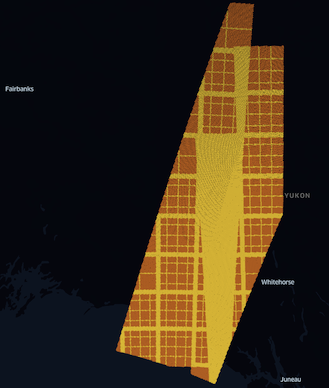

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUkAAAGECAYAAAC7/NLCAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAFJoAMABAAAAAEAAAGEAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdAZFbWUAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj43NzU8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NjU3PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+Ct0d0/EAAEAASURBVHgB7L1ZjCzZfad3as3M2vequy+9N9lsskmKkihRCy2JGoqQLA5HY8gDGPCDX22/GjDmyQtgPxheIHsgjBfYGAu2R57B2GMB46EtjkTJ4lBce1/uVvu+ZVXW5u87eaM7bnZmVmZVVlXm7YruuhEZceJsGfHL3389bZ2Z/qPQgltbqtdHbR8NoNz59LmPSn50lL7/o7O1Hx1Xf7qmWtsqrbPW+9JtVTsurb9a2Vqv2UfrLe1ruXNJnel+pO9Ln0/KNsM+3cd0fxrd3+SRbnNOaci/Q/8eP/fJdfuQehX8eLk1eAY6G1zfuVRX6wNZa7mTdPqkdafvqwYq6T5VejHTZZrhOBlbsrdP9r1S/9PlmqH/zdSHPX9s7NAB/4qOfuhsC728sQLlDueO+GtrDyHXYUE+xxtC2GffnkLRDo5jNZxPTj8uWryxyf9N3pOL6ua5gaQvRHxZkm8n+bZqHHm1F6rateOqr/QCV7vvNO2l603qSfbpa8nxSfrnvdZ50nuTthuxT8ZW2pfkfCPaOM86Ks2r42vUmHxFhrraguB2pa8j9Gbaw2hPe7i/vB9+NL8fhzve2x76KbMGmi5tiaJsvlPc3NXdFnZFSity43I7ZbOA6T7HCYjW+QoW6zrnf5PnppHzW+8Q2s5D3K708CQTUK3T5e5t5ITV2od0uXJ9qjaGpL/JMxufZf45rp50m9XqL72WrrdaHelypXU0+nO6H+XaPe56o/tz2vrS/U3qKjeu5Fq5fXweSp4Dn40D/vl3vtQXMW6yvzPsgGqC28bOAYB4EIakjpTp7mwPq1v74cezhXB1oCMM93SEsd6O8Kfv74QPAFSBtB1K+cxIR/iLB3vhwdoBCNoWBmGku9BRwdL2mnkrned657gRY2tqkCydkLOYsNI605Na2n76WulxtXpKy5b7nG7rNHXVU0+6bLk+Nfqc46rUZjLmStcb3ZfT1pf0N11PvX0vraML0TmfPwrf/HQ2fOFGLmwVDkMGQFvOH4Yc+wIyc3+2PXQDfB6DkWF1p7gfgG16LgcIzm8ChmxdUFFF8x7O3VvZCx3c1wvLHKTsH3x3I8xxbzd1JD/e6bFc5HHpvKT7Uu8cp+896fG5idsn6aCTVWlSKp2vtx3rSdpJfzm11p++p9620+UbUk/qaW9IfekOlhwn9Tdqnmqtp6QbF/YxeW5O2oFk/pL7ZXR7sMVsrj28NJkJG7uHoQ8wW0f5qD5RA842ovVIDn0ktFIAlF12QyoVy2WbguQa9/Vz31r+IOolrWMFkL0z0gVAtocDUHNuYz/MIaLnAEzZZCttztt5Pyv8jhQ3Gy5tvPRzUrbevQNL/3l/6UNSqc7S+yzXqH4lbSb1uU/+kmvV9rWOoVodDb2Wmufj6k3GfFy5ctfT4y79ftLXyt37NJ1L5vC4ZyaZkwSPks/puZBF7u8ehd96NgPwoY+MLPEwFAC1POBYgBwOZNrCHkB4ADju8VkAhWBGJijr9D6Bcw/kk0H6Wd3kCMBr25bXuHNAB670dwRwtCnF7WRe0/MTj+l7xWsfK9y4ExEkyzWcnEv2jWuydoAs1+ZZ9KdcO8k5H+jkofZBc0ufK55pjX+du+TvpD1O5qLc/cm1ZH7Sn8uVfxrOHfc8PjEHqWcpPXZOh10Aqw8d4kuT3TDKI5hjG+I2e64JchkYYxZE3AIwBxC5ZY79gCbYGBmmYrkAKrOUeU5i8PHeDurpU6Zma2e3w8Wfzu2GmfWDaBVPnulYoIn+SeY1eV7j/oL61550Jmk/6VTyOfmSk88XtS/t13n3I85DhYf8rPtS+h2dpL1G1HGSdo97fo67fpI2m+WeWsemuHwAIH7lRhdA2B5ZouK2+kOZn+KzfHH9sSjtOQEzC/0USLvQNapvVCSPLJQ9/0fx/Yj7dgHGTcrJJJe2DyOoBqoEX5t6u6hntnRSij8xpWdLPl90Zy+y/Yts26/hottPPwq1vvTpe2o5Pqt6a2m7GcrI/NphhX/6XiEaWARHQbBXtx32R6DiLp4/MkKZ3wIWbgFxGjYom3Rb2T6IOsdegLMLNinT7I73hmj4EYjdhh4bfqzo8anihct/K85Auw9otYc0eUmTfcWazujCRbV7RsO5sGqrfccX1qlUw83ev1RXazqsZzydgNoh+sifeyUbDTcyRY04+4jd6hY97gLwPFY/qQFmBYViBrOr4Of9Aqt6zUNuzskwKaeRRgCee2ztlm3KNLWAXyJkTV9jLPQhk/RLPe6LPQvAqlSn5ytdq314jSl5kf047jupZ4Snqes096b72Kh60nU207Hj+9gYeZbLbRSNFuj89lG4daszfOlLA4jQbdGyrXuPAOcWy7EX5DwlGKprVAwXOA8BUZ3NLS9oaqzxHsVw/g83BzuivrIPID0ARDstxD2WudyOn4G6XYAEjI89BMe3U7ZEAj7JvmyhGk42qj/ppkr71Mhxp9up5bjS+E7Sp0p11dKPsyhTOs9n0cZ51Vlubj8cn+hWZhMMC0Dfa9czIQNsZRCHtzFRC4BLiNBeV0+pG08OxFMHeQgyel6Qs9opHM6ncevpoDGt2wKjhpwVnM+9V6fyNq7JUKfX98Ifv7UTo3LA0suthhlgquvbyj0I9dVQLP3hw3OSm7nHfiR/J6yi6m3lxnnaPldtsM6LSV/cp//qrObciyf9PveGm7BBQU7rdBcB2HcHO8Ot692RGao33EbGHsaqLXvUYCNj1KlcsVomaJnNx4acAsi4gXncMuoiM1zXj1KAlD3qP9kDaEZnc8zfLzxmluo1L7fjZ+AJkKz0ACdgVA44jm/iyRLJC/3k2eb81IjxnsXIKn1PtlXt2ln05bLOyjNw3HchG9Q38pdvdocJ2ODK5n7YxxVIgqfLj4DXDpIpHW/AIIcBRg05/egkZYzqKbWCz2PIyehYyZZFNlRXqTuQoYo6nqvHVG+pbtO67qGjjCK3DV1ux87AEyB5bOlzLlAJnM8TvErbOu7BP+cpumyuSWfguOdEkTiPxfrWaGd49VYmrK3shy2iYMZgeZs6fSNMF8MKcSSHIo6jc0x8IbVeyzTVPc4AePpYqstUB2l44jrA24PiUqK4QxsCqpZwgdfzV6hrHxC9ZJK1PTxPgGQpINRWReVSPijHPSyV7i7ti5+Tv0r3nNf5k47pPPpXOm/n0eZlG0/OQK3Ph649Iz34N8ISb32xL0xA83YXQTWYoMCmX6NMUvAbzBaNLorS25RXdO7k/CjJLu4Md8ZjQVS9o+c10ExvHERQ1OIta9XarVh+b7MYnaN4frkdPwNPgKTFy71ktX7pSXOWT9+THCf7pFzpPgHBcn0oLXtcXaXlT/O5XH9sP/k7Td2NvLdcPxtZfyPqaoU+HjdOx1BpHLU+l4KZGXo+gEGKVZ04efeNd4UtkMuQQ8/prqMl++pAZ2SdBZijUnWevfpGmaLJK9x0F1LM9poMU+ZoKKNit2AogLbR3gD50j5NViDr4uPlVsMMMK0f3/yC0vPn53o2H6DSh6X0c2l9lR660nJ+TupK9vXcW66+Ws6VG1Nyn/04jz4k7ZXbX3T75fr0tJ8rfSaS57GWcQt+BbLw/PpL2TBKHPUmIPnw3Txx14jI+Of0IlN3wiIFvhks0u1m1+W92kCU1t3HZBeCnGK2Osk+9uoeZaDqH31nhzLu9Y00Q9BhjND5lw93ww/nsXpTHvy83GqYAWb+I9D5sHwaIWOBD6805UE9D+dpBlAJiCqdP01byb2OrfQvuZbsz7L9pI3LfeNmwNeLNJDhWn97eGY8E3WOi3N7YeoqqAYognERAMUwxe3tPYw0nDSxheAmm1RU1/K9iB5Tn0mdx2WRMlSNM7r9xKw/Pj98VjcpiK4iwseQRCu/3GqagQ9jt0uBxhcv+aupplSh0rpSlxpyWA4UEiBpSAN1VFKuL3XcfqqiJ/1+TtXo5c2nngFZpDnKfumZTExWsQd43Xo5F9bnCjGGO4f1WlFZMHQ/nHvsHwmwad02X6R1qGPUACNfVKTWaKOL0DB6ysm+TsCxGNKoTjLZrgLMFhY4L7faZsCvK24fTWNypv79aYCqUcB6mj7UMuJSUGxUv2tpO12mtB/pa5fHzTsDisiyyEnA6s5od9gHIIfQRe5zYebd3dCDb6SMMQ1iMkn1jMZp60xuYgsXt5FJDlFeIHUT9+If/yzgTrSNE6Yx38uI8gKqQOqxsrjlLrfaZuBDkDxu1iqBT3L+vMHiOJC4qH7VNu21l0rYYum+9hqar+Rx313z9fjJHqWf9XrHIkiqDPytF3PkdOwMy/g57iEyT6MrvK4zOWCYOIurf3RbQ0QWDAVK/9ORfJnYbQ07XpNxRvAFQH2PVwBC3YLM/lOM6y76V+pS5Ho5l1t9M/DhjKW/+NIq0tfS4JM+X3pPPZ8TAKjnHssmD2iyr3R/us+VytRzvrS9Rs1DPX1o6bLFd7+lh5DufOnzkL72sWNBkvGbOVxfRw0tO7DJAfwlu2GKWra1RJvpx/RmuvIIiioblaxdekGw9FhH8piwgvJat/cpI9M0H6Vit0xTd6AxDD3R55Lz/897u1En+ZR9BR+b5kae+BAkK33RZw0Aldo9bpBJv5L70/vkuFwdyX3lrp3m3FnVe5o+Neu9T6OoV+2ZS74Hy0T1IG9dgQ+z+CsKVjuEGxqC2AYAHgCYskOZ4ATGFwFRwDuEIjpvRuE8xL3HdW4UofsAVoHWiBuwMl4XEF00zPJK5t7jn/XcGeKE4nzSqcv9sTMQQbLcF+xL3+gXPz4kfDtJe8m+Wi/L9SPpV7JP7q+lvqTsaffn2dZp+3ra+5PvoHS+T1JvI+o4SbsXfY/PiyKxYDUBM3x2uAsRGr9FwLEdy3U779s6YNneVRSTbw7hAgTYeY/AmmTvmQZYBVTZprpJrd+xDAMcxAdSv0kja7oATZmq17RoyzzfXdoP7y0DntwLvl5uNc5ABMnSso1+kH1ASkGl9HNpH1rxc6PnrRnnwDF+EsZ5JnMvMPHG/ezL2TA11RU2WOI1g3jcCWvcxGJ9iG5SsBwGxPZYNXF19SAyy1VEcy3gWsRHuOZa3Adw0GJ4olmBAFiMNPNkDeqBLVKMRb4E0vboV2mzRtwc8h72cP4IhEwbhho11vQ7nbzz6XONauek9aT7lD4+rr7oTN7sD32lia503kF7rdK4PF/t3uMmLblero1G1Z200Qz7T8o4z2qunT+NK7sA3xc+1R1+7ucHQz8x2gG22AOr7IQZHrFe9k0yAU1D+Qp0ZA894pVnusP2CrHZjwphHJ3lPiyxl/MrC7BBclAWoJj7mMK7qWOExbp3AVJjs5cBS9mmDucyTmljDlbaQxtnbbcp916Vnqv0Xp7l/J+m7rIRN7VWmAz+LAedtJHuU7lz6evJcSwHIPKYfLj5q5r+/OGFFjxI5r10PpLzDqn0WgsO86noctRF8rbd7MSi/f3tcHi9K1x/PhtWEYEPVvfDKkzyCFegods4l8MskcTDoSL3yFG480pPWFvbD1lYYAeZfTpZQ3sQsfsAfeRUN6I46c96Ac096tkFDM08nuXa6o+3wxjAuANAZ2CYbSD1tQ/aw08WILSI9Y0WuZPnrhmeuVr7kPS52kNWFSRtqLSSWhtPGq23fHJfw/aMQWBMb6Wf09fqPS43R87ZWY279Puwv+n20tcb2YekrnT99c7V016+3LPgmMGoCHw3EJM/BRDq5H24uBcezRbC8jop0O6wANjNTJj7i80AloVtdIg5Ktsd7YgRNkbKbK4fhnEAsjDZEYaJ5V5TTF/eD4cw0twVXmPW497cI1M5ZbVu94x1h9uv9YY8bkQDdGB4vDt8//2t8CfvFCJgauw5qy39PJa20YrPT1mQTF6I0gHWe770/qf1c7mXo9qD0srzUOkZqGVM1V6Qp4Xhl3sWZJGQwPAAnaOZfYaIiOlCLM6jgGwfQGQGAKeI39660hXmWAysC1EZrAu7CyS/gBmOYuV2idgtDDv51/fCEvK46dM0+hzO7IW++4WwgsW7XeCDhXaAim2EOe4CkDv4TGap6+FkIbRpMqcz7RpucDI/yy35rk/zvJxl/+qp+2MgWTqo9Jfe6Bf/aZrI9DzV8wU0omzpd9aIOs+zjqT/ESj95ynbtDDr2H0VIBwAIME9/BkBPCwsPYx1ACdydYXv3t8Jg4QTLgGGowCgekut0t4wy/IMGlvaKZjNcg+VRidzPq8Avr09gCjWbFlqB2C5jRiPG2Xo4N5ORO/t9wuwWU7YGbCymbbk+y/XpwQjyl07r3NKAh9u1TproeOuf1jR44NqA0xfSx+X1tFKn0vn5yzGZRulf600R9X6ehbzVa2987qGiQbLdAi/8Wwu9KMvzANmZufpA+D2EJtz5IOMyzjs8eXyv7YWDS6ukS2gGkqoY7iJLPYB1ox70NPMP66FswoaxjhuZOgjzkcc5B/1kO284aZFu4rhJ0NOSpG2yTDyYyq98/peamnHdy2CZPLSVbrpuOuV7vO8D37y8CfHyef0feXOpa+3yrFzld6elnGlx9TI42S+Wm2eKvW39LyAtQ1I3QWknuNPtx39H3XJ8W+Y0MQOjDCCH4vdxPVsNLwYcWPCChcAM6mFSXYFUP0go6Wcz9Z7H2PNCKxTktjJBSNw1DfKKs0lqTM6uBhBdAaRnJ/YljFcls5lrc9d8kzVWv64chEkjyt0ouuKCY+3Rnc6qbdZ96Xj9cs+6RferGO87NdHBCD5fst9xzJBqduXsVoLbgTCRKuyKx4O4fwtkK2jgDxgr5pwGGDU6izYGSFjijOz+BQzkRfvXYM5yiqt2rKGLWLgjiK630s3oDqJVduQxOu4FekWJIjeHOqMYY3g54UAZbn5sb/ltnrKpu8vfffS10563H4WlcbO8A1ad7r+9PFJO9wq95Ub60m/+JOMuVz7J6nnLO9J9zF9fJZtnmfdAuQ2xpOv3O4Oz491xbVnPCdDNHRQnaIROPuI3EeCJ0CZAxjZRfC8B0vkMMZwX0GfmbhpGJ8tgMo41XPGnJOcc7+B3E4T0UeyD2uRuk9XWdRn8ofTu8SMH0b9p/We9XaS79R3pNx7Yl2V/pJxnKS94+6xLx8z3CQNnvf+uM6ed38a0Z5jKv3C/XyWYz3Luk87J+n5aOZ+nnacpfcrYuvGI3q5PKysTva3IxqyqaOcAOy6YXyzG8VQQkXmKYw4IqNgKiuUTcpGFa+9HuuMUd3oMAHMTQBxkHoFSmO7dyk0h1GHrJKspdMR81Dah2Krselz+af0HUg3mn4OqpVL31N6nK6j9Fotn5PnMtmX3lNR3LbDlf5KK7n8XHkGyn2BJ30YKrfSOlecj0/KnAhGbTDGH7NcgoYYXzbZ3TiisICnqFwAPHtw8dmENbZxTkOLeSPN6mOaMzOOC4wC5Tag533qJTXUyEYVy11ulmmNn2WptqNL0SMWAtOwcxvDkMA8gRtRsya3uOh3otwzyTTGzfn82HZch9Pg+bGb6zxR6aWps5qmLl7uCzhujpt6QA3sXPIsNbDKpqnKl0tr8994MRtFbIESTIuAx+m46aJz/Xk8wWGQq1ixFYtNkSbIrRBe6EqJhzxAGnsmDCtkb0y21u4c9el36SbguqRDXGGRhhfI7Os63UNYtE3aq17TMue9Hfec1/r9J+VK95XGU1ou/bnSPZXOf7h8Q6UC1c6Xe/mrlS+9Vu/96YF63EpbubGWG0PpGMt9bqVxV+prMq70deco+Uufb8VjMCz6Qb462RlXO1QEFqQ0mqhLNGu4ZWSF+fm9sArVG4XpaY2WHfqfBhgt4OoVdUbXyOO6NSa8UF8pu1QPOfTY2KOveFzDhntXWWRsAJBULLdOLeSK+qJ0EVbPflbLPd/1tFrunanl/tO2W9qGP3ZP6M0a3UBpg80y8NJ+ncfnk479PPp2nm3U8oy1+lyBf2xt4bUb2ShqK2YLegLeNsHZAqR/R4Ig4CfQmQ5NAw04FhZhkWb30Qnd1RFll7JHxfAVwPEFDEHerwHHxcESNx99LwXeq7gWadWOqdkAX12F/sW9PdhnkXWe5/edtOV3mvwl5yrtk+8/KV+6T+7zWSr9S64dty/3HKbbSe6PIOmHpKHkwnH7iyZyySQe189mu17a7/QXlT5utn6fZX+SB/Ms2zjPugW5HUDtl26SxAIXnKLvohl7iiKv/owyQjA07CFiq1/MjXRiRXXhLtlmMXuPwKgBxvRmslAz+2iIiUyTeyGIETRliIrlGndknlyCxR6GR+v7kX3OoptUH5lF9H5sPzrP6YhtlT73yXdeae9N1TCptL5qA0q3kZRL3rVqbVjWez8EyeTmmvd+EyfYks6lb006muzT15Lj9EDrmaDk/st9c87A0/hdCpKakH/+ViaClgDnsgzsIrMTzBS5DwHBzFQnETdd4d53t0J/n0l0i+KxwKke0c+67WRhgA/IBGRCXXWbq5zTSKOI7WfLyjrVU2r8kYUqntt2NARxvINuksvnbt0+7ZOX4EIpdpQ+O6UYkXw+aftJ/ScGyXTH08fVOlQ6yOS+0nsqnS8t9zR9Lp2bp2lsJxlLK8+HYOj2BrrGDOC2AZK5gJeWaV1/1BFyGP0Xs8jJ+kaOAJa7gKbx3Fqt/dMKblSNa9eoy5Rl6hCuCK2OMVrMAb0sZbVeK2bnELEFUJPvKt5bD//HsMc7g7odFcV8+ycA++d198nmoX/JdfdU+2QZzpWWsZznkr8P6+OExNl2krlJrlXa1/r9J0CYAFql+krPp8unj0vL+bnTArV2qFwFZ3nOfh03gLNs/7zqbtb5P6vxJ99pxXHX+iadVQdPUa8AobHEEMO76A07oXUdDFRgyyELKw577OJfw/guxnBEyrt0Qxe0z+uyQAFPS7c6SBmj8dmumBijbSgjmFqPrHEJHeUeCLrFGl/L+f3IUpcIazwEELvIN7lLSnLLLmDMIb9GBEx1mIJ13OwvoKqHUDT08Nlx2I9IRS3kOUA30WlaLt4ucj++HuVSK2aLwMqh4KoBfpuEw4H61Z+WE/nTz0LyfMSKSv6xXLXrJcU/9jF9b/r4YwVTJzprhvbUTZUOj2u03PX05FSq9/L80zkD5Z4HR1p8zVpzzLKlPIzwq892hzGMJ+oX9WNUnyigye42QAnLZQGmTo5lkn3EdS/O74QeDDdHR8WFwGSbuv6so4cchIrtA3J7IBM4E5Pm6kAu+9wiYe8ogLsOndTR3FRsa/uENVLXJvrIzZX9cBUEBDfDERFA/WT0xUAensd/UqCbwk9zfno/vKPsTieH0V0qurvKom5Efh9TrBP+Jqnb3idTugjYDvhep299ZjViXFrSXcrWZST2KbLN/Sz9Tf8Oo3X/a5/JhJ+SP/O7jwBx/EAFymQrxYDSz0m5k+xPC6q2qUt/Q7bkgU8GmHxuSOWXlXxiZiB5flp1wJFIAQCfHSFWGyRYB5QUsSFRYZ/P8ySZcL2aPoBJptaOHnILENxe3A/gTmiTTYI6uggJrGYJGrnRFXoAQfJggKxk/gHw2rnWCcK98/9thaufzqFrRDwHyEyZZgz4Adf6pIYAZI5M5mYt/1fvZsKNMXSg0FWBzXW/l+K6OADh17vCn//FRhjlWj/97QYZJmPEDyncSO6rAeru2F6M6hnl5pd/YyA8ensnZJew1APyi4xBH07VALJfmfAHtO2qjaoAPo+V/85IV/ju/HpkqzR/In4mrpQ+I8dhzWmBkiGdzVZLx0oHW9qT4wZfWv7y8+UMXOQMGCGjWPnZ5zPh9ud7oyh9jSUYugG0I8Tl2R/nw9jtbFFXCMvbJTv5xn2sKQDM1Iu5sDO+h8/kfsgDpDJIl104gnUdcDz4ck/oQCRXjO2lPi3lm9z3/K8MRGYXQZU6D2BxMs0jylqmH5E/ez0TFj/YCS/N46uZwdBDJYKYYCa7bQdQRyn31V8cDDtv7IQ14Es1gOK+BiR1qf0AofpQjU4dnNsiX6Xg2AOodlJXVx+ZiwBc79F30/4Litt76FqRze8B1LbZC+KoauBy1e0kYFi1wlNcbBiTPA7wSvtYrfwlOJbO1uXnZp8BGaRiZidi8Te/NhxGAUMzifcBaIYeHqBXvPNLA6EDkBiAweVR1O2ylMMh7GwQ8OmDAY7fyIQHgFkWgBq7QiJe7pHFLN7bDTNkGpd9dgOa24BRAbqouG4ZgXOgpxh6uAcgLZOg1/oUxwU7RfQCYvcITPMQUNSFSH2kgKbVfR3xftAJRh7vABEKiPW6HqnH1EL+/GhXdGBXQo7x4QBjH0alUU5sID4bHa6fpxFBG/wY6OS+mpepPg6/pD0BeYY+0OXApSe207zvtd5bC2lLOlVaNmYBsqHkLyl42v1xna90vdL50/bn8v7mmgEfxOSvuXp28t5ow1BMzSGu5tHPKXoqVsaXDlG5C3DRmLK8vBdWEEXNECSD6wdIdwCWNZeYBUDHrmVCN2AruC2jb2QdWbgd7kKcywNCm4YvAsACczdAqF5yCfegh3OFsMn5rMBJw4r11mEatl6ynHvNzOUm8+VUBC7rGKH8Ae20A9YP0Tnqc6k4rj5SC7tO7hSP2dEjw6WvvdzTwZ/1C7hG+jA8LO4ap4o6TQF2HGDXyHOVdXlcynYFANaYY33NtCXPovvSje4+uSVgWWn/ZOnLT5czUP8MlD6I1R7Q+mu/mDsEyCxKRVneDkAmUHUBkoq8/glGW1hLXMXQ830YRdwcuwxU8LPcIKCia4/1+beK6G0qtRfuZGGkoA0V3byaCf2Uy9GGS9JSLAygfxxFbyhzvDbZHYFT9jY23BHyMMQV1sGx7gXAUHHXGG9TrgmGB7DSHfon2xxDR6rPpfkq3c9z75voS9UrTvR1RQAdAjgLIJ/6UuVmQVKHdplnT1fRQt8LeM9xrz6eA4x5k+tmItIKRLfOfatGvkqfx9LOfQwkSwuUfi4Fz9Lr9Xwu7Xjp53rqetrLpuf9aR9rK45PfaQ6wl/8fE+4PpWJVl1p5DZAoqFFxqeIKkDKIPVrVFxWFJdxucSCAKq+0c/zGEsUlwXCIVjgBnXnYWEioiA8QF1ajn/41nZcXVHxXfAZRQe6hJHGz/YptMESqS8HEG/SlvrFZ7GkG85oWrV+2KnZz7v53M9qjPsAZjtMcAxAdWlb+/k8xh4BN9FNut73KoDaoXEJsDfksg2R3WUm1EcKqOKgQKuVXCapAWsONYAXqP6Jrd4fyQQnkv0TlaU+HAd+qaJPHJbWWzdIPlEbH0or9Hq5c6X3JZ8tm/wl5y73H83A0zY3J31wP5qR5jsCCyIbayfT+Ne+MhS23twOnYDDMi4vh0t7Yf7BLlgFqwRUZmYKIb+6x9Kv6CsBz05AU7F4Ev2d4LQLjljWOucAymuTXTHP5DLi9FWOzRokQA1Q/m3YoaL9TfSXy4jqUUcp6ME+r6DvzJDI8tF8AeDEAR2WuwaIXQUIp7lf9idzlZy6jQK6is7qE93eXNiLx7oBDQiCnBNYZYcCtkA4cq07HHGP0UNdUFKZ5Ea05qNm4AbPK36b91KRPcs9YxiOmIZYX2zohP8chzHp5+y4sunr6eOkaw0z3JSrPGnkJPv0INP3N7qddN3NdvxJGmuzzX09/ZGw5WFaPwsYDYsmML8f/Z+rYQI/RBnhOOfbAblFInAOsH67QuIi4DbCErJ9GGsW38qH1TnWqvlMLjxULAVcNrAeH8EcTZm2Q93DiNLqLWWFitizWMan0GfKHKcBQhf9EvRW9ZmkfQ03i6t4l0vp2Pa3qIs6FK87Wcr2EAdzgdj0al2ggPksdwEziw/CXl1kzKHotG6yDVUAiug6wHd3oj7g+v1Hhdincca5d2CCjsOo72yDveoA/wDgnoCRmqDDen5CZvRFQLQYRmmvzn6r9R2qVu7UTNJhVmug3mkQHCsBpHWVXkvKJ/t627vI8s5btb+L7Ntl27XNgEAScQjq9Jv4K2YQlxcAB9fEBjfCCKJtgRLz7+6i8ysmp9AlqF1W+YN8yC/shkHKGHr49l9uhTn+3vizrdCzgCUYxvfX/3Q17LydD4c4eq/DBG9d7Y7gtgPY3GUp2m2AS4POBBZok2oorivafwAgxVRrgJtqgKMuLNHoRBWZFaFtz8QZ0a8RsRp8jMDnZxcRiy5CnNMIM6xzOu04TserhXyHvsVkwbSpKK4vqEah5xDNbWNBtkldLh0hozT57xTGG9f7qQY6pe938i00EmOSOmvdV+tvrXVULZeAV7KvVPi465Xua+XzlR6IRowpmc9k34g6L+v4+Awg/aIjPAq/RYTNhGtmwxwVdXWt6QEkFNWiuw7gNQgLcwEwgaadG4+42D+IHyMAMw/ojMMKMzDH3gFeS0ANnAkHiqqwzy3aMFJFZrpG2WHEZq3aGmq0dm8iBkcdJEhmGdmmYvsU4Dk5gcEFkBKoTLemnlBQ0zCzDPgZcjg1hcM6fRIQtGgLbmYPEuAUlb13jP57vIhXe78Md5U2GaPiezQSwRi9bwRQ1aptfwTLRfrnRtG4yWCrbeWe2XrflYR8VGun1mtnBpLlBlquU7WWS9+b3FM6cZV+bZLy6TqexuNknKXz4ljLnatlDqrVWcv9T3sZ2ZUKuLuAka41Y4DHIuF7I4CE+jnFTEVcDTMUA2QwYgBMOQCpB+DZRASfR0SWec6xHwO89DmMTAyQ6SWEcBrQM1GFIrSuPzfQQe7B9jbIPg5mhSHa9C86kgNqUQcJU9Xarp7x9Xd2wgYuRx1c2+KzwKc4vKkhCDDvI4rn0cNCBEWt7qZos96biOcuTnaInlQDlMtHcBjoYpjALWkYUG8DMLVyP6KPGpRWAcVlAFsDjrktx7GWbzBedaaK9W7WfZLtpM/wSdpK33MikDzuxal1MLWWS3e42nG5+tLn0sfpeiqdT5c5q2PbTv+dtJ1GjqER/Sk3jkb2sVz9F3FO4NOs/B4g5PEC7jLjY1ijAYYCcq1+k0cAhgxMwOT/KLb6g96jawxM8QYAK71UtNX6rTuNden0rYVZCzhNADTUDTgtAEjbANw0AKseUn2kbNLoGO+z/CCsdmK0O3yA8Wjr/m64hgFlDYNOB/1qK4TwHgYlmayW8wz9OACQJwDIHQBO2Zum2QGWAGr3ENZqvrz8OkvZAvxZGllGh6nh6ernc2H4Kmz1FsDN/R2CIiNcQ7TvgkCO2iHa6bvZHda5X6p6HJOs9j2mn81qx9XqqPfaY2yv7bbSh7wSc6tWW2kd1cqe5Jr1J/0q11a5c7aTvu8k7dZzT9K/pN30vWfRj3R76bYuj083A7z+0Tqcge292N8Vk0a88Gw2rL2+HYExCyasLWNIAUx2+BJ2YGIySJlZAVBb4NptLMTzuMbkABNjnxdIlGuUjkzMCBUdtAcAH1dcHCPv5BZGFI0tguKNK5kIkO8AghPoNa/jH3kf67kWb7Hp7Xs7EWhf+pm+sE3UziAIraFnj3ZuwfJ0IRoY6w4LAOkB9Q4+Q7w5oChwygg1znQwhkH0oAfv74Rh7jdmXCPVPIagZ17Ihk+/3BtmMCLlMAblEb9lmrPstwHkbvSTag6uah2HBf/g7e0o2puN/azXkEi/R6XvfL3vQ10gebpHqvnvTk/sefU2/YWVfpmn6UO63nrr8d5G9sX2G11fvWM6i/KyLdnhV7AyX3s5R1x2Jq5u2A9Q5q6hi8NF5+Zkllhqsu7w452fJbQQ1qfhZoP7nn2JRBYAyA4ANgwwbdDJrgP0mBReh0KqP2yD1ekfGcMHoxhLPYrriMiyTpNkDALCg+gRZZCK9VqUPVZf+OxE0bjThQ6zDQBexWrutgsI7iLet71kXDbiPWM5UMfJuZ/opkTkzTVEeBMDbwKgugEtA9qHXN+DEU4AqPffy4cCk3DAmB7ALIdQM+wRim5Y42EHbJL+bnHtGvOjo/ruYzn78S724yz/qfWZO65cXSB5mhevnslIt3PcANJl62mjUlnba3SdldoqPW+7tn+SPjS6z42q77jvr3QOWu4z39fzMDpsFWF2uhBGSCax9C4MDrH4CpnJ1SHOEXc9AquaBEilnnkAagrWp2R7G/F0E1Azpdlzd7P4HcIAf7oVxgC1K4QnLhDLvY94bVLGNhjlDCL2GHXr/jOLL6NA+BztfIA7jsxQ53NFcI06kySYWKWRPcIg3/42EMzbboYfwX0FsXkKYF76wXZYBRCv/nxvKACgSz/dgfXCWunXOky3nXEdfD8f3qGeEcA4ZjSCSRpBEwD9t+/hCwqYawxaB/wF6IkexHGY5sqDQkyA8cZ7lKHO/TXukUVyfJFbvc9kXSB5HgMrfTkT4DiPtpM2yk1iab+Ssme1LwXKpE/n3Y+zGl+r1ws2EUp4FH6TjD/P4OT9/ps74QoWGsFxT10jyzFskVBic5tkEbxlmwDR+gcFWBauNDDF+0N5Qgs7wtSXB8J9nM2X394NA1Sqq00BUVUr+QFi68jNTNgEVHKAj0zuKpZqdXobgJZgqGitz6QAaXjjIPKtHo4Dgi8MsB9gXVpHbEYlcAV/RrOWb8I2NdB0AICmDD9AedgJfplUV1HcyB+k+Xhd48s0NPYGPp0xCS9ltLZPcn5tnMXGcGtap5oCbZmF/QF9NwxRw9C4lhpoY093R5ilv0fLFBQgLxgk6UFd24WAZPpFT17+unr9uHC6ntL7T1NvaV1+LgWtcmUafa7cGC6iH40eV6vXB0ZFK7U6u89ez8aIEpNU7MkIAbkhGNNDQEjDSz+gpS5SPV4XBhOwJ+wQdTKCWL1NmrR3x/MxV+QeYPfD72xGneUA9ehruLu5Fx49MjoHFyCUk+O46cgg33u4GzMMySCNvtElSF/JJLGvOss1wEufyUWAtgDr02dRUNWyLoBp4db6XqBfxll3c+6Qfg4ixk9TZvKxu4+gLZYKFPifx1hsY79v4/O4gfHHWHDdjHoZq3Uf4lDuOuHe5/g1QjlfJg3Wih8/8LmVNsnvhW4CXfrvQjtzTOPlQOuYW+q+7Fwct9mP8+jLcf2o5Xot46mlnmYqIxGKXxP/TKPnGwEQNVvvAX49uM2YSdwXyxhs/1yDRiftuMQCAKN+T+DpvdMdRvCp3AEITR+Whf0FGN++NwNchxTqYq/voQl19X1c0IqOeGtUjeGB6wCkrkEmvJChreOSM4OFfYTr9lMXnl1EYuOo1wBFgUtjkCDMYQRLx9LNZ3173iafpSBaXKY2jpJ7AHYkfsML9Yc0n+Tyo13GC4sFjJexZO9hyTe00XvBWqJsik7pFI33Gt9t6jR/JTQqtdLm19HwrdqLUe1avR1JwCK9r7eOesu3CjjVO66zLO933sjv/Sz7WkvdvuMyQrOBq6PTWLIPbGp02UXnqF9kzCoOcRKIXD7WKJe4rg3lFZenYXgTAJnistbtdh4s2RYYE1kfh3EzJFCAHUJHqTHG5BX6TuoorkuQmch12hYoTYWmGF6M5S4mubCtXqN+AEFCpyNA0t2YlML4bfukD+YhYLwIABtDbliiTFCUdfkJ48l1YXJMgmxc2xsDzRCsVqb8LqBskgznQZAUhGWT5peUsa6SnXwRn07LuJ2X4SY21oB/Hn8VDagpVcVFAkkCmKnutNxhLYBSS5lmG3gr9rncHAoCOlB//Znu8CwuNMVs3MX1XIZw09kD1BZgeKOwOw0aMjDZk+ASVzik0gnAaAWgNDGvgGfyB4FIi/Y2QCuSqD+8Sn7JYVjkQ9x8zBE5iWir7lH9YMwQRD0mvdBAZE5Jo31sSyDSb1In83WA1XuLIYLqLItMeIe+CeAafwylNEJICmyiCn027avHJrbgdFQxDAKUO1h2tgHqAQBwhHKv4NzuOj6LALQ/EG5m/dGNSdB0TFvMwTVi2P3VKEJlsVwr/Pt4SI3rajWAbIaXxD40Qz8aN+OXNZ33DEQmxIv/IhZqGZeAIvBcRdTeYvWrdXRv44CT5TzvCoeKrxSL4qrARKwMDtmgHWXGMcYY2mg9ApugYnJa46fBFNgpoMy5LPftYKCRUapvNAGujuS2d49Y7U89g/WczfPWYYLfdoCuD4PNLvVHMRqckpneB1Bd60YQ3KZ/JtLIYL1GpRh9MjXCrCBGq8s0pZrSuH6bpkNTtL+PCD+NkSaDqgEcjH1V7SAzjRmGGIfs1TH4Z9YgE++OAq4MIc5L7GwL/NNwkKw05osEpgQY030od65S39Pn03Wkzzf6uFo71a5V6kczMOxqP6CV+t1s5xVZtWp/9Q6iJqnRNJL0Ys01d/gmOsUszG+ECJVFAEXdnKsIqtNT3D6A/rm8ge4zphADxyJaHIAafdThlodFLsDIFFWNl44Zv5m4QcBQRipjNP7buGuXc9CRXJFaBmmGII/fR1+o2N9Hf3op9+BHGIc8BqxkeA/RowpcWt0dj+5Gj3DnmcdVqZOkuYK7CXkVwwVH06PZO8HSpBmOzZUYTRS8gQ50XZbID4ThjI7XHwFDNFf4AZFl25aO8iuoDpYoTxF/G1pmazhIpsEnfdwyM1KloycBpyrVHXupUnsJ4FXaH1vxBRR4GgBSoDBMUEv257BqCzAyNsVfWd4BTtYFWN3+etE1R0al4UbQ0Om8C5lXA4rsjWxicbVDo0+GYZJG0Jh9py+DWxAhheoCi2vQAIjUz8ewC+iMIbLaZobGZ9EFmgFdEVyReYvr6iTNAnQFfaGANoue0cxEis62aT9MQCGYuo6NYLUI8K6C6LeI/tE4ZLuyWsHaVRfHKN8nOMIcjxjPFUC1Fyu4+kljwc0+tI647vIMS4x/lDqMPzf1mgBrFiH1pj7P/qBwuqU2pq35t3Jg4blqf/WMqlz93l9av+cSYPL4PLZKfaun7QSgaq0rGWOlfT1tP01lwY0oLt9mZcAJRFMB03OuBqgIvA/bW0H/p65OgBILIJDR+ivIGaetfk+gmAa8RnDh6eb83DswP8L6FFXN6d1DGTPnqPscAuDU520AZIrRMkhzS76Jk7k+kGYDMomFQLoKQzRdmUYcjSgrML4Fck0O0ckV/DT1b3QZ2gJ16bIj09V5fWPxAIf47pg+bWvpMEAmwwzjkDnewAd0AxpcILz8BazxHYCjutQRmO512OsWeTBzWLKvv5oLm7RTYGx5yt7mPsXvHA/dHGPdAETbAFPHwvS01Abhbo2t1hc8GU295ZP7qu0TsLFMcnwW7ZT2odY2kj4l+3Q9tdaRvufy+MkZUPRUbPyRfpBEp6jHM5PPLpO7jPP3OGLzyFB3eJ1rQ0angAaus+1a2kc4bA8/1vmZF3IMQMkBIp0A4gbsa0iGiDiONBpB7Cp1y+hoMur2hgCf6AAOcE4TafMsTuaKxbLGJUDLVRL1lbwKcMngFoiy0XJ+625PWMbB6Ab1koKX/iNe09YRIN5Of3YAzH4ihLRgD/R2hudZT/vhUiG8Aps9so+U6aeNLfocc0YyHsXmDHrODq59+V8bjmxy5HYufOVTvXExsjz6zgGifSYY24Jgy36Nga0au/29zei0HtCztsrWMiB51hPaaBBJA1Wj6640F0k76bYtm5yvdF/pecuX1lFa5pP4WfHalGFfI9ntZ3+uLxwBcq4aKGA8IgGEesENkPTOl/vC4ex+FJ+HJrFOE4VjYov3vwdIYLi4eZeQRHSDG4DZAe4/0VgCQ+skQuUIn0mXdeVSFMvVM45iMgbDomh9D32jLj6Ky/pJqqNcA2Q1pihiK7YbfeMGxkU95igLh60DXLsA+SA3LpAWLWbzITNPF2MwvvoGbkLK9AvEbXdhNJp9tBOzk++YPR09ayeqgAff34ri+jb17hJtc7M9Fzppz3RrP/2LjfAMwB1gs7OEOq5Rp+NWvF+DDV+j/mE7xFb8Nx62xD9tnZl+f6wutxpmoBxwVAKgcmVraKJuQKtWp32o1L9q9yXXKo3hpHVWqi9pr5n3vti+KOrW/u0v9ocrdzMx7dkhxouJF3LhAGDZRCwdwJjTC9jMULaXG0yuuw1ADSnOUlYr8x6METgJmYlMaAd8IHwxDnsAhjfAebPoRN0hICObO0K0Xob59RIXPsW5uIQDwGOORl2IFLtNdhEdzznnZx3OtYS73MKf/W9L4RAwsy86fGsc6qVRDUgSuk5CJwdfzoaRG6RW+2cbYYuRqi7QcMNwoni8zPgmyCCk2mCL/uUQr4+4L/9mPuwyOepJDxj/BGNY5odEPaVWH0V6DT2voe/8CyKF/vBH29GQJYy3yvNwyST5shq9nebLT997UjBKxtOI+9P9Ser9JO7Bi5Dnxf8ZwM7VD9cf7kWXmnWA6J3/ez06Wg+81hMeILoewAb7RzrCffSAZv2R2a29t4vlG+MOiR9kfp2Azq2vok8ESB6SFPcIEDsEANtu43fJ9XbAbwPDzDDZdg7JLtRBJMwUjDXJ/DNDxh2XmNXQMo5oO494DUbFFRa1Oruaoj6S9368FQE8i+4SaTwuKTHc04k7z37UcSpC7xG4beijbHWfRL2uu61RxmtawkcB2tHBtvAQsO/jXCfi9yjXNyYAzYe4DjHGhyxuZix4AaaaA1X0yxwCYdcYJ4tPhIeE7LRRtwzYXxt3rbIxlMvtNDMgiJT+JfUJUuX+kuutsC8HtJ804PSFBsugXG3hVUCSXUxYm+dtnyRqRgCSPWGvCGMYLHpgeeZjHORaUIwGrI4QSeemgSFYpGyrHfG4HT3jMsktCgCgUS4LZBF6XSb31m7YQVw3wcW7f74ZvvcPV8MYwGTs9DrW4lUAzuUaXO/GiBtXRBQ8jc22mz2Ak+twL6IPXIW5mtzXhb28KPjdWyEeHEAdpZ8aeBSXzTC0TZ/VHbpMg0DpQl7eJ+PcpB5ZYVyOAb3kIWqDYa7N04Z6zkn0mW08LNatf6RqCX1I+2lba30WCr4M+Gsdp+qW2i6ZZBN/XYJROZA67y7bh08aMKbnOLJIQOI3n8+GO1PdoR1Q6eNNFwyMitGtBywE9FhHBiv1fQwbriAo0OzD0Ewkoa/kOKCZNzEkwGSS3V0AZgo95r3pPcCsmJCio7fomK7D9yNY3CCAd2sSizGA081968RKZ2BkU+gEdUB3E3O0fBszPgkbFSxNuKt7UR99K1CXPpYjgKIO4Nat5VoQUyyXAe5hgd7n+nVSuq0omnOvac9kp1nQvweFrKK2agCXwF0ExLuGWQaXdg03NB49LguB/tS2BF8d43U+v441XhckVRGa+1sMI2O0UZzoy3+qz0AjQaIZgK/6aD9+tRX7/PFRnOwM73UMp3sHq/WgOSFhR7zu0Z1FC7RuOxlY1Rr5E3c4PwkoCCjT64jA7AWIYiy3LErgwRUGWqYuT0ARFmP4n0DEDdZtdp0+wEljkW4987A62V8ntMY1bLLQN8V2MC4MwlQFxmsajmCY6imP+MJuTGZCD3rE6FdJH+4ByrogCZKyQs+rDtgGbDsASBP56qIjoPdzPjqHM1aZ5CzsVYY5iVO6S9v2Y4iZBET1jTTTj3pOxXITYOj6oy+lcxMjelA3GK2jI30rbpfi9jHfmuDYSIBMmqsVdM6i7aQP9e5r7XO99TZ7eR21pVSf+9me0A1j2oApCn6TiLQx5RigkUUHOKYBh6ImutXH0VA8dY6Ko7JJtyGASODIiG6IpMZ2K5IalWJZS81zv6CaY80GHdKXAZcDQgTb8fm5DpNdAjDXAC0NNOofTbDrZr82YG6664wAjrI5QXCJ+gSscUDMZi3NLoKhAGfaRw0te/TRqBwdyQVRN1dCtLyfZZcS4VuAMdJ1jOEeog9Zjq1/ifYFfI9N/vHieHe4DljSjajfVNSPDceaW+efS5Cs8l2dBUAloFtP3el7qh1XGUrDLgmUJwHLesbbsM42oCLe9WhN9u3+xc/1hwHEaHWKG2S2ietTA5oyqBXARudtl4A14YQgakIL/7QSq3MUoGbR+Yk/isomuTD7uO5AghCXIyCNAbiKwrIy/sfPkvyTtKkfpCxRBqgO0vBINxcHM37bpWT1jRyjj7oVZWWJ1kvFskcd0a1PQPacoYf2yfZNbjGFPjVPR6xV1qc6wftkkP4Y/Ii1cGZoRxBUj7mA6K6VfBRLjY71xqe7Fo/AqqpATHRtbyv0h8L2Y+Wx163zzyVIlvmuEiAqc+lUp1oVKE4z6LOay9P0qZ57dYVRvPz9r/djiOkK01iLd1nWwBUGddqWpcUNQNGq24VFWiBQjFasNopG5riByLmIzlCAUn83CsMyimYW4BGAdFI3FNH7NikbXWoAOMv3YyRppw+K166zrcO4zM+ckYKli38lOSa1aMsuBdW5OUDtX26FLKxUfNqlq4luUVAWvGep06geoXGX/uxDhQVHLduySvvhpsrgKn32Htu8BwgW6KejFxj9m4JZG4JpIo1t+jlDsg/bVY9pBiKvuQnQrbRdgmTq22r0C53Ul+xTTZ3Joe0009Zs/TnJ3OiT6PbSs71xwa1hmN8259T5RcAANMzuneXNP8TdZQfx0+UL1P0VDTbFNGOK0kboWJsROFsYXzpNe4bRpg3do4BqeZmbMdUClOxMEVVw09dwhPujLyQApeP4DJE3borbAqZGFgHMKBwt3v04gfeQzVzfTLMOqSuU/doHs4gbOaPKoB1jUyfjMR9lBgdOAVuQM1mFqc+mAVINPf3oEAyjdKmHm9wnszUlnLpLx/Y+Ok/LjwKSY/y5iJkjNmzSaTQW3E3gbKWt5UDyJICT3FPtpa12rZW+0Mu+Nm4GdBzXqvx7vznIYlu5GPq364vOSy5QChwCygL6QV8k04ZpaNH9RTYWk1hQh0YdRVH1f2b22YdJHQFcg5xrH8ENh2PhIxp4qFOmJfPUgLKILhK8jcxQRrYJG5VNmnwXXI0GGwFToNSg41rc9jmK/ABiG8dZymVYOsLUbD1UPo1YPoBuVNAdANU2V+kvlY3DFNshwoZN6qj+HnV10rEDVAQfzOyFdTpyDYdz14ndQyWgvnEPh/Jt2rC8y+feI5vQNnVfJSrp1jPZsMK4XsRtyhCiBdrXKtViGBmXrmjcU3WONQlqJ9GNnWMXz72pZpiPp+/HxhyPsjXXzMZIgajb5WJbSySPYP1UDTbPkRHowRs74SoUyXWrl3Eizwy2hxEAcU/AQtuo0cMoG+tZwSk7wwnXwxFk5wClW5iyFcvXBDaAjNPRhUhFpYajA8qscd8YgDjHwl8jWNAnkO/tm7o+swG9T0TLBPpJreAyunaY3uRz2fCom/MAleoBk2w8m8uF63xeB1hXCKecInGFzHcbBnv7lweidX2WtjQedUgB0T2u06/rd3JhHCB+522WkqX+Aebic787FB3RNURNcs8q9Y/Ctq/Qj/uu1Y1L0Q0+j3H/vZEQvvtHK6GLHwJ1t62yoUVpne20L2A1EKl2LZmh07af1HMW+1r6fxbtPs11FvVxxQw//bi+mMxiASCYeq0XawcGGICiAyDSQj2Jz+Aux2OTJIT43eHIDDfeyodVAK4XhjmIMWUXfeUs+R9vvtwTDSRm+9kDiIyaaaf+A8Bohyw8vRy3+2bCuozbfh8WN3mrKzqku+jXdZL9qpMU9ARHI2+2YJymTFNsF370X9yD4a4BruOEM5poYkuxmQdlBzHdxb66ALzxq13RiVwn9VuI7K9/dyN0A7Iy3iXqMrZ7nD7e6O8O77+/G7onDsPOT/Ih82I23MMRvt+EwAD5Jn/PEuedofFl1hHvRXRfo9wK/pdb4zvRb3SemHGUDbGPrfTclAVJf8myPb3xF22fX8vCrt5fxc1rbiYbdWvjF7GDiPy9gsk/i9fihdJ//JXFycvbDs3rdILtpEBw0vvSXWxGgGzEuNJjvDz+aAZ8lAWhHJbd3/214eh/qEjbBsCsCVCwvgxgsjizG0YJC7yG/2QHZe+9k48Let1gLe4CIuckovQuCSfb1T8COkP9ubj29V1YGIQzdMIIb/5CX3QUbVjmAABAAElEQVTdufvpnrAOS3RRsCvkmDRM8P038rBGmCs+iWOA2A4d8x1SV2p28ml0j93I+IraslSvaXGmawDpYXj0LzZjffo9au3egfHp/L44l4+W93uAo6L/2EssXQtIP3p9l2xF7WGFejTovEO443Xa1aDj8hIfAPxD5IfMkyKte4IlaknoqxpBB/ROQFD9qSz2A5bYHSQM00xDeQY6vQJDXqRXXNPy3krbx0BSoBPw9nZcTbe49QyMAYaoYOHx+S0WOadMJptDiczaFmsrWOV2w+DYNaxjRGlSpsuQACbZerq6MxE8BdWttflYYc/AOMk8UfKi9GlDcVOgnHVfbo2dgXLAfgmstc2xVm1D/771a4PkbCy+JorHKwBK3vyPVHPAaRfvWkQPt4++7dov9ofd+4W4/s0bP0YkBUwX0dXdRUSen9mIKxuakPYBZd/CWPOZrw2FFe7dRPfXw+M/o58h743ra2/CxvYR3a8iLmcBxD1joGm7HUu3juO8guGn7yHiE3nTb0ig/IR/uqlXEX0VwDPiJ884blNGUHfNGSOExqijjX6bUTyDXrKNTBxr9LMHpvmZF7Jhhv5s2SaAluP6uwCgvpxG4LishP3poZkc7HiT8zmIkjklIY0k+QC8adf+ZAFM9aybsFrXxnmWMMoc4wK7ozqBobbE9gRIygr3dvLoHp4Jf+v3/w4pkgbC/Q/eD//tf/WffjiYr379b3K+P/zv/+Dvx+iCz/3cL4fPvvaF8Pf/y//kcRmsciT3LG44tObXPrz3d3//30QM6Az/y3//X394rniAwjvX37RAWQ5sSgZwYR/r7VtS/hIsK39lvuCKs11YTn7+tYHoeuMSrob+CVw5wKKoM2T9GkBDcVrr8BrANIz4uvw2JINKZIIT6OTMqnPENYzIUe/Yo/gNC8sDwrskyoDghQNE69kfsMwCrNBYa1V2XR1HYRomqPGkY4wkE7DRDi54XU7xPEl79bfUMGSCi14Ynr6ShkQqdvseXiHRhlZrFxtz2dcx2tYtCSyLBgkZqQ7o11nQTHWClmrdeXrpP93CXQlHd8iMvpHa6fcOiB1H1ZC56iJfuBBRTzdWb9fE6WKA/rmErg7xu/RLfSm7ogRJWwK9Wc0FylbZngDJDoI4944K4XNf+GL44s9+Ofxf/+Qfh82NjfD1b/7r4bWf+VJ4/cc/5PNmGBgcDP/KN74VnnvhxdDb2xc+/epnw+j4eHj7jZ+G9999N3ztG78DdV8L/+8//2fhV37ta2FkdCz803/8x+H2M8+G/PZ2+PKv/o0wdfVaZJI3b9+N1378vT8L3TmUwCcUxVtlwhvZzwTwTlJncm+jwdL6krrT/UraKXctXa4ZjnW72URu/ObXBsIULDC6sABUutYIoPo3uiSCMOJSsJK3dkRLAXQVvaPi7jYgpV+gPpCG9Zk55xA2px9kD/UfwBbNB9kOaG2iO9wE0Ey8K6joWtPO/S4L0QVDc2mESVKN3YCJLSxhceb+LFYg97rvuLSs1mwTWgjmc5S5hbFkYYcVFqkDdSXJKGRvuhNhjaYfAiFNIAUSOUTfdym0RT+N7tGPk26S7/IwXEFc1qBEUGQUt29S/zxMeJ7+5+iXFvw5jgeYD6392NwByhDjtXVI3wINr8HEVVHoB5oDWCHk0RugGb7rWvrAcFIbE+OmKKzYnM1hGXt4P8xMPwpbW1vhF375q+FTr74apq5cDb/1O98MVwC6hw/u44e1G2YePYzgqFhu+c9+/ovhG7/7rfDipz4VZmcehd/7O/9G2AJgr167EX77W7/Hl9oRvk4dC3NzXJ9FUU1+ulZTVhSnq+Z/BYrkr+abzrhgK4DWGU/BE9XzFQEQvght4VdfKeoKNY7ENGAgxzjMcETXF8BmGWARHIxc2YVxvcBqheNErehCo1FG9mWCB8HDNGuKvy77oAN6QeYFsMnijMoZpoxRKUa+GK1iWF9MkAFAdXCuC1F4HvDTyKOLjwCpG5DuQLrfyCYHqVvg04DjYmEikWCtmCw42wdXRtQws8y9uiUZJmlW8kNSDPlZt6O3YaU7lNP1Z5549WnSsrVz/xFtrRNpJMhPoLd0LfB5rq0Cmtsw5Q0yALnfhF0LlBBh/D6LmYb2GKcROvZB5txK25Mg+bjz7Yjd6hBXV1fjr+XXvvHbYWV5CWUxeo5OV2XjS0aP+E/++H9lDY1ZAHQz/I9/7z8P29v58Nt/81vEt6IE3twAZHMRBP+HP/x73MNEo9G9cv1GyOV6wh/9d38Q/uH//D9FFvqLv/Ir/MrmcXXwN7m1twQEy+2bdWRnDZTORats4FgAH8KzPKs7iK4aR4wsUfwWRO5juNgmE48wavqzbaJKcuzbBU2MODsstToAOzR+Wj1cDkQwvdg+75NJLe6vkWsSYDrCKnyFJBGDGGWMsW4DeMQ1V0fU9caoGx3DbWeC+rxuyKGZx43dljW6ro7O5c8hdhtxY1+dapd5WIXdHdJnxXOPkXKR+oqZ1LuvdIYXXunB+q1VvAhoPQBeP+J6G+1msdNeeTETrpF9ve35TBh8IRPGSTLcgVvPNuCdAyB7AGTX87n7qVz4xt8eCddey4Ueyt34bA+6StK38UPQy9jUZQ7hW/nF3xoKE/pYMg/wqJbanhC34zdC9wWzpcWF8A/+8L+Ig/ntv/W3SY+0B2MkoSgMUwDdhcqrmyzsFqLI/e/9h/8ZYsEq53fCtevXebCwdOV30Ot0hZu3b/N5D2/+bPgOIvjklSvh3/33/6Pw6MG9aB0fGBiM7agTbeWtVjA4a1C66Dl0Hlp1jOBjdGN5rxPwQLzlVYjM6ADwEvTuwhbvo43vAnhGYI3biL2K4fuADSQruvJE8MLSvQvDkgX6eRCwMBSwAGvr5G/ic/hWknF85n3eH0CtkwnbAzxkYL2wL0MLV2GPHYCsfpTXqENwHEL8NgPQBk7cU7BaLdg6cwue6iJ1/TESR8DMoCpo+xmWmaDeEa6tANYDiL79GGOWKHPIfgTWKSvW1QepP7z4m8NhCvBzbZvrN3AGR5TX/9IUbF2I4XPcd0DfXKNbcO9mnMOsbzN0i/HgqjSCD6lr8PTQpz7K+xzoeN9JX+58Dtep/2M1xotf9DNaT/tPLt/Ar8QBYDg8PoFYfC28+9ZbIb+xGp556dPhhZc/FX7ywx/wy1Vkku7nZ2dZSIhF0T/zSrh282b4zrf/eViem0aH+Xthdno6LC4uxnU7Ht2/B1DeRTQwlhPaPT+PPvMF2rgewfdP/tEf4WA6EMG3ns6fV9laXvhWB8h0/5Pxps81aq6TuhtVX6Pr0aq9hZX5m78+SKTNaAShfhzGFV8Fuz7AQQfrFVhmVpBBjziDGHwEc7p2M4vFGdcagGMK3d193IF0BB8ic8/i2zshzz39sCkjeTIYSlwAbA8LdS8Apvi9TY5GDTzrtCWoLQBGWRYd2wCQX/7GUJhCzyhoSWZUhw2QzFbgFMhNsrvCvbJPuYb6TBnwBOCk69ImY3IBsH2QehUGaXlpZxTbqVOjjWnPzPJj0mDF+F3a91h2KlN1DlQ9TKN31apuve8BoN774t1seAPncTOiG1s+gyuTLNfy6mj/6sfbWM13wn/8hwvxR8Efi1bZngRJeq0LkL6RRwd8wZl+JgdxII/bT/S8knj6W+u0SZul+fhQ7W3y2YlkYSDAs7CbuA8Vy3d094SDwpYl4l87ZQ73WBTp8daVHYzgmXxutv1xL3YtYHJcHRc9ZsdQqY+1jK/W/ldqo9b7z7Icj358slGxhz/4u9dZQjVLSrJiqjB9DGVrrkroO5JV9AUY1QUKhLJE5WVBQfBQNI7JLTAACWJ5mGYOwBkAWE1Ftgow3YSpPiAbuUYdLca+LUdaUmCDWsBHYH1v/WQrljsEeLVo6/4jSxT0FJXVQ5r4Qsf3nmyUZqMkKKB5bRawsrwROmYQWkHfqU+lxijBVifyq6Q00xrun2t5G7VjfX/9xnYcz12AXV2obkUmCZ6ZZykKEuh2MjB9M1UtyIZnYZCyass4R7b96WeZQ/r3aG4vvP5uPvwH/81c6EPs3y2GnZ/l19mwujvaOzN/t7Q2jSpdAJusT9G6M4NPZKaHyccFoQvdBP6RnV1ZaLOgh7KXa13dOJ8zsW7d2V4enCyiBoumU45KuI6zLfcJkO1tTDCfbcO6D42tauKtOKqPdzCCR6WLJcVrLFZy1/l9rNq/qhfr62MDq6qv4RpKq3Pcxhjzb31rOHzp1f6wiOOfCW1NhLvgMaDjyy8TM1v3gAYR9HcCotzB5LUeC5QaPvxBGAWcEtCUte0AKG6CnenN9kE+67sF2zRXZZ7zRtTI3BRn22VyAJIAKUt0VcRFxHjdfbRQW0amm0Wct286wKsTpemwDKiNY9bu47pj8XX1VeulvjkMMtZnP9YASswMMeWaWcfNJGT6tHFEcceihV+Q031HNi3ILsCKbcuVG49oVwPUMzfQPdCG18x1aR80LjkvkwDnn/7VevgBTuZd/OA0+SvvV/Th5o/XxzaBUUNLsh0yg/6ltzQj0Bqe3mSipZv3pxmJSu9ioqXSks33uRrLar7eNr5Hftfp7+40LTTrXAreRXNMW/g8Vm1XKXSBK9mRQOliW7raDMHuJkaKUS/7DGbvkNA/rMCmU9PaC1JFMFEE3eKcbEoWZj1XiaKxzhVE5GvoM2V1PWSsnRrFSRtAE1SitRzGJyiaWFexeBMw9T7U+rgKoV8EeM1A7ibQKeJqyJGjqJfUd1I95Q3a0OCk9Vt/SJPqgrlhFsA0Ke8sQGnKNp1KFI0f4UQuIJoXs0D9GqNc+OseDuBjGJlMqeuPRaA+QfQGy+XOkOptm7Ky5mWGL8OepI5uxn8EOzYpRzus11hvVQhxc6AttJUFybPqfyNftrPqY6V6m/XlrtTfRp9PfhQbBZaN7t9p6xNgtggtfgU93/a7uwFsC7cRFWVVsiHF5EHY0SI6uClWL9TncR1XmS4IxdgEsdRcP+BcB5/XFIV3iqyPYLQYx/0COrslgFA2OYL1V4OLDNBsQS6y1QkIWmcGcBHUxijTjdQlGJqN3Ow+pkOT+Skna9jR1UfmJxDbT3UFgq2itOD6DvrOPOt0rwLiZhx6iOX9CvHVQ4zr4X0WGsNVZw49wQSgex+96shLPeEDclCO8kPwxuvbYZflKEYxDslq56jzKuC3CtPWym3CYHWv3/lHK2GQPmwBgg9Ak17aFVTasOCrr7Uf772eR69Kggv0tXZSgtRKW1lx+7gBJC/MceXKXfcX27/iP+VKNPE5Oh77/riL9YwjfV8Tj/DYrjmO5O+JyTj2zo8KNONcCD3gVJjmhf88FtpugKUDUADLoq5O/ZsGnRXWmc4DWPd/StghuSAX39qJiSMOZH/g1Pt/vhEOuG7yiy7Kd8K8ZKBdgN8h4LcPiG0vFYiwKTpsd8D4NgAofMJJoYYYCghOAVom49XNRlEWVWFcB1u2qvVa38VBckXqN6mILVsUPOdJVaZ4LEj6p/prEYDKbADciOiTsMYNxtWOb+MKcdbdgOQBbG/2vUKYupkJfYDwT/5kPWwxrjVE5jaAtRcZXV3mPm0soK/s4odk5g3CkAHbHQB8iRBNk3PoOJ9H5N63fiZtZgYXJfqTJ+xSUGyHYa6in/0+dau3jFj/0SPR1EfnyiTTM9FqrPI0PwzpcX+Sj5t5DsGeKDL+EmnDTObQC1vsQzycR0wWQHOktxGw1D3uszSsBot2UFWL8YOf7oQbX+wJI3y+t0AkCiC7/IPtcB8QMlxPo8abxHK73kweaXUHoHzpqx1hASDsgLXqjL4JA711hzBDAOktQLCbcgu3u9DtYbXm3I3b2fAuWdHvfg7fRbqxzTnFeI8HAKk9yl8nwa5GFBmmor6gP0+ZDBPvcq8CkynRtjTq0G/juUeoX1H7IQakV1jj+zr+kPbv+eGiMcdlZQdhhQK1fp4s2R26h8iGBLs2bn0Y4F2kL719xJlT55L9Ql/7DCzZiJs21AGCbD8G4EUA1M26Wmnj967+LRG53Jf+1Vpbi81T2WEl81D24uXJ1psBEOcL5IYUfGYQNTVW6AKjKG6iih5e+gPY0ab6NQwoWrSNjuklrK8HkRvXxdAJoCwjPrum9m1A6whmp5O29SzBUjW89BNPvURdWYBRENoDeMxI/jZgex+ReBdwNbnExltEsn1vO3QQ323o4gukWKMr0bCjxTrqQPmsTlIru247nhfAtbgbgjgMO9Rybv0aS7Ss+9L7xynW6kFvSH8PAc95xPZt+mPYomoAM6Ub661+1EXEjCs3LnuQ/TAi9zoMWTchV0oUyGWzedKpm1G9HwA1bFMr9jVYr6swGn1kw6327jtXx24ygFIWUAkg0qBZrWK/7FbakvHWOr702ErnLn3t8vjiZ0CwUGT90lVCDgGDfgDnCtZYAU1dn399gM8a4FNApO7jBrPhuBzCDURj7ZTcFnYB1XVYmCF7OcrMYXCxLoE0Lt8AmAkmB4BPYF/gYXING2PFBbF+wFbr+FWATSTRimwyDRPXCn77AJoWdsMSRUsZmkYldZgCuyK2AKTVWc/2QwEMXaCpzwQ9l6M1A7misdmAjOoxzVmOz2PWT7W20wsIvglgziFOL24ZjY2uk3Iu6rXOPYrLR/RhCGOOIv1zqCVs1/K6Dukl8B5M0z5uU6khnaPMlX9W5o9OK23HgmT6BU8f1zLI4wDF+uqts5Z2z6pMApS11t/s40u+n0rjqXe8lepJzje6vqTe0+x9X8GPqH/7hbu5MAJIaJHd4CU3plqrse4tiqQaWnoMKaR8N4Dj4lZLXItWcHR4UfwG4GRMOmX7cunY7WqKbhGgQAgz+txgaYMd2KpuRDIwxWZjtRVtZXD6Vureo/X6PuCr9cd4a9lgdPOhL6Y+U7y2/WWBmPLLq8UIngdYpHdhkFucW8UhPU9fXcLWdXgWucd48iFcgUaI3skD7MOArTHpR4DqAUA4wdhZYZyQSNye6J/Jc/OA/iBt6sazTn9XUUWYg1IXH9e9aUNfeR15PMZpo/fsFqy3jsIbpI/TqOUPhZvz10obX3XlLQ1gp33AvT9dX7pVz5+2/nR9zXBcaazn3bda5jUpk/Q5+Xzefb2I9ogAxF3mKPz2S9lwC5/CNRiTC2D1Ew+9BChMwuYEMN1lXEHwCIKkC80o7MxkDQemBgMgDDuUtQXqMnOPGW+MwTahhCwu472gg3kacxh59Vs8AiCXCOUbhh2akJdmigDCgZE/JrmYXec6YCZjG8TpW12kOshHWKG1Hitia+HO065RMGvEdawDjq5fo1tODjcdQxv9PAf7G8X1J0MopNl5jMqZvNYZrn4uF1YBzudIFJz/HAxTqzb9dfXHVRLmTqEb7cLCLtZvU/cLz3RHkfqzr/WFN5iPHVjnMDHen3+lN6xjTOp3jBiKdCESbNVf5gFNgd/N+WwlmbuqdduxuDXspaHCpM5izal/K15IlWmBQ4GmWYZS9/dmx0s7z+fSU8nX8GHxSgWSgul9lfrSxc7zGKzAAsvaL4jYZuYx/+IgPo096N1ceEs2pxvMHqCYJWnDAO45bQBPFlAdxcBzACjmALJuxE6t09GpHLxUrtTy28XfNmviKFb387cPW+zGOhweYUGmLZ28zRCo+48rG6p5NI2aDJGU1WEc3SbLMQJGrHGDw7ZuQf24KtmWfZNxTiKS63+pKGyMtUaiA+odv4oBCoA0SfDdF3pCL6GNbYD3AEai2yzBYMb0tiH8GlEbGF7Zj6jtMhTmuzwAvDsQqTu4PkUfjJEzQfAAYxhnrrLoGmXKHfhjjjNfZmZ/C9Bfwwh0hTYLoGE/oDwhuPMj8udY2h8yD8aztxKbrMok637JmMRPypawrk/CeJPnoNKYPZ+UabX5iOQGgLoD8CmCurbLHuC2Dwszr6ORNbOLhTCIKGrc88KjQriFAWWafSfg5LoxWUAgC0htyzCxDg/jhwguhjUAUDDoBJSmnkeEB9xiMgvauzKVJWM3TuSAjrrINow7HQDU7A+3Qjsi+3X0d0swun7yjW1Qt2Julj4YsigwyspMdqvTuHrJmHUI0PKz+sm33twOz2IRf5/48W2WZHDphV3ccVQJFGCdg+wX6b+qAR3YhwBNGd7iX26FZca+xBfp8g2RBQOWs8yDi329izX+Kn2bBOTVZ25gtTcrUhd9fAeQ9jlw/e73P0CniVO6uk6NVlrUe6nXX9xKz1GzPjtVQbJZO33R/Wq1L7lR8+UL8FSOHcB5Fat2zO/Ii98FC0TlFxNRGK/s8giGAb715mY4ergfHixvkB5QgweAA7sssF7r0K8MhrUPdsMS+rfxl7PhA6zg+gtmEUf3AWCNHJuIoMv4TmYBnTUieDTS7AMo9wGva7cRYQG7PjKbm02on6w6GdjZBuxxFEZ7pEWZ6zqVG0mjjyREsgiY9NUwSDc4GmGBe2EC8XjVtqhrATDUgX2Tuvpgmjqio6aM7kDWYcSQuSwHX8qFDRjjdYDTpR0UyU3UscT1A3wtZbbPXyPyiM8bIgdgK1sdAuRn1U3yIzLOxGVJSqn+8dXxDEYrxsx5bd2CpiBJky21VRW3z2IkzNHHtlZjIeXG8LFBNcOJs+godZattuzJ8pNQR9HyFTToLKQsWrV/7npX+OLNXHQaz8DOZIB7sMhhElDo/mJ2HEVi+72AQSTLNZ3Fo34RVnWA788ETOwQV5gddHibi4QRAjIdPNiKvwUY1irMU0fsnWX8GG90hV5E8x99ez30ukAWZZdxsg6IqrOsSJhZPWTdHBbWA1RWYW69sjh8Nh/9ZDvcweBjUl+jXbR0mzvSxBuuwyObtJMajeJKjYjubZw7ZDxCqP12DZpB7n1I3YYZXkPMNg5mm35MwYAXAca3X9+J4YomAJ4DEIdpI88cZADqQVUC9NdxPcPCZfPMxwJjNkekuTl0+9G4pGtRVroLgzUj+iR9vUofv814dFcSnFtlYxTnu7UaIJ7v7DS2tbNifU/LdxjBmpf1y2T70aiif98KL7eLV/XxFpsByFhmDSQCk5ZvXWTWKNMHYCiaq0vUKCJrExh6AFn9FxWrjcbWAi5jdEEtI1iG0WnOwChXcSSfAFC2YGQCriCsgcUMPLoZtcPcVvCPdFGtRcTZ7Yc7WJ5Jo0Z96i1ldWbX0f3HPmqBN25a3ek19IUuJXsFETiPLjDLOUVjncc1Bum8/jy6yBv007H0Ml79OtVb5gD8ji5DJWlTMKQvJgIeRedKNTi670X3pmXq0uLexd8wBijnZoD52AYpmZroGTCDb6f3mF1Iy719cFMF0UrbuYOkk3PRL5ngcRYAUm5cnkv/nefDUa4/jW4/GVuj6z3r+mSRWqd/+W53GOuHqrGpgxvlr5sXehBWNQGQaEUWjAYRIxfYO96rAJ7uPL487rV2TyBOC06yLM8vKKKCCZZV9ARrooFlETF9iDqGYIZ5miVXd4xA0bdQEDNxBFUCsugeAa51+njnlVzYWi+Co+zRtlzwS8A2+4+x24Ysms5NY84i1wxBVJ+oU/e2YjP3KT5L7qxfgNenUedync7159wD6DU03R3qDr1c1zqvsSnDnwaaaURno2jQIIQO+vmQdttI/GOWo1VEb31D9Ru1Tr0GqBY9J6nT0JU+wPH8A34cXOOGKWqpze/zQrb0y3UWgFVpUGfdVjKuZF/aD88/DVul8bXK2HxPDZm7h6iIyjGuPSN46IrDOx5TmrnsgUAk81mVFeEX2A6QTWusATgEMJdIeB4rcR70iUu+goazXNdxWpDRkVxHcRmbi3xNApqKvKZf033HNhVhBVSVdbJY3YkEU1R5xRUJMeB0AHYyNBP1CpAmu3DxL9s0NFDgNEOPRpsslnBZob6J4CZAXgRGI2Z84fXF/OuZQngP3eUKCStsc5eO6KZkfPoWbNA+u+yExiydz7eg2QL+M+hS6V4Yhl1r8NmE5UaVAm3NMF8af3RS935Bs5dfAcFafW8b43etHQ5barswkLzoWToNWCUAka4jfXzc2Oope1xd5a4n/St37fJccQZ88F3Y6tlRYox5qV0C1ZdXcTuG5fEya+AwKa3WZGO084CZgCmQWq4X9qVP5Sx+gB2UfWAcNoAwBetU7JShCX6KqzI3Rc4FQOgIB+sFAGUIY5AROHnQUAd2fSsFFJ29FV9lcEsyT0BQv8k2ysgYzQqkn6U+kxqPdBcyP6TO4Cbw3eDaxqNiZiB9PV1TZ4PkEjJldgj5+EfCGCfo53WYn2PaYLyuaKjlmzXBYJ9FUXue+838E+PLmSdBUP9Lo2jaacsfFJ3lB2hDo42RPLZgtJH1e5/HuiSp24wRN8WvoGX+/USCZCNB6qSAlNyX3ld7amrpc1JXtXourxVnAFxgaws/w5ILrsWiY7UsZwTgkvEUAD4T5moQUUQ1u45JbtcBqUlefpmSzC6CFxMvK1XclXm5yb5MgabBIhFxBbQ27DNXX82FDOCxgFV7VGZJOUFREBU0BV/3ivIakTUe6UKzS78MDXTJWHNKdlNfcQ0dEmBglRY4Y6gi/ZOpLvPZJBSuhpil84rz9lk96RR+lqOUW/RHgHaHGN91VAADAK16VvusqB2NMSBjP+ZvPxth5FKzAvk+PwzWIVu2Dpmy7HcMHeUYwGn/FcMXaEMRPDFrC7SttBW/0QvscfLyn7UYfIFDrK3p4ltbtmwyRwkIJp/LFr48eewMyBh3AJGv3CG3ImF0hvcpcu5A+wwR3Od4AjcegUIWGTN+A2prgJkx3Lz7cVOEXFWWBTj3+OuATfkcm8xBQDLjjqKnnwUYww0jqFKXadBI0B9ZnW3L5mSfMjzrlaGqyxyn3BLi9ThMdhejyj59Vwcoi9SwZIIJwyVdfGsUkLN+wQmcC/0ctwNYPi/k9o1MVaCW1S7CDmXQlptmxUfLbMBy9Q91zLbtMI1P97MJPbSOa5me4IdkkM86zWuEchBLjN9yZgGalSXTf53cTZBxm77bpwQcKd5S24WDZHq2zgMomxFgHHe9D47jKP1Lz+XlceUZEPxY4zXcxmCj9bYAOJnwVhASAGVyXciTutkobpsPMibJxZhyCBNUHNUaLdsTGIyHFqy0Jm8CFho5/EIF1wgwAOsOFEsdnWLqJmvT5AGouJwD7UqyFLcFS4FkCQBz04i0yn0aeVZwD1LPuQUAuUyCBiITYAiYJucQvAV73YEEWd135jnuAMM7AbM5wYy+r2IActmIR/hMrqOPHeAh6uH8OvWauVwmukH7cc1wzhnv3cfufcT3PcT6Lvq5zgM7DCXtBDTVp2a43se8GSs+Rv9lqw9o4x5s/CHGHleZtG5Ff5Wi4G9LbbL5ptoSoBQAPglbMt5qY7XMJ2U+qs1DI64pMgsEv/Nr/eHLN/Dz+6AQ2sn/2A+DuzaAQzduNwXkW5M6vE9Wb5cvGMctZxoRV9H7aLIjzFBGMVMszAMMw4TwdUIF3/r+dsyoI8tT7HbRMJeFVaeo2NpB9tk2clXuYQTqG8pE8RxsjZZvRf1JjDHTALIO4YK3lu5O7h2g/YU38rFP4wDlEmX0j3Q1RIHSJWTVUy6sIIbzeZ6wwF4W7+rFmNMJ0A8DmM/igK54bmLcHfp0E7Cz7ArRRGOCK+A+DviOoH7Y5no3vxZaxU1i4X0Z+qyR5jVCGw/ozzJO7UO4HnV8gbWvGINhnYZt9oP489w39UIu3AIgzXYkw7WPmRUcRSnrD0EiejfiOz3rOpoOJM96wGddfxr0jgO2dNnj+vU0AWW5ealnLo6bq6rXH//4vjKWCYPPZ8PIc4jV/Ah1AAom2d28gxGFlzwAQoPsZIUytGeJyFmYYf3pV3uJhmFdGwDhJiCTAwjBD9ae7wijuOrk0BVeR9e4CPq1AZQvAlQPiMQZofwubxuYEW48l4NZAVYAo6biA0BoAqB+dJ/1dKLV2hGwKBksthcwm8YSrYvQCsxP3Z6p0lxoyxDEI/o6Rr+3YH9atl1Lx1jtkCcxB/+tq5eEWbrGjKJ4O+L7Jq47AxGAYaF0QRAzEmeDzjkPrnmz8O5ODLvkMHTg23kbHeZhP1Zw6thhfMZ/HzEGnd2P6L9hj120380iZlcA9iWc568wPwssIfEelbiWTudjE779aqXtEiTP8Ns6DtgEi3rA4bj6znAoZ151vXNx4g5BbqQy91gH+mWYoTo0ff52DbVjggeIST7kePIl9Hj4PRplYl5J16fZ5sVfIOywx4gZ6tldJyqG8v0AoYtned/gMCB2qztcA8x0yXF1wc/8fH+Yw3lcI4rRNTG/IoxN9qYhppfwwwNF+rFCGMY3c4ikEOpMc0Tf7ANGPQDPAYywbZRQREDRhBmmTTOxrr6OArlitsYccTfP+tcPvr0ZJn61jwQZIfz4O1vhGn2epn85soorgn+PJRsmGJeqg6WAozr/Tf18X/jAqB76tEB9bQC7rO8eIvotxqg6YAa9pe5PeTIODb7IjwJivLpa++BKjzN/nY8uQS5puwPj9JnVkr/BvWYUskIutdR2CZIN/roSlpQGv/Rxcv2kzSZ1NaKe09Zx0jEk9yVjST6fx15mJJG5jqj4CMDT6fmQF3cdRjgCE1pD/N7ixR+DZRopswuQzS1h4IApqdc7AmjaAJj3ePGHAK49gMxV6b/4tUEydR+Edx5tsqQyrA9Q1QreDji8DRMUcFZdextQ634lG+ZgWHtkxNkGWLKf6Ynrb49jEFmDwa3BKocAxn3YYhsdHgDM22GHgqu6wnFymB2wXoMgKThqVR8GIF2wzBUJtwHWXlybTL7Ri19jlqUVTPFmook1Yso1Il2bKrr+6L4jc5ZputJiAfZ3j3kxikhnd41Pn2Gu3gPw92GrrrFTYK5uA+QHsM857nVNHp3Fr8GCZbGCqW28NV+I6gdVA/42qZ9tJTHbR8WNqbn47aJf1rOYAcfkXykQ+Dn9dxZt11pn0o9ayzeyXOm8NLLuSnVpUHC51d8gyualyUz0KSzw1go+usBEksnL/TJicwZwsY8CUcysA4Bdw81G6+46DSgW5ykAZIZnXyYiBhDcQXYVbASySViUILLA8QEMah+ANDpmXSMR57qxHmUEXO5789sboR1gWjWZLQtotbGS4cKfbYW5P9+Cue7GuOvX/2ojPPgOcEyf1HVq9HEza7rEzE9auU2860u9Rd2GKy4D5ibONfmEGGXuyiMLAL4aqB4BbqoTcnw269EQIOm4ZYWGGRrGuAIQG5Gj4WmE8ETbvofF3Wgko3B0izKyZ562FgFmQycfAthXAHd/hFQR6POpc7odtb+ttDldTbGVAqVfVPJ30R08aT+87yy20rmqt41q/UrGWrqvt41q5au1X+2+014rwgqx2nd7sDYDXnw/+vfpfuOm+49WYcVgwwW30Lmp/9PwsgmYrMIaB3KAJh7ZvjjGSSuK9SMu9yMmHwGCitS62GwCmILSDqDoGtSyKK3h3YCO+kQXCNugPZqIyXJ3qct1ZrLUb8TMPiyuByBWz7hE3HYXrNP8jALbAgBl7LZ941QEbh3fFXkFdJlcTMaLXNsPiArgAqEO847J8Xqfm4zPc2uU/UtWgvwxoroO6X5HOrY7T9MoXe27vpIyasM2x+jbGPNyBxapu09k5NxjNnfv04FeANbtSebpD9QY3gEiJLe31NY0IOmsnfblP+uZr/flPo/xJGB2mrEnddQ7vtO0ed73SrwEi8+iQ9QH0ZfYh3+fL8l4ZIHDbDVxQS0opckq9Bl005lbn8YRXHzmYU6CkOUFQZM7LGHpXSRvYwGRVB2f5bWi67StOKu7ToILGmx01nb5AzOKDwCs+hWCLTGphKC1gt5PZqZBSeduUUUGTN6JWEbXpEVE/wxIvgIQdYNAugLJ8ATDuOwDonUBBmgKNEFL53cd2y1j/2V2jkErvD6MukTdRO94HbCXeeYAShmiSSn8ITHEklsiWO5QfgPQ1lPpGozZZBiCZMzEjvjt/jr9tr1nuK5l35BFU8C50VpLbU0Fks5cOWBJv7zpFzp9vqVm/RSdTT9g6fEn83KKqqvemm6rasEmvSigKWL+OrpGmYzO3s6lL3dcM5rPMkCfv3mst1nHwbGROLKuPkTZBSJLdNCRUbnMgz6Cuu7IQLsQx80IbjahI8zDy9v7EWi4NdYj2LhmzBUymW9zcu/dQtHiDPIIqrY1DGCZhCI6r9MffTGXAcOrAI6LeJmOrABwmeRCX8/hAXJS0q6+nMZyG3Ej63X9b7qCbtTkGmT2AfCMhtkESDUwC8T+UMQoGJoW1FQrXMGNSGYsoGkQ8vwEbd1BVymOGlLpHJlLc+xmd3Q0f4Q1fZO+GnroGKdgroKrwKw13R8ALfNGNfnD4y+Twy33nnO6KTe63HxbuQmsBALn8fLan+TvwmcrvnWVe3GW83GWdVce0emvyIAEiC+SN3KUbBZGtggcAmRMxMCxccbGWqsvnCQB7h7irOMVkHQU14iTAYgOuNdIFYHVvWCgj6BApShs/LXMaQjjil8VlyID87wGFpd77adORXOXaTVkLwEsLdq6x8jw7Jc6PIHV5BNH1G30yzX0jFrNNbLoFC7g205kr5Q5ov8b5HgUiHbRC65RR7SCyzCpXzHfuPN38PuUTZvgAmk4qgnee7Ab++8iZ86RulWB7SE/Ds6VCTL03xzTOMM1gRM/9KjPNW7bP8VzPQYEYAFZ8dz++aMUQzY5Z59baWtKkHQCywFlpYlNv7weV/qrdP9Znq9nHPX2o1Ld6fmot87jyp9l3ce1fdLrvsxmzHkXA4qMysS6kQHywgpGvtDq67yGVBvWsFKbGm0qpj5DjwggCkz6D2rRdslVxWTBzExAHYi1fbjlHAAg5pM0VlrmpFi7hoxJsfhZdmZiXEHrACBSDBegLGDORcV9wVvmZS5GHcfbqHfuYSEcAnaGN8646BZsUZZpCjfrivkuOR4AfF2nZgSfxiji08YUKgKBzjmI+kf6qwuP4YljlDeNmWAIhkXDkmK9c6KIrerBebPfu3RU4Nzgfq89gFVq+TcL0gJ7WaPjNHLoGgYb+yoDdwEz6zC5xSPmVc95+9JKW9OCpJOYsLda9rVM+kW94En/a+ljtTKVQLHaPeWuNao/5epuxnO8ozFt2Eu4xfiCK0JrbBCQXOPFkEF1dLJNmZ5GCRcDM5GtAGHKNN7tuGyqIX9dgM+6BgledtnjOM7h/Xw+5G+e+2R8MiiZWwcPnQksor4OAHFhsQ72ApVlrM9+yDhlazQXncwFWZntyER37Is6yhXu9T6NQHnA1wS9ApnRLFq5iysp0nfGYL2bABW3xbhr2+oH2MVk9asTqAxWAf51wG5CcZt2zXSkMUZwtz95LOSjgOkQn7H143okq4Z5Uta0cWZLyuEK1Mv4lvkBciXFNwhfNPxQP0nBJUcfukywwZw/R39F0qYGnTIPML2+3D6pM3Ac6F7Uj8pZfR9feaYnGi5kMrIcI176AA5ZpYYWrdW++DJGgcJ4bUPtRgCCOR3J8W0cgKUtwIjM5q1jeFaAwSK9tAzAYtG+DnPTECKYyea68S8agw1GUAVMrrJQGKt7RYPMIoBymyVfTeYrQAqKWocFa/0TDZ/MI7NOYT1/iP+mRhiiGiNIzm4au10E8BvoEvWRVG85CDNcYEydWMczyMJzAJdr0mhQ2mFi1aO61s4WDu/D19CtzuO2Qz9NQPzW97fCbeZmhrRrUwDajc/24PeJgzs/GsZlxwQcGHa00LcDerdYaGwZFN7nR2QLNplj3K9MsJ4PD9YWc7TWiYhNxiNZMGHx4YV9NL0/pRf0JdLOKl90+tm86Oew0w6kO1Sl3y1xybFUm9SLGm+1PtU6saV9r6XOpEwzfcfHfUe1zkct5WRmioC30eGp+3MzH2SOF12xUh1azBxOwcTyC74RCQNgApaHmJhd7Os5oksI0Q7f/5P1MHGT5VV5b0YAkq13CuERSXG7KduDg/aelHMVRgnSyvgMxxOUBMEtQBSMigD8EBE6Sx3LuPOoTzS0T3HYWHDl+G0Azu/OSKAu6rCfssZtrOuLAOIowOXqi4re0XDENdmjFvN+1ARTLEnRqXGGP1nzBOdW0S1uAGhTMl1Y4RDgu/z/s/cmQZJk552f5xoZuS+VtVd1V2/obqAbJAaNjQtAgCQGhBEacoZjpjGjTjpJOugq00U66KSjdNZZOmgkM5kO5BhtZkgjZ8ghAWLpfauuvXLfIjIi1/n9Ps+X5YiKzIysjMzKauSrigwP97e7v79/+8PWUV9uvYrW0QbpnvjCW4Nh3N6JL/eFS71ZGfAeQXbZZRuAoltGfAYVWqZvNZU79KGPF8oMdb/AHjwRR5NxXIEy3UJsUWIcs8hJ/+btCpPDD99QHuVf+67XyHhMf1L7zapP68ZrQUl6Yr8CzSo5zeccS3GQjX096fHu15fGvh30+0nrSuUOc58Pk/egfj+t6+AUizbL/uALeNCwyAUblTSypAKo7LcG5aHMgREsg2KzUxvZdYBU6krgkgUXKN3B8MpvKaNEEwxYlACbaUDEPagf4lXjjoQDyONmOL4GtRhbvQII/dNrwda/4cZi9GHmDr7c7Do4+hryQACohGxwCU8bTZT6AJYxDM/niPrTDwW7BcCp0TZwhN43AqH1um2rEcFVKBlfUoWPUdTnCFixCSX40c/ZUvY3hlG2IG+EAv7HD1azS4A6RcKYfAtAc1dFt8VdeHs1Yx+w7EvfG8E/nH2zoVq1lawBjCqI5rEPdXOzDqjTKfpyBWp1gh0SB5i3Lewqf871aa6PQjF/CpYYDanK/FUET/o9jO/3OlvMDhIgg5X52No8aL0ex7Nz0LNdvN4Su50WWLGzxUqK50/L8W7/fHE16ZRj2s3T5PqzfGq/cZ2GcTd7no5jvgVBFQhfhsLT+0NAdCEHWwvIKTNUwysQDvDhkQgPmBdgERcBD2VsfVBsrPcI5vD+f1zONgCyWQCmpJwNNnud6xp/dzxcz5Y+qWc12GlNdT5lx8GXXyllFYBrDYpvCLCc+qiW9UFpDaOhlq1eVRnE9/UX2B+bvkwATGsA0DA96TkPpSlbDnurZljj8diMDK8fte1Sv1Kqmv1IiV7AxvGhRub0dQaQy9w8DG31LOVq99hCgr4+mKlHZJ9Ppzeya+T3PljvKGMwbNpNoh5Ncv4efe+nbY3qzaOt5ixvmquoxi+huHL8gyhxOpmYJSjbHsb2Iuy7LxViYMSWvB1QzbUKATsYz9/jSWQbsvsmxRkHPQMHXc9rerK/jeujsa3G67sgWcyYMhXPNXZnr2upbGP+w/62/rbUJUJS169CajZfntvrXj2NOTmOvqRxN62bBayMDwwMLk/zlH7AaAaFhZplWVHZb81VpDS1P5wl1uLklVJ2CXZ0FhC6CrU4d7tG8Idadh1j9A1kiz0YctfAog3kimuAnKHVtlhNN9+pZsMIOAeQC95+rxYKHyKkZVXq3QSwu6iv72uD2dyPq9lDgHUcHv59WNE6QSQ+ho298Vpfdgtw6uQzbztfHcjmCY7RDfAuQ12qANoCWEehht30SzfEq/h5SxXqybPOw25biwxolOvPvTKQfYhccQOWv8+AFlCDrw0Spg2ADZECc6NXTNrLR9/uTtpwc5xJAhLPQU3K5k+C/Cq5MLsncBFsN8DJsEJb389Y7y6sZ9dHeqJO7SwnAVktBh4CrlegLJ3rKuB+2lLTZ6ahk7sgWTzfSsFi/uKxZdNDWzx/mOPUfjvq2q/d1M5eeY46jlTvfvUc1IdURyvfjXXt124r9bU7T2P/2l2/4y224ftRMhCb67DxUy4ovbiKvE+zHzXPgoD59IwBbyJc2DiAsMaCXgOMrgKUIfOD8ryBnaWKENl167qNjG8QVN0ir37ZK3Tg3GjProzT/oCL2bDBevmWMitjPtTJSVn8fthz9+Z++BATdVbiBbTvK8gql6DCxqB4u8hnuLVeqNaZXxCpB2C7T4TcV14o75rX2DeT0Yb60Iu4Z7iulQa66OKado0lxiqna0QgqWnHTjeyB4DyJMDZAyW8hZBVKnsDADxHm7opagVwFUpQzbjmSbo9btFfzYTcHmLAFwzNS0FeIp9Uu7ajUrm3kZsmGbDmTVK7Y8yxKe5LHD2dPz4j3huT38VnxnPF6/5m2O1PxUY9Lv4utpau7XXdvPtdK9a133GakP3yNLtW7F87+tHYxnHU2diGvx1/8dMsz7N8bq95lHo0feslAlYAcipwwvRHFpSFbBg0jcINVyaNoxmQLOwiVJe2fVJmhkCTPZQaNYqPe9EIPALBZYBBUyH3wlmjnJSWHjciopSah1QdlNoCJjsrUIvnoBRVlMzD8srma2Tuvtt623Rwk/Tz7ge4lHtatyytgkSDZRhdyD1ttI10G9lltl2wbYMDGybNvg4yDjcLM+7j9Hv17G//fiVb4ZwUp6IFlVNp2wa3ZNBMSNvHnyBHfQiwzUPpuiWFdo3KPxd4AVQsy7c7M8ryayNqQJD7UNy6HmoLuQ2IhjE83b3EOU2YvOYYbWOI8flCirRzX/Ifj/4etE7T9eKznI4f1dL+o6aUZPubORjsfNAdcLMHvnguTVQ6l34fR58b60x9bDx/9vvpz0C6N+kZch2CCcjHOrNruJBsAThrPl+Ah/vRGG22BnkTO/6ZD6BSMeEOiuOwzwOwkwtQWpr/6NpnEAjNhTTv0d/bhb8BCl7kOlUGWz0IiAmmAqmgosxzlIqlxMoga2cJdpXz6wCMEc9pNozIw9yINgZh4e8j47sCqyp1plG5HkDuv60/tmytOybq3SM4CoqyyTVCDwmCbuEwiwKojBigyhawvVCGLxJU+MHfVrJ+qDij/1h+EgBbhLSUddYFUhHDm0Quv3qtL9umfYpn0/hmaxbFZcaGgog83ShgtKmcQbG1Dlj20o+7gGs/A4l9gQBWLKGyWdrQlfKhLxjGfp456ABgI8KvjwqHe6W0ntP6LuZL97h47kmOUxupbHpmir/Tsd/HCpLNBlpsvPG4lfyNedo1cY19edq/G2+k/Wkc+9Pu42lrvzg/EWUHFvJ/+C/Hsi++0h+hv2ZRSKyhWRiGhZYVdOvVLr1wWNAlwG7qQ3erBrgAAKlMVDaxf4wG4Oco8xn5Ou6hoEFpsYqsTWpxDeRdhO1eZeVvwhYblXsVQDZqt7EjVzCTuUDdRsRxP5kNtpPtHofYBBR1OZzmuv7Q/M8eoJXWkH2dVakp0ATyT7eM+Mt/g9kRrLm2iFevoCGnrAbdKmv0uvH3ZifIw7lLX+rP7gJuI7Q9Q1/tY99llFZQdRPYU64iO6zQB4hgYkuyTzf5DI6xTD9GuH53ay17jtiYQbFyXlA33Fonc1Jnzvpp/wJU8QgyjDEVSwDjeQB7GuPyu2wb8SKR233x9IGu02jx9eU2svooVOvgJnIOtOwdUJc4we+bGoErZT7sem+2jlJdzb6b5e/o6R3aB9ebVXP6zjUbWGMviwuo8dpRf7fSfrM29uvTXnXuV8Y29irXrP2TPndQ39vVHykjYzteBxz+t//xejbsYkaOuACL2gkba9SfNdYrZGFod3ugjmS7Z2BbayxuFTmTgKKyN1393CTLOqqA4QZ13Ftcz86zncMspi8ojbNzxJO8Q9zH6yh7NgDIWbTYm4DlMIDnlgYf/+1KNsjvEUxw1gGQC+wTc+vvlrJOgKnK71HOy3KXydOP8mOdOtfcE4IxIPTEQweZJ8EqIoAESiRDpKmVNvrPHewc9ZSRujxPDMw5+jjBt7LKTSg6qVzNmiooqpQZOg8BrFB/KmQWKGeA3XnA9hyAPADoaUQvW/4Z4KaJkQqiktQvH/FN9lqteg/lNTT32JBuigGUVc5DgV8xWAaZFxiHUYvcafF//t9vZ//vXyxD1Ur5/vLd3uu53euZaZa/Wd5m+X655Ue/mpX36rFSko+aP31HTt5ek3L6evuoR+mmN/Y93nSM6bSmxv4eZz9dnNBq2X/9z8dj4VYAgkXYSIFOLxYD0spGbwE8Bqo19qLsdB+mORqZy2Lq4mdkHcFHrayBeUdQhmCnk20DCoLNVYDSbVi1obyCMoVqsnFsJjWwtg8GvRVgOskrqA3iraNN4yJU5QtfG4p9sa9ChWmgvQ51qiG4+Vagbl8GSN+GdT6vAgbwEdA66Iv1qqQJ2SnAZtRvgUxQNOCF/dKnkL8BmJMApkAogBng143Awt4SULbu0HLT34vk00Ux7dctBXuB6ypcBEDrHwWwddG8DzBfYpy2p0mU99Y6pRiNlqQHkLald2f11iECPNr5C8ybNpcmlUBq4VtJp2GdMlXPdkqgsd8o9lqgrZTdr950ba/60/Xj+Lbvxc9TVxkexyCPVCfKBqgqF7jG10bgqQICaqVLyPYMXKu9oRF8VMyolIBAAvBgsaHUJgBRzYIiZBgUnvoTFSWrAE4NAK2ihJDiUm5ooFspNk1q5lH6qME2Avg0gCjrHVu+Qk352wUnYJUB6DLnxHNlpFJ97qMtdoRROEoUlR32iSayW7CyBt0QvAVIwV6KWQWTLom2oYZdA3M9cSwnMDl+2WIHoH+3fVYppMvkh59hokRdnvsE1lh/a+vNt6plky/6Iwgb0Nekj7jPmdd9sagssk5NkKzzJYzt3ZTMF4deQSp2pGKdf0FWqtKktvswKT3nqcxe67bZ+QBwmit+p3qK3/ut4c89Jdls8MXJ9LhZnuIEHnRcrO+gvMXrxXJH7UOx3l/5Y9XKrOZunJ1VnoT2FdQoQ7G5QAcxOhT8PK8Hjmt2A0R8wF42sqxDgBePBdcAOADC6waTUHYnOLj97CqscE83gXmpX9MYIwUFaHE99p0BsAyzdo+AvEbpCRZ3px6By7283Rr2KgEsppETCjZStYKdlKwKFb1eBBkj/whMUrWy2pcmCXoBEPnbNpSZStlZp3vQiLxSxoLeTcBV43YpzFWVOdTnc+f2Ez04ezsmFT5DQ+Az/esB7OaguqWAzQdsB5BqFN6Bw7YvHscsOKv40dBdMBUwpwBGbUGtSGpykL7N00eB03EMIJf0LWBZrQMOm4rrZa+yxTztWlPPNEgWJ2SvSWvlvPW0OqHtarOVfn2e8hxmjo8ybiko96uehIp6nX1s1gGYzzDWHsVTxS1jF1COmMpcry6gmcWucYXFPcLvHihAWecKvOMwQChQKJe8yM6AVEtyQ7DcJtHgtgJuhCTjotTWOCyqrLB+0IkdVsZnEvikFlMMyGWATfazDpstWy9bKwU5TV+uIA+VYrQuKTJNkQQX8wgwJgFR1lzZnpSa43aO7+FlM8R5yU9lm+NsAtbJBUH44x+vUIsRzHP7xkk02lvUt1wjL+PcZkxGV6/ixjiKUsjgHr4UDKrxgPbUsFcxaN+gT90A4CrBObqgyNd82UAla0K1Dss9xPff/6wScyP7XUfZU2Zsv/ipPje5p9NJPA+ttnHQ2n+mQTKeln3+HDT4YtFWJ7RYpp3HT7v9do7ladYla6qv9r94qZRtos3+GLmZaRuKbpnFvAkYaOu3jeH2JuzfKl4lVWSAI6+VslHkgCZZ7rnFnNKJ7WRhoY3LuIryW0pOWaNG6SVU6JtbgAT5ZaFlcwW1boJiDJZLAbgCWZjpAKK65knBupOitcsOqxzZBmwvQ1EKfGUoUIHJY+WCDCcA2EAWt8h7A+WQlKXA6Ll5bC+lYN0z28hEU3j8LC/kLPU2wHT1m4PZFID1tqAqEDKGIc7rwfMxPtvKJJdpn6/sHN49D3mhrBK0YwFgVg77cHs1KEnnpeKCAqgr+Gm/+JVy7C55G1tMUw3qUXtT+zHNb0F7ELB0E7SPcEt0X5wKfQ0tSD61AeppjaZv10G7UqrzqPXlr7mj1vI5Ke8NSp+9huTEN372ynvY86ntdj4oh+3DceY/7nG5MBEbhhfJBQBms9h24AAAQABJREFUGSqtBFWnH7KKBRUjGzzxuud1AHwlItdWAY6hccx/3q9n8wCpLKTss94kUnOC2iSsrqyoBumylcrcjOgjkCnPVMss1SmihQwQ8xjNdWR9wZ+gOKVIpSQFWeu3ryHr47pgqKLD81KKtmU7UqrKGJV56v0ia71UwWyJfLHFAwaNnpNKVb7q9rUD9FUgmmbsKmqCQuSmlgmtpunNILaO93iLbJJ3XRCjfl8jsuzako5LcRO8oksvIfI4d3PUNY/ooYoxvd46F6Ag4dwlbrN3eClMc22BudUIvRuQ96N30BzjlYK9DGV8Hmp8Qnab+dovpbW1X56jXkttpO+D6qPXz25ykHulJ72W6isC1nEv7tTm5/E7PYjp+zjHyLpEuLid/fDVvuwiwKOBteY+ytBc1CGHJIvgo7xPSslAtPZtmL2u3QmxG82OskEBT2pLlldQFORMygIHCTMmeEkhuhPgMItfMxxlgFKBaptj10LymNycyzYFQLXTIXcEYQRtk/I5AVM5p4og29O8xrqUGQqYtmv5HvonmFqPXjdrAJjyvj4+AuYylLN2l+N8BEsVVoKZkdCVu8oyX2VupF5lywUAo4pPMGbr7+IlY+Qet47VT9w5NOBv7JBI/WThhRDTQ3Si7exV2HKvX4GqHWde9BwS5N3nZpS5NSq6dbgF7WcAqhXQ9G56FtbWMw2SznRafI3fu3ehcJCAr3Cq5cNn4Wa2PJhjzNjKfTiO5qWmsHEObew/wTSnCrgIJH4bXFe2UurNrQryrRsAM8658ZbKG42bq7DhKjEERilDgUd2WepPuaAAIQA8BJw0Nl/ClEjgVS6p8kJq7zJyPqlQPwKj7LPKjlD6UKceKPZDRYjgIZvu71koWxUc2hNKwSawNZCuYO1YpDhVCvldQbsuu2299lfANt7jORRMUsdSjV4TuB1Dv+XZd8f+zwG47qu9xNidtwXa00Ooym8VXZob3YJKNlqS++tY3oDEbikRa4g6Rmivg7G5fYX53TdHb6S7O6IE97Mxr9e1zxxl/l5GZOFLzHl80tT4fDX+ftJ69yv3zIPkfoPb61oCvMYJTr/3KpfOx4NyhBud6vm8fTt/Tyu5+CWeBJEPADFZUs/p8RHBaFnA4FpstyA4aqtn/EbZRxfxAuym5ckW4CNVJThK4UlZel6KT6pNtjtAmWsCqe1ofqMmXEpOmaGa5wEoK2ku96PRlEag0ShbAJbalF13KwgVMgKe4KhNphShH69LBdtGDsJ51B/3yZGSlbr1W1ml9S5ionPzQ+R/UnDIAjsBpAXAV2N4g2YIhlQX9pwb/N7AI0k2e5Sx6jY4Tpv9uFaucTwJCHbDzm/jnTNFAI5O5uocE9jvvNH+DIDq/MxyrYtrhkaTvZ9kXAbSuEffw9uIfg3zexV55MtGGiE96dJ5Ws8Xt+gstToDCVwb8ze7eXvlbSz7efndbA5OcmxSYxBIsNld2XOwvgLhDItZ7xkBUbZaKjIHTFhG2OSgmmBf+1m7q1CSs1BK3Qg1uwnJIysslae3iNSfFJnyR9nVBGhpfCp3FqCgBE4BzcAUgtw6baic0b5Q+8PreMvIIic7xw3aVIYpmy2oam+o9lsK0zwCqeUEaVlsk+e87u8ygKb/dgTGlVolXNogwb9XywDe6yiOqP8imuVMzTPgqPuiKNnD2C58qZypctH9cQ02vEw7HbxQ1m8SeIPxlF7sDX/vfs4/ByV5D612iXmYhXo+T3g3TYluvNyfDf9xrjQapk53UVul/90cv0YdQ/iNg/lw/VDzgHX5Fg3+uBIvDQWhh3lmDpOXVg5Vt/n3S79SIOlEJ/Dab9KL+fabPOvar579yv6qXWtl3o8yJxBUYbP3I+SRw1BwysSMQGPEHo27pSLBrJBRSvnJJssyC66mTm5kLw7RiTJUkSK7Wqtj54hM0CRoSrkJXLK3/XyUPcpSW58scVB+waJDqQFIbnUg221ACutURqhCR7ZeA2ypywoIrTeLFKb1CbDaN/YC3pNG+QZ8BMp5QFxKVrC2bstaj+1K+Q5gzN3x+zyT9PEcx/ZJn+o+wLnrGnJX5sUXxS3cKcfeGMh6oW4f4E7ZQ79knZ2nDrZ96LwOxQq1PI7o4Kd/t5yNEOmiGwB97rlSdtE+Mn5luu/crMVWFBvUWebFJN1cJ995DPEXAf0ObE7rKMO2eVlp1vSzKWEZitN/3IP9UqtrsFhHesY81461mer4lQJJJ++gm2Oes3T4GUgPaJrfxt+Hr7H1EuIc+ouwDfwSRsxgQ4RE09fZqDzQgfFbj5ghDMxlsw0I28tCjShAAKj9Zv0HAEkB9kGxeVJQFIAWiJojxSgLLHUoqyl7LaWpn7hUZM52Q0kCClJ7anY15BZshwccD9QtFJUmRIl9FhjVVOvxU4JPFSQ1xJay7IBP74BkrLFHbcIUjcLDQB1zIvPqFeQ5jcenofZmYb3DRRC2W43yIpOx/EEt60Ez/QDKU8rV3Rynfrwc46rSn9p9jdARCaC1Hmbzr7tSezRYYWxbBOx9yPh8IfzsnVWHEJpr98I5/9ZAtkz8y9pH9WyR0SmHdNuG+/RLq4Jt5KPDFHifvoSJ1H1AkrEGRet0HJDsQwKq/bKmZ60xT7Pz1nlQKpbz+FcOJA+aoHQ93aD0+zDfxUk+TLnPQ96nMXZdDass5B8RaGIUu8dVKSMe7gg4y0VlibMAV2ypyiJhHYcGWFZcQC2Tp04UHa0Xwy0Pqk9lhdunyv5KSWrwbSAH5ZFSbmqfpep0b1ThItgpv9QY3eNgj6lbVlqgFUDVhEt1Kp+chz2eBESkEFX4CKp6+li/63iAYxU2+npLtSrfvMdeOco33S5CEBWg7ZNJUK/BymcfYHdJ3w2/ViHK+IXfHMz60EBvYdu4yLysQrUuYci4zHc/FKJRhzbU6tN+lXGN8r2Ewb17i68jR5QqdR8eLQHUgNs3ZaiaVz3khdELuz/DPF7nxeEe47o5Or4BhMKzRG2fIn+vlgPM1epDSvPfexMV8XVQ2g/UnuRZa1Zmvzbs3xlI7nOXipPX6uQ2y7dPE5/7S8c9H643cCkzko9UpCY/4EgoZAyXJiBKbRkEVtCUspT1NpCsZf2YBmV9OSfbuyWi0XFlkS5owUrKUeXMFKDYz4LPWekNNr3qCZdBjcKVVQq8gqJAKdVWRzAo8JnftpJCKDTPNKNrojLMaxiTC3yaE2nzaNQeCwiQdkeqUQC2H1KeegQFsNJfqUDbGIWtnulZDYCW9iR8ZfY+++50AGRu5QCxGq6ZHWz1emmAIBScE2LVztNlKFnGTLNGRDIv/8Mc6LwUJT+U4cquC5LbtGn7w/TPyOdqxgX7NTqr3LaCzZUvBMPFKR824DF0MTUePvkMFdfi4WvYv8RBz6jP01k65Ax4wxpvmhN90GQfsplTlT2NuXHcT7uTzjnrlW0S8q0Y7I+L2z2qBRfNfQTJRcBFP2P3s2atx6JXiaPczp0SBQvt/gz2IHUnRemxAOni17bRvLLQuhouVwFI/KUFrCWUH4Kp2ma15QKg7HMyC9KcR0WM56VCBRdBz7qsk/9B/SqztM8CkuA4ZtBHjrWFVHF0AUC2nkSZWo9AZF33oTIf/KyaqT822jlOP+Fy+PzzpWyISZKyxfQRMAS8qcN63Rvcto007jyqdAlfdk6WuSaFLrhXaD/MpKjb/YE0pzIy+RdvoPyhD+mc7LYvoFH6Lkvvi8nfij3Mt0o9Jsd42PQ015ZunWephRnYDyR+1ebwtAGl6oAJ3IInQAEpHdZ3AKGL2SjhLnbBTndFo4wLjiZtJN1a1t/ihmZDUmQabstCXzrXy4LOqUJBSyNvF7hRdwaxORQ4tVeU4pTVDtMdgE/WXHCR7ewBrVTcSIGqFBLYlO9JdRr0wnxSZipDBGaJLfOYjGju0fkJ+5GDi5SoFGUCXEFaj59xANVtHxwHEofcpQfQrxCJp3S5h3iRvAioQ7DTsF5Qd9x8ZYuSjTStIscNzXiPhMzWNs3vPAqEKsJ8CRDoPXsfhcyHd2ooaIhAFPO6nU1DCVunSjNfSlOMz60hqDJeToK0ybbbkdKabEddzepI9fNYnKWjzsBpA42jjqdZ+dP4IrBPLljtTP74vxjKXkX7CicZWyu4YF2oaV8XF7xgGfu7AFrKJ90dUYBiXYdLn0qMe8RKlAqUilSWKTgKZLLOk2O5wobiEWw2wBUAUT4phadRt2C5CCAJmCKcslKpR6lTryXttHVoziMgC5gqcwRRgboOiiljVItt/4w1KThK9WlCNIAMUWpyjuC/ArJ1zMO2rwLYBq9wsy6pNxGwDjiLeiMAqJuA9TIJbsvgmPkfIBzsMGPcpK9bnFTrHtQiYzfQrsDoy8e5tH/W4/YMl5FDThIjUzGGXjuXeEEwrPj0A9zucSO4jlDHbbT8MyiPbNR7cZiUwOowZVrNm+puXMPF31o+nKU2zMCvwjwKSunThik7UhX2Q9BgXYes6+uvD2WX0bZus5jDeBuKUJLFxSrYhdE4VI2L1mNZaCkj3QDVduuVI+t7GWWKAGSSspOVDRklS19qTyBTmywrnbTb5tVdsAvANrqPKbxcAJn+MCjHlAfK1EAYAm5EDiKPbLiRzwVP25AiVUEjay2laD88FlClWAcBOkFTALecIdPsnwDt7oiXAC0RSPAWoBzGCOY4esds0ZYA58gEKWWEvkSUM8Z5zpVkkZE/hokPc/EZSiHZZD+CplF+pBKloHvoi6Y/tx6s088su4edqMbq9vc8bVtGtl8ZrXJid5gM9HRyTlHyOUpprzXMtJ2lds2Ak7zXRLerjbN6Hs0A6zaonx8hdzvHon54ey1YVKkkF6fyMJOKCOWOZAmAcMErmxQgXPR+ix4QlwE6Um2mAC2Ao4yAU8ZU4JNq1ERIoKWJAEuBS3ZeNlg3Qm0hBdi7sKRLK1B+1KGCRvgU+AzYa1nBTDC0bvf3VhOu8mQDck4K1jwCkpRoBMgA2O2TnVXr7bdtWqeKImWvjlFKMRQpZFU7L8ushtpxqqxRPqmBvUnNvqJC7R6NTuRe4A+hwmX19d0OACWrMl/biWIW3alvAkrW8bvz4gAvEHdN/BijdsvZrvMkxa5nUbDb9Gmn6Wj/NPxJQJm+G/t0BpKNM9KG3wksTwowT6qdNkxNW5Rb6WEWRESFb7yK6Q+bZvVCsZyDinE+qixQWU7B0gWr+Yr+yp6fB8A4ZNEDgACogCkAbMOZbgE6ApCUogF4BSfNdQQNtdB61gQoQKEJXl2YDlEyfK7Fr2CrofRkWWWth4foF+24F4yUqiDoNhLmnYUFDeAFQGxfcHUzMVl1qTkBz/MqdDTGDo05lCZFg/2OmJcxPihmxqdMUV91wdg9rqUwDcbhS8GwZRrTW1iZpGCpz7Xa6B7O1xUR0M9xzIXcKtetd2WhBXIDZsSOiJhRdVJunf744gkApJP2eRtW2v19NsjzPL7lUp0qbsyj0fscooxbfNSyOffew3Qf6dUTp3bUYePWs9e67erqKv1PT9zDs4IHz4Bv3WNMCSCjmWNuq13DOEo3i4tC6s1QYCNEFL+BEbSAuDnPYkdeto7xtwvVDbY0a9FXWXmlcr4uuVLOrbOopdTcwkED7C7Yx3Ov9LEZV763iyCiIkdQlGqTPdZmUkpIdl0/ayPiCIKa76jlFuCk6ARUQVIgNfK4YCOFWgFMZK2VX2qcLvutckjgi+0bqNtNyszrS0CQTvJOQVO/aQHWc7pOWo8h0mpQrZ/+u9xAfJvystcZftedKG26GUMVClH5olQjBGLWy3hU0rh748jVnqwEOJaIsdkL2P70J5XwRupyjLRHE9nwDTb2Io9s/iInurDV7KD/D/DeKfkCoI4Bvkfx0lEc8C7taf7jy8aBnMdF8daDevbBFC8G5pWzkY7yLLRaQYAfmW0r2tuj0cbT8axxknfYWXqWZyC9AZ/lMRym77svBRZ6gMloZ/bWn4yEW1ydB3roW7i2sIh7r/Vky6DZAIt6DHndyq0avsqAHrESuwdw9WNzKkGizoKFaMqWsHMcgAJSs6wpjO5+es64oAVA2WyjkcuSyq52i7gkz0khKnPcZMtUQUtQFSyTwseoPcoyqzUD6SKvA1yrZBJErVsWPaL7AMBGG1Ku6XYRsuyy4wKsFJ+/VSDpvWJ9ev9IudKdbIPfz//BaLYMKKF4z7alKAFYDbxHrrEN7It9mDgRTJhxCupqwg0SbAzJCfYZFxynYPkJZJ59lS1lDRkXG3/BOiurvPBif7YIyNnfGy8S0Jgxj9PHUSjWAZROQ9h5LqJU2sB1MiMm5W+92R/jM0wcVWUz9OvT+0CjlGTM3Mn8Sc9LK601riXLeu4MJFuZvSPkSRN9hCoOLBpvvANzfb4ygFlhv/dDgiw8h9bZhbcJCLi39sDzvbH1QDeyv2VAbQCqZwtqagNPklnA8dxLfeHGpz3fLIqHLkCkD0N0soQyZhzTH8FR43GNt8GDOK/CRhZURYtAswmfKWgMAxRSlFKQkiqyxetQc7LVCwCudo4jg6UAQqF1CBa4F59IqU2TZaUMBVUNsWWxpwEsqgottMCsSVId90Q3ELN+qVHPWS7ywSLff6+SLbH1whZ+1ALTFoAkVe31VeqT8lzHV5vus/84WzVYP0bpFc7dY5xjgN0Kearv1bJ5vmcpq+RzmKDES9OL2eInaP4Buy7m5QJz9rDSk01DSW7iw21g4grigyVcFN0mY5B6P0HrPsQLopfjGcC525vkZD7ldNg1eQaSJ3DDDntTmnXJOpql0wKQjf077n7J7mox/lsTpWzx7VrWwQLfhsp6AOiNQomBQ1BRTBrfP2ObAoPByjqzXrPF/1CJmIrLIMkIVNLM/UoEhx2CCLr6vSG0zxpns0kXwOm+NbLkATQAiZRjfSYPiWZ9ubE5FCd2MFKG5t9iSwcVJoLZMPV34BIjhSnImt9dA6UENQEKFhu5pmy5oKy2WvdEUV+AHoO61C5Tjbj7xXhdOZ8Rym1fmaZgvMT2rTf/ZiXrZ+IrsLSKBASt8V8vQxWijPnLlQArNdo0lZVnc9mqPt/zAK3mP/cvdWfXYIsXpgjRRp5pvifo/9JtXiR0yT3Eu+iDO0DOESKtbPAN5nuQNhdu4crIS0fq0i0cKiqMYLuHCcem2KDM7eqQTCVCejuB8qC15XPY+Gw2W0fpXLPnlkfmLJ3EDHijmn1abbvZzbNsqrPVetqZL7Xtd2Pa61yz841lD/otxScb+v1r3dlVqEhZ2Mss5l6oJTetcrurGkDSxzm3Ye2Aklzk/DLUl9s3bEGpSYWVQcwNFr+xGAcBmh5+V1VgcKzSRtmfsSFlb6XwNArXHlHKTlOXnMUW9AAugYZz+lKrgVZZZB+VLbrnt+ZCltVuUk8aKUWpVdl7ZZ3aOgqAo1wLcKHfYS4E0Aja5gvZqM8RdV/E3Md9swNQgfB16u8HZOuQPV36Yjsf+EwLlspOnQO34XI3RL836O8Gstlu2O4aZTooM864pRKlZLWrHEM5VaG85j4LjEntuOZUBtftob7z9LUEcK5Rvk5dd6HcVxiDj4NigWv00W0iqrZFPfrPJ4BMz85+99pnfq/nvlgu1bXXs9VKHcX6Go+Z7rP0rMxAemiK3/b9qA9Bu8bf2I/iQ1s8Pkp7rJtcS8vC++p1qB4W5X0Mpg0j1o/iYAJqxg2xgm0FAAWzMVjUQc5pu2fy3CoANi0rzDlZU130tPPTjlIwujuFORGAMA4AmwRMqbpLyN7Oo8CQthS4lE9qCC4omkegVEapgiOFMfOcbLluhYKHIKcsUfZcjbYUpS6KsuG2KaVo8N4SHbNOQ7oJiGq5TbLYeutIXdq+ft7ubGj/+RllBDNBd53u277jFLx10zSCj5lUbKkK1/fa/Xd8aVjnjPMCJes8LFGn2YYUL5iXtoc5NsrPEu3OMfdaEUTkc142w46FeyCgznLd7RsglGmPqO2S8fTFe7hfSs+3edr13KQ60/d+7Tdec07P0lOcgaM+BI3AdJJDSQ9c+rbtxv4cdXyN45Ey0nzlRaiki0S6ZukHeLgd7LKaYBZ82ANi76KXiOvTFToIheRi95zmK9oSakxufRF3kpUggN25Uw/gcj9sWebbyDAFMtlkqcpFgvIKOiphVLa437YALbVWg+KTCtQgW0pRuaEsM91Flik+UI58ApFySq+pvQ4NNR3RYFy2O+oFyHSDZDgBbgKyCiBBcYk+hNadeqVWBdkpwpGVIaO9HoPmmuz/Fj6bEV0IcNOzxvlxTvxoLuRc+dHEaR72XGWNyiNfFoLoNWSNETSEfphPu1IlHRWoYzX91y/3EiwDEQTXnEvNq/R2ojpMj6BGAUw/Xv/bB+4kmWvtqSJSenaK3+naSXz7fKbPXu2dgeReM3OC5w+6SSfYlbY0dZxACT5FgIaPCQOmwfSY1BcUzgqg1M/idvG7tanAJyVkfg2nFwAgF65BFgQzbQcFSoFV/+0IYAsYal+ogkNqbxKWO8geFr8yUMFShY20kCy5GuxQuCDLtC2VF3rMaGw+yG6DQXkBVObrhNTUZtEOCmoajsuKC06C2RB5rFeQU/5nsk7bNa/suNpoKdCLKJaUX5bpjyA5AzWnskSDbceYbEMFX/3HVQx5HpxibhgD7fpbI2+DWwieAtoo1OEa8lzNo+aZL+uZoU1BUoA0UpJmRBTPxROA5NpYZ/Yp5j50NYzHDYl2jjm0bkFTGejPedFop/qnb5TDS0fKvZXUjhdsWlvN6mo81/g79ZFpPUunZQa8SY0A046+Nbv5x9FOsa/W36zdYp4nOWY9BzX4O5ihTLKojR1ZVgvLyr1NUFgpRuWSsoVSjYb3MchFPwgCMRYKGw3KZYkHwEBB1A9FQrO7DeCMoCg5h6xTSlKgUn+sEbgsrqAoG61ccpPosUYcl0UWcLdABWWSHYAlcBfnpRbDPxtQFeRqRNlYQdAnELpjob7UyiRz43Hz5sbXKotUEtmeIGsgC+0qZdutox8RggCpAkgKeA6Dd10NlY2aZLc9so0y/RUUHfMilF7QkrwFjES+TF32XVFEB2V1NZRqrlC+ixso+yz7L2DyboHtRqGDrecaCpvSZ7Wsn/k9Tz81PpdC1rPJl4MAKWsvID8HgNsX6zjulJ65Zs93urZfH8zTWLZFTN+v2rNr7ZwBb1Kzz2HaaCxfLOsD0PgQFK+38/g42mG9gkZZ9i2CWbjoXYRSLtpCdiOTvAPIsb53qCSUEixaFQbKLqXikqeI9fSjkZat1HdbkDDUlz7QyhOl6PRocYEoC1QuGFHIoTwFDZUuKa6kGm13OxTIgg0W/LguWERoNeqVApXKVBnjNctre6ksUw211Ocm7ogqoWTF1YSvAIgCsIobz0kZajN55Xwp6pKaFWAZVjYIMDsXfgQozzlGv/WQ8ZnQTdDxOj+DbH1To00DYnSife/lJbKGTVAJBY7U4gShhPRrtw77LL4JvLLbA0RQV4vueAfog1vQzgG+EZaOfHowOc/6j+utI8UvRSm1flIprYF2tHcGku2YxROow5veStov33GA1kF9ss12tQvOZBVYz99jk6pxgNGNvgQ/jcJV1lxBoTLJwpR9NriuYHERDawKC6fPgAsuZNnL2AJ1Z/HLRkoBhfnN1d7Q0AYVSSFjRkbAByk/fitzlDKTEhQ8zSfYCXSCn+el8iSdBECpT5ObgQk2lwlK4fYFgq5G48roNBJXbpi8a8xvXqlEKUNNa9R6++049AnPfbdzpZEstVScbpdSazFW/sjOxxaQfNe4Zn+85h7aQTnyC6EEZwiS0c94PiWqOf3qZtuHGuy9yp6IBUmdAqbsvWHRSlQU1DhUpeOX6hQYnQeVQlpmquWWalV+ayi2CCTCHJvsQ0rtBLNUZ7u/z0Cy3TN6jPXtB4DH2Gxbqm4XUNqZ336pPzuH10w8vODATWRi9/G3roOKwBMgmLOXUj6ChgtUgDNJSXmoUoKiwSZ6XSPqoNRY3MoMXfxSaYKVYBt2jACB1JAApYmQChYpPZNsuaAmkGnuYwottG55JGWIGqLbhn7cgqp5BVbrF+RsV3ZdylQApuvBqksxC+Ces/eaHqlRt0/2z7FtAkhuAQtuZR3U1c1LQl/qZYLxbvK7127wglG+ZsANgVl7Rsvob71FPysE2zRSkZRnN/1zK4YSLXbBUrtd7BqmTryDsjX620lFu37h1KnbZy9gKCs+hxB0DCrcOnT5vAJV7A6KXVw3NXuOm52LzKfgz5lM8hTchMN0wYdpP8ApXjttD559e9I+URTA4w9snEoXwWKMxW6Is37c4EbZjlVXQ5FPWkqZpKyheWV7paI0SVEOJyVpWgTM1PZOQMWdx5tRNz69aUYAH7XWgqTAp2ZZkxyVJoLcFgtfIAzDcsDDumXPp3Hhk1XX+NtrUopSUlKNM/NroQgSBGXbg4KkPyNQiAKWyXZkz6U+dUsUhJU3mlR2CLpuDpaA1fOCs2B27dX+AMZ1yk4S8GMQCngVu8wSbHhdTfSX+8JvXZnj5K8PZOeou4e+CaSy8+67XWe+Bhjjhd8bZT9txgLI2acVAHAek6guxj1JvQMY2UuAlhnruOe+UM7mGZdAGFvNvlAKD59zlJOytvw05TtXULV/yMch5e8Oh7CbDnq2dzOe8MEZSJ7whLejuVYfptMImE8KlNIgEF0BUp8CRpMsZjXVUluyf8aRnGZhCyZqs/2WBTRptyd7uUG0C1lIMCvAEyseqCdALCg0CC2OZRGfByDX8Sus0Fm9WQQ1FTBdXVCZgKZANzIEqJFfWeE6ltJ5Sznl57EKmW34as12BO1RvgXWYN+pSzBU8SK4SklKWerTLRCGTzYvAAFXkErUaQeAvs1vQVVzoXMqiCisckYH9FHAKewhGWAPfV6in3UA2xeBUS1GoT5XkXNu034HZe6+uxpBdvW/NmCFAMdrJptiHutsabvA7osa2G/x0lC5M4pxuaz6BqZCGp1XVjCk/7gWL22Nyrvpbz/9quOtpI/4HLs0lsewPqBOAbXTwTIX9rkdqfh8W9+TvoAP6ssZSB40Q6f0eqtAmbrf+ECl80/j+0mAUmDTW+U7z/Vkb13rC0WASgGVERpCV1n8G3jLLEK9jQFAKjCUP6pQ0BzFsF2au2z05EbOmqoEOJEvtxMEBNAel6FIN+BfZWfFnin8vdUuL1DXBME0NESfACz0u5aytI5gd8lLVQCaDD9R0bFlNCjuHSKdC4xzi2uhrAnvHYBV6k1ZotSmLLwgfJlwaMo8zW90dNvdhHXN/cVzUJYltz2v8RXsuDsrzn28mk3/p0rWCQWrPeaMHaPPm9iTXoDSm/4P1WweIJSy06RHStsKNnhRbHKOXwFm1743nNXeW82W7gGUXO9nTr2mOKDC2G/Pb+LlBMDDVr/4wxEMyqG+b9bDR3wZ6lR5x806W9Iy52q9tzDVErjruErWsOW0JU2MjiM9yXPV2I9m6+QMJBtn6ez3E89AepM3e9CKlaZ8xXMHHbtQTd8hoIXrXw2zGlO1vVKRF5DTbREWTJ/rFSlMNMWCox+12yu4kKig6SBWmuy2FKRA6a6CK4CGtpWC4jp1Gt5Le8J1AEQ5YBchxzW/0UDcb+WQstxSeFNQtZoBSWFK3dlPKU9jUKowEgxludVWSy1at8cqbzxvHeYdIHSPsk73v5HwE+isT+WLckcpz2WAdxurdE2JkvmPoC3lqcxzg7xuDev8GiTXuelYBLhot/sF2Hr8qx1nly8IGrGNFfj1Yc4pq1XhYlkxjGpg9aWQlcMqk/XTmT3P+JWRdvXRdwA7bDPp2wblB3l50GQ2wg1K3j0+C1vM9wJzPGWl/vZG7qQisDU+N8VrKf9B309S5qA6pX/P0jM4A40PVKtDcBEUQSr9Lp5rta5ivlbLt5qvWLcLTzOdNy/mobk0sBbEtOFzHu4BXoYIMwDEBWR8BrPQw8MwXQLFAAtY2aTg08VC74Ms9VzyvlFOCZbFdRyTQw6prE9znDDTASD6ABLNdjTMDpBjHgWqq1Ce2jTKJktFCoKyyNpRqmxR0615kIDkNc12BEUDVLgXjnk0D5pfWgc0c3ZeuaftCY7WJaUpi61But9qwZWdJhAVdFZ24lT6AnFOVEYpcugGPDfJ3w0V7nzpfuluie4mSbZsRNDkwI3CKrRvhPIpWHQB3Tnzmv3wW8pTF8bYCoJ87xI9aAXglhK3nwu8jNxozf7r9vkBSiNZfTXebkt7AYC1jqircIPt75M8z8VnNx1b7ZPWZ9nG59PfZyDpzPwKpuJDlYbf+ICk8wd9P2m5g+pN11mrQX78AOWEC30OYHHfbOVkI4DAFaLRCECfsWjnoRilMt1KYMqd/EA/AUMjc4FWMJRiFHj0dhFMZT1labXnk3UVuNRuywJLIUpByqZSLIDJb5NgZ9AKKTuVKVKd2kmaJpAXSgWqeJEKM6CGFJlgqrLmMm6PnhfU9OQxNmZub+lGX3kflEnaB8slo3HbkZp94VopALqEOltPn0EAXQWVACFodtK2/ewi/yjssX7gmgHNYsOjNxE4FnOoAmkJEIXwDvJRZZU+6gFkdo68zpV1+bEvsRUEFVxhTKNYGSj28DNBvywSH/K9QIALX1KisaZan8CqWx9NRHoSYMxLHu/fxrVBl8/SszYDh3240k0/bjA7jnl0jWnzKBX5PF4wiBSzSwBPJwtbueAaFJTRfsYBnQ2pN/IuQdGscW2dawZomMV0xQjcUlBSPZqlaBJjBG8OQxkhmzrN9qs1diCUAtN0SLAxQpCLXmovN9vJA+8ahce1LqAIZh6PA1bmEchkRY0i7rFUlh+pSrd/kI2V0pSFFpQEbcHKhgShGkAvuC5B3V1GPilllsyKrE/wFZzVfktR2raVlD2AYuxhXBVeGoZhM54msYAJkos2H7CvUecW86LZT8nzlJ+kLQNU9EKp+tKoIIddRVZq2VXya9TuvHfThud7mGNfLBNo4Ku8TBRRvIuiZhqKWbdGQmVmSxrXo8je4Jpj5R3Fhz8k/zY+w82e0cbn1TKN5aLCnT/Fa41li/laPbYO6zyTSbY6Y89gvv0eFG9+s+vpwTjMcIsP52HKtZIXYi/rYAHPAnJLUGpD+C13AESvEPdwloW5RVzEbVZgL5/Xfns4+8WfLWYlKKeJKz2xOdg67nMPofgmXy5ns1CaHQDmJhrbMcyGBgGoh5ikrBGt/MrLpWyIYL29KE8M3GCINQFICk7gmp5fD021lJHxICssftFJ0JMy+wxt8HMEexAME6jZd2WSUohqxHV1zNnq3LxIKtVkPilV2Xcp0SjHWAVfEUXq04/nTVK9XRGjMmfn7Z9pjDH00Xep6hJg5340grz2ikMYiL/xyii2jlC9jKEOmOnSqf3jEl5Kr3xnOHsAsFUBsqvfGMzu30YZQ1+0uawBhOduMD+XS1kNOekGL6htzJek5i+iFFq4u5a99aVhbDR5OdDW3MN69np3OWJUzjD/F7kX45Tt+LCCVT3IbH99A+2kxuew8RlsfL72enb3qi+db/bdWHezvnT09A7tTH2zKs7OnbYZaLyp+/Wv8YYX8zbWU8zbeK1Y7qjHxXZaqUuW1CCv3/5Gf/bf/osLYQitj/EVZIHaJSonXIDaUdtbZeGqgNDbYwsW0b2re0EWKZxhqDwpoS2AT9ZPe78eAKEO4D0ABAxjpkxTWdoM9appVvOsDNC9rZUD6jp4brQnu4fNn2y51KKRxzXFkeWWklQ7rQmSYBk+3fRVsJUVVpvtYtN0SDmffRcYVYRo4C24qciRqrS+0GBTQI24RJgfqU6+IlEs6tN+tEqEomHGoFbZ6yv0S024YdSiDH9GecFIuQryAnQomBQXkPci8xFgTWHZa8tUYc0VXWiMrmG+Lojh201/Uj+0LFijA4K78lvls1LCym59wQiGKrYeMKf//f9yK/vpe0RZgpKm2G5q9kwc5RlsVt9uY4WDvdpoLH9GSRYm7fN02HijDxrbXg/MQeWO+7pAsgp7+EffGcu+8FI5Fm64wgEi4bsNGzzYB1iwagWFfsCrszcPQzaHtvjqpd5s8hzUIHDiVq2XL/ZlPSxYWVHt9SZhm69B6Rk4okvqkCQwC47KEbfZQlHDcle7Sh810tehigQaNdECYLDAgIkssADjDoqCRpJVarq0CUqGJhgIUyH0EFDTFVGmXsrQMdmuFKes9gX6ZdAKwSwpcATeAFTaTYAZHaZP+q0bZbzKC8H6RggjJ4RquqMJjnaaW1C1gprKFGM8LtJfKWaGFYbmfgt+iiNUXAnmM4xTivYerpCv0K4bqZlJIJbtXwJI3XPcrW19KQi0+sTbV+sRiO2/G4op6oiCFuYwJZ+94vN6lGexWE+qv/j9JHV798/SMzYDPgjNPs/YMA7srqCxsLSVfZkdDF95oRwUnotrANmei1nTFxem7KZAJbDNoZm1nK57ygs10F5ioStTlGJ6iA+15a8DnsoGVwBLA1X4CeoPEFCzbF2J4pOSFRykqvTB1vzH69O0ZRs3YbV7cUKRJU8eOg5O5Y0UpN4zAoqgLPVrvQKhih/ZaO0L9QeXWpWC7QTBBGFllip1HJ8f4zz6oRshj0zst5RmN3V7fhKW3n1w3Ntb7b5UrhSpyivNjqRyh2hLqk+qNYCNPnI6FxNACTu3ApsAqjG8MSa/DFstxqlIsv/KQ50Do6wPEBRDcYdjl1o2jx+pZOdfoJZSDmCkDv4/9bTf+mkEUnp+lj4vM1B8izbe6KOMsfhAHaWew5YNg2es9v7lD8eyC/pKs+Dg5IIaMXakwLIAO6nRuK55esf0cU4TFhd02TxSMhSBsMnOqWzhib+NgbcBZs/DfroVgdGz9bZxUQs0E7DUJkOSySoa6kwgEogFXwHP/gh0yiil3LQhHId6E4ilnm7eQ2tBEoT8mFdKV+pU7bmmQFKbSQZpPbLqAp9KGkHLwBpBeYkqfAQvf1s+gvaST/D0fOzzTf2qpZ0DP0sA5TYVSY1SLLaedfqcL+0k+cq6AGG3dOjgxdJL+X406x53MlY/zjG9iJfJFgWUb04zdw+heO3HNu3ZrfUAZfoG0IcRP/NgH7RDpbpsgXsyRTlFJQncOd3WVHz+D6q42fpIz3lj2bN9txtn5LT/5mn3gd8rxbWUoSFvPBheS9f3qqThfDF7HBdPNOQ96GerRc3HussmMOj77nN92PnlNnz1mbXsHp4bq1BvAk8vrOxnb1cC5ASMDOqsgtKhAsW2zYIsASRLKGweEHHccGodAI+ACh5mHYa04WARGaNBHa5cKYVCRmpIsKyBcwKj1J7/pK6klu7itqdyx6jlIa+krFSowKfSRk8c2W4pNY9l5aXILG+flT2qzJESk82WnRWgpRwNsKu3jTJS65LtVY5oWSlNbUSllC2TlDnFOV1k69wK1O4qlN4irLcafQHRLWBXUHTN45mzRZtum6sSx7dHnbxuLXv//WoA5O2frWTrKKR0a9RfW5fO6feq2QpuhnXmdwvAu4xyrBOQX4ENrzG+hZ9Us2niS9aYmxIyyn6Q233NNcif+aCaLfy0mv3DJ/VsljEEe9/4oDiI9Gm81uLv4jzsWaSYiePiz1Sm8dyJyySbIfhu53wlnaUjz0B6ozrX+813Kw2luop5PXfUeov1NTvWDGcNwPjea31Z3yJa6J+vhnnKMIt+lQV4H6VK1y9WswuAThl53DU0yz//y8Use4DSAEJQ1nZhvZKNUdEArKAs33ufEaSBJ/6lbw9n//BXS/gZQ7GhbBVIFjm/fmctK18vZXMAiptqbcFCL9GOYCf7KHuvfaJgLGjJRs8BJgKmACaFaV4pJQHsAXLHZMKj7NKkLFSZ5M17NewcS1BjuZJH1jyXk+ZlpdJSXVSdDTFOqctEhfnt75AFUm8PQHb/pyvZNECkeVMnFJ/9+RSQv/KtwTi/hmZZ4JPyDXdOuuQ4pe6klDcA6mGo7WxmM5t5l7mijgXaYIrY8Aug5X5ss4Oissbl22vZ2Ot92cxPuS/MrVs0aHqVQF32nmmMa1KqUtdfYxvaD2aq0ZYvqdOQ0nPc7DlP/fPde5aeYAYSAKVJfoIqnuki+z1U7RgY6zBYxx/fWUdjC/XEYl7naZ0DHWTjrmPCo5xrEXBYBuC6odj6+NRkFaH2NLi+CGUmYM6yiF3walxr+BovwPZp/FxB3mmd3QDQlufZQ1p5nYCWa7NZ/ACa7LaKFP25peoER0HMhS9VKBi5H80tqVvKfwwlq5ug1KXa3vOy+YxH4LScqU4kCalH65Pq1CVR0JM1vnEVUx6otASIkjse7/6mfAAk4xKs1bLXeXHUsPNMwSy6kME6Xs2nzLyJu6Z2j2r5lylfYu4GMH0Co7NF+mEEoA62Yli3LfJ3MX/rziv9sQ776qZiPcgfe5jXdeauTB+vfqU/G6BvxA4JcUc/5lVDvLR6qN8dG/uZP8UehmFTQ27K/8ZhW/8U1+Rex3s1mPI3u36iIHkQoBx0vdkAnvVz+92cvcZ2UvN03EC41/g8D56Epff3XirFotK27xyLbUxwY8GuQF7pg+3eKVtQMDO3awEE47ChrO2I5qN3zQj5pRSVk3Epm7jeG1RwFYroAmBn5WqFZbHdp3sVhYmKDs1wZI3thoApcAqGuf+2JkG5j7cySjXSGpcPAiwGjJAF15DceqQ+bUOFjQApUMpSq/ARNKxTN0fPS+HptZMC6tJ0JJU3gmIxCZhJFLBIn1fwLtqkKaONq1jSLEd7xG0mYYk+dAxA5TIXUn1MQ7DtmkAZ+OMi/Qyfboo4p/pdz8NC68JYpx7dJVVaqbwKsAaQlYG6O+MshuezvlSo9wGs+B1YcT2XqCbGrdWBZXogv/WUsnFOndrUbG2dGEg2a/w0zdRhwKqdY3maQHTU+T+uvsumVVnwFwGbN6/0hdlLhYXn4tIkaBxAi/vFADTCNip5L1TdDKpkwUEKZxCA01xHtnJQLTYaH8Og6UmTtolV1maQi2Xr5njyAtpofguAUoQzLHi1uM/DyluXQCrwJbmjvtO7QEif1fo+nMVfmf5MYaCt/FJWXLRQYeN5AVHqVCDKten5txTkLGCmcsd6pC6dB8FRkGmWPC+brNxzYgwlFHMxiPmNCi+vRVn+SFV3QFXqhrkO4Mm666aJPXq4duquqFuiVOgqY+qirP2xWetQdGFkJF8ceuRohuR5xRjOiaHoHJs+8VLvBhVx3o0E7yAiKrr3ifNGz3Bcpzk1YsGJgWSrk5I62A4gKta1X33NrjWWLf7eayyt5GlWthWwSXWn8v4+KLVS7351pDYbv4tljtpGsa50zHqLuIm/cQlqCza4BGi4uOZgbY3yo8uh54yG/QBKZh6vG0FuBM1sBcNyDZe3oTbXoABrgNwc10dw9NYcp4KMMQAICJDYiv4bRJH8xk2cJLyZ+ZQ7Sh1qKqOdpAoW3esECr1rBDsXu9Th+XFcFWHhrxGMVrAoAx5XEQfIpkvtzaBA0ZZQO0rBxaC6stPKHAUjjdMFJKlK6zNUmtprj23zoBRgRg3dHBgVSGyyXaOV+5jUeeGsM24DXXRwPEWdylh1IVygb1V+G0lpme0bNrFJ7X0OYSzndUHsRCBJwB9kntwTyjjnmlkZoFjD8roKIObcgLt6+RByM9qwPgP5Go28h08VTyepzaBu+XoWUlpjvuZOJPkwpkZPpMETbKRd40r1NAOe4rmUz+/i+ZMa8nG266J2LYlA3/pifzaJImUYKkwXxGGArINgFoLY8IWerAsKcJm9nI2huACrlyEvu/RqX7YKwJUEIBav6LONnKyCFnYAbXWV9V+Hqrn+lYHsvb9czvrY0+bSxVLYEN75hHiHIIwA9TEa8Zefpy7qVQHjVgXKHccw86kjnFMWeBVQNAr5xAgh2siTTIWkQK9fKgVwBmhRp/8MbGHf7ZRALdutr7eyTQFXClN2XUpVMHUapNTi2B97JOdMYFQeaEgyhhgvldEv0X8Ayt0jJ1CALaCYMpbjAKx0yWjuUMi+cAQ0bSg3GJ9eO6u8ZEZ+NBqy2nnMpdaZ9y5eQoJcCeAcw0VxgHsiFbuN/NRjATW2aKAfE6+XcYkkbiV2o+B+AKsvrPJnuCUyfscag7OfDamV5zk9/xbdL38xX0Mzh/q5L0g2NrJfhw7V6glltr+NY0i/9xpLun5CXWzajH3Yq38W2O9a0wrbfPI423dRQcxkv4adyBe/MZyzmlCQJcBMeaTUkFsUKC+s8fQO4pPcK8t3HTMhVt8IoCO1OMRuim5fIDUV+7QQ6xDuPRuEMpqDFe5hYb/0PcKLQ2t1w45ee66cZT9HO0xZY1Peg2LVTlHWUpMbKT5liLLf/lZumHvk5EbtsrxSfVcAb02ElP2psRakNP8RQGXhVaZo+iPFabQfg/Jq2K5mWxfHS1CvUrEdPAQDiAmYil12W7A0wexSfx6STfAWd2WJR18pZ+heAlQ3AbYRACxiR1JJhf520r6abAHMOevD8Fy3zPmbtawXMUJphMIA7fZGd9aPvNawaUv0Tyq6xPUL9FNzol7yLCOH9QWgXFOK0sjnF65DAXuONhYwB1qBui4xt275u8394p0WyTE1S60+V0+S70nXteX2BcnGgRy0eBvzN/52cE/a2ca6Wv1dnNBi28XjVus67nztnJ/jGF9xLo9rLli/QbW8N4w1j2DyHrZ3LLY1wK8Ogs4ARBMscLcG0KNkgcXaR7DdVwGpB0TmvkOZVeq4jimMG13NQOFN4IGyjiZ3m3IVEHjsjXJ27x+WQ2t7jjrnWNg18mvn6AKWvZZllt3123PGgzRN6eoIBSkoqcgIWRwAKohyKkBQpcan2GU+B6io6LGOMahN/ahlsfuIbyZQrmP0KNut4sd0GSpOltskparMU6VNH7aiNq8mXIpRO0MXknUl0YBlZn5ejag7XQCSG3U5RxHsg+Aen/7ZQpj4GIBXue4WQG+HHdeWgXkBP20nL31rIIJfTP0VslWAcZ25977XCZl0e6sWwTxsS7nppd8YyBbR5C98xP41UPFV6tD1MEykGJIvE0KKZIu0wemIKPS02O307D7JunC6W06poZYLPGFG2zmptp6wi8de7Elu5nF26qTuhwtYbep/80ej2DhiGoNZyzL8o3aT2tutEbOrD+pE7tpd+0bZRlYA0UbPAAzjUIxlKLB5DalZtH1QPRwQPgzQYSuBoUvsMkg94wBEN4Cpic66ss13avg9a0MIOAOsBqugeAClihztEWWHJ6GwlPd5TiNxZZYCXvhyA06a/+jGpwJGalI5pXJMAU7qN8kYBRnrGWYsug7KVpsvDK0Zj8cjg4ZeywHSeysI25ZKH7Ankl/8imtSidoyriP/qzNWTYIWiXK0QV8H0eo7f76EpGYjH3NmyLReXyAAeQdzNQZQq3gB3bJNxBWCqaY/nVzvAgjjm/mVynSCuphzTX06GZv75AjQdS5tYHq1TXtd/VKe+IeTZ4U5MOV/43D3z0k9X43t+Lvxs9upnYNOF+NeC/Kgwo2VtfI71VnMm86l7+K1dh3vNcZ21X/a6nEumz6Nbepoem7aPa+xqRUI8BoAoXnNJDxyH+ggQLgNgyy3/scG2wUTwmdZ7XYXQCCltk2H3FJ2hEUp6zcGFWkZtbcqZhZQ9DyA3a4yD+QOsxQpnj5tBgEYKURDms1BQQlEIS8EDJS/CVAaSyuHFNRkpQU75YomqcohTG30xdbvWfMf8cyIQZaVOpQtl3IUbLU9TPaYdeoSeB3nXkkqU6D2W4C17gDLQhnDtulWGGw1ecJWERfKAXzCZcEjQjt5HI916BYZkdUdK7+1l9QdUYN99jeL8SqLtIlob+e5sp+2oQE63YlN2pwbqo42NL1y0zBlAQY+Vs6qNYEVWcVpSLFGmnSkEYcc01NJe3WwWWeKC7J43Cxvs3PtXsjN2mg896Rtpht0mPlpbDv95nl8phIWJMjutrN/ijxxGDJxGvZvAwDSzlHzEjfy2mJiZwBD1l1QPHcxuZnAk0N53wZlBcZkLiQrOgU1pNmPK1OzFPnVqygseqF6+vXGARDMNw+wcQpDc81+2OwKUFEmKRi41pXLJZZal0ApxYtQsZr5GM1HELyLckg5pHkFMg3QBUbBSOrW0Gs5u50brGs+pL+5ck7rDEXIPggiSAVQcVcjmzeYj32UutxC6BfmOrQpMBmdfAOqcvbDVawEuMZALGJUIKfEjyILwSvqdaCcU+ZrncocI6IQY3VDNfN4XtdIXT4FfKPDWw//o26+IqXfbpGhb7zb+Y5Sjxntw2lIra7RAMl2LMjjGvR+A/Hafh/7tF/54+rzaar3NN/bx+ZpZ2V9BV/tDlbkOJSk1NkcC1yA045PSsiPC9tgF2XYUXdKBB+zFcBB5Y3BIlSymE/5pYtYkIUDzPrPw09TthvKbZU84oIG1C5+jconsWucR4kidSVwSQ0qqxRIBQmVLYKg2mntHKUGjebjwjccmuyxCh1jT9p3w6XlnjVSlG4chhG74EnZMFBnBWrrOUtEdIFeasy+PJY8V/ykDM6Zn53koXPQxwtAgNa43LY04l6jf4KiLxjnj+5hlI9YwhcF5YwbaRvdgL6G5Mne0vkT4Jwr50DKe5FxSbk7D9qQJiqRYkHpC8TW5T0YoayfWYA2KkmdLXyndVw4dSyHT4IHAZLH0ptDVNqs4+2YtGb1HqJbR856UPtpjI3fR264oYJEnTacPtTPYh8PVbDFzC5YI8j8PmHRXsVWcZGFOwcA6YNcZuW506FUiUoBQU3qcJkFbrCKDBCV2ryAvSLrNxamC9t9uf242P1WETMBgFUAuWlkdm4mJiup/G8MAFMpJFApFxTcPBYoBTnlhgJmYq0NASYVaX8sL0ttMIdPkElKIWoGJHiWAGejAAl8UqJ1jdrRKFtGkNXcSLmkwS0iH/XR9d3UFDB3r+YHOYWHvBDWOSf3HmWIa0yK8yRYVtGKO5eCF5AVyblKKeaTH5Yrnvc6Q4jkZl+CnifCRpK6EqBaVVS3k9n75P46KnSWub/51fxiKL9sqJB++Vd+Ic+3M7SYEPrO2yTfxzvloT8NqfjMpuOGLC397HyalEax7TSI9N1S75+BTI7nsOlJyrTSRjvA0naOo3+xOFjMdwGWKgB0GdDQnKWK8kHlQc4i5pSiXh9SPxMAE7iTrQFma4IARuGClvtKW19QnOSVWnLBay+4ChCWpIogKPUIMRCDW9N2M6gLsOEGOFOeKIiprBFYNqQKySc7LNBeYT8dlTbK2WSl1WDLbguOygwFvxevQg2zoJURyp6a3/PKMpVJSoGJD8o3lX8mBU3j49KAIU7/o+Qg+VhG1nhDSq2AqoK9O0H2AJ6eNhiugOVcmKx7gGuy1GSL4B8Sk47ZuSlUFWUUZXjOttxgrF+te0M++2K9QRF7zEfxiJQ4U4ocU1tQ/NT553dPN5GZohDiAPI6X9qUKhrYxnxAIFxbQ3vO+W7BluNNNu0ZGOhHflolj9wA96rOMeVDe86D3uozule+qMv6SDR9lo57BrwRzT7H3e5e9bcLLPeqf6/zxZdiY554EAGTG1CDKllmoPaMNmMgBqkW2UEpn6DyAC/ZZwMvzCHnG4U61Hh8nQbMI5urhla5oNpyI6JJ6Qh+IZsDBKQQWd8YX+ds+QryvNirmsUpBenCDY8Y2nZxCgYCoNSkRuWCqN+CpO2ouXaVC4QG5nXxCj5qyq1LAJWy7O/Ld0qU0jSPRucGBLacCzMtTsv42U3p4k6G3UscCEoGtBjAQNwfUc4McS0vEMX5HXJJv3c+zle6Fr7ZjNP6TILP6k6/rEvQ91uKWKrfl5UBMEzW4543BtoA98J0CSI5znsvLLNaq2UvPX8t+8EPfjdbry9lv/Pt38jefONVoqgPZj6ZfbIAAEAASURBVN//vd/h3Er2xhdfzb79298kAtRS9v3v/042OjqYffWrb2bf/e5vsb/OYnbjxrXsn//xH1LH9/j8Hjaa1eyFF69nf/Inf8RLcjn7tTdez77ya2+g0a8EwEbnDvjTCJTxm3GmdAaSaSZO2XfjjTuO7jWCZfq9H5gdth+t1ikFYXpjsBd7ZhYVC0zqUZfCRTXNUImrGlwj01Om2AnJ4+8tQFLWeAP7xfrUZgSHLbHI1eTqYteN8bj16YWiZrsfE5cKgHKb45LgyUJX0XMeAHWTMOAwlDJBScqiQ53dwtsnQIx6BY5kSK4pjTsaXsfMRwD0mkCq8saNwgx4cR7Nslpr3QAFSk2FxBpDqKWtY1XquCZjXe4AlECVwMr8KaV86ZrnPdasSZDcoD+a9zh2v7cY/+aOFbcxIzX52f3s5GGHimzLMnwMsuvmX53Mn/EgSzbAvXDDMM9Zdo0XmLtLzi7UQ8ljMI8I0En5LttDQFxTrst9YSeNcGHUfbGjuy/78MNPeAmVs6++9XV2WxzPPvnkFvM0kA0NDToS2u/LhgY95r4NDGbPP389e+HGjezmzc/i3JtvfDFbWlrK/q//8//OJiYmsldeeRXKkgDK5yezr3/9W7ywuijXT14p08LERem9/xSJmMZcYP7TS4cBAhfbYfI/vVG1r2XH207A2qtnzdpodq6xfLvuhxpSjby/91Y5+/3/6lx2E/fAh+yydx0Fx8vfx+uGBbcOqJXZI+GiG3TxLFQw1tZdcQIAfO7NAbxo1rPnvo4bIwbcH3+0Ggt1VCAiOGyfIEXUn61JNu9Ccz7CQCrYS/bj4jjCHE/dYtdFbAD78ZZ5iH3lZUDUKOHL7BP9wjU8eaAIA4igGPWrFujUSMs6u1uie9cIjoJZUFss9mnAfA1QVOkjS22QiVHcEuvr64xV7XFuguNeN4ZS65EITBO8e5Cf+CVA9FTDdaEgV/hg//lmeRdcpcTXeMFopyi4XfzNQVwNYU0FUgBPf3fz1Jjb8df6sxJ97Yb9HmerBu0hBccaooFexjb5en9WYxzaXG5RVnfGkXPsnogsZPLXB3I2mfpWGLe7Kda5PgpXMIRrp3FBF32JENSXvTSyt995N3vrra9ynz7OZqbvoaB7HVMqkJq0zvwobzRtENbo1S+8QpHl7L133+YMNq6QqQ8eTnHMPFYr2RBUaLW6mn322W387ieCepyenuE6YM88pef4KM/qU6MkW+10caBpwMzAr0xqdZ5O64TY//TZq49gEGk7+8ENNvqCVb0IWH3tn45lywDfzHur4Rvci1eNe0NremLcyAsvsKEXT+8Cwq5VKBbEjrGYuwDRCTYMG8C/uAND5iEAaBRt+eSr5ewqYNqnggRgHcPHexwl0fmvD+E5Mpj1f4E8z5cCsNQKSw3mWy3kkX6m6IvUpB4qsscGqYhQavRdilIAlFqUBTe5V43svOvdOJQqcHRBdDsIbSsdsqKAy+z6GCDoPLmoOZ+DrbXkv/2my4Brbnfp719KlqXPjvP6t4azK28NhdH8OHM0+UZ/NkzE9T7sMsdfRE5KRebtw+h+EMpz/CXm4Nf6s5Er0Nq0v8ZcdjLHvYD6MK6gE6/h6kg9lvPerAOwjkm3xhKa/mHMr8qMqcbLZeHjOmCIlxA2p5MYr/cx9wKqooouzKP+GfUhGc1ufvRJUH/37j3kN15Q1So7KHI/zl0M6lJnAlN3V0/29//wE7bFLWVf/+a3OLOOHJhAxpcuElN0OCjO+fkF5LnWu5399d/8LdHlL+MxpR0DdTiZbUhPlZJs7H8Cwb2AYa/zjfWc/T6dM+D9S/c49RDcY8e97exNKLtzRG59+GNs+lhUqy8jnEeRsn1/I/vw/lKEM3Mf6Jl32bqB6x5rdiJF9/5neLm82p8t/uNqtvB2Da242wcQzZvKH76PXzLH3WBXnaf9KqDRA5X00V8sZVdY4H1QkwZn2ITS3HgBhQwIdREKVYBTueIugbLMflS+CHLuhmigWxU3GoUbeFdNt9SkCgpBTgBVISMbrumPsst1NEeh4AFQrUvZpVpxNdsCsOVc2EXKkepirdMd2PN8uZot5bOMskQNuyuA8Mw7bMFAv5eJwm4eQeriNwaoczu7+9fLsN85W53EGwKixuNuRbvBOK789lA29bNKtoSnThest1oLNd5Snfpoa+5jbEjP99LveVwf9eyxvGy24ddmPkY8QT6wmGxQqnS7zOZCt/Bpj66TaXpqGuN9XEu7+rK7dx9kd+7czX73u98GPDeyv/tPPyEb87own83OzGc//9nbyCKfi3M//vFPs6997SvZj/7wB9mDBw+zTz7+MHv99S+xt9BKNj83lb3zznuIN1S/0XJxIm34CdOJgeRhAM6FlPKn773G17joDsq/Vz1n5/efAee1ONftmudY8CzyFwEhF6ML1mgyhjFb5eIm7CE4QmQfFirXpB77aNw9tZeg2lyUz31xIGweNdYehb0+R6Yai9T8yiy3+e5lwct6uifLKBTjEIBWQQa5sbyWLdseIKAbpGzxCqyixuLKOgVHbR71i5QC1EbSiVBeWieMtwF2Bblb9+vZF270BTAKngaskBK9P12PutxNsITP4zysOkOJXQ8FWvsv5RruiNyCRE0Kiibzeq643r3mvQiA9NpOvipy2SX8qI0qrgthACldT9poo4n3QOV1DubiA3Ls1m1ouUTC6looQOpmaOV1ZLO9jN/7o/2q8tpI1B1t+EU+XRC9Ijj6Oyh/vg215kAUKZgE9T/7838brLMyRD///t//FVYHaKwD4Jgrjv/83/w7yvTAXk9n77z7AdTjQHbv7sPs//nX/z/HfShyKmjuB7MPkHO++96HlBmhnr9mTrvYvXFwl23PW33yvzxyn/8UD5Q36hlM9v1ppwSIfqdPsz61Ms+prlQ+hsdTeAvZl6zsLMC0BCW4AdumJloTHY3I/af7oYtQQ293TnQRjoKgRt42Co3sq2Yq08j8BBUjZ0u7gGfxW+pJ6kdCSG5MKZhh1bYhFdTUzsEyukGXICDrrEeJ8kSpQrdj0EZSA3BZaylHA1eotFBhI3uuac8g/VBWaV63sr1+qQ/bSIzh6TNrNzTmnyBP1XVRWaeG70UADOCjXyYjEK1Rtlly3orlzBOuiABbp/JNi+1k0lxHAPS659I1y9ueHyfW+Ylj5tBrUb91WIxvuh/3wuPwbuIlNSSbblvWYd748MdzqQ9c0wbUoMcm73NPjyyyhfJU6hsgD2Dci7Yf9llgN49t+dvjMMWCle6F/d7Arsoypg467nVlmb2lMvPqdhl25FFKz2bx+9HV/Y98XJ5aKnbY48YFVOxYY970u5in2bH5Uioep3Nn349mIAFg4/ejHK0dHWaepQzlbf/4S/2ZWzS4odQQ4DDyQgkWGQ2r2msos3HOu4D1shE4NSjXVU7/a+MgaoazQj0anvdTqUbMk4DcBOUggoIiM+DEGkEcVFSIkAKj+fUF1+VxAEpIbXYoZKAEBTHNgGSnU1JDrVmPlFX4boPAujG637VUpuCnm2La/8aoQRfZulaAVDSg7eUXX4Llp26BOB5PQcTnv/Cs2l5E6GlyPoBsp0MeS+m6/a3jyCvcwayd+lQSbfumYE4eSzv1UzKSQFnshyW0rUxVF6+5N5CKnADdnfLmtx/eS48dg1S3LybNsExRV7Ei8wFw0U/OJ4ArfnucyuXHuUF5VMifR3npT0PdKU/jd6sY4iN67Gk/8GtsPC3QdL7VgZi/WTuN5w6zgFMfjvKd+t/q91Haetpli/cujXe/PrGOwgvjiyg5rsPW6lFTZUG5uDr5nkQmKRWUu9d5NrjeoGYES/dnMXM/lN2m4ETeFUAIm+lYkLomujWDHiJ6fAxA3RnRt9+gGeQdAhhdeOdgT9EHZCWUKG4Y5hoTIN1DW5ZZqjHf5ZCIQ/QhKXAmUH4oa/S6BvBqqaUaNTi3vDaQ9qGKoaZeO2q1VexIZQrE1iUwSDHyP/oijnG4AwjaJOZac07tmQTsMoE8lBemlNfNr51Tq0xCXLbyQkol/HbcUu/dvBgs59xYTjlrYzKIxibjdL4KBGFkS3XaVMIreQBfVqcxHYQJJ9LtgzrhxDWCmedaKWe+vVIq36zuvcq067xtp/YPU2cql74PU/aoeZ+kv0dpMwgLFuAfYH4iSDyEPTV6jIEZphDyd3DNXfgUCXrdBac3jfSXx8rxVIR2ozy5wx7YCthHWODh1y3lRDKfi1PKRi20tn7daGVl1wVPAcDgC9ZVgWI0vqOsnnEcpQZDoUI9fguAso1SrQKhShiTMsgKm/JIHWqk7j43goy/h5ANqqDRmNrQZ8o4pS5lzaVSN+iAroqy7PmYoJA4kDp0zEXgE7RM5kvJY3/6rTxXwErX49s6fDEAooJxs+RZKe9VwLyGCY+2pKmeMvZZFiuWtB9qyJVdBhVJ2dQ36/fYl5KgbJtSkO49dFd7V++ZHW5Tatfa3u/Zp8snk5p1orUBMqPpru/T1ca6Unt+p+N9ip9d2pmBdsyV9yJ99ppYF94Ki/cGipaXZUc5MQ4oed6No/RpVkO6xQlOAXT+hbKCldbd0LiPnhMkXdgTROTRD1uAVM5HFfFtXgHAR6gE5SiLKPs3Attt3irtBBtI9cac1D5S6lBgU3EjYNoBlTMmgVO55QpiAFlz7SC1k9QrR9AMLx0pSwBHFnN8tDeMyKfZysBkP6wjPH7oe2JVBcY85X11XKaQn+aHZOY3ffFcAiW/+R8fWWrrK17ziuCpXWS0wB/zF5PnIygGc2tcyHA1LGbgOMoWz9GIban1tsHd7pPnsfojS04xP15RsdL8+KBnJ133u51pr2f/xEDSwTTrxH4DVbbQiZV+V0kL+sfTfpO1X72P19TeM83G2d4Wjre2k+g/2AWJk2W/i53eKKyn7m+68bnCNDWZeKGc9WBugwyemJC5fzHZ813+QAqwLSjAfhQVq7CI2j5q+mIdAq4UpQtbZY6LWGDR7bCEgbPby6qcGYJaFFB6ICPHADvov5A/qiW/AustWBpvUSrQYLmhMIJl1u1Ocx/rkKLsAVyMCymgypZPIJ80r6HT1G6rAPIjUNoP+2Re2W7LancpKNoXv8OdUorWAfgheS1XrPjS4MfO+fzizk/PpRVNFlMHfV2HUtaFUxZZlHVtWJ/V+K2pk3Nnni3G4yXrSXlSPts3JWD3OMqZN+rwYk4peh8C4G2D63ZtmTmxXo/3SsV1WzxO+Vs9l/K345spfPopbhoz9/gEQMZjI6FKXwE90x2dfTzf42M4iYX+eKufnzPOXyvzfNgRp/sSAEDhO2imdX9bZ3G697NJl8ReFvYaLLRbN3SzWgU+5X72yWCuLsBRwMayV7CxXAdoliAf6wCmypN12Nhh5HmarSwBXBvUrxJnGwBcu4dRMuY/5dEc3Nz9z4CzL+GNswlQ6Lsta62iRxdEwVJPGylLH0OpJkFvDhtIlTjunDgKaKqJlrq0b56rsnWgLLf5/S3YymZLlcrWK2s15cAIi0p5QdP8XvFpj28O4lxkz1nbZdj7ZDfpNfNKMW4L1ozBE2bfZJz6dUtl6rIY99W6BSuUV9KXgq6AqFfOpvmYZ/cGikwO2YqibdrAT1FqXBmwLPc6c+KxYgjFIH1QyUFhUjwMySmsKGGLhgN0d+qhxqYpPR/p2Uvf6XzTQpw030F59irb7Hyqy3pPHCRtPA28sXPNrzH5hHfZ5kkSME3N8z2qLQ3w0ZlHR3u1/SjH0Y72a/toNZ986b3mOY3xKHPpOja9BPice6VEKDLkf5ByS/hJD77Ym11+YyDkWpe+w2Y3AEsvckf3rtm6T9xFFuk6FiQdo3iyGL6M0Gqy1BP/pD/rYHFryzdCvYZPm8eoenyolPUAfG5loE91L54fKmsW2Rq2A0QbAeAu4n0ia6/tolu/6iXT3Z3LHbWZNAmaBri4FNegVnX3A1RU0kg5bWIsPgorLpjq9GE/NRmS2vTYpKmQUYMMj6bCx5TAwxeHgCTI+u3Ha37v5ssPYdnz6DnpmlmU5Q5hEL8FYAmIA7w89Oc2Ty8gPfHrAhvASZ+kGvVCUl65DnUs2+yLo595s8CNH44G6Ap0+n4LnHW9aVBkjeFqWGMeBM4RdrPUnXGNMRqe/OIr/bENhnX44jOtUW6BjdUGHQz/HXV+JS43/dP4jLXyrKU8qWzTipucTOWKlzxnPX5OHCTtSOMgip30WvG3s9rZU2KHN1yy3PcyXmm8+R7Llw+xsW7P/nJ9eb6zv63NQON8tmMuwaKQR74M6/vly2x7yu8uF5ELGne2LXymlwCwEYyzuzYxjgaAtqBW9NWuQ/3FLnwb+BhfBNAWWMRQnbM38eVmsY5ht7fq1rBqfFnwgph+4Bd1M2QDMPfuHkSb7k6CfcgxJ3mO1KqPQkVus4ilBFXm3IKKVcliX91Te2IUUKF9f+st4w6IUoLjiAQETilPZY2GVJOqlO1W7ijFqamP1Kh9mSO4ruZC1pOoaQ7juE+1PM93YmfNk0DQu5WOPS/YpBRASp/1nhnFhdBrnpPi66N/Uo11+qOroS+LHqk9q0BG666GHYB7Fy8dY3cKkppUWdci9px607ghWDcKqJIiBoDd/br1zxZs6xwLhhrre20VqnzufXznpYotR5tl7ksvc3UXELZjBwFkGtdB3+nZbHwm/Z2uHVTHXteL5Z8KSDZ2rNih4oA1Et1ar+F0P5KVBkd5663BNlV4WATLwlPSWOFT+l0cx1PqwrE3244xshbDRvG7L/eFvePtn6wGKzz1QT1CbXWi49i8imcKC+/hf1zBHCinklZYjAMsROV5H0EplX9SzSagiEpvEIQCfFn+xypuhblMs3ZzLZv3RQoA6vZYI4jFCGzn4Mul7MEvKtl9WG4fI/doURM7/Y+V7Es/GMsGXNjUJZUnG2yknvmlPAqQMsgxQKcTwDHUmbsbKs8TTKUWBULBMjS6sNNGD9KNUUpT0BJUN4kDpzmQkX9EKv7mfzjeBAXjt6c4SCBavKmeb5a0w6zA/t/6t0vZMP3R8jtl1fVSH+3Zn69G4AnjahoLUs26wF2CdBW4jBKkWU8/L5EP/3yBjdUAWOZoy1BCIjTlNFnyW+XONaj8hU9r2cJ7dYCXOsjioARYB7BKVCZZcudtCmq1ysPTCPzNxnLYc0d9Ji3/S7gT43jUi1MBko+68/iR1OMGATW7y4NQlFjew3KvVRZ93z6e+ezMqZ8B1xjrBbfCLvy1S0HFlTDidqtTPVgQ46GuhmoEQOfQMHfI1bEA1URvaNcIuAheI1CKgwCZPtma62wBZovb9WyTBUoRgujmwGpAjEFip7k/NO7D2TDU6tI7q9RNgIphYjBSRw+rWwAT4MZwg6tAKaqpVnboU+Z2C2q7X4K1zDcBc0+b3OZRkBQcTbLZXn+egBKy11dR/khljkIhChSy7VKayikdQwBGlAxMCVCLmnb/5HI88+4mOpQWdOAWeYPyZHxqqAU2ATI/B8AByLLfVt7JWN2WwTHZRC/mPUwp4LYDXiiwpDJlvfvxEw9PHfA2ByHuDW0od7Q8O8xSIf8dD66O7u/dST1uxJaSHIAt2a9u5jjaJk/IQ63kiMmmjgqQjV1oVp/igVOVHuskN2YTanJrzR18uaGw3fEEPLoX+/a/cM/2zXfUi4/1+6gVfk7Ls0ZDe/2bV4nWMwCVxRNY8iRJ20Vi0gZ1tgLYuGWsSOLczgNaKmxKfAQ8PwKbyhwBcQs7PE17dF0Mm0YWpetQhYJlVnFj04VQGZxsZqK0YtOwyIcWGHA2qWDRBEkPGalWAS+PCJSb/PggXgQ4q1Co2khKOeq2KLstpal2XOARDJVb3kHLrdcOp4Kdtw26/zilaIe5kNtkakKUg6l5/fAzxpSXz6lTj+1PDZMjd0aMRWI9pKiOuRUoYx65LHiSPatim6kNpuPznB+lWc6Xsk3bs7+SmPFsc6xheZTn2G/ZbfNaTksUz+UI+ujbOuIa3zR16HTQumrH+k517NXWqQNJZ/HxzqrFXIaCXOLGVMjgbT496fH+np6+HWdPHHf6tNpOLBQonZvI+RZxpRuSkgNMBDy/BQbdBcOUBsApGaiBdsYBACNcG7VcxQZ4yLoHLAGnLSi+FYzPNakRAUL+x4LVRtII5kbMXqdguMrRgQnYZJU6muKUKUNzOWAAeCpaNPuR8vv0LjI5YyMCmNZp/3Qr1PBcttN9bxIVaV8EMbXYGoILlPZTyvEGclLLChiy7yayxsfjACOu8X8XUDwvgJlyoHkEMj7+uiFKYXrNuqIOfnvsH6k18+XHHFgVYOZvD2W30/WU3/OOIbkaaorktTAH2hlz5CFT1C9AMrfWE+Bp3p1PXN/pg31ThOEL0fKHTQetrwRyh63X/MWye/XtVLPbDmB3grgTarm9I8WB7Tcxrebbr46Dru3276CMn/PrxXnYb97BCkAwy75JzEij+cQ+z1IgPIk9UjJSjDytsT2qSAhIufC0ndQ+cUFFAajWD7jq272pWQvfKnUWPibeoat1B8hc7AJJiY/72AALYQ5z56NqRPrpASA7aVNwNZ9UZgAhoChAnEejLmUlsOVUF9Qu/XObVv2xc9Y5t3/UXlOTnHXK5soc5JZosVXwmLwu1enLQAB2QfqRhd1m8gLwzMhJ++CgxUiPUooXiBQgdfSAOIKwx8oVhzRwp/4t5be8OKTylLkqE5QdDg0182J9wX5zLVUuyAU60qD30XBqYTIEJW0fvew9NdCI59e4J8p6oy7mLeJFQm2HWRC/Q79KmXyA3FpkyxuIMh5QXwCllR4yHfR8pWeumO+gJlKZlM/xNEunGiTt8C8NJO5ms2E8OvdL+R+dbvvRYW5G2xs/5RUW56bxfrCGSB3ZD/7VZHYJSmwRTfTItVK2wCLqQAs9gAZ1GapjiM226gS67X2ewK+Y7Cgrq8G21nBd7DagLZHMM4yz1VSX2XRLk5TON1i8LMgRqM4Hb1ezfrZVKFOfGt1egvcOCsyA6TUibyvjLEESTjzXm1XQrFc+rdMH5GaGQgMsNOVRefMAWaQAqaZaKkv2eZHQ6IsrbjVrpPEcFO9Pq9zJTXxUzBgNSKpUtl2ljiy8sSMFNOvzUU6Pc1CBzIqeQspFLTOAiY/m8OYRQPO8GtxzllUrYIpCAWKCpePBJ72E9t/AuGNfKGVlFDg1lDmWdf7K5xgDL4RzuIFq3+hLZAORgWRofVG0Q1uPWZBBRSxbZ6413/G9417coyh/ymjmDcwrpWiw3Spzd+GtgWwMSwT9vjfpu7arsc0D+ezfJULZ1d6rZhv/HwFyyzQjQB9T8nkrPn97NdP4XJpvr7IdPb1DjuPUpWaDOC2dbOUmnJa+nqZ+SLGtAC5/+oej2Z/+s/PZBdheAcSP7NgorKqaUWVyQQHCqipz1GBb6kxWNvykUZrEjobmhVJyEas0UW7ow1xlsQp0KhOsS7b6M7Z6naQ97SB7OL8CqIbvdQ+AiBIpqCdYcwFMdhu8CiAyArkhuiawyTRp/qOs0novojUO9pvMAqrbOmgkLgsuq+w5PXUEKSk+KUhll8owGxedeWBi6XZOoYUHC+3Zn5Rk8aXagoTji1EGcFvOfCpK9K4R/DT92aAuvXn4iiI5G00/oIxtz+Q1/tPQzoH9EIB3rsdFjqUgw2vH8/6mcfsiWDu2VEbwTGX8tn7B/zYBgX/0330asmPFFYVh2fqhUivY0MoabaxnrzKnkpJs7PyhZvCYM+81kcfc7Oeieikj03e/ORIbYQlsKkU6ueFBGbH45mFRzaXRtRtoVcmzBXUSyh1WluyavtayrX5crAKZwXIFrCCwKK+XCXgVLLHyQW0oLSv4Wp/brNYAMANqdCufw7xQsFYGKfwM7rDYUpBLKwTfwPNG1lmK0IVv0v5RVjzYZ06OQVnaJ/ttMI0OHhbzey6nQIl+zvkuUMK+CLSpv9YZACkIkQQgijEvOdB4TjmkoLczjYFjlpOeVDxQ57pbKvTwMglvGPrh86q81BTxJjmW6vQMlyJFH/yxc9LrJn/uginHAmXKE9+cEyBNsvDmldW2vuUKgTKYV82fzPIXf73IvjjYwnKf6rkbe5Rr9ueo6/+wa/Sg/Mz46UpHnaDTNZqz3qQZMCCFOwv+yx+MZm+8MhAxGF3YDwlOIWAlu0QpSd0CjdGo5tTPCFSczlYuuDmAzRQaaEDRIBju8Bf+zyBGUFPIy3Q1lPJShjhMMIvwjqFoUHksWhdyBK2IlQ3MAACGTxPwpFZTEiiSt4xmP4KSgGxgCwHSGJKClJSUgLYEpaysUooq4lBSQR7tR5YdRRTmQGp7Bc4AIBsgWW/6lspKPfAlkH6kPHnO/K9tSpnm0YSQwVKvwSxMbl9LJMg4tq2c+suBT6rQsjvDD8ou2uJcnLde8lhTtMtBaL1pK3zAo9b8j3U47947y1pG+awvPuWrN+/Vs//1/5gheK6UfaFgk8N2rH/raKWeBI75bDXpzM4phnSWzmbg+GfAhS8ZchsDa32UwxNFBQAGzYtzyPO4rixudmotm4O91o5yEaDrpCDmjFBeuZKnDmUpWIZMEfbd7WNV3HhOtnoVIDPGYS8UqoDRD3sbbCILPiUBzevuPaMBN82GvZ+gKnCqFNIvW/CRunThayvpolcWaT4pKM9L8bpjokoaNwtTTilgOz5jRuriKJBKzQmMYXJDnxPgxTddc5MvwYYm4tvz/uYrkr8FZc+ZbFsQS8nrfVBu2jZGTEwpZk5qx5jAzW1nuwVwCm1CdQqK1uM5rwlyG7xUbFTFTM0QbpzTgsDrG8yt7LyiiURJRhlAucrY68yZ5kbWH37k1G1kpn/95+5e6D5AuTIq9Tl9J1BrBdhSmVa+i/XuHjcUDKCkw7vXH03pbs6nzm63e2J2R3Z2cKpmQMBh2WZfQBGjzE+bRX2m1xbW2Hiqmq1eWc+mAdB+1l9Vb5rvdWSzd2rZ0tv12KZhCHfFKqB5H0XBFu6FmvMYIq3K5z+z96ZBliXXfV9W1av3Xu3V+0zPTM8MZgMwWEhgAAwWcrARQIiSKG8hRZihCDOskMOOsD8oHPI30x/9wZtoeaElBqUPYlAWTUKGQMmEIGLfZ7Avs/dMz9JrdW2v3nv1qsq/38mb1a+ra+t9QWX3q3tv7pk3839PnnPy5NGPTqVFhDgvfXUuTjyssSx+45VOOsUyW0HQxD2ck4JgZo4yH/vIZBpkos+f6LI8ZRmPgvgcW/PUr5zitEH5dQ1AMoQugi/lRM0BHCd5mzOm8jI778ixk9WPFACpeoQJkIW3KC9VYcySS2HaLcitC2JMYOZcx6tDvsILP7tL4Atenze4Qn0KbC5re4CYWwGlTO1fPxSCldHdUrjElkL3Vbt/ewQwn6d/G9THo2HdOuj9IFJ39UZHYCsIjEr49T/zo1ZaYaviGAKcJpT4IMB/FuGXVOowlLT18iRF98mfRjl/iQPbBjDWtUZek1MI1jCE0STej1HN+sM/mw1KfpGPos0t7lrO/UIV7pi3/Uqk/vjel7r0+5e8bjpIlorsXe/sHhisRt9vfGg6JvNpJvNBzyKBUuwhLT7x3cWgPnpQeJKVc88xiVHBGWJiDUFKzr7YCWpT9SBPRCRWTFQpyjnyWgUseyfZ8bLQBvzk0aE9RJy1cxhXeJ6T/wC7YUjGZSi7WSb74nHMlgEQsy9147TECYQw+zjSNqgoJr5K4W8CNPukIAE3gVGhzF0HFcbkNaMHg8nrdEnpEltgU7AjRal03B02Sr/jClDqBDCBMn4kKPqOo4CzVKYUZyhfE0dhTAiSACjDTBPpSSd/r4W0fx8m5dzpoiJ9Cz6g2zg7ULXWWapwAbW5BfbB3/3EWDrJNs5V+kYqz3YucwiaFLHgqz7pMqcdHn7/KIelddPim7ANALnZN9uxvVNgxhxTtLGD4voKH6AG78XtiK3XllEzynzQVfi382zjNN9l6nDyFfbRU18NHIuQFBsAVUCJx03dZmC1acQr9LT8/jL6782y1E//PZC8wk7eS7b7HnDboLy6//hv7EvveutYEiCLcnYd5p2CmBUmGeM2loaeHTMKDkmRtaBiBIghKBR5hZNMPKk7KTV1DGehBj0QbJGwHgJopeRrUDGsDEOZXMvmNQBA50TVbNoAPEwBQKs1HkelvmRYKgfIPIVRXUMnc43nM2e66d5jnDvNs/Vwprvs1TZkGLlA8q23qjlaIvJ8G8FSoVSX/AVQ+aaCoMAhyLlsz4CYpc9kWuXNlQjGsTyvAZiWioc/KUay4UMDHxbqTz8rGwIdAkLogmf0GR+B1R7Lbz88xBMcje4f96tLedr2Oh6CwhCsD/McO9xMcxwL65co+Iym0UV9sp8Uo5aFjKNAqNRzEESRXmTXd1qhHq9i0k0xfHRdzmUdgKrHSy4bAeuSCLvw6M+jAN7GZMW/P26Jo5/h/mjintvrgevbAxlcBtOTCGBUvZEqUWosdace32mWf6qFeCiXPEKpThWjFzm9UJ06eYAOWq3zCByh++IgttrMPgGuYX768XMpyryNn0vb8AQU6ugRWvYMS233cYcEmfQa4W2xA+isFBjpAnhI1gDwDkARzkE1CdDWN8AZbNBIr8Im1YjkOwYoCWDkp6J3OXURDA3Bj/qRZB0ArxTaJbgF6ZfBkJs+p5/lNQB4AajUSapPcDv/BhRzZcTXuDrjlHjmGx1Uwqib7eU/bcygVsIzMBsAqwO90C7siHVVHrMhqF+AZDr+R1sDaHzWQ1fdq43wHAaH/wijI/KFfXe7cZsB1m7SbRfHPDf7lTQFLMvzxivdsuf2euD69YCgs4jKx0PwBkc5p7qt2gyK0lJYhnUFFpZ5Clk8SmGQyXSO86G1HwlBmJWSCQNjYiIKQu4DEQS077iCUvkIk94zolcoR508J6VgIECGtXPK8H4fepSHMTqhcd8AXjJxgsiPvP/RJrw3KESW7QKi+YeBB67WU8MVHu2QeZQaq8jLYwU1B1GwVh9SPcmgcincf4Ko2x6Lqg9VCmpSw7ryJwVW66mzPH86gU4wF3gMLyAVvMwcJeptWKQvCU3rj7RSq/INAzTx1NqR+ZhvG8QaRcouVRoSbylnfoJkBzN1Wv4pS/LY9+2HynL5Y97+wiivSQRc3k84wu1PjZTM857/zbNaADVRFVxFy08X/y0gdrHvjXuy3ht/lm69aO5t6tZH0I2tvx2553bfA05isCe9AIi8htRaEIxJxlXJ8QTAddevIDBhSeiye41l8D4M8DYAJPlcTXaJqHKiDqTK6EQJvpoAMMK+7kkMZbgkbJ1CL28MMCTeKrtIpCpXSadFn7C4DcXnVTA7ifDHXSHy5/wta72buAKqqkfOZcFFqbjxlFJrmVxhjjxHf1KCxikUpPp/Ap9Wf5Qmy680HwFCcPPeIRsgg58uAMxrPORwgUuAC0AjQFAzXuRFPK9BrVbIE3lEIBQ46fTW4K78SNvr7pvYmkjfBaVNvWI3DBJ3d9FYnzrbFpv8lHJLybfhVazwodKNwKttThFJpMArn7fNe2On0gjvzu2ONXiT1mOFvgxjv0dq6bschvYV+L2TvCO1B25FJwBu50r4TeVJXjHg8CJrw02+dhzZieGLajhu1969sJvUA4KaS+ePImF919tH0j63FFIX+Xcas93H9sOD8PxmXsPSExN6xYkHUKla02GiP/CxqaDElFZPH2LXDVTb7MvtMACrYOYwS3iPilU/+dEPTKSzSKpdVnaZtQ3yaDDhu+QzAQWp5Ndtig9+YiJ27Ch8WEDi22QZXkdQMw6PTdUgscZlcixPyUuglyoUhEIBHp6mghIBSWFOCCl4lh8p26Dw5xbgx8krlLoMgCS+1+ArminOe5e7goxegq4hQeX5bBjPglnkwb31GsfM3AK7WPJBXPqxlKeO9yK9VxVHVR0NZrnFUKB199G9HzcMFSleSlgkJ06TPtIAsfE1zNsifIztnLWPANaA5iRhCnI8/sKPkR8nmaJqAlixc72ldM8Hx6NugqT2KEfY2XT6mTlriuKPtb89nfgkUN5UkLyiruOzPABpUWuOsURzncDoiM/pFeV2RYlK511R4l+yROADkyqlj7AneJCl8QLUywSApLRYyfAq1NkL35pLdV7lrBJqKDJMOqaRR0bSPHu5e0zaHsKb08c7qT7LWTYHmMjsfhl8FaO6gO8IAPfgO0YxjoEC+UtLUJoAGbzMLvmat9bGpZiaU0xeAFmQ7GEodonJPsayPCxns7QfI0xhhkPJHTodtsZ4Jo5Ul04gVCi0H1CxSeo+qh85js6SghwVxqXwBMSg6IijPqg7b6RQZREIcmUZHSBIHEHRMktYWVLLe9QZJjDNLbBPHTaFhcsqWEUKJYvCsrw6JjUiYT6ts/Qj9dawhBLo0J0EwOdeXAotAT8eNVV/SCswzvBh8SyhOdSkRvgQjdMfS7TNsrU0PvMLrJfTLiXZdfpPqnIWvq6qRaphzXEsRp1TL90XPsT7m0PtZ+44L9S65e6Ltmz352bNKUHQsrdztw1IFtJ3EAqyVp2e2FtC3+AmuZv1Um9Sc6+oWAFygeXve1kSP1KdQ7MCP8xzp6XAxgG/4z9cTItYtp5jgtmnowDf4llOJjzKuTSA2HksjGOLPsBn9gQKy891QyI7xMh1N83qK8tpAerUIwdOfqsVUmt5gJ5XM4yaz4JYw7x2IjfugX/4OGew/LydXoNq9bREFdBnftRO+97RTPe+byKkwwqVnNvHn5kP1Z5pKF0PsgrYAoXAtRA8qdrj0ntxaTl24ajMLZUnUBnbHTaCWvmOOxeBJqhQcidOSKQrP+ObrgBmuRIcQKoepfw//W3PWVSklCrH8t3KWg7pX//6XGqhvmOYZaj4PcLyd/IejICgN9mGLdGF7xgUqMnIkGhQl3wIIMdHDgDu9OvZp1tQ57SVbBpSzqj9jHWG0hn2wLvbKfHBG6PfBeAl+kB+cp28ZKc8g1Dp84BoHOdr5rt024FVmf+7zOqyou2U920DkrZ6eHSSl4luHfdhnVwxZoyay+qTaxa5/6Xu1NHXrNDbKKOgIpk0T6KwPcayc4XJ3eXsgDqTrNhh3M/SbAEKpV2BS4/3ORA2JKGSAKF5qCT5ZSsCC1Lj5iTgBwCGbh8g14RS8nyaMwgJpArD8CxpzjHRxZN9THCpNpeLbouLAU/FRonL6jAvoxlRKklLkenC9qEgrkVyqM77KDvO8g6qL6ORgOTSWpuS7h0fgkSUcgzKicFAkdFGKUXBrcWyX2GPziEr1VmcbZHCdGAbZoj562d+XgPM8IxkDPsulJ9n+OjfQanctikM00JQl5+7iVyquy/eJbBWktyJMwCoaUpNK+VZao6fFeHPKmhOcVEB+9I2C96O7RpMW+s1KSVNmaswOLX4o0DIZXioU/F+PBr4T59HN9IGlMaY51U659rNmmO+mpvi+gFmtxUopyWuYKV8rcdnz5eAu1md119v21N+/f6/rPe+GnUV90MtvhuqUKHHChNzgiW2+6jl8Snc8PyADi9Q6+HTgKKAIQiuIjhocS82NkEjpbHMb4mooKxiaczMVhK7JC+NJbajQYm3cbRiLgUXoBXzFbAQFfG3bI+QFTDPQAUFEJjYePkSp/+tsmzUaIUqQKr5VHASQBXLYSKbv5SVgCRQNWiPYR5rKwjpDBsFIAMzuK/RHg/9EiiNUsDQwk3hc+FJmsYy1kGVCAEYAJM8T/2raRB9pWGPJm10TgzyE9DUHpBPGSCJn/m5BVQ9U+NJ/VqRyIe620Dvo/45KNoRlTOYcNkPgaimxRGduqT0Fz9fTM9BrconNsqd4G4aSPpyLucXne2IipEUHJ47of/v2Db4qsCMdA5J8xvwt9rMGKm5kGDT6kzFpHQKvmOXpZtUkMIcz0FRAbyJDUnPa9FYbV4Q5jlpvk7gNhSLQKkytLy4ckyqczaAgRsIm/jZyS4bBVPT9kBRFyGekePElyXgIVhB9QkwxHcZ27E+RGiIpgxWl/GzqPl4omKo9QjE/LPusg94DKdJt/3w7qxHWSJHvcwm4lAoTjDU2aa491ql0T/urU+Vr3mY0kc/AAKvZapSpAtQwz+miM/5NrQDzGOZfi55eXXZ34b3arySSKGOFHVYCiJS6W8jGc9nnf0jj9JHAb0hFQnw/lt2RqmC4PfvWrsrIayuRR2q13QtsroBeTg6fC28oTyUb0CZe0VcUQ+41Na4wbsPDKV7EdRIvdUUiMA7FBA0TCvV564W5lRMcN+pc1xBz3kot7Mc69pgohIlANG37tEOUpesMOM4B8+lEcPGkIo7uT0jx4nssRD57JwMMkpzQ9BAvgobgtwknsdCWOYsy9cBbuapn5RWGIWgES34d27Zm5oYDupJYFKZW+cREyHxJo0UXehXUl/TB1BRkfgY8KBiuGbSAmQo173cxlPQY1jkyB+pTvPy6j+BW2c8gc2+y2AM4OFvfuUXEfH0+YIzF5oLiAfI8OAyugmoBeiWuCYirUfF1gRf2uiWSsvQGc1761CuUTUCBGyd9dovq8TYXrzj2v/Tr5848nm3znQ3w91WILmmqBA3qFKbn7I9d8v2APMwSL93c77LNHxB114NdO60dyiYvI4l7xEm7jTWwrXwI9Wl87LI0nyQOJNQiRrV1ZiFy2dnl0vxRQCWeRw8vzV2z3WhVuWzOTdjvnIrlSmYLgBG5jEMeLoMV61F02pEIT9BCQDiV6eeA9QnKEKHFmHjQQ2SLZGMr4ELeakKbFxiS0HKMjDMnTen2bEjXzI88BNAC1WrvzxMgdG5HlQf1wBDK0Em5hMgxI2YFXG5mo/xowuIFWo4ZlL1mRkaFuVRhvkYP/IwHk5Bjcdf+CgIB9UOUI5wYqLZVNEicV5+R7Lon6p6OWO8Iy5pnIJr8iTpWN/3T/io/Rih0Qj9YpprRfkVUM01uvF/HQ63hVuTqSwfUiclWQZI9tn7ewv1gK8GYWgcm/Cr97lgzYDmYHNyChju547Jxux2kjmz/fYpJVUp27NrYlse94YJDAoF/EwaTwvj7uyoQ6m6JTGMWABi/hMgBMco1wlLGvdtC5Y18pPy8ZRE40mhOakHQKTzCGA0rpt3yLCEhALuQP3KazMvQUvKLqg76iRYCkRSlkrEJxF2CFSLUJb6Sy3qCmWYl9/kRZhHtkoVem87vfI/X73B2Y/8D5DOd/yl7YvUcR6p/xp9pYt8iKjSeI/6VqRmTl/lYbzQmKvytp5ZYp89/Gv75FvqrI/vwbzLVIuYBBc2gDY4QzWKvM7zkfgfvjXPhwaKOWcZ+ez0ZyfqcKfwnfK/FuGO29vCxeCHkWT/D/jmwu3ibfi2b7Ary4sbXOwtU5wCFpe3f+vhRjoEtSJ/y/NP2uxsUWVGUImDtLjOvcGJhACiO2XmWPKeI46Ww9eYdGuAh4DkxFfvTzMTLe7dReIBXs7eZdJo57COQKgDRSll02M1PQmp6YELcdAX8QRiz2tR0uu+bbcmBjABLC6tJ4jDJexJCmYC+RkU2NdI53ADBwIsytJYgLVuUpMhqWeYefWkRA1zkEWAjkIcgVhBjVSjqJfDMqUn4MS+bv2rN2i4P12M3urehZRA5lJY6bNh1kunEEaF8am3sJmTehVqU0rbvrVo61vyXaUfFOis0GcRTt79s8r+dtfOKnSJWxYtK5TFTYO/7yT2yPuhoI1ffRnTauTFQiHXOWp1Z/yRnXN7ON6upyX22q2or5TlhWHFXYym/qbEEGKwuMbwy54jXKslQH9JW92Xsi6t21Ypbn9/52xF76ffeHIi3c0hX29iqmzf483EfE1TzCJ3tXj6oaAxhgGJsbs49mA/O0LuHk3jz7FjBv+Dj7GXmrDFo+jbsU3R3SSLCHnuZhIOswxuIXn2MLARdodoucap6f7t0aPs6GGCd9C17GLf0ONm5TWuvtxLBzAXJiAvn0OlhwOztCwkMrRPAbQu7wG3fHAXSuLcKww6/epyOoJC9TTqQLZNnuWYa30eYkxxHeBF2xYBVNAUyEQK+ZexnObe7X46AdO7SMsN8BXAJQCWb7/Aaf6m9TYPdSJzrzN9pzL+4b2gHgBI2R74JVitAdZ12lg/jOoOIKfyeB02gwZDBNlJPmB+yMzbD4eAuIxGgc8uow+/ZwRDF/mDJCne4+N2ADue5eTDNrxawfIAh4NJ1Z6hX6NPrOAOznlR5kSZIzskuanBtw9I2k0MhpVOBskYPdt2HQNkDAOraMkuLy2iB8dm+/LZ3TbdtQ/sHxTXPvdbL0cIFsyXoeMItTGEHqRnXA/heRgDrmvca+xWSzlOFLe3ncKajZRfHWOtx57gBD7sJDr53c+976FGmDpbRVdyEdJQZWWN3E4i/Q5KByrJE/wOvXMsTSOUsewaakdSrqEOxJJZlaO5oxjWlf9JORqKVU9w9ABWxAHteajZOoCsC5BDl1PAe8sHJ4NnqjUgeY8qnmuV5yTbG7UC5HJU4YbA4r2A5p7uuvbXuHeZLa7FsOPGc1/cNaM02OWu4Tr/FoD0OQCP8PhnPnSUUTNgwo+lrg/8xmRQ6FKhZmA59mcDCvMY2y4VYjWI5/7qWWw6NlBsH2EL5yi6lX5wxnkv59hpIxUtBeohYVofFzinUdmS2l9SwLWfPOlD3Sh5tVUcZw/+hCdYArpu59z/xGhachtirkrE3enPbsCxAOlOeV3v8NsLJO0NR8pOjkkwPDrOFxHKoDWXeZkxwky/U+K98KvtAUFjiK29Sxi8feVLc7GbozUHL/LB4XRUI7ZMQCk2JdQt9gXPP91O57GmOwFgCQxuRTz43tFYxp34S3a9AEBLjFR5ke7vPkX+kwiBNGQxOAr1BAiefGYxzJ3VCKuxRU63yDGpLWbu2H4A2GU6lNK+x6GQuF98oZMWmfRDbGtcgVIcO4pEHKrU5aVHRwgW89RNJfNRwFHAFpCkBN2j7d7tDoxOtxyCDez+yXxIJcdSkg634DUKlDwYZwKAlKCUQtSjUIDWNSKQRirSvulBWnpGTQBtNWZNZp6yIxbZPaMKTjBcCRdEBWO3E85xTO8wAGn/z3A/+2w73fNhdhMB4Ge5lxJ/k3Z1obYV6MTOHfrXNjYVrvEBeOXfzcfyWkFXDYq7htRa3qxbPZfZxmS/TD/O0p7r5/7kbPoCu6bGiQNRese52w8kd/MKGGiDQ6hsdNvxK0romyUtX6vdfNk2S7/nd3EPgGdpAfD6rbc30yOAjubFnMBDE0wyQFEps5NSXUOplRYS0TEnIBRaCBbQgF6VuhHnmHDuvdaEyRBrdeMPsgx2qRoCCsKVjA8zuZ3sUmBrVEA+pdSaFKyTuP06e4mRJA0DnjXsJc4BkFGHNzjHm6WiZ3k/ehTpNmVJjgWQkd9pbCEuncS6ENvvpjH0QCg1AXSVjvOg0EKKMGNeXrpax1A0J24Oh7oE1MJkG36CXKEgrW9WGietRfMzf62cD9EBtjPyrgAwqE369zy80tPfbaEtAEUNO6OBPqntN651nH15GQEMVCDOpbMK5papOlN3Rn5iReFSTjBuTUfhbUBTqz9tpPTyH+V7Oj/8OCyfF+xzfsEPhaS3Ta+jpP4Pvj4fRzVUcqoo9076QxfegY63ybtl0nUZJFs3sQCkPeB9+e22R0r8ct0u3S8LCIMbQdI8cT+H3PvAxCpA4rEKqspoSUeKyWNb5ZV5trZqPm4HdN428Kux/S2W3TwrbdYuo0tD1YNiGQo4SZFq5kyqT7NqLvHjxRNPgwyqASmw8SiDITTCpSA1e6aQR6fS+hjLePmNZzEQq9DFelFklCUYSEEVwUeAEOECTvAdzQPPQhmGxNgmmwHOq2kCvLmWfijhxsmUImUSN8quAmlefFxKXK/mZRyvQwC1R8faTuM6zI0jb1Veq3WX0tQquYIzqXvZ8wP+YFu4PdGy9Y8+s76EkXVY/hk7ChVLXxdeaqS126wX6Rzz7o//0vOLeFKfqn7xsMWf3cyTktS4OznnVPntFPdqwrdGkKvJ9SanzcOcSpSR3Fef8qJ28xL6kl10W/K4yJOHq8lzY16347NUpEcv/OajjXRQJW0mk1a/ndVLAFYXcHTXzRiTW/UZJ+koy0INPXC7Dn4a5j3PErjHRJZ/OAnPTCdlNSKKihJ0tvp8Wp3RyIIA4S4cKTOpS/P2GFtTYncin6gIRXgKqrIHsM5A4ZqNP5FhGMT03qUuOVcUGPmQp5kIToIcxcS9iaS+LM9fBkgzy5SXuqDma73csy2FGWXxXIDYMJ39VFwIdHjQx3DTkH30T6SPcnNs+1IbkTrDSn6RmDztn6BGCTfMD4wSaZ1H0NpH5h0UNBlIdS7zjgIcjUcigiOt+Uf5lsfPj9tprAP92T87T+dBvWfClcDN3bWeGzeS6Mijb/N23ba+DgyX2hsl4Ltp0E6dv9PL3il8N3W4XeMUKvKTD2MWjdnl8ss5Nc+Sd4j7gxi62Ic1IGe874gLRyRArUElOqHdTeNE9HAvBS8KBiKOFCPpzS8oqYBTsiG+1FKzUvr2m2i+TmwVyTtM3LK7RLNosSWSa484Uj5SuuptWstDSGkFC/MIECOc42HQRQQ4AQ5jSWlqKFggNa6GJVxatwEfTb+5i8iIxvWvwOnZPtbTdgVPlfKCgiOG9dQJYKXu8jwF2CXYAwHM1oE4sSznKl8wIxf1JMClsOXohLRCUfoU9Yg/BHIdAcxKPK8GRZupnPWTBaFWgCdQSqXrabi55xKMn/vH9FblPihONwqUcP03czvNq83SXI7f9cz/jgRJX/9Kt5KCX0ZP79TRuwXAreKZ/05lXEZ1b6mozlOIs9jm50R3L69g5w6ZcUjMLuAwD3Wo5RgntZPSwbfKxJVPJ6idB2hcuo5DZR5C8jyGgCR2tZBWsJNSFQR9v07bmOAAygLS8Ba8w7KTxihsJGEJnye3sRUJqTQ+Cqieq5b7ljlHmbP8tA+pDqcgsIgQRr4qtmxCQKNlIv3kqQpK5idYRlW4FygFQC2nC4BK7kc0m8Y/zaXJJlDqrdXzC4BGQlzgG2UKbiSN/KWsPeLCcgKUiGS+RIuf8Rxj6pEKZoUStW9UljeNrtTPvCMefSW1qJPalsURrAI9SBPJyM8lvB8t+7d8zEpdjOqHxff7jZeX0jdfRmADVUkX7Oiu99i/XvnzGbhTXTVSdtm8rTp4K8DbKdsYxFtUob+sK81/p/JvdLgTF2wDgJC8upSlAhNQbfoLBGMsmd0hY0BMYvwWAZpzr3XYpw14wPs7AICBobGEVH1lWdStXHRlX3+uT27yk5rURJrCHHmQLdI1XZYz7QUqDS8IsPIWB1EUtC6q89j3Ato8AIk1i9gxQ/K0pAI2wpxBjnmoAwD6ucNHilAgFnx6IOwAiOMHYRQ/Kb2gBilP0CrvWH+t9QiOCnJyPDshNyzTaVHVQDXz5n8oh3tnOvPVM0CPdO50MY6sCMsStAzzg6Rid86DtNEF/IkrF/rAW53vxXvzuciROACyz9P3ldNl0FTa/wu2lf7Bj5aw+cnHkO7brSv9slP8jfFu5jypvis7VfnODt/4Qkprr/bF7Ca9ZW9VfqnH7XB1JdeCH/mZh+vp4YP1ivLJEOAEc0uhchWXpUq8NfbgRPWoVS39OMEFkNijjf8SElbPi3ZNJ0UTZCf5xPKP5wBaV3osy0P4AEh6Do7I4J5w40lBGdFn0zdQ9+lBIbo/W3Ar6juGj2utW8qK8gRE9SlXLYT8tMWoCxC0Pt5TlMvvqAf3hgnc3K67CONpYgyqmHZ6VVcyQMyI/sjMeME/NKXPVS62IShI/ahHyVsVnagE9dXff/ZtbBGE+pZqdKluxvZBUINSkWQv6AqW+Zr73Hb7z/y1AiTl60PEi8rleq0xoC3Pb9dXXmyFnqrvvdSfXCqOAABAAElEQVSLWNfNlXlSrv0FOc/Kr9//Wt3fwZTk7rtoMzC7VsC1Me+t8tV/Y9zdt+Dmx3QC6j6AcjjzKExlQaSFOS6FBcvw9pahuBRfC2pARVB7g/ATPQN70BMTQZ46h3n15rlnUntUgJRRnMwnOLGcdSqro6cE10O8EgDrsbRY5w1BjdSkdXGCu39c8Ih5jlRdaawA4pZHAxQqqZwu9SnlWpwA6NI5ls+WRRxBMPQeQTjDw6o4V5faAo4OaA6gjPII062/b55Nl0ErhxXKzvhFNchywomkBpCnQKlTNch+OYeBYYPsBxtrLKOb9zKN7rptk7j2f4+fO3AiEvEUyqxhN85yquzNOu/ZJr812m1FPTXRkyhTw76Gwpe9QDfXYISegMr+AhbhNVMn5X+nuwsj405v6WW273oBlvmuT5zLrNOtGh3cQXK6lj7AMQ2PcVZMCBeorMvuGjNXoKo1aThApjRWXmNP3iQUyxpU0cN/ZR/K0egswrM8iNBn9vUOZ9Lkodl5H+AAEDUEU5TGpXRmXminUXbPSML43IIsPfLesdieeIYwjxWQOjr1wlJqAswT1Mn92vMIJMxf1R91KQehbifkfargjp/gLXAU8BjC6nmTA3d8jiVuUFz5LRSendSvwhkpRYEoqFHqFUvu6mocnWkMFxDXw2mE4CrI6QqISpW6H1s9Uds5wMAJ3CStS1wNXUy9hXbRN5ZrtABYHo9+ZCwUwlU4V4FcsFM4piDs7g+P562FgJ6HhAm6CqamEVyN0OezWGIXKA99YDTNcFTDAXbfqCO66Lk55OXe+DUOT5v+0nx6k4qJqaXuuQXX7+/1mpM71XgPJHfqoesQvhVQFvC8WYPhSpsaGMDk/LW3cBYMVwU2SqoVlAgQhsu2GoSalHKLZSnxnNyzHPDlYVTyFec5F0XgXIbacZ/xPPuz62Q4CAAtIpypQwE60TWLNsM5NeN3A24e4oVFHW1EumPEPOMYWCb24QebaQHlcSnNA4+Npgkk6+oHTjzAtjvK77Kkd5vk+N31oDBL+zOVhaX0BxtphK2Uy1jdiaUscRcAFpXJpR5dOgv4/gQKwU6dTj8Khgd48CeETaCY7fYDoskywVC6WCelGNSofYLz3hCPU4gGCZbGJr3qTgc4p2ecbYGTAJjPoaZkQtLXqMsoWw5V5bECLs0HpvjQoHbVZPumRXShBFUY90Awy2m4N562SRa6J97+kNUwDdukTrpTbNtcQune7YwNnr9yYim92XaLJcdu+GKvg7uV5sAeSF6HF3y1Wd5uS2+BUfcCYPLuo82QKiuNli8WKjbMv1WWag0MWbhMdgIQxI8lIc8vfbHFZGQCQpa8eRrlZJeHHx6LbYadF9gaKOhYAGlUPJeHKDicB1SVft//ycl09udLqYvhCpWeXT6f+R75iDGWRZzTP1hiv/NU7Ds+h8AhLAxBFUmhnR1vpWMfn+IsnSxRFsA8JfD0txfTAMCwgtbSgxW1OQoQW2/wJ/ZhBwBSjMAmdWhaK9qppBnqSJYldFDYJuS/TlUiLQfZT6bVFarT/hF0Xc7HPfmbb2yXhMI7z8mGc5wYefR947Ftc3ZuGcV4dpnxIXnhi7NRH9WolFTLltj3Ns4ZYlfR619fiPzgdwDC7DyivsF7DFBH9YpSGjMcvvZTgJElt30XNaN4+cY/RWDzD//dLAr/FwQ2/YBWPvS2Rf/+Z/124/rz20386x1nDySvdw9vkf9OA2gnoNwpfItir4u3RIjurSxrVfzWJqQT38klVSUVNESDY/cLE019Qif/BOAThibYLqhJMpLFFsN5lCJdlksZLpC+x8rag8TUa5yEagxprmUCANNYs+lCibbOs7SHn6lqi4BjcFBnXHWhq0h6j5eVl6c0XYBWrScs45BOMBLDTIeNC0AEsOS8FuyohZ9gF1QeYUWg4rNpop1cdQJnOVLBPMxXKlJAF+hiKW0ZZLgWKJLra3LDSp7eZ5eX2lEv6hCsCSwXxdKX5fIaW6hVGXIpry7OKvKuAfa0a+gjAN3OJMzlvhguRbjKXnnHoHWTbo2y4FVqWHgSQxitEY7t5WMVO22iNzMv9l9DRfrI6yJN3FZ1vPhyqwHdxbXb/ZNvwD7bczepB652IG32ldav/G5EsyCE0jyT6dePDad33NWAP5gBkloEkAh8y8ymGXhgZ6BMBBMnmQrY6iWeY3kXh3kx2d0xQ1AMSnfcyBtzmevRpC5jT8H7E1wFK+N6Ho4J4nxp4lqXQpGZj+hVnkXsDlJqtyiaBmgJMDOaTgpNTJJf2IWcagE0GqBVBWgMP/lxIbjJ0YOFINWntF5KLNLyrHNi+SxoLaL+ozNuDs3AIpAq7Rb4DBBwTBPOe24EuEhXobfh6pm6T1uQN47bEPU3in0luNfsCEPpp7iQeeGh+i5CEGQagqvXEffmI49XCbZL+Kpq0YeeZ/7CmW764vNQrACp77W4TE2TuHJXO65LPld6LeN/s/lx2XnSSfbRnruJPRBfcwfsht9OVdppIO4UvlP+uw13Iune+0DTFVxM2qDknGi0ac4lH9TaCBPLM7UXsFKj4rXmywQRtxlKxWiMYoKfYKEu4qEj9bQMP9FjElQEd6l3AH6bc1PAXAHEFrguYVfRJfgwVJNUmWWaxwWVmUwhWs1llp119moLKEGtkW9cqfgS/EX3latU7hJ4EipWdSGRIliD5M1TIJlttgzBWj/ByXt/OsFGZz0FQg1cqIxelukGex+ScfISPq2TP12kJ1KAD37qZLZZvns2tubLNLoRlDf550qZR04vP1ehju0K9aB+FKwAMkCQ+O7Llg0SQMtzsArIKPqPq0Ihw62PdfbcIAeqxVpednxIOOp5cAghUqlMCboFrtcCKPdA8hZ4kZtVYbcg5yDo/22W1/Xyc/AoHxhjQj42PpxGmD2jgNAgFFgPNRR3vRzGTNkoRyyMAIgub7tSXqCBgOD+7WEoIqk4xaR1lt1KYzXHpYBlVAEC924j9DzpBg11v3KTNEegXI2rsQxNl6n6o85kWAOiHj5rlFfjs1q0caKPIcmewQLQCpRiqA9RrnkI3B3ynQC45TkKBEpzV91yA/B1MQ1muZnfCLjgZ/0FQa+hk0hUw6Nt3OvvT+DUBqW8yQIi1qVQc7IOjKeLK2EiUKbO8tVlepMdPIKx6jha9bF/rZMfGPMzrZTuhIZB+HC0YUF4sLgWyDUpVyONYN+ALiqWxbvsYXdJrnFetzgaT0O7Up1hBYj+qCPUKeD5FbQF7A+KyXBIwYO1YShutnT65bMit4DbOHeutlZ7PMlb4KVebhV283XcKs7GAXS5ZffH14BEh0n1n//N/eldvzaVVpg9nlooNdNBxUZrO+7NDlNbxNOCuFJrKTGpEQFtCmtBI7/FRGPyK7luYYDXGVgH+KY5H2c/5tYU3KiTpzVuBTaxvCav6cew8sTyWfWge3+9MjSL/zwqKs7kJuUbtwVFan9M3AP/EmqxrmoPxmcnUHmZI8xtjYcQOAkOAo1Lzf1I6s+f6qRVTIvt50gEpdzqe2pH0gpKbcbhYlVHC4BSshQDqFQ8PmMCHAU4C5iVq33pclrWg9Jl/6mwHQhkRtxK9dlfJY3UpCbS7n5ynPpwHhD6nQFqRqduGg8+9pnJqMciLAul+H4QDjzahN+LhBttANsRdiEBUoU5SsCVhktpy2KQZznFR2jqwZF4h0N8TL7+3fn0L36yhMV2DQ1bc6snSMJYtqL8X0d7A2+g22qs71QF0203H0q+A8P1CZu3526jHigv73KrvN2AuNy8jD8KZeg51H//Pz2Ufuc/uiv2J6vb5zLSSS/l45JakJTX5WSOJWlMKAYoeUhRaVRXYApKSmpMsIi4FQUk0BAXojDyM18nZeEFnkOdZQQwluJyeW75gkqm/EyZy/VOAHOnDNkHQOEV9TSt+6utq5bPowiWyYMwUQXwUIjHoIUSaXUiS/62pyyLBUMBTWe4bId5eJLjCJuiP3i2bVJ/tjVgkavGLBT02Fcki7YJQOZtGwqlGsIVgqXy1AYwXIGUrio2pNm20XrYt8YxX8N9duyYn1sl3V9ugeYbaSjL+JGX6clbf3dI/df/46vpy99YjL3v6xZ/SDdUH0F9axyDJAss27GX4EuxPrlaUV54XMafkna3SXaaD5vlV9JsFtZfrvH2KMn+Htm7v6IecLJJPbagRuTrHYJacXdGqzo10OXpEOs5qbQa20BcmWkOrai/eHSAc0rpdRinFUSca3iGoIL0goVA5cRlrgfIuHwU1AQgB7JbGl02ZwBywgNIzHqfAyyItwzICRoa/V0E9KakdvUnX4FS1SWKz1QlwCXlqNK5znSDVMRwnXUJKpFyBfX8LyAm50Ecj2vQxzTGDcqyPNsmAtyaKYBZz+gIrsYX6Hy2L2xzOK5S3EXQpHe0l8jx8aCu9mb+QJCcPqKavBeMB7vkNwHvQotARRFdoYxgK/iFlN7y6Wvjqpb19e8tAJALHJLGmUMA9Loj3mqPw9LWxrKXQdYZV0AoP13fvwLd5ZTXH9f7nYDy2oAkvSnZvUbPrjka99x17YHyUvtf9nUtcJPMnYRz8P2OoPbz6+9nqc1AHWcSjYzmya7twlEUj91PrUBZJwhpTMJ51IJ6OlQpN9eh1AQJsSj4bU50nuskLFRXTHryCQkzyz+XnU5isgy1IymeiEunCMIBKgxFl6sqbzssjR+gRpq6y0r37QkQ+Otc+ga15XgOxAJgqEuP/ELKbDsCGHNeNsRoIajiplCU5mV9BXWd2fsjavyNPdDWhSf9A9zMhweqkJ315c5H67T+YDzqYD/obVrTWAed5Za917ZZgNUvdgQR0fyMb19EOM/qQtLEODDN9gisprMf3akjiOND03MZPFTOjwNUOUc9e5aUuW+MUWJe7+vlAuVu62O+1wYkeQu1xmicJ3Phbe62GnvxrrQHrtfA2E19BCdwMH2MLYBj3LTPw9vDIIX7rYeZVCpjL7ME9sAp9RgXFIQwye56ZDSWwy5plUpLxb30g/mgcvZzFMHca23OpuGMm4dG0vybnTigaoSdMhSVFti6KDKMIflWyNCijHHu3Y/85olO7PAZl4cJS9JjZj0gTMFMt+9Z/p/UoTtHum4X4b/HP+gEjezyZJc61LSaHyPvuQAc7Plmt4nUs4AbAFmBjwBRcMRrAVopzH6Q815QF1SNE3Q0fgFQ1dX7cD7zzzi+7+BR0mersAwU3KhLas0GCRSTBTgP61LCLYtDgF3mvonZ9/NYXHK7Z7A+iKuiufvBz2PyjGixLVEqNUyl8Xye83Fsx9ee5pAvnDqlG11Qz5y7oQBHdy3G5G6ou431KGVv9N9ISGx8Nv5O5V01SPqi6yMT0UnDI/AmlhYsdmNd955vUg84aK+Hi90jTPQPPjCS3vzmQpg9c6eM0lIlpR6VMIykW4m2ajqefz2MpPvAsWYIBqSGNDF2npP8Zr7ZSnNIrE89vQgoQiWBWQ3AtY0A5uz3l1IdQYUUXJeDvJzACl5Cukvcez+CAIMZfvwL82kKSawS8tiPjPR38oF66iC5HoDyXGAf87GPTYagZuanS4BwM3VYcmtt6NgHJtK0KkwAqt2lnuEMJwme+XkrHXjbaFBUIXTCNqTAqAHgQeJ6QqIgJ5BIZYlrQSUKWrRB0O2nLo0XQEi8oHqNrx//In1fuOUUKtH5FJhJf7dRVWpDja/RrjefbqWjHxpP+zAq4vlA5m3bX/ni+QA0zcdp6GIE60dmcP4X7LDhVn9JxyHq7/tS4l+jTQq5VC068p6x0Cmd/Wk7/ZDdPb//1dnQRLDdG13UnWNSBocR4FiBW8ztFrS3A8qrA0necA3x/xAdtMrawnOxfaF77sb1wHaD4HoBpFTkEsvoT2BgYZRTEeUvSosNKkyASmOehmUf9e+04ai0VFJQKqcIGuwhl7AtwEuJtypAUmvGFWRr3GvcgSRx3ILTbxA+mvOwyymITv5FTI/PQ70eeGSE87vh61mvMxq2Zb6S99zz3aAS5Fn2AJEePNIlBE2eiDj3Eme4M34FojfZwtiAjzoKu0CdRKkv1ZiW3uilN2bmodjW0j1PTcSRrPap524ThbpIqcnzBCqq5wBFyi+AGOhkYysnOOoEl+omAykPUmX6G2UBMJSHaLScIiKkGSwAnXkaO47wUnuoOKk3uf8B8yIW/+2fAfqpRzsNt16tE/mIXqlE42glyDJ4W6n3Gu8IInCQMNu0yiFhXajwLtT8PB+RP3kFtR/yM2xTR4FrIjRucLjB+27nNlTN2zTNDfa0D/pBcDNq0ioVf+P3O3rtCh29PAAfotYcZ3BjUYSjW3uebb3n7vgeiPHPQNJ47Rjmv+VfOa4EQSe1E0rAk8rqMk48qVDepBSMPEcnqE5Q8KwUgSomrTOcmzZWfdag1JZYohMU1KOgl0HEZyd45rN1MbFmdu4JFwgFz7AuhO8g2/VUGXLwNwCBOHsaPqT2JFsAhLzQBqwBVWcGKMjdKFJ/VmMJ1aAAKB7MQx6mFKsg6jXAkHJjSU2dBcqon9fSQMJtpcBY/oVX+FK/jbPPfiOMpobRjOAnkl8BTrcIqoqktN1Du6wXPcW5Qu5ksnzrTmzz5ToI+IVKj/3uDh3rRd7Rfy7Z7Uf6f0TerEGE2bED9IF1+A5U/k8wiYZW1dYgSRKPSVml84eG+WJWbiPQFP+bde2vT//9ZvVxvJSf4Rtf02ZpNvfjTbi89qUstxehENheZu9fL+fL9+1f9LM1Do1fbudL3+zFx4u+Hl3jZMJNABwNlr+OKCdY/PB3F41vxecmE9DjGzxKwQnq5POVqUojwDRRfnay66yvEVRx8dqAMlUh3bxiclcF+LwokDKZxw9zvrRWeljeC2RmkUHCJNaD2Pyvs6zUfwlr46GoLlgT1wnQAfiW+LnvOwRD+JXtfvoJ+HnpTJ7UQSl32JOMaue2kiTaE+VxH8BIAcYPIMXP+vis8948yX493Prk0BxuvHXKk4jadNRMnNOMKgVYqzpUDlLzY9OCXyq/006O9nMV1IMkJz+B0nIN538oxFuuzmj+sZ/80AQP0qwidOs/0ZblDiw3tlnKmzTjq3QxFq4yj+2SbzZftoq/u+V2aXT1gv1yDENBKtHuCZB0UADYRd1JR9lXVZqtKrCjP2UP0PEC8kXZm5C842ztjvpZZXjtmOMdG6G8+IsGWDXIS9g1aXw1Bz4EP3IeQUgcMIWfHL1Ciakv6QTX2MUoCCl4yC/TSUG553mwxgqEZZ0AtwYl6PZFl7kNVHfkY8rPlM+5Ammj6ol7tW2brDGMnsWumhA+QOq420Z9S498EDwdDlJSsQeZ8gIIWUYOk6fnT0tZrcBY9aCv6ccaaWpfPe+zpoqj8B6lPM3H8pRSr5KvCMb/vBwvnaxH3NtCHyw7A2uAdfjkdNapTCX7RrD1Wf+cUoyCwiwFRZgQZLqcu+yMMDpMWgoMqk8errqhgqUTOrYmApQtVJxG8Yv0/LFeAqbPlmgWeZ93eOTKQWH60eL1pFNaZCcOxWzvzBciyRWlepNKuzdzjsHSbZuFb/Qrca/p2O0vxIblzuj3veR+W5CMF0MmQ0iufZsryyynyXgIcBxqjMBkXwqQjLfcn7UvGv6EL2Vl2b1du6hJf/q+e9sxTPmqGKyPsL7wAeohSOeTEfsCfolvy6Aqg8yuKPcl7Eq7R35ki6XzB+5jxwrLPseIPDwnvOdc+6b9xSFgQQVmsAwVHYBG0JJHuG+KHSzEW2W5t/89owj8VtIkkukhpM7aOhyBwpRXNvGrABnbAg+xda6OdRp3iiyyFJ5gp4jCobJD5ND7RtP5N7tp6kAjjbP9cJk6ap9ygh1AgtCsB1ZRZu0xJLr7loPnpg3LMCcmABFHQYx1l5oahsdp3h0kxaKyy33DiBqUn/cSbBCgcc3+RCU88iBD/Xww76DeeHQCmZOQGrxPA3ECqvEjzDIEvirviBJ5UXc+CGuHMphq7UfANJ3BgZtENr7Po5DhllPq5rvS33rnGIJrvq+JtDrKVG/yxfnl9KdIvSd5H0ubY16O3/dXkJRwkg235qZvG1+5Mu7KtYzHEr7d1bgl3XbxLjvsQvW2Tbo1SNJRNXgMguEgClNr0N4rghEjZrAGswe3EhTcpfn7KqKzyEM+ZVliXBpzex+Br8aXSSp1pdNmoLnEire6ntA4ewC53h0X3fQPrDIor3bAxQRjpv17j49hBAJAg1IEU2LOufTuQp2tUogA6DJzDKBz1iq9XdNUJNTJ+AhqOoIlIKQ0OChG1pCnkWYfvAcDuAxex1CdiTsBD64zzJY5KcVJwCv4cSIKIKCxWCYx2cfWukNTI5miBEjG2Z4n1VhHGOOSfj/SbIVIGqSdxCDvEupECiukGBV+SJEGwlG4gCZgP/iZqTSL/UTTNamHYOO8sjwBx3ZGXW0/znQZAHO4kQeIY3DMARP7AnyOv/rnG/vKfdyM5ug389LPMnVxj0TrwaemwoiwHwoztnynhOGRF88ulc02nqv0kckmf+xny4gf4epGtqD4P/8CL4tcBP2dHcAPw1ScsMxYYXqer5XA9Y/D7HPBr+qO4n1LXrcEycbYNC3hxbGcXuEqWNkJochaByQFJ99S6Ym+5glqQ5i9X+l2+nwv73aAT2mtPhblSrEuL81RneprtzGrGA0bPfee+3ugDFQHpb/y3B9np3upSJe97+eYhrugyuYVGND3Cg3M0NEQyz4mmubNXDoKDosAqeduT2FJXD09l7GmcWK7FH/lywj9SOyOmdeROru/+mEA6gyHTc1g/HUAalOJ9+xzGIKlfHUrF56HRwcleezTk2mcfdivs2XOYxlYwafzdT6oNoZMBUKl5z02hRxGzefk1+djIrufeRh1Ids0AjBP3mft82iWt3cOqe7MK900Bk/19KvtUGG6570TEArmXAFSlULADMdVnqaS6SYfEPtYG5p+RIzjs/0R0SlXnh+XqI83Uo8lK/OzR43P/wqAMSb83FI6D19y6ZxWhTjC9xFYBfcLlBm0zc+8vFLcRfkZ1O8sy+M1cv5VWdT3Tz97Nn3+awtpEkq7BRYbvr2jTaC6BIxUZCiWk8bydxpnhu8GKPvj7JTn9nW9/NAtQNKvKQevQykGv5GvhMriteZYUJS+uBVFif1vtK9sw/Nr2ql37UZdXzzylAep+SXfTlCKkO4BkDu/rZzd3t8te+BqBphY6Mh/CuMPU1B0bdaDs5rxB+hcXmsxfIR7QUGAlDgTHOIYBx7iXBuAwNfo0BGMZji+wYis0oIqHfLjCFdukSU3IyEk4mtQo4WqGleAanov6PyoUK1Oo1VT8dvthWHIlgJUtBY8WlCKw11Uix7Jeo0e7+CBYB2ApoOazDDUZQYvgIbKa3V7BZ3MxV900zK6nsPLjENYBQuVGTVXpsaTYlOJ27pI+UW9eIgdKjTSOPaFEax/v7M80+qiP7zh0X4xn/yByX6GSx+4gp35xVJqoZo0hCBKXVF5lCVrr/27Yiwxl8BNn9M/6mW+xIi64xdAjk+cOklmLsVL3n3JN711t50S7qJUXiJd6Qe5pN/sej3y3Kyc4kfXb+ZQh1icDf2noArRhbS3BvgshtIoSWTObrbM1S/4kQz20ukXl3DhtSkNN8+NTqo1jxzqgWqRwpldv62Nme09X58ecKbh9o/kQ7fGAU2X2/LZuISkOMeo/jLSeug3yuNbAKScvk5ADTU4Y12WNkCfYT0RHHiyYk9FcEeoQ0b04GexSpv1U/Ks7qM7Zgx2spuPYO7PuliSO0xcpoe+JsNNis18BMoBluTuYQ6VJfyN2yXPude6HEFrGgQgjOk2gCQFKz9VWFSZ3jSOcZeolhN1M18Lpz7Bh7WulfNubkGdxexn27yvmhbxCyh51d+6apLNPerGH6JfFG6F41nL7iWN2VqmalBVEblSPMZHoK8e1iDK7fMzH4/+fRMdS9MbZ7eOnoRw4oNnoqp6Ja2gtpXbLmyrNFfzoe/Pczf5WD+6eQsXPc+AoCft4Ginvcr9yjLnjkBlbrb8Nea6KpBLctdWxZFe45wl3fDYFBQjpxQVZ1lQkRfUCBjksSbZppdL2r3rde+B8hYyCOQp5DDR36tUjBST+oanF7p5GV7NGGNLWUn5TbglUMoMowsCouNLF9QiV5fmBxRQCJTwx3IZOU6UFbHFVgCGuKFCxEiOMP7or8tjURDM4OJSv+nZ2yq5E54/4tQb0HaYmiqSCjSAoZEEwzEEIFUVq7qQH8AoCBvfXxjGMH3lF5XB33QFCMVOjfCW+cTjOhXnvfWJvuXeukfelb/5afJtEWGUKkxW1rxX6E+KvMgF+Fbh5psblqNYh+L67/VTXevnmIf7HIesTcDiAC9376iMSuUrEk+FNK1SbwVGNxMgd9+w7UDSXBg5Q/Afh5BU+wLjrdABLsNjEGxSUh4Qjri4Y8kzkdOZHT95FiEMUvodn3RVDhQEEcrzcAPmURmRFCIfNEbLJmXted24HnBCcXpCuheQ8SwbwcP5prAh2HS8vjxZASDe/TBUIQRajJsACoBp9Ogweo2V0IYJOdpEuMISPRYTji8dmQo0HaTY5uPStgqJ4AXA1WfztHzvlWQHxem9hVZuPR43w5z5snRuOZ1maS6lJQYKymgbsTOFsmhEAeuoSlWuZZi3cWxQABzpQnm7Ksp2R30ism02bxPmivhseL5mwiOAXE+c2eSpQH0oQ1Nulmmwzxr6MLwlDxjK0f4JZzhIFnSIWfHzXol3lTVeeBqmI1mVsjzG1T9S5edR+v/cjxHY0Om8rityy63zWeNlvdDLy0ZA3QpULy+n7WML0LsFabp+C8cbddk8XPEGIxY9vyyfUtPOm3ZCeRsMBMBUirHWZOkcHe6f3PNuZRweAQwdNbgaOpDDUJR1KMsBTbZUo2qVL9M6OEfMvT83qweYpyJi+g8eH0n7wioMI4DX7W6aeI08CDr+XDbvq0yEObkdKwJhnPMseUI60xrWgGIUqBwJAosAUGMJPoHhimkkzP2zugVAjlERgVC9RyfT2F1InQHUAQC8jb9n3zjhC7Vm8R3GomVrkm0MYDaMqJG1S22PphV89NCmZJheoxyqHM66SlU6qbT92PWgMsoQwKWOgyIlzLYHBdhX6VBGr8oys8iLq3GNlsHWD0sOEzzl1VpkOG5cTCkQ0qiGu4MijYn5L+CbVRBv5kGdgrLOwURhHpObnxa8LuTLvX2jnz/7/ktYHv8+R0NM0u2+pitz6zWP5LsFvI3guFW63QLbdnW/3Dzsp01ddC5UXzS5gBbL7Nib6ZvY4IYxcnGBv0gPMwPc0+0MCh1H0qhoqqn3AL9g6lRvwjgss2MZblk6rlKaWeVnpze2U3jOcu/vlfWAE2ge6uSxg7X0trsbsazuVtTMAZaPTSZqAYoWs8tBmCkly8uTOAYmQCNl5JhyWSlYaRXcw3FUwTHPEubMFdREgAwKSKEBLvOpQ4U2UZJ2ZrfhW/r2iRkS9THqInVrRi7/rYdGG7oop1tGDUFM8CCtA3FiuFGGwCv4CdLm5T7noNC4j9HFH8FLAG0gnHIroG2IbjAsVzXKFbBME/lz1dk/lhXl+aynjcVFOVWYCuENwFDwjeCIyPygjuZnm+YQlmUwNnFkEXGJEnmF0n6Vt6H6ByjnqNnDcH7VJdrsWTz60MzwL9Gv5Ho5QLQVIG7lfzn1sR6XU5fN8t5Cuk3UeGnlDdiVDEQMWOiTn8Ir/giOAqIDYbWl8ngVpxLKDI9ORJigp76j6jw69amkHsOV0ZOfyMDWcREoDVtfU5QIF67qaAXvc5s4F2Lv3V1uD8QnkflzCAGJ59mootPDU5BTh1AgcueG6jFak3GqqQo0wERXyOCrdOIOcJZATFjSBq9RTopx0YFc6QGGAJBlablHPUCNV2gGrYcU2zDThnkwhCmCkufY+BuGBeCE6lEX94p7aJh7sd3rLMA2+ECvkbEAGPu0LbRvJK8gqLHcAUhDy3F3jfvG5f11KEg9xGnzJI5K8z7bvji+gYTRD45RKmgZUpgCqvYz9ZYKDOPAHO1qXCm7KnpMYKvjM0M9ruYhoFtefGwinD5WQGV7AFLjSqv40TG9bg5+iNTmMDzfzlkAnzADV+gcwVWFcfPMBntJR/1oCpR3ZlN4oqWO4m+oE8SuBSD2V3ojMG587o+7030FkrkzI7K9yGvMuk68lJIDALQCSPqSL7icTmpP6lD+5WpvdEOcHDvS8aKMMzA4zWBYz/lCduWOMlahWtXRlEL1zXYXAVaL7ksXknQEQY3x6Si/i0Q+RkXJZ+96TXog3hR9P6sqDhLfaew0Lr4JBQgAjrF3WgBqsyd6kEncQMG7g2WfJmGjWNaZfVlBAxMRwJl+dIRzZzg9kMkoFSZ1M4mO4tp7mJyAgnl44Nc4FGuTHS+jh2ppDB1IwaqLGs8yWxSnjrBX+/VlV/6hIzhCGUqia5hPG3WnDfF65KvBi2WoxzDiQJ6H3jUK4GIy7Y1lDhhj5w7g6hgUaMo+bcFMFxOKRitd13yYfL+WxjYEEQDIdIKRLgxv4J0hTaBj7BJu2wRyHtd/AaLkS1AGP+7t27J8LnMrwA+kKtRf/vajb8qHY5XDu6Ryg33gQWdkYBlaQNKwrgZExuH9zvysnUZ4N86ZsPyuTU3ZEjyP0Ie2cY2Pnds5+cSkb51op8//QoENql3U+2rc1QDSxnL7wXOrfIt/f9yN+VzNsyQYL5oXbk/bo7wRwacO8ORnX6Pe+RoP4eHXzpfAoECipeL4MGd5xB5r4/v2tnBFjSiCN4uH3/LSfFCagyilu9unPjYZRn2LtNw6D2IKxfLcCRTbH23C1sVuUZs97516QMDzSNP/8OPT6f63YzQXYJl6KO+6Eljq7GjpspNGqmYUA7kavF1kR4uTeQJDukunuqGC4+mHnpaoodclJmybievAniLOyAEm9kuYABNoycM4o+xykXqSP3nqeCvtQ8o8frSR2sfYVqjOIoZ7RwFRKUgPtJoibA7juzIT92NjcQZbiD1UjqSspthloxv8KwMon9fT6ecQPjJYJg7U0wTPgnRQmswBFeSPvINtt/w0JNxUTQmngQmHq0vu4Bs69gUz5o5AJ79SClMTZ/rrmCXroCgFp0EKh6muDNWgBXkwb38BtFKBRIy4/DE/++i+T6LQrqkz2ui2THctma/AWtJJhR55YjQdxBZmC2GV4faJJt+s+z6U6jVgrKHkIcjIc6j8/PHnzgVJSVdelSuAtV0mm8XRb0eQs27E2yy95fXnYV4lXsm3PG9Xt83Cau7LrjXz3ux4Q8QKMT6F+NVZdz7wBgUpv5ryFyOdAwWQ1G87YFzPxxtHwraOl0m9BoYASBk8lKFaUU3JN84vrkdYDrKeEiDVpawC8nXv7zXrAZd156FeHnxrM70d0Hrt20o/mXCoiNTAI7+t6hpqKdyJ2mFJrVGFJYxIuAfYk/20TSg1NNhspQc/MYWwoRZn2QiwJ36ymM79sJ3qh/KxsK7/VsjvYU4/PIvidBf7kPIRpSIFhMFGKyZ6mzqtAhbHPjUZFNuZby6muSOcbgi16LGoUrpKeVc0oEHZcwDmQSjZ889ibRtwkZKUT7n0GvYsP8QSFaMWUm6CyCKAPws4TqE0v+++elpCsVwFdK0bMczXBSkxjJl5qjMJYiqRq9PofaEK87hkyHMjgDYymz5Tj07kap71T2CKKMmCdSFE6zeKCtNZDAG7o2cScPeDMkhfqdTuYV0dVnSTE3xYEEKdU7CFIGbxtWVsaMJOQLo/wsfC/eoq18+jxG//+AH4CSdUnoBqHuOdks1VuX5wuqqMqsT9/bKb/IxfQLFcd5NuuzhQkg6AhdBxkkeo1NmtShsBz5fu0rf4u2yON8xbXtey3xH8tqtKf5jLpX6peA6LpTq3Hu7ksHNfeE9L6NQtD6OdwDfns/d39z0AZiR37H+YvdAPvXMsvbwwn5YFQO04EhaGcQUdspQHNtQFZJisUjPy9zSCy7cuLPx4hrM2HdVb9BUKeg0MUKiw3cOIhUjQAtFGIVUDaEiv9NbjGNRDdMeJFm5Ct4IwQbYDoGlhG2ZkaiGZDWky9Z3H4K51GlRSiyFZl5hSlC3AcwngUHpbI53LzVkA4+ivsEccSlH9SPmec2yBnHkWi92UoYoRl7T/wUyNWjfLxit+xtHQbXEuwUVFPzA6jRLr4XJYClSKzyGrnmU4OtJn+6SkySs7nglwzhnz7POtdI5tmvJ5z766VE0/wJk+9IgL+Azh14UynP8eAAmIulupAbXo0bhzp3kvlOF7kx2hW6FvBvhY6Ep14uEq/vQDZT9o7ZSlcW9FVxNo3OEiKLmtaMUDQahsSKStMS+p1D2EM6UV/YDYf1/Cr/ban2dVBxXLl9sLwX+M7I3j6NIB9g6mLCVnQm2pppSj7/3dXQ+Ud/8kZtEUPjhB7fZY5jnhibAqSDDD3A4oMLoH2wlf4lmSNhBjmYhwx10ihvvqBJglloND4E8dj1HCpHCkCJuoB7VPAshs+FJiLWCo3iL2CHLKtTtQk6MH8SF/eZfWN1Ot3FfDA8WJAFsFMmvoGw1BMeFFav6RTnCwrjqOgqEuUGhQWLIGrHcdsNHK9/mXOukIlogsxPrrBDVPiGySxvbbHilG+0XCwnhaF5JPGSBkWu7lAxqeAdAK5HszFzwF0zXyculv3YIyJS+3b2oo13jxIVHYRP76+Mf8FCxpuRx7cpwOaWLCeJTiDP6nbSWe3i3K+Ze/2FrvmShX5LYCylsVCLdrJMTjKF/YyXgR8vW6KIMqxc4vkK825+l2+Ultup87IvrW8mvZLu9rE0ZZUouWL0DKCigueKlRFwc25/9C6fZTuyXe9b/GqLv+xdzgEsC7tMAkewp9xbvh/a1CfTBnw3mYli7PNyY9qJCPY2WCO8mrSShIdFn6CQxSWMzJGELmIy9x5pUO1n5y2iLwEOSWoBBjK17fmsmiBaAMapQJYE8cGU5zLI0z9ZbDjGcyOObhYmcMebpkzkhFHbgNICJiLOMBOwGvK6iQUEqxWUmDpXzNs1Od9ChY5yV1zt8haHg1FMMTr3g2z9Jn5Wr6ItSJDiRuhJGJV/OO/PEv/ebBX5qQE32tu2RyvlJSFJbLi36gTIVNArG7aHL9yNioVd76qUr1DAevfRNDHuMArzMrzujhSzHgj8oMu2LEDSF/qPG1qSEjKA3Vz80eHrMbG0MiJn/IXP9apfGit+B4owByq3L6hlKp6a6uNXe7rLQvWNnJ3+L8tlTXWenm7Yd+dV2OD4Sp6CxYsWPkHW7v7B3fKi5GQr69nL+C9wXepC8diZysARTd3SJpPYZ4gY6VFSwGbTSndjllXXZcBoT8UQFbifyVtvGyy70BCXhzkmtpAmMKUnaDUFZxGBcTVcqOZsd8iTnqrMN5ITicQKlTB1GBRRchiio98tIEz1huo76zgGFEgc9kDpVhqLgmEvTZF+lPwCqoLbMigmBsPJfVgp4m19y1I2gIPtxFxALSxraeoXNJYA1juwJtgDpM1EG4Ok2Wq1bVn3xUj3XQopB6g2W3iyM4VGoi/wyitsEh7TZLQa84l9M6wblsV/TZ/HPtM/hJJfa7Ap72lXsqytLcpqu61IbNYRLnYnQG99It9oH+9qHOXHM8yzQsEoV/ROCP7T8Nb/OPfwgV6bup0g4yjiWUzGVoaCR1O3OYk5tO7aWZkjRNTt8FhdpNS4sIe2zRQN5qXG82AcwMmgtzpyL+xP67MSIia4D3DuBaHwkd4zlvJbwEWw3m2C6B2BVjr48YWi/4Jt3UwtoPkuSynzq/ADqXigpOQa3ZETQy1HwA1VU+rRFG56scXtJu1gYBqwcF6K6ai5TFN4u8mV+UgRCHDs17Q9kTzNqsCI0Kn9LOX27N09mY1vKfknf8ijR8s6yv3g/gcFcSbbOd3VvoxV5928jB2cbksSsHAElVaDwGwRP7xqAqFVKoE2icao7xjp00AJYVwFO88Bwcr6rtOKGNy+sM5/GzLhadtAy5iCe1o2R8CDWghIBGvmRQVFV98n1FUUnlxfktFEfGy/zx/Qs44GtQrt50EOBIScRhYgo1CBNU1kAHeZA6/QRQ9UBdml8AO8Ko78HHRjJFRMIAHuJHGtpU+IwCp22zLoTmCDxE+0q6CLmwjLZHpBylXk0X4Fsld1zrD7sxyuYSqeOv7eE9uNzO5eVyZXn0uwBK64Lzr1Xzvf2UI3tfg2IfR5iDYJ56A5boML/ngx9NrcVWOvnG6+nJX/sb6c//nz9Ov/rkU+nwkbsD1P7i//2/zSp9+rf+FkKrTnr629/hw9JIp19/Ifz98+RTn0r79h9If/6nf8QTW5EByNbc6Rzu4UOrSP0ucQiOonawKEb3BVBGP18Sb2cPqckrpRz7czePWq+DtNI3XbkAGFC+h+WdkGQ7OnAFPL2z4tmUGcO7Cq+SX3QxnrqVSqCVoucGXyjrosjbPAQgVuGgelVf8qlGhkAf7ABAqlC3Ushdpd4MvvX2VfEF/msCnmRtOZZJIVzJd4NF5m2adcsHRXcBUE8cbaKviM4iy+5BVGw6nLAnb1Lgc9YFL9IrjwFg1VQUemIrITqFLq0n7q9jNRyK34g400tNrmks0v7j2cnr0aUuF4cJaxFZ47Y6gSQK5FEfD8NqoQiuag5dn9ObCdFUAveAq0hBXvsfabKEJ65CCiS9BhjVqzqHUn3eK7hZYVnNbA01JP0dt3mZKpC4VOaDQZRCSZtUXOISedo+fw4L1YLkSer0i49KPOVnb82/fASclNbLPOMq6HKvkKkOxbqMIEw+qlWPcPrVpXiNL1lhgeQ8/WscZ7RlkUm4eIq+12iyOcWUIrjunIH3+tTHfyPtO3AgffZf/PP0n/2Xfy/95V98Mf327/yddPbMmXTvfcfS0XuPpW9+9UtQ2Q3MyjXT3//d/y69fuK19Ie//3+kv/nbv52Ov/xSOnz4SPrYpz6dDh2+K/34h8+kH3//mfSf/Ff/DZRpJ/3rz/3L9LbH35kefOih9LMf/yg9/q53pxOvHE8vvfB8+uRnfjP9+AfPpK984XOccbQf/LjAXqsacMMvQ0ND9d+9qNQAPToeYMugRigdLBheMD5Bx/NSMpV5UeqLHuLlM5q0NScVmIUqvpircI6MfsezptRWoXqlaj17Z6jBOcRh8JfBA5VnW2yD7AJtYlrvOP52Y179+e7mnvS2SxWo2I0EWN8pTmGtBm4//VA9ffKxsbAx2MBI7TksxMQb5DU4kfN0FciYzPSHwOgyMp6ZgAoySpjLx8ljGkzBL0AGoQ2UzPxxEAnnZF1gOd6AstkP1abkegnF9LL/WYpKJygLQH6P7uPohzYS6zZm2IISswKEyQfVyIbDWWVxj4wN9ReUyRXwmJX1kupS0Vypuyhn8mWA9zx8uljSEwlxD5aJ4H8C8mOAvPmJPOvUo4+0mf8BgrbTe8NVzRkGrMMRz4Q5zPKJx79CgNh/hvHf4UpeVd9x1UPbmz0pa+psuJHlQU4hdVdnVD1VlfY9S3yO+ts297h71o12PgnOZZOdRzL80dPz6QT5xTuK7KBYOaLlwOG708OPvRUfi11Ld911OI2Mjqc3TrySjj34Fvp5MP3qEx/gY9FLR++5Jx08fDidPX0qffSTn+T+SHrokcfS5NR0Ghsf40MznN75K+9J7/3AB9OBgwehRu9K73nf+9OHfv1jaXbmXHrqk5ni/NbXv5b+9t/5u8HL/PBHP55eOf5Kev34s3wcoN6jsVGdy/pjP17iNvW8JNYFD+JXb++CnyMleGvFiwoKLnUslXsa2rqz4jtU3sYpEW+M74vthxlUfbvX0FGGBjPqlOGyVwMZ8i9VWFeIU3iX8i8VUAnUcfSto/EaOClSQbgA8TXI8tbIonpNSrXrTDYFGlJrcXyCrz4me6YmHQalO+3VeYBBZxYx8b2S1i2E8iUFM+M792c5l6bD7JUvOOyuGdDPie52xxaAtgYQDqEnOQBVqdTbMSeshF4m+Xbwc4kt4rn0VOiyilpPAyB1m2RY+AGQB6iTgNmRj0m4upRrUKAutQu4BjVJnmPoI6oq0wFABmSLYnRXatW4grvgFwBGHIFdkNFyjydAinACpm2XTzkBeDkPoi9sMM577+ybiM8fb0v5hhfnBDVMylq9ThXCbbvbPN0BtIx+Y+yHJ6J5RlcQ16sefrCsn88lXJWg7yuw8QwgBDZED7eCld1abTR99S+/RJmD6a2PP55+/pMfpyee/FCam51JS0ut9Nqrr6Tf/1//QYBZA2Kkjd/M2TPp29/4errr6NH06vHj6Wtf/suo84njL6f/8/f+Z/prKN0PuP6j//330hf+zb9K9x67P50BVH/vv/9v0+c/+yesBhbTJz79mTQ+MZF+BMX50x/9MAuIolbW+spctQC5KHFQ6v0dfFHo5g99qEeE6FmuvhUdz1JnUmM69RPXqcvw2cWfktcuol5xFMoYcO3l8KvakJfA1llmN5NMqoIYyyHYuYJ2bFe5G9HG7cq/xmH2kzg3BkV3FP1IKS4wKoQQKna32RfcQMipQEbIKpO9gME4ZCjJy6sIUHGSj7DdsI5qisIZX4YAc9+vTKT97JYZQzlakFk8yU4dwE4hydg9w2nqYRW6ES6SfoZzoMcPotciYAK2At4YAp6x99XSmbvbafoIggGy1iSagh9BZO7lNsroQxwcxlJSJexHh9P0feoUEY9dJ02sCJnHudnlNKVCOR+EEyieD+4fTEeONUOi3YWi7rkEj+FlCVXbaIN9pStTx2tQucxQ2QPutS5zxpQxVLiJLiCx8e1FgUxQLUNJKlMmpGkE5mFYFgffPhKSfEFdalFl90y3EK9Ka3pZA7muGcCHAKlcDl1H2tfmeumfPrMY/Nnqe2YTiIM61QTn+pw9wVKafiYzl9Wf+s2/lk5+5UvUQ0FWPd3/wAPRJpahsSW12+mmpz7xyfTi88+nR9/6tnTy9dcAwdMBmsfuvz+o3VcBzN/5u/8F4FoLoBVgG1j+Wlpqp7nz54l7b1pcWEjvfs8T6dmf/ZTfzyGwxhh79tSVO4FSYNzo+v02A9P++LSz8bvRowCJu2hshHw1O2yIA780TkE5ITVWBUfKbDs+ZMncCVMGR/G7Udf4krPM1+5lnNGDLmg5OF3eZRmIN6o+t2M5rhBdkn2I82ymEK5I2an4vQQ1OO8hWoBJoRJjYvK+AyxtrBO1b2AKpB4XO3KA7YEPIk6OKIAIV7cXvvLV+bQI1ejSewmQnEfZuwkPVIn62efasTVw6XwPAGX/NvGlDtvspV5g+bm2DzYQlT3xLdTDRBnKcYkuKHtchEA19ypn1bCv2w9l6wR7tw+D8NRfp4K5vE8FRYK2S9JV7TYaBhWompHSdlWNptnqKBUZ4Ee41KTNdHmt9R5/8ipzf3gVIImA8yqlaJqL/Egb/Vj1mWERvmHm+kFSh9OyJ9neOUIbJjQlR2QV9zU554fF97JI38zTZgVeGSx5A5TrvfX/t88upm+o9kPb5Bz0O1dhvV4bCn0lvQyP8Ntf+QL519O3vvbVdPrkSQDueHr+2efS/NxsOv7Si/H79je+lg7fdVf6g//tH6aDhw6liamp9IOnv5t+Adi9+PxzAOFi+qM//INYhp988/X0T//R/0VdVtPPfvid9PBb34GAZ3/6s3/+z9K/+uxn4VO+BeFZL/3omacZQ9cIQ+zT/kZuuI+wbSIMDNfH6SYEMVjjKTtneqj+KNCJc23QP8yWe+bpY5e26FXCnwiVnA2F+ejA8OAuw929Y0Ovv8stdHDFS6b8rDbkyY7yIeFTwhtR53MFwFwfpde/YrdlCcw5zptZS++Byvp7H50OfUOXslOPszf6ZxgeYanqpPPdOumd/Pa9714KKPMkHS15uddzDAAeDdR9jj01CWtEnrBjaSC98b35dOr7bcYK+QDEA0xyl5P3fXwiLHGf+eFSCCxErxWAG0M6vFv+UK6K3nd9aCx14Eme+Rm2A1g6duFpipWyCLy6zdBl8tGPsMefsJPfbpEfYEb5UV/q/gCHjo2xP1yFeAUk56BYT/x/c0ElxQukbQLow391OvaRaxBYp5UfkgTPShDLy3DGIH6Cmc/eS1l6VbDSkJVA8ugv8rCO9lQ/UMaMJr79WpbKbaRZbQx5HP+LebZQIpCyv82Xvnjg01PUS2rbvdyD6eRPF9ObbNP0qAcrGHX03VgS+f7jb82mL7zQxUjHhaV2NIg/vlN1IdutrPLTDPUfVYIAZF8iv8FBzB2uZmtfeOD46KBlWRse58PEDrg+N4Aa0doKREqd/u/msIEafr0lhD7T7HIyb9zQOAIqWAerzE9creHqlUZeY9dPQW7MesN3aT2YNaoAOc2AQ3IG4qvKIjg2JvbHmw2dpcoSObQDA5QjYtt+YbOS6XpO3vAiBCml2TdMqZuXKtXrQFtzxxACnFCGhyIOniQg78gI9SAFOI7OPbdtD0iAgCvpU+x1dum8xORbYRuiJxt22Fq4Aq+O7g2VHjMSDOzjfMmUkoOR/+HnuTUBK4CLvDSB1fROXtVX5FcKji4j9XS/9xC6lG4h9JxpjeYKiOVkvzA0S94DgI75xdnRjmTqCrEYyysVpQXsABN22azSIKXDgn2bygmonoejTmQDVSP1GT12QiffVf6oy1yHC8Ww3dIxBBULGOIVdS1gp4fxbL9h6pCSu1mFfzuAm/5Dmhy7loyIKwApWFuyvlQ5Os78vC9ljGHEuFdHiAULRM0C/U10gcuU62UT3FljHbSP6dETmfLN4bzKYJNU1SOTi10QOcvL7PM+EAE99CHHJg6FXqT1k40lJgzBuwwCiPKcf+pAdiGujFvy0DpUxB3BAhPCzeb0kcCHZXb1qbHitTmyj2U3NhkgZtSVHGQV20MjRtWi6+FiPFDnzVyM2fxqLgqGMMQaOADZXWCnDWSuPb/Glj7Pn4mlN51kJ+RXaFq/zAtBdRa+n746dSu13pONUzCq443nsKv9WwbSRXkykqRapXplAZR6Wn4cEcFMdJtlr+Pe9GrErw/Hy6iR7XDU9rvN/PrDb9N7cWoe4LkHMHwr1JUfn5h0gIzS5AY8yfjWEy+oHyZC7lI+od7jn3mVgA1gIFCRXSDNOGbRlodVn4mZxbjD1BpSZykinT0srSIQRbkugdmHLMWmpFkAMKsokshSlA5NKUPVZEwj2Jl9DxQxfgAyaRdZpoMzUYgHlvk+nRRB5ZFH5O2z+ZKB2/lMa1syYOWy9HNXiiBVKETTFlAUsI0jFbjqFkimgcvwAGyKt5HeRz2JY7oo03tuSp6WmYcc5ZK/2ylnW9lS/6roY1Y02t23YYk8ImcgNJ+wZUk7rVt0Gvn54fj6y630JczXbWcSLYNc1jiwHMFPZ1YZnelfgLTfddiQoitxvQ/Y4CrQ6joIeYpTGd2+6DGoVuagJmm4mimQo7Hcj0bnDihJrtm1UIy+/41uM6CsCXQCpKosdo41lxqU8hJsVG+5yPHGYueNb9+3VznziWU2+cSyvS+sxLnSq1+sZWxLZktAMN151i++am6hlBTBeciYdS5sA3fjxO4BqmnbgpfK1bY6oTbyVkvnmdd6B1KOCuPBp43Pt6G8S1SJQvUo00gX4ufg2/ZvTD8m+m892kxNOkSFcZXIVZ+RajnPMs1ukIpzyRrfHkHBHiVdUIVMzkHCenYiGYYaDMNIvqZ2GGOUkUYAWkCI4GRyqS1PzfshfqJl6EniL4pYlkcrxB5pMogJSJB5usfaesTRBlylokzr7pkw7kt8gdRthVK9Aq7+RMWSEDtZsJKjhR3rJXUXEmOW/LUJ4lFuE2rXMw57SsiNhIvxVz1YN5f1Or0YMvEBkYLDp/pvQESJcgJkiSxgWmZZEOTeaQAAQABJREFUmpvWaKYVbHWWpQFh1Xhm6dtgdZg372eAPrbfLTTP3xw/rL3TB1EY+QwS/zgCrf/lOwuxi6jiGET+N+rP+pyyurlpUbTCLV+o1rzUUlHuserJi6Wzd6hgybc/zx2S5HKrOpT0em6WR01DtbGNr79C3AsKYYIsMuprkWHyDiCHwy4kz6oMCaxByUX4hRe2m8puG4f8eu6kqZbK0Xk2hvrZoaHUXjLwM6xzpOEcNMMjnN9dOcFTP4E/2ALwJy9pe4lcrsQXEHtQyKurKqtrbgpVIqjUUCUq8e6Qa/7erKUH3tJI+x+FBwmDfwIps463mvZhMq2DEKWH+TD5iNP3N9IyIDMDv2wSKfUAfb+IUdwpTIxJVS2h4jM5hvSa57aGcxH8NPbnD6xAJ7BN3E1fMjqbqgCxR3yRIx1CGIE0fERBDUSHS+JRQGsZybro1sCgbPcUYwA+5zKS7hHydIBrrHcNfsEywouc93BaYHvjACA5xnL73A/Q/wX0tGYuX7QJf09qVupRitmRo/BDCfEyFnJkFXQxouG30N1BeenKR5I4gpszw3uHHFEBNkHaIQjISclxrxMHogxujCfG6cdTlOV9fHy4mld8fPK3P0DRPtE2pvzaNQoO9oMcL8Dedpip2id+gsxHI8QC/ArxZRtM8g5fw7Cu+w8bsBpkp9xMJzBdBEixElSdCRuXqO/1OvldXIs67gSC1qM/zsYyawXYNgb4+vy/mQvlaez0y6B3MAhgeZsiIwS/LZJtltW2fgKa1GDwGCsAFBxjJFsOPysp4IWDpyHroDiPdXAnAu8jO0cfTnA3paDphyAv08mp/8UZgXxrgKzbtRT+DCLtN39fopbSt+47S7k9XaaImEgY1T32gcnUfsdKWONZYoJ6JEL9YaxFMTG7SIBVS1Gn0W498i4Z/llwkt4JiEF5ustmkMBV35WUFtJmqa5CJa2ABPsfgzXycJ4wcTwBeR14C3xkhtI40tuDD2F9yHKRNOtWoOZc5stbFJyVQO9DVUee4zL5N1FZ8oV3WKbbFi0UtR/tAbKMBficXpVkN1ELUkq+TH5h9YfqkSzqp/T7QYQ0Stf10zybloAsJ3iKlG9ZKlXrqmEVIKiF8BiXJHR4GuY1CL+ITdNIJnDpCkVa8vAa4Gk+Tifj+KMPpijfui7DH1Zv8xAfMqX0tsUCgsIk3j6k8NMYGfaMcwFUPcp9nFJ5eJavzZfJjT6pFkBW4eY5G2YDw/FARwVbjI+YtmSZ/ADpeoQS8ZLrRWB7SejFHhfN8YuDtnxiRO3exQsNwMDmJAIRn32Fon9ZugZl5ygob3332V8SU/DLx9f2dxT31WMRNAVw4iloyWMNCreqm5cMpnmwRSF4WnMtlSjc6S7CE6lexvoXhTiCYpiH496lvTt5/ATI54yD2HfxAi9p1C3s4Zw/D4X46AON9P53TMRSULNm8ufc8yzlKGAEhURcXSyR6cx45UzUEL7wfqTi7HsnpFFdqkp5MV+TSkBSVZ65ovTW4x38zslXdAnuJ2+Ike/kFhSUq/rKLUNjDFK7gow6l75IgVcVmIFlIvDsMlUjutZF3UsBQ3/tQu5X91GgJc7gGAADdek7l/oLao4y6x5uJtjibIP+QZVRjvUV5LWsPqmU2XzxD2k6D3ynYQkwFkkkNRh1Nh/7xoxw0VZu8Yp6FZ6sYQ6p8OdeIHZLo6lGoLDtmJEpBSaOdd5JDFbuSWA9dKaVEo5dRQB7sBdoygLU8BdfznzDkn9OcfP+2q6q2rkSNN55xQbYvFJzCXGVc2x9PlNCwSgG7a7At/RMNdTL4/bXOoAiCLlVqLjycsqz2wHja1A8trz6cp0Om7ugIumk4IlSSKb2LupSKBrLypRlBnAnTX8cymCkuoe7y5I9g/qF8iIN2rgup/Pr6kvLG4wtjP0j2HowO2O/+4Vs7pg71VOciX/7r+9P+wGJAEe8cr/ZN05MJ78GZFUyV4KKP3EEQCk+neE+G+6ENFddAx7ZCKBnuGM/VGiMQNw2enktqKOgEgETAcV04or3AVKAjiXEKzfvdWpMQLlQtuU6DqRiY2sh+Qq4+gvysTw1jLwF2AAvkliWx0ZIJWs1SMGQu3ZUKwodRGaL+oMKZSY1HpyLtGnRTgU0glq/v+30Z3/o4mNCOv0C3Db4GUcQ1gm+Ja8QUuEdHxvqZIHyVa2XrpQT7wov2+UXKT5q9ORXvjub/vzL82k/bIYOU+ZWcf0gtl4nGq18YR3U1gPyzaZpNsQpjxeoTPqDTnLX3cAgH5zSsVXEC/FKygvXXYNkOc+m25rlRfFFqt5K5kdWo5V8e5hWW58VF8q55E4puFLyXFlGzAbny5aB644fjWNI8dlxJMgxq0ZK4SlYCQB366SqSesdwGSEWjSdPMRLSzE7qRW23o2iBiV3fD0ty0WERRr6iLYSNQM3+7QVKdr+O8xlkBtMb2NJHRbBnYtMNA+XsttdPossUidteIVO3DpLV68aWWgAgEFZMkHVgRQE3YaYBTrcA1YCpLw/u0+w0cyZy/Qao3Rc5W3CAsgIs1ypvw5n5sijDApSKpBvoebEBD3B07Ji5Usal8XmYRmr1FPJr2kdNe5l9lm1H5dx88EyyFMAuAmgE6SlZm1/5Es5UTZpff/5w0F+ZGieFBnUpc8Coe3SX1cAURUguUA+SxcYJ1/zh8C4ka5KaF72nf1hH1mu1KEDuOa7ACVso8trld39jtsP5SPls6pV/kahlF9kC+L/9E+wwEPHtWAhkM0Nd7sFNokhjX/3s836K1vy8brZrz9uuRcAw4I+87bXboEl2G/YqhfKyyuJue5quV0EFZ35GQZH3uYXeVQZriM+b9ddO+vPfQVtvM0UIudysNQNoxTw+TLF0heTwRH7sRldwZuUhKicwCiIhiSbcF98/ope2soay2TdJfmHbwTwUtgyh9qTEvpQOOdlqRNaJOWR3qiQL7mDnXiXllWy3OzqyyovebPwm+nn3FuEyf/vw+cawhDuDEKKU79AkRsQnEB1x/NmxjllcIRzbtwF484YT+WrswtnAYvdQ1Ao7kxZYufMtBZ3AJl57hcQ6IyyW8VTEBW0HP3gBBaFeNcAkTzDBSSuM+Q9/wY7QNhJYpcu4nfs/RNxmJhHKyQmdh1Bjf2+jNBo9F6kn/gprb73ifHUOr+aTv0Y7QdAY9wzadiZAxaF8MjzdaQK7+boCQ/FshyNVHQkJtiZ0wGI9nMwltSkwOU79ZiF8y+ib8t4FiA94TGsHnE/MenefyYycQU9naAmMMWVZ8fi7AL9wHkzOilDl+Eu89WVzGwASiJBbEeExjC9QJlBMZJFGfaR/Mcux8W6O8ijIOStrggm9OHJ59sIzOCV68eHahgJuIKscy9hiIRl/xjt+86359IrtHsf7Vig326U6x/rhVLr99uqHkFo2ZnRofYmfXOF1S7povzAEfoF7HCVKKG2/hJLZXJx5SmuW4CkNapi+xVT+BEjCKka/wI4bAAu8yblHTpImShQfZc48jC9X8TivK+yiPyL8dyizlPiOXJcwq8f9kVDQ0kcoUvUoOrM7fpwS3BcL8Sbqj0oudqJ5fgHjfmuV5SyYolvmfYHzdnyi3RR3hceblmgtPk0adwjYV9bSS+9gtYDrZMCOsfxpB72tZ991K+yZFNCrfBjBqnxGu/GM2rWMAgrH9Ie2f/WgXT+5U6afRalYfQqz73QCYMSBx7GtBYnK8pr0wkQgtYMu2oG4C96SNegHUSXu8SdeaGd2qfYJw74zj4LEDt+AI3F0y34nPkj1XpsJc0BaDOUJUjPoQNomAA2/zwAC5DwmA48wr5nAPvUN1shXdc6ziCLhPo0R7AC4k34kO5NllI7x37v41+cg5IUuahodbnrCbQcDiLI8giHylmlAFPqrT1qJfoOj6nxanwSzwPC5E/qIxU+B4DKV5ygzDI28Y50prVfipOynVvoptmfLrEraDid+p6UkIJE2siHaPZ5+ONPrqXD78biDvPPVwB+pnM/Qn8YKlwWSpwgSYe0XQncJFfAasfiaa962uHsFNyu00bsC382SycBJ5YMwzZ0q7IC5wKUDr3N3KYgKVBlZrASTPZuOxL41Vjy6taBjDfaVTVGQ7eEhzKoo9M3XRz37peWApNSC9cXbkUL9aZKTx6VJT0AGVskSU+IlGMY76WMMrhyhtfwL3VzCV8b2pz6tPzCS1XqrmS/H/x3U5PyMjZ7ibtJf13iVAPErXO8/jhfxaWkjLrgHTJSlFDXUbFxCazlHZevqtuEI67CAi39aHhiBMn0/MucWMibG4GacYmrNFr9Ss/n1sqO+Y5AgQ4Bbpa5Sr87L4Kn6bIaCflQHYoJvzWWlUrJxQ/fj86lswIbl5X1iAtwEEchDJcoQ2pKSJYloLqMwhpBz3fgCYLqf9oOnZSoVNupH7VCYCQQ2Qc9qK9x1JTaUGgut5tQohwKGWGFfeAALXzYICSqaYB3ng6WZ6WI6Pd1hD6Qv1lDwVsqMr65BBslpkd1dZy722aeujnObIsW2ZcrM7D20XlA9yABCr7sPz8k7hhSVWuR53/8QyITYNrbwe1Gon257XCu+c79eR/brqEmQx3QDrfftnB5tPUHkkClbaXUYR6NfZxxOiEvqAa/r387ojqWsTSN9LzEmF0U2OeyHiZLBbXpdeTjiy/qMypkW2Gp0zz4+9LbIEgZ40vdhbGN9VGUs7tef3Md++pSFWQ97Qd/1keq9nJB8nrV+aryrZr6a6jfSMkIli4THT8xMQE/LXZrU1KhgMtCgcGPqa9E5+CrA0pBvZmeCAKD+bRBLgkEgSb8yNh8PFzL5BrJlboTYAQteXChDE48i9I+ZJTBH4HAgSvIurRssfRXb9ByAqi4Sk1ZL58H+bXOLge46Gd5brFUEV3qTMm9YBd8PgIFTsuwD8xHanqRcrR6Idvasq1TtNvMqnv7JIRAeEk5GuQveIXE0dmf44CeZSmY0cM44r71dyxFVP6Yv/HlrwrYfgjsF6nRkF7z4Yh6E9H6mpFltZbg6fHYoOJfY9l9Fo0FvlNRZ7xvaecYcgxcT6fmgStFAVJ2ni95uxIvBUk6PAsmTMvAnT8XS0wrHWDpW6vcIEKVzLOjCPxDn9E32+cUusTe8GKLkjwvEthQQVVtsoT54rTm6VJfiXo0pi/fm3ZLnQRQ96TaufI7B6GGs/R9Q/03VNIB0O8KRdnvdzX35UtZrrvNS36kDP2/+kgjHWQ2OdE8BKsBiSPv0Fatwa/0PGcnqkc5NAgPgg7gc/ktn06KS4ptHD3DxZPYicQQhnwzQXOIla/xG85W83MyMFj1a2Ewd5itdoN0qbp9LZbaXdK0T8PI479U5wQmcDTmEF0IuAjYHcoNCtEiKNs8NYBRltuWq06nP5emgo3LeasUHwDKDgmx6bgXcIr7/9t789jKsvvO75B8Kx/XYi1dVa3e1Zv2GcmW5aVljaVYgwlsZxxEg+SfZJAggwEyCDAIECRIJggmE2QQZ3FgB2PEMeAlTiBnAo8nliNLlm2N2pJae3er1VJ3q9XdtReLRfLxLXwk8/n8zrusRxZZWxerWFXvVD2+++49+73ne3/78Sj2yeG89apcmsQMxzkIpRCAJlBm6jCXUpMuUDomP0Vtg1SiOWXPbV/FjEjo/GYqVICwTtvM9XjeZP99IbEcNpPtVzhf6T9ILj1fHONo3vU/P4et6G98C6qYPOLxvk+OmQFKEMWk30CHA2QZ6+Ba23E98GxLoGkuqB6l4A63N2k9A1O+9bIUYL7N3hzIe9jqCKWmLNCnhqQ8EtIBATpujZ5yUcWVS3+kuCI/F/QND2FpPDWyzBikAzABgN7hfr2XSuejS3aP26/cvt8FyxcPMzc2qEnJDp/y/IfvYjbi5J52tr9OtrThucGHZcvFgR+s50gfIqBFAxniCuCmcmAdPUqNe9rDxm7y4UqE6FqAHW0QPs3b1Z4ngMKxUpw//Xo7duYb1/OFadCu7zCZVK7IPh14YCxNoHAZRZ4munirfQxm1KSzsJfxxpGvnsT0qEIfGigZVmlnEsRYIDhsCZtElRgtlD9V5Kay6SXqaQEEU8g67Y+sMvFxMSVCtAMoTwLWGnevE6zWkGyj2HlKCaplj5iVAP8aQSuUJa7SvMDmvQsXSUC3Rl9XBXpfCogZBNvTX2uGV5D2lfbfcVjO4wBHOiLY2tdijFLm9s+0IjUOBSg1qPmUIBeJ8uaxjN9BLfYv+Yz1MCBfa/CNF1BGZ/MBftwb24s++N6mMo99aZzmhbNOew2oUN5h+zbFMxpjZxwQTDEKxpzX1B5127l1XhEF6srscfbq43z/ZhVrZ1eQzNOdb0QINykrSMZOZ8XrjIrJAfoDnPA0wYrHOU73UwGo1heG4dsBEpY1noxt5Yry8X2la1sy3oYf9E1qutJg4yLdHCHjfeObNoHUMe+Srg3I8jxbRaZYvS+xoqPWnQByl+YuO41ILC0DFh8EBP/GvzEH9Yh5D8ATzxAgod3f8lsdAuDysmNhS9Ec/3FCYknNAWxG6CkTUu0BQKRJOQPa6m3TBnzu+9BExIh0GwYpmwoAuK45DAAsiKyrwOH3oXc30gwg1qW8io85PEY0+1GuOet2D5MrRKXBLZGAG2pt61Kz1KHB9+I5Qn7xffTp8XT21Rbgme0XF1DSTAPUFRRFjkcK0Pwali+f1W2ySkxKWC4AzOjmBast4Bx5PyH+ngJ8QJawVZQaBVhlcafU/tP3WMA80z7fKmFklGQupBIdm8m75m9ZcNddPAasPGlzr0n1WY+ySc2ECttLigRl6znBsoxGXLdC9+GegdrXTVLLgirKLsHfm6XNaAAl9eqRoy2ov5UNDBDInLh9yWe2eH4v6wVj9rprSSVuJCfpJiZBb3CteOyaNTC34kXBUrM/OeK4Yf22dwZJ7pImNqbYlqCPrPEbPt5w7HEHvJskKcEgV/u/4+TgH8qHPaXBMlzckBoCbpYH3OSZGGz3Fh4rjy3GE/7gtC3rYFJx5c3wIdh+oyLDFf+wkKg76mR+yzVkoCwc7b184AZv+o7VuF6vMMWZ+U3pxwGg5ovIr1jJKl/W9FuGolOuaNifE2hXD70Lqo/n58TXjTXKNcBVGeOFEmwLC1jW9fw3Wul+Yjd2AKLXnmM7YoDFCOFSbxME0r3/mWkeSMbki4QyCwDwxb9kt06OZafVyC6i1T7wVD2dfq6JhrqdmkThVmlUHW9BmQIcUH1raCmsb+7J8fTWs0vhf72EbFKqVLMllUcLL7RTlUC/2jveB/DNv9JiS1wimrshGG1pWtQAhKsAbhhfO1UgSoX8y8jxLtC2iipDrE0AroKcMTEVGZhflrkAVx/9QiYpsIZJESe9biqWhgE+PFYMkalNwQwzI84X+bgcwBdulhjtt4mavkTYuCOYMal8snwPGe157skYVKLum/ZFMYn2oxrEXwTg//GfY+LivEbNt++PLxK3WNHmOXOou/QFnAjCQlbkJqaCItyxStcWuGS/BEmNzXNYRSw6xCrSziDJBQdkCpCMI+8bbzUMMWWbrVi3vrib/o3XVj/jDl/ZAJ0LTEAEwdV2sXhydsh/553iUew/jWGUztpYBcikrn0hxJz5umfMzuMguHm8440kr+XzZma+XVFqIENZ13/dF1fMX16Eu82XWXbL4Xm3Eq0BEo9hu+ieMh0WuNSHC20VMBHLpHiQvKYDUJPLJwg9Nw8LOs6Dz+JWS+vuho5JpY3sqS57gpXHBn6VAjJgrtsoCDhqglzQGn7X3TqhjRkRHI9gFv21PYEOgdzqSVljjlWcAMpqukO2yMHiiV6ae5z5pB+nvolNJ6Bu3erUl6HOpjCx6SLXXAZ4p3C1tO9nv9VOigTWfqQWycWIq2IAIOMBYAT9H/y/C2Hc7jxoguTmW7PvqSZDvZ36i2XYePZ80iWS4jSdlghhVkMRJDAq23T8gqG/HaepYLlD4cVvwTNuX1zNc6wLpa6a1ilVOg5AWlrTp5bRxgkWcpIo7qEUoryPgPJgC8xinqVMGD1rPBtfeJ0XAjdmIuax38jt+GKQcpo+w7K2+QbT8Z0S2CBYuV58nranmMmB0zuume2Frvqblw7zp2uzjjL2VWpWB5QNAtp4A7ilOyTJXhA2tNXeiSJxmOWTy7BG89yUvudNcX2Hb9E4qEhVmzYIhaoP9JYnZIdyd/YpBurDwWSbfIFo/jToV779Bg+C5uDYI6gGD0yArYE1dLHUqF/A7T9KURft+WBd9s/7xyezh3aLRRWrU7YPgGSxaaDclLWEOuuh+RDgzBJspa9RqpBSUb4YwAcYFl4sy251kJsIts5ejHGrpSpdvPHu5NDtXW3QegQKqSipufDo4biQPwW4IkNsAxiTGK5nllSXRjynAG5f7oZCiyeX4w5sPY8qpkCZhY885FODbD4BugRQGB0o/MD51q5zDPkku44FwLrNg9Sc1GENpUcF6tN2rKuFGMmIOoL7ukNgPmRl6UmAl4qVAEQngWTXbNs5o8pg1xVNFMsoFD1237r4di5ySYGR+fA+9k94zbHpGmnko8bBchrHoN8JL8aZTZhQDehdgz2mL66TF1bT72N7agAOi97WxEC1AjFqmIqSzcHt2CmeOwiwYLt3UN4U87Rj0bd70kmnrxIga+BabC6ICG2ENbwjJVksKBd3yCF1NfSp5Ka6SOXZ1VqrhfJhycvt8l5aj8JQ98bxgRClC5b08tx335kASQfeT5ozaTLUG1lhXiDn+5cKgCy+i/M+UFoCbGwQ1ICbJzUaFgTOuYuJevO3FL47Q15SqhVtbn6T2RdcfPrmDwZIEOQex9bwHcjuDJLrPxe6IBHds1McB9XEddlRL3jK6zW0zmqBNbOROoLGDZljDTSZZwN63Q3towDTxsPFXQqN3cjJqKPLfjmmAAYqjDEBTgFugFkTgNEgWorMvuW8XAdg63jh2GYHak/gkB0WZPgfYGH/7KSBOby+BtUlOKmkMdmmMr0AvVCmiEVEEAfQkUxFPR5DmkLhoE1Xdc7xOi8U54fbEd/BWvfByD5EjEeyOlX6qtsfP86rLwWp9JyPTnAuxkCddkiKs8gvoPohS1pDfKBiysjkgrlUt7Phq1JTJl05l5XjQp2fAyRbC6tpEsC/nQbkdA3RRw4r2EXW5zjyHfTK7klPt7Gy0abQvt3sdLVOON8+Fy1iW+LmbJyKy0BSSkNgLF51wZdbsc+KbjxUUgVh3V62oCpDy835wZQBsgvlsRgzI+CGmY/5fAruhbRtnM6JI/dFoZlVIbvcaSoEllhB/C0CargslHP6sslUPjeFGj0uALl4we1U5wiA5l3a2MgaRBh32O3V9Es/W02TUCJwqICLixmKkjUbofCoX2pEcHSjLg3BCzASzF3E2UyFfvB0eXs18HYxe2yDLnwN0GvI82TJPS3lxlrHuBtSaUMPlAwqhmMbReY3w+6JFzeQdVKJ9cS4+HYEAeKeI+8agLPmUyy1Rp0BKlwTDAXoMEHi243E2m6/6jXGZJ+Uz6uFLzMm/csZZrRjv0zRru0xUMOqzRFBqDnWjr4GdWieyOldyMdKoByL54Mq5EgW3DnzngqI9lFZr3U4D+YvopdbXZTvVxx9iL5upKU3AY0ozxi4br7IT9+DIuWcbH8EHaHd/AzlPLfnL2NEFu+2G6b+kK7cFQYcWmZyy3UO6kQEr7edrrEOcW9VOSVr9TKQ9BH2gbQub7LG4qE44FhSVKAbRfDhAo/IOiyyAMmB3lu+B3ltoNp40igbgSqC0vFRvPeSL5Qsl3VmeWiYE19I3ozivsVDzXl5rHDv9BrHvmC2gh8l+oX8irViuasl2+znsVyXujXx+ehH2cJjvpvmdSOE6nJhmtFvvThM2QuCE9Thove3kG8eWTyLrDFGKUq1xyoYwAuzx4K2voi1SF4Nw6Va3YXA/bTt1boAS37Z+HU8c5bP4M2ETDRYf+oUvGWfBe6gFs2MfaWschkvmnUs1lxEcO4hIxW47Zug6MZlmu/ImkpNxgX6o/LDTckCsAFcsjL1gFqf0ov+OwZASKp1BW2+Ug7BWJAV6Fz/4Ypo32zcOmyT+r1nHpuiz54j/2JzNaIo2a59NPldPAlkY60xK3x8QS3jutnF7bOMHHQdoPflxOmomyzMsfcEH3vdN6GM/8lvnLbKAOY4uG1/mCOowa5vI1Mx2Pxr17+uiWxz7QOSJ+gygPTBijuWqxm87vxsT4PXt1/b/nuzPG3HVjVbM9AhLmiX6MR7kysTM/ExyIWLVdBU+9NjTwvdEWW740kpKqJcaHPbfYAcGAi3s8h1D32zEFxJJINouE2vyhfnM7a5Zb4EUFYR0yhVQzg6yXxsULUxlWLfCpDWFCvD1RH3ye/rTRqQLwMcnzyOUgMfuzLmMcFKx3MJcHHvdQM04LDPhB4t7m8ju+wD5/MhrHApPi5aFyxYE0Ci6Y2/weH4FhB1S9S/2/EIFgJpG0A12o+2itZlc4JHIIBgRTuy89bvKHN79IsTE8dL6chD9VRFFiegOA22H/3r5w9KlPo0IRJBFcnaLz+6VgroygJN8ZdjAbV4bGXzVSAJlCpJpEy7aLssbwFvXXTXP/1kFCETOBrXQtFChYV8dbx2iTYpitl3axDcPW4jBvGE8k4rKV4WmlD5jjWvfYi2A9QzVfrnX11I38NMahbZqwq12568YTeYQn5O2csAjgkag5sq0vbrxe94Dmi++F3kv75vXohRgEbDe4YnWlvGYLG31eTbM24NT5kCWJeIbN9228jsy024/FgFVpIXskCRH51tFd/NP3lAVFply3601ABfAGKMmUWjQHtVY/tMUcoyCyABQK6UPUxF9e99BwJ/FpQbywRl48KiadlGPWB63PZgYQEOTWdUgKgt7rBC64BbX2EfMsSKigLG0sBuUhCL/Wew2dOG0H1rHJGPhUob5WpBkdKG8rZ1GnIPnV6LerHZ1PTGLWBD6Aba6POt5806gC4V16UPgvgKIgC3NhA9Q9HBt/u5KNOM5Um+Ev0R9N3b271vqCb6Mon2OKMq/aNfnm8RbacD1Wbkc06FOdBoDxqP+TAQxsWXePaVRVoHf6g2tM3992AAnDJKk9cEMoE+5pBj5704b7bFJlGN+pGB4hrlrCt2VgRsfR6kKqMM8yGlHan/5ZwK/loovIY51X/1v54jDw4BjPuuTc6n+hDwyrUVa2bbYN8eMG6tLEDS6QwlDHdH2XT/EdjM6SJWo6riYcQ9d1E6hEBTKtK7Z4q76Bs3a6fySU8ji8RsSECNJ6S4cJd/e+M0vDfquRunhVJFsmMzMdH8l2p3BmPaufkC5K1IsdbAlpMoHNVEzxP+TEpyDJZuhAXWRsNcnyMgMcoCWT41vFJ8XbTJhkWb5aO2OzTGLNCmUYBY3HWMng3AIIU4TlCIKraM7ksjKOq1wqMUyTGPwEPX8YoxJqKG0fPsp1M/NpYmaXflbBc/cV1S0bxTvsp+N+ZrA9QbAh8+5GraZaVlQ6VKy/DzsvQamzfPgr7YEJboZ5u+uR1sjTKdc/QZUBH03ACs2pVSB+jsF98VqFJ/u4ePmmwpSYFbBA1qFTMbn+N43PmWSgzKl+LeuuL2CXTeSX8LmvGb4yhHXf421QHI/GLMgBocHB0pMzeIkCO8mn3Vg8aXhuUFafeuCXacl5B2rRIxLRQ3sSskIpN9QUXmId60vwUb7Lx6szS1YxZCFh6L6Ca1FC+/3EjUGE9IxGXsGz7n2IsDOXJ3ADqC3vYpnfXw2eYJKp4I8giO7mjIUZTgTyC91JLmRLdq8dvu7U4FQIbgt8pWF4Rf2zUxh1tne9ecN+2CC40YCOnQ3Gj68Edh/zGfOUZcxgtHOukgboICYRNNdIXFJpspVRabakFJScEZU3KczbPast6AqMbMKka6aFXV+M5gT3mBBVt1M7GnGwBmN7WQ500/rJ+76MHCljri3wHsF5fmAUY03ghwQpFy9KFGeNKsHcaFj/MTmvkwSbazArCt8XEDsmVsB/WieeJvzkYMyvMnOhFx6BDxIU9/Hw0pYHiIPXLOEkRDD5sDGI6ffAnLAkDcSD4rAPkEVKYLzDkJAKJ7x34aCl8SkLGusTJXaEdZZXjtPMgLD8WSIKd/ueDqFrUuhUEgLJaG1KL3V3MnlTYmqVaKBqssgNqu70+vmjeu2z5pFbmpyqVDH6hHn1vcl8kHy2nm0RqKqF7UGd5PsOf6vJssGWPJVcS5O/lPAY5bx+DgLg2wyHMlCrLIU9STS+fn0Mn3d5GnqMffpQg+4YxeKXF90webfMrJtgCkShx9vX0yBuoKNpLW7yWAdPyZguxb8AOQ+238sg84saSfmYGSwUul2zbyzwYxGTtphUVoMAc9W9xadRw/6RUWYAvK7PGPT8X5k19dwdsFVgfqsAslU59GuQcAtKA+NwCwLIfE++brrXQB6lCKT/b7PHEfH1JJBMj4qEgJnX+5lc5+B79vd/eDWmp/n/58v5sOvmcc6tYIQci9oQilDOtTBMIFtKXuVvBA0exlFeDTfXAFo3H9mA0N5vEGbbb0mmF8U1CazXNQoYBiC8A1cMaGATfw/FHWFy81+iLIjSEDrE8BaMzBBeJKSrVp4D1FO1K3M/qw453k2LVNlJI0CWyxyFxscZBBT6yzXren0H7Sa56L/Hy7XPwdZahnkCqVTYeKiR0r9V3XTlKf8w6KqogRyTUtBjx3EkPz//qfnaIGqdwM2vbrbkyOTysP48xuT4JaAXDbr23/rQhElqLYAsZ6tyfrIhrV5Re2Z/T3loVe3FHOR3kFTTvVA2+1pk2l3jsDZXaq/645B0kQQT2xAnBbiC3ztk8GGfQGLNzHHuJhg1WTFV2Bje0KctrrsfDXuJ8yFx0DT7AYK1A8yhg1AZIM0n84a3qhqNAyh/IDwFGW14LC0YDbpHyP4rH4O0QQX+LaYai/QBQeaNsSlK3Lb1l/+9JEux2ug7Zp7ESKGORB4JC1XCa4bh2KyoAVp57FjhfAEpzVfi8gN3RbCLdv6LwAyD6CrBegPY2bpKCozebiEvXjXVN9ph/Cz+eT/KvICF/B48b+qSSxX7K24wTnXSG4xjncLqUqD0MhC5QCoMmhWIUAroKmSJ6TSpwiCG+hIPKa5wpzIUUQ1uM5urCZpLSR1ATFOP8cchHadcves/bBcdC3BWQhBgX5s3MX00u8VGZQUKmQG6hms747+WAT+Bi/yk9BsrfBy3mHkW6nBnccN/UYvUsuz4heKqQHzY0sU9TTv8U7VnNNJzX1CTbbp2QzeYt4m3HXLykqNi/exQcsMoy/9QENsyhXyD5Lrl93Fv3ZoyPpoRl+sCrbkJXLgIMUiT7SRr4eQdMiOxm/5UhdoGTvwla7QEPDCiiZBJ1wKeRYyqoBO+4ClqU22K6gplZ4Erni5LTxSTMlFUoIgFGE4XJQVLKO7sut25+KI1lmqTrf+gGC9MMFs+555XZEC9LdUYWMY1F+pyukZaTWRtHIK7PTTMljqVL7H9sxIA80eITveCm4CvVp5iM77q0boe+jmNWUp10mmSOybvMXqbjFkZ8uqFSKYzLIiguazpvsewGolvWc+QIYqc98gqYpzvunn8KVE6rXuYidEql3nZeD20g2sCJ4FcPxX/0M0bbp78rdAJADYy/mYPOba+o3nJ3QfjuPfHZKglwBdF7fko8boEOHHLDmjBEXFnFiTH6/suIODNzunZq58jkBUDuiHCWoqFJ7NM1YpmjYyBoYpl9p0Fdu4s65yqRrIK7P536lIJ1MsIAVmdJDU4ACi1JWT/niAVhIF6xJNljTnwoL3uthlsJ51l9c09DcvF7z2Ot+TH5rJlQBvOIB5d7bZHz4E2BrPgDQx2IcJU1BbQscgpneNCXAq432wXbM54OqaY1g6gpRSdQG0FQ2CdAqVhybeaUuNIw3iSX2ya0dYpsJzgOBeazkXYYdj95RVvtN7SoNymFf8kokP/0R5DSQD48ZlDsF4Jmv6GMxf/bDuXFcgqZ5zWc/OJ2bs34P+3kL6rOoz4wex28HHfXxRcVZnOEcMrecV6vfY6AqXfl/BydfKLyYtrkkbgG3YnTMbbDJ8WQVJ3f+LsByEDCLnHqyyfn5KaE/iAkvLvbv0dsCybgl3MUw9/Hp5DNWGedNnT1Cig24ijbv6m/GroJqu0nUfhtzLCLu+oLaUX5omDWCMmUVeSDwFN11TbK2c/KUCxkKTzvBGooUWT6TedTDQODEswUhxgKmFpQ5Klo0RbGwC13MMlDuBuxhpprIByidxaZPCsmygozHUn5dFD9uyJXtJPPij/7229K7x75UYS8FCxeS13ugnCBlmyZBWQ24HXCfHiP0aMjuUMPMCQrNSN4qUKRiNU4XZKOs9XhA2R7zFYbn/GxBeRcgH32m70V7UqQCZAAm3wKk/fJjXUHd9ust6rCJorzlBOTwzHH6TJa1DL8VSfAzXmBVJ43z8wb/UCxR5I9Cd+IfZ4j7Ew4rbgrnSK8t7Qik11SUu83Eud+3LHd4G8YMXyp849PKXcvstI8/DwPoX+4bQReDKyiES83d5UfFk76PhxkcHQvxPUdgPbn7UjdqppWvubgFSL+L51NK0UdXFlV5oeY9LmAfXz+CmPkjj+OmzhpmPUbc8cnQfEj41abRMGiCrXUH+0k9YShuHiuzEjpQhbpU2bOO6U1WZPDNtXK0C9vpN/k0S1Lr3kV8oB2kH8ckxalW2PqkShvEXtRVbw1TIs2INI+xORttALS68kmN6Wc9dQBHinw1zwN5K5gO1VFgLbCxmDJXZbghG6V+gdbxm7z9bvIV88FxEVcyA180dwkM+2UsF/ch+pznRt9uiscLp4lv+8JrbG7GuehWH+Ct0/bm6ctvPkd0nYF+WOedmoztWHBk3ocbB7/rmwEJPWWSsYvrgDzF9m8cJHnARGD3rnHnsTD1Ues9TPt2BqT4ziH/f+YdI+nJQ5kldSGrkDESuVQgWS5RYvwoc0tdjILrAcxuDIJrJs/xH28UVrvHPEmyqm6nsArVpY2l5kOCiNc0BK9h9zjOToNSPH6kGg8eR6lH8re4IbZJhUq1aaeYiSVbIvElOAluPrwGpwjQ5kL00Wx8BNMaJK4vAPsUW0DwLVUZbDN9cjzFPjG2beMd+m79WfYXVUW9QUVDHcvq2k6MC7AS3Ipkt7wWdo+cjHz9c3zFb5eHAGreAE7boiPKW6WudZO0/ytQ0f62T5odxTYSnC8Ca3A65krq96tvtNNJLAomAX+L3A0ptkaJETIdO46Jk8yZxuR5Jm7SqKkzh0fLjRZs+sBtvv6GNOZU5rhpEuTdH6Z9OwNgRADG+w6zD4oL1jXJE9DCNKai4TULbQRgi4VMVkG1E+Dgw4p5Dt4tC29ATZkBuaY+yxOawaAFXiHmYoARXwKXTY1RJth4skcAHcBTFlM/4zXQS0BtYrpiQN7YMiHYXcACdtstDqQ81fwKbMoF1TL73VE0AEp2FzNbCpxGn534cB9EzCiI2gfL2/dQNvE7vHVAky4XNCFSBBAZuaZcUNtJ2wkUZW5C/ueYyCuoujgl5tzjWvByPE4HpwP8rN9jkxRvi7H5s7jev0TerAXni95DPTOPBt61bqlgY0tyKcByjcnzPjm2EC1w3r6+haXAb32TLWYpqxfj3ZC0londV5n4EOMxqAKsYu7iOh59/NNJ4+Zzq/kODYIzS+XtJG6vd3KY9v0MuPgWAY8nAMgP4orobVMTvIFZzQGMvmVvNwCCYHUBKd0AV32FotnVVq8LqAl+ygFFzxLsp1pgF20Fg2wD3mpONIKMTy25QFM7yKJHZrgBS5jQQMdOiyz+0QivZjXkJZzX5MPK2AAHQZCsUw+wdTCU5CTfBrkQfEt469Roo0PA3yYgMkm9ARwARJ32F9+EzaVfGsBLEa9TbhTgN25qibxq8DWEd0iCrjszElA9rWLK5DMc7DNjFMw0DRojSrC+3VKRNchZ7SU3AOeewEo/c7xM+q2MkPKW43+8OAqquIM5VcGWxznySSG6wAVQk2X9eL7QjM9OK48DEPsvhzp9cTsLI7z7crAfayWUY+SZZoynlgDcm0xURedu5x8ndHtivM6dLLEs+bWaL26v5np/v02QvN7mhvlv5wzI2rXYluHgu2rpMMFbtSNsneywf0oVVg8wgbWTLGK9hgvi0vlumsVLZgOZX5ctBMaJyC3VdORD42nyKMbVAFHrFPvfoBmfPFpJyxwbUmzmsfF06nvNdOx+wkxhw9eZx/Bb4AEo3SNbwHYJ6NI422fhNa1ZYjOxcbxqxomSLiBMUOfIAywLwCZA8z5CZwFSTYy6G7QvaCvrnH2UUG/0cxXKaopxldGsz7MFxBTg2aWsbboPzsSxCnJFbQwVLTBUBhpt0BcXnH1qMMaH/9ZMsOoqljxvYA5dKkcfr6H86SAKQPNPnRYIypi6XNOFnFDQExRbvBAK7bb3Pa5TyPtgsox5nVNZZ5PlVCB53pdAAxFF9TH2s1nkZYKow72Djn90IuSnP/yrRQLs9tIEmvuOSvq7KGVWevcBGWNCbbTUJlO1p2kIkns6vfuncpegSpRp9l1b/GEnlQUYFmuboA8rGHkffDceLuzpsgrbPAoIhAIEjxW3L3ARr+KJc9+HqARq7RQeN0uHYZOhzNR4L77SSWcBEb103DdGtbfA+sPPEbgUStQgt1KEE+9wx0U8ZKhQv2QpuoXXO2nxVQTmsNcblC81ACHAbZrQZKeebRIlnGDALIMOFG/lAEbiPLHLKGAqk3jpQG1KRZ79xkqmMnkBSDFWAI2lU9h+Yt4jK+6mYcfeNx6svT7Qgqkh2jTpkQ0XrEyybsbCVDEz4bYS7InT4eVQAahmH64jamgH0M4AtipSFAcUgBdg50SRQrHE4SQyjWU058pGxcAAPr5tzpwFqPpDcDRt5inyU3CKvvTqzBkU8SQvmhYiirOIPb5wgp0B+mXi4K74w3PAxBgYZvMtsn1c3DBDqa1jVB7UJJOmeGWv0hAk92pm91m9itPWWFM/9S5kXwDFebwzXNMqSUZn19OJ55tp5U0MymGXe7jtubDdEMsdEeNhhbpR+RLKHcChw3ayyiQDJFjILTxrwjicPC0A0Z0RtV3sAlwu/LBRpA7ZV43VpeJMNdj2cwBtItKOBuGCbg9XxjkAtc42CgahcEdDqSo9XgQ0zWDauCm6Edk4eax/hf7Yt4XXiW9KvRuAcFeWGxlm45FK7A9zFnDXk0jtsUoYxQUHoEBjHqjX/l8ECF/9o4uxCZrgtQY4V+fw8cbX+61n2dAN76LmfZ308M/NALSMg677QrEOwdG1WtSnuVHDfWpcxFy374JhXOfbc+6IqDzSZF35m7kmcxVW+jwmUqf/qkmAGSj0d9egskvp3JdX0r98sZn+5QtNgHgUijXXnUvfHX97HTT2MZs7jyfmFNmM4Qc3+oAacmjm9GanfHdudq3D+vbVDLhwEWmluamU3oVWG9FbaqK4UGYn21nDl3oCakllhYtYbxVBzTUrcEUAJwAg9q6mrLK/yEuRJay2BVSBy2faY7dtDQ8cfqvRlfqTlFpzqwTYX/MIGNoILQHIUmUVnB08r2a5BiUrgJgEPmA6gxB92eC6fQR2IhCu1JyyzEQdTWx7xui3+9cI8Jr7uMnTJCZAxrfUg6bMmFeRyktJjgEwKnYEwwLslgm7VuG8/dDbqISfdBnqMkyXBHgo4xaRhBZR8Ng3qo/kl30WAB2bYwlA9AT/B5PXY6ta8w5cNL9zaL1hFuR8MK7om8bwvFwM3jEPj//bgKebpbX777DB+u+OY2f0ykmWPHvfcD+dy23zfOXS1351CJLXPld3bE4JlSZU5Ccfgu3EB1m2uwYArOiWwoqVxTampAoX7RILFtKF6oIuFr7r2cXvGzvWPr+r8M2cihRrnD/u092F7Q3NMvX57Ep16uLnolfmpixPv2tNj1wOgk20BYVZg1pyq4g2VJtgLPgI5uaj2wE+musE6MF+2q7ueg20wyqAbG8ZMLY+mmF/7R7AhtYaCloAkt1f5SM1q8zSfAKUEYykBrv0zzFm0AKkAGLzlZjIMP8BaIs5KuYnwI067KtjM3nNj9eKNjyvkkazH8/VoTT9Fggt188eB5oELSLPtR+KBZahsJtEKT/DDVxD0ea7595OPAM+GHucfL6G6S6eARedoDhKtLb3zrFA1eYCMHVWXp1Atz0UJMH6ChjIIJeJ/NNdBiQCGDgnuyy1xqIswxqLjusc64GiyFzQ0sPGOgU6F68eLjkGYl7Mmu3EFgr0Q5Y2AJF+hb80VJpbtoYxO+DURT6q0kYteoAa5+qAd49+jNJHjcfbsMBuOqooQNCWUt0AhRcA1hbsuXlLAM46oNhDYWTftQfVAL3F73F4d5U++m8r17QOU7BrgLjh0TR96lDO8aoBD8oUUYTUSsRzBFAFLy4HMAqOvhQcmwAq8JkEP/NExBl+21YRHs28ymVN5h/8WE6W22C6mkpFnj4I25apXzT/uBf/MhHGwS0i/O/VFAxfRns1s/ukXhciuJHeS7CbJ56qhKyvyaLvQJEYo3AROd807OgorOh9P9lAS0r8QoBsHI218jAX9KRa4R8hw2TRHnykFrEhjak4wz7UUpsLbxEgF3a2DqV4jnBoM8j5BJOD7yVKOXm0q1x8s5sm7s8BhmXNBUVJvnFY60MfbhDvke1yATmkTIRhKyMCgOqlPxHoAouYpTeQC6owoa63CK9mhPT7HqxhM0kbT1TpVz2do7+a5KgJb6KZX0e+eeyBRthC1ujfDPm0jxxFhjfbyV42oppKJIi2GItBIsoEFRp/AtdaLXEwOaoxPzWM4H1Z2G8BP7ah4B4rUxTcNCKXQuUwPgGgAXT5QTDYh/fC6ybnFcgPYBUQPS5sLAsQ9HfFLW4Zq6ZHmmu1OffpV929NKYvvu/dP3k23Xeri0lQvK32YDJGJuYe7L+X9qD2YZW3fQZcwKzP2DnwD3/lQDoK0LShony8BCKpJSkoKS1ZTWVlLnAj9/RkRflW0aFdoA+K9njWFxQc502yz5YpPEdkGwVPQUEs1GvG37oDWoJmMkvLsd4xYESYHQWrTIdtq+Lrm2P3ellhT5nJhltbUBftG0JNttk+dwGPFnmmJomIznnzCJQttcpQjo0GrDuy0JAv2rBtBWCRZ4WNvejfJCZDMQau9xDezqM5niFIb5UXgdu4huyRdpdh2aVGZbkNClLCt3yVl0qAG/VaV5N2VdY4H4oYVBDZz5gLx08X8icreTb3wyG/54Pl5luglCL1e4X+SxEbBu5z315M/+n/dCpNA5539RYNcaeu8IeJMQRjCY8/H6peqxm+1zGJVyh2I5eGlOSNzNodVKaKQuTcyfX0H3xqPB0hsriL3sXootXTRYB0IbqYw7+Zb9m8cjlTRbLibYAga4Qz6x5UkBQVBSkeLKVgaOiqAD3AAFzI9QoUAayAoWDaB0XbNKmlVBZonwQZAcxK192KARJrAy3TTD8WY4Apf2zDvlqfwF4DUR2LoGK5RYDKPcUNlhvePNJp5C+ToXgJ2K72kxEn0zbtC9/abh55EtkEpzRsVxZoX/2ME/TWOi8sdlXGs29Ppv6ibNQARYlc1Dkxv98qgEwxLA45neeeOc33Ics3pSZNgquZYj44FzaTjGv6GLas3IvPfZUN9qhZyvSeTkyQW88akEL3aI3LY8L3YFK8JcN0l86Ay0gqzvTh97J1guu1v1AFNY91bwvg4reKmwoyMDXaAqWKCqkgzW9Yn5HPMsobK2hWpQytRxZVMOjwwxBmyu/AvSAZ3WdbDbPkoxpvF3rhXSIQiAbK3XStc2sH21ZWqfJEgPK32nj7Yl8NYuFA7LN9UqYnleq5EuXtqzEsa0YBJ6/5atZNsVDG8Du2juBEjN3z1GO1fjyOaEUAVDRFfc5BsMT0aQ1wG4fkddOzAtgs47HuhIK2c2R8Tr8HkwBoX6UWpZAd5yAoSp1bTzHftm+d4wCv7L2y0DlNq0jen3s+MfECpQbl7rkVb6A9mBQim838oz2od1jlPpiBGlTk2ZMb6Rc/UU2f+qR7DbGwWIQqAvS3FkzcMkF5VxmgaqFJjeg95KkCgssYLUtxyRiuyrJS3v2xO0QNuoiM0h0TzdOBDVUhM0JdS/N44Exh4P1qC6UPLCJlmmi6z+HpordMjaC7waqTX2BdRDaq8XaHvAtEDlL5IWCCI+FTrlJmAXmmfuMGvVhCU73KjoaaDXWRObqdrBSkbbXYYyfAEzBpnu4GwIYogbwrtKE7nwtpuZ/PuXBO+AqwEuwCZCMQr2op5kpwAo0dnxuhWb/9lpBzOk3ilR/dEMvkMQmsjl3K1fkLwGPe2+bhzRVbxZLPOpwPk+MwX7DcVGN/zOvLYhzW/3Nfupj+u988i0MApj/YWt/zycnireIWzSOEZzR4bsSY9PxNTEN2+yZO5n6rqljEH/9wnf1VACtCj539znJqYkoiANQxtWmjuHFLhuMfnkhv/vkigWyJ0kxk8B7sdjqPIbXHUj6ne+nBj03gQ4ziBKPqKhSiOxwaYHcEENGGT0CwWPkZAJf8ZwgtVplArojCQcPvSXZPnEAhVJK85TkWfM6+uIIHCawSyZBnbhlxADfDaTa6eusvCYRK35rYJWrpMX+4FTsneiyFOftELZQ9F1EWLQPEqwS8mH1H3q1xBWPziSMoUwCmuQ80YLVTevn/Y98h5LABWrRTxRzq/p+Ywi6SMQpmdEtAX8ELqYpCSWXUCi+AeRRF931oIsyalOFqQ+oGZVO4UDqRzqVpEvmnYgDXqGP0BdNCnqpSRzAO2SSko+BX+HQXAClFKRXpPbMfVirlfe57K7yUeEGxl83/+Sfz0Y4U/DDlGVgnaO468pqxUbTcyCj1xLnZaQiSN3tG90l9vktjMUFF3ce2CS5AlR7uNOieNAagXXiVOIWAw6H3VVKH8269GppUgHCNoAlVjLI1CyILYIWiA5MbXeO0XXS71jD7oX7rsn5tIFuY87gFwgRtzn+XPZFXARSur7r6uR6sK4dSS7LQAvXCa/iFExuyxtModWhEIA3PO/RB5VEFgHcsbgZWROPToHvmcahN2jr3IrKpaT1URtPiW+ytLRVH31cuINNESdUG6CBiwR3QB9JSZYmxKlXmiEqClhSi5lDnvr6cLtIfNduKEfRFP/CeOnaWvfTW55fSGMbla/Tx+Mcm0wg+70Y5cl4FfeuVGgwQ7MsM9abJIgHqiutkJEWbufkQAyxCHbtRWAGazlMbiv3MtzFwZU4/iy/8X3A8Bcgjch0mJ5C3UbkGh6TXjf98qPoTy9UtSWuLnZKcxtWu+c4aprtwBsAEYiryBxnaBWwf1fgKBGFGw113MQt8YdwNKIWxNtSg7KWUjOf1uZayK1OPz5iuccoYa4CHCg/z+Uyq7ZV68tgDtdMYDAVYed6HjKaxTcTm0LY4NjitNosdKFlB1GAQPRBC9prqAozZCQObxUxhgTW4hTMqfgcVSv8E9iqgoReMhuS2pZeNMtPoMN+OQzmh2+LyNwDJ37LMmj1JwakskuozPJkG7O5MqPihaEu8G2EljWkMD9XpPt/aToZih2wO22T34mXhYPtJttr5CoVU/5z99GO9LdBbMyI14qbBa4K0UY1OYvT/ez9yr3uAcwiQ8aC5X32lMY2ijXikThpJxWGAZfza+kcw3J52OrdTHm7xMN2NM6AJzakzG+kjHyqnD+LzG2Yz3G0j/whm8Vzx3eOghZzPxR1oNjAZ/WcvZGuejoAQYgd5BTKpHh8gCKQsR7MOKje4bpndPlU6SD1xOcBJVNAsR/AxdqJgpUE3VwOgQjNOo25r6zaxygEVGNqefSnzx37KurbV0gNaTcx4Ety6HjQm/4J19PAOsIIAADRASURBVJl8Frcsx4KlDavM4VS0reF7aMjJKODVoZKlbJXRmpwnXyzrUJNWbD3GprRO2fiQ11KtffOcVK4vH1n3orx5rCc6xpd9kuAxj12uIMOU2gwFTpTKeXLjHNNvrUvH7Xeutp/rHv1iMmMXhHqmIGMWvAHeF1ltJ/ga0iBADh7vVNRnfJjuwhkI/QHg8amfH0/TgEnBxrmINetZk6pDTiiL6aLV80RKpatyg+uy4brjGRcy4kZKRUJhCVyyoKvIGQVKfeMiCC/1llAoVKDQBJU1zuunLfB1wDFjVdaQb45KEtKEGmfbUymhvHICeV74YPOwzxGSzD6tQa1pwhR709AvlUm2qQdNAwrLutUyl6Hy2vR1BTZ4lG/7r0JKDx1BsKy9I6yr/XI/bnc0C6UP2zKMoakWxIIqJr9lBW/XncBl7MgARhq2TjsQtpIU0j7SssXHOXaJFiy3dZiCC8yHAXSel50u8m6COScyZRtTRDkAljYNrnsKuaTELc3tg9QfdDHAW9UjJtr9s8p1bSM1AcIUq0XQEWwkV/l264d8B3buUAGGxffOuS4/y6M8THfbDLjomrxUGygmniBwrX7OLmRlLzW2ez3ykxMoYtAEy26jHfaiQRzu/+kp9skGWVmc2uW1WZyLBHyYJWBFRxkh7PHE/bX04M+hkAAkjbHYAGiahiSD7Z1A0XH2tVYa18uGSa18AiWF7CFgqIthDdkiuJIuIn+bxYBb6mucmJH6dM/hyaPmukeb05Qv068DmC3NEENROehZlCeHUeYoDlhE0TNHHErtHC+82UnHf24qIv6swH4bXGOD0EaeP0RfpdjaRAOae3o8TT1aR15KwNYlhf0AFagj4IlMsd6dCvrq8TIKF2WusV0FY6uhOBknfFtQk4oxmOQQTZDXJLhplqPyylQApUgoVRuJY+9DQXV6zmNTvLw4lkqOYzPyvw35+MffYePxfQOQjtNgGxNBufXYPKuIIJ5Hsod/mWTbjRsEa93rNOmDkaHyTfA7z/7ufdgNID2/m2xyCJK7z+cde0XOchF29997FNdA9s8WpwQnF2SYsAAOZQDOIBRScSMA3QJBKTpur0rhNcBQmZz2gk0AqYpt3iiLVoootL8oc6TMlt7opmXkgSpHDEF2EdDtYaozcQgAQ/vbPInmWm05Pt9uydBmexwD9Dag7AIcWPgr9OEs2mntD41HuYpCZgXly9Efm8DMCECj87LKF9XI9w3Gm8STdNfFo+9thA3mSeJJThAyzbEsn+gE+K2j79CkaJp4kxGIV0AEGdepQ3/0HkCqPFOzJheW3iyC3hxAOoHRuNpn7Tvn8LxpQRFfPN1J0w9W0GqDpJzXLVKqepVrobWmvC6dBqXICpi8XAubUIpk8QTfBvYowLF4yMRETYa0n9SUaAoDek2OvoN75VdQPMkNrHB7bndS7leqToYm2biPmR6+Bb1igvTRjoAW3hvmK9r37XSDaTdQLKorrg9BspiRu+g7L09YRdazMQ9FAV37GlBkHSi1NwmGqwuhIdCIhB/KjjmosYtnMbEhWG1CkXLxFfYRYdGqODl5lr3VAbnZD4xHLMj5F4juTZ0jPD2L5wTePHkSZT0ozNoj+HJDeZ75TjvVAeAeiiMJJqk0g12ojJDCc/uGLtdGFgC376rqgRMG6A7hY61mV227LLIySRUvS2jjpfAaaIFP/mglwFsPmdZJIg7ZBvnA6HghSME1+Zx5biU99ImpdJ6Awme+3gqRgdcUJawfBNyfFOScKKg2Xg6nnmtmVp1TNSjxNwgKPPsYMt0TPeroQlGq3ALs7yul+z/CvvKMSYB1z24BTjOgtuHjeKGMQw1zKRY0l4OiXMZe05dEKJNY6fbZY+fDPXMESpU9UjbalTrvdq4Ql+SZvl1/gURuttuvljZwToD1jQHequ4wJ1uTJ4qnfeuVq/0qAPBq+bw+BMlrmaU7LE88S/yBuyUqD6uVyNaG+nJxbkj5yFICntBWKAWIqINt4TgRwCO+JIU0jdFo3AWu3SOYwOIlN4u/xdYJapClTAVF2U+pJP6TWOys5lUovZEKMkyoH9nEiOEIu13CLKhkHygoJaAiQhZ8RfYVYPZhFIDciqAKQIRHDG1Zv6C8Sp/KNCi4jyKfdLtVuppjX3JgnxhQAIp2kdGvdShi2PBQgEA5uiWs51Vglf2tzSadgZ6mLxQSuABmA/3qNaNGfwLWfoJtcpfY2lUtvAEy2sg2Hb9Ar++4gTam8Kd2zkZlCynvGE22J+g5SXojCYz6fEsEmU/Zo+Xyx4y5zAIviue+CUlMt/YDSMrOVibY2gIvl163nUEyeutAc7/j5178oXrtITcn9QbB8Ua6xm0aprttBly8Cdb2yYM+WS5ENtfqL2DDh4l6+im7iHXRU7lxEc+XFQLgahojFWQ537bmiW+qWoXNVqHj86mBeTynHLuA3VhLgBTMZNXdGycoTLPzEQFkpw1BJuUUcjqePhU3dC/aLEyOjP8o5UgUrAyctGWz5gt3QI4FVIPjlhEF2D8Bt8u4zCNwCkT+du3WiSruSbLEUjav2mkjFNlX+2d+rwfSgmphEgWbr0a/DegrenCudL3sOmdWSWNhA8lgLGu9MV+2w9iyAkgq0wuc5BMeOPRJWJYVd16ifQ6dE2WS/nZhvobs9DPclwbAahW3Oymu6HVavJTqsb2CG3KVx4nkvNcAGQNnXmhvtbXElDGBkW58UuKl1a/lal/ei2G6i2ZArfYCuwB+gl0R75+DGoTiiig1sTABDMxzRlngPmbefINPLCGLDLMXAMOXdey8RwYXvQs3AA2gaqC4GCeMmQVdyKagkvJRaJs1661DMRqvUaA1m4bgyuGMZSmbWwCIWvIVvW1ENpJ5tTV0e9uwUwQoi1RQUtEeGWOdADKyqBQJYIx+cs089j0ce6i7A9hoRF+0E7Xyx60ifFlI0aksEbBV5kR8zaJh26IN5aKa68xiz1hngnLQt9wP253FFVOA8+UR9XHs/tmy4FVvCu1RVWrgfePc1dCq64mjiZD5nXOvy3b7u8XL7Fd/+zRngNPocNGh2/jNpK9BQbovtuHJVJroEqiny+YDsZfdo333vul1eMCdrB2SL8ydPjtkveZT3I5huptmQHAQDH7+McAR9HCnPxeo60xqSTRReeNvqZNRokdMAXyNI9VUlj2mAt/UwTYDQi5osUrFjRpsjcGVK9pMkSIPRQUnKVHNfS4CvGqQPWdeZZ8qV2q0IRCbgu1Hqy4AGmlI4JMV1+vH+I9SuJbdbMt+8IlEe4Yq06YyqD7Oa7AtcWZ/LBTjpYDD7kAFWzSuWQHXiy0n3CnSttvINTvIQXV51CJA4/II+gEluoRMUhmtssWonr6FiY4/SLa9rM1mv3/rNK64QKVOrFryFNSq56QiC024fbKagsr0pfYVQqI9C6s9xfxIYe+XtIHnwIbbufpW0XibQRn4thj3nvfTZxOtdre5cF1NCZzb07W+fIYguX3m7uDfrseLmP48c3QkPTCT2bZzsGsudkHAT/N83sZAas7FCRbk8GmsflnxiNjDhSpkmHaIkfziWK2ykb9VLliXIGsyDmQBXp5q4bVSR8ap54sKIqk9Nbb6dxtUQ82xFJOgI6hKfdWRkUr5FajadhtaNPTig+f92F/btS1ZadsyGpFgbBdlfQVJgUzKzLyC/gSa9qpR1c3HOU5F3zRrCmNyxuY5qUptOwVVgaoMiajoQW3/mH3m06UBtdphP6pNJhVGO5RR4SJVabOOyXkyQEWANee85hj8U+SzrPnMI+Xpb0H7C18xJJqZ91fy9brW7QQ4jpaQaDMWlTkjsgoxuP3V36I31wqIRf7Bb27bMN0tM8DaDVR5bFYj68CENElwWJetrKCXR2XxuFakoBrRKLcAT42vZfUMdxbaazIJGJrhuHj1kzaoxSjaaaswnmKsC64ZymsValGw6VCXFGGUlRojr26RbcrL1gcQcLGLUqmL/NF+y4bLaisrlAoViNSC6/IYrDb1eT225RGbyNeGXdYUR2N2wb4CIDluXwC27cKgWDrB1qsCqOdNjjHGyTX7S07/RL+cJ5Mg5kcKUQ16uDDS8SqgLhEVLpaIC5Q7BghSRQAfeaxTUJcat12VZloXmDdXn9so+mAbzskMLLtJTbl10aN4wXi0bxIdXcOzZbV5ETY7b+nqMxSAuW86ee0duRbwjFtx7VUOc+7nGYilzmI7jxmOgOJibmA8HtScaEFS2QHu5D1qOCUQdbFlVD4nm6tPsp8y3jNqpd2NMFHGXQhlQ13NUoCiT1UA5lAQHT9SCpMZ6559sh5mP2rBy1CUApl+yBqNK+8LwTvVljinBrwGGz7Ntq9G16kdy1p2qUO2VcZlL9sijmJ6E9pyKVCox+kHoA7pn4bl/tZMSGAUsNxGNig95kHgP3w/sQY9B6UcLDxjUms9qeIGClZQ62NjjNdtGhQpBIVKP+x/h3rc3naDF4FzEvWrBGP8YxkdA2qDmg3QA0zoSxE+TRmk7PQiGnP91ikZLxj7K0D6LXWti+JXvr2cfvtfXEDOiS0r7V2WbjPFFvdvoFNSkxGuzIHsw3QlINyJDd8+BMmMYbpLZiDeeKy+p9k2VnaxBfAtn+my9SpqBoGAhVjBVvKRn59BY4uyhkXv/jVt2E4VJSp1GkeJywdi6LnSg/q58EPsBB+vB6U4AlWoMfXc0+wtg/nNFIbWbahQN+5qAIZj1DHPPjNqk6cxGhdkpx4gnBnmMktsiSCYIdkLzbTgp0xvhrBoUo21Q+yNjUF7HUq1PldJF8900lHCk+nV08RjRpvBKn1fhSXVlfLwE+NQigB2vZ3ue18jXXgJg3LG4p7eFzBOL9MHPWaUOxrjsYFnj9Tq9CPV1KCtReZF8JPFdmmLO1Xkf4K1UYh6uG0aqGOkrJH7Wjr8dD2oSB8VF51mQsp2Q54J5IVWmmsxz9yIoECZR90vBU7LiCEamgdVaz1WRvIlNjIGKHN/lmDt/+SLFzwbVHNkGPxDXo2q11ZRXrztZA8c/fUmym0v5uD2WboSOF5PV4cgeT2ztY/zsl4Tzhnp/UdG0tOHc9Rw6J6I6u3CVcOMyCwUMAbN1ZNmFUXFCm6HUoT1x9hIi9iO2gc32bGwiTlQFUrO0GMdAYE69Kw5BFgsApwtwpAtvZndEVU2nl9rw4pj2I3HjJTpsfeNp/PPt9NF8khRdfE91mRmln2j+Rn1ScUtoyi58CJ7SGO43cYTBgY7zT3Ghl0ATZvNvwSuVQBy+TQukYdhrSnboq4V2jlIPEljLV74fjt8sluMxwg9EQ7OPgOO7q9dB9jVWtcAcv2vda9sEshXoJvwBcLcCRfuYWP5GsAqtRxb7ELtak9ZQUnUwN50nviOvgxCbEBnpNalpGNMVOS3cDHGhEmh+iKQrVZG6Xm3wQgTK34U1Gt495BX7fkXvrKQ/uCzS1CRJQzn7dW21Cc9ywR4WF1ZpFJrvbHkntXh73wjlOn2rm3/fWNduqWlroWKtENDkLylt2XvGlNpswFIfvIRwqFhUN2CdSuzOidZ2GFyEzBAJhbt2S8vh/xQEHCJLZ9op0l8pHXLW/guEb0Bu2UCz7p26gDECkbUrk3jOsaeN4DgGm2tsfhHoTZd7RRN6yh2ZG8b7KVz7rVODqAhaHJOmWT4SZNRcIi1TgMCVQe2WPmAXKsBJZbw+jnwUCWdBqBLVcK8AURSni2A27Iahp97AWoR8JPlPk//xqAK12Blm29hY0k9DtdFEG0CWPMvd/DiIQAuoBeDZjzWI+ssFajGuYOL5Ol/1YxQaQpdI3IQb5+DAP6FF5aCwlxcWA0zHinNsWegPOmPskZljiYpxY51Al4CPl0IsOxz5BGNSVzjf2bz7Ws/eV4QNQmwOyYy9Tp4GzVmwkbxRoFS98Iw3cHsQLOe7Sz0jm1fdtIJ5qRj9YMCZ8M3Rozussy3/EQBgm+Xohy4Rbd8DMMGb9IMuLjcUuX4LKw2VKSUm8+uGuAltjGQggt0IZ+gIHtbQhapy6GAUuZY8xcfJoPKhiYFUDKPz7vXDQNWw+tESimULNbJNYFGaso4kLop2q5KnJBvghvGhDRepHW7fnp6AHEsfAjCfqxb5aimPIJJjXBlLcByAxZUm8l1AIwiYTK0BqCBuUQtgo2FHXaBSun5IjCwr0Cu7FT5ph5EUpDjvCgmAe667oDIQMuw7Y7RvptXmZrywJo7IKIFN+pQwUorShBA7YO2nw0Cc3h9jLr1X5cq1JxnvG//uEJEXE1/vCdrDNpvk18BRMVv+uo12XXnIJRB9OH5l90uFiB0kLsk61lt4VoK2e9ugfZ/57Tb+SI38xbarKvlK/L3v81OHzT/0fsmBsILecTgo9dZ1baab9nPAkCvpcEhSF7LLO33PDyYrPkAyhNE8zaWpFG+q3xENSklzXlcSxpMF0FpXa9hPK4cEPDoQAm6t7YZxwEQXe5MxQNlEIp11bbUJcFjfQJy5Mlfcc5QZoKbayZMYcg7AgBUUe40YG/tk+DieqoLShxYl79tUYWJ8sIGdjyOy4dUykplFEMJKlSl0CTs8zw+2YK95cxre5tUmPkRH6i8ElgYerRVyAQtIBg5TFli58b6i4UerDTtdgFDNfkRHGSzDvKRLGd++y6VqvzT9oOysi4q18TH6ypuon6Ogw23T+C17Zvnm99tpl/93XNQo8gjAc/dExQ4N85QYWqYRwtD0W0FRvTf3CVlsx1dPBU32NHrSOSXEtWofDACEE9WMXXXUdn+z+otHqY7fAZcgFJgF3mp/9OvrqV//sJ6eoGAu2d0TGARuomXFJPbrBqcVt9sgcnFLCXZUTHC8cQxFlVQZ3nRW6dJokbqUw24do0lAEwtsSDsohfgAg/I6xYGyvWUD0o5uv68HkChPBD5om0J5LLcEam8345yU3dGXJfaNAkg+Sj6QLEATHFaKrKQM2p6ZBIk/VjGvAHujFv5ofLXJqY1XvO8uDL3UBU2OfeH0wHOsucFZshCqwgaRS5aUGu+FKwjwI7G4pj+KKooxmldJpVnVub8mYLl5tv6M3BKT+e6lpjbX/1dPWyyXJODXZJgbVTumQA4K1M+WZ2YRVEmVUkHSboL+jvPRJza+od8xmDMg3UU15kY7Bpsf39oA4UvPzNwcd8cytlc7VN0VlpjmO6CGRB4JsE4w2n95ndYKIDAcQzK34Oi4fFH0RrfX0lPobl9x4FsAuRCdccAiEMUMzwwrGSpM+uJ5Dd5XD4aZ7vZl1Ft2sSbVFkS+3CTR7CwjHmCGuOEoKCiJwy6Kc9hsNOCtWy9sSJjcQMubTxmTAG2fGvyMsEGW3WBid9RF20ITkInhFp0yg23WlJ4VkVGx+O3+SP5bV7qUxtu0j0wAN36uN48u8pe5Mpiue5vDO+lrAsCTJluyCWZpFWVStZHKtpQCWQzAY4AoscCv/Ng/+xbBsN8zS0gNliZQUUiSpCCC6qWsj98qxUeNhNS9H3Qt60dE/0PVjeCTEAJBjlLW2xlULGTXB+DFdfrZwS2oQDOy+oCKKUotXHMW7NS8DqSvtyDVGhQp/HEXEcltyCrz4WAeL2pKDMEyeuduX2cX7CSeJlr5IV8Htb7MxdT+szLrLp1NC08wPc9MJY+MLmR7kfjcGySD8TGNHI8Wc01jL1rcsM+VJE7D1YAk/0bgceexoXxfBnjbBBL2VuYt5BtBRSbABXKhA0ycG4d+WWsV8oGiCILncC8aBwzI81uREWp0grKl4tosW1QCnGDJ1JK1y1vfa4DfDmo8AIQgOyXWKXd5gba8R6bvpRKUsiZnRYvAgjJE+MA0fQRt5AhzUzWIcufxwnrar1ccs8fx2ryu8Qfz4eBOd/mkz22vCy+c+3LJahL6ucn1XrVI3dKxI8dFvxSn9yxshfyS8vkmqjHvlkZb7bwRLLe6KR5tifmHDY7ZIG0MzKiDJMWEeqOMv+jmAeNIeSV8hU8lROuYy40yBZv1miTJGWb68oWrzdZvyR5v7NuyEVD11vLLcl/o0Bp54YgeUtu0a1rxLUFvkQK2SRHZYJdaNLis7yAD/Mfx86keRUeAlDfA8X5zFwvHesg5wP86gCleVm7Qb0FB8dv4ztqOyiYdQG9JrLHGuyorPcIa2wZLUS1q6cMsjmoUr1nYu3Tdg/A6MBSSl0GIAMuUlUqXYKN54Lui4l6WyibiMUdQXRVJNnmOpScvt6Ck143+pKr8LGToYzCmhzdd1/WB9wA6EEdw/pPoLS5SFzInuuX/FleCLjRlpjmug6qDwpXULTPAqhYp52lgMxhgJ1UpLLJUUjl7D3EGOhHvCwsy1ilFHVHjA3U6Cezw/w73kzNUlWAYpSxHa7/6Zf0RWZvcSpr2a8rJTqce3Qp08Y6dq/6VENdrgF6Y5XxYMelEtc5H41fyp6PaMZxBa5vv3Ytv3lruK/MGFGB8gMTtV1LyTsqzxAk76jbdX2ddaGLlwaXMPkIC5x1qLJicTS59vkTG+nz/yO+wlMj6aeOjaQnAM3DUJhzUJj3Q20KmjVsFNdZCxp0S/2N1jD1wTumhcnNFDaO1elyuvCjThoH9A6zVYI+3uMPoH2FkloN7xY2B5OKBESKpbSCvaIBOI5+kC1bMStSMy1FZSCNcZQti7D2ZbakraHcmXoYw3VYc3dIdDfDJuZBatmnMBJfIoJ5zf1qGFfYMALIKo+Ur7q1rH0QNFvIXquwsy5oAVKwE/SCQgR4BD33lAmtP8WVe7bprNSs4Bph5qwWMlC3SNuQ8otAGU5wH9uC8uSnIChobiqHqEs5pfclPHGgmN1J8ZsvNdP/8nsXIt6ne/XcWGJe+xNrCLP1NViIkWleLESJRzmT94PhHheZbITjzLYjbyluyvU0ThmN2sOUyOqgKg12oUlR1C07X8gorqfe25hXinN7GoLk9hm5i397/6Vmgkrqj5M1m2aM2wjFJkv9RQDzi2/kJ2WM808Ckh86ktLP/kIjHZ2kLPmPvqueLrI1wuxj4+lECVaOug6/sxZBeWt4ugQlBTWpp4+2mGuQpwLlIQzW3ZJAW0sBaoT2quSpkadcgYVk0WraI8iMYrpzkH1v1gEi+2jQW0123M1wBk+fH1WX8ZzBrIfgFSt4D9nWNOcdnJ47UrdGPXfXRffGPoir5Chla4I0FSp/nCPiuFTxGtSt1OqcMTAZuu3ob60Re4k+uklaBYB3vR9+qo7ROTQrADcKuhpGTYq4AMYAROYj/86AGMAIuK4JrlwTpwy6W4J8FSz/xZ/pYaOdaCmxSQXHbzPZAP1aXSH2IkFypZwFy2iXcx7IjpcMceZxtGnPrjcJsijoEORGlHLrjBBqiHaYrFJ5PGw6r7fW25V/J4C0L0OQvF13ZJ+065IET4LadJlMQzUKSiYpqJcubqApT+m3vnkxiUE//sRoeopgvkdYXxPPd9IkAIcOIr3OHjSC0nmoiEk8YSYApPNfhmlWOyzxhlxQcDr+4clYtK7LKlTeKtTiiW+wrQLUo2xzByPtI1CWIyhV5vHYWaWdGiB07kXYZcoov1t4mfMoY0aeHEknvtVMF9j6YemHXc5TD5r3i6/iAgkYKiaoYBhfPbiaFjAVchH0YNl1lxQwBMYK5/jPouabBhZxnwwABChLgGOVHR7r1DmLO6N53C5XAF5Bfpvlj4FH1hB1hmwxKgQoaTA8bfoT6jWpS5NBkN1zW5nlUfbUidSf9/zjbf5l0nVfzPU6F4CwIc10Y28vx7UxWPEA0Cpgtqnpvs52GY6UY4CkRZlYbTdDHgplqeH7fknef8UpO6XdANK8Q5Dcacbu0XMuX9lPPyafJ7ZsCdkaeJPOcv7TL3IkBQg7/tcJ6vtOPk8DmocJLjsH1VmVMkGLPYof9dgsiAYQCY4JNreFC6QG2SMAg9RVF3Z7BfdAo3+zy0J8j+BgLoC5e2PsHwOppx+0FB/4HVRw1wjpUH/L1OdGYoJwU8rvtBuBocgBBE1GEh8FTJUZahS+Sgg32WYInpB3lo7gSjndiHFqMP7G91uAbd5F0jxuP9vA88fNvs4820wjULdvrjUj6pCbjtWPltKRp5UvUj/AKf5JoRnwIvcgyyulrJ1TbVUF71WEqgbjncEc4Qwh4X7nj5BHMghjWN60RD9iH2oqDFtIlCr2zT2rq7DfRYr+9lnkG/KW4WbJ3mdNd57c0X79G+F/WbS0P74LMBwEy+Lcbj0cguRuMzM8HxSWYAG3GoseIiyNA44sBaLipPQlbDG/dCpffCdyzJ9EnnkETfNTx6tsnLUae8sYQ1I6CZxhMXEAmFQmkNPxPQbyKUNcRxuucsMFK9iAVwGUYYjOFXAlNMia/3i8CijFvt+ArPJGldfj1kNXRln/oW02H5TaxFECWmjAvrESbHQoY71G3goLvEXAjFrfVklt+yiD1FvHtIEqW/BmqBnIaSe8l6AyJbelOO1jsOhOCvUZoGIckPYlILjrniiIA48ZnGm3xEBkx7Up/fSfnE9vnuqmKTx5jEZ+M5Og18OeaI1tX7WlzNTeDm3QR+WKmZq8gR5Asqtx31Tg+NCYqHe/poKqvBpA2v8hSO7Xu7jP+uVj77OvZtnk44+uJgDTa69jbvT9b3PE/9obrfQeFDuPAqiffOdIUoMuOBpIYxSq0TzZfIhvlUCn8R6hQutRKWJU8kVknlJfApCgacBbbTo14wF/Qo64ztM7qkzA3+QLLTzHAqnrsw4YCXyCpe1bf3z4qfZ9ikhF41BzXpfaUxvOJT62IauMbSjlJ3FnPC+q0rBtx+Dpj8qg7NaY2xYMGxifAofRTtgQ2i/IFvsjZeu3wFnl5fHK66303//WfKrh0ijr3S9EAzcr2a7zjYKJaN6VEn6r0ci2+mMsWeFyY9Qk8z+gwNms3QdmH6drAUi7PwTJfXwT93PXfPwFJjFT3GCds51q7nGHKELf4PCrmAWdw3vm3UQmmkMcdnSU6EBSXhy7dVZswoWto9sToFeI9StVp5H4OPvknH95QI1hWy46ENCHu46iqQyYtgiGISjaicCD3IWAApVMdvIC4dsMkqspj5psgaoAw2I/G6oMSneDWJrhhcQJ2W2BfR0wFABtI/IhOx1hHIoLlI0aqUjq1WvRFzIGpWyZfIKD/GLwW/Ado7y7Vx5l36BTBB6u1VFSUcEN2Sta6a7JXrHQa2jdlKKqbHKinITBxO+xCnFA2Wgrbujgtase81pQgQPbHay294n6pGA1ZL/TNNzbhzsEye0zMvx93TPgMnRdFNziCBSmeKlo6k/f3Eh/+joXAdEjUxvpb68tpuPYLT72jtH00P1lWHHYa665ZAUiCTaj6NQPYpjOec8JbLFfDNAqCyuYKBedBJkXIe3aUqmywAPJX34EwQYa9/lRwqkNXFeOKFZEXZ7n4hRbx8pqd5Gp+lsToxEyyJIbu5LsEcVnCvdNy2pGVGBNYdpjVZ6L+unBphkQY5Aq9pr90mPpWxj5nzxTT4cwsm82eSF090DJwY2RDdbQvEs08Q000RqYVxrTdvVSMp+mQl1kl7odFQO7lOOKR4pKAhDJVcyzNpojUJh3ehqC5J1+B/dh/wVMYCYoTc2LZFEFoyVCov3a7+YoN2WUOu97YCS9HzR9EPvMd8zAvqOM1WNxDjX6mjw2/wOYKKuHTxtjdQGmTuy0Loi88AY2ev3xy8pWoNpsh/+ZLebbcuHhw6K3rGtfClj5qOx1GJbTiNcm0TJPIb8M43jOCc6Rh2uzBAL2vHWVkR9G9CMKCZ426N7bsuwNQqWFLNK+8FtTJzcIkw33vCIBTZ5eP9lLv/5ptP8Ngh63OwQmvgjwFqOhwZuV7B4KlAIgY6CbMLatEcZSQtNthKHrStxw/cSVawqWkfgWdNd7BAju201eV537KPMQJPfRzbgbuwKuKA6MJHV18CiMNkDhXtRf+8FGes5rnH8EwuYDR0bTY7X19NeIRTkXyo9+ORa68sgSZKVabnllNeKjsKvNH3RjczEXf84DKFBnNEk+t7c14IZnevDfFpcDFvD09ClN4UUk5So6k79HJZoZ2UehU828+ZWTWqcKlwBd2/CEfwAXfbWlesVMZY6e1uRHgNT7xhR+3FwQfD/zxWZ6/oXVdN/xMV4eRHUHnNb3BEwAa7xiAhztHClTfZsD2ALOsuN5oGaM7Nf0x4hAbpY2mGxHFj67UA5euXOO1YIPQfLOuV93fE9dQ21dyEmu16nxwMeg/t6EqHr1eyITmQh8+w9/cjS9/0GUOngEGYhjHBZe/2wD8Apg63zX8P6ZwA6yQ/ggY1laVErSJCXroVTsCHJDLQZHYP8zdQiQTWHs7v47hGtfwope43G9X6T8pA4FQstqxRJV0qZgabi4IimHFFBNmhBZl+dESPthXQJkBblr7pumTALnevrO9xkY1zuAtTaFlfpE6sEGX9Iw09jNSn1w3KyOSdB+cccoQTbr+M3M8TUpN8iv/FHtuUbrm9SkVfBmLFUbuKUWEYes+M5KQ5C8s+7XXdNbAVO2VzAzqfjRJpPokqmNwfOvfG8jPfJ6L9wi34UdpsqdJai1Jw+OpgWUMCuw7h+c7KRT5wgR9xoRx7HDdHsKXS4FUo3cNZf86g/ZeOtFzJHeIMYl1OckQCmwTeELfkyPHOrU/1wl+SrHXcyRVBypVNKvvAprHcBLXQXw6YbosRIBQbRH4QaUaChkRFJAowBYPWqMyi7iSGEKPMojq/RTytUrJoFFDxiVHL12E5CmYvPfpLTFLrAPatZeApwF9Uh8F26FoeUmn+WuBSgVWyjLRDq8tcfWCXCq/b4RWefWym7tr2LORibmHuzP0K3twLC14QzsNgOBM1xEX5JNjnxCAckQQBbHgF0CLANIfNW74qXqAEgVQW6zfQDy8WXcLAOJjbhuWcGJet8/l9J/8tEyFCayTKhR2WqJQEGzcwaNOSZCBiCuqkUHMN0rR99tqU93fTSz5kVGM5/ElEicsd9+C6ACcShtqDef4ySrTsP2z325lf7D//ICrPZoWtLNmXY3k2ADpadL4Tp7ZNwszXCx4It2AvjoWBkFTuFSKEW7TnDObnMhfOy35C1+7PqtfBf3TdwgL0uMSTvKLOvcMtrLsu63E87bkJLcb3dl2J8AGZeS1CVixwCRMQAPbMvHXJTrHcGtkcsBfkBQlBPoBCmsc9IC1iwzeARZT2yT0L+m9v1bcH8nML15hPiaS0Rktx5BLmwkAUFBRMztQnF2lohbybGAPI9feDV4bMx8sGJ/4GOTBNlgZ0mt5alAuaRUpH3Qu0aglAX3vOHezuP1809/Zyk2PlvBRMpxbkkAl8BYGZ8MlnjPlB42TB/1uy5iT0rBasbjOAeTQHF1atKXgVGBeMEY/ki5hsm6GJOmQaMocfZG7pqb2ou/jnsIknsxs8M63/YM8GxmCqxfEwTeZUlbRZb0llQsb1nhcEckjxY9RRLA9BZ6GHnoNGx23qQMBOO8ZQXG8Lfmh6CpwlkqM9Y612rIDaVUYztbVs/FCwTK6NXDw8ZdDy0b7of9BsM3mvyCpvLYP/jscnrl+z3MfvAU6stn+1kHvshMg2VYYc119kROaWuMT7vMDUOdOXjtmvqglk9c6tK1AKUgGe6JGnZZz0CK6mlEM/tsZzBwcZ8f+kwM03AG7sgZ2AE3JY42PwLT9jwCXxtkfS9yTkPBVfqaF/AtQNlvgTQWBsfFAskKmXxNxZHRf8LuEVehUPREQ1KSUI8cB0bwHYoivm1GDfiz3wEZYd0F06ulQk7pVgyDwW2vVm6n69spweiuyMg4CgNzQVnbRudAUCsm0rLai14+m1tbEvzUpA8qbswhtWppxxBeSFuL7ftfxTOw7zs67OBwBm7GDAgA8s7nCKEoWJoEhGIhxHVOyCyaNRIHAqfJL/MUn5oKHshWKSRZatnrbl8DLiBnwoyrlDHfcRRPxEOLvFHhVf4IOLKqGn+PoD22BwE0VryNWrtKVcEybwFLqig8ZayroATtrIAX7fBGUAseQO0Ocg5kt0Qd62GAeilProPfvC2UfQaAXqmO3eq+dDd2zbFXF4bs9l7N7LDe/TsDrFkBLNhmehlmOKBHQVVyKa67LrHQyZpqvj3vH8vqIhnEFSr6JfbzrWLqI7cqSPoRB7wucOq7rYb7819ppt//o3Y6coygwdezW0KACnVAUW6ClKCmkThG6NecBFXqGgTKLVQf19RuS02OEvZdoOyuLAbwCZSCnMF7VfBkDbzatJiVzS5Ila5BTZawjzQiuiII63IuBcwy7pFrPVj8HWSfm5VcdkCfiaicowpR0S1O3MJhGs7AvTMDLjGBa4FQZyE/5LgCmeimX4EhXNccyGReIUCMKihJzZZMGsMLikYtqhFIQztJt4wtAZZ1NEWCj/9MgvE8UdH/t//H+JraRsbpG/tjJ/2QBB+NtaUAt4BVDMS2/eS8KoPcUXFUsDG/gyLpYaNnTPFbqlWTHfMLhtmfexnl1XywzUWk81xPriMqGvgTBun8dg5W9QW3D046/Sq5WZniA6nifh8Giu58SDP2M/bQudYyO9d0Q2fp+TANZ+DemQFBDtPH9DwE2G98fS25T3lgjtjDNOgcI6XoWvS85ywjVeixC8bjcYwxVep0CIghby5gKneM/P6msMeCqZ43z36rnb72TTxsDlybPJKiV02CkLaVGbD6Qk7OjRLhvGCPNzbwOw+bS18C9IiOmt/AuJrrlOt62dvTfnLgfkjWr+a7PF6w+vmc51UobSkXJQbPOK9MCHmlRgsbySz/VHabPZj6xXb9EtCNgbkZE7P/4tm1wB5cGLLbezCpwyr39wyAW2mKJ//PCL7xKgbl9xHf8t95F3vzYBMpXLifuNSkYCgFKbZ4bPJYJY4+3cBOXN/gxDouQBqLy17yPzJqAiQUyH6fYxteU1FP/LgZf2hTQFzrumUFbCyAKJtbGm0AgtNxXlAr5IHlGmp9ygiYdrPXIWI7VN5m9J5+n+K6AyGf1J8ppsBzfMIve5VdFrexzVLP1kfBKBPlYL+7iiQmD9CPMSInsdsmfR0lX7xMaGNNq3zSGOC7DjCGxxNvnZESlgNQkVGb46CMXbiVaQiSt3K2h23tixlwwWlSdADLl9MYc7++vJFehx127f3M8ZH0iUdH0wzuOjVWBx6P2dWQa1KYJilGk2C7CtsOLOQTfAmUyvwESylM2XCD6X7jJbQ1yCX1HLrZSaAp1/H97pUjkIUoor+0gGgEIHvn2AJdyJsPAW+Aya0clDdu5uG6sr8essdNcNzOzlsB+aRGNTwfTGqwC1ZcsPS3gOccbQDe7inuy6ULOJegUns9A54gshg31iXKtBX3+2FvJFj+dou6S1Npin1zlufPMO/MH/3y2q1M7Dw5849uZYPDtoYzsB9mQFCQjZa9NraFxud+XmCN/uEryCtB0SpkZANznUnWJFgXwGqZYMcdBMdudHbgUTYU06xH1AQ8rFsq0mMVNt/+Xif9419bSgcPY5e5ByBpVwIAaT7c/4QkwQoFzGAKpYv942MSxFSwhGIlTgBkUKLKESMWJOdiX5wYkRm2pgBBIE9FTK6R69Qt5WeynVq9npqLZ9J//k9+Jc3OzqTnv/kNottPpgMHD+Iv30kPPvpEeudT706vv/Iic95OH/35X8A6oEfouOX08b/1iwQkrqYTb/woHb7vCCHrmtiXHk+tlT0IKRc93vnPkJLceV6GZ++RGZD9heALEHR7CBe7QPiHP9xI//x7a+njD7Fb5NERDM/ZahfbSonI2PebA9lYbR496WGOKQlAAQ78DArqPAGIf+3/QnkBWFrvXiaB0d0K1TzHNq+CoR3rJ2NKFgBZnItv8vlP853V0GYTMAS2N7x9KB/sLoAqAA7W53EoebimRlvD9EFgdn7KfVZdkJs/fzT9F//Nf5t+/X/+H9K///f/I/zvm+no8fvZhng8vfPJp/BpL6en3v2+9MzfaKZ/9RdfSH/9xz+S/rV//XB66fnn08yBA+kPfu930t+l3H/2D/4+VCjad+d5YHxbxnQTfwxB8iZO5rCqO3cGAtT6eCJQEmCIbXZT+ixyy89CWSaIo7/39Gi6n9iXTxwyh2w30CLy8V+RWlbcZC23eCJUfv277fTnz66mwwDtyq4eNlHdTfijrFAlR58dHQAQAaVHKDapyeqk/tWwvAbhxWTH/FKFsujr/cAaMsiSzFKJGoirWTacW+HnPdjZcDlUQy4F6cD7SfnhyjL+n6R2iyhB/K5UKun0j14OQJyZPZBeefml9NoPfpB+4mc+mg7MzaVTJ95MBw8dSQ88+FA6eeKt9A6+H3j4kbQwfz6dO3uekHbISOIVFNXekj9DkLwl0zxs5E6aAeAhCCbCTKYZ1r47s2of/utf4w/488uPAoQcfvyB0fTQbKYajaKugibYbICzjRzy4Gw5HWd7BslUZZvixwBu3fopoQOxORiKE0OYqeBRA51Za0GxTy0O9swy/FZBs05UeZVElwFlMagBgBR0BcbHn3g0HfmJH0uHDh9Jz/3Vs+mxx59M/9a/+/fS5NR0WliYD2qwhP+oYN0EUNWmf/r/+J30N3/hl9Ly0lJavLgQwG35X/jlv80mapgwrRNsGYWOMtVbkYYgeStmedjGHTsDihnDl5sRHGSbGH9/+mX+8P/FM2vpsRMp/cMPrqdjxIxU6y3L7payExBVbTb3+uO/RH6GqrzEOYHydqWs4ZZilJpEW4UCJUx07JDyUyjLKybANMyJBCaAzPoEwt1Q3znoLl9MR44eTb/8d/7t9PJ3X0y//7//WpqemUk/87GfS9/++tegFE9Eq6f4/t53X0ivvfKD9Iv/5qfSR376mfTsF/8i/bUP/lg6dfJk+vpXvpx+7Cc+kj70kZ9KX/yzP41uSpWuEUzjVqRhqLRbMcvDNu6aGRBKwpaSbwKbp/YiMS4fGUsPHS+lf/B3JtOhA2NpegLDbWSQX8I28lP/8Xw6eB8xMvsukLd8IqTuoNLCVpHvQPddOmEQi53SpocOdVUbM+Ai9TUXQ+6ZlTS8MXZIsvjLi4Rd62YNeLU+nTqtnTyEdLe8wgSNEfNyLbPtNqMmvEdItx3lqzv04+2eGoLk253BYfl7dgbEFAP8XiSuJWK7dIC9xz/4RCn93V+aRCs7mn7j/15Kf/T5TprtBw2+9ROFZBFgXEUrrPkNqHJNXRgEywIgBcZSFR9uTI16sOtGGlduOVbGjhFToy01D1CYo1CUZZQsKo2WLszjNk8wOmwl7dda3x5Ku8gxy1CLrLc2k16vNKZCMdTrrqYNqV8M49cg1zUfulUA6YQNQfKaHpthpuEM7D4D4EBwrE3WsSz3GnaXhkVvwHIP4MXuFezBFUFEcOyxA+MmW30d7RRAGSAJa6223Cjma50W+5TjXkn9AYwhj2QC/MGwxWE17HrJRPJ6/1r4gQvWTEqOKrRLh6hEUyTtN0vYecraq7EPMUFutV+129VauZ+9S0OZ5N7N7bDme2QGAhgZaw0lj2u2jAeP8kfNiwJDbts80IEbBJCCghT5NBov1diTGwpO4/NAfmq29hiwR/Ejj9eo6qOlTjYdgoKMy4BeBLVQ/nmlSeHaGJoyQbIHGGuKpKLIc1s3FNMesxGa98Ll0e7sRZLGHabhDAxn4CbMgKAoYBrA4nYDpJglFr1tGsuKohLsKDER6tOPl8+WefqfDU2H1jr94BY5qzac4e99JYDs1yprX2xPGwGHKTMCy16uozkzRR1uY4tHkQE+8tk9+zsEyT2b2mHF9+oMuIavAQv2dnqiEypq3maCNF5jZ8XV1nKYDGXKcec6M2vev2Zwi8FEPaUK8oerJfJpmhTUY8mdF/Hj5uOE6i8ehu1Ql1KRsuGei+hAewiV/z+QLYxDthNXWAAAAABJRU5ErkJggg==" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# plot_h3_df index_id h3 100_000

### Repeat for the other bands of interest

> Note: we are not doing an overwrite here, so if the table exists, it will just be returned.

__Band 03 (Green) tile and h3 tables.__

In [0]:
b03_df = (
  spark.read.table("band_b03")
  .filter(col('date') == F.lit(filter_date))
)
print(f"count? {b03_df.count():,}")
b03_df.orderBy("out_file_sz").limit(10).display()

count? 347


item_id,timestamp,h3_set,asset,item_properties,item_collection,date,item_bbox,stac_version,last_update,band_name,out_dir_fuse,out_filename,out_file_path,out_file_sz,is_out_file_valid
S2B_MSIL2A_20210601T231559_R087_T03WXT_20210602T062737,2021-06-01T23:15:59.024+0000,List(585698848999997439),"Map(name -> B03, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B03"",""common_name"":""green"",""description"":""Band 3 - Green"",""center_wavelength"":0.56,""full_width_half_max"":0.045}], roles -> [""data""], proj:bbox -> [600000.0,7690200.0,709800.0,7800000.0], gsd -> 10.0, title -> Band 3 - Green - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/03/W/XT/2021/06/01/S2B_MSIL2A_20210601T231559_N0212_R087_T03WXT_20210602T062737.SAFE/GRANULE/L2A_T03WXT_A022135_20210601T231553/IMG_DATA/R10m/T03WXT_20210601T231559_B03_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37%3A22Z&ske=2023-12-22T19%3A37%3A22Z&sks=b&skv=2021-06-08&sig=ee5UgQFqySJgyNOu5Phr7b2NPQQFwatGusOpTO3e3NY%3D, proj:transform -> [10.0,0.0,600000.0,0.0,-10.0,7800000.0])","Map(s2:mgrs_tile -> 03WXT, s2:datatake_type -> INS-NOBS, s2:nodata_pixel_percentage -> 99.999946, s2:snow_ice_percentage -> 0.0, sat:orbit_state -> descending, s2:product_uri -> S2B_MSIL2A_20210601T231559_N0212_R087_T03WXT_20210602T062737.SAFE, s2:generation_time -> 2021-06-02T06:27:37.429Z, datetime -> 2021-06-01T23:15:59.024000Z, s2:datatake_id -> GS2B_20210601T231559_022135_N02.12, s2:vegetation_percentage -> 0.0, sat:relative_orbit -> 87, s2:product_type -> S2MSI2A, s2:degraded_msi_data_percentage -> 0.0, s2:high_proba_clouds_percentage -> 81.25, s2:cloud_shadow_percentage -> 0.0, s2:datastrip_id -> S2B_OPER_MSI_L2A_DS_ESRI_20210602T062737_S20210601T231553_N02.12, s2:mean_solar_azimuth -> 190.761388608249, eo:cloud_cover -> 81.25, proj:epsg -> 32603, s2:granule_id -> S2B_OPER_MSI_L2A_TL_ESRI_20210602T062737_A022135_T03WXT_N02.12, s2:water_percentage -> 0.0, s2:mean_solar_zenith -> 47.8655624958249, constellation -> Sentinel 2, s2:saturated_defective_pixel_percentage -> 0.0, s2:thin_cirrus_percentage -> 0.0, s2:processing_baseline -> 02.12, s2:not_vegetated_percentage -> 18.75, s2:unclassified_percentage -> 0.0, platform -> Sentinel-2B, s2:reflectance_conversion_factor -> 0.973488199140697, instruments -> [""msi""], s2:dark_features_percentage -> 0.0, s2:medium_proba_clouds_percentage -> 0.0)",sentinel-2-l2a,2021-06-01,"[-162.3432,70.28483679330363,-162.34042,70.28644046073472]",1.0.0,20240113-003300,B03,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03,B03_S2B_MSIL2A_20210601T231559_R087_T03WXT_20210602T062737_20210601-231559.tif,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T231559_R087_T03WXT_20210602T062737_20210601-231559.tif,359975,true
S2A_MSIL2A_20210601T222531_R015_T05WMP_20210602T063213,2021-06-01T22:25:31.024+0000,List(585681806569766911),"Map(name -> B03, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B03"",""common_name"":""green"",""description"":""Band 3 - Green"",""center_wavelength"":0.56,""full_width_half_max"":0.045}], roles -> [""data""], proj:bbox -> [399960.0,7290240.0,509760.0,7400040.0], gsd -> 10.0, title -> Band 3 - Green - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/05/W/MP/2021/06/01/S2A_MSIL2A_20210601T222531_N0212_R015_T05WMP_20210602T063213.SAFE/GRANULE/L2A_T05WMP_A031043_20210601T222534/IMG_DATA/R10m/T05WMP_20210601T222531_B03_10m.tif?st=2023-12-14T19%3A40%3A23Z&se=2023-12-15T20%3A25%3A23Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A27%3A54Z&ske=2023-12-22T19%3A27%3A54Z&sks=b&skv=2021-06-08&sig=r37cZAT

In [0]:
gen_tiled_band_tbl(b03_df, "band_b03_tile")


-- band_b03_tile
count? 3,682


item_id,date,band_name,tile,size,bbox,srid
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",5551600,AAAAAAMAAAABAAAABkEYaWAAAAAAQVj3tYAAAABBGGlgAAAAAEFY3OSAAAAAQRoWcAAAAABBWNzkgAAAAEEaFnAAAAAAQVj3tYAAAABBGGlgAAAAAEFY97WAAAAAQRhpYAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11704616,AAAAAAMAAAABAAAABkEaFiAAAAAAQVktUAAAAABBGhYgAAAAAEFZEn8AAAAAQRvDMAAAAABBWRJ/AAAAAEEbwzAAAAAAQVktUAAAAABBGhYgAAAAAEFZLVAAAAAAQRoWIAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",164103,AAAAAAMAAAABAAAABkEaFiAAAAAAQVjc5wAAAABBGhYgAAAAAEFYwhYAAAAAQRvDMAAAAABBWMIWAAAAAEEbwzAAAAAAQVjc5wAAAABBGhYgAAAAAEFY3OcAAAAAQRoWIAAAAABBWNznAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10600630,AAAAAAMAAAABAAAABkEdb/AAAAAAQVkShAAAAABBHW/wAAAAAEFY97MAAAAAQR8dAAAAAABBWPezAAAAAEEfHQAAAAAAQVkShAAAAABBHW/wAAAAAEFZEoQAAAAAQR1v8AAAAABBWRKEAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAA5CoAAAEBAwABAAAA5CoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBADkKgAAllYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwDkKgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211_20210601-204021.tif, GTiff)",12217687,AAAAAAMAAAABAAAABkEST4AAAAAAQVktUAAAAABBEk+AAAAAAEFYwhYAAAAAQRkDIAAAAABBWMIWAAAAAEEZAyAAAAAAQVktUAAAAABBEk+AAAAAAEFZLVAAAAAAQRJPgAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10695283,AAAAAAMAAAABAAAABkEYaWAAAAAAQVkShAAAAABBGGlgAAAAAEFY97MAAAAAQRoWcAAAAABBWPezAAAAAEEaFnAAAAAAQVkShAAAAABBGGlgAAAAAEFZEoQAAAAAQRhpYAAAAABBWRKEAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B03,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",9535602,AAAAAAMAAAABAAAABkEbwwgAAAAA

Out[11]: DataFrame[item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

In [0]:
gen_tessellate_tiled_band(spark.table("band_b03_tile"), h3_resolution, "band_b03_h3")


-- band_b03_h3
count? 702,845


index_id,item_id,date,band_name,tile,size,bbox,srid
608031195480981503,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B03,"List(608031195480981503, SUkqAAgAAAASAAABAwABAAAAXQEAAAEBAwABAAAAggAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",10719598,AAAAAAMAAAABAAAABkEg7uwAAAAAQV2mZAAAAABBIO7sAAAAAEFdi5MAAAAAQSHFdAAAAABBXYuTAAAAAEEhxXQAAAAAQV2mZAAAAABBIO7sAAAAAEFdpmQAAAAAQSDu7AAAAABBXaZkAAAAAA==,32607
608031197997563903,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031197997563903, SUkqAAgAAAASAAABAwABAAAAVgEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)",24026487,AAAAAAMAAAABAAAABkEehDAAAAAAQV3tQoAAAABBHoQwAAAAAEFdt6MAAAAAQSDvFAAAAABBXbejAAAAAEEg7xQAAAAAQV3tQoAAAABBHoQwAAAAAEFd7UKAAAAAQR6EMAAAAABBXe1CgAAAAA==,32607
608031185850859519,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031185850859519, SUkqAAgAAAASAAABAwABAAAAVgEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)",24026487,AAAAAAMAAAABAAAABkEehDAAAAAAQV3tQoAAAABBHoQwAAAAAEFdt6MAAAAAQSDvFAAAAABBXbejAAAAAEEg7xQAAAAAQV3tQoAAAABBHoQwAAAAAEFd7UKAAAAAQR6EMAAAAABBXe1CgAAAAA==,32607
608031222207086591,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031222207086591, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)",24026487,AAAAAAMAAAABAAAABkEehDAAAAAAQV3tQoAAAABBHoQwAAAAAEFdt6MAAAAAQSDvFAAAAABBXbejAAAAAEEg7xQAAAAAQV3tQoAAAABBHoQwAAAAAEFd7UKAAAAAQR6EMAAAAABBXe1CgAAAAA==,32607
608031189843836927,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031189843836927, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfwAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)",24026487,AAAAAAMAAAABAAAABkEehDAAAAAAQV3tQoAAAABBHoQwAAAAAEFdt6MAAAAAQSDvFAAAAABBXbejAAAAAEEg7xQAAAAAQV3tQoAAAABBHoQwAAAAAEFd7UKAAAAAQR6EMAAAAABBXe1CgAAAAA==,32607
608031199910166527,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031199910166527, SUkqAAgAAAASAAABAwABAAAAVQEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAVAAAAOgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAVAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B03/B03_S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312_20210601-213529.tif, GTiff)",24026487,AAAAAAMAAAABAAAABkEehDAAAAAAQV3tQoAAAABBHoQwAAAAAEFdt6MAAAAAQSDvFAAAAABBXbejAAAAAEEg7xQAAAAAQV3tQoAAAABBHoQwAAAAAEFd7UKAAAAAQR6EMAAAAABBXe1CgAAAAA==,32607
608031185683087359,S2B_MSIL2A_20210601T213529_R086_T07WEU_20210602T053312,2021-06-01,B03,"List(608031185683087359, SUkqAAgAAAASAAABAwABAAAAVwEAAAEBAwABAAAAfgAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwA

Out[12]: DataFrame[index_id: bigint, item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

__Band 04 (Red) tile and h3 tables.__

In [0]:
b04_df = (
  spark.read.table("band_b04")
  .filter(col('date') == F.lit(filter_date))
)
print(f"count? {b04_df.count():,}")
b04_df.limit(10).display()

count? 347


item_id,timestamp,h3_set,asset,item_properties,item_collection,date,item_bbox,stac_version,last_update,band_name,out_dir_fuse,out_filename,out_file_path,out_file_sz,is_out_file_valid
S2A_MSIL2A_20210601T222531_R015_T05WNR_20210602T072733,2021-06-01T22:25:31.024+0000,List(585697749488369663),"Map(name -> B04, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B04"",""common_name"":""red"",""description"":""Band 4 - Red"",""center_wavelength"":0.665,""full_width_half_max"":0.038}], roles -> [""data""], proj:bbox -> [499980.0,7490220.0,609780.0,7600020.0], gsd -> 10.0, title -> Band 4 - Red - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/05/W/NR/2021/06/01/S2A_MSIL2A_20210601T222531_N0212_R015_T05WNR_20210602T072733.SAFE/GRANULE/L2A_T05WNR_A031043_20210601T222534/IMG_DATA/R10m/T05WNR_20210601T222531_B04_10m.tif?st=2023-12-14T19%3A40%3A25Z&se=2023-12-15T20%3A25%3A25Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A38%3A59Z&ske=2023-12-22T19%3A38%3A59Z&sks=b&skv=2021-06-08&sig=QqWWZjTSeAX%2BrJF3ppAB3aY0HCuTVkjz3YyXRNOPO6I%3D, proj:transform -> [10.0,0.0,499980.0,0.0,-10.0,7600020.0])","Map(s2:mgrs_tile -> 05WNR, s2:datatake_type -> INS-NOBS, s2:nodata_pixel_percentage -> 98.704582, s2:snow_ice_percentage -> 36.065722, sat:orbit_state -> descending, s2:product_uri -> S2A_MSIL2A_20210601T222531_N0212_R015_T05WNR_20210602T072733.SAFE, s2:generation_time -> 2021-06-02T07:27:33.530Z, datetime -> 2021-06-01T22:25:31.024000Z, s2:datatake_id -> GS2A_20210601T222531_031043_N02.12, s2:vegetation_percentage -> 0.0, sat:relative_orbit -> 15, s2:product_type -> S2MSI2A, s2:degraded_msi_data_percentage -> 0.0, s2:high_proba_clouds_percentage -> 25.611362, s2:cloud_shadow_percentage -> 0.0, s2:datastrip_id -> S2A_OPER_MSI_L2A_DS_ESRI_20210602T072734_S20210601T222534_N02.12, s2:mean_solar_azimuth -> 187.036734241863, eo:cloud_cover -> 63.547793, proj:epsg -> 32605, s2:granule_id -> S2A_OPER_MSI_L2A_TL_ESRI_20210602T072734_A031043_T05WNR_N02.12, s2:water_percentage -> 0.0, s2:mean_solar_zenith -> 45.9636516598741, constellation -> Sentinel 2, s2:saturated_defective_pixel_percentage -> 0.0, s2:thin_cirrus_percentage -> 0.021002, s2:processing_baseline -> 02.12, s2:not_vegetated_percentage -> 0.323481, s2:unclassified_percentage -> 0.0, platform -> Sentinel-2A, s2:reflectance_conversion_factor -> 0.973499605999698, instruments -> [""msi""], s2:dark_features_percentage -> 0.063006, s2:medium_proba_clouds_percentage -> 37.915429)",sentinel-2-l2a,2021-06-01,"[-153.00049,68.29839117628592,-152.68292,68.51263213037203]",1.0.0,20231216-162257,B04,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04,B04_S2A_MSIL2A_20210601T222531_R015_T05WNR_20210602T072733_20210601-222531.tif,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T222531_R015_T05WNR_20210602T072733_20210601-222531.tif,2694887,true
S2B_MSIL2A_20210601T231559_R087_T03WXU_20210602T074723,2021-06-01T23:15:59.024+0000,List(585698848999997439),"Map(name -> B04, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B04"",""common_name"":""red"",""description"":""Band 4 - Red"",""center_wavelength"":0.665,""full_width_half_max"":0.038}], roles -> [""data""], proj:bbox -> [600000.0,7790220.0,709800.0,7900020.0], gsd -> 10.0, title -> Band 4 - Red - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/03/W/XU/2021/06/01/S2B_MSIL2A_20210601T231559_N0212_R087_T03WXU_20210602T074723.SAFE/GRANULE/L2A_T03WXU_A022135_20210601T231553/IMG_DATA/R10m/T03WXU_20210601T231559_B04_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37%3A22Z&ske=2023-12-22T19%3A37%3A22Z&sks=b

In [0]:
gen_tiled_band_tbl(b04_df, "band_b04_tile")


-- band_b04_tile
count? 3,682


item_id,date,band_name,tile,size,bbox,srid
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",5675689,AAAAAAMAAAABAAAABkEYaWAAAAAAQVj3tYAAAABBGGlgAAAAAEFY3OSAAAAAQRoWcAAAAABBWNzkgAAAAEEaFnAAAAAAQVj3tYAAAABBGGlgAAAAAEFY97WAAAAAQRhpYAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",8758713,AAAAAAMAAAABAAAABkEaFiAAAAAAQVj3tYAAAABBGhYgAAAAAEFY3OSAAAAAQRvDMAAAAABBWNzkgAAAAEEbwzAAAAAAQVj3tYAAAABBGhYgAAAAAEFY97WAAAAAQRoWIAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10728492,AAAAAAMAAAABAAAABkEdb/AAAAAAQVkShAAAAABBHW/wAAAAAEFY97MAAAAAQR8dAAAAAABBWPezAAAAAEEfHQAAAAAAQVkShAAAAABBHW/wAAAAAEFZEoQAAAAAQR1v8AAAAABBWRKEAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10109626,AAAAAAMAAAABAAAABkEdb/AAAAAAQVj3tYAAAABBHW/wAAAAAEFY3OSAAAAAQR8dAAAAAABBWNzkgAAAAEEfHQAAAAAAQVj3tYAAAABBHW/wAAAAAEFY97WAAAAAQR1v8AAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAA5CoAAAEBAwABAAAA5CoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBADkKgAAllYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwDkKgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VCF_20210602T065211_20210601-204021.tif, GTiff)",12289291,AAAAAAMAAAABAAAABkEST4AAAAAAQVktUAAAAABBEk+AAAAAAEFYwhYAAAAAQRkDIAAAAABBWMIWAAAAAEEZAyAAAAAAQVktUAAAAABBEk+AAAAAAEFZLVAAAAAAQRJPgAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11741255,AAAAAAMAAAABAAAABkEaFiAAAAAAQVktUAAAAABBGhYgAAAAAEFZEn8AAAAAQRvDMAAAAABBWRJ/AAAAAEEbwzAAAAAAQVktUAAAAABBGhYgAAAAAEFZLVAAAAAAQRoWIAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B04,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",164759,AAAAAAMAAAABAAAABkEaFiAAAAAA

Out[47]: DataFrame[item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

In [0]:
gen_tessellate_tiled_band(spark.table("band_b04_tile"), h3_resolution, "band_b04_h3")


-- band_b04_h3
count? 702,845


index_id,item_id,date,band_name,tile,size,bbox,srid
608031195480981503,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031195480981503, SUkqAAgAAAASAAABAwABAAAAXQEAAAEBAwABAAAAggAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",10644524,AAAAAAMAAAABAAAABkEg7uwAAAAAQV2mZAAAAABBIO7sAAAAAEFdi5MAAAAAQSHFdAAAAABBXYuTAAAAAEEhxXQAAAAAQV2mZAAAAABBIO7sAAAAAEFdpmQAAAAAQSDu7AAAAABBXaZkAAAAAA==,32607
608031188384219135,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031188384219135, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",11501019,AAAAAAMAAAABAAAABkEgGHgAAAAAQV3BMAAAAABBIBh4AAAAAEFdpl8AAAAAQSDvAAAAAABBXaZfAAAAAEEg7wAAAAAAQV3BMAAAAABBIBh4AAAAAEFdwTAAAAAAQSAYeAAAAABBXcEwAAAAAA==,32607
608031187998343167,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031187998343167, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAgQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",11501019,AAAAAAMAAAABAAAABkEgGHgAAAAAQV3BMAAAAABBIBh4AAAAAEFdpl8AAAAAQSDvAAAAAABBXaZfAAAAAEEg7wAAAAAAQV3BMAAAAABBIBh4AAAAAEFdwTAAAAAAQSAYeAAAAABBXcEwAAAAAA==,32607
608031188417773567,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031188417773567, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",11501019,AAAAAAMAAAABAAAABkEgGHgAAAAAQV3BMAAAAABBIBh4AAAAAEFdpl8AAAAAQSDvAAAAAABBXaZfAAAAAEEg7wAAAAAAQV3BMAAAAABBIBh4AAAAAEFdwTAAAAAAQSAYeAAAAABBXcEwAAAAAA==,32607
608031199608176639,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031199608176639, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",11501019,AAAAAAMAAAABAAAABkEgGHgAAAAAQV3BMAAAAABBIBh4AAAAAEFdpl8AAAAAQSDvAAAAAABBXaZfAAAAAEEg7wAAAAAAQV3BMAAAAABBIBh4AAAAAEFdwTAAAAAAQSAYeAAAAABBXcEwAAAAAA==,32607
608031188031897599,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031188031897599, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAaAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B04/B04_S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011_20210601-213529.tif, GTiff)",11501019,AAAAAAMAAAABAAAABkEgGHgAAAAAQV3BMAAAAABBIBh4AAAAAEFdpl8AAAAAQSDvAAAAAABBXaZfAAAAAEEg7wAAAAAAQV3BMAAAAABBIBh4AAAAAEFdwTAAAAAAQSAYeAAAAABBXcEwAAAAAA==,32607
608031187679576063,S2B_MSIL2A_20210601T213529_R086_T07WET_20210602T045011,2021-06-01,B04,"List(608031187679576063, SUkqAAgAAAASAAABAwABAAAAWwEAAAEBAwABAAAAgAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAaAAAATgEAABUBAwABAAAAAgAAABYBAwA

Out[18]: DataFrame[index_id: bigint, item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

__Band 08 (NIR) tile and h3 tables.__

In [0]:
b08_df = (
  spark.read.table("band_b08")
  .filter(col('date') == F.lit(filter_date))
)
print(f"count? {b08_df.count():,}")
b08_df.limit(10).display()

count? 347


item_id,timestamp,h3_set,asset,item_properties,item_collection,date,item_bbox,stac_version,last_update,band_name,out_dir_fuse,out_filename,out_file_path,out_file_sz,is_out_file_valid
S2B_MSIL2A_20210601T213529_R086_T05VPJ_20210602T074810,2021-06-01T21:35:29.024+0000,"List(585685105104650239, 585687304127905791)","Map(name -> B08, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B08"",""common_name"":""nir"",""description"":""Band 8 - NIR"",""center_wavelength"":0.842,""full_width_half_max"":0.145}], roles -> [""data""], proj:bbox -> [600000.0,6790200.0,709800.0,6900000.0], gsd -> 10.0, title -> Band 8 - NIR - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/05/V/PJ/2021/06/01/S2B_MSIL2A_20210601T213529_N0212_R086_T05VPJ_20210602T074810.SAFE/GRANULE/L2A_T05VPJ_A022134_20210601T213530/IMG_DATA/R10m/T05VPJ_20210601T213529_B08_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37%3A25Z&ske=2023-12-22T19%3A37%3A25Z&sks=b&skv=2021-06-08&sig=mC%2BFISFioYia2ZOz7ayZ767PLBjtH9%2BT8EvnRgjv1tQ%3D, proj:transform -> [10.0,0.0,600000.0,0.0,-10.0,6900000.0])","Map(s2:mgrs_tile -> 05VPJ, s2:datatake_type -> INS-NOBS, s2:nodata_pixel_percentage -> 7.0E-6, s2:snow_ice_percentage -> 2.488725, sat:orbit_state -> descending, s2:product_uri -> S2B_MSIL2A_20210601T213529_N0212_R086_T05VPJ_20210602T074810.SAFE, s2:generation_time -> 2021-06-02T07:48:10.241Z, datetime -> 2021-06-01T21:35:29.024000Z, s2:datatake_id -> GS2B_20210601T213529_022134_N02.12, s2:vegetation_percentage -> 24.676463, sat:relative_orbit -> 86, s2:product_type -> S2MSI2A, s2:degraded_msi_data_percentage -> 0.0, s2:high_proba_clouds_percentage -> 47.984383, s2:cloud_shadow_percentage -> 3.866112, s2:datastrip_id -> S2B_OPER_MSI_L2A_DS_ESRI_20210602T074810_S20210601T213530_N02.12, s2:mean_solar_azimuth -> 172.757508687376, eo:cloud_cover -> 55.136831, proj:epsg -> 32605, s2:granule_id -> S2B_OPER_MSI_L2A_TL_ESRI_20210602T074810_A022134_T05VPJ_N02.12, s2:water_percentage -> 4.267017, s2:mean_solar_zenith -> 39.684577979715, constellation -> Sentinel 2, s2:saturated_defective_pixel_percentage -> 0.0, s2:thin_cirrus_percentage -> 1.540831, s2:processing_baseline -> 02.12, s2:not_vegetated_percentage -> 2.855883, s2:unclassified_percentage -> 4.819191, platform -> Sentinel-2B, s2:reflectance_conversion_factor -> 0.973510924427259, instruments -> [""msi""], s2:dark_features_percentage -> 1.889778, s2:medium_proba_clouds_percentage -> 5.611617)",sentinel-2-l2a,2021-06-01,"[-151.13724,61.189846474241314,-148.9697,62.21843973759496]",1.0.0,20231216-162348,B08,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08,B08_S2B_MSIL2A_20210601T213529_R086_T05VPJ_20210602T074810_20210601-213529.tif,/dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T05VPJ_20210602T074810_20210601-213529.tif,242798985,true
S2B_MSIL2A_20210601T231559_R087_T02VLM_20210602T074816,2021-06-01T23:15:59.024+0000,List(585688403639533567),"Map(name -> B08, proj:shape -> [10980,10980], eo:bands -> [{""name"":""B08"",""common_name"":""nir"",""description"":""Band 8 - NIR"",""center_wavelength"":0.842,""full_width_half_max"":0.145}], roles -> [""data""], proj:bbox -> [300000.0,6590220.0,409800.0,6700020.0], gsd -> 10.0, title -> Band 8 - NIR - 10m, type -> image/tiff; application=geotiff; profile=cloud-optimized, href -> https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/02/V/LM/2021/06/01/S2B_MSIL2A_20210601T231559_N0212_R087_T02VLM_20210602T074816.SAFE/GRANULE/L2A_T02VLM_A022135_20210601T231553/IMG_DATA/R10m/T02VLM_20210601T231559_B08_10m.tif?st=2023-12-14T19%3A40%3A12Z&se=2023-12-15T20%3A25%3A12Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-12-15T19%3A37

In [0]:
gen_tiled_band_tbl(b08_df, "band_b08_tile")


-- band_b08_tile
count? 3,692


item_id,date,band_name,tile,size,bbox,srid
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11646543,AAAAAAMAAAABAAAABkEaFiAAAAAAQVkShAAAAABBGhYgAAAAAEFY97MAAAAAQRvDMAAAAABBWPezAAAAAEEbwzAAAAAAQVkShAAAAABBGhYgAAAAAEFZEoQAAAAAQRoWIAAAAABBWRKEAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",165431,AAAAAAMAAAABAAAABkEaFiAAAAAAQVjc5wAAAABBGhYgAAAAAEFYwhYAAAAAQRvDMAAAAABBWMIWAAAAAEEbwzAAAAAAQVjc5wAAAABBGhYgAAAAAEFY3OcAAAAAQRoWIAAAAABBWNznAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",9724722,AAAAAAMAAAABAAAABkEbwwgAAAAAQVj3tYAAAABBG8MIAAAAAEFY3OSAAAAAQR1wGAAAAABBWNzkgAAAAEEdcBgAAAAAQVj3tYAAAABBG8MIAAAAAEFY97WAAAAAQRvDCAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",10782358,AAAAAAMAAAABAAAABkEdb/AAAAAAQVktUAAAAABBHW/wAAAAAEFZEn8AAAAAQR8dAAAAAABBWRJ/AAAAAEEfHQAAAAAAQVktUAAAAABBHW/wAAAAAEFZLVAAAAAAQR1v8AAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",8756005,AAAAAAMAAAABAAAABkEaFiAAAAAAQVj3tYAAAABBGhYgAAAAAEFY3OSAAAAAQRvDMAAAAABBWNzkgAAAAEEbwzAAAAAAQVj3tYAAAABBGhYgAAAAAEFY97WAAAAAQRoWIAAAAABBWPe1gAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11509005,AAAAAAMAAAABAAAABkEbwwgAAAAAQVktUAAAAABBG8MIAAAAAEFZEn8AAAAAQR1wGAAAAABBWRJ/AAAAAEEdcBgAAAAAQVktUAAAAABBG8MIAAAAAEFZLVAAAAAAQRvDCAAAAABBWS1QAAAAAA==,32607
S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758,2021-06-01,B08,"List(null, SUkqAAgAAAAQAAABAwABAAAAugoAAAEBAwABAAAAugoAAAIBAwABAAAAEAAAAAMBAwABAAAAAQAAAAYBAwABAAAAAQAAABEBBAC6CgAAQhYAABUBAwABAAAAAQAAABYBAwABAAAAAQAAABcBAwC6CgAAzgAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2A_MSIL2A_20210601T204021_R014_T07VDF_20210602T065758_20210601-204021.tif, GTiff)",11483434,AAAAAAMAAAABAAAABkEbwwgAAAAA

Out[20]: DataFrame[item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

In [0]:
gen_tessellate_tiled_band(spark.table("band_b08_tile"), h3_resolution, "band_b08_h3")


-- band_b08_h3
count? 702,989


index_id,item_id,date,band_name,tile,size,bbox,srid
608031221166899199,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031221166899199, SUkqAAgAAAASAAABAwABAAAAWQEAAAEBAwABAAAAfQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAZAAAASgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAZAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031225545752575,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031225545752575, SUkqAAgAAAASAAABAwABAAAAWwEAAAEBAwABAAAAfAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAZAAAASgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAZAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031191353786367,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031191353786367, SUkqAAgAAAASAAABAwABAAAAVQEAAAEBAwABAAAAfAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAVAAAAOgEAABUBAwABAAAAAgAAABYBAwABAAAABgAAABcBBAAVAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031221385003007,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031221385003007, SUkqAAgAAAASAAABAwABAAAAWgEAAAEBAwABAAAAfQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAZAAAASgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAZAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031189474738175,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031189474738175, SUkqAAgAAAASAAABAwABAAAAVwEAAAEBAwABAAAAfQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAZAAAASgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAZAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031225579307007,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031225579307007, SUkqAAgAAAASAAABAwABAAAAXAEAAAEBAwABAAAAfQAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAZAAAASgEAABUBAwABAAAAAgAAABYBAwABAAAABQAAABcBBAAZAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B08/B08_S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105_20210601-213529.tif, GTiff)",34021538,AAAAAAMAAAABAAAABkEbwwgAAAAAQV3tQoAAAABBG8MIAAAAAEFdt6MAAAAAQR8dAAAAAABBXbejAAAAAEEfHQAAAAAAQV3tQoAAAABBG8MIAAAAAEFd7UKAAAAAQRvDCAAAAABBXe1CgAAAAA==,32607
608031191571890175,S2B_MSIL2A_20210601T213529_R086_T07WDU_20210602T041105,2021-06-01,B08,"List(608031191571890175, SUkqAAgAAAASAAABAwABAAAAVAEAAAEBAwABAAAAfAAAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAVAAAAOgEAABUBAwABAAAAAgAAABYBAwA

Out[21]: DataFrame[index_id: bigint, item_id: string, date: date, band_name: string, tile: struct<index_id:bigint,raster:binary,parentPath:string,driver:string>, size: bigint, bbox: binary, srid: string]

## K-Rings

> Once your rasters have been gridded, you can take advantage of calls such as K-Rings.

_We are just doing a kring around a H3 resolution 5 area in this example. Since our data is @ resolution 7, we can use the `h3_toparent` function available in product._

In [0]:
kring_cellid = h3_df.groupBy("index_id").count().orderBy(F.desc("count")).selectExpr("h3_toparent(index_id, 5)").first()[0]
kring_cellid

Out[35]: 599591579996389375

_Also, we are choosing to go out 3 rings from our center cell of interest in this example, using Mosaic's [grid_cellkringexplode](https://databrickslabs.github.io/mosaic/api/spatial-indexing.html#grid-cellkringexplode)._ __Note: We could also have used built-in product [h3_kring](https://docs.databricks.com/en/sql/language-manual/functions/h3_kring.html) for just the h3 cells around the provide one(s).__

In [0]:
kring_df = (
  h3_df
    .filter(dbf.h3_toparent("index_id", 5) == kring_cellid)
    .withColumn("kring", mos.grid_cellkringexplode("index_id", F.lit(3)))
    .groupBy("kring", "date")
      .agg(mos.rst_merge_agg("tile").alias("tile"))
)
print(f"count? {kring_df.count():,}")
kring_df.display()

count? 157


kring,date,tile
608598758648709119,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA4AIAAAEBAwABAAAA+gIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAB9AQAA4AMAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBAwB9AQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598762524246015,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAswMAAAEBAwABAAAACwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBACGAQAA/gYAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBACGAQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598778328383487,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA1wUAAAEBAwABAAAAFgQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAWBAAAEgkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwAWBAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598758631931903,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA9AMAAAEBAwABAAAAqAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADUAQAANggAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBADUAQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608600812045729791,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAATgUAAAEBAwABAAAAWwIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABbAgAAnAUAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBbAgAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598762541023231,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAnwIAAAEBAwABAAAAygIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADuAAAAngQAABUBAwABAAAAAgAAABYBAwABAAAAAwAAABcBBADuAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598778747813887,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAqQYAAAEBAwABAAAAuAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC4AwAAxg8AABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBBAC4AwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598778865254399,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAlQUAAAEBAwABAAAAZwQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnBAAAtAkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnBAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598779100135423,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAwQQAAAEBAwABAAAAZwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnAwAAtAcAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnAwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"
608598778949140479,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAxwQAAAEBAwABAAAAuQMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC5AwAAWAgAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwC5AwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)"


_Here is a plot of 3 k-rings around our selected center cellid._

> Hint: zoom out to see all.

In [0]:
to_plot = (
  kring_df
  .select("kring")
)


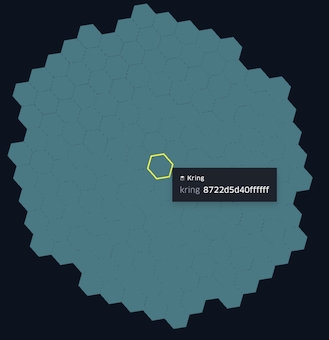

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUkAAAFUCAYAAACpws7tAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAFJoAMABAAAAAEAAAFUAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdAlpwHkAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj42Nzk8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NjU3PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CtduH4sAAEAASURBVHgB7L15sOXHdd/Xb9/3ebNjNmAw2EGQBHcspCiS4k7R2mJZiaOSy1VRyVIcW+VSlND5Q5ET2anYkR2lUk7KZUULRVKk5ESirZWSKFIgAAIg1sFgGQxmX97MvHn7e/l+zu/X9/3ufb9772/pO+8N5jbw5v7u7/Zy+vTpb58+fbq7Y3hq/5prhzYH2hxoc6DNgVQOdKe+bb9scyALBzqI1OE6OvSg/9dWNd6utcfcLKxrx7lxONAGyRunrTaP0iowjEBxbXXVra2suNWVZbe6vOzWlpdcz/CIwBK0bAPl5jVWu+TQHGiDZGiOvkXy6+jqVE0iwPNguCYwXFmYFyguue7+QYHisBsYG3VDkxOuT8+nnnvBrS4uus7ubuFkGyjfIqJw01ejDZI3vQikMEDa4OLlK25tacl19vW57sFBNzA+5gbHxtzI9DY3OD7hevR+YHTU9Q4NAaWuq6fHbdu33z35pa+4DoFkW6NM4Wv71Q3JgY72ws0N2W4tIxr74srCott5711u+6FbXac0SrTE/qFhldnhurq7XEdXl2mKNuVGY4z/unp73ckXnndPCSj7t01J41xpGZ3tjNscuF4c6OodHP/C9SqsXc6NwYGOzi5378c+5sZ373b9sjP29PWbZhiZG1dlh1zRIs1qte1RP/JueGqbcz1d7sz3nnW9oyNRvBuj2m0q2xxI5QCGp3Zoc8A4gB1y6epVt+3wIderKfbS/LxbYVFGoLi+GBMt3EQr2rais869WKM8+I53uj3vfKebv3DB7JPrEdpPbQ7ceBxog+SN12YtpFjaoABxcs8eTasjc3UqGNajINYmWbi545FH3K7773MLly4KKLvqpWi/b3Ngy3OgDZJbvomuI4HSBLt6+9zwtm1mc6zRE7MRIqBkOs5Czh0PP+LGDx6UdjprdsxsGSRiMb/nrx3aHNhEDrRBchOZv5WKjhZsFtzwnl1uYGQ0siUWBCjyAih7+vvdnY8+6rr0iWtQR2cdcVN80vA7WmgHi0P6jsvRmhZ/eG6HNgc2iwN1pHazyGmXu2kcEEAtX5t12w7sd70DA26VhZkSAWDDnolWet8nPi6QXBLwCvC0Mh6BYbRKbmAoQGVFHXvotdOn3Py5c255bl5+mEOud2TYrTQC2BI0tpO2OZCFA20/ySxcuhniaKrd0dXtxnfusql2iCobUMrXcmrfPve2z3/OfChd56LZPVfm56w8tEyAsF8+mIPj4250x3bXp0Wjnv4BNzw56ZYXF9xjX/qyW5qdkymgp71aHqJh2nnk4kDbTzIXu97akTXhdQ/+2I+4QTmJM10OZQ9k90137EN5/LtP2Q6dsZ07pbEOum45pQ9NjGuhqMc0zGjBSFPtNbkaSZvtlOZ5Wdrl3/zGb7vOnm5bBLI94m/tpmjXbgtxoA2SW6gxNosUXH8WZy5rNfped9eHPiwyWrClUGZFnMvxpWRRx6+eA6DmlE7ledafDzYV13fiXnjjuHvyK1+NXIqwbSbi+fjtzzYHWsGBtk2yFVy94fLEEVyuP3v3CpCi3TTBq8DGHAEkGiVhWdNw/swPE8CLQQ9g9H/Esym7bJtT2vJ436c/JbuppunthRxY0w7XiQNtkLxOjN4yxQBC0sRYQLGVZLQyaXmdXT3lXH8yVBCA9JqiB8IsgEecZS3eTB846I585MNu/vy5SKPMUGY7SpsDZTnQXrgpy8Etmt7AB40LUNSfTWmlya1Ke8NhnIUTO81nYFifi27ytltLu/7UZYXKNxuntEWA2WuNdeOn/EAdVnT60J677nKzFy+61/7yL93A9HbRvpwSu/2qzYFwHGiDZDhebqmccJsBmFbjo826+rRirBN7+rVIYqf5bJ+21eRerS47aZMjctXxU+HgFRE4AmbYIosAZIUe5YMWfNt73uNWlhbdm48/6Xq1Im7bJiuRUh5soND7DmnQDBhaFMLsysDRDm0ONONAGySbcegG/J3OP7p7l44xG9TK8YQb1F90tNmY6+NoMwEFGh0rx376C9DwvLSw4ABO/z5U9bsBSJVbKig9K95+N8+KfC/PPPe86xnRQRrxarwVkQDDtRUdDiyAxvZpZ2EKXDt7+uRO1Ou6xR9+b4c2BxpxoA2SjbhzQ/7GlLbH3fXhD7t+gYcBogdDAQzgx/oxCzXLAEscgC/slGho1+SbODgmDS2ApuWnySrWAZRlwZf80JAByiMPP+yunD3nFi5fNtDDlJAEw67eAQNCTiMa1HmYOLYzaPQNDrnTR4+6Nx57zPVNTDbXRD2T2p83JQfaIPkWavbIlWfG7X7gbbIvSrsCEAV0HgxNj6toc9gqqytPXI5GW5i9atNjprYhwqJWpHsGNK0PFCLgXTat+N6PfdQ99hu/ZbbWPp2SzknpBoZyRDftWVss++Ws3iHt0mvPkDG+a5f+XXMnNGXv05S9bdsM1DhvwWzaINnCRqUzGxLpk2dAyKZ3nXqPahU8qAxNH3HlYSqNiw3l1mBh01L7dMAuAGs0E7sEreSDrbO7Z31luykBGSJAGxrlyPS0e8eP/JABICel874ChirbDxSR9hwPGHpPnNs/8JAtAs28dnx9yp6h7HaUm4sDYVSFm4tnG2prQCSti47n9yYTaVn2veVr19zChfPak3zSrkQAsZgWqjdvyKf0Cy1IdOmAXA6+NZArkWGn6rMiOqGV+pUJ3S2wcRo9ogsaAUoWnnA6h/+mPWvhikHCLikD5PlT8G0FwALed33oQzoceFT2ygVbFLJI7X/aHEhwoK1JJphR5BEw4vAG3GiW564JKHvtjhf2JI/fslcXZunosakpW1HmhO8hTQOPP/O0e+XPv+EGtk0Hm+bR+VfmF92ITvHp13ULAEUZIKZeaKPzmnr3CTABHw80WfnEdH1Bh2ZAW68uDrNV5ayJs8QTjZQB4NWGZsBu/NJizvDklLv34z/gnvidL1tbJBezavNsf785OdAGyZLtjvY4KHcaFgRG9MmiAB0NOxhHjhH89A/gAWgOvfNBN3fpkjutKw76lS7IXTACi6VrV930wXfbKT5+ql2megBQrw6aYMWbQyciXaxBjgJDr3Pa4CEQom4G2rjdBA4A3aI09aL2TtLDJw4ZfuDzn3VPfOl33RqDgd7nHRACV62d3RbiQBskCzaGdbD5BXWuz9kiAKBgfob6NDDRpx03xndpOn7xhOJYmb3z0Q9qqrjsLhx7xa5mberr14xOldMlu9/Yjp3q303hrFlu9jv5APA9Ag6eqbPPOQmGXmtlastfZA+Vq43uyuFMSVacQ6xsVxEtWsjXBiCVU7TOFaC8ZZ+7+xMfc4//5m+4oR27rR5V5TX6IlrIh2C8aBS3/dsNx4G2TbJIk6lDMMXrk2sJ02dAwTpbbAczW546cEUbiTsRcfgjLXfI3PP936/p8W6zW0b3XBchJkqDS0+PNNcBHTlmgFY8qw0pPQCwNRAwp36Luv+GO3DM7qrvfBIYKKgLGijnUsKbpbm5wiC2gRj/AtCWpsuAUxQgfVbUjzpxO+SRj3zUzZ09Y+Drf6980n4qE2C2g4G1AEfZHCi8JI12efZaKRNHpZz2w5biQBskCzQHHWXp6hW37TZdmMUBtQCiggdBAxV1qHrBOqXS4NjNwoES2qp0B6veBQKgZBd43XogiD0ynYQOA0VvY0QzBCwARZzP4QOAhe2yU+dSwiNskCwA9cAjgavxJT3z3G/JyxZlStpe1wuOVsIPPPB2d8t73m37wzm/shoMl3Su5ay7dkYHA8s/kzMuGQSGdAbm9iOH3fSdt5vjOu3ZDm8dDrSn24Xakklnh5vYvcdAgKl03m5BJ8ceNqLFm/s/82lN837LtthZB5N2ki8IZAUWta4/+fJoFpvpfLc04CEDP+pvdRat9TW5SNMCPAmYH0IBJXkty/EdG7AIaEZ8ht9VG+gTqB+RaxB0vvKXf+K6u2Vj7u3Xls5B1z/J7iV/MLBOTdd5mHzHvcnqpTSvTz/hXvz6H2lfebhFuQzEt6O0kANtkCzAXHwRe+RLyMnZ1vEL5EESOtbqypLbtl/HgP3gZ93TX/19uaNoZZofm/V7pdX/yoSV504dXquTvAO4/lB0vQAorNvcmhGYyEUgRl1XVpY1LV+MF3JypE9kZY/Ki2k/U3pD6hJZVWWtfGlPQP3Qg+8y0wXO9WjJFTAUiPotlhz+G+0DjwYK6rj/bW93C7r47PW//pbrl1dDkEW5KiLbX643B7p6B8e/cL0LvZHLQ9NYkS1ufN9enUhzt2ke5eqDtqW91jrRpn9y3J387tO2lc6pA1pQx2Ma3qHFCaZ2ESioU2IbxAYqF525mdNyNzrobrn/ftNsy9GzMbWZF2RXXFGZBhAbo2R6w+njAOWq/srkY4UBlICv+BIyAHTki8/l5J695n+JlwLAiemAgOmAv/UBI6KAdMSZvOUWtywb8YWjx+xQkdp4Uez2vzcKB9qaZM6WArDswqyDB23bWwhXG5CPldrdd9zprsk16OU/+RM3sH2HHLm5LTA+nMGONtNJOvK17Naij9+PPLJ9uxtgAWlswnUJROtPfXNWNBGdTs6ijd/qmPgp1yP5oP3ZApAApXAQkLFQwsq5Klw4m0YJ4SNt64OKVLB/oqm1/yHxaTMD1ZHB7PD73u/mr1x15196yZzV2xplglE32GMbJHM2GFPtbk070fzoSFG3yZlJavTIZejA29/h5nRgw8knnnQ9o2MJMNTRZjp0Aod0DmswW5x6LhoOWo+tqNNBY00otYgSLzksI5rfl8gkTsqeanhn/EM7ywh0gBABbdRWmNGsM6aNi878AT/NpStziiiiASUatxa0bv/AB9zjtsBzTdfqalumZKcdbjwOtO+4ydNmAJA6QI9A8sEf/lvmxhNyKgVoAHiA5Mzp0zbVw1WIjmfTPa8pCgwNZKBdU3Vwgjj80bnRZKLV5fJaluUpbZYAMIUCJfKdl4dAN5qxgJ76JAO/E5jWWtB33IwAH4ur+J1KF4qeqBD9q3K8t0KZ+kIj9bp48k33+Be/bHZj8sstL7ChmjUVUtsP14cDkZHl+pR1w5ditjlz/TkYHCBhDsAAKACIOw8ftl08dDTfuZimmsaoOB4olMrSkZ53uODMayuggUsMNPxWJrCrhc4dTmuOaEUbTvpQQj9/0G5+mAJFVrCpMwAJXwAx7H7UM6InJFXikspnoDL7r56LBtqS6frErt224QAt0gCyQZtEtmf8MLlaIx7osE2TpkG6ojS202XjQBsks/BJAgpAsorMQsHE7t3WUQ2osqTPGYcOClCYHyAdNe6sdDzTsBp0GOhkOouN06fLWXxVdDo2rj8VDa7q13JfjNZ4Rw7PdsalFsUAQQ9U2DA5IMMc0wVevv7EAYRYBLJ35UhZTy3eRrbI4gDpM4Mu8sI1695PfVw3Us5EcsRCnNqYwS+SKXxKZQOdk4O+BqS5M2fk0H7WLcmmyTW6OKszg2kDpefs9f1s2yST/DYQ0os6J1ubsGpkH5GrTRnXn2SRtc+AEgBpmkwDMKxNV/muzobfnmmSvCSPGGQrcfI8KL25/pTJo055AIOBhHRC6o0TetdgNPW2qa7S+YGoFrJ4z0IVg4HfnliqntCoutpUm7pKBkrnZ1lGJpBt+w+4wx/+oHvxD/+TbM06dQhvgcV5HRYcXZ/BSURjOpyEwWh0xw7baICT/rD8aOdmLuk63a9F9JRtT+rZDrk4cNODJBoMgU5adyVZh1UMyeetd2jA9kZ3xwsPoUd2NI8lnQrOyeI8e4DI1aLUxcCHRY1VTVXlboMdT/XLGziodlEnG1HPVlzpAD2UAW2mDYruSp0BqibBtx3bI+0QDTPelZh+wzfJg+Wbofwm5FX9jJvX/vsf0IEc827m5Ek3pus1huSc3if7NlolPrcsyhG4WsK3Pxpk//Bed/fHP+a+8+v/3g1qb357pbyKtS3/ctMv3HDeI53U3GoEhqwc41bDZVnRSvK42R/NDsY0UHaxOU2b+OzuZZU2P/jUa1UAgk4RakHCQFcAgtZrp/hk7fgJbWX+yhXXp6PXDMTqEV70vcpZ1DY/ti0Wzp/BJAZZDyxFybF08Ij6Bw8CYAYE5Y+2ivyYtkybqyzqEA0Q+u59ZPXeU0LcV5943L3wB3/YviUyeNs0zvCm1STpUMsCkNsefdgObe3XDpre+JIsE2CN7ia0sfCaXiOBxoGb6Sd7mG0VWfEUsTGXM/6KBmO2p0D5QT9ayZq0U6bfXvOqkCMeWCeMgYaOSp1YLPHaFFozA0TUgSspyz+oTMCCzl8qf9XRA+ySboZkYCtDKzZENO/wIQJzJAX5gkYW4nzwdeB78tn/Tvvtu+9+7ea56l77q2+2d/N4xlyHz5sTJOmgErpeaUjsmuGgCb/QYaO6fvNHm3kQqbSF0qJp4JojdLQp7fp4X4mV+4GOwbmNhC49l+noycIBOw8cHoQtb5VhC0Oqa6TLqF7quLZAwi4W/a7/K52Zjh00AG5o5gEBGMCFh4VALuZHxRYs+kIG2tcvCHVoBkJIA8O6Zcb8Ovze91mbHP/W3+gSM84ijdyz6qZr/1CaAzfl6rbtmpGtbdutB21Up2OhwRl40DkMIBqsJCOwFkcnb+t4LDSwsoGy+fNaRtn8KumpjwL0Lkr7paPanwdkgV+XFkwAFgASGgAv68BKwyKQueHQGfU9WFBeBtLwLlC+1APtzBat6uWp91HbRYNCpe1UbwDSQDLmWbC6KqOoffEUkJZaJH/4JV7RNgDllE4dWtDuLFyF2qG1HLgpQVK90q1pQcPfi2IsrtepGvFfaQCWBdk1Ed6yAZ9IA6eyGdVJj7ZsYBi71ADILBrYp+pCR64NvMMUYR075ffa+Fm/A06Ar7fLZU3XKJ7Riv2UtvC00q5x2/I7Ppe0l4GpaPDaO3EAV3738RuVVeQ3vzBTJC1pkA1/AMcdjzyq6z+2mdsQHgLt0DoO3JTcpYN2yf9uXI6+dJzC+pHSonkAPP6cxaJNBU025S+aQZN01NOmoepoPPNnQOKfG6QnLrZNgqVrEDfTT9Cg+topPtAROFQGGkBlWXdxC/gATjsYWOXBB4CFtmNBy4LeA9j+VJ+gJMX1NVuvnssE6oacDOoa3Ht/4GOql3xqNeCHGKTL0PVWTnvTgSRTbW7GGz+wz/XLN42RuYzmAGjQ6XpkZ7K88kqL+kzkGM11B/E0N28eDeOr8ytfu0tbda0ASMM0KT/GYLYi7a/0ir7yolMb4JbDjBRCE6/icmxhCFCW1k9bRY7qkTm+CvRpy9gNJ5FLkMdoMSzMASQGlAL+sZ073QM6Yg/TeMtu4AxS+xs7k5sOJNU75ch7zU3o2oRu+SMK2YK0IFoIGgs+e2lA5N95cECTooPix8j0D7ePSJMJrVlF00iNBKa5UW7RQB3QXBblCF0qKB+2I5r2E7q6MWEe/HC78VoW7/yfHtKrkHjv80iPmOOt8sS2C1iHCh4oJ3SJ2b2f/Lg05o03RoYq62bPJ1yr3TCcVOdQx+GuZrTKOl0ld23sjhnZ+gAh7F0GhjEg8Q73FDRWAIZpH3Fs+qeSvHbTcMEhN0WJBOqcbC0sGwAN7KY9MlVAqwf+vPkmXX/yps0WP7I9ZotbPxaDXiig9EBdv7T8v3ig5NzLKV0lsuwHnvxZtVM04ED5ntMg8y33k0AK+w0G7zHOa9ShA0U7+sa6RXY2HKPtMFwB4YrsYR5Q0OSYWWIHY7rny/UgzRY7024AVjSOhEazsazsb+icpvkpP8os2+lJ7zWiilaqfNNCsjyLq3g29SUP8aAlgTaWVmWr1NBVkI/QTh4AOoNYUb6RDwMic+Jo84Fv8TC1J38G4Nnz523lvCidYah5a+ZyU2mSFdefQwdkewq7W8aLB0LLYbCAE6fc8J1FD3+GIpoYAWE2gaYTx3/E5axETt3hOUhQ3tgR2RcdNIg+tMmkTReaAUNfN8DZa5yc6mOasojw4NOSDq36+sMxjK8FKw1tNqCVAEiKjngRuf6Eri/54Z1wWbc7zp48pbt41MZ61w5hORC454QlLnRu1omlGXjXH/wFg4FRglg0hyrtQ4LrRbdRR+E3bFecaE1Hr8ojkX+eR/IErOnwjcrOk6fFVb6AP4COtoUb0ZL4SSc1PvM7LkYaLCi3Xw77fPLH79TPAoOB3gULyo92reRfNmNPG5/Q2iRY3RXHx2QQQYNsRbAyRBdnj0bBl9qK0m7ePN+aIClhjuSZhYZ4FVXCZNMwgVBp15868kIHMVujOikAVyQAIkPaSUE+IaADzW5Z2xKZ9gcPohXwRUM34NMzwAjddFejX3EI1CsZaBcCdj8bDDAzlA3iP4BtoIsA1JRZOHvyZbOBAV409aa+FnyZ+sSUgPYMQAOO8Iawwp3ots+/mgf2Y4l/4CFyMiMtskuzFxFYIrd20nocuOFB0oRVwoLMmqbC4aY4Bauz8Ll87aqmJNLK+nXaioR3+o4juhNm1AQ+i2ZQj3H13kODnZhTL0LG9356btGjymVMuR4N3izKNkqn5bkWqNZjFnsiP7MtAkZqA29vJLcscGA0CUxwT0LbLU2f6AA4DIChKVSI67ks259387JFN+OpgInqi8fU33gNL/Qb9bNzI13iRHK9CxKoq0B4Xnu5L77ymq4UYdEwYJ2DEPnWyOSGB0mEFZcetMQu2RkZUXvtNB9O7xmwVWwWUwZ0NSgOuDYtlH3M2w1DNiOdHFunaTAlO6kHDKaz3f0cMpF/+5nRg+uJVrZ9fiHryyBjF3KJv1bnnJlH9OlUJV1yxk2MgEzZYBAUCoiSxKg92TEDncicnymsrUVXzFIX/kyT1icAmZQDwNXXl8+ygRwo49KbJ+T3OxfdsCna2iE8B254kBy/Za8b27XTtEOmlAAhuyi8RmHCHAuwF060zLkrl93Q+IQJbii2kj+gxoEZ1kFKZmw+fmgLl6/o7MFJaQp0ghRNRJ3Fv/WaDt+hZ3VN4LOWH2Cbkq4yk648nrdN09VGEDAO6MIzprKmWZYEEOyRHsBqiyr7HRoBcjt2Ls7M89nnXeFDTT381Jv2MQD1CQp+kgdyfOXcOZspqbUL5tRO1owDNyZISkCYSvcIDO/+/u/XoaQjZhczAdWUw+8I4Ts2Gx9MOPWO6TDPtvKK3ahGoH38PJ/khyO5TbeUMITIUo/oVJ5ox0yf30NN/qLZAwudhWsMuNea934hhbp398W2UdEXop4Vnqgc6uw1p8r7vA8x7wER6sHglpy2Z80OWkhvYBS6rhChPOEr7UqdPS/ztjNt0oO9GhpLBPiEQ/45ptrqB+2pdglmNkl6Q4IkCwVLV665XffcZaP66oqcfuMTo0z0EgJI56kK+g6QVGx+GtllQCqNapYnxnMFnkMFgJBOaSAiLckWJqiTyuA//sceBkBSV+L5Tuz3JWO3wrwAgAejTWXZIKPOiq0XesoE6AIcucTMBgZclhrlqfJ9yzKY4PNqAAkRjdIVJVJ5QqPnbdFs/F3h5LVBNjNm6nl1WffgcBdO38S4lIb2ok1G9uWOVt4IlLvIEAkEdBrVceWhY9AnEDgTOn1mCV5I0T6W5xciY3+WhA3isFLbquABwBYIVGemlBwQgb3VQFRAZQsWEABD7CPqOMQFbKlzqEB+oU/xYcsj9VzShVi+FX27ekChXOrHYGG7l6SZAZCV03xUQR83VF19PkGm8XEb4HGgivis838qn5nTp+K29tzKn007RXMO3JCaJB2lW6uhYzt3WccvKiKABgstCNugMvGH0zZnW3UMOiXTKG8PCwlGviS0Nv5MA+alaG9eTqQ1U0foY0DAmb15Ol9qnU/VF3NH6FN80Ai58yVa5AAMnVsWzQBiNACozvEKLmBqWp1I5NnuJ9fzgq6D6OrV1RpasCpdz0T1kblV8byymp/4rcgjvKO+0JgX1NG4aU9z/bFFs7YWWaQNsqa54UAy2jUz7yYO7ncDIyNVOz6yVroqnoR0eHLKAKTqfc4vCHsI15+0YulES+oU1kGJoLLyBDo4U23UM54BnFIAQscmD/LKQ0iGuB40yJ/7b8yUgA1QgXdmr6zNB34IcBTBHNyhKyeLanPc8J0BxngYKGNakEEP0DdNvypfZkU0c3U7J9uOe5Yuvf6GeXT4gWMD0e0XQThw40237RSfOd19vSfSJNQhygQEkY6Y+TZASa8f+UnrtQEEnU4cvHeqcnQODxa1HSdf3dn2uOLmBT6+DvnSx7EB7VYepkD+cgtiYQ6+Ak78QbPVH/BI/hlZsdYsQCUu50iWqmMNY6x82jdUQO5kd7U7iAzU0ZIBemy9MgFxz5CefeA3FgYJPLPh4PYPPeLmz502Fy8fr/0ZngMBWz08cek5SovR9MpO8aHTpEfK99bALsoJF54k0JnGxO8IsD45vMKOQ1OHYRoYCa4/xCBfsZljqyzrMCq/VFB6OrtpY9SnQIAO6g1ok0/oQP7sNbdDOZR5NBAxGGWrO/FM48SsoDomgaYMrTYAlsmgQVrMC9goza5q9LN7p3obKeWba5ny4Zk+sPvIHe7ABx4SUJ6z9mhQRPunEhwIL+UliGmalA7KKT465mxU177a6qrehQomfBLAK+flewYASGDRmHAe5qQVE2KVB0DQAbGJsVNEESMn8lCEJPIx0OC2Q+xygerK6jH206whWa6BkOig7lmBK2s5Ph7TRzscxL8o9KnFHbXR/NUrhVJXEqmuTLX5UwNUXgd7kIwxcGGj9N4IyTMwk+Uk+Y1NGBk9/P4PuFve/S43L5lt33eT5Fa45xvKJpl0/dloxynPFICPBQBO4vG7KhixuyXEAEWVLiPhJlQEN/5eoYIOVfuu8mP2B/JfTbVbZc+jNiZ5Vu0Mijt/EgxXE47r5v+paS+aI2DNogGAgWZjGnZtASW+G20qi/wrvC2Sn5oH8FlUXaG34vKVN6+4DckrRHtuKF71tAM5JGe5QFjpGARYtDr8vvfbgtW5F4+6Ht3xA4C2QzgO3HCapHf9QWhLdaI6PDQNEVtRrCkljzazTkKniTtOnSxMYNFycwl9vcz0HhpMs20QJ/dPcR3ooPCRv0Vt70Rb5m95QavhAhcGC3jhAbRTz7gdmQ1XnTR4gA7ZI5vxOEu51IndPDbA6TlP8PWN2rB5m+fJOxkXQLOBRqCXN0AjcobCcNeHvs/1T064Fdkt2xeD5eVk4/hbHyQlCAAEU1w9Ra4/O3Zap84vVo2ZQYdgWkV5vpPkBWLSGcACkjk7Zhp1lG9TvQB5bcgfWsVXNC0Phmgm5lIjIOyWAzqAaLxXXAuiw3jjv/vPDZnnf0G+1JVrNTz/8+dSncIGPQG7D7X58t3/wWtrb3368y8BIbRnqdE+i7CfKh95KRqgHZ5hQrnnox9RNpFJKvigWpTAt0C6FrV8Ts54QfVgqI7K1JrABUdLWo2d08GiV08fd2P79tr+7JCaWoVadQ6mlGWm8nQy21UB7Zq213bKSlkZHkgLeCVBO0OyzFHIH1urPszM0ClwAhArWrrqYkDPZ1pQQgDEXFDIpGSAd/DebL71yixYBnU1TVn2XQ+EfGJKWNeedViKBgy+wwPPd2yEIQa8NNKhi78ygfQAJUcAPvD5z2mjRQTsjfK1cjnijr5m/S2CAktTkp4yddmKaTuGp/bX6QHXh1waxY/WTD2WtS0N14jO+ESfgfExNzQ16Ua2T5uz96gWbTjqzO9TDkolwqZOgiYVbCRWRyQv65gFiEX4TdMIDBoRKWtuVhfcD46NF+6oaGq4q5S9U9roEVZwMRoAFTwgZ+Ili3L9stuxUAIYAsoWxF+bAcQFA1u+zZBRnvkzEInjhPhAi6/QUDJD6COvM8dedt/90ldcj/yIVQsz+wD0Vh+1F21mg5vic4IW2qfZ3mWPX0X+dfZlp67ctfglaXorJN9UkKQRaJTe0egYMxZNRrZvswNiB0ZG5Qs2HgGmQNMf1ACg2sKBuB8UPNQr2P+KZmELEqKtbKBDQSt33eQ6L1Hp6KQsnrDlriWgYZWj85d3k6FNGFhKhRjEbHoMcAXgfxo9yJy5QOnTwC+OlATFtHS8Q+sOMhiQWVxfQCzkgE/9AMrjTz/lnv7dL8tOuV2KxzXZKufkTykfUgEgxwkOaUtvR3eHtM9dbmSKS/Giy/HmdTrWk1/5GrhpbdoGSrFiUzVJ4dD9n/mkG56aQmqiqW58HiONYw0Uf/rG8iP5gg5t6NXqqv+O3JUKCK2m9jb10HOwIPqtc9nhF1G+nmZfJ8rydQVs2AOO0zdk2MEVEuDQARoAb0LpTgqhqqeF5HP0JvO/nh+eP5kTZolIfWlfkcp0vtpVIUsG4Fq84k5dyahkqORXMp+05PDy6Df/yp1/7bgb37PLjtpDe2YWNjA2pr6m2ZKqgPLR0SGfTP6Thon8nX3lmHsSTZSVcnYyldcX0ki8Yd5tCkgyamFnnD5yu7vvYx8zgfMg4TsKHGzUWXw8rxWU5jgdQMBk5bYAlCKgHDAN0bRL2SvZp0w9qCdTP0CLY9/8VMhsgxAk4TWJNurC/EOZs5cumi0y5NUC0I7GUgHNZuSqo6I3+/ZsFr3M74BkmUUSyjZbuNrMpuaAZdEg/hs9aOB6Dh1oX1yEGPjZ1eNnXfDZeB3TDjD6WkAFz8jD8e897Z7+8pfc4M7d5pscmr4bKb/wKkqG2rMogy1k28EDNnKxwOE7FY3r/xplRRwAEsBBGPheKkhomGoHs0XWEMM0bf5K5NhMGQaAsXQitPgt9uu8SIR2/Xc9Kx/cdELTRjlMy0ICJJ3dOiYaap328O1kHZX4WmRgJZn43oxSw7pgX0PY/tC0bGFJ/PMyW4TAMq4/WcozOZLwmD+sEsBb5MgGYNFeAUvxvdLf4mdszLtuP+IOPqxtj2fbu3k2BSQZjXvkv8ZRZzRWZIHL0vTVccAYAGVRiz3W6ap/zv5NwhEtkERO49kTZouJECKk+rBAR+OUmmjcjvMQH5J1iJ4jDQtBh75oelxyMIiLg5hcdlKfrtGn6oDG0mg1GB9I2p+th6qw2k8uMGhTeg4BYqnkqa6ABjysNEJqxIwvlR/24uXYXJExVXU05VFWq63OcP0b8mYbIhblAxu/TgLhesw6T7SL8rjtve9z+977npt+N8/1B0kxHxeFAW3Q5xQfhLew4Madkis7I1cWAMSLRR0BSHutfNBKuwIfr1VbVPLGwiQg1sbb8F30sZgUDSYF6leToQ0s0uQBLJ5DBuuM5Kl2Tgt4LlCmXwABUGvBIhdv0gqpfSf+AZDQBhiXDsoDOy52vWjwS68rPLAyrUCVmyjb+FSHR2Xpg38MRDboJMrMnK/oWt/N8z6347573aKuEMFefzOGsD0kAwfpIEvaTzt960F1FJ2pB0iWCKRHGPz5gabF5MkvFmSEqiwt9YpFaNEG0SCLAkAFfOoVkuM9Uz1soDbVLsn/esVib0sLtntIPE/yIflMmuhA2rTUxd/B+5ADAjRbntQl5qEHRH7jj6ktB3Xw3rRnD9TFq5E5JYs0ZYKnGdPCXR/8kBuUC94ydZFrUKZAv1JfJ72Ba51xJFNemxwpY41DUskUq8uN796tTwlYoKxpCARzXaOMMjZwUYMlQyTEkR2TzoxNzIQZDagFgfKwR/pOVLYIDpYlz8JB/BjUCieaTvCgPAEEEZiafxa6kxp3GPrQJNNBu2z+pgWrzrQtA4/Z/vSJ4zogye/U2Y5Fi5+TZWbhRzJ+82cGIE4Vqj5qrXm6jTE8ULI5gruk0JxXNYWvDDZxvZNgWLUJRMrQNR1ovXDxola8EIcWyNtGsoO/aYHXbgMaxSMM9X2aanNTYbTg0iB+np8kiDTWivJfW9NZhFooIWCEptMyskY+gdJkJcQsFtkFYmo4r92wOML2LnN7sCWTPASkx4WmRd0rXTulTI/d/C2CRl6Aej8HTOQES9J72yZ+csqgeaF5YsTtYB2paN6JdNSvTOciLYMgporIobrczCWNFciLv2OH8tAwk6FRG6E1o9GLuGSSws9ks6R99+bWVTiX9YSRvCzrFoCdtpvnia981foTGiIr55gxOE9hWYOC7dhiVmd+mFPyxZyydQdmUce++dfyaLkWHxIcvg3WKQ7/dF1dgOg43NM8fftt7p6PfLSU8NdjBR3h6oXzAkk5zQpMEFjAuMohW5KESJrweuFUZ2TaBI0IRiPBrld24/eAUZiOQDksHDCypwXoJ1Ci1Ynv1E/f4cfsxQs2iOC876eKxN+KgYGLtiwDInTkqvYPWFF4Pa9BkEE58ljIOejEbROQpAjEaoC6bP70B5SJCydOuO/8xm9JllbdgBZe+7Wu0K977oent0kRGZQfpjaGaAcXNn5cwWyBUuJ3UfeD46SO3Jp23SIzT9l6pqW/riDJeXdzZ864ez73Wbf3rntMy/MdOo24Iu/o9GgOFS1LDQQkZgI9CSzp0bRCusYw9Qm+cpvsXDHdnl9srQRU6LRmexTIIJxwAkHHxMB7f4irTxfkU50JV5MQ9UU2yAu49zbnvDQy6KGtoVm1IiAvtG80A8kJkDUEIaOh+0NNEaW+Qh8ydenkSesjI9uinToMvH6RiDjW1+JPe1apyB3p0ER5Z7ZNfd4Ioat3cPwL14VQOrVCZ0+fO/DOd6qDDqIOldIQ0uhGyMpoDaSnEf3qXloZWd9ZJ1cHsilVPP3PmjZLvCj/yA5GZ8Ws4O1g2IYACH/HM1onozuh4ufHc0iNQ7yjfNPGA+VrGkkdjdkqU/MPZa9pQEDaeMYsAW/wXGhNkL1RwFE6iHfL2vZIe9CuRQLpGOAxaZXpA/XKJn94yY4dbNrU28uUyR79mb9EIA1//D44Pm5nMLzx+ON2V7g6WiLm1n0Mv1IRM8W299HgrIbpHQxZlCG3R+DI1iiYbe8D8sY3RlnmmwYmbdRoLEuf6t2rnTWtCtjCqDeaDNNSu2JWwovmxHs/kifLp14Y4w0sRR/xggTl5U0cZdsglR7lj1ZZG3wd6YhcvwEwsq2TYHXkwdLyEC6YvAmQbGAIwEParExecAZ5QKvzPAlX2zgn1RMazRYpOfLlwAuTozp84Dc07qn9+92tjz6sGeUpKUwBBpfgFdyYYWlN0o6Mlx3QGCRBhIH4QS5dvWy7alZlREZAudRpcGrK7XvgfttU75m7kaRybxbUSQC5sj5ddHaCHymLUkU+xpuiGTRKR8eX8BU+dTvOG4EvW09PZsi8fJ58wkPrmCkHfkTTaXU4xSEwYKBFEnBUZ6rXqsAqNuWFCNBcTrOPpsMhaGmYh/hcRKZJwwA9rkWgNfXR8y+84LqHdf1JfE1wwzI38cfSUD6nbUtUvlOjF3+DWtHi3mPuoOFYM1wfBnWaD/uUEQJGOXZb8N6EOuAITwPQIQDJsiBMnfgzVwppw12iN0+e1JVp35xcf/p1ohEDRfAAEDAolcibOmLD9Noln4WC8mGAtHrqOXR9qSPtSnvU1tdchvQ7danVomrjFqpbWqK4vnbHUQvqKwba/9ZHVD514xlt2YYCvicDv4n/aJJlB81ktsGf1U4MBIe1m4cqvqZVb05Ux0SwVUM5kFSFb/u+D2rnzKjr04kh/mgzE1ZN/WCGCaniVX2KGxyugBtQyAAwMY0M1THIhzyZwuEulBYi5/UIALFj+rAS+8rRaeFHKJp8/uTJ4gtAXAsMPk6WT+hilZsLs5gV1Fsxb5pXzCv4pco2jZ43AvU1Vx59buBnorymfPZxlU+pENcX0LJtlaUyq0ks2jzg0bbIFVfkRgNY5GK0oc1FD4pHp9y6zIWNJihbxxqygnylbqoPM5fb3vte8x8++/wLdlziVgXKQiBJR/CuPLe+690GJDSgCWgshHxfju1C1SMfdqvoLmUcvyP/xfKdyjqRbFHYoNAmm3aWjC3OdLl7RdseZaM0lxnqF/9B9dJ8dEgw5ZkQI5h6Jl2vblK06RPxAwdfHlsyS9dVNPfpcA3o3gBAOekmfSsCdYSXZWYJ0Gb7rdUcG0AmJ9HktaAzA7w/bs7kjaMjP2ZTjmysdoWGFq/WVCbnQdJOjdocbRLwtsMtFHerBXgHUNKWh9//PnfhlVfd8rw8EDQDtVPutxjBkeEmJ1GA5LJ8w6YPHbLRiisGInsRjtzrDQgz+Kse0SK7BNpnxa2DOCUDQsHoW6YTpZEA8NGh+KOe2L+oE/W1e2EQZvGDDmyLJ/2JxRMBJSMmLjcm1AHqmaQRmsraXi0/tRl1og7Wjqpz3aB41qZxhGRnXZBMtCzUlFukHGgFfBjAknQXyQt5Q+tG3pRZkSwapoE++Gx79vVpg3UMkE0SGk20JavlybZqmO46/whdyBo+lVw50YWbGlNuvd9qoRBI2hRPWhKr1LbYqIpZY+SooAmBGpJPO+xWYFImAFQcwtuSoHr5ToXw8YzQ2koyQKiOUgFn+ot+t/j+U7Rdk3mB96EC+SNkofOkHVn88p3Lf/r6MxD5aS/l2xFucbsD2q0I0GC7OzTYeHpaUU7mPH191bE9XzKnzRCROuLKE/mIRgkoJ2tZxIs8F/DIaTDgZaCllVGiei67id173D0f+0i05bGVBRbMOz8ymcBqS5+MrcOTU2YTKyy4NKYABJcN9iMDdIUCNDG1V34tCcqXOgKELOBUgt6b4PrPyg/VD6RjWkY9C/MqkSV52AVh+gyRXyLraEor4GfVlryhGd6y2MYzmrUfEPismCCUCVP/VgRaFZceQDh0C2cCnpjPFV6rvXHOZ8CovAtYcWiC51ZfPRcKSofMtYK+QvQ0SGQy5Y8O3HqKpMuNSgAZp/jsvutOawSzwzVgQJaf6GhMY4vmhSAs0YERKD0HD8oToSX/TJ2qhgDqxbSpsupYkkbyM+0V0CjaiWpo9F/Jjzu1fX0phzanw9FOdsq13lVCbfmqmwfTYG2hMtDcW7FLg8FmQ6B9Em3Eogl18ucAWP1wRRJNofnvaSl7ik+UTwJga9vJF7QVPsXriyfesEsACytKLaxHbpA0WsR77qVBaBPNUIhMhAyNZFCH8PLcaOTjN/9HXC+g3HdDZzZ/uBZMLzhaDLsiU+2iwepm6TVNLjttFGgZn1og+OTLNA9+AhTwlHfGa8pL8D2NFwxRtCeaaLgQ+d+WFrYUgjCZWFAd/ScaorURCoFp0tGghCcDMtCnwcIWRZTAy2CUOMy/5GmmFE9T2WyVz1IBJcT3NYDL5K0sHSnpmUkua1H03LFXdbujNplo8NlqITdIAhg92sQ+pKk22kYIvc0ETQ1ZtciR4JQXRDovK+K4vvhFFGjwbj/zWm0MspCRKBugwK5DZ/J0JH/O9Szh59KlJR12W9S8gMDi19iyqZ4qRBk2dW4CiGl1h0dMEwFZpuhlOxfpl9mQAF16Dh6oo9oXflqwNopkkfc9gwMGiAwWNnAoUlIOmAHpTZQ2xL+qY2UQFS2hAgtWAG8aD/07/+nrw6HM9DVkFZBd/z0QVdRP9Z1X/rPndE1ECzXzMhTnAknroEL9yQP7y58qXodqxAK/RGuQWGARGkCRu4A5i5LRPNqGp611euaPqSxpAM3QAfBGgwoR8GHD3QbAb0ZrmlCShj+mvcnOGoI2nwfgwB8CXCRAF9NFOqb57BXMh7LJixlLKftck0rUgodpTrQ5gWYXDcbrFBmIzr4sxifLv/YflYEmDg3BgvKkjyR56GWHdsZ8QFsDhATccJgJ+L5F80U+jAHrSTn6o4yrugt9Qfe/d8hPdyuGXC1Bwy3Frj9RBwgDHJ4xNBxMM1sPL9U6vKNxmd6ghfkR3Tcy0Xw6v3CQBi7EKxRUfu1BvoXySSSCj4Nj0S4caLVOyaemc8l6eaFNJI2cvsUjA+7kD4Ge6TSsWJvWpLoXDVYP1YnOxZS1aJsYf8SXVoZSoFSCR/XqFBQgUwrxbeztsb6tbSOB6kP5+PjiogdvOHsAE4MNeCn5FX1F26IAnT9+3LRIFVA0q5amS1jgm5eTdP1JdubmKbPHgHEAZTrDGNHT84KeqENFjLc8GI3rJUjPpvpt3IjsZEBwgtXZaKKekQ+l2QBVZ4SQUZwBARBMA8IB2W47RRemBYS6shhUTXmhbya0WqTo1RQzSFA9bdqtaV5WzRQafIDftg1RwE1nDcZ/X0D8GQyUPO1FZU7pmfZTT5SBVtaXRbjISqCyTPaitlKhEVf0WaerWT8LQRt8Zyp/4dXX7VSgrehIDjOyD9E04JJcf7QPu7TrTyyctR90kKhTyNbpBa42UpPv1rBKy7bHSoM3SVP3ZwkKQJWcptSNW/AH7J3UFVAH9BixPTiirW8IoslspFptDr26iuDbgIClWc+hAqaRKq1Y9fXtG33G01kVaPZm2Vz55A9Ng5v/lCAUOev5KE9AyeyRZfOP86rYE9dLyf5E22JKaeGAUCHG2jdq4wrgZWlz1ZN2qaSpZJjvgfSA5NzMjFvQn9dm8+VyfWJnBknsQotXLrs9995rixitcFKFcWgcpabyygMhY681AluqcyH4ElrTglrQHtQXTRAQgeZaMG4kiICLB5pgpNEBYvtUsDyVkdWzcjFVtFLNooBN+9Th2EbH1M+m+Ros6Dz89Wj3Ur/OBMAMgd0seH3Ff+Q4SAdVXtYm3Nuk5zzB6iXeE5CHrRyg0q7/yFnHenWa0R04K3ZrZwsGwXqF5nyfGSQ5zqhbtonLp0/bwkr9KXFOCpLRxXiAQqpU8m3uZ4SUhY0KjbEA5spIaUK4/jQrk6k29Pq/ZvFb9Tsd1bQg8d5rskHLUh0pY+Fa5JxuTvn6DhgCUj0D/dEOJj3znekm8z1ADL9NTD15wScL/SFByerS2dyCRTwL4gnB7iKPTRLIg4Gm/bL1/qEN+rXwWKlDQRKRMVx/zh57xfVIodmKrj++apnRiFG/W1PB088845794z+qdChJrs+r9CcNgOYWJCgv3IEszwyCh2D6Pys/psW7FwWhKZmJyrO6wj89lwnUcV6+omXyoRURfOyh5NeKQL441VOGOYer3hEYqjyK1O9Wtv/0RCieHUnGd3hVkl8+W2Q6qD+iZdyAd6Ib0GePO7LGLiIGJgYMA0a9sxtEW8R/X++yn6XlQ/WjvtgjZ8+e37KuP55PmUGSBGhW/ZOT7sz3nnNHv/XNoAIL02wV2Y+ynsIyn2oMRqwFuTPYfmQ9U44JJPVJCCM2M0Z0bKJ+6mcdqEz5jdLGgsI0G3AoE6gPtsyy+QAa/IlBZchpnJa66s/z3n82ThS3lejyNkTfhs3SNfq94vpTkv91y6jNV99hLXZf6k3bM1jYgBHLJr/dcKG2nikVqOp3+h0Fhqn2wkWBJH1gC4dcIEk9cOkAKF/9xl+4k88/Zw1dtnNavuqcHKEWxD6UYDjC6K+OpYP5BQHAwLYy6tPsXVqssOm5pJgpP3ZCVnn9tCJEp0yQZY+WdyBA8nSScSZaVW50FmZMlfhgd6wEAO04x/AfBjLa9ig/2qzg2ogIQCrJt0Zxi/y2qI0PgveqpPC8dopfVZcE4GRqx6rcr/MXyRCzIbZrNqKV36zfJRzS6X+DE5M6R3I8zMJZC6te6PoGKtgju8RpaZRD09ytO11aAzEmx50gdH3RJukMaInWMQAIfTdh1TPn2DHlsRVmjXDJAF1MiUhrU8PkjyWe6Rjka8BcIp+0pAitH52h3/8Rl3KpOwMGGjNajAXFYxocYsCLMmzNv5G9lAW+SBMrU4rJXJkM6qQ1mZErVacA0WYKdeI1e23tqLZSAzaLumm/I0tNtV/oN7mj32lhTtRidhjSxWDD26fd8b/5tuHJVpW9QiDpW4TrGt588kk3umePG9FebkaVIoJHGkCIUEaoPF0bPpU/PoismnOKNKp+HrGDJkwBamFLvyH/vC9EDyBltNAJAgZ4uajFETQY6ktHA4wZ2FblSkO5FTugYkWgE5CA65BVp+rl6c4lb+IN8f0gQUcNfqp4XH+zM5ZuWwa06kH7OrC3JUWgDFhdBJYE2gHz3ZBmpdxzc/rpp12vPBm2oq9kKZDEyMxJyaefe95NHTigQypGCwMlHdlWtlvSRE5G4viCMNFcMwNqXqIaFKEHYLyG1jxR4xjWOZVvKwLaYXS1aORfaDspqIPAxbsZIaSNBqRc4NOKSmTMM7ovqRpIAEGCr4Npz6ovgzhyRjtij2RRrhXaC+Uy6BuQ67loaMUsoygtLUkn3tA2Yzt2udWONXfuhRcFlENbDihLgSRgg1a2KoGYOXPabT90yKawjNBeQNOYy2/+j9/RcgAfrx2kpSnzjvwJdgd1tYkoc7bQywb8UJ2Kjuo7c2YiMkaEj2iL8BQgTDMjNMuqVaaAZuXm+Z02McfmWH6sbfRukYNOpPV7MFxe1PXA8ekyBjyKA39Ir3/yFNk8rvKjXI5Xww0tWFC+Rm+wDLdIRvE0fGLvXrei2d6Fl49p6g1Qbp3TgMqBJHxWJbvk9Dt/4aK7OnPRTe3bZ2DkR2+iGBjEajbfGWXRdFCtGdEBVd8pWyEI5EmngKYQYV4uHF26M7gQrXQiaTTQEkorTdYJmuApQsYAZsCRjJDxGfMCe3e3emAQQH6QKeQMvlJ/rzHzO2dh2iDMgKE4HiipG3FbMTjbzqVYoy3NQ2SGfiJzCTOaeoG2Z3DQh/GhWj6R/cADQj1C8ryPiLU2mBRQXpm55K688YZdQb1Vpt7lQRKGmKN5vyp3wl2Tvx5AiSD6HRR2oogElEZjZZLfDDj1HfBiAYXjw5Z0GRCrykU7dlrbUCZ0ICIh7E/kh0GeFfHM0zWlqRZY3ECqp4hptBd95++hri0zT349LTplPA8NmeLSHpItwBCZ4g9QJDQzaQAoSwtybpejOrOM6ACH8kAC38vwvn69lW8MvJa/yrG+ok8GRRzRV5Y5Ri/2v1TfAjHNzADAikdbMkC/BjfMRGM7drpzOvBiSeaxTi2ohsSConUPA5IqHdTvkT3h0jF50I+NaMVbh/IyqtGoMABQEDNgBI0FSHiggEHeLSK0gJE3UzJ2bYQK0G0aC3ZUBLEm1HYQP+0zW6G5S4gvLQRJ+B5cS1Xb3TBBbZ4tRB1TAmryG6pN8Lc1jS8gz6xfIDOakqpTmWcCdQQckW8CcikYtU/fn3hPH7S+Bl8C0kTeoQL1Y0bAZoOxnTvdqWeftz7GITC51xBCERXnE3RplQZjxXt02zaBko76F4BQeRvZE40DwPg/Xx++dwvIqkZK/2OJT8rvG5KjdcAArQgh9Yu0j/VOSXmM6GgnCKT36aOx4Q+LJ37gCEhSVVaVDlH1tuAX1QHzAkCfp4NZHZV2ywfRaPwSqWWppe0xI4VZ2U7hnOSOAZDg+YudnNmX7WKS8oGZgQESGa0OmlHJJLHxfXWszfxm/FPfASQf+PxnDRztHMtNlqNwIKmKrC4uucHpaTe6fYfZT/wQkLlhTAiilUFGY5hWKkCT7H/lxT+NCoG6bHbsRU7ut0U2oZv/JJGJe2GqNU54wi6gkIFyI3tv+gnURcqiBezqXwF8ttaIOidbzvICaxH6SqcxmcO1SyepS1ZscCuYKW1qZzDa4FkLUgUzTSSz9tVMhMGWGUzVYKiyKd/6mj43hmhgtz6V+vvGFJvxBvpYn5jYs9fd+6mPuxXZxo3mzSAmLjMYSOIOtCw73baD+ytG8yLgZIImWwR7kTGqi0PF2SNhwNaJUJXKJ5UCAfCabrSTsNLBTDgtXrQg4zXi6FUsvIl8+B0ThNc4Ez8VfqSe5g8asJNae6A1m80urfOtkxsJeOReYzZC2s53SP+5Hn1LPVFP6F+4ysp4MZmjTe06h5bUNRrw0aygz+StSDlKyxbcdXndUs1gxERytOQm5X89eeshwxXwZbNCMJAEhHB7GJEmyQhXphGYUgxryxJaYBnWABqsMprBuohANWkV3EpsVwS2omTIUpbiYF6onAZdsGPIGmhCAABAAElEQVQmi6UN7Ja9LOVXJWzyhfz0Z6vyDDh1Am3ubc5M+5IDhTnj10m3VV7TOTmarersywbEebDyss5iHnY12iF8iAYocysqk7/aCPMXtG/lAH0MCGyMwFaMCG5WCLbctaYKceTRmKbaCE2ZJrD0GpWxs3gBzMqgSuOLyWhVdqpK1sR54tGI6hDYg/LSWCnGt7w+mbJbB/DvKpEyPlBfXIsUPQlOGVNnilbhbYbYtTzpkY3am18yJN+0KHTIThZHFKivrwef/rt9qu2XNdPBBgm/bcFEtkDcdHy8kJUgzxUAGDoAjZCZb7G84DWK1qzuvZk9dVpHNJboYwHqFkSTREhWtMI2sX+f64933UhSypMXA4Zf/EhmiND4P957YQZsWO1jX7KNQvFe0WTaUM/mXxdAWuGf2RLx9SvKN/GqtHmiCWMMDERrsRCAUcUKzpeKDqrFNQKaIQHgW5CDOpr0/OyVqI1i+eNsRbR33MHM9KK0frXZEgf6h67gXem8rAfKemtmI/5efPOEW7qmY+UEmJsZikp8Nc2yF6xIoCb27gk+tQU0OIAi2kUh4I2BE1AxMNQngGigiFAj5LgNKF10j8dGe2A18QW/qRzKLwxqiWKBD9NIpSmUgRLvTZDIOuBjdN9MwAy3blaxjNnCiKjEZMNJUnwfGFm/H947rPuKAF7m3uYHEslgkKB8Vld095AOvQ7q+G756hSfOoNzBMZlJLJY7U3pEk0X5C/ZM6S7uPEU2cQQBiQlHB2aaoxMbTPQCMlWGspWDDVCXz53ViDCdZfRCO8FBmHlXmyAhimr7VHW4oUBrD6jIIENKbSaatFpaNDSAf4pH2yUNp1Ko1PvqgBZaQgmyLGws5pcFac0YXEGyn9F5hQDjTTacpQDfUxRbZpaMq8cxRaKilxVQsxvP0jzPgKRSgx74B2DFWFVs5ogQXliu4ZdIfsWdaFNPdgn60M7obku6c7zlshUA8ZQHkrP1TO6i1sKUpKuBsla9lP5Hq4KmevP9u1y/dluU5KWMFXa6iA3BUpYzC8MMJQwmiCb9MTio4aHqbWMXZDajs0uSFD+BmqiobacUvkrX3oCJgPzv9Szz59FMdNcBaa4SODzxifTQPjNn/kzhqpjsiKia4PLSfL3HM/Uh0GMP1+3HMmjqKorfGp1KEof6WgPbNZmoyw5kCJrHBxt4tGiSrPIiduWD9SB++HxB27KBwgLFCgL4L546qSbO3tW5yVo2SRc9oWoLA2SkevPtRrXn0K01E0E47ipMekkyzv/Vzdh/ANCxh8jYxAApwMIjGwls1nhBX43wJMrijcjRG5MaBOxQ7oGB+/MzjQwWsXv0l3e4wVKy5YEQN60UAOKDBhb3QcT2WRgQUY4qagMqFtdxXzyI99WBPpH/8hIddYZykJWQ7oUkd+K+vrFEyeiXWOtqW51PZt8C7C6LW1HUzG0SAysTDGCAFGCcBM4jWgGEhkaLpHUHgER7khZQfsSuNm0sUA+Pl80UrS9/tCaJAWILuxatgigToHw8o5Ohu60oZPE9eC98R1AIfAZ/xa9KPiv8qGTWrmh8kwjpV7ecfmqjGmfOODTfhwwEqR+abQEekfbmcYs+bO2K5Rv1J4sDrUcLwrIC3Lh98oXql5Noggkl9wlnQPBnVr03c0OpTVJDZU6BWjADcmvMe6eLakTzMIeWTSYtiXwMTumB5QimanTkpfd4FdAqJoViZAwMtPBPK2WRmVtAMh6mcXAkjl+vXx4H/PK9oK3oL6AORdj1dUM4/LFEKu/mVo0YHZ0xCueSm8DQqM6bNJv8J/2ZNBr5mOaSqLVTU0geSP9Wz0YvyT3uP5cO3fB1jm2wkBYHiRBRtkLX9MJ5djMqjp2gFZFyPw0OdKlymXqRyoWf3guEky7K5IwQxoEBdMCHasoyMEnpse4Tvm9vhmKrhuF+hblVd1M/Q+qrx0rRlvoOS3YgCHtsRIsXqRdA651AbaSYHMfrB1VPzYeeD7aZ0X+auqt9+zEog1pS+7KMc+Fza3G9SlddTfXn9nL0Yzv+pTasJTSIMnpPzh7ntA9FW987xmrWE2TNySg2Y+MoAgIf0VBI1kGeZAXO0BW5P+WOyh9a/0RxU9MC0lQyEkkiz6s9kfX4Zacrqi+uIi0MqAdNh14DBhrqNC7Ctik/V4TfTO/QidTbxQJAp+AO+/tXZJ+6sV/+o22HJDd2UCzVd4LoRgjeumv9VyKmhWDgoW57sIbOk9yC7j+eHpLgyQZYaMb1DlwL/zh192J556VPU2uE8lG96UV+DQtQivaIQAyWTyLHDaFUcNaR4PeLDQrDlqepUlmGOjZyMC0kIWWRmUqfdVxaapn3kAdWXgwwC6Qvml5KI/K3wadppHTI2zQMtOjbYm3yA0+vIAivOWPdq49JQtirV6KTyAOMwI0y9JyYTm26B9kToO7dylKK6VRv6Fu13To7szxN2XCk+eIFLCtEMKdJ6n6oFGe1jlwwzu2uWH5TNIB1LqF6wlDGZVgHgIWOtCg5E0nxVUDW2DTw2ZFEyOeX+1tqgHlIJq8zLSgz9D1Na2lmXaqupkQiye+3WjDKrDNUZ8sUeEj7dCo82TJx8cJlY/PL/QndeXP2lftnDUgG9QtOuiheJ/KWl6oeMn2oK8xQNSTbX6HN05sOfvss653BEfykjOhABUJBpLQAkM6e7t1g+J33dgte9zwZPEbFH3dOFXFrjr1LwJ/Im40TrdO4mZFOWugMe0aB7RKGjZAMIGAFk7W1mfIMHf1itUvKbSV/ClLnRAgBbRYubdOqXrBGxsI1LYtCcrWDvkIlHnqgSOB8t7sbELJ2fWqB/KMSaurKzJv2XqFCjcgTCEC2UQL5XTyZcndxWNb476boCBJvaPO1e3Ovfqq23H4sDl+M2VL7ZwpjEq+spFFU+0Q1y4k8616VsNY/gVACV9FhCBUJzcwEnFFeFVVp9ovCF88ACQXcigHLRpt3X6HB/pj5d7T4DumaaI5NJ9aEup9T9JTL06e95HMZNfQ8uS9peKq7dRIW4qkesQgS2iP/rNePN57886kroCZm5vVTQcCSrtqdvM0yuAgSSfr7Olyyzri6NLp0276ULYbFNMYZ4ZcjNUt6Jxp5RV5V29UzJuXAZbACjupB7S8eTSKT/781QZ4zEIWwQsxQJMMvLetoEpucWt+T8bN/Kw8AV60DQ/EmdM2iLhhQKXeyE8TmqkjAwb29WB1bEBnqZ9EK3TCOzwDVLlS2bUqMTzN27aksYFOs5jJW27R5YKX3FWdBNQVb9ltFa2N8m3JkMs5iziCzrx+3D37x39sF3EBJrWdr5YwGJQM+EuZZlrzPhmn6DNlMZX3izdF87F06oBlV4DhDVNdALKMP2i9elh95YICENTyOZkmrY14x90jEnmlD7TzRnma1oCtWc+hQpJ+6gkQs3VTlW5YBOnQdgBIOzi3YexN/hF+qT42naU9mtStHrWN5KBemqzvyRv7IzTmDdZuGgTwzjjy0MNqk95ok8omKUvhNUnPETVkz+CAVqqOuzkJ6fSBg9ECAExLaVSEFJAwIY3dI9QnIzW9BcyhPAAyuou7ZCdVfdDIGhmlPVvqf0a2v8hpu36swr/AXwEGttcimsd6h4rqWpiORMKWLQipPWhb01JNi4xX6BNl130kLcADDgWyNdctq8QPZt+jH6ldi8y0DGAxFZkmWoKQBknpy42HpvqJPVAyOI/v2e1OPvucIrOww6ygfrpW/NI6kKRK/gbFl1923bIrjE5HWxcBQ5iw3vF81XB1UCeUcNKBWnmCMoJlq2wSshCB/CwnhDZL5/L1p3w98wG/TPhDEFSbh8qIpvHF62tto3oCtoSN7VdbaP3vdFIGqjJ51M99/Rem3/VWU9djVT91yA5O7y4CPtU5rX9rRT3J02QN4WkWFBffYPqWpyW6Wz37YmWzIkL/Dp3MNoYmJgwoTz33vLWLGiZ0UQ3za3lpHMHepy2Lrz/2hE1JqbiNMIzwiWDv5WybDLWqum/cZJwiz8Z8dXTsOhHXi+RSncZP18xGKQdggK+a3liQY1BkGojm6f+YrgOQ5BM8mLBpBwfgpucywQMbK/uFQUQk2LS/DCFN0kIbAy305uUp7WYaVtxWTYrK9HNZc0zdQrLKi+IllQ7qyIHBWz1AJ94W2Cfv+eQPuMUZduJUY0er69Dy0vDrWtKJNjvuPGIr3bXAl6xgPWGGUYx6fntiMk2RZ8pZP5klLChBK5oyJ/fQMeis/kBg3vujzaAb3rDbhFVyPvHTjOoYuFmor26yhDYhRhGWVaWhThyjRb2yBsq28pUAjRntzgaUrBnkjAf/S9UVPolmBjO0mbKDS+n0OeufJXqyv/m2yZLueseBNg6nwWR36NGH3bXTp6RBB+4jDSrV+pJM0HRBmO7iplMkG6YBXVU/kcauNQ3QwS1j5YMxuLAmVEVd9Rdo5fj/pfnokAoGBfw8OVUaDRpw4V1nt3YmiAbPD97ZNQCKa2dJVmdb+ptp71nMABlLqtjEFN93MD7tGWW1pq3wX0RrZuDw4GrbQpUmZLAOJZsiWqSnq3D+qoPlJ5pr65M3T/i/lQPt42VxS9IJjqiPHHjgHe7AQw/Je0ZXzUrJuB6h5SDJSnfP4LAcRMtdEGbai447C9KQYrgtGtR05CAMpzE1jR/QXT8NbWFSVNLq4u9XMVoCAkgr6utdlZgOEcx0IG0YwF/QASK2i4lPaWP4QwI48AStmbrzPnQgX3+SfRp/85aHza8MwEWgjS9qmKs+8tKfJT40rqqfMrvieasGrnHo6e9z2/bt13UxurP+Otkmw+/1S3AYpF+em3cTB/a7gbExAw+1QiJGvscqoSefAiCHEEQGbE331GGL5NGIamoX2RZZmChQV18nQERgC6hU1btR4Y1+8/k2ipPzN6NL/AQU8aOsuC9pAOjXqiS/dw5EIuY7H+/sPbwn6Du/WV7Rm3L/Ki+0Ig6TCBKoQ0JOammt/V5bJvUyLwqbIZQ3ddTmb99VZ/hYNECjP/ovWDsUJaZBOngNL2fOnClv/mhQTu1PrdUk2ZSvzjOxd692tQQEJDXq/JXLmTsWzOWPgMqOIJiWV0Kwahnpv5N3dAxbSdaKXo46Qyi2dFDfxJCOdojGhRaH1l/b2fhe9U7fDXxUuWBaFp0IGyI8i9s7CO8SclK7AFP1vU6Z2JxbFeCp3aVTp+ys5Va1jRL5/pI1PfFIw4AZrD1rCxee0L5cENYleVNnro3Rku8le3IzmiJ3mJFtU2Y/KD7WVZdDJ7QTn9UZmjUmv7MgwlQQR2g6kDVmdZZhvqksGpHOX9qVR3nhI7alA/XVLX5cEiamGgjWdraG9HvwUdoqsGmYqMmPygugbllQ/j6Y7CW+iwH+p+vySfnRAmTY4gzoMKEk65ZSBOUbD+Lf6FsoIT2coh6aF8qPPjV76aK7fPyE62qlZl5T19aBpBi4urjsBqandbXDjgo41ZRf6CsNgOYCGGVpDNsfLNmObFW6GgGH6tCNSE2UJwCO5pCFroaVt7wStzE2EVifV1Jo/buWfoouu4ytBD9pFzomf6WCaKAj0QYtaV8R5+2w0EkbJ7+Xor1AYspnMbTirlQgj9QkalPbdYQrW52AnGG2YnBLyhzPpC0t/zXl2vCjvC+fPiMTHld4tA66aormUKLWhMgeqQvCDh2w1d3gTMvYKb0gcwRakgaeg2kvnoVqREZSDkgtvNXA52WfsWZCvtJQk/Tbz3pvAprgRfA6VdFT84VOKsfrZCepiZHpK/XiKmBC2bzM9SdTqcUi1bZB7fdiuRZPVbXQVzybqpS0QeRDua41V0XQFw9aarDKBhib4cnkYt4LCZmsTVvkOzTRBy6f0T7uvut71mTLQBLmsb1rZNu0nbKzmcJE2bXl23RYMhDSfoVzOqNoZH8tIgrpaRBVnK8ZuRFEq0ssNOY/Oj8f1YPken89A+WHCHQCtKKkSSRPvtaJ4m12PL/Vg68vgNSK+tb2lw38VJ9C8TBNOgGIzAa4wdO0+Q2Jir8gvyXJ+blXXrU7tVrhJlePuvAgKQHFbUL/6oijkdKuP/UI5z0NaZpTgU5BWhrZ7CgCoNLgIhrQIu1Wu4TQNKI/62/QinmBAAgzolaCyu3TYSLeMbvR9C9kZyIvnOOZ6oXKl3piGqGjwcuqoPIalUNac1KXJsPzWz1QQwZO2nuz6ms8T+F1LT2N2i1LO5EfSs2MThWbP39Bp4zJc+E6NnExkJTAAip4vRsg2qey0rs1NJ4rV9zV06+70V073eD4+jUJWRiSOY7KAizKrFLDfOxpBjApjZ2ZljiiB6q86bLEN8ETjYCItwHikJ5mRqiXH6AWKnjeBXNRignzduboErN1jZC2XpQmQf3RNud1iPCGzodcEvj0z9Gbt96/koW0ax+CVVT8Y5ZgclciUwY886Mt0R4kZdC8ev4cmlEJaooljZ3VsiX2W4G4zY/Kr0hoAUXBvAksV8sOTE64kR3TtjI7sXu3NLVod0nwyolZgEXZRrSaqxXY9oRKXxjoRA/TAY53akmQEZ0FpypQkrxIf8peXAlB3VhIYH/EuADkyg9ctC1AuDA7a4Mx2gTTLDwbuoY3alCmVSkfr2mbi9EmdKqNvNr4hnqZaUH1rR3oNsb2b2jr9YGDt+QTpA/4IqJMjYfWH4znOWQsmU+clw1mZdohdv05r6MXuSJGiFlbSku/ZwdJVXJxZsbU3AFtMeyW5/uwXHsGxkY13RvWnTZTBoyADECBzxzCOnf5susfYSN9deOGqBXTjcKgliRAdYPeOfle4nbT2QlbmgtGRUAlqPiqQUvUkZunTRaf6VlZ0qnK1DcJGhXaMxVeE4n6ivcMgF09atcyHaAma//V1xMA6JU5Ac0QCWoECB5Uzc6s9rMBxWe4xT6hFVMFBw41qpORHfN74dpVNzAyVqmJN0tE08+AMkd/wI1trdg24gqBekDOOhLO+MnfMj0bn7rc5fPnI9efgf7m/MqUcfZI2UASQgUid3/iE25wYjwyzKryBobmhkOBUSPR4KZix64BCLgX3uxkNYmJ0AiUrEQ9q4AmCbL9PKCLh+yOFCS3NtDYekfd6LAENEdWZfmGL2Z0VqP9FPQfRvQFnboDcJQCtwSfbFcK/oSJd5mJjtP4aX/mdBkjUkdzQRFnK7MFlZmllZE1fydSU/DJSM/1jkb9MScwcDOlph60fRIgKzTFslj5HuDB+B8P+jyXDrG8FMnHt/mlk29qtqc+Niw8wS/3OoamIEkH5SqGsb173K4jd5gd0oBCRBoYipmEKlaKsZ65Se3FIob4B6aLri42uJdogDRSUh2RVR80J+obaSkUixa17rTcp33laHqm3ZYZOVOIYtUcraMCGClx8r5iT/1apxzrxce8gbZtSbvGhAAK8LmwU3JgmcjLnyLxsf8x7WYApv4chEJoBPQ2HY7jFymzXhq/mIk2uZkBOePULMwr9L+VpTmxZzLTYBmS7qY9hIZYkpq//bZbDSCx3UX3a0RoTkUMEPVJA9tfksJYYGlsO0a/Gk6TMXM9mwtPoLxqC4ZWwI6V82iLYTwE6INVZjRoTvXBBmZ1jzOgMdH4gttM4HHgE0+8X2Jt3bN8N7cjCW+y7lnS5YkDf8sG6KMdWbBqJa1l6IQuAMD8TQsMWEkQDVlHkw/6c8ig/Nj5Vs99B/ptsSi2OVI3lA82Z+y951637z3vdwsXL2r6njLTC0lnTV5NQZJRpVd2EK6HVe0SQJiPgXjIszK5tMBokC9tDc02uhZ1/anNK+079DGKorkBimiQaE62MwQexCEpoP5dP3cFK07ZOvr8yIeOjv0vVJ7kTV5ZtUijQUADHUaD0jINLLtq6etY9am84TdlqbCqn/J+oR3MLqnPtLbKm18r4huNGmyZWpel0Z/GVJZO01A1vRdBZbOqTq/8OEhjWWebptWVd3YwcM1ggTzAnyM6Im3q8G1uWefT2ons1bm37FtjkERgJaz9E2M6+mvEhLdoR8WHDcDxQlumRoy8NhUI3YiNiFJZaQ1bmwT+YD9CYG3ELNvRVQB5hpxq19LM98phGin0Um+E1Lcd00LqyFFotEVZMKulB3tpyEkCvGsW4LHJdkr9m6Ut8ztlGriVlGXy8YOL1aMMUaQtSU9q8aLRD7TRTDA11saXSoeyhq35dl0MhnDgYZN1kN+YYb43DUHSptpXr7rpWw/GTtLll96rtlGp8nkDNCH014tBeekjPqDC9JirK0pPvZVXSIftjfWJXJd6WdXPqD1QP/qQ2W8LtOFGGhJvlDFgTJ1b0lHjomqBhGkei2+YkliQS2qy/NYqWsz+p8Gm7EDjBzIDywQ7t9Rj3LZFBnzqhdlkeHLSPfD5z5nyxgBd246tqG9DkLQChWOTe/YaKNExSgdlQsUQPPNNrOlkzSqNzQ+7RlmhqluPGnrqxmv4g1ZYMTarw0UO0PkHA589wt+q/cjwGi0GU0J+ChkIYr9SBCMI36Ja20AaRNg8F9c//d52/2ltpOP8MAVJl9SigKZ88YzHAyNTQJO59WyCPoUabGjPPAtqxG/W30JWlLIAOmS6SCA9wDi1b5972w9+xla5LS+9b2WoD5IQpAoNTG3TrpkJ83gPxVAqhrsMI3Ytw5Lv5qXFMoVIBjom0zFG/NDBN0JtmfnLEe9ENws8ftQswjujR1oGmlWR9M3ohvdMnf00uln81N8R+Fh4jW8lBJY60onSBs/Usgu85HRrCzGdaM+YgWgn/sxHNqUT05atCMizzYpSyixUXiKfWpmxcuJM+Q1Fhb5UG69QuRkS0Sf8dDtD9PQoopuBfUqnk9/zyY+b73arTwSqC5IwblWruyM7d5gzb3ngqK4zDYbjNnYtAiM7AJlsyH5dQ5v8TjxWPQeSG+hjYee3sgHQoJPS6UMFP7LXE8ZGAuoHEPLwz6Ho8vmY/c9/KflptrUceXR0aGrdKaDWX7f+ujq0OLWm09gDLGLUI8OvmtfucYe/EY8bazleA62Xf973rZzKW9sCmpJn+m/kXZKkEDlHe94YGsnlxtgZ34iWrl7tuy7Zv6CNgXT7oUPu4EPv18Vgp+XH3Tp3pbo5A05LmtpOHzpori50gKCME8OsjLkFAV+0kgyrKaMRIHiwJh5TID69tpaxqepHoxHFbANmhCtEIB/RSGAUrdbadECH+IrrUP0QDrCryhBNnNLEdNP8PcvUV2kr9syUfKh+pwCREdlzlastlle0k0Jj0iWt09h8Xz9u6x90w/LfXF5l8hswiAhmH6vQWnDQQdZYcGAgLStz5GU7qGJNspHMF+dCzMGY6ZTpA+X5E9PTykYuadNkGp+26Cf9yvJLkZHceaoqaKYH3/mguemdeOxx16ct0fj/hg51QZLO0zs6brccwsR19oYhAWZhKPeM8w3lP5uVQjw0jgVNyRH6II1JJwCwQjRiTQW8D+Wa7FsA5XpozNnkKS/UMSt/1vNv9MQAE+4A4qQG2KmFKx22L3oBw84aMNTJRd2rbuf4rHvn3lV36/Sy27btgts9dc19/bFb3NefnnC7R5fdwkpYoESzajwgNeIVYhHJHACC7Gbfc70xX/Kyxaks2xI3Js/0Zl12IoUELdorGWRQT5aQM/q/XbwV7/jJVGCjSPR3zRS7pUli/y0fDCUNA+54+BHr/28+9YwuHayuY/lytECZmglMkiAMTWtvNn5/QmxRkRq16EtwiFEZNbleYzXLm/QY2WE+x4UVzYdyDLSlmTJ6+ilys/Lz/s4uCls1rSQUSDWZWq7XCa1Tmqjiq6KVHAo/0EkB6xB5xUR4WpGUubkld35J5w12rYPhbduX3eTkeXdgx7zbMykH6p4rbmyIw4SdOzfT54b6Otzte7/nXj1/n3v9zKgbH9CJUqE0ShXCOZ8Vjbcg46ijH+R8fQtm1fJktfQlAbJR4aQLejEYeBKvROM0X0tXI1oa/ka+AnPk+PD73u9mTp52c5cuBZfrVJDEfYUTfsZ27zLnztVV7IZhQZLs6Bw0nE1vG3Ij/UeYDWhUNBiAnEwLBFR3/Bo7u8NpVmlk1IJiVoExR/x57eZR/cpO9SK6tGqumyxDL0hIdNz8Uoe79Zbz7p9+8IK7ZZvMCQLDcYGhXGXdxSs6uXpxzB073edeOTXmzp+fdMfOdbtnzna5kb5V96s/9ZT7Z3/3KfeP/6/73JvnRtxw34pbEVCGCEEPgog7Pu1X26b1aLWZAD8WlNF6+bbi/Qa5LNG3qC8DCwPUhnxLEp+cXdkpZS3gbcfw1P6NqCKGAF6c9HP/Jz/hRqe3l1+VSjIjFjA0QBZnwjCOWwqjTg/j3nIhbhMEruig4nliWjOmDk17snZwn7bZZ0/Xmnv5Yrf7V3/3BfeBe067P3tquzt+rtedPzfljgoIj17sdKdn2MUkLVqLNTTVmJTjkb41N7vY6SbHr7p/8ZNPuRXZK//+v36761zVvded2jNf5HremFjqGy1iaOqkFeww8hZlzsKL33MNP3Ehoo3SQuT+Eq3w4vZjGukWl1XjnRZJMDFYX2VWmTOQB/bXjgBXfdQWTVvCx5lTp9xjv/nbOkot/ClBXb2D41+oLZjvoP6SzvE7r+sbd9x+uxl50baocNlgTBPTzXAcID/oQUBZKceKVW/LUlPaA9FSlj/10kN/pQ4laUWwyoJtLZ2QhP1xdGjR/dRHXnZ/9cxO99FfvdOdPDnmnjzR565e63X9HT1uamDVTfSvujEBI3+9AtYV4cpA76o7O9Pvvnts3P3Iw8dlq1x0v/bNbW63tnGnw04tBfW/R4stmiUEDvCRBcToU94ZotTLH201z15+BWY7NjVUv0J779InphemoaTdyoF6gAdF5QUgW9FWRDMVtaCi8PLMq6+4U888oy3U0c7AkMXUBUlGQzTJhYuX3LxuJ8OBk8a06XHJDor6YJ3dfwaqEVqCufAoP2vUGjpx36ChK0CTLFdxscMSUn9Pxt3sZ2hV5yIUpTVaWQ17UADuPBfnutz7Dl92jz7wuvvinxzWves9btfwihvp1WqqwBAzC9NuNEP/J1ixuqzo3aim3C+dGdCNeAPusw8ddfuG19yXvzvptgnf8uswlq3906oOSuYGcmqTNQZp5Ctx1B4yiSzSn4hnQKNngtnk+W2LB2TMgD+mu5bcZJ1qf7PvSmd8aUFdyZe+cOzb39bW2jmZy+B1KhWFXzYcwthW16tDdU8//Yw19B2PPFIBSvXOwoUiMExTvM9a8YyqU5qJQEIJbdHUJjpyK5peIaSNXG2UV1wlhCLklKyayvLfIBP68HsbHB3LR6vq5l1/ag/sKEsZdF0Rdt+z/7KbnetzT5zocTpA3Fap6/SvqiJJv6gV7VvGlt2v/vl2NzZym/vx73/R4vzS7x10B3R62FJepKQtWakVAaEXqqqIV/529iMv61R2K8tUVV3SvjSo06LkkL4MWKEt116pbACpdqjHl7Tisr3DXNPp5lX+ldNn7WzXVvC4IUhCKECJ/9GJxx6TU/mAu+097zMQylaJjbEAoMj1p+QBshuzrrwBLJkC0VisfvvGaQh+EgJAFCajcbZS86gQWvABGtFKOEbKhMIEkMyaD6G4TFE3XH/CC5TsjFrNfsfhi+7CzKh7+ZzkZUxtkRPYAMq7J1fdP/8DzV5kj/zRD73kZq4MuF/9o73u0ITut1mWZpODd2Vdf7IWFZ6fWUu+jvHov/NzNiAsaoaJQoJGTB9DY+YvlQ/6PXQgyy5p7bMXLmrGe144NWUDYuhyMjksceLGwPbt7tif/qk78dz3rJOlMiIDdaQz1x0BWNE8GhUDEK7IH85OHEKrTDROs/Lsd+Ln6YGNiGnxbzaNU31tBLe7vpsTzi4nBg8brKTNhwo4i19d6HTvuGXWTU9ect98ZrvrEW22kFGgkEXtHrxtdM39wtcOuj974qD7iY+95N596JI7daXbbJiZuxzyZq4/0gcSslCApBYnicBna9MoFoiH3AhKQHvkmcORNyMgw9xxf+HEG+qzmaCsEJmZczagnN7hXvj6f3JnZSQtuipKxUAhtL1WBIDOn0lXqAzRZwcOxMRF9LaC0rB5GjxmRA4/WMCnUAHXH3bO3LX3qmyNq+6xYyNuXHZI7I9Fw7La8t6xNffLXznoXnlz1H3hx592t+687C7MaoeW7J9ZA7Kq3p01+ibFk9wCNtY/NomEDMUiO9izk3Rm7meAmqbjXM0Rol+Rx5IOJzn/ymuuR4N/Zjoy1DMZJTNIkggGdctp+7tf+Zo799prmTTKJDOsUtJeuL+jlfYh3BXKBA8iXiCSdSiTb0vSqk3gpRnPNxEIAOk5TZMfvP2Su3J1xD1xstfcesq47pC2S9N3t9rt/vG/u8MtLXW5X/qJZ9ytu67IF1NTOxsZmnPVt2fzmDd2DOS0lbJK3pGtvyCfkFVNx0OYemhTZJ7L++bstPLWzRRygSSqNo7mbFJ/4ne+5C7IPYjVu7pTBMXHvrcs+6AdNWWNSJGxJqnvIUOlEaWChxAWnx+j35YO4vNmBppxUa4/+ycW3OG9l9xLb0y4a3Na1dWBFWUDe7hxKL98ZdD94q/f5caG591Dd150J2UO69IUP9IQG39CH9oPZphI5BrHz5Ln9Y/jlbd02tkIQR8zf1AbLNPjlaEbYOLEnS5bQaZt08oo2+LZ09M/L58965ZQulqwcu4pyQeSsEXzJ9wB2L3wvGyUVy+c961necJINEUbvVUJPgFSW/HSFJvnAXyZ9D4EkPmK8EmTGYjLUdfKT/5Y4Bn61i/7ygjoUS8sUNrmJYkGg0Xz2yvSJtgjZ+Zlj9w/6wYGZt1fPL3dDfYUtUZW8wGuo1EuCARunRTYSYaOvjnkRrvxrYxO7qGtG/3h30snQuOOdlY1jt8or5b/pv6l6pjzNqBnMKR/8AGOrj2I+iBx8LO8dnnG4tMvjTZ9rvrnJnzJXxf5SYuPjdIJINRiRnV1Qwb+hhaJAnbu2CuaamtDij8CL3A5ZNd0dTutTOb+3VrpvqwpN9Pu/W97wNRwOhh//TrKzIdadwAY7F0Cgp80orxDHlABretmgXVQ531qUN1xr8EtAWGakwCzAr2eR2qqTX9JffxgULduDahkpJ2R68/d+y67a/O95vozKb9G/B5DBJZ/ri11unfecdLNL4y4x46PuYlB7W5R9gmXxBBFbZk8Orv6DdBZQe4XCLAzs0N22EhjiuSvsys6A9OIlryhgAgqI4wyoApZncieyCKhXdkrIK5e4Fxv63XAgs7197XUgBWLWimHbvpMWvCDdpVc0i8FkrNXrrhLr7/huuSczyDRqlAIJCHGfCh1StDErt1qlPoEVlUuUQvei0dmyDVn3MRvRR/Jc5ltYhjAG9CUK3+fj4hlysbUu5sFD/++Xmb6ncNBLDSLWy+PTXhv2+yyLOiIH/zHNA9Nb7Bnxb3rjgvu1NmpyPVnXNcgyEZZPki29H9H95I7uOuq+94LXe67L152b5vWqe9JK0h9EdxIgicrT5qNubT+TUznrLbbRlijFw1liQr5ygUmT9lGp/jEV6d43tUUx/5pLsODDvq3NV4dmuivtYuHgKLHDJ7Rpvm0AcDXPY7Tq/WR0b273cVX44WbFpnFioEkRGpEGZgcF0OKXhCmaXhPn03NAR5/6kjRpoWRrJo1dRgvWACAsCJXKEZq2t7LSFV2asSGmqxobCzkVbltypdaofVEJIUX6UejYNCg3TiAYnJI54L2zrmFyxyFRTWjTuLl2ueT71P81FT+8kKXe3DXnNsmm+e//d9PujNffMwdPditk4ZSWyFfETdKbF9VA56tRzSa4Mr8ghvctcPd8clPCSMBO/sQsRDfnHBmqJhTzEfZC06dZJhNcPM78vBD7luvHTd5xF7aCo2yEEgyXV7UntQ9b7vP9qEWW3pXR5MdgdEAkPSjR9Hm96OS5eMZXDSzlHRoTCxYNT3qqV7ZAItW3c3UIP5t9YDWkDwhCPuP2fPUVn06lCQK6ggSflagL1ztd7/z5wfdT3/2OfcLnzrm/vuvHnJ3jmsxwXfughVmBfuCrjR6t1bNkbPnzuhItQGV36890Ft/R1/BWt+AySTfnX06tIOpr/oAkgEu+sGyeY0UmdE1EaxPc96pgvXrxG+mFKk/cdX12z73GffkV37XdajseIROxCz/WAgkrVjxYHLvXgONZXUciC4aqmx25FMPaJoUgI0z1NQ9rahW3+CXVuZmvWOUBhgROu8Ty2cHmwAEVrRZtENJo7+0xu1Dq+7ffmOX2zkx737okaM21f6V/++AOySH8KppceYKRehKJ9NShLvzwFl3+tyY+w/f6XIHp09pYQNjffnV88zktCM25oDkhPawP0ASzwO13boCSXumYwTYgZkHu7iXNV9YLTj693ySjhnNtv373f2f/Yx7/Dd/y/VN6HTygviRzDv5nF+liQnrn5qKLwgrB5BGTFwpKmcXfKmMRgHmJEGZZ6Z+1mmapG2Ub9PfyjBfafEIQJO8EQJtwbSHQYdn26WTpF3v0K59WNbjrdqC+D/+/gH35W8ccj+mrYR/76Ez7sUL2j6plegI8nzs7J/LsmvuHF1wuyZn3eNHZetiS2IOR/LsJbVjBuOAyQYtHv3pa/1gfTc6rIXFmNwAp/QoR9MHDrh7pVEuXLqoATzsFCN3jzX0loYxsmN7fBr4ekepz4mMv4ibc3IfEqeqEiRXvigfXzC0HAAHOyTTdeKYplOVcot92VCvxoPBVqI+i/CyR/vQyJr7b79yyP3Zk/vdT3z0Bfd9R2bcmas5txLGFe8Se87NdbgPHJx3w4Oz7plXh7WqjYvLVuJMm5ZqDmhAZKWZ/6u7cXU0/02RGIjLOJhHStKy23X7He7A+9/v5s6csRsPfBFlP/ODpICpckEYLgcBl95xb8DdoXYahZuA53jlmll1IDouzAUs/TSbUQWmbf0QOdpnolP1uTHqJEVPbXJECt8vfPGQThYfcr/wnz3ldkxedTNz3XYrYpZ+s84TTdUFiPcfPuNmZ4fcE68P6tg12TmbrJrDqy7JRDLQYe3MgPi6kD6zL6O5rMfiXMJ2KMkB8ZN+Gc0d+JLMr+pL9IPaCn/PLINwMqeNzwyeK+7Qgw+6PQ++0454NDPexoi531RLUobkthKtJf7R6ekAFasuEEZRsY1T0nXmRgc06D5r2S+SEl5hsvKwe2RuCKCsrr//VgWIqgd2F7MPKgK/oUlTx6p4PvEmf5qhXif3jOhw3V/8f+7UIbwd7n/RSePbJq7q5HH58tWZKtNc2LH4ff1PYIfrz84r7uiJcffGTI/r69VxXDgNpgRkoFtTrR79zct1pF8LCZ3K2N5r5XPm8qw7duwNN6jTq48+/7w7f/GynvuieALVc+e1OCRRA0AHdJZqrz5Jyyffed8OWTggJla6bOUhNSEKEaay8rIsmVBemIjueORRt/2uO938hQuGJ6kF53iZDyQROHXOAR2dhi8UFSxfuRpqkdKaYOdO0ovigODytyEoTpe024p9ckOErfQi8v1Ko8h2WsjeB2852oyByQfr8PHR/6k88BE38ROXoMHeFXf24qD7+f/7XoHWqvvlv/OczIk63GBZl7fp8N11IOQZf1nNUJa73MmrXe61y13u+JUu91enetxdujRsWlc6PPbSmBtUOgPhlLohDt0aYF97/aR7+YVn3fj4hHvpuSd0rqWOzJP2CCA++Pa73d/7yR9zLz77uPu5f/gz7kMPvcueiXfqzAX3sz/9k25yYlQA+qS9f/n5F12fgPbl51+y70effzZd7lLouWlfVbop/TOlj9YyRg3HAmAQHFF/oa8AlHd+8INu8rZDblEO5xuVrloiGn/PtbpNYYvqtHvul+Cbl3t44xDMQmti6u0rVzv9blglMd1rmaTfqkBCHRrTFmlAaM6SIFsXTMY3PsWmhSrvgIbMuX4/csvh2MCKO3Zq1P3TX7/X/U8/+YT7wg+97H76393upnu73IzOIMFSw8o4vpB7Jq65MZ0a9IEdzm2fumLHrd22Y8VNj82q+mvu+TeH9btz521wrPTESoV65A90Vprgj/3wp90//Nmfdjt37nBPPvmU+ye/+D9o3/dVd+X8a+6Rh/6+u/POO92CtMz/4id+3P1XP/PfuH/wX/8jd8fth93/+wf/UYDY50bk9/vz/+QXFe+Ie+qpp92/+JV/5v7Rz/+Cu/vuO93Roy+73/7S72nqP2vXLyTbo0LIzf6gNrUmEh8i95+NbZVkEc7n2p/WpC8kUzR+pl8AlNyeesejj+remy9G5jvIyIDZabnnAklKYW/01P4DZt8p6/qTRpDfW9vouPi0dMl3gKMHkQrY+pZLRtwKz6LL7nBO7HKp3cqJ1NW2Lx0UGxpap7kmbYW6JGhAJjk8d8fIsvu27qz5td8/4n7ubz3t/rvPdLuvP77L3bN7we7a3j6+qBsVF93oyGUd2LviBnSYxbwuBJufG5QWOOC+9dKQe/aVPToqrdsN6V6clXr2SDGoU4t3vdIiZi5fFr/W3AVdPbJ9eps7c/aCqOl0V6RVHDlyu/sHBw+4X/rlX3FPPnvU/dq/+V/d448/7l586WX3U//lf+5eOnrMfebTn3Df+ta33ac/9Qn38rHX3Md/4CPu9KnT7kd/+IfcL/3Kv3H79kyrI4ZXEBLsu/EfEdjG+Gh9NHL9QZPMN6ltxKCo72txedu0O/zoQ+6Zr/6e65ccrOkA8SIhH0hq6O/ULhnrtC0CHSrIFiTKKBMAERtVZO+wXTjKd6sF6FuSfZFFJ569ZuI/m9KrNACqnRSNI+0WCwaUctnZP7bk/v03d7q9U3PuBx9+2X3iPa+ZFjmjcyHXVgbc62cH3dOvbZeGNuyeOz7q3ri85k5c0g2LV/oEfKuaZsvG2TUXDRTwKXqqqi3vVqRB9IsP//J/+z/ctWvX3K5dO90CsxI7U032Kh2+e0nASedFU/zGX3/HvfHGCfd3fvxvKy/d4Kj/WNy5IFvWz/3sz7jf+/3/4LZv3yZT16qb3j7tfvO3v+hWr53TtH6XrqSQD2k7FOeA2tHWDpRD0w0aBUoBdNEo5zQwRlfNFsgkTpIPJCVcaGkv/uVfuHdMfy7akiZC6OBBAh1A+SnDIHlim1hejBZysFVmAl7KVmUqQEXdSgJ2Pd5QBteR8lkpr17keu9FX3JnTL1om/kejXLfyKr71/9xv3tdVzqM6G7zF2RvPHqh012c7XVX59EkIugb7ZY9U36VI7Jjjo3Lf068AaSWV3tN6O24M8lgWpvAw5GR6IriOR0MMTw8VLXKPahDWc6eO+f+53/+L93/+Wv/yr158pQB6N33PeheOnZCWqh2jCjvATnS943s0oJOvxvSASV9aqPTZ067uwSsd933dndx5rLsrJH/6Gby9YYuW22FcsBMr7DsN2CAKSDaNXbmxaPxKUHFNf/6tyWmEcCURmAzd+68WxABeLqbPUxCDLCFCBzqaVPkEPmpIdAMCDAtDcyr3ikOK8n8efcBRiOLE4KeFAYxmnoaU37O9crbcnMluk6RmRcMCgC/89qo++ar/W7mqo7PW+txQz3a992/4sZ1teyE/gZ6pPFphZv4HJyB3dK8zNSWuJvN6Kj+xZmZSvskye/p1QLN+fMCx2FpknPSCC+6M2fOuauzc66rb1Qye01T7zPua1/5beWvu5qVz5Pffcq98tobtip+bfaK+95zL+oK3JMGoJcuXXAXL824d73rHe7EiTfdwYMH3R//6Z/r3WXXC0gmC7/Zn9U/WDvo1gAzceBgJNN6l+w7yWfYZVdA06/4Cxno9wLf2YsX3OvfecI2caQNqlmL7Bie2p+7rTvkYrGo04B3v/3t7shDD2tE0GgQAChNo1I+oRciaBy0EVv5knAnA+40pr3qZa+0hhVNz6DDNE+9A7SZzg5wKyF1DBWgSXnj28WhEq0YTXOTirCaNOQWieZFKW/4DABiS+XMQ7iJcT89oF1bBH1GbccU6vhj33YXX3wx9bh+2vmaTsxZkb1wfHTYnTx9zo2PjUhDlMaiwfLijPw1L1xytx85qNXq51znQHSu6Z5d0/b768dPuunpSXdW6fbt3+NOvHnWpoR/+0c/7d6mxco/+8ZfuT/60792O7dPyrWpmH0rva5vgbexPPdrW+DBRz9kbSymJsCSto4GOjRI+iL+z33yi0YCQso/ebGx5PgzT8se+TU3uH2HKT5FuVwIJCkMIJvTFOTQo4/oBsX3hqukddTwnRTGMXLVnhKE4ZjVcL+SzqhW22holrxndAoWECr8w3Qgoo2wATImn+j+EDnXS0iqBE+VomZV75JlGj1xPe2QxsBtoPwZbOB/tkGwDkj+zbfcpZeOuu6hwdRBCx7wx6AYgbH2E9M5VZ1uVlL1t7i4ZL6RnDgDT5ZoXwVchZZl3MfPclEnPjGl1s/ulVffdGsLZ13/6B63c8eU4mxNH9Vkc173Z3iuQb8hSGpgZMCzk7LgvfoT1yJjK646Cq0s8WqzNQ2UT/3BH7gLx14x7baMglOtVuUgDuAYEEIf+7M/d0OTk+7/b+9N4Pw6qjvfsqTuVmvfLduyJO8LYMs7GAazOoAnxmAMgSRk8jJ5ebwswzCTkLyEfCAL5AMDmZk4mQwTHiTzAjOAg81ibLwA3rGxjVcsW9Zu7XtLvUr2+33PvfXv+//3f7lL3e6WdMtu/f//e6tOnTp16tSpU6dOnXL+q8x1J++AjwZ4vetPBnQ6ZgW+HX1q0AbxwawjIAOqARqD2gRlw/NCP1UPAqOl0MoBHFhNg+fCwJq50eRgRn+s0043qUx90m+bJeqfFv6leuzWQgTPmDoLQ68BiARi1CY2cnwSCSwMlwlG/RiSoGxMIxKMJAQkCeEJpNNWnKyJ9FRtssmpX0I0L48b0OP0H7o88jqRomE/ouV5ZJPXRBaMLmzYInzl9rVdxxPF70XHWG4hSZsQHAS6ePb7t5vavGj5cjtsnoeJmPlpTBHXn050xmbnjy/6vHUC0j9s8mmamXAETztAX7RX1dZhAgQnXH+aVJvvEUJRs7q4xdo7qLB20Q565DeKcB4joIWPaXjUCBOXkBojvJRQhS3vkoKysQ7Pm2kHDvMFwtIEpsjC0p1TPSQ00pdFq54eTuJEMwuaaSSAOamjFYresPwfVn9QN6d3OAVEOcp7PPjEfYlEXZwWorBpuhLOIyac1TV6z+YSeAwOje6wcxqICQBBjgbtTwcZ7jxTGRzjmTjIw3dggQOaM2XME0AmDTRq8ljbBBfTApMDOMH/TCIeb/BNk9RkJdVIpYmE4JwioZYVXgJE3VdYl7YeUqCLQdmne6TAeXNaXcYMPwoJSeoBqWlyu3jiW7e4Ve+9zi049dTaVQ4Z8BBza9nZLUoCMHCCOTnTTVj5E3RcLk+HUIYOJY4mdw2PWc5mwBl8RmKBzfc8+LSvLsKVPMDmCglSx7oaaN8xv0Ht/A9w0F5JmDbCtzfCgXoOHeq3kzcII0vWJpM21v5IMClgqwQYiTKMXGyk/jf2S3D0fzznO8Jj05Ydunhqq+VdcspZxhMbX3zafvt/5i05zYTO7jXx8ylz3RlnrZTf56AbzTvVrTjzPMHlpFAk1Nau32ICctnJS+y0kIc3babcp07WMWDhOF3HI/cdOOg2rHnWLT/jPBNatHWNTgdNUZzN05af5Pq0UbVhzVNWfNaC5WZDRaBy0shNm+9WrFwm+OD2imCc69ZukDlhcKc7cdnZErwjbv/OdYrwtczNlV3X4HQvciuWL43Ku1nupOXLjBah+jEJpyjPUR5Bvuell2yS8TQs8llYSNLLaH8n6PMJGUkv/cAN5sSZPFucpuFmr2LmNaYt0qSxZWF/hsKUggMUOAgcOoG/vLjCFHZPiD6TDDIW85xPhCj0H6M1q74sKVR8TtrIcr/MDSoE23655lz99qvdrl073RNPPmlaG32ElnRY2s8uuf+8QVFiZutI7Y/vucfN1aYOO9VoXTN0QgM8RzSZ7tOO9iy5EgHTa3d8bti8zb37XW9WHW+1s+Ff/spXJfSnut//6EcsL5oX5X/IDvje/Xr+f7l58+e5Rx551H3pH77qXrPqPPfrv/IJd9ppp7m169a5v/n7f3InLZnvdu3Z7/btWOf+/C8/o7PkM9wf/MlfuT/7i88IvzmG+0MPPeJu+d6dOjI5261+5lH3nus/4H797z7vPvjh/9udvHShe+H5DTpm+buG95f/36+5C3X88uMf+225Mk13N3/7e+4Ht6utixa6m+VUjaC//kMfcX/7d3/jVq260H32c3/t3nn1m91v/PqH3Tduutk99PBP3V986p/cunXr3ac+/Xl32+0/sBNK7772/e7/++ev2Ummv/nb/+7uuPt+dyIbWNIwgyX1lZ3jLmCnp78JGL177frCrj++XcWFpCCxZJ0i4hO+/Ylbv+8uf9/7oojjGqjinlQNL0VY+FaKeYtofh4ME4L5ddmyIdLWMuHNBCAYJJbDteVtrYJwX8yNSsLB15cLMrgmcM4FIy5UilkhgRCDY1Dmi4ULF2ngjrjd215yl7z2SjcgVyBO4Cw98US3Ui5rOIoPik/xoezSwYjLLz3bTuKsfuEFLSd73MIFC91ll1yqnfFt0vYFR7eBTtVmT5801FWvOcd96pOfcJs2bXJz5sxxlyvazL/72MfdxRevMmEGOhe85tVyUN/sLr5olbvwwgvMJemad73DnNsXKyjMBz/4Abded7JwimeJHNQ/Jqf1D3zow27JouvchRdcYEce33bV5e7/+Dcfdg/p1M8cHZN86aWtdqzy1ee/1b3vumu0A7/InXvuOTYJvLB6rfvwh29wf/bJP3Hfu/U29+Uv/b37z5//K/MX5YTRG//VG9yVP73W/df/9Cl32aUXuy/+w1fcx37n19wN77vefVvO8rME/99/9HflKrXDPfn0z91nP/0p+afOdV/+x392N/71Z9yZZ5zh/v6LX3J/+ZlPul+4+u3umzd9yz2/Zp15DWBGCJrEb8ZyOYEyFlmRDtpd3Ptkj9RqAoAFUxAhCQ7sJk3TzDUgY+kLDz7ozrj8chModsZbiGpRqVzoc80T1ziktQ82h9D6qWkI2P8CXBDmO4JBaT6OCKIWgoQ8SSGKDRftJNJEj8gWE6YTm7U83Q5ys5Kjz9B2cYGifTCfenn0Zdpv0EBaJNthU6bAbjlgpKyLY4m4VOEr+aa3Xe2uuOJK9y833+Q+8P5fsiX40888Je1sno5DLnIHJDivv/4Gt23bVrdQv089dbm774H73Tve8U57t+qiS9zq1c+57976PXeSYqf29ekEz9IlhskffeIv3EUXnO9+/z981D3y4E/cW978C3o+5D72Hz9umuDf3vgVd8nlF7jHfvacdsV3uMcf/5l74xuudB/5yG9JA7vH/fzJh90t0urOOP10d/U73+0++5k/dzt37nInSpDfdvsdEoIL3SHt+t7y7e+6Rx57yj331MPudW94i/ub//w5W27DU0MS9Ng5Z6g9H/mt33RPP/NzaZL7BO9at/zUZe6qt1/rNq992j3y00fdn/7h79pxTOyM86XZnqRz7dESv8e99orLFAxkrvmGXnLRBYZD/8CAO/20le7MM8+QPfKwaDbXXbRqlU0+CxcuEH2457qcuAhsLA6rfosNq7HSNMWCL8lJjCvGG8pan1YMwwf2uRknLg2y4doCi6aodXzIDYpdWqbs0UwJwl1yLEXwmYuNGLhdGiMgVT5EMmEmexgbFSGTF36YCcbgHlfERhF/qP/YM0l0LGVZfoZpoYEd/Ud0Q3jbbnxBGtbaBVMWQNbskTS8AIzRBrb/Bqrny9Pi4osvdT/60V1a/upcuJatd999h7v1lq+5WQoY0q0TNBxfPCT78hf/7nPuUflennLKMnf6ytMMn2gCtgAAQABJREFU+P/4b//JNL8hTaxopWxcrDx1qfvuLd+UVveS+86/fM19+i8/pSU9dr9Bd/Hll+lzrvvwr/6yfCnvVQfvi2zgEpB/9Md/akEz/tc3vuUWy4a5TT6YF15ypWmZaH6/85HfdE8+9bS79NJL3KOPPa5lf6/MAnts/HxMGt73v/119x8kfK+QQzva76tf9Sr3la/8T9t4ObRno7vxC39mAu7W226X4NOGnPgMN5te20zSJpD4j9933nm34fvR3/tt9/3v3ybNcaeOY37QffbzNyp83Dr3xf/xZffpv/ikacmcW//TP/lD9/zza9zDDz/iPvHHH3e3/+BOt37DRvf+G663JTubT2UkeK4xCj7jxf8xnjHvoQRgTmKFyB/jDOHaJ41462r50RKlTP0WIgXTJEEG5IfkZL7iyte6bjGjDTI1igZmSsqPEAnhl0jdtStgs+LRAWk6CYGkBpq2RfYBqfr+rm3aTwciIPnutTvrWJXNTJcO+NhrDQirVzOy4ZWmTJs8Ec7KkJd2Kjcerj/WBPEamuQpp5ziDipa1U+kGa669DKd197rXtIpmpnzTrbdXfKoQVp2D0oTO0m3Lg5ol3dYdsQ9Ep697vf+/Sd0fHGHhNajCpCx2ATPc888737zt2QDPOkkLbH/wF31xtfb8vOaa6933/v2TbIhflrCo8v9wR//lTv31Ze4Jx570L3/l37V/fqv/aoE0Jfcj+++zS3RxsjeHXtNWN9z733ui39/o/u3v/Fr7oEHHjL0d8sUgBC/7dab3dm3/kjP9rm//i83uuu1IfoDCbktW7ZZPk4KYTJ4y9uvcde8653uO9+71b3hytcp5uV0CdHzTai/8Nxay4udlF1vIhxhmyUxQSBsFpx0plu0cJ6tbmbK75SERkbIORJmBv+d8mjqsxasgHTjkmx8CP/Ih1JVSi6PqK8QiIy7QzKFDGhFMKSoTH3SxIdlEhmMz+ZPFb6hxldQIWmUU4cs0KzM8qxQlKC8g7JJ9+G0XUakHDqh8Src5F3b3tRQQ8m3yX/WXoT80jpOZa5aGnBlcHViPvKYBq0IRb2yeTEp5BayGZBmckBLRIM8/Ywz3f/5kd9xP7jjdgmvbtcjHIalVTLx4rwMjgg1CzCi3zybKU3N3HYUEAOBMH/ePDvrzY6yc32yVy6w5SrCaouOKfZoIkKo6MCl2fjuuPMu9/KA3m2b7n7v333MffwP/qO79777pT3ucG+9+hrFrNzt7rz1Ji2l+92dd//IXfa6q7RBssFdopNrrmux7H+nm4a37PRXu4/82191j//sSXfBq1+lY5X9DjsmAvf1V73dvUZ2z+kybbEjj7BFOJ5y8kkmBLcoWhHO7l/4wp+7DdL8TpJQv/2OH7oPvO890rwiIcmkTTsRtMCwNosepC7Z8bxghD7+OwKTdwOKzzluSby3b/tWN9I/qKunDzpc2Q5qKd2/a68b2q9AJXqPlozQnqpVK33LjY2WGvi2CM7hhKRoTEDeHhm+Z+poErN1TPfs+Kkgl2bVBhaAcjTaBqvsNrj+jPELzI5V0xLtBEa7d02BBXiIoCD55X0AkHUg0ux4027TltWH40UD6mEQ79fgYdn5zZtu0o7tb2izZqVslDutDT3ySe23Ex4KMSe+wIbXrWcsq8mzeNES26j56te+6t573XXuqqveIi3wv5sQWnba+e6f//fNtiz+2//6eVvu3nnX3e47N3/D/fbvftTtkR30c1/4O3fWeReZ+85b3/Jm24Q59dRT3P/zR7/vbrzxv2nJfKmbKU0RLfcPf/9j7r77H3Cf+NRfuX/8hxvdPXd/ywQSwnDZySe6q69+m7TEdxj9/vRTf+m+8507JYjf477wuU8b7uu1+3zfg4+5H931AbVtRBsrnzXY//xPX3JnK9jse3UpFvx/jw57/PCO72kH+61u65bIdQmb4oaNG23nHjqw0dSnmJskzqiziUPiDDseAyR2/MnXrWU89uU849EApf5HKxBptDvVzjX3yA97+kKTLwhDeKtbJpQoRcJdgzxCKYec6IRS7mOJjYCJM3lYfmDzV+p6x3e9K5hTOMxvy8c8y1MxCbvImAFgmNAJmMSCRGv2S+msdRgMaVxoJHR+UaGCBmeO46bhZMWmc342ckwz7Jy1YA60BIGg/zUAzIYr7W5Tm2OJ0JIlNEKS8Gh9EkZztQtNsAvcYYzWwp+NM7QknKfRwliS7pcQOOecs92bJBj3yRF5ps4Ub9q0wd1x111yvZln/YKT+PZNq2VbPDu66mFwrzv97PPN/3G78p684rTa0cf1617ShT97peEscUcGDqjMMtPadm9do/uh5fM4eMjNkVDGx3HXlo3uzPNe5dYoQvrM+afalRI7t7zg5i453e3fsVYudSt1Fn2m27T2Gbfy7Avd+rWbBHvQrTzrDDs6yTJ6m2JmHtGewMlLF8lNaDXnhu1+9KEDm90Z51woLXavbfQs0zl1/DV3bN4qH8kVRovNcm068cRFsodOV7CPLaq/V5tVC9yGTdtFp2n2fb82rnbLVrp8+clGizGdG4+1dscSozLpxiGT/LA07ke+8U13mPFhG0XwQ3nCcEyb4gfBhCRCol9nuV/1i//aLb/gQjNcw5QhEpsj2BXzwPNligqfZu0AJmelQ+yaN4Of55nZctUXCJcyEvTMQ0vKIcBJ6c7pZheSwLb+pu2qj+8IRCYgPmvv9YU2JNuCoGEZPFNeFuYqJDvmZm3SYCP07SU/PpU4Znt7Hd8lj+Ol++hJFHaP2UQxJ3W99/6EnJTxz6JjkzKPKO+ABBd372CisiWw8nGyhfo4bWOxMrWUJICHndpBiEhok+hpzqWrxeaMzmka2ssf/p0Dg8OqI9r9ZYcbenAund1xEoIQ/Hz+lyWI+M1zSMnynfZCI8o3TdBa8EIISejNRL9PmuyjX/+mm4q5A0QmKAVbbjM4u2bNdnOWLKkxVYg2wZh2Hhki6XvWZMwi3CB66ARu5v83gR3Y2Ka8Gm0jnFa/vcBo9b7Vc2N8DVhSXhitYCef12CrT/x3eMAn/4zfye8IIbRKBMITTz1lPpOzZ80ywZEsi1CEDfERPKLAu3Ak3e8Fls+LkDnsxu6ujj0zzvFEeYCIP5Pv+A5s6vMpEs6y9Qu2MPCPLZ/3WYQnk7gk8aUA72m3F5A884KPdxxjJPE9qif6juB++eUWAtJKhP2H+vt273KHD/XJKbxX3hqj7Q1bU2doYSQHhBdxe2WLZOOC5TGNDJHo0KYDH/hwZ5qUNl8aWD6P6rcloH6XZf/zVaX5NKbWTM5nkLPlaSo9xvLAa9APB26+J4VrsqllsBP1NaaxT+oFe2P+Y+U34wkz1o41ivYkxcvb2Seqfe2dF1NiZY2SQXzhyuW29GzW4SlBNc8WMy9LWwSTODm1gITpWd4FT8KJ2JPBk+BiXrA20s40SWWIzYe2bCdtTLdIU7DK04wCCMfgPNysourZWArEY53d7L5tOyyuK2fWJzIFEZI0AMfNBctOtUFaBoMhHIHbVKvsQME6fNIKnhQwwSWEL2ddVcLP2zjZJIk0xGFNDm1iGFKmFk2I6yqiUzJ1cCfhD5sMmuI1sYOiKUrVw3GhAD3PRuiANtKIQM+m60Sn4sttDVBOd/QuXDTq+lNCqyBW1xRddiVBmTvFuCJ4ii6RTUMNsBvdrC3AZrnBxMDxLE4skeqEfbOC9kwnbmRcJ4p30Ta2rCLQC5sMxsCKNlzM/y35zivVoo3tlNCHfI8TXOF/Jb/791k+m5Vv9qwZzGb5/DM+SR7P6Ff0r8/T+Cz5u1k5/74RdjN4Pm+rz0YYzfJ5uP6zlof+0DKZvjE89U87fGvlGr7Qp7gP7tmsHfxE/zZkG9efhYUkhEDjmaPzoNwRbfaD0I2DcLEmVfTqSQQNHcFfOqEztj8oG7n+aMdP7iZ54YyFHD2x5Z6WfD0EBM46KQi3qdoR1bZFJESylm+FVJnPhbMaajUwQNgl7dKOJscZ0TYJDmxbuBqDr4gPDh/s14D0V4bkG4ztmjNGALTLnPIdzcNNDmwjm337gj4/gieyyaUr1x5q+LfWa7RNfYj5qYuTO1462mc2atJeXH92vrhWG8G61C2x6RYe+3QQCwtJIwGGVvmncVSIUya2oQHjh0riGNxHRpeUOQELjg/8ygDMe57bC7GioddatQKGo62ZBSQA1cba6SIbaeoHPidxYgIkceoFXNEiwRgb61QJyKgZtENH6hTQYe7ZZ8jswmGD2GfOSk/mf6IJy46wyr5mk5j1SasxYqPKTFiMKzu5JWHRudzE0MCGuv7BdtglFyoEnSkzUTNSIwW/cybcjhru75tw1x+PeGEhCQdPlV9Wn7z5X7j/fnfum95U80tjsIdIEA+Bhn9XLsGRQILyBkOf0ZTHZ7ZkQixARKGmtcJsbE4p2fKlaaYOD61tAIhMIRHThumLDjVnfw2PxF1AvyDgp+KfZxqE3oE27YEuerb47HPdorPOtj60PHpnxX2bs2MwpgQTspk4ApPMdsvjNtYaPab20Qe0jxNOfmI3+zeNDYzXaI3Zv9kYV9/waXwmDZ9rf1/RXenRhmk2ZIFzcJK4/nhqBNm4IUxat042vKQoJs/fd69pkgg0Y25fU4FPCOcZpQCYWlGDpzO+nlGtg1VHqqR8DOYhnSOlXPAk2D6Kd1HYYAeuLINKwbUogpQXfrYrL60xShJ6JiDjn/qAzFi6ojYkJ7m4BwUjZGKwx6I3JFib5NnsGxketH7pBBw8iA3AZ22DsASW64RHu/ee8tDLKx/2aYWs4xLF65GnXcmEzBjR6ZrRKD6j/q3JfOP93XNm4XrRfqYrAMDGBx605cHpl10ecXdByAwMbjQMHUmm1pGCj02VUwZcFMagbZv0nq62S8U65W0LqMVLwbS2aqOqhmOLrJ0eUx4BZNEcs+CKVMqSvxMiHd7jvlRvSoHCLFFBg+9K9oGg5JpSnquf9Kcpi6yWGGCE2SqSTNsTQOgWPMW8ZmYEHOtT0JimIUr4hB7WRpvgg2OXH6AQY5zaJCYcu3WsMdo7MKwN70bg9B8RfegvJkWCVxAMBe1z8emnud3P/dzNWKojkBqbE52CcoLtcitw6Jq779YdGfMK36AIcYq4/qQhLmOPDsOeYt9TFQqr2dZVKWYLqTUDm6WjCRV+MNLaDU69px+Z5SNbYXh8QIPEoEJrxuWD7zUco9ej/wpl+oZ/X5HEOIF/1IYTTDiiwfBO0Wy00RWlaHDGP1J+xANaH3YEVjgB09ecEkiHbIT98iuYWqPalona7bEg6tQMs/1b2DP6csJSTK8aCrGQZHOKV/wTb1S1QtGvGOC1XjmNWykJzFNfc4Hr17HQTQ//1PUqILLFRm0FZByeBzu7ncQ1CnYx5C66/j1uoS4Gw65is0wyU9rvMEK7QZ0WTpt8HreWg7RNWXs1Djh2QiHteyad2tKtWSG1hdByDEvLp9/mNK9uqBO2zcoGf2ajrSYE+WKswCeD0A/GVvXyvjaIW2WKn9f6kAIx7LRlO4C214ZL7KUhoeB5Lk3RxjysfFi2F4HRCLPYbxHK/ucfhCXQ/Hd+NO8IhKMXlLX61be4+xHU4pm77nQ7n3veTHneTl/LN45fyhGSopIFNj3yilulkE3zly2zJW3mTgWOaTUQnkXH5Eu0iYjIHAUcfyGSnR7ssHZcSkZcXvrklA57BphHJRZeGnQmLKM39m/tH+GOECHDVC3dbIVgg7aWo+kX6MKA5VTX9FiraZqxwMMIvrw0ZGcslOifUQIUAmUSLQispHAEpfi3l5GpZyuahskpEpRP/eB2t+fFdZE7ULyhWazB2UuXIiSNRCzX0CC1bLnkhve62XI2J4hAO0HZbGaJIgD1TFohCZOZINcn+E/6lHOA0W8WxUefoc0BnWmWFJTkjn77jzHlNTBNUOpFNHGxAdAgKdUO24XVgOzSErhm99bgLCuhxYOGaehxE/LVpcLCn6AP2FC7mAxkUx/TxnzA85eqkdgLTA+q9sI/6PiJoGQyJ9L/T776NXl8RJH9x2ieHSEVz1CakAS1ExReiRiTMxYvdJdc9x4z6Jp9QR1s7/WZXOLCqDAs/EM+XEGIkWehtcQMoRN1m/8lM7u+5060x5dPfs8NsCo4lgKj/eNJPTZP4om65GWdPKKPjX+aFgJmPS/aZBBrolG5UMJHddlqSJ+jTUkgnO8rQoM25gpqEjU9KD7x0I4b4yvI2Ta1C0G5d+sW9+jXvu6m6f4f+icpM/JBzlaqVNXHblBUww4q3P0Lum/EayKgaALKNM3IEX1IXvb2XBwEIaLArpHW4md8yxDoH+pA2+i49ExTnx+AgolwH+9OTINiyDw4OI9/Gh1wIjOKVPs/IUhoLyZapEDz/JHGwzt1muUh7zTz04xiBcAnzct2qD+Jn8BjLjosJcDXUximwecfAad91GH1NMOLVUB07UL0GbdVbcbWFwaXqF6wiRK4GXL+QeZPaM94mn/yKe6C635RYdMOqaVKBeFmRWRq94x5n8xaKFN+vPB1VGnXc89aQM75JxPZONIKmQUx0rJTx6zNX7NkJ1zUoeZ72SxDzmcse0Iuka1TxXS0qyZ81aE8P5ZSrW3j3igTA6q13SdjKL7rXXSPTlUxtNqV0Tvro9E8tDHqt9FnHWE0rUOltMvrTxURNR2hlg9WIy7Ajn0owT9uA+1nVWb9ZM84vRR5EESf0o14Hq/ObPkvjMLg5HE0gMX/EZ4I8tmLFruZupRt6xNP6urqXptsigNPB6FUTdKjgPF8alevznbPMsZD8YIBTShGPyxrK3sDdiX61I518SVQMhtRIFiAQYO0wcWuXdwuZkLOeVsDUtZ1tAhVBmKWND7tipZjBGrmL9Lq8/BMnjLNqAE+2CGnJTb2QsFWfchb/VlQWr7zUxVGfqeqJ34WCUDexnXrOfsFUeyBxHO+TrakMY+HzFKdtDrzrW/SDQhbI/PCOOE5PkJSgqJHF5zP0UyAVuhZJGLgzi1F84TJaoOsqKBUeQSuD5rRGYNsOSycm4rQTjuHnGhzGkg41qalTRp4ZeXp5Lhd668YARh9XJL6l8kpWCrKb8EQaQFIQnHwYF8unknyWWN/tagt3ePANAM3QgByNczK17/BDesys5CrwHaNKl1IWuM0OGYtWey6dfjdOiUnAdHS0Dbx4wvRoaOaRjsS5XiH6qBEW9GCu3XOO8mMbSGKNqlO/rQFMj4vbVmrvoV5m/VHo1D0ZpYkds3KJd/n+c7yzGJq5incUMbzL/brMnBtqC7zT3CCzvDM6LI5MxgrYCu1fEXrS3ktqP5p4V+MIWTAyksu0SaOZIn6eTxS+UKSHW7NcovPOL12BClvw7ygQRvlL3cy4dU1LkwPzh7vVPh63OzER6oSE5bJmFbH62zJ1gwLtSWZ8FxoTI2CtPF95t8SGuDF5KQOzly8sYC1UQMzxE2WjbBD/AY/NPpubZC2MlelqcdPBmzsFJ4M6PaGvk+DQ6o86tP+vftsE2e8AvKWLiSjHe5ZWmpzQVgqMrTNhIqN8Xuwr69tvqYvGTTxwMlqT2sKr6SHMH7CmFScaUvC04NlcDab1Rs34qJ2+VLxZwimSIIUPG8XDsJwSdjx91ZChOcs88dT66ROM88UURrULvqGM9elxSRoQsesj2zK0/7GgZ07zMc1OvaYFUr2/OUKSZhGKvF03VvcK5vkKwqo2orBUqPOoBJcH+A3CzwYmAE90LffqstSNjV+ATOCH2ebh+VyM1lxBS+WtiYA9T2ZmgrFZAZ9bxSkDa9z/SRgRmnJ2hvZO9G6WKKaUIw367BHN2qd0KgM4Wn8oQhP4MD596JpTH819Gcj/FY8WZqtENor9uheXfU7jXP6BSeGxva0+l2qkIRY+DZxQRghn8Z0QiusUjzHeRYbDAzSCi6diMY4pEvKwMVsYhKy02fNMUEbQLFNgWn+LLSLpaz3ccsCCXth6QmmFf1JaG8icOYqW/VdZkAqQH8jsHEVazWA88CtK6M2+mUtWhftNqHYZsDSxmbCsw5ujh8GV2PAIrfnKN+uCLA7eX+YqaRJn5fh1wxvMd4HdO/Nvg2bFJBX8kRa5Xik0kcSO8gLFOQCJgk5IHBtgERe8DUjFvVhr7FrEMTE5koUDyCzjzXp4GZwJvIZg713jrTwdrgqT51Q0O+RoYHaYC4X/0iQt0Ov3PpHoUOjetef0Xchv5Wh/RbBD+HRlj9yAh8ZiA541BWHtzhMQIfrb4yY0vvovHz9qqIORo4f1AOP79++3Y0Qy1V7HeOVSq2Ju7inz1/oZirOJLNSWLKJROqkaV061y0maZ1Uq4hLSjJS8rt/3xrGBL+BIVsltY2lHHEGTXPX8pzf3gEfxoL2XvtpBSbXc+GFphvRvw2OuYDnK0S8gFKT6FnHO6VW1gG46M/Z5jLwQRvnojZOydVNwKqT+4cYM0wWde9AV++nSTFh9RMSL+rhiHLfrp1SuNLF4uxAvdSvSxOS1igx7Kwli1zPDF0QJuIFF0YQ7ojsYUVcAQTD2ypTU22iMoqGjRtOiH9oa0IQBhUDoVlAc9MwDNd4h11tDZ0MH/o2eMqHazM3o6CoBWprUboxviLXn27r56BtFDB4Cv5BEI4VdmOVjmT98CKmiJoADcB31l4J3l1r15s9cryW2rSrPCGZcP2xHbM2NpskgTN9V0faefBMheozR0ImdicK0Jn10AP/En6NbjQwMFF5Gn1Qa5ojzB4LTnF7MIT8JIjtszYYgkHHJh9pv1lhw2tHQzJH/AL8Rr9zqoZAw7W+Dtlw4WbhDgvyDHiihBRJwEBgH9ixww3slCbZnc/+nReH0oSkHUXs6XVzliyJB1G4AeobC/EwnEPAvAkY3lYZUojkxadjuSYDiza0HSh6n0xZBU+yrP9utJeW0biT698X+qSNwhkzge0ea5C1clhvrAe8SktNaJ+/rkgby6xRehz0mfeUTSqcRUfc7ApTU3DokyI8Z4qMNmn6du2KV40R7VK1I0Cm0oQkuGFc3bZ6tbmxmItCYAZGi0HAFR0YjeWzdmjW/AH6rRCIUA7cPmhDIWSaFRaf+MkPLcR2kKUNN/ZTs6L+GZNG24nDZ5zgzywaJXyGYPQO30xQPAvNf8DD9YyldhEFBNJS3i74KuKkrgAhkevPZjfVglsUOEiSo79LE5IwKEeHNj70EwuTZme2ZQxGQwiRrCN165y5oKhTgyXhh99by+SZMlEnS/4sA7gl7HF6UdxuF20GHVG8Rk2FpWANPdmIyhXFW31D+eD+koF4t55g6elHm7A1e/NVdDf7y/EYqIda5Bf1YNbpZi+hoJks6kdCHsbKTGLctMPRC3/Ko2Dh+rN/40t2F/d42iPBsTQhCXAIPF0Rydffd79b/9ijkeqekkiUb5e8zcqCSQRkXkQ4Nye2mp3RbBCig9pVND8ytcfv3COw7Vk7xCfBu0a7ZmaUGNf6wxZakoysocQgyZwYWDLDIFCOmpRSVib5kskO8kQ0SgkgBUFYoeFbXGhDtK6eUdyIu9CsT5Pt0uCzvQZWPCYsNVlyymZw/y43BZ4b51R6PEkEZffsOW7HU0+5WUuXuLknLo2ESkFhCfFwPwmdDK46IhJ2DbYU1QnjoBVjMEfTIZmw0Kc5McfP7MXR8E/afmjIx2weeoIqk1x1gzBPRQ3tzwOibZmc8I1fscnnmUyaIAQ8hBN+tqO3TzbJmOeRYBPSbYr5OI4KTkDVInIpT4TDsE3AxmMab0x4A/2Dru+lLeMeT7J0IQkBmDlYeu9c/YKbt+xkN3Pe/GKCUoT0y4DCzA+CjUn4YvfxV50mX1uQYGkprZJ1sJbfpKL2nFZ1BHtuTBvtPI6ho97Vkr6jOVv8wXiTDBtRiKNwtTpK/sIKwE9qJVc1seCT/ZYTE3qe5TGTfuiEHZWbEOGlGs8ZH8qPWvX5ZygeUxUe0YS/xiNml4XLl7u+Pbtd/85dbqp8MUNNDJ3aGJ4KzWpUIyH8CTpK+MTN33F7t2wptisaC7GyiIRQN4Nzs11zvWu2XPDNtglBHYgmGtxe6isJ9EmfgC9/njn5NHOCNgj8M+hMwGQ2UHzb65bsAQZmoCa1BOPxbpkhflFrs363+t4JxkS+L+pu43GH/9PSzJdJ9SlesuQ/+aHvjY7p1F2rH57UJEcAjvPf8lY3hfHFUrwEIR4hV//v+AhJo0O0PMOW+MQt33EHtZ2ftyMgHmp4WZoag6NmaK6nV7pfwo8Z05bs+j5ZE3T0zsIWpEHt5hm4s7ypMakakBQYtCf5zgbmJBeUtLNtivG3nX99Z/nHaRY13IrZhNcWQIGXgWhHHw3rKGHRjTk7xaMlbugEfpHdniDa9W57SX5qVq8v2ztnjlt17S+6I7pgkNVkI182K1v02bgst2tIagBieD2sKC37d2x3J555VqRRZmwshEEV70TYWr0ZvgAb9wd2mdofd2wPFDiNjNC+xAS9pU/EsI2zchbmY3ff7LFq89GYaCuuNdZm+o1ln/44B24t0jPvdlOEJ8aDNnUnXTJWSPv9ZGleBeKNoEnwmVChb56xAX7sB8yQuW7mkoVu65NPRctuPS8zja+QpCUi/DSd/ezfscuNHB52i2RnKMP2kZdoCF46Ek0yRAIeA8xv7oSAGRoGGm+jkExdhxiUi66KTiqp6yspI9ozGwpmB4vrMKHJd7VxikVVwi2pXgMqik6tjqKAWpWPBYjVk0KYILygBeM0dAIHFBAmn7wJGIRcJD4tV1WPx8Vg4y8kRR12RrnxbO/ate6wOmPBKacYzcyBNeOOdWgmAx62t1AJeAy+kSGYo91ufMIpuHFiFIyyEuYPTrO0x6197XY0keUTA6tEXNtjUextxEet6cx70yJDCg/BjHZ1y7F6MUEjUNhgs+O7+p1JEw7clxE+iZtE83aZ8MLLhNN8rrvLbX/yCdc9d54tv/OCbFeunN5pV2P8jkb2SG3e/NNHXf/+fSaYMtsB1ekM8GAJ4kudL2rTacQHJkVbbmW7YwDCzEwSMNLwoX5bVng4lPO7+f5ZkE8GgeRaEK1ZeJPoV9pwTCbfRnhEf0UnBGCwvC0jwVOMjZHBKDoUqwXqaz0N1GNBHxq/1j/O/Qt8wKHQqiVZuxpyRPBWXLjKnfra17pBiw4UTrlJVjVhQtI6Ua4Ac5efqniJc6IOZNBmSAxFbBRFmbVWpRjDrn8NPMZhuGg5V+/PZjTQIBkeiCJpc9UF2hjBKrwJgjyR07CQykifWrtafQEvac221Nb3winGlaCrwXEtjFwgANZGmVBoY5EEHPGuhZoL3a/CC55j8iOCP4IJn0e/SdcZbXgu4gf4L0QCGooA4ddsgikMVHiJfmzgnnXl693i889zQzqVk9ts1AafiROSLEF1gH7JmWco/tz0Os2pDb51r+hAc0UJMcAF2YSZNoTyGJXrEEv5wwtP4u+xDMJY3tjJntnLctwOenRP/UDEIZbfIuYYKqQZcAygMINoTPVhHqhdTCzGI03amLqSGE7SrSp12bQZEXAxjrWJNlVZtZHNPJW3OKUBBCWiNkJlLF+kQqlZJuEVTQC97lVvfZtbcMbp7ghXnWAjD5gmTEhalCDZJTHAFkl+xjMYBTvTAmY0jZ9XBMPOZU14iIPq2pIoZs9jZudxGmGTKN70KzBY6tXdZ940Z8aHwrOZuw314VqCC0hL/JWHtlp7C/ZlRqwzZQe/OhNFHlxVhghAthLKVPv4ZKaN9NM02fwK94fg+H4PfQDB+Fg81SVZMlvXVh8WTSUlgxIpLLS0qKEpawnQM3eOLgjLt9QeW5VmFWx36tw8CWKzC502JFeeOkKVCWHHgk5TCXUmrSgvzVq1pxk8njU6pI8przzm/yqchNSY15PpQbKNjba7lpOAb4B4jTPMGs01s4p/FfSzKA2FJziSrI154cX9mn65b1Wm/gfTFFdK7FzzousKEJSjseIJEZIsKaMLwlZETsvYFQsm+tOWaXSkdW4bgE3eM6OzJGG5mBwAbaBM0CsZ1APQC+QbB3foBrFUS6aOwoPM9F/ewZisbLy+i5ciB+noJlB4xy9Roa/3O6xDR3nQ4L3QSEWXOgDj/8PGVpNxkxYTmxRK6FfojemjT8F4+3cQkDe8+9KECEmEGMeKFq5YYZpDCKEEDJiutgnhO1SfxoT+t/JFs3h990YbJZE22lHI1hcd51+yw3JutUgSLWB68wzwdCkCr6Es9LalvCbDo0EANKCf+Sc+sLST1RHnki1CFYNXGvHUrs6auvWD8gdNgfu12L01sRklaAMjYOi5jP2+3QrIi3YeuN3UUs6eeYR/y39fUSSQHvk1zZgn3ybt6EYKfcvsqV8khS2zuLndiHERCPiJsWsMDdHEGn2CKVsTPqEZNnUL0mVMtjNVCRqdbJPGI8fv6uxqqQClywR+3u8yM66NVdgoaHw4iX6rrWgyCEiYy2++meZlaHbmbouPOE36SrKPijYxJCzhQnvsBJIXQp6n/GdbfFFgekyYBW0jdap+NHnu4p5qd3EHnmxUxbhrkjbjaoDOOnGx61UINfNJ9IRvS+j0L6mDwQm56FxmdlwhIq1m7D0x6SEfBTnjMRm1NcJ3rOasgS0tr/AObRtymNBo8z71q/A8n7rqtBnhLyZhT/NRAZkOAlpa7ZrWdEUmJFeyffjD4gYVnRVXJ3UYw0YTL7g75E3dOMGDh4lQtXf9RjuimJX2aeoafyFprj8H3OIzTrerJ0PZ15KNRUAiBPxudbd8s5IptXYTqjOTlZf8HeFE+9hJ9oKqGY3ZtAnq/pNoF4xqS8jEswn9WmY/CrZ5asgW5oVI1rZCL/MI8Hj6z6yAfP6i5T2cVp+CD0+xEiE6urXbC8BWZeLn8KbXujtk7fia+ZO67S5uzt4rylgZadyFpDGUhNacJSeW0Z6a+s0sB6/QKamFYgIjyowoEIcBSTyfrF/9ZgH0ZdBNV2izKLipG3PDorVB7auFOws5qATLBj3nc0PCBekU8JKCCjz4M7eQsjpOdIz8JjvbHtuh4PEG37I31NrhkeYddn8fi8Djnaacz4P2qY7xP3N/UjcCt0/xJcvyIwa58RWSNEpL7RnyZ4rskdGOYG4qtSooxq3ZQFrl6fCcDgCGJGyHnBP7GjzR2hCIYGone3Ch0XP9Y8i1nCQsj4uWeqGagdBgI0MDKSTtrJ3iHe9v1wxd8gxIo7AdZdUfTZDRHdDN8gd5pjqH5X4i1ao4OMHyfUVbcqeyeVbwPZ5ZcaRdTOAhfBmBhZlj17r1pd7FPa5Ckm5npmQDhdnXBnLoDhU82+UuwmRxzxdi1KzckzM/Nl1mU7vKAlr6vwzwbKmXIX+nrCY0OmXK+J5BCc8gfL0ZoREEeYiDaTvK4jPsVbh01VIAnqjB0hf4Iwr+SiSkAEMpbiPjguOxLfmvQzuC4JJsaPJ7AdmdBGN8yoMObakrk/hBX9O/3H3Tr/u4y3D98dUF6FkPqvOnMbqM1Ps3bXZrH3nYmD3q0HDaGnWYrS0n8Tu3YpLl0OkC7EJFEvZbtK92Wloa+AzqMl1/TGiof9tt9kWCJTGSlb+W+B6QL2ygSmvGNsf3EMlgCsdpzfx19dyW45oUfTtob9Ifld+DBw8Gw2dsmxK0Hfsy85NspgXR2Po/+sQuyl3ctjGpdpeVxlVI0gg6mTBpa3/0Y7fh8cfidoVpIAxCcAViAoaBGKEHXE7j2D3TcWfwjL+JTtDThEYBRBiYaGlTZfguMtgNjoQGy+0icFo1xeNp2mEOoRTxhyYDTQhB+k79n22Qt2pZw3P4Kslb1KNI6eANY9PnnvOgSZc24XzyNArSPg80+ZmD7sniye++P7w9ffTdqDCkPfxBDxQqYhzAq3gEkPZufsmW2rridLR44G8T4yepTp6hWxNfuONOs02edM65dS4UedsIMc2OKABG2LyAGsoZXNuIMMD2luUQgVjpNDSxkPU1VN/yJ0yGEdwCZFjg2wKMAhPqz+IO6tP8HHMMCJbC5lrUEutiL1gl5NWc6SMz88h6a/2ldupLboQQVqY5iweCJ+GGADalQkKwduZZvDZVTr51/EY7Egl/37r3iXeT6Ss4cuaaPvD4mnBnXKlN9t0QjpQUfHvhr0N795q2jAfHft2eyKVg0KmsNCFCksbQ2B7dyf3sbXe46bNmu/knn2wOzqOEydfk0gZp3GkmHMWk1OOmaNAhINOiCjMXGJR11QgWy2OYK9RVFgZLszSzdmOiX5KM7L835sNnEEHU6n1j/qy//SSYtVx9/qh9CKHcAh16iAemxq4/wdurfvU7tgbb90kK/qnDhXIpytTTp8WvkLB8FR63uH1M0uCPAOzft88Omwwe6rMd7EO7JRz37nMvK8/LWjFKtFpMWg+qrM8TZi1ckXqMh0aCgQejnqDl8UXXXevmnnRS/qWQYDGrsyzBL7KOUUIiTqeqLrOl6nvaesjHkp14ekGYFtqxbJQWU3RiaUYeItR4jQ34TA4IY4QKDEw7cANpbD95Ed65hU8zZEp6Br+YxpwVvtpIH8ID1n54InRSFTbhNx4Ny1iPxy+y/WcsPI7Z4ZvNzzzjNj/1lDsyPGKxIY9w9p8xpjHNaRp8e/GFtFB8yk83cI932WncbZLJBtGBXAyG4fVn3/6uO7h7tw2uxoGXLNP0O0wa/xV1/WkKP/mQnlFCvc+CJ0wQ0qXIsNA/BDI1bkniGOB7UmOzkF6x1oo44PRSK22R9+QvugkUoAkdQbCrD65tU9zfPg/9bqsIPTcbYQB/Pw87+Ym/K8KiUBKO5v0gnOG/yZrADbvk+kd+6g5t3+4OKwj1NMVW7Zk/z/UsWOB6dU1DFyfmWOUw1Bl70uLHQ0BCswkVkiBAg7EpHJZt7dm77jSbGFpISwHEzBL/6Yt1vtkFVcbOzU5yZqDNIRI0GOrv16QC4yCawqbkoOLMLmHO/PLPZvJW1QmXjiHRWpUd5+fQMDkZJKu3gYhA1ORA8jvIxnsIHT2LTjKVIHxi4Wb+pkX4We3DltlM47dGZfmnhGZa9cIRLXfgwAE30i97Mz6UsYZOXAcvDOmPMvg8DQkmXEiCJITomjnD7d+wya158AETnH4zBKasCUMRL4qsIrcLjNmaWTDmcjIGLRQbRlsBm4YiR0EeBBhaDJe1J4VZWahTRyYmpc+OkuTp5z9B29qrNniByDPvS+r5j3fsKnvhSZ5gSbDNtBHItmtjCOTSCtwm+bS4Dda8JCA4BXr37drpRg7sk8BUPZOMfyZs4yZJKL6jOnfPnes2PfyICb+zXndlfPQpWjLAjAhTlkcHd++xXd1BXf9wYPsON7BvvxvYs8dO8lx07bVuhuBM5uUeTEF77ArTZv5wjcRp+A3TR7ZI+GlyCyQTrmpvUgg1NGfif9IfOjXj3UqgqWnNwgzRYPRWHksJevPcC097R57E+6hA9n+hFQ75wA5GN8FM7pa345u6Da243ZoysjckRQmEYu3UjAXMLaeeFKi0zDJphCQYIgR75i9wG+5/wJhtwbJTFeGjzy6ORxj2a2drWL/ZsGB3CzUdgy4M3SPB2L9tu1t97z3ugl94h2mULIeCMVlLEmZ/YYNLtlhGYEtmbTPgaJMxMpp1VxvTRHbUgpYwPNUHbPpwFK1lW4PWmg0YOLIaEaMYr9RwjIVdpyHr+YtyTAisgAol4cExU+D61VQheL6w8LPNNB1frSXVwUYnNlbO8fu246EQnfsfK/RpY7hNIMxliuLTf9Dt37K1dFeeWrszfpnQ3e1WuNIJI1yryja/OjEpDE2D0uwDExkfq9OMkWECCcsh+VCdesVldoOaMZneK3OrqibN86g98ZCMmRf8j0jDBn2OHXomJi8DiRmYY3j++aRpTBIRkLeOSj48xr7TX7HtstWGVqYWl0kzwSbgh8USpR4S/eO/62cdL1qG6Bn8RuAYXPZshRC/y/sB32Iv3bFunXv869+wjRq7MTQvwJLKTSpN0reRDsBG6U4gSO5YYfjKkebKP4zKjtjGBx6ycmdd+Ya6zvfwJ+MnbjV2pp2NGCV2N1/Wzqk5P4uZkoKQ72zYdPeW449odamOIBqD4NQlBmOaZ3WF9KNZucY8OX+b5lTE1UbtoZ8w8eDmVdTDom65m7NNrYohFiE/vRKLyDFjJMlrHg7P2EjiL4SABC5dympv35aXYPgkRr7aSfGZ0L0nBT41JOgIZhVslSzD/cCtZWjxhfzTFy106+97wG166oloidE4KFuUnbDH4hbcatiJpJ2eIWu+hnBTp5QmTycYvBcc79BrXJymTIY8XuNKFml8FmnKOoYXLzvJ25gnWb7Id1xkCrvaCAH6DM2/pvHn7Q+VQ2gLYJFmNS3rVyC0GVwnOuElYRd4rV3nugJpp2W0aeIpVUKrIkG5yD13621u14YN5oRqQraEuoKA1IAY41aTcZAEEyLxAPIabJD2xUAYpDUfysQgNb/DREU2ScilK3mSqDFPInv+r8LH4ptKOwK3wgkYMZyoP/IIOu2aE7AkBD5NGmTtjVcrTV6nfkQfRRplTrrB8+IBVlCcool8IPPQKzXKuTMek0ISatCBOKI+9d1b7f6LVL5idHz8x0zOwAkyeHJ3T8qCwhPh452cU5ZqkQ2n93BRbZKVQNuaD6X6x6fa3UL+AZ8IiYSgaJonmT/Pd+HDZIAtG9xCJu9DmYl/aK/QCLWcbdYeOzbKkrloe1V+iOC5OXe9rX61l1sORyQofYDoZjhP9LNjVkiakDNt5RX3+LducXtl92BAWOeog/n0300YKi/LW2wuCAkGDr6ILD0zMfpE9KjaYs7ewp9250200+xqandpbW6Cn/VDB6Tr8iSEZ4di7V8LTrCAuQ01eR9K6MnyFsHXkaYJ2ljeUO2McRvFIT+P+GaiBVrwXP+g6ScSPzHWlId28We2TZnRLGDuJHX98U2alLvbHrkQn3TmyyNEUznirviVX3azFi40jYvndBaME10DKlcVaWOH5G85LM//QUW47tM9vrggnXPVG93C5SvKEZisVorzbAhSGQxo4M9sBwMaEhB9psFFog/zJvoe1x/6v7yoOTpaKN4DT4R8qtUM7RJuQxzN04TNZF1k4vP0sfZqwkdoY/+m3UFTPJaASV386Z+6T1Y6h4cIYHFEfs4D7oDG15r77jeXPvJO1nTMC0nrNGlYIxJ2i84525335jebsDu0Z7d1lHdINx/MAwr9r91JXI/otGma4UjsJK96z7vd/FNOMe3SGMDeTM5/TGPIIUAop3nf2htiYJZCHfWLv/0xb1zJUvBqARReMS0YIZDQFFtkjx7TRgS4fqUVrG3hxS9ZFaHBlcG/mBfM+V11sQJDILK05+hsv9zyEIocPbTDH/g7KzAwbeyapWOIkzwdF0KSPsCz/8iQor70dEsQakbViYaaMOzVzrIukfcRdchryp121xU0UqGZorh+F9/wXjdvqSIVaTYug9FC8Ap4MRiIuzhjztzUA9TKiWn5DKW9JNvj4fOs8MBH4JAkdIBbtxSP3nT+l3IayEW00Y6VgGdawdgITGVpZa62NcLSb+gU/BRPXA+wsU/u37otWoEpWvjQwUPu0K7dkb9zrHiwOTNN0aNOkM/vCXJqt3HGGJvk6bgRkvSDDSiWGTAgnaRPE4ZoUHxpwdDkPTIw5LrnzXGX33CDnZmezIKStnp/Pb5zBJLgH63aRx5LooelFnSIXub/F3cP24Dx9eQHVSuJxpJZqKt+dp+hUTcX2peVaGcgWhqv5oRFWdypovP+M4SScX2wVjPRoCk+8OV/dEP79likcAQiEb54hzCM8FeV8WolGnjBUCgVUH6jTqlolQO8tuwR+JoPJn6YhH5vwzjkndo73Q1qZnz27rtMU5vsgTRqdkWNU5ZB7dpXozY08HQIKMg8fBPUgeHask4Cr1PymydMGEwF5kCugVyqJulp2Qm5du9FL9qIEGJyz5Ns/heP1/xu8wBpUYYxhQDs368AuVpez1i61HXNniWNsceew0+1saZ22BgMK6NbYBbu8XElJIuQjaVZ95zZbsfTz7gXHpCxGQ0Gu1+IgVAEsRZla9qCGBImzpJM85BdFm0ra9lW9YAPgip0QjOlL9omtd9OMEmL8Zs0nFXmz4RP28I5X2akectaRDeEG9pYWl6zPvP165P/Itefcly7qI8oXLjygCNC0RSPlo06ul5MymOJk5WE5qSuKyc2/eRhEx5nv/7oOfaYhaYINDarEK01YZsFQGNeDSKiTE8hqrT+0g72RjDNfoOfF3zN3tsz2sMuMUnfo4/oE1cdm/BwnwqUEBporNhexShBoLIyaNkX1BG3i7rZteeTTZqhQwdVfxgcmjUETXxENvAdL77ophHEBHPWMZYqTTJjh6JdTV+0SMce73VbVj+ngVDO7JwRreDZGWShBjgDmMFU1m50S+GRpApCJBYkyce0saMmWlegww/Bw/5HCrmUT7bR+iaBhp3uoW2qm4hL3BhqwkrPMHF0aelL7FFL9GuoJPjggodI30vb4ig+0eQTqorJAKcSkjl6Ab/L3sVL3XO3/cBtX7smsvnFcBoZuCP4kEzbsbL8GTK3q6Gq1HbRhnLj8dM2k6goRF9IcKCF096kYAvZDnOARyjGqSbk9Yyz40SG8vVz3DV55LUmUH3hAp9ggMkJe+TwwQPmHVIA3KQtWgnJvF0DQ2p2fvq733e7N260GRVQnEXF/pN2wBnT5sVhHMsNy8k8T0K4Wlg3aTdFBW2e+tOUQZiBG/6XIbwWyl5ymlBPCPTkb9pBe1oJ6Cy82Yl2RjMtr/e+pCg+x3CqhGTOzoUJuU708NCA2/TkExKMkS2GWdzuSNb7jkl5alpAx8wTm8HiD+ZAwegk7aYWHScHjPEoAp5ogGhGRfoEOMRcLCUhyDUBJ6MjUQ91pk3YNnF9ylKmOezIhDIsZ/GdL7w4qaP4NMc//dNKSKan1ZicsCanBuYvWza6vNEgS53E9LWlXupCE5OxpRaY0Gjaac9sZEz25LUwJryW7W3TCF+eCSFP+Taga6/wdfQh9WoPM3xBy+Vit6L4IZeBMXBgvxvSSRpzL8ogrDOgPOFZM4zoCcd18iGA75kGxCxFG8q7xCo+o08gWRCQyYGR/N6AltkkG55Ntp/0BbvgFnxB35OCJPkdvO13PEHwHbMJJ524DqE0H1rhhCZYdEOosS35+iGiT59cfw5rB50DF8dqOnZbVnaPxQNj+sIFEpILbflSmPniQVc26sHgtxGKjXUUpk0jwLJ+06a4XQT7IOHfiQD0CSE1qLPHHG/luwlXuRARZQotsrQkvEJPqtYvKfiOev0f7cM0gavRsez64/uxEpKeEhk/GRwjWmacdN65du2Cj0yTEUwtO8zKoEMTkZpSe34sfjlaBGbNjiq5iZ3R482qAZcatM7aCoI+018tD0IltlOH6EPgHtbGEvzh6ygMVzCPCB42SoOZEIReGPMcXmcCwO/TXN7ULuy2XAN7YLO/wAvj07GZKmfyIv2qUxAz5883BoNFiog2mJJBZzD0PW9KntnOC6PMcjbYpYGQCge6KBdREwTqXMOz8fIrBEfLpDJ+0mQjKISw9EKrJrhbVp7hBTyHi9C0SBumTdg7hb4JfLRnH9HnkCL54JiObXnf1q3u8MCghRIsxPQZUJ3IrJWQzEt9zaZTZACfs2SJBoHsM3nhJMp11BDg3nYCVO/8LnsC7KT6apMBx+wQJO3aMgmwrrsKNwuuyovmhbY13H/IgmiEaKudugmonRqJ1Q+edxGKRAofEs5E9SGe6qE9e+16hcNEzWJXXG3iGmciZlnYNU4qZaHNJOjXrChUQjIrxZTfltqHDrnF55xl12uG9D1LolMnSMSIzOJtd8PF8N3cjzLJU8fJoB3+nSaKdmXTvlMdFutQ58JNrcohBBCKUfSbSEtLW3XTfMIH4YRW553Em+bL+5D2auPpydt0J9RzzwnvqRZGkHiqRPLB/tilQL1OsR+N/ASEURifToFh8qIz2cpVQjJHj8D8RxSv0Vx/NJCYgQsN/GY4aJDhwN3Vw3EyMaW4M9UOMVx8lKW6yaAD7gzmMqLZJKs1CoqOLJP5nt/4IRcvHQs0LbIYILOJliIgxWfQ85BcefauXeemKzYByfpE7TfclcebDPLTwsAelf+0Mawcle0ZF6SZQVlqF3H96YioCUVpMokhml0QT36BSZsGdFVGo4N0K/oUcfRuBbPZc2y7Iex/kYBEUxvrBN6s3lbPuMs7ebywVb6szxF69AF2xigItThOWiuTkQlGCcjjPVVCMisHiKFgoOkL5odz/WmCgw2uJs/TPoLxCXRgQkXfJ2uinT2ycdUuaeuAa1NzQ4cyWdtudl3BzD4ptahJbURbY1Mkj5A37VmbKsHwSaBpfCJ+xhZJxHBnS+lEhuqrq4RkRiYweySuP68639xA/C5mRjDts2uA2tExjPQ5BQDCh91yi0gzybUB2ynWLqulDrg2Th4M8ujMdaAbHgWP4LG4uoQUSsACd+zXfM8Cm3JcTIdNOku59kwWvTV+1qbMrrXrdaeTopaH3hhKg8Qkz1MJyTwdJCbn/hjzk0ssh/OAalYGRsV1BO2qyM4hA4plWpBUtjLaQTi2aoNNBtLQQiyNrQ7hwbG9mmbbquKMzw1PaZMIX4JoEAglbcJVimsmQrtMRbSbolsLt7tB3RJKvM8qjaVAJSTH0qTtEwRY95w57sWHHnJ7Nm82pofZQiYv3ELArdM8JDRzp7BNzI1G04JF2tUIULA4aVOWRmWCScKIQChpE2UibbtA/zWpDGiYFg7s2BFPxmHhN6nyqHxUCcms3RYz7Ihug3v8X77l9m7dElTrQKixRE67kZEafeF92I7ZHdsDAfrVTQypCRRtYOD6Y84E0uRLS5pwTOjlraBAG5NVggNuRXtfEg8TlLdaaifJU/teIifU6jjmvjCzT5VrB0b4Z+640+5JCRXUgHPC7ITimxZCk/TE94MyOtaWs9s1OEtJgcAiHDlPzG65JGVmVL2WV4qrTWZsWhRQu+jDLMv1ppDiyZ67sPdt2GQXd4Xkt6Z1HqUPc46Wo7S1AdFmw6ZrRq/r375dF4M9ILeJyI5YxIYYoSc7Ik7MgRMDgBMb7JTWzupmrIOypaRAS3kTcrL7sVueph+aaZxluNnU0SyH8K4rr37kKGGW5Xpd+fgHJKf9+7ZscS+zwvAbZ80yH+fPKiFZgAHQ+LrnzXMvPfqY3aCIHcs0NjFy3lT2bC634FxaFu3J477SkQ5FhUZDBQx8jsxZ4nsd/Ei75FmkjfWNvueVnlvP1ZVpqKDozwK8Uata+NXaWHuY7gv85XmMDaS+XbvcCdoYSjOppKvh2MtVCcmCffqKBGWPfCY3PPige15XzZrBv8AgK+r606454Maued5d0jofxQJtTOIY2UmTTwJ8lyBAEBJVifPX+CciEI4cjk5GIQgxZ3Tj8uKFFg/57v8CoFEqCI+3KrGJINkfepcUhgh/8jCBs2tP/9OXIzo1tuvFtZXrT4eOqo4ldiBQmtcISm5QXHfvj91sfS579Ws6HFWEiUchw7zegmZOxwVdf0YhN3zTQMElqCYYGl53+pksh7nB2zk7lWv2nkFr1xzEAzgJu1n+PM/YuZ2iYLDYeaErKVmPPUt2RJ5KspShkxP9nqVoq7zQcVBxBKZqx7xrujZf1B7OXmtNboIREwkTBM8Ji9a/d59F8+EysX3asDk8NKzTY8VczVrhdqw8P2HWwhWBu+1YIU3GdmgA2MDvH3QXv/99bsEpyyIhkABTE4YIBgSjPhm0aDyk4YEBO+sb2kcP2JFQCheibESDDNspcIsl2K8ojOYYIITNT1Q0nhQJWpWAS231ItiYRIZ07wzXKvB9n7wviORzZHjEHdq9xx0Rjx0hos+REQ0ygX4AAA+vSURBVAWtmB3tapeA06SgdyAkKiEZiJCAQWDAmBj/V113rZt/yim2/EYgemGIdsOSul/x+RCKg4rRd2DbDnP52fPiOrfytVe4M1/3OttgEaCA2DktrxQwQ7vyRRPtNO1EalGRu7Q5fcJSuKxkdBe9C6WSBFshnBoKw28cQV19771u94YNEoJDjtBmr+DOxBLbrnw4wQ4/2DULyk8fIlxNwDbAq37WU6ASkvX0KPyLgYlmOFX3Lp9/9du0DOqyI2XE6EMY9u/Tcmf/AQUt1YzOrqJmcUJSwcxoZoN797iLP/ABt+SMMzos2bOjiqAurvkl6h0jQLJphURPShXZKFFlmq9eiLPMtkjaRTWlMe1Mg8U45aFPZUpg0n3oH/+nm9Kj45T6bf0M3iTRgWV+0tQQvaj+TUOBSkimoVLGPIRSs6gvms1ZShJWDS5FGJ4geyObBszo5CMl4/LByNg4V733Oi3ZTzG/vxCCzQ+QELAM6cQ/frlnvqIZNDc0IARZGSmcOSAndvRjXNR6mb72D3KCbFaMfmUjZtsLz7snv3Wz61GkfHivSuEoUO1uh6NlDZJFKtds3qUgpV2zZrreJYv1t8R2EQliigkOwQIz82fLHgaV/kxwakD97F9udnt06XsQ+6Q0CrQ2L8xqiAb4gtC1u6C1tCMIA8vwtIK4LAFJs9i9TYtHWjIYPK+dxYVsUov7zh7pPfk414/wQlNmUizLrEBdL8tHF14RGvaXtj1VvnQUqDTJdHQa11ws2V8eiXYkL/vQL1ncyizCZwyyGj1cItVVYGd7DMzkAw1U7KxokmiHoYVTsqpU3xFayhgSD2BxVBRBhPCzpGc89/XQR9ikEf5D2nEe2L/f7MAHFTxi7tKlbsnpZ1isRhVI1YzOmaKdbOp65Ovf0E61ogSJdypJ2ZlyWXJULkBZqDVOedH4pnR3uRFdW/r8vfe4C991jWkm0aZQjgGmQVmagBRNwNeHFvPL+nEi1dhq1FaLFC9hwR0soQRGpOVrEqC9kpQmECUUuSALN5t+7SYf3LPbDfUd0m7yHvXdIXe4X3ZnJg+52LyiPJf+yi+7RStOkwmFkGcBFnES2AhojhYOSSB3zSTUGdNDlUJSoBKSIakZEBZ+iN2zZ7ndz69xz8+9z539hn+lJZtseNj82moiLNtHEUG7Q2iQ0IBCCzE0lyEts1lO4pxdV/koGuP3LW48G2ahcUFAYi7ZvuYF9/w995rWeFhCkXiW/BGt3u6EUd1snnTPmxMJQxU8Mjjsnr3rh+6yGxbYvUiFVgYxNelmhCShzrB7wy/EwqxSWApM7Z4x75NhQVbQQlEArQDtYM8La9wRLeEWLFtmg88GvwZHUuD5ZR9CC3sYtkyEKlFe7AIp2egsyktbAZsDc+E1op36npmzggulHNhYkZAaZB0O0E5CeNPTT7ldz/7cTdMZ8SndonXvdLsoa6pobC5R8YYceZnUbGUgbXJYGl/fvr1u0fLlZjPFHcwv1evqSfmD/iWgx9qHH3Ej8s+1eJCJCTIlmCpbBwpUmmQHAk30azZ2OM2z/v4HzK3orNddGW2SasDancm2ayqbo7RF88HUoDkkNyJ2d/HD3L1ho+tV/MuzrrzShKdFUg8pKLVs7FUA4smQEDhoaK9Iqwvi+tPQKOATHXz/lq2ue+48vUUIIpUiG2hD9rqfFhBFmt6eNWvd0+4O96q3v300sn2e/pAAZkIclEmm76Wtikqlk1TVUruO5qF+VEIyFCVLhMMmzgztjq/98b1u7oknShNZYQLwkHwuR3Q/MsfSDmyPfDAH8cE81C9bWOyDKQ3viPKwDGPJboERzO2GxWOxhNDgVAsabWibJ7CTmnIaTMmP1tyFwND3kAl4mC7wc+3bvNkCmxD5KUuyc/5z58qE8rx7dtoUd8EvvDPeaAFOtv6wpbaE5CHZQUf6D8r1Z0G0KZQFoSpvKgpUQjIVmSY+E24ePRpgz95+p5suW9fggb5IGA4NmEDgfhKWegxk3I66puiOZKHtl+wbH3zINNGzr3yD7noKJ0Bwku+ZoaV24DQswW43BEoQ1BIaVyvc43c45L8sjWqKX/LWCof4coJcbTbHAjibUPO1s8nTs2CB2/Hk027zslPdylUXSbBjZ/Y5UnzGNGAjD9efbIVTwK+y1FGgEpJ15JjEPxgYCAx99usMrheG3XMQUPERM/LozzZ3NO68KOR375ITFYDjPmmiS93Ss842DRBtrUhCu+Je8NAbQuCFxosrzZQT9Ckk2RiheS3r4qUSZdEmcdo3dxh7WvyfCO6w3SrIBo0hkxMsKwPut37+jrs0wcxwS88+x3bIx4CjL+OH1ldxf9GuaWofS+1da9a5rtmzoz4fA6B6EIICiWk6BLgKRqkUiAVB5JAeCcbIIb3zHcloMNOlwTz5rVvcro0bgtnsunUWvIylLQGCcZNhYwJRTmQbJoY0deFIzpn4YEl0Z5ME7XaP3SrYW1go2QQj4fbUzd9x255fHbeNmU1ikUlCf7SXTSgc0hGM2DX5w+a8c/06t3X1ai21D8VLdi9Og7W6AhRToHImP45YgYFnu61auq96z7stAEcIV5SySEg0m27dvWJaVFmVpICLQEOD3fLczyXUbtFyeWEY+18sDAd373KXfOhD7sQzz7TQZf4aYNrfv192Z23C9csP8tBu2R8VvKJv6zad/e838wrXiFSpXApUy+1y6TupoDPYo2XsK+7xm77lLvvlX1L8y8XR8lQDNlUSDK+zlCm8DFfZFYvWARy0syJLb3DA/rdfV3VYrMYaBVJRrHUmcBPsrlmz7QoQbmnEOb1vx07bIBruOyiHdG3C6bm5dVk0H7l4SbPsln0aNMy00rqG6k0AClSaZAAiHm0gEJQj2hGft/xUd+E119hyrvE0jwmXuGEmqGKtJ/mdAcoynoEeMlGHOcDrs6UNMkWFwME+yXq9yL3cwMH157Gbb47swdIqbVmcAodUWQSfnfKhvbti7bDXhCL9ZIFQZHbwwp56k32TCn6VqRAFKmfyQuQ7SgtroE2Tm8xB+fsNatm2aMVKG5QMQAQCWpfZw2KHdASotsTdsE51cOTuoJaHu2XXxK2oVxpNUafoMVQUDtxBgx2wiAYIXLNjCnfaMFVCJ2tiIgAGd8Gsu+8+8xyAFqET7eyePceC4JpTuH5bQigKB/rG/kJXXMHrSIFqud2RRMdmBjZ8eubPc9vkioKrzVmvf70JA7vzW7uvLPvYqMAudkDLTML89+3c6UZ0DA9n7ZHBA6534UnutTqPPF3RjoLaNhEISiwxiwoGtC4T+oLXTgNLvmOiQPvUdGHHDDm9tJcoOyYcw2rN1lD+EZ6mldceVF8mCwWq5fZk6YkJwoPl3LB8Lpecd645Yfft2OUG++SQfrBf0a1xQlfwCuJgol1qmWlLQAkRgjYM6b6Uxeed4179trebQGtcshdpUlmxJk0rQwgqmdZsAjGyffqgE0T5Rmgi+NlJ5uqDdY8+6vqkeRNMOSlQi7SxKnt0UKASkkdHP5WKJQKQDQKWz1OkVSIIuUCL5+hTJlj0zYRDrOWB0Am6fGpYJ1BOvmiVO/eNV5mgLHrsEcFlRwvlI1nG0ULCiRGIg7YRQR5TAfX160z1sKL2oD2zQXNYu8gHtZs8qPthbKLQLjK+l2h8VTq+KFAJyeOrv1u2NhKIfkmK/atl1roXCMohCZKTLx4VlEUFCbu8dtom1vjqKiz0g6OF00wI7tu2xR3ctdsuyeIoJ6HNiKTDBVnTetGcNVFIc57ShR1TEwXCsRKQhah/tBaubJJHa88Fxttri1nB2nW6Cxe6TT95yK7TXXnxJVE8xwICrhwBGcs44YXz9gv33OZ6Z58ULbmlOU9TJJ9piriEJutpgWD0ASyy0qXKf+xQoBKSx05fTlhLXpabzYwlS93zd/7QzdSpnsUrT8snKBFKpsKWszlip2ZkVtgnZ2xdpWwbVQhEqxUtUTvgKRXoCaN1VfH4U6A6ljj+ND8ma7RAGgqs8eQt3zH3oHb+jaahIRARTEp+A4UjeAgtczkqoIk2JbDqwqTAplTf5i32nXqiZXTTEtXDigJGgUpIVowQhgImhLRLrKXr4zfd7HZv2hhdYoamFgtDSUMTTrjUcB4ZQYqdj40Tjt7t3rjRbITcDe6XvGGQi0ysCGP8HV/W7jW4VKmiQBoKVMvtNFSq8qSiANokvo18PnXrbe6KD33QzZg3zzRDluRobrWdZAUExgezTzvJh+RKROg3XJGm6az2a971Djm4r4iCWwQSZn7XfI9iQdoudbWwTtWnVSbNp7LNVGaYihOCUgBtcqSvz3woTzrnXLtq9sAOBQU2YaidZDmkmw+mhKZdgRD7X+J7+bJ8Evlbdf11bqGCCyNUEXCFkrRVhDcBcx/+6v+Wl3ohaFXh44wClZA8zjp8vJprfojyNRyWDZDFbp0wlBB1+GF6H0wJMZup9Uk5tE4+r9Bpnl6FEysqKFnus8TftWGDe/wb31RwiDl2Vnq8aFHVc3RToJpTj+7+m7TYY1Oc2tPtZpy4RH9LdeZ5lp1WQctEaOE6xDE8213Wb2yTJH4T5eawbJSr7/mx7ZLb+ev4fe4GSxvdt22rhKMCckg4V6miQFoKVEIyLaWqfJkpgDBMBgW2DZwUws5fmrXz56vdcz/+sUXyQVB6QZoVEe/6s2vdeh2xVCR3CeIqVRRIS4FKSKalVJVvXClgl2bNm+u2PP64e04a5REF3cizI41g9q4/B7dsM+3WhPW4tqaq7GimQCUkj+beO8Zxt+t0dZpn809+oruun7SrDDoJON77P8jDng9CsnL9OcaZpcTmVUKyROJWoItTgEuzenWaZ81dP7Q7XXzQCy8Ia0JT0pBdcPPB1EVd5CPhjoQP5p7Nm6oAFcW747iEUO1uH5fdfpQ1GnVQGiKRii563/Vu0cqVtsEThTaLnNHZ8Il8MPcl4mDuUBxMRfORA/mIIvxUqaJAHgpUQjIP1aoy404BtEQEIUvw1/zrd7keBaMYkC/miJzSvQ/mgKL52L0wAwoMrF3sKJrPaBzMcUe6qvCYoEAlJI+Jbjw+GuEF5RFFScfOONJ/sCYMcRa3u7a1C273wngfTJHGluTSRKtUUSAPBSohmYdqVZmJowC2R9WOyKsThmzYgFUlDKFClQJSoDq7HZCYFahxoIAXhqoKN6FKPxwHmh/nVVS728c5A1TNryhQUaA9BSoh2Z4+1duKAhUFjnMKVELyOGeAqvkVBSoKtKdAJSTb06d6W1GgosBxToFKSB7nDFA1v6JARYH2FKiEZHv6VG8rClQUOM4pUAnJ45wBquZXFKgo0J4ClZBsT5/qbUWBigLHOQX+f2TzMSiCIE4IAAAAAElFTkSuQmCC" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# to_plot kring h3

_Here is one of the rasters included in the kring data._

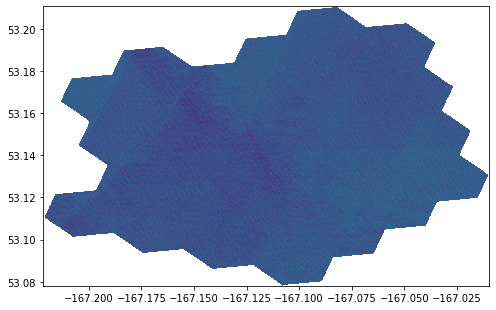

In [0]:
library.plot_raster(kring_df.select("tile.raster").first()[0])

## Raster to Timeseries projection

> __With the power of expression that rasterio provides + the power of distribution that mosaic provides__, we can easily convert rasters to numerical values with arbitrary mathematical complexity. Since all of our imagery is timestamped, our raster to number projection in effect is creating time series bound to H3 cells.

In [0]:
def rio_mean_band(dataset):
  try:
    return dataset.statistics(bidx = 1).mean
  except:
    return 0.0

measure_df = kring_df.withColumn(
  "rio_mean", library.rasterio_lambda("tile.raster", lambda dataset: rio_mean_band(dataset) )
)

In [0]:
measure_df.where("rio_mean > 0").display()

kring,date,tile,rio_mean
608598758648709119,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA4AIAAAEBAwABAAAA+gIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAB9AQAA4AMAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBAwB9AQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",186.48107454638821
608598762524246015,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAswMAAAEBAwABAAAACwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBACGAQAA/gYAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBACGAQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",202.39179057438326
608598778328383487,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA1wUAAAEBAwABAAAAFgQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAWBAAAEgkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwAWBAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",212.7801537310474
608598758631931903,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAA9AMAAAEBAwABAAAAqAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADUAQAANggAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBADUAQAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",203.26636135603528
608600812045729791,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAATgUAAAEBAwABAAAAWwIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABbAgAAnAUAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBbAgAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",194.10689312397267
608598762541023231,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAnwIAAAEBAwABAAAAygIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADuAAAAngQAABUBAwABAAAAAgAAABYBAwABAAAAAwAAABcBBADuAAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",187.63938809502937
608598778747813887,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAqQYAAAEBAwABAAAAuAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC4AwAAxg8AABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBBAC4AwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",209.5839793982109
608598778865254399,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAlQUAAAEBAwABAAAAZwQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnBAAAtAkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnBAAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",207.4901591634311
608598779100135423,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAwQQAAAEBAwABAAAAZwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnAwAAtAcAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnAwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",232.3494363716466
608598778949140479,2021-06-01,"List(null, SUkqAAgAAAASAAABAwABAAAAxwQAAAEBAwABAAAAuQMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC5AwAAWAgAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwC5AwAA5gAAABwBAwABAAAAAQA= (truncated), /dbfs/home/mjohns@databricks.com/stac/eo-series/data/alaska/B02/B02_S2A_MSIL2A_20210601T222531_R015_T02UQD_20210602T061853_20210601-222531.tif, GTiff)",194.2129

In [0]:
daily_measure_df = (
  measure_df
    .selectExpr(
      "kring as index_id",
      "date",
      "rio_mean",
      "tile.raster"
    )
    .where("rio_mean > 0")
    .groupBy("index_id", "date")
    .agg(
      F.avg("rio_mean").alias("measure"),
      F.first("raster").alias("raster")
    )
)
daily_measure_df.display()

index_id,date,measure,raster
608598758648709119,2021-06-01,186.48107454638821,SUkqAAgAAAASAAABAwABAAAA4AIAAAEBAwABAAAA+gIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAB9AQAA4AMAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBAwB9AQAA5gAAABwBAwABAAAAAQA= (truncated)
608598762524246015,2021-06-01,202.39179057438326,SUkqAAgAAAASAAABAwABAAAAswMAAAEBAwABAAAACwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBACGAQAA/gYAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBACGAQAA5gAAABwBAwABAAAAAQA= (truncated)
608598778328383487,2021-06-01,212.7801537310474,SUkqAAgAAAASAAABAwABAAAA1wUAAAEBAwABAAAAFgQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAAWBAAAEgkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwAWBAAA5gAAABwBAwABAAAAAQA= (truncated)
608598758631931903,2021-06-01,203.26636135603528,SUkqAAgAAAASAAABAwABAAAA9AMAAAEBAwABAAAAqAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADUAQAANggAABUBAwABAAAAAgAAABYBAwABAAAAAgAAABcBBADUAQAA5gAAABwBAwABAAAAAQA= (truncated)
608600812045729791,2021-06-01,194.10689312397267,SUkqAAgAAAASAAABAwABAAAATgUAAAEBAwABAAAAWwIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABbAgAAnAUAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBbAgAA5gAAABwBAwABAAAAAQA= (truncated)
608598762541023231,2021-06-01,187.63938809502937,SUkqAAgAAAASAAABAwABAAAAnwIAAAEBAwABAAAAygIAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBADuAAAAngQAABUBAwABAAAAAgAAABYBAwABAAAAAwAAABcBBADuAAAA5gAAABwBAwABAAAAAQA= (truncated)
608598778747813887,2021-06-01,209.5839793982109,SUkqAAgAAAASAAABAwABAAAAqQYAAAEBAwABAAAAuAMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC4AwAAxg8AABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBBAC4AwAA5gAAABwBAwABAAAAAQA= (truncated)
608598778865254399,2021-06-01,207.4901591634311,SUkqAAgAAAASAAABAwABAAAAlQUAAAEBAwABAAAAZwQAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnBAAAtAkAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnBAAA5gAAABwBAwABAAAAAQA= (truncated)
608598779100135423,2021-06-01,232.3494363716466,SUkqAAgAAAASAAABAwABAAAAwQQAAAEBAwABAAAAZwMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBABnAwAAtAcAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwBnAwAA5gAAABwBAwABAAAAAQA= (truncated)
608598778949140479,2021-06-01,194.21293432367898,SUkqAAgAAAASAAABAwABAAAAxwQAAAEBAwABAAAAuQMAAAIBAwACAAAAEAAQAAMBAwABAAAACAAAAAYBAwABAAAAAQAAABEBBAC5AwAAWAgAABUBAwABAAAAAgAAABYBAwABAAAAAQAAABcBAwC5AwAA5gAAABwBAwABAAAAAQA= (truncated)


_At this point our data is effectively became timeseries data and can be modeled as virtual IOT  devices that are fixed in spatial context. We can easily visualise data for individual dates in a spatial contex by leveraging our H3 locations._

In [0]:
df_06_01 = daily_measure_df.where("date == '2021-06-01'")


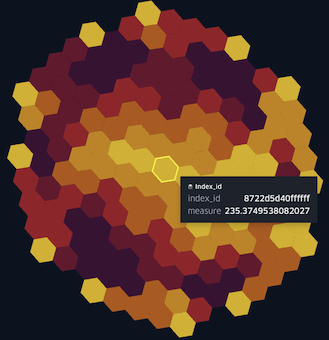

In [0]:
displayHTML("""<img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAUkAAAFUCAYAAACpws7tAAABeWlDQ1BrQ0dDb2xvclNwYWNlSVRVUl8yMDIwAAAokXWQv0tCURTHv9oPqYQIhJaGO0mFT0ojHP0RSNAgplBtz6c9BX1eni/CJWhuEfoPKpp0aWqoaK+moCkiKKg9cCm7nfteoRady+F8+HLu9557AHdA5bw8CKBiWGY6GWdr6xvM84JhjNBZhF/VajyWSq1QC35qf7Tv4JL1VpFerH5zPjOxczIePVbaexelv/19MZov1DSqH5RLGjctwBUlTm1bXHKD2GfSUMRHknWHTyXnHL62ezLpBPEjMdOKah5wS/9ArkfXe7hS3tK+Z5DTewtGdpXqNOUU0ihAQxAMy8ggC4UUhjhxECHM2alg/h+PBdsjgSo46jBRgo4iLHKIkcJRJnfpbNhvBIgdz7Dc/e+ddrUm7TJZFULsdrVZ0ppPgKfV1dgAMNYCrj65aqq2RArckWfglf4+SX2SfWe1zXDImd4bB4YehHjzk9c+0GkI8X4gROeQLt8Dl8YXM3lsJwPHewUAAACWZVhJZk1NACoAAAAIAAUBEgADAAAAAQABAAABGgAFAAAAAQAAAEoBGwAFAAAAAQAAAFIBKAADAAAAAQACAACHaQAEAAAAAQAAAFoAAAAAAAAASAAAAAEAAABIAAAAAQADkoYABwAAABIAAACEoAIABAAAAAEAAAFJoAMABAAAAAEAAAFUAAAAAEFTQ0lJAAAAU2NyZWVuc2hvdAlpwHkAAAAJcEhZcwAACxMAAAsTAQCanBgAAAI9aVRYdFhNTDpjb20uYWRvYmUueG1wAAAAAAA8eDp4bXBtZXRhIHhtbG5zOng9ImFkb2JlOm5zOm1ldGEvIiB4OnhtcHRrPSJYTVAgQ29yZSA2LjAuMCI+CiAgIDxyZGY6UkRGIHhtbG5zOnJkZj0iaHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyI+CiAgICAgIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PSIiCiAgICAgICAgICAgIHhtbG5zOmV4aWY9Imh0dHA6Ly9ucy5hZG9iZS5jb20vZXhpZi8xLjAvIgogICAgICAgICAgICB4bWxuczp0aWZmPSJodHRwOi8vbnMuYWRvYmUuY29tL3RpZmYvMS4wLyI+CiAgICAgICAgIDxleGlmOlBpeGVsWURpbWVuc2lvbj42Nzk8L2V4aWY6UGl4ZWxZRGltZW5zaW9uPgogICAgICAgICA8ZXhpZjpVc2VyQ29tbWVudD5TY3JlZW5zaG90PC9leGlmOlVzZXJDb21tZW50PgogICAgICAgICA8ZXhpZjpQaXhlbFhEaW1lbnNpb24+NjU3PC9leGlmOlBpeGVsWERpbWVuc2lvbj4KICAgICAgICAgPHRpZmY6T3JpZW50YXRpb24+MTwvdGlmZjpPcmllbnRhdGlvbj4KICAgICAgPC9yZGY6RGVzY3JpcHRpb24+CiAgIDwvcmRmOlJERj4KPC94OnhtcG1ldGE+CtduH4sAAEAASURBVHgB7L0JmGXJddcZmW/LfanKqqy9uqt6V7fV2iy1LEteMV4wthlgbGQJPr4xNoMx+3gGxhizfPY3w5gP+DxmwIBBgIyBweMFy0JY1oIsa5espVvqRV3VXfuSe74lX87vF/fdzFdZmVnvvXtfdVV3RtXNe99dIk5s/zhxzokTA2P7T66HvbBXArcogWIhhHIxhOLgQKg31sNSNYTlVZpOjQ/X0iY0ECYODIRThwbD/SdK4fpiM7z3d2rh4JGBsLQawsDALRLZe7xXAndgCdDs98JeCexeAoLb9QWAcEUw9BiMYPi6BwrhyMFieNWpYjh5uBCGhgrh8EwhzEwVQqEwEKr19bB/4np496+uhkNHC2GB7/eAcvey3nt655XAHkjeeXVyR1EkqK01Q3jr46Xwda8uh+Ozg2F4uBgOHygChoOA3kAolziKA6G5vh7W1nx/PXAZxkcGw4+9fTJcmVsL7/1wIxyYHYD73OMo76gK3iPmliUwsDfdvmUZvaJfGCkPhIvnGuGX/sFMePyhodAEAA0pGHrdBEQFxQCgOqNOuUXvD1UGwvnLjfBtP3aJFwcAzhCqTNHTd/x+L+yVwJ1cAoN3MnF7tL20JaAc8uJcM7z+NXCQh4qAWxNOsBlWqutRLikwegh4g7QkxJU3gJ/3Vnl3dn8x/LP/dTLU5/0dQon5SwK1L23+9lLfK4FOSmAPJDsppVfoOypqwvJ6+Hqm2lMThdBohFAACbeC4W7FI1DWkE1+7WMj4Rd/ZiosLyRcaHGv5e1WbHvP7qAS2Guqd1Bl3GmkxCk0RJ06lrB+vU6R/U7u841fMxR+4acmw8KV9VAp3Wm53aNnrwS2L4E9kNy+XPbuUgINlDABhcyD91YSmWOGUpH71GTo6x4fDn/jz46Giy+uhanRgVtOu/ksyjltqDK25dZ5r+FSEHvhtpTAXlu7LcV89yUyBKd37WIz/OB3VcLBfcUog+yVk0xzL+BpFvSHv2k0fP93D4WzzzfD+FBLrskzn28FQ2WXmmIuwtZeR2l0leM614g247uc9sJeCfS1BByc98JeCdxUAnJ+htMYhVfQcDtdTu8lT7r/K8gmGu9C+Ivv2EcE18O/+/9WwuzhwbAIEiLyDHUAsKVAj1ogmM1wiIT3FQrhaGEwHMD+cpTzB5dr4TP1Zpjiud/thb0S6FcJ7IFkv0r2ZRLvI6fKEdhamJk5VwKlK3aGKyH8xR9E481qnf/wm9UwNTMQZjAREgyPRTAcDBUAcZrrCbQ/fsfMPxTgN7kdhjg+c2051AcGuQf4ZqZsL4K9Eti+BPZAcvtyeUXfTUx/1sPr0Wofmy1t2EbmVShypPV6CGOjg+Ed3zoWxt8zEI5MF8J4cxMMi4ChU+0mf1PO0vMav1UoHUX1/qNTI+Hn5lcDM/Y9oMyrcvbiuakE9mSSNxXJ3o3U9Oetry2H6clBuL0b7R/zKCE5Q5d8V8/UwyNjpTCDTVDCKQKM3gcJaxwwnREsOcXAZ1EWiWgznEZF/mcnhsMK93zus72wVwJ5l8AeSOZdondxfCkAOaU1nDpWSozF+5AnQbJRbYZzTwKEsIINV+2QTjsYSkVCyc0EeF8Qva9SDH9qrBIWuN6zKrq5nPbuZC+BPZDMXoZ3XQwCjBWvLE+TGsHF3ypAWFodzrGqBkEgpj+JPJJbuQbwLBRhG6+wXHHu42uhvA+KNDfqMqRA+chwKXxLuRA13+ZnL+yVQJ4lsCeTzLM079C4BBOBUC5NLEIcGKexde94kxd0VIHuJBwsDYbRlcHwplcVwtQITit43I9gsksXmqG4OhjWB/zVW/BLQfebmXbXFqrhA6v1MI3QU7Mh891NSN/vnZpuUtt7924pgT2QvFtqqkc67fgCxoKCPn4MAob7Oe9vaZBPIAsc0awGDfIM94o8L0zz3vMhfOnXlsOj3zsaBnmu6Y5T5LyCcV19BjVMRkSSJIG8TITfMTEUMf+D1UaQOdWWcivJ6W/Pcs8efi8Zvm+H8FlGsohhL7xcSmAPJF8uNblNPuzsmDeGk4DcG0fKYXgLGKplFlwM6IyjwkRwWIfdbE6F8Py/Z5VMaSl8rUC5fuvVMTGiW/xJp9pz1+rh/GfXQmkGTrKHqXZ7MubAKOSWvwPr9IuNxfAkWqFp8ub9djCMtpjca0DIpq9gYuD3YcqHpeWRyzaufnHRRL0X7qIS2APJu6iyuiVVmWMN8HvtUDm8CeWGGmHhUKYygqHP21i5BC59hwCaDD8wEM79u2Z4/nQ1nH7tcKjrNFfEyRpIaO4ydDwF13YCWnKwBk+Bcgj6vo+p98/NrYQ5MqoSSgP1GADNYV48wHl/SeP0gXAQ7nmYY6C5Fo6US+ESyPkPry9HjnvP/jJrRb88vt8DydtcjykQ6R1HJi6uj+4zDccABE1qNKcx/ZQGk22/3krGGsLL8XsL4bM/Uw2VvxnC8UeQ+7H+WrqzBL9ffL4B4GaMaAsRxuZAMIsvtncClL+8sBpmAcAjHAcBxCHOUxyTpKsMFl/BTK8TDlnd+BpldC/v/dB4JfwT5JtTvLPHTW4p5Ffgzz2nu32sdMFAHPDQhyL9k9UmCRd3bZHpnFPCcTidjNPN7bIgw+cWNCeROf7JqWFWqPTY4Y2IlTAD1bXwmr9QDrP3D4VGrYW22yXcwb11OLwP/ovlsPwxQIrViVmn29slSZFHLlkZbDsYthunk4vIUW/9vkKFfWSxGt7NsZ9rZZV74ZVbAnaBvZBDCQiIAuEIy+3Gh5mqItRS2TGPP8ZrV9fxeoNN4NlmuHx+PVw53wyPnBgMb36sFK5dXw86k0hnhDmQEqOIU20ifRguUqVMzzgsKzXI1Biw/ejP1sKZr66GAqjTC71+0276U0K70i+AlHNmEh3llMoedzNOF1Dbjxog/hpkuN9IJV7hWvnkXnjllsDedDuHuhcga0xNFwC8OKeNcSL/mh4Ij55kLfKhQnjsvmI4zqZZI6MF9oNZC/cdx4KaD3/6F66FX/mtKhtlDbJRVryVA0UtDgm6DgKSckyZAkA5iAFica0QPvYLq2HyL7OEcKIUGsxtzftuIQXTFISkZRnvQkXMjNb3ZaZs26TTWJk5x+nyLUi8KQ6/t2P8QZRAXr9fsyIyqunUXnjllcAeSGasc0HCKfRRjAwfel05PHpfIYLh8AjgeLAQ9k/C0/HSMHu9lDCgdo8YO55OHor04r/yTrx1r14P7/1ALcyy9epiThtlqQsZJt0jcIBJitkyKsc3OIqz3OeL4XP/aTW88QcKYZC4FRlYBjeAYQuVvD9Anj3LzQmqBWwiLz7VwDYyGz23+rpCopZzL0HS5LztHN8OUFaps4/UGntA2Uthvgy+2QPJjJU4DIe1cLkZ3vGOifBHcNYgWFSYjqY7B7aDotsYpJoSgUPfivsA0Z/44Sm2bL0aPvaZ1o6CCMF83mtwqj1PUq+DjhFkavTxNNleo4zfrcNKFWaxb3xvCJ8dWgyPft8Y02dAmEwXWmBoWg0GAO3Dq9gfLVyvh0H2fagvD4Sr5+phstQMl87ASU4il/DlnIPF5gBhPSiL7DUF4xEojUOgfOrqEksfHXiS+zy6ZTCO9kO69sLdVwJ7IJmxzhKly0B47cPlqJhx4ytBwt4RO4h/CILeVuCLQIkSRG7zp39sOvypn7wSXrzSDBOsdIFx6TmYpNzjUdyOqYRow+ae40w/FChLJwbC878MWFSWw+PfNRJ3P1wEDNfYKKy2xGZhLDesLQIxy8zTKY91FmYj1oTzHMCDJMqkwyG8gPZ47WqFaTwP+J9XMCpNfrT/zBqt5WhVjqNxezsa738MzRrmt9tQtqo31rUC/qjn4hzp4KwsVLA1TECTIt69cHeVwB5IZqgvXYqpeHnrE6VwaGbTe/dWMNwtCU2BBNajs8Xwt39kMrzzf7mG9ofOxn0VP1nCaTVCsftmhYsbqVgHKUZOD4avvqce5pauhln2124AjoKkYFjCSS8MJplgqi0JZX8AHDwTVDwOnV4L1zCQXL2OJaPv5EiiAJmkSLwZg7QKuvdia/rnqBTtL+XU9WcpgAqAyiq9RoiQ5MMGwDf7yP/9uFQa57dZ/AArgcZ4lIImt/bCXVACeyCZoZKiSzEA7nUPlcIwVsxxmmmv6jIIiCvY67z+VUPhH/3EZPjRn5oLM4cwPbHPcXQTBAdsvsMpuJ99oLjT/h5I2j1JItQMaBgaDwoMK81QAgXKgKHkbtDMj3jtzbbgPYF05v5aeOFL5TCwVAzrBV9ue6nHS/Oad36NT6P7e6nwH2bp4z8CKBcdwAA/RM0sgSQvcMnaY84yOoxwHmRj8oO8Pww3b1CJNAwn+ht4VBc85Uj3wt1RAnsgmaGeUjB4CO/dcpUqcHrtoDIfyiy/5U2j4e//eDP85Z+eQ+NdRJHTHXLYJbXruxet9hCdsQ9iv1hi64DE+MRaKAB24EEEuLQ84gu7/SGvLHCJpkT7WM1z5jPNMLZeThxddJfdG1Kx7OcwMxiiMiqMPBmiuiFefxi3QHkKH5Z/enwdScJ6mAAMJzmmQMDUOL3Em6ar4ZA2mZZJpIM/b2PVk9Pv9+1pyy3SuybsgWSPVSWoqYnef7gQHsalWEMtb49xbXxGBKv4WPz2rx8LC9hX/uQ/XAhHjxfC9aVEg7zxHhftaSWd0s643jJTaYZ7ypVkSR732t9tj6PXa+NTOz04loBAL/FbfgLlKPLX2Qcb4fqXSiiBeqUo+c5ycF/wcs4AmVJlPp1665otXalzg3E6BKxuKe+0bGQ8zd63qS0njg+toi2HVqfqe+HOLoG8RDd3di77QJ1T7ZVr6+E73lSO2xDITdnxs4T0c6ft3/0NY+G7/0AlvHBmLYyiCE6DQGDHrPO3xhHlYNyz047BvcywmcHRMM4UkGks7/UlsAKnUVkLQ0PNqMXuOQ0yvE5c0xiVzzwA/ytHmhZCj5GOZUXaW6QreXLnOxmn26F8Jz3S6Pxt9piVh2+DozwG97lIPMlkPH1r73wnlkDGsftOzNLtoSkqJgCh+08ij0QwlcduglIu0K7Bdijj+6vYUNYb18N/+VA1TGKY3migEKH7Vfg7RPeSVyxxoFfn7PoS3JxxyOX99/lmeNtUPcyUNtds51Ey0qe949hMsplXHoODU/fJA6zqaVbDlacqodKhdRCkbAwDBQibZ+Mc741ReMpi+xlMp9vgNyp4RpFT/onJkfAPcKSh3Fm5pgC6F+7MEtgDyR7rBUWlc7vw+IP57iYoOQKRG2XtnyqEv/T2iXDhy6theQGFAHLGgptl8S/5mxCfwIGT7YTLtDOurLPt6lwhfPt0Pe46qDG397MG02CWGIYm5GeVxWWNMfl+jfKcnG0yKNTC3NPlMMTSTgcLo/cw3TQpz05frQIbsCZOy5gCuE57aDBRVnH7jgzSrpu2Q9Tlj0wOh59HCeSU23yYp25DWjbdfrf3fuclsDfd7rysNt5UG73IEsJXPTgQDrDLX1ZTnY2I2y4EH5mhKqrqlTPlMDM0FCrrgKTAxHtCojsHRuVA/LX5sYBSwZp73mWEC4l3Gyva+1mD4Ow0f3B4rUVH1hhb35uptYEwcQjvQDPYXFaTrWOlWVDxrOJEhcky51UOV8IY1Bxr9jOq9sxyi3fv3D9mVdnmPchsfgigdMsMg/d3Cj6zTTAuRx8BY6xq9UCPFJWGO323dz97Cexxkj2UoeaH85ea4a2PD6F4wPSntTSvh6h2/wSg+/Tvw1kxsd4/2LxJU71bp5IrYZl4+HK1gOlJCK8db2wYOu/23a4E8eEa88XCBPZ+cHoODj3HtU1C0lzGYeWJ+9bC1S83wjU44YEBhgFRD3CwsZZhY/0tMHr4jTS4MkbMlGN24MiyLJHotg2mIyl5BOMS9E8DlD8wUgrvWkxMg+QqBUMHYs8VhZik6qKFZcS2q5herbs9ZGuAiLlHPLFvCpMxPvabvZBvCeyB5C7lmbY3z0lTTTqlHdHw+ENDcT12LprtJMqNv05pVzH/+dKXCtjV0fl7EFpJ5zjffn4VO0QEf68F3AbhRRO+bCOpri6i/BCv5S5DdIqcZ6e0jAXeEqtwisMcVwHFCjaH5OMGcOJFfwuQaUifC5YrzNPXQBmn33kFY6pCXIl484rVeATKx3EddZXM/MYK6/cxqWIr8bCCdUOUJ2xMU+CyDwyEB48XWbFUCI/fX4xLWvdPF8P7Proc/sUvr4TZowVmODdbQuRVBq/UePZAslXzNti08dvhPMQlp7SO7g7cDuoV3hqoD4Sj46XwyOlKBK/0O17LJcgpFentl682wnNfQBYJl6APxl6CQDICR/rZVRRMoM2rxswRyNlDMJ9u2lXATlAac8SgDWr0fF5fRRF2bTDgKDxWRDsYbry4w4WlpAH3CqPKUMuQe4dXO75tvp0eqwyy5Hqrie2TMy7jfxvLHqtw6e87XwsHAMGv+5oS3PpAeDVgqGx6fKwQ7jlSDKPDgD8j6AhLfix/r09hT/vJL9XCZ55qhhksBVbgOPtRN9vn4OV/d8/pbquONaVJV0FolqFR8AgtbZxusX+gEMbgIFhpHM+j7Ci4fC6EN/3gevi27xmm8+ANBxDLq2EKQBUcZ/zeJ+vhr/zvITx8FDlgKrjqsU3KmS7DWn7LZC3ope1WfnPbgcBObFAaWh2shyOP1vCbSZ7bX0peyfxXkFyZGwiXPs9w1ALJXiKVZsnzyAPY0qymZdELTTt+Y6TUb+VEM0x/ZykcO1wO46NSzQAHGAqEti8VWToTsX3IYHqWriG4z+derIc//NeusE5+PUyO7k29Y+Hl9GePk6QgnUAdAghn0IxOc9acZJTeOswhMGh2I8gkjZJGyjRz/HAIv/vP4VrKy+Et3z4CQObXfYzKbR0+/qlG2A9c9zLV3to+pF1nFx9eKIdvBuhmmNKmji/saIb2HDhQmGdDohyCJjiUwiHsNuFwcOyT26CQpMJfCNG2s7aISCBebzzp+iLNk8odp+DWadaQPYbtKaDJhdqc22MMhtc8zhYZlHNqwlRVBtkqjJg+fzybnTRLrtS692gp/Nu/NR2+/yeuM+VuRnC9HVuDbJ+jl9fdVzRI2tjcKOsIrfTN5VHsDZnKcM8ORtOMZ6tbkEjlkH5jiEB572D4rZ/nB0D5tj8wGs120oYbX+rhj/2hgEZiYbERzj6H0gUFiXLArME8mTd10r89h9dtOEqBUpGCjcB8RW05L2raM0eay3Q+ueRLaMlX0Dwv14kBE6TZE4thFO7FTpg1vyS7GSBCDml1HoVNwkhtPuvhyjyVyM0ihE5qeNpFsLzawwpxjKg970eA0HU8Ju1Hxq3yxcUEKm4M7WCY3Ln5r++o0Pma+yvhXT85Fb7/r12LHvId5PrB7d9Mwcv7TqE8MvWTL+8s7pw7mzwr/sKjhXI4hOttp9zi0XaYZIfzaA+C1yibWH/pPQNh6pH1cOIEnoBy0DCWYX1eOLcWfvEX8CRzgK0XNAjMKZhnDZgv1gbDofJa1MxfguarjUJ4dnUwPLVSCF9YKYYnOZ5C4fPlajFc4tl1QHKF3nhpnjxyfd9BDLfphYLJ1nLplVSBUb+T8zj2HVB1nUOQgywhm9SMyD3Ft4Z2MEyfehZgJAHJSmiA3M4Uinkg91YCTIxFAmGGpaTfgOf6MZRstKttSN365Q2/fV/v+CcPl8LpY+vhV95TDfvQ+GVxuXdDAq/gH69okLTebfyPFYeYWifbHNhmPToO9LIS64+f+nCDbVfZ2AuXaY2MQKm+4YMfqYXf/RjT/wlAW3YvpyAoqIBaJZdPVwfDcwDhkxxPYSp0uY5DDTjFKksFLYUSZYPoEW4sAQyZG50MP3NR/mwgnJipRVEFt3MJAyiFVucGw9IVQTKXKGMk5kaATAe/tH49C4Tp4dxBAYtKmgXqcJHB4TLc81kGjzG8FA1Dk3Gk38fIM/4xn2s42Rx9dD08+JaRyEkLeL0Ev9Pj/anj5TCKF/nf+h02MmMQd+FDj1H2QsbL7ptX9HTbBj9GyxqNAGm37z446sOIhmatGP7j36+HP/ZX2dL0eAW5Um+KHDkYTX++8AW4U1ApD3nk1lxF7o/9GNZcvwh3NITWGxeWQMSmiMF34uGftqDyYGoELeznhxhg1sI3PlyD01Jymy0oZhCgVhdoklvSzBbz5teJyCSxoXTcEQzn4eJWMUJcRehwGVBcZ5C4BqesKzTLRydMmLfDaa+FN0/W4wDjt1nzu0GVdYwb+VOvRy1I1llw1DUXuRFX60La/sR3TkRzoH/yb5fDwSMMPGq8t76497ujEnjFcpJyRcv0xgcGS+F4oZKpX7r/SxHZ4fLVQvgyGunjX4MbrSnWD3O/E65AgDAojysx1b6C6c9/fjeggX/G+H0/QIOInYpaDkafHtJxqyC9rvb44ovlMDFWDyf3sZwQYOkkrzvFrQyuhlzt6vPsnYMtZz+CHHQdGeunAOIn2Yjsiy2xgpz0swxyrlC6Sj5cAS5gO2DpXJf1AshlAczGYDhcaUbOMy/6osiizlT7uzD5mSx23GZ2St86UA6pn4/XPTwEzWvhv/8eHodY++/UO0sd7ZTmy/2+feQVG2hP4SDDdwoUPReEDZPp2dD0eph7oRj+w7+AM8HlmQqYFACN2+v0aE9LYKzg5WAYrXGJPWDOsv3sly5wD4PqPJQ27Wml1wnvl8gU03vdnAX0Kej7tU+MhOcuw43KAIq0PQY77xIC4nWmtgNaj+ccjFHQexERwycAx4twjUtrKuow88JbCatL41JOQZGsbASyGZV2SFTCk3z7SZZ55kYdDW8NV0Clh6BhXyGuZsoDxIwDbIwLHX74j06E1756MFw8Bwfdne5qowxe6RevWE7Shq5pz6OwgK77zRyIQo330D6UIJ+DGxmph/sfpru1hP12UMHQfadVkjZBP1N1kn/+QjWcfaEezrw4ED700Wr4zV+nQSMfzAI6t8pPYlKeLd8WWxGzqafOlcNx1ltPjbDSxal3F9FGwOGPxbRypRDqc/TkPjCSSVmzTBOAXIRGwTClUxoiHbsUms/11vMC3OT6WjUcIwItBbrI6k2xK49sXAnh2NsGw9HHysnChCwRtqVg3thaKJoCveahcvgoxuaX5wDkjINZWxKvmMv2QfMVk2nbYWL6g3t9euetOkjHBWPDxCh44p4QPvYvkXUOrYSv+4PK7jCf4f6FiwicaLhn2Xf6qS814BwGw4sXi+H8swPh4nme83A/hkj7Udasl2BNkY8NtkC2Yxo6eFGTJjmorEEQL8L1raLc+KWPjIa3f/1imMERr1xMCkBpGrGMWwXd/kyliWChLWCdafA68WWnLE1182ycbMGD3DFxnCGH2G29+80oyqXfXx0Os5UGRvlrTN8zACVEafozy7YdiZ1ttxRt5m+7KwdmZchHDpZYzlgITz+DjStbHzsL2Audl8ArEiSdXmsGc7RQBJKUQeXbMZtg4ehxuMJ/zrrpr6wErGjCpQuV8NznkYkhd7sEq6SRuKGMv8dhdoeaxTj9MBpUV1Y0WfZYozPXUIwM8+6mOiV+kvlPHgCZEqH8q0IeVmuF8B8+PhLe/sRCGEMlrkMGO2kaBEOYzgieDT+yo4KW13HWoKhicRFzFbS8Q3DaawBm26dpFD2fhR7TV0lzBdmiU+csOOG2GB+aL4W3Ee8RHA+nRvldEQgNbqhWPEUbGOc6C0E7JBwHMcrz7IV6+I3318IUAOkWI3uhuxJ4RYKk7VEvMfuQR/ahbcYaUJlTYaOsj76/gimJ8sb1MMrWsXJNM4DhmqpW/8cD7gug2FgXyYNSlJXi+Yd/GXiVbVtDXpxkGrncynBlne1wi+G/fWEofNerq1H+peOPdTXo5GAOTnoF5wtVBoC55TJbz8Ll1DGxweRHsNBD+RSc2fFB9s3Jk7tPiaRMz0BD1kB1RQA3W+8HKN+6vhqOugKJB+Z0p+B37UFFFf6Uw+QT7JOz31VVDAy7RdD+cYfXpqlrtc8+FZfwhDKAKZe/F7orgVccSNoObTxZTX92K+bYOHlhgc5f2LceGMCjxlEnFcot1wTEWwS5xzw5vjQ5ZaGxw+bcI+18+0ZD+ORzI2GM1TgPzTbCBUBgZRnzEwzU6yhkaoIkfiIrKEocLAzFIuBAK7RergKadupjQ1KYH2IQZagCQtfW9OOusiqWAHd7C35tnDCl4QMs8/wuRCPj5EGgbA9pDjzLVadnlxyuc2MNRdXMA2jR/Za2knOVxDRdifOV5xP2cW+a3V47nV+/bEEybaA25rTtepZzXAIoTg9WEN7jpGHjaeeFdqs3Tdu0luCO1uhJ7TTc6tvtnkujR6KH3+6Nzu8p48wKEjulJkc5CsB97ivFcPXpYtTuO8UeRI7nuQx4Drk1g6XTqhQ56fRnhTnxOTwAlfCdeRQtSU/T2C3EGb0AVVsvMtVmmwtoaSW95c3ufhqHnWeV2v04Gu+3aENpRROSU7KU1VlAjfa2ovgEGfMKy6eW1yuB7drD2eUQ3vjl9XDfm1zR0/o4iSLz3zjVpszn2Q/9v368FiqTe6tvei3UlwVIxhGaErDhegiEzirU4DKQxk6iVYmZPUBvnaZBHi7o5yd533M/woqKFyKWpixBjrLWxBckvT3hhHqPbQ05QCFl43qPZscv7ZxH8GAzXlTTneQ8/uWPz5Qy7BTksIZhJS9iajNWWAsTVNitprE7xdV+3zo4j0kWOhK8OCXto/15r9e2M7Xkz6O4+jhT79dM1MMiDa9GJmt4kT/vjKHpqp01bHJZicUcfbFZBKgLGKWvh/KBEP7jfwph+sBK+KN/eBQuOz9u0mIuMug89dV6+OozjTBzeBC5ca85fWV/d9eDpACnplpFjByDZj0wK2ECIJzi0KuPGuxBOuAYz8aKLI8h2HFSM5h8eIsYbfwTaYIeV2uYTh5hiLXl9XXNnIHJHuZlcjQCZAML9yLrHu1E/QiDcE1F0pGDzpLGc8sFpt31MM3iaQc8y7SX4HcNaDqPsbjG83nXtUCJSDI8zVr481eRtVrv3NQ8KFkr7ppxDeQ9I5KA3YzuzswMs+Djh0L4hX9SYilhNbz+dRh/02h6qF5juyGYbwekLzydIKN9Yy/0VgJ3PUjagY4j1JpFU10BDAVEAVKv1HJd6Wbx9jI7bXQ75bl1yKFV4C79nVewPV7H04XcBDPMnOJOOlunNEpDmsd4DeeyijC0ogAwQk6eOU5itC507KtTiCyxp7Q/vTQYTo81wz42zdJBhfe7CdLgIFWFo7++JgeXhaqdUzZWOcMVOEVFra7QSUIKycnZ927gpLmhgu/wTCH8Hz/RCP/b31sNjz3GktaM8knTUTG0AuB+9inYWexz97TarSrp4bRRnT18e0d8YgYeL42ER0rD4R6WF86yzFCwFBztVJr36N3HTqZpiQ3Iw+C3TvGqcBp5apBNZZlpVt5aWmn0n8BuHsxfChxpnpT3ySH7hue1KHzgRV4oK2Kg96Rdl7u5BmmYoFATji1b1OarxMD3VZYP1uB+ras0j7eK2ffSd+WgFlhZcw35sACW3r9VHL08TzkOucv0aKdluzhVpgwysFSmiuGnfhxj9y/Xouw2k5KFRF3tdelaI7znQ5j+sCRRk6y90FsJ2PbuymAnEgAPMpUZARTdKySCIffaG6bvtR/tmfW9YYBD3d8aQJlXEHKbTI/71SXLqENrwF+aX8FQU6FGCxCtVPMsJ92u7FG3q2BQDXfewbI0TWV+JBGvs6RhfMJ5E278hVXhLRnU4kXrj+94tAfzrk0kzFOkwQn2WS1guC99/QprAPlWWjpNizEv7uszzNrt//Nn1uOiA5ep9gqU0qGVwGeeJOOwruw1thcylIBt6q4MEq4c8hicYzqlthN02xGE1GGm5sqtuv12a8HFxklcC7jtXsB9jyDVr1ACQiwDUzAdpV4Cokoe/21nPmRe1W73YxWPeS+xs2GBI6+QxBnCNRQjZzAhkv60RM37BhimN7m3iLLoGjPMC0xZnwcjnoETXUBN3q+GbtIOsMqJ/ddT4LM16B3Gvdn5c4Xwi/9qDdOpRlzG6oDTTUgHqFU6x57pTzclt/O7d+0YY1ccomFO52AQbuPOQy5pF5FLm0clW9DmhU7dj5DGKhCm192mE81w+Gg7MO02rggUfORKFtfB5weTSQmq8LhSwwsPXNEpbDGlWTCsM4VW+63WuoqiCAU25YGih3tqklPpqzaM07BlC3gA8l6vZbZduRiX5juCcDKH2e6tDu6RR/cxOnw0hA//dpGNv2rhT76TdllBHksmKdYbQgqeERR5lj53ml1BEH5tfi381u/tmf7cUGg9/rgrQdL2ooglMQi/kcPosRw2Os4qIKf9ZDchdpSND5xqs4kVN/PsjBvRc5FwVL0DpHEJNGq6ByOYt8fe/XWa/1GWUXbPy986PeMXKOdRvjwFIjYBQLeV2AqGAoVtw0btdNvvUtqOl5vhDEA7D7Cmz3icS1hX+4LYJ2uQ/hrLNA8BlL/2q3obWg3vfEcZ0NtckdMOhjpnVkHTpCCSbY3xe3m9FhYAyC88S37P4CJtf7JENCttr+Tv71qQXKUJPYTcTyVNyhVlrUg7mFNXDX5HUBrYwdpD+tv3DJ6TaRaw1eqN7vm8jBytO5iN0XX8JwFguYuUko4/veFFPfhYdlm5STlxgaIcp9rZweIGIls/LF5Xu+tMowAyOERsBcP0O99N68p7crbWxxFWxtRZY17jy7zUV5Zfe1qmlylQpXU4yhMnQnjXr5bDLBuv/fE/gm9SwN11/YKhYR4gvHylHlYwbbp8cT08g6nPxeulcP4sRupPwVmTxxMzw+Hi2uqGOCoTXa/gj+9KkIz1RVuZpquovbTdZIOLpAXY/NLpoprw9s3tjT+dQCfNlFEfTswpXhOg1j6uSterw+3YKdN3k5jz/VtnbaNru/MI2QFSEEKui4ZWQ3Dz3o9g+a9Q3kMAewpw1kNaF7ul6bfSVebbY6W18BTyv1I0herk691iTtLvh3F+lbXtjx4O4d3/tMBeNcvh0KFyeOGFZnj26Wq4cBWTJrbQOPtFnFeQsyFKZJy/JepgCHHE/kOUEZmu18aicu9ahMxsM4/dS+Hl/fSu3HfbRl9nWvyduE+ZQHGTFyeZVnXkjDa6nxpWl5ZxcE+X/u4BswyI6iZLgNZwWJhWkZBcJcCRFYBSetrPCeciFyVU5BfUzd5K0WTe0pCm7TnxqLQWZt19kRvt76XvZz0LcirXnDmkaXcbp9/59XVmxy82VPdlD8aZRzzbUWK860wbXrzcCCvUuBSPc2iHWmYLjSH21y7igclZDONHPFNEEbm9ZztuwOF/JVzHo5T1m4D6dmnt3du5BO46kLThpL4gv77sGpr8Q9KZMAinwaklVRuspZ7p0mrjKG26Hu3Tar9LQ01uT9jJOCVO40vPptGPPBt/A1uUIhxqGn97fryOMz0eDtADzZYm+CNcaEg9wV7e4wjJ7KP9CCktKW1Z0rDO5lD0nMU7edb4OhlcstAqrBVQxCh/bAdDC9rfHrsF87dCW3x6YI6YtA7ImuPdUnt5PstnznYby8YGHk1/kBm6m5+bOeVd7Wl8y2pMmZalDvv1PZkmlrbN9Ly1CKJNYhrR1ocZfqcSsH409gIAafxyxna+ZCmbHIibZ2FNgIs3V60MIrMdZXldEdmg9ZFwKMr65HDzz7QxahPq2fh3KvNOi1X10iR5MacCZS8cluWfGOonwJOVpp1pJx0GamnuJUjXyEAp3BsmwrNhvpcoXvHf3FUgmXY/zbTlIfvXMOWa2FaUlimXlIbNq/TOzue8OUhTMn05F20k+xEsX7v8frzwaGJfQMboumQbidu9ClDxHXaZSjmYhKZk7FC8kMSRL3Vypw6GeXmRl0ZBZwo3bfMg0LVmecflo2l+zJmiDn8bNNwXZvMWeySxb/5NufvNO91f2WbGcC99z/p4eDrMIRbqT/vpnrK744s7srRsiB6O8BKYNkwb9hIV7r1p9nF1SWH6jFu5BDu9HNQiWuoaFORRQFU6YrpmPAuRaafMEsetvlX1cgDlxiw7NbK3ffRyo/mNAChYJauTEsBOB420Dqwv5YbRuPpWCXXxXDhSFplnkGaB/hBAOY7pktvGei/e91krsXR5p8oyOccUKH0vn9bRSmibkza3inoSyrZ5ocNb0ipQjg9UwsmB8XjtvU5DklfkoHwQB8xOP3yZvPeSc5JWgM0/bZQCoQ3TDhndnHHWm0qRBjPOm+MsI7zHVTbcS7/hldyC9AhomonkwQ0aX7FlTuR1lrDJp2WN6WYqjJGFKgCjnGriy9G3tqa09bfvpMH6yNqh07jaz8JEP+raOEtovE/iVf0sG+CwT1arLSY5cVBKpZYOx4lwIWmrKXQ5IPh2ETDznGdQay4N/ssarDcpnWZDkBVg8gLO25yRpDH7PD3S/mgftD/aDxN5fPKSK9Q0x/L5KyG8pCBppdgxVwEluRWH9jEaxgyH2ysc4IzyLtosRs8+vGJjdNrnyBg/4V7+YSA6zM0jfhthXhyHnIzTu34E6TRmXEHGYN57CZpN+U+tqufEyYex9xakw/Zhe+hHsKPb9soOzTjmNZkUDNuHiO0GzFhmLQ639xzunCvLMO+psUA5G0bpP81wBWP1SgsoEXsi0kgYlE3kxLUgP46zvecRTDeOIH4Z4fjIcjU8BXpOUFbOLF7u4SUDSZu8BXyARnYPU2c7QYH1zvtKldgw7KtxTbYvUnk2wnRMTYX46dlRPa9gupr3LKnFzivSDPGY55Q7W4drcQlcPzqkaSQG4fIO2XIuzdEiIHpocMrYW/3ENuKUkwwbRz/ybdvR3vU6SrpEEZUH35ahwlufRp+TtMMcm/YGUdbuUeZlDhAvrrPAnUQEwWnkTPtQxh1j1NBeeBpw3M99y96Zm/f8dhal3T9i06IVjNt1OmyLeTmHlxQkXTVzH+7N7i8OJVpqqFHOaPCvXn7SntHezbyOv3m8SgMfK2Ir2frOb7OGFVc3AJLaPSbUZI1x8/tEppU0NuNuB8HNtzavaviALCFe0P2YHI4Nu70sNt/MdiVnPkxzH6aj5DGNijBLXLqo63UQs3wE77yXEbaXlNDrKqkG8rpEt9/+tPtr6yaXNkNEeXORaW6kT3cuDw6Ohe/A1nIUYDwA8FlPctUyLGnbtC3Ytfytpy3Ps2ze/UMTQ+Hn51eo30R3kEebIeo7MmRjGTJkyUJlt2FGLkxH4BbspHYoK8HDYINLj3ij7Y/vCBxDGJBVMUnJKxivTlqJui/Bhug0KgV1QTC93i7BIQaRlIvqV6cxq+Z7osU1pOW/HT2d3jOOdLrtN50UZ3tdJ9/7IaDN0cn3ptNNSPOp/DmvCnc9fB7BHPcn18k8QcA7zBYbjw2Vwkl8qSln1EG05Vzlmc+dfsMs3tAfBQwtDfzmz4wPIZZKZLL9qJ88yjGPOF4SkLRA5RIPI3Mc5Ug7RC8FLejk6frLJr4AQRaMdPUjKFeNrZHIUxDcKZ2tk79eyminuNP7sfz5M9QyGMwzjbSBOaVt7/SmkaaTlrPv1DkcMHWEbPD7XuwY48e3+GP6pr2Is4y8wnayy7zizjMewe9wJWFOBL3IMbYSSOsmrZ+t6XpfEL2nUgw/MjlMf9EU6uUb8msdXZSRhazC5iDGy2oP007SRRQ3vKr22zgEuF4bqd9bGEu0nmqf5ZFJfpMmuBUEIaGj4Pidtdw2E3IqzzYWdJX84tyM3Su5YD2qG8y5pkKpD08BUWD0HWWutom8bCJjgjv8STq7IhtEK7yTR97bB+ykhndI/CW6HcuetKcxpp+Ek0y09t0Tk5bdA0Pl8N0jZWxNce7bfTR3xRcvCUhaMiY8zVQ7j4Zk4zY+pzpVHN62cyzc7ihIh/HEqTYg2a8gtGkgnKXgzZ82dPWmG4Nlo9WvFXOMox2pIJvql2xJkUEKIJazdPvPawHRlqD4JNk8a3vA8t28g2vxbTH9CIpVtoZb1ZcKm354jm+nw+WlrjgaZmSQo+w1pG3n60Yr4VuHS+EqkWka1Eug6vOSePSS/K7f3HYuORYsJE0CE/vgJJOxbFcaO3poXZfobEj4OorTTrtVFmgci3AVVliGtrMrvXYAPdBkiV+gdQc+VSJZ+UnpQL/CFq7WTMLlxYs+/ElsCZOcW/5pSMsiPaf3t57rWD+UXcScQ4j5Jh6dXXgtNbdKv9tk5c8NabyKhmoMbA4WO8qXIWSgj4O0+dTu8Qj+NV1NppOWzZqI5Hb1x7wJIt+KfNLr/7rKDpfUrTPF7YLVbntDcc4eRoA0o7Lfud0tY7SuEdiKuL/tcDu6drv3koCkhqn3t227sBuB3TyTExkAPAxWvIXvOf3bDshL9RoyuBsNxn1Xl1+LzAr7odmWksRA2KvsoVfRgimb1/SwpCrkO7E8zU7X1hhMJ9mEzY7ZuwlTBYC0TjfrdWtKnf+WJk3IlpBHem2ceQcHAuvImYNpDDI4CpBJitunFiHLl1shb9qcKWi2c6DU3hvS1Lo/S5/8sr1OoLwOm/pxdh2bBvCwqopAGMGQAm7wYhX0XML5QhNXcJs1iahlHCcyPC+zAmoYRwEC5Z0SbjtImnEL1am2jSW1dcyjQNLOY8U5hXTUMq11puFxWSCdTNtLx3dt4uILbQn7/SxyGmWSi+52SNfJu/NEX5DRl2FbwjlcRple7Io3RmZZGNKz+fFQOqj5hnuD47yajpNdNkyU24aYHlPPUktJt+1LHd5MV7g4azDeXkPSRnSBt2k63mtcO31nGokJV9LNNmcAnVOeGJQnA/9O6XR6X3rUWO9jqj0KGDnVTttFp3Fs955x2M+0o/y2sXL43PVl1vMAdMuIljbA0C+xRpkaCI+dKoZH7i2EB08Ww9QEeonBtfDQvZVw/vJa+MG/dj2MHqSNEmkWUYCp5RVuO0jGkYzC2t/yOJNXRtrjcTReVe5HpcW9a0RLDlfqpM3THQe3g0C/PVJcC88y2tXp1DbP9Jv2NHq9zmv1zdb0mwwEevGxwXpIs4c6ZcFQbaQ2cFb4IB7EpwDGaX6MFrCN5P4Kw36e+SSZG4LigSycr5FJXzpNzUKr3zpQmmfbo2WSJT4+3zZsFef40nZtbtuPWzfTKftu73T6zHbh4DgDI8DS/FxByLjVks/ANv7I+HD4fy5Vw4OnC+HRexIwHBsrhEMzeEs/BDfNfHsIbnF0mIGObwyoEsLJIwPhH/6NZvjzf2cuHDk+GOaX46OX/M9t9SdpQTrVPgon9ZY++YLcWqKmmYZOO4LfrDKMna2XoDef0TaloZ9n6daNnKO6HV+Zk/vOTODVZx+N0o262LWUpWWugnHk950EIM5XB9i6lSWfrd9500m0fQGiXuiUFoMD4RJzi36BZAqIcQqdJJnpr/GkcfYSkQPDAqPCt03Ww7EhFH+0lbQseolv229IZGCRrVV+tBRmTpWZPQCGIwkYiodOo+NqIs5xSt0iwJO8jOGf/af58I//1RJ7/bDTJVtZ5E5jkkzHf20ffQ9mniWfsQPKms02E9Mfp4j9KgDt7XRe0CkwtheC3MUwQsnjA43wLHuiJH6HeompPVZG7lZ+8+o0N8aeTJ9PVdbCofIaHCKOcClru5Vbvbp1gTmIB3/Sa4X4hoM4ebiC0GgF/4r9WOHSSiZJLMe/xrtbG/KZ78jVKbN2AIntjkGwylptZxtZgIfodgwRDHhqunkEZZvJLpy9xWa7HqEtDA8q5BIy8w1IQEJjMYTxBwbCiQfYDI8+tIaMcnmFlCmC9lKwSJR4tQdBVJz40987ERU6P/eupTALUC6yOVpORdieXMfXW8js+LttXzQjaq2GMZgaG0rO/paVvo6F9uUrjGQvYm5SByS5H1vvtjH1flMAqiEBjsbLPZaslamZxBClc7TUwNQmPyORfgGkNNsJHh5eCw+ONHF1phKKJWawjANw7oJhdGDA2fc4xeB3Bn+fhLsYgut0in63BDXe2wXzYy60wXRF1mprVZb3PEr00EPRXqV/A3UENZEjp5BFXGGe3WZ3CvnfJPs/2L69l2sgq01AcuZBYuXarXANgqEzF7tjesQHW/74TO5SoPyh/2Ei/Ok/NhIusK/POPKg1qx8yxe352cmTtJMYUcaZRsotEKVuemCmgCPGHgBMDx4aDC85oFimBxdC088NhbOvZ+NjJ5mcfx+vtVWgNfyDHIGw7hUy1KykqTgGKUbu+w1w7k1lT6b4NILvbtpNXuJL/1GWpU1TUXbNzgkzJisgc1i3R0I0rzq4eX+0fXwLNu2rrA0U9VIWpNpWnfaOdV4p3SZF/c/knC3y7XMPbtNsLnxeXScwnkascMyIHulqeu9bHWbpt9+rrCkNM8STO1M29Po9Np8u9zwfmQuWm6IX97LNRghbWfyOE7YkNvIRXYbxJQG1cfy8AiUn3qyFj75+2vhwEH2lcIXh89vd+gZJGNmAMYLL8qXQDkxHTgIGD5YDK8FEA8fKITx0UK492gx7GPep7C2QCeeRJt19pHV8Es/w3aYC3CUwzSj7ZmBnsrCRjmEw4t0qtNTJG0f2a2QNxNrk+05b60Jba/DzSaC3ZhTJQpNxcPm/baEMlyaprs2HoETHKGMe7F9Mw7btDLJe+BEn0R4hSoocgAZSOv7p5altKdl6jld9mlbSP2OtoNV+q4tdxZffGuw2NfhsrIOgkS3EUwvdZq7cbMPF8nMpD13OyRCIcnZXq+7AIGRP+9A/E3kh0MP4T3oGA5n6NPWSy9BrhMywxiyzL/xP02E7/vx6+HaAr4F2AlSE6LbDZQ9KW5SgJzEg8if+Z6RcGAfjkuPFMM0YFggh2auJCNHK5Qb84igRUOUBR9mNHv2K9XwT38Mw1O+i1rAtOX2Uqpt3xiNnoFGepRHtkV1w6XN6nxjIFxiy1j3vGkn1+v0t2fBJk4vYgz6QsRhAA004GmmH9yZjVHm/ZsmEoF8Fi5B+gXKy7VGeGa5BEfO5l4v5VwnluHOf8x7HYvkaNK182s7PvF76+tsvRDXcOdl9pVMtbNr9HciPGUCmnAYLuXsxP5U+ase9795ohHuQSzjDqDmP4+A8UKoI0479A0hvO5PjEaZYtZ4xQ1tJj//lVr4gb95LVbUCGI87S1vZyiUR6Z+stsEKwDg/OX18D3fXAk/8scnwynY68lxHOWiLi0xb1FM5Egg26xFfbSqJ8N2QOUTPps5CNicaITP/ToaWAz18uAmrXIBUnFn5Ca6zdgu70v7KAbXS406NmCwlrSuOABwn7bGumcF9ArF3U+kGqe++7FFO8ixj0MN8xwFso58MK+G2U6uXNCrEGdo2iGtvabhd3JYbvRVBtyv1DaXCnL7lsHv07Tbr2/5YQ8vGH/iOUrzpt64I8vK6afLMhdBS9bD5MJn2RazyBBvWRzQLLMS0+kwLfMqZ/18lb28mXFMyUVzz3LMGjT9bZzHO9B3EPeJFieZMWLzJ1YcASve8jWl8O5fXw0lxHsyIObldoWeQHIERFicXw/vhIu8/2Q5LK/S+aE6BcNYeWTkpnMrV96XsTqJMekA5ghP/VfY9BnkaDmMEK4B7pWruFWh2yBHXJmCAbIevHUSMIYGfB92ldRjBMYp5FzT2IqNUJMMgrEDcgJw3HpCkY2uJPJpmNJr3Jr9HGfP69NwBzYe72UJfm88SEtQcCBnRsywNU5/p/fSs4OGeRNkreNVGoTtIl2Pze3cg2krytmkprsk/NK8MiZEf5rXyWskvrtobnq7rwBJaik4pqt6biJghxvm14p7FqCcRss9xeiqb8l4f4dvOrpNBG41fPo7S2EEA9w43c4caVIVAuVxtGwP3DMQfuU3V8PkJOKrHLCio3zxUtcgaXtcQYA6jEbjz/3xiTAebaCSzKSg2EniNkyadziN/HJgvBaefB+eX3IASnQWxJpD7eyQCY2iJwBHDwFzhLmpq1XMe+yrpC1IJPnbjMR7ZV4YlaOMhtt0xhyCsdRI83S5husrZiT8zi/3A2E8ymOxTkDUUIJ+89UOhv5uwHE6RXfL2Qm55mIjHAS0Z4f0S+h6ZaRg+RFFiptBMMraxSXNfJg/Devn9Ce6mURHV75vXXjW1Mv4stJFFH0JseVB6HPVwbi/T3R0QUrd5jklTiZ+Da32xCMD4b5vYg03mbc/5BWMq44M6fTxcpgYXw+/9TvVMMnKnds17aYLdBckeBkt9mtPsJxtElMCekwvBeI363zbZP791u8aCXMLy+HT/w5lz70UOALgbmuM6FBYMF1SHtnaeKu7nN36bdNwbxCJs6HZEfzj/faw9bfP4re8q1nRIcyKnsZ4eySu+mn/srdrt13Yn9Na3K0UKK+bxRkCk4VwAcHnKKylMlbXeju1r3DIVVufBe67NC1xvJHk+RSKuWdYnrbEwCCQxjLbmkiG35p6aQOaR1BJJ7d/lFp+AXvRrfWY/k7Ppml+bBHKgTWz8jdSXMQuvdno8nnfQ0KjXH8hfGx+ILx1CrfDZKrnAZb61/Rn/wPkXXEb04leMGG3jEeaSWdqgj8EzYRuV+gaJHFkHOaWmuGbXj8SKvQQFTG9FojfNQHKInOdt/2hcnjmy+yb8UX2uzkAeCZbb+xcDnwbG6t/LEGC2uMiwpHWz+Rmjn+N14aUFlpMv4v4fV/QYWwJhwqNcAVj5jSuLqLZeNX4nN7up2NP0zjl8LqlaSOyXS4EjwM4aD1I3RfhhAc3wLBV9KRr2Zi6tpjJVQswIOhetOXPLg/2xawoL4BMqE7q1/24m2wh+3x9kEEt6Y0RCH0JzlhTGrMpNFsWQwwY7gWjf8ZxlnlewQ74yzASY+Td7/IOas2lIPEE1Vvs0uVg9wIzhI/Ol8IbUfopcrB9dt2GLCIMxqPpjwbkjhg5B2lbxLzo37+XtYooflco39sVuuqjFp4d0WJ87IGh6OFDeUGvIBljItIGPWtqohz+xz8Twi/93VpYuV4M5Ukaaitu44/J8kdWXtmnNPg8al55DvMYlmr1MIq35CIV5Xv9CHYMyyFLEHSOQGe53gwXkIEZZy/kSocc3oNwa06ZBKistO2UL/c9KVLGSblugqHvt6e59dqqUq55fLgZPo9ZUd6gthO9vd6Xftv4NECphPd5QMRMyzFPA4YB5Zwy6BGGJ8FxH8rKYdgaOTE5a8UKK2zJsTZXAmS1z6Qd90rMDt/Z5os5cKrSpXjhaVeVsZ/u107UqKtdTNR41xD7u9etRru+TBmwykbTH5W2rdfiu3n8sc0VKOAz56vhU59HjoqLIcH8doXuQJLcLzIVnjlMJ8cmUuFpFoBMM6lMo85c5ciRcviBH18P7/7pelgCKItj3IejTNh3JnG8p6nBGJxJk5UDo+xpeXgKd/803IkJGjVs1cc+QYXrE5J3kw6dppL9rNlFA4TeasDcS8zSdgDOQ57gQpeG6jZCDzukx3iB0SL3pnljrijO1gCZ3Df9ToLv2aAF8ZPU2wsrd77tZZIv9l8CKI+W60zt6mE/CIj4ndqSc6Tc+Wc/jQd/PMtAWa+C5RMoJFevNcN5TMZgfHIFytIOzlkSurv7K1BqtfElgHJ0qRReP8EWGmYGmu1DMWOezJv9HU66gfhEQ/FBLfAxyakuNcKxJ+C6p5jFWQhWeo7BtAswPmcv0MH574o+13TfrtAVSLrEcP7qevgDbyiG/ajFnCrnAZJm1gqpoqY9dKISvuevhPCv/lY17vG7bxYNMmA5zJrkUYylx8eZ8qFBdnzWFjNRJiScozKxBx5eCZ//zGgYovLyDArhV2kleWrObaAC5XXMiqq0Ntuc7TMNtrW0vaX31URG2Wtsiz5lCSJsjiXSj2AKTi9VZWylr9P0jEOgPAh6NOCyztfc/bHTr1+a96wbTaDuG9VJMpzQsJQPAABAAElEQVQLv+2s1sjW2WSaFc9pXuWev36yEX57rhC3q4XhzAUoBem8jdStG71CfX61FKbgkpUj13B2sr5C/6bPa+I2iFJwCACl6sLow8wqsKSogP7jLBrRo08R4KrOsQUIi0XWjdCCyCnIHFVrzfCZJxNmoGZl3MbQFUgyQ4zsxDcgj9TIcwVBfktkkwvJxlUDKI8AlN/43Uuhcg2hPGDnEiXDOrVlO00aK5XIj7pCuVZwzfGDR+H2qmye/oWhUGGJnQbteQRByKmIVo7SkFcQfO8F5J6jEdSAIrNq/JJtflxJ451oRgNID+HV5wAF4nRwmE48hcJGZxb9kkeavPT0CpBSb7DPCC6HWVBeYpA7s5JMUfMsy5hQDn+k1X4eN0bjOnUCkvb79LxTUun3o0wRv3a8Ed5znWkoL9O8M7edNRRVWZYn7kSz9ayM8gPz5TA+VAv33NsIpRkBkHXvNErBcJK5uV68ynjtLakcpYxiX6RfavKzcGY1FO4ficqb2IBvVVA7EdN23/iLlOPla43w7vethpF90NDW59te7dtlC35uHb8c45LKlLHBcK/LjijVvLjIjdQpEBWVC/N4NqZ0mlSKo1g7ENrb2st+Kw1rTLUfuReTYOL64hcrYYilTHkAZZom0eYajE8byhNokM9guL1IhoVhzYuGUR7MACpjgOA48+qJEpwsra+E8kTtskH5ph3aXymN8UFOf+zYeTnklT5pPYB5kEb/F7DVk8NKcnJrgtvz1+k3t451+zeMfwJja8UZvTBG0uq09QD1+jaUIh9AOWJcWcMgrJ22kf0IUa5/DXveP8iM7DEGatqd6ilTSwARczcZFQCx3U4xUsOfJqPguScXw5GHx+L0OPa7jKRGkAQTnjlTDcvMYg8g6nOrh9sZOgZJK3gBWcQjGIDP7i9G05+8e6VVonulxkID5Q1AoDCHm922iSYV+eCpWnQT/8JXh0MJe70sQGk9uwVurLCEpFzrKBnFQ7h/CIUAQOhacTk3J3lDKAUS2EzBpMVBO3q0gkBWY9TyThlu13LMIxhfNdGSAcr5xGuccr2aFc3BEtTWh6Lp0Hb0xndjbiwBObpEvGM9uHLEe3nltT1947T8XQdvWqbTS/A7uecTiInesl4L75srIj/OttlavwDSPqYHngkUbCcOO80uhAYsdHvf27jm3W3LhIZYwdRLjnLixHCcZVp+WYJpGsfZC/YSIJs0MkbZNTn2r46CSxGbS+vhe7+hEg3I+6HFsuDtk+efryUyq21r4tbkJoWIs42HGmF4fy3UV+lQHef05viNT4VNunXtzW9ku2M27UwjKGDuH6ahMnLq5qzM0K57KzkSn8vRCDD8j43U7zz8LTgm+8jwI8fgNDEvf4gpWTZ3lxHeP1ZEoZM0fuAoPk7+kk9+O7Vbxc+etpBVrh2ozW/KkWkT249gGau5VgGT0tNrOtJr/Z0EfN4yvsaeOp27l/BbD4NnZZFrsnF9CILRElst3P8Apl77oJkGR5OKIOmzDYDcLW0Li7a7ytR4HqBsja+7fXHLZ4Kipj/v+V2msUzzVxRL3uYACZ2FtLJGUO2VtHfoQxDIVrC3ql/EZot5WK/cn9RZQY66r38VKhHWNDfqAGWPZFv3Cu87LqweysY9qCdpYAKh3UDoUJsuye3HblHrjCLPYL4VBeQ9OMT6MW4KVEcLVWy5VgBD86z/xyS/Cac4gkcnt+DAhWuUBysT9vAdRVORu+ScVzBe8y0XmZdyyTjduvZ+lECnS7XoHby9ppL8JvWc5EOBSwKuAmx7e3C63Y8gIK7CTDx4D7JIZjI9c4DQq9a7dq0eLj63HMVlvdIrDS45vYRu4hNfboQxHOrkAbzd0tNxv9eX2zRmP3/9/1oI7/0IShVBzJrMKRjXAAWytoSDCoCS5dGZgoDo9GEfFr1PvHYlDDOVXcPmrVugTBuws9scs3tD3gQHzUsmUInGcrjhaec/2ulrv+48hhvfNA65tTziujHmBBBiJ+CB4D6CetQqdw9u07PcU7+PXMbg/fZjSFtBOKt+0DfBzCnPEOnmzxvwwHMaUQM7HMTgMKhLZ2cKgn68jSxa+8ppzNz2DayGY1hAnMLbPKbJUbniN5ZP3mEdBDrCQo7M687NBCPM4CIOj+EqFaH1UkkyCVrUPP8i1h+YU42Sf9vM7Q4dQ5G0yeWMol36cz81Fz75hRWAMuHY8iJaAJu/VA812Gu5yqzB+PSKPonZ0OOvXqIhwquLdm3BX+13zGd6+JoAdq1RYwSTw2l/06f5BCt+iNHbaaRp5xHksHoNfiktK8hU7DA5VMW2pFg/qzr84Ehz3k51+/W2EXBzCJvBNORRO9a3U22PDEWYkrRxljbjrjB/fBM2lPcBlOa6SJucHKiHowDhMc1vkEnfx+qmk5x1WnKchqFzYEFTmg7zjlPuTspmI/FbXMR6wO7w5Ek87gCSMhd5NfWFs6th9To+LLsFSgqsCNOwSv/96OfUGNOX+yNpiHHv9qer9m/hKZssjQ+Ev/Czc+EcW0BqI5UHC2yn1Bbq4rMrmBgkHNVuhHf6zAagycDs9EB4zWtr7JfhSJl2STglmls6ZdP+0N0/GnBPq9guCoo2xlFkg/rs2/yq09Rv/R6kxOlUGW9CSjHyavyukOkm+Hr8hLN1YZ2W4PBU2Nhn+hLI7GWM3sxzd9RuUpN+qzxWkUWWIA2JPFKZaX51kdJk/DIaGqOfrNQAwkY4BSAeAzD3YcqlVymBUKVUrAPel8M0V+bTa60eTvBunsGp9vKKys4GjrKTGViv9XEDXUYCzfPPrYbqfMJR3jDw8Dy2OzIr75K2QauxwWyyhgL3+rlq+MCnYG6YanvfcrjdoSsvQOZZNB8foXFfYDdBuL4nXj0Unex6P3ayXnJAzgcZaZYWWGnzJKNGziUhXU20blNjOMBgCnPhIqAHA1IFCAstkwrzFj2H0131Hp5unOV9ZXLtWkXv5RWMS8epJzF3Ktoz+h1IItZT62yKNj5svBP3VpS9crABuJc6lapCqB/BdNXIX2alR8JTZU9FzrfSxll2G6M0yay4Kdoo7UMo8l6ewfgcjM/BuTnwJkoxGI0dEmlPP7nGMQpTUIzwwlWIjfazO3zb6W1Nf67NsYvi18PRzlIG9JWe+/LWRCFa/mLuEgpUZp6Tk+XEMob3mjQ0j1VEbGefWwoFuv7yZfy18u7qFbCA64HltfDwkcHw659nMCW/ZWi9AWi3pteH3yTZXbDwlE/OHhoI/+1DdbiNa+Enfng6TGI/qUasl8IVEy3INbTndYQ1ZUx/MjIFN2XKNOQODuBF5Bkagb4eyy4TaAWft4f23+3XK3CZFYhtB83277q9lrMYY1qhgbVcTL+CDWuQ4drlZF7H8qYMmqQ7MUJjZVVTk6ncFHKfAYzwS0z1rl5uhoWvwE2iVexHw0R/CmBo4pQ949bHKEoePcC7S2Y3wTbrYR41/dE4P5ZRN5F0+C7RR26yvq7X8k1+wPudBtuM+xnJOZ9j7b+duNcSlAaX805R57P7tTHohpJOKaZcYQAaFxsorarh0mUABKzQo5TOMFyhM0a6KxpAxuQBafAg7pNDxl51vBh+9o+Vwl/4l7UwjC9J3SH2oz3ulJuuOMk0EgvWKewBPIp/+nPIEBnB3/AY9m60zdi4uizn+DqF+NzvL4X1K6wosKX2WuspkVvO0uxo/YkvUjGsrbISug3SKZDVaJx5cFgxPuIcRx41nbOiIM2b4LEER1hAxtUEAEdm2Gp3uhqKB5jinQAUD62F8YPszc39iSkacwRIGijlMwJwDrCyp3qFDt31cJpScPPZqlVEBbOAt3a5qZvf6eVOGo15Tq834uGGbcB691m85o+ruNYw4q/Rb23TrmM+yLK8fgRjdbKwQJ6vc0hDr0Ew00WdXL9mRd0NC5upWs9LONZ58MFmeOvr4NaIKwtdmzFvXplvPX1dvVbFjBD5KrRroQC/kdSFheJ/GoIy8Pb0LSKXIZ7Eq/U9+Jv9L7+Lk2uA8nYuTey56ZuROYzLj50ohHf95+Vw8vBgePsfmgqrrKOzUMzcduEmEOVl1fxLy9jDXYAzzWD6s1163ouVRGO4Cqe6uMBm9LYob3YZ/EQZHWse4rSsx2huShW/ALG8+jG9k2bpPPAAZTuSmHdELjgdinlBlZR2r4ZYb/xJ6gknD0edDNfC3HNon2G808+St3v7axpuuzAPUFAtvVTFjgmne70oW3YqaloRCMmf07Xo2o9EbXN1/o0xKIwdwNM8zjdGh5ELA5Jrz7G2XN9cOYdYtsSpb03rJdKWIQ3by2Hkk4L8PODWC0cpSK60mf64uq0dpDKQt/GpGFjD49XYSBFlL+KV1pQpLY+NBmChbBP8fhXD9jc/VAo/+K3N8K/fWw8HZx38W+11m2/yvNUzSEqEhXkd4Jk9Ugh/9/9eDodmSuFbnhgBKGXbk5AWuJ1Lw1B7hc88bMIWmOY+a5gL4Fwb7z7Jd7n+JTHpqK2wqG8ZiKNj9Kpsku501PY6S7CRK6h3m4QISlki2+5b8uw2GaNwiMOYQin/cvRu4eENnSGtpzSa9LfKuqmjODZAfrt4ppx59ZLxQxYcECCltyZ/5BjSOvFsh9cNX3GoHiYQBw3CIR6ZagKALO/EaH9qBA6b8tfuV+sCuTMVQHMY9c8/jUeHTL1j+0xZnojZYr5TWrd/s7O7dpdjmAedRba7QEfS1W838fpuEc35URzJZDb92YFk27buC2tOrf3RQ/Az8ePtb63EvvtvfrseDhxgm9nbAJS5NAMdYO4D2X/0b8+Ff/w3Q/jmN460LPZpdDQKC0ZXR8saiqPBHoNbvHq1Fso0ysVFOEjujzFyX6JV71fwnheLllYGHVEaLl0nYoal7ppRGsmN59jRY7eS3M56uoBgE/HsF5ZNmensAI3UDtqPoPf3kUmAgfJPPUZ3nRKANnakHq6zdra4KniQCzPSQ/AzOYMqjdv9wfuiRSb+dbirEyfq4fDh1TCGmKFE/hVV6qQllnXsrMl020un2gaBYvqQnbkWrj3NoJAT9xzj5s8qZblMvvPiBWJ5Eu9RxCnPMIurqYg0sbZgfW9XXbZD/cFOTFXZZYAZYFbj5LY02y+duVxbrIchVw/0GKTV/iKD/05W/Qm4v/xhtglhCr5EHsxjv0JPMsmtxKQV4Frr//e/rIavfTW7J2Idff0aJjfX16Lto1qq+ReroYrGqobdVHOBVTAajtM4NRqO/2HHl+fgKE0gx1xHdp10PvUk+3w36Sk5xa3KYZV5aoE5S3uUVmg8qFDve21oRokzIyrTGwFLoJhhujTFoEH93xBH/CDrH9IVJCtHWHWE8qWX4FfOjsqAzBhcWHVOmS75dSDrIRifx1dhAep4Zrdu8g6xQ9FxXv0o+/6gjCiAjsrLrSUdoDiLcH2/ZZ6GtM78LWgOjTexE2UqiwefQeXFaSNPP+jy7OcUIU493JUxPzmsZBi34FHBr+pVpvLtXoJ85pYj5t1r1zW1D+qDKIAWlhisGK0eOEmJpI2Vd3ML5NsyrWQASWmJ9Uo87LMXHjleCJ85sxaeu8KeSrRtd2btQ1OKRZALSBqTHWkMJmORTcT3YWbzwCQC6gsoCHCdXUAeUQUQZVs3lDu0GFfYxJy1cjeKAVmZaWGDqXfWRhlzxx8rRxnklfkQzjw7FL1r5xW3aeg+TfmaU9m0fQmGLoOss4+N01s7pbKfUZZHruPE9cTxZrjnWD0cOl4Ls2xsVL2Wr2IkzXsUZ7Ap1/Qxyt4e2mMwX5ZjGTAfwsnxKkDZZGuDm1iWDuI3rjqKr6tscZAsQOzgoy5eMX4XEEzAGZ06DlIKDtCeBp9vHOnN7c6A6PBEM65nbi4lJmPbvdbpPZKNU/kXMf1poj3yd17BuMyiGORYeM2BgDumkqbjldftABnTJ58j+IT7+OeKmOdg5H4COvM0AYqJOGOCuByCdSdHOYJ7wfsxV/rVzzIEkF9nCGr90/zmkNRGFOJWLkHilAE5f3rsJH7oAKaB0RJVBeX8Fw9jY7U2Dek5+RX/ap4yMsZ04XgIl74C90PBbvNa2xedXgJEK/j0gwMqY9rS3mk6jWG39zT+NTh1EZDHUJCMTVCRKANGkBeNY585jDzMfbmbHMO05qg84Zs1lqC9CJDWz6EsyHFqZ2tZQ9g9jmspDf5VzLTIjLR2+yc2TuIoMnWdeaAWvvpZ1lTLldv2t1ZSUhwxCS8tbw+7qYueVumESFj6MtU2UQemCZxJVKhr10z3km/ptWMfvK8erj2FqdIiXSWDmMFyYIYIJ3fzdFia8wiWb6KsUomTcI7GeytItt8dORjCv/nPFfQK1fDYfSpKsrWXrfnpVRa5NZ6YHwqzhqz5waPl8PPvGAz/879ZZesW+hscv0CZd8iNk7QhKtcZZ0uF73+ijPwBgukINo5Og3HIdZXp1DXMgJavMVWkbWbJd4wTAr7wdCmsunUA/bofwWntG15bDQ/dVwsnjtbZJ7hBg8PEBo5mBFdtOg1QLugqFsslTvksH7iK8jgGtAsMCKuM83nRZ8ET/8RhtNqsooiF2E1lbFNIliVMYATKeqUeGpeRKguSxtuKOwKi2lvA0HejmQfPiqwqabBJ1gQKgiYc9bnLyV5E2yST6Zb0NJBHPgC4TcIJymVId7dhoy3SDoenm2F+jkjwf9lL/dh+ZRKi6Q8ceC/0dEK/2byCxUCUefaQ5xFcT33iM4PhHmS5B1l+nHVgTWmWlCx9OI2n/WwZ6tPyyL5CeP2JwfBe9r6JTbGHfLfHu9218eYSnM0t46n8tccHMUxN5D69NIa0cc6gKR+gAOoagmXIuPGtMO1dXlQuFfnaXPKbRhLpBRRGcKw6M12LgOi0VOVAHYcaDQ+eC4wCiJs4+U16qN0fQsgycx8jDFwnG/Zkym9Kl61yQM0tmvwYMpThRpxcSDfMbzh8sBCm7mX4BgybnARF0yxi8zk8zfK24zhn4HnpnqWw/7HVcAj54JFX1cL0PbVw7/2N8GquFUcohsg1SANKjLExiISLzBLMq0Ahhz/7IJt7sYzQgeeW7ZHv0vr13ShVgq6riJ06+bxXmiE1KoZiHXUZiW1zkPYyyFTo535xKDz3IroBnA4rRsscslXDjslbrlXw4fShQnjVocGwQDv0Xt4B/iafgPkTaBTCm+9nqg1IaNeUhWCt8I8cKwZnOVXWiHc7gkeOBpIw6scGEy06nECF5ZRyN3kGG2SNvB7fR6OigclNp/n22a2C79gRhzFJOfxwLVxkS901uQ3Ls9cGSpwCWYUdJ0sssXNjtFxDi+aJQ2hTm6uhhN1WGZGCZjVq6gtMSzVS0D5xguml2bA+9PMjZyl2KS+8hvz6uWeGwkgGk6z2fFmWyoJHJnFezJroJnR1UgftcWy99ntptn72na6FK58fZqaT5KH9XV6LeYyDEwNdw3kfN/1e929F6qHaSPb26bVa29Pbem36GI6EZQq313HH2U0JYFxnNdA/+/eV8OffWQ0H2ZlQIErb9NZ0b/Xbeq+hVanQEb3OMxif4q3zWF18+RJ2rky3cwH1LUT2Wp43RGMF6a0jMNU+wV4YTj29lzWIE5OHi2GIvTY0BN6uwVvuFlY8vObwPRUVasEG2erghSsJZ5cHTUR/Q7BSnEofx3uKcpde0kg7Yplp8dSDtbj7Y88A2aLOwWAIsEjA6gaSc/thmU8dRjt/Qu4xAWS5LitAt3TWmQNAHJhadWRek/piSnyqGqZnaqx2YUqcS0tM0js0Q6fUYsDGkEOQZq0RJnCSsv9+XAHLNascgXNJD8xIARLqHy52zXLH9KhyfDWMPlQLx15TDcdfXQunqNsGlg15c89mUxrnAKMWNveca+urAqBfvlIMv/K+MsyOSr+kzrqNVJr8vl/BfNvPX2QR+/wl9BmApG0r75ALJ2lh6DH4AYw7D7JkyKllT2ixJXcxv/wZByjnWM5USXdva4teA9NklEumBgqvV2ksS7zbbJbCInKkF86x/jh6K8q/BAWAigoaDs1KLItegt/ZEcdw6zZ/cjksf2U00txrpQs6lTFt33qn6Vb5sDRVQ2iwvrW+03LYrjhiXim3cbR7TzxeCx9DDnbtWjGuF+81vymtDoeH44CV3snpbEageRrueX29GubOFMMY/gsKyFrXGYjryJ33u/7df4DKMLLMpP22OgM/7jvWCJevVsOLZyq5cc/mTtLWYANXsHNUIZhVqKR1wH5Mpz7+afKIo+Dv+2ZWIoGUKnjSejXdnYL90QHKulQOrwIsa71ul5bpaC/5mecAYpAsr0Fxa1q5gKRT7Xnsld72ZgpVmyVo7qQwtxKz3W8LV+uByaOlcOWp1TCJ9tzpmkFThYVFAJpzvQqQ4snkGlthri4PhhWmcjXNVLBJq7gW11Geb7jKLZhHuaAZ1j9XmGIKSFmC8Qk4hw8Vw0VU5StfZYLK1G5XovnGVNN8ea3HI9dqF+m4Gw+yELbNtzHvyNhMvNJDJ/B724lb/77h1avhdz85zMIC5MaxHLdJsINb0RRktI4sTQd41L2FkXOQ0xo/yKDI+ncH3qTwk4QiKHiDYhdoDObT4DM5yMcfZpE4bfL8eawDaJeRy05e6fmvSTSRz7DpCamnLaHn6OKHcsYzMyG874MVaGfbFoCyXGRvK65bWdo2AfO7jFG7huNVTf84hgGIBgi223fbRrbLTXMpgzTP0ugPfoX+h+mg4oZ+hFxAMhJGCWjgKftbd8TJidq0M01iqL52TzF89veIGBC8toJ9VG0I+0u0hvjCG0D+FJc9krC2mB4jTBsERxui5ec+Ndo15tOMiNBM0mhm0X6aXi7rXolTeg9i23gdrcjcVzFmFigJaZlKPzJ28kGXoDMq/4qdkRcabDk7RB2MziIjBYDsrGlHjZHk9MdOn9q+ed1LkC5BZwR536OvWgrv//AInnxskt1HaFx1pr/TWBSM4XauW8uKbujXpKbAdD6m0SLVU3s5t18bt7+V+Qker0OR9QnuXbxYasmMfaO3YLpyVIsCErLEPFcwCZSHsUb4tQ9UoqXAt7/ZjkRi/N8xQFABgmwTQ8ghPdZyBsiYNvHLPJ1nw8Azl9laueUHc0e6MjzIDJJWvjZK+9jaQXV87LAZCNrxU9IpIWD76pdwh4WJh6CkkkCZm27dIxjaYlrBSoqdt3Uv1it/6JOMt710wzTmzbNgVgaID+5LDFq3dozNN7u/kiudYnq2xPDYvEAGyesGh04+VvldwFC8MMEZa4JRtcpqstmZr0wjHUCTv8zqDrm8OzlYZg4uM4hpnnhdLXz844VQAjRvhZN+Z/2mZR7lfPw+eYh7ZllOjnf6FWLaRt5Ko5OkpNVBocRU/DWP4kyWAb+6rDMNZyG9UWq6cnoLWYWROySv7e8Jlv69/0OV8IZHVrHg0GJjs9y3fmY2yooauOgxS1uj3OX3QHj2PAUKN1lGH8KGBn0JmUESpiUsYPrzdacxCclg+nOr3JnO8y+wNwgC2unjNDYqz2BlRFlEBzXiZl7JtqSASPJ5z39t8GpSx/chr2FpYX688yZJAuXRU+vhS9VqGEHoUkTuWdI5A6Om3Be8THRlNoyGKpXHmLPYQPlWbtOQAkry6877K31OlY/NroU6U+/Pfm4IDiup25T+WGGt/HiKq0I424mBmCRTGOqPY0S+IY9J7t5Rf1OgHCZ/r37VavjghwfZ38cRnzy0stEtweJjjfYhh7tRFt1GssP70rsMCN13CsUVU1q5Ye/tFmx/2wXv3+rb7b7b7p6D4hJMwAeepL6hq8qpXyEzSG6Y/jyA6Q8jyGoGc4GdMmnByqG++DyM0jjse/QmstPbO9+37lJPztbzDnW5cwRtT6RJG84ZTH+G0KrlMtVuiz+9FPwO3oPdYUW5JzS3yT2jQwJ+R/dffgBN7XkqM/fye+VCTnt2arxpWi/1uQFQnjreQCyyEj77WU2DEvn2GoORslrtPi13ZxGjrGrCDiAcOobGGQXVKg4pDmCu4qwiToOt4Ds0xLZDfg5Oh/DG16+GT316JK4P74VkmeY68Ljagsi8syytq8jdT+DgRK/gva6RNp5lkExxQ7rarFdabcdOkK7ioPtz5zD9waIiZRJ6jXO37zKBpJUaNfzIC49r+nNDF90t2e6eWcDKRxZY4THI1CRLMtLs4fphxdyJNrA7enzbitL0Zz9G5O3A1X1MO3+Rlu9UBYUGABGnOb7OA5KP+fDK8tkuxJHb93he1VatBwXLdvH2657Z0PD+vhMNrBmq4czTw2FyqhGd/44iShguM1hgjzmKvWsRjTLGNmEY5YnbbURFDYUSLSv6RWCO8Voncs8nMKFikWb45KeHWZWUtKutybRXr/VuSM4MIlQyvmLa2kPyPK+/ii5WYUpOn6CcuVbk02p4XSVhWxyhHecRzLta8xeuII5CHnkAD2Qrilf6FDKBpMTGDgqX96Ev1MPp2UoUIsf7OREcwQgO9ezZZrj0NBzEARpXRtZa+pyapNG0N8LdyL7hPTk6ZIIjmEj0S5NqY4xOYCmEAdJrB8MbaNmNaJ65Bn6RUVw7Pt3om/87OcghP8oKpAdOLDMQaaSPoTotNdLNH0UbtgtXKLtiCYY+CRRKWi6e09t3cl5dlXX8MHuPN6pwlEM4QdF0bZNiL81re6A7xLpswF4fxNHDIstZjWeY+m37tP2Tnq5tb3psF8gPTLPiCK9NeZVqrL+0srqkTkWVM7d+m/6kZGUCSSNx/eR+hO6/+N56uHd2MHzTYxqgxhacppH53IQ9ePFF+VRKp8eC3UpEEaHGCoaJSPXwnHKjxrs9CdunPgZdTqjsx9/KQ2p4cznEqpEJNKlRTrM1gTx+k9gi5hRjdIQswQZ5N0y30zxKr/4fKw5AXMup2yk2QqsZpJLg9sEjfYfPNpqK13dqkHa553uP1sOFqwPhHDaU5ZZpkJrqYWYQVn8ZAGSmyh7lDJxcq7RsMhsaoZz2w2Gv4Ofg/FopV6CMIImS9CRruSeVR9IBtivrbsvWOJZWmQU49RbxugxytNfxKvbBLzN976PpT0pWZpA0Iu2TpjAk/8lfrkW55BMPluJSprwK1CnUpRcKrQ3C8mnygl4FbxdxpCYPVlU6Cqdg6D2PGlqiMYTrejayoVbQHOuMdQKzozXkNQXkYKkjB17PJSTp0iFoEe6imEXmYonFXfmINBN4SJQhnypI4trh7xKcr9OzNMnt2lL6bLsofFa30Pgv4N4Gkrcjo6N7DgQOxI8/iIIOT1VNTNxG8GBk5xRD5BzNf5oH348tE9MOd160Tb5lshHed30gzGHJrvlm2pY7ImCHl3QGM4eJ3aMPMMhi8lRD5LVdPezw+Y63pX+MzpTmZ8cXWw9i3lsva05UYmZ07hqmPxebYf8USpv2AfRWkfXwnOLNHsy07XGCFQc//q5q+MhTeJ6hhrN0bKkyXitqAV+Qc+eRy2Fu4708A9HHyqrCDjpyVxi5J5nejQ9WwxGUJafhZh5BMXAf53vRLh8fZupBA57SUBs/gxe/gkkSlSR3mTNpsYO4ciNrOVpe0uZBFuOghi5nA4C4tRl8oe2I5c2HMC7JFqA2SCPqU7BDKD91S4UemIwbqIrZaOXF050aUuBxSNiHhv4AbcstPQQ/26SAp5s124GHxR8PKsd8OaiP8uKbxhO0UIyUR36dIY2xBv7eI6aWR4xE0wrG2EmwbFaYTdkOZWyuzOOwm0LQLvLEQXY4YBMzlcedxtdJmlvfyQUkjdTKU8g7gbPdH//X1fDsBS3tk6no1kS7+W1HuXSRaecFuCG0yHmXhoUr7UdoDA/iwus0QHgPxwPjxTALhzgOYI6B+I7mvps21qggwBlAda6IM1+m6zTuXJsRkdVppRuG4t0U2i7v2ujqgJCG9WnnjK+TOe0+NU73UJvsUaDzrcE5V5UNzrCR0ywGy6yq8t1+BDuDooEyHLTXvQY/1ahZLtLFDXGBQ68V1Ot3HRJvPq2LBosiaitwklyns5m0CHYjwWfKZQ9gVvQ23O75bdYgPVXWmR87vhYmAV9NrvJt4B1SSF5kQAwqWWeny1F5dGx/Kfz17xmKbcQl0TSZvKEhSdR0N65yuBA4VM0HKusf/MZquDSP2UoWToh6cdS4fAGlhYKZHCp/u2zSj8I+hm1p99ogGNrYBFCXYqVJtx4n7YWbencZvFAKcy9gp5ZjaVqWK7R8zXiygEWSm82/5meUvA6TWa8jMJKWXoeKyFcrU5jRAIQVlkYOHinh+YbjVJmjEvYdK7F2uYQbNHacdE6XFspm9JmvLF85ybyCeTROO31H5RhfbkvdMmKw8Ha/grTZxpbm2H+91Yi6Tc/3bbMnmOm8ZZxtU2hA3cbRnj/JWEHufvJYPYyPaIebcK3t79yOa5uYHoQsI4N16LWeiR46Wgw/984hdAuKxFrYk7yW69/cnO6mVFlRbnD/7Ln1cI79bV5PJxsBNO30aUbTd3c6p43Z911q9vH/XsSR6uaIstN3vdy3O7pj4QxT6PZgnbTqZePc/nzjms/ktlbZmzq46oUVMCn9G+90eWG6ToeHaRw54u4NVEijS+vGAMNR9jQe3l8Iw/s4TyP7ZWfBITZ1HsO0ax1uzKWm7nHjahFBtQTIolANC5caUQZ9Y8ndkExXP5J8Y+oEsslJ5hWUx8qFpPUZ4/VH+w0yEetNVJWVawVnLyXKQqcpg9x3tpR3sJ3r3OT6GTz5s67b370EP3OqvY8ZDiam4ZkanD/nXupHa4Ir+EL43m/FYQjOLlQu9UrXbnmRtl6yKy0qjY+yyu+xIwPh1z7awDSMmetuifX4LHeQNMMSPz0+EL74PFNluMnX3EtltTjKtKBjxW1Tez53UyL7iC6bzgO2n30/HZf48p7iSavc4n6UMJM0LAvYe72EARrVyuVCWCzUwjgih1uucd0lEWlIyymrXG7bZEhgndFsDXvDfcfwLg7gDQKCMU3rxILg3A723va5h/f1Ho90CAthH3DkEIzGuAXlrAbHO5GT5rHpaK4ZVysIhooRHCDkph0w4uBBJxzmKLOIob6AbIy2nTdQGt8aU9ulFyEiIwjHMiSS/awCm0P5dRFPWO57Y/3tFiwXuUcN9dUDCNozbPz2TW9EGcveU8onY9ntFkmXz4xvGS23No8qrroNfqLd5rH9Ovpuht/+BLJKtk2Rwcgz5A6SEifxarz3ocj53FM0LAr/DfcxStouW7XlSiwLJzkzZbWCQARlcNcA1msLhXD24kD4FG60atfhqFT13aqmeyyZWeSRedi5FqBxET98Q6zl1klrzw2L8ltAWF1JgavHfO32Gc0yTB9m3bDC1q2NilsR+DzvELQzHZ+kTuHCawv5mIaYVLKh2i4J70BPJ7dju2SaNghqjEwxcE8ChvvbwZC6m9KKAtEL78SBgzqwfCqIe6oasM8ry82PPvuDoHTlInLfq67j7iQnu79jN7F+D9Oul9nO4RJcIJOG2H0k3TRkQgRn+53Mhx70VwDqK9eVReJ8Y3EgPHzvWnjza1SatAbQ3ZPt6alT6aSx9fR5/FTm/4EjeCgih7/7ObdMSTwC5VVLOVTJ9pmTQPfDncXn3rvfzy5suFf/VraaVfZizq6zI2Ide8oqu+adwz5snq1kr6AEuTY/GF58AS3W1UG+HwwTI6wbZa+SKRDHL/MMxqfNWRR35hC5WDOCrG/hy+zxg5dxN82S8yC724f0flIksbHKOdYZCu2bykhtAHkHk22Q73U46BhSOlo/OzlJls6VRw/QhPixfB7WgxlA1krqQ3Y3s0PkAtIkstVhNpxT3h0Dp3jlmWzE0F4mXLv0c2pfKayALAtnG7lxk7G+mcrXFgBIfmxKv1t09HCSdNtiBSR8gh0Q1+dK4QzTeJpjqGL3uIhZj8xIbF/ck2M8sH8tTLOs8+ABbCJZ8nkQTtrNwfIcEEjqhiAUKMbI4rXcvBqPoP8O9uMWX37pd6AfzXde+3H3DSTT0lgGKCfYVOjv/CqOSgHASVjHS4DhV84g55mHa4RLXAUMlYHYRMrMOIZQIEzh6XofXIrs9FmerxWaYR+a5rzExxauU+0J0tPUgsvswUiguY5Py0tfKocDeKXWhjK22FibNjp+855cZrqDnKO+n7osbY0XlmG9NQGJ4wn38w6m3UC8UISLzJqGXMgIQHnlOnv1sH2wYod8CjPnXFPuauuHJlBKwSk24CitipsGsHjz5rStN/OqzNb8LbyQD1A64x+gfQ8sYTdI29HUKo9gNmzfThSemKqH+RfKYR7Sjx6qh6NHB8M+GI/RIabSMCH3IJd2mad9z83A1uPKmqSNRl2CBJn/nGiL0RHfCuIAB4aswbqRTteW/8lvHMK2czX85qcb0WORyxWzpjAwtv9kjlnfPrsSKVs/dn0yjCEj0VHBKNNRp3pFzEtiA2xRYUWkRxqb32vHeLJUQyiNEod3smbcuGUktHtUaZNXnJFmiWP60hxuhCOPYDNK43TktkGohdNz9QRCZt2dVZD3eNQohHEdOkBTQ45ibg0ZVR15YR45jVQlf4hOedyQG3kdZj8dri3/rMEVMYtn2J5gifg6Bco0XfLsygsHDeu+L4G0IpeIU4mDx3EkS6fqKUDfABzz0gV2uNRNV6d53SExp7yrGIFf/GKl83LbIa5tb8sA4IB6+gmYDozCS5iqqeBQ7puWtf3AKbXlvwGKrcjEMBVpeiWPHN+2iXR/06qvEacmWnkF86HNpF7J/uq7VsKTF/AYhj2lOpIswSrue7A9FlmdcpxRuOA0j8yYIS/UmHYSNI24tFYJY2xL6qzOOLMUr9+u0VOGGEHp1pniuol+8wbXO7BcDC8+txYOPwqHxTDntqrjY6VAUUT3/pNtpc+YEcvFGTDGAGEdbbOboa1cTDZBSxs0j7IFaBug5Y+SeNyLKEshtlFSgfBBTIPmv4o6BxdWyqEjR5nGb7pcx3x4zWM7nlfen2eTJB1wRJOntnjzujS9KggwNYGiin/RpMWb3Qa/ofGWUeZcuVIPw3CBvQKlZeF6+qpcJP0gDi7d0tPB+3Kos8ebYRIZbN1ZGZ0n+ia94dukUgTF9mANqURbZHRP5IftT3u/Nl4tJjznFaRdJmSCmcJf+s5K+OF/vYo4j+oBOCPe9JiQTbmvwTJXoPr/s/ce8JFV5f//k2TSe7LZbJLN9sYuSy8CinRpooAgoGIBBAURBUWsfFUsCIr9q1+70hGwUwWp0ndhl63Zlmy2pWfSZpLs//05Mzc7yU7KzNwov/+LszuZO/eee85z2nOefgoMWh65iCLZeKYkE134bqAoJ8Tkbghz1gY3aHdKSUhWfrCO1fZzpDyoaLiQnKKKT5udZdUzsDGszCIwLggKcYK0mFoY7gMwjrIBDvWJ2qfvwkrsEcuirKE60oekYvpZNAN8/Ewa0wDagSLaGWLhQ7C4NohqHYS11a7WpwDCzAVxc718Cisjxulp2F5W7pNtRdi9JU3hjdMYuY3mIYfMQ44hWWQq1LPGRhRQJbajCnjsKNQkxkcwSATQ04avTaoTOl77KZ8IcnANIHUoqhDXErUIVCEU1T/sE68M7ilPWSHn1iMrn+iaHaUod1vlibNS6DRd+5nULtlQ7sNJqzefm0Md0bamUEkMLZNCKeO8qn4QktQ3Y+S+x3llr8da0ppHQdiCLSDK6QHYWKjLZJa64BBbW8GiVhRvXeuen0mDP8gAVc/CQBixQhjqSqzVMHhHqdS7LfZHdoy93axwynLmIcMKSBBiCh6QdhdzqhzU+QpY4FfDXXsBMwvRQYBzkFs3IzxHg9zHiPeBNCu43s0+KZtSKQOQRmA/i49ydNU5Wh6TJH13bwNz+Ll9q0NpqozlZSXhByJWGerDzBn4S28J4y1DBYJ5jPERRcYWMYRoNB9CQZkW0WqtxDHeTXCkXXaNiYJT505B/ixZoxCk+iKJ5I5gSPLdeNXpmFnFlvQD6cYrX13p6FTGJcB8p7qk06QjSQGrmMlEy3MTJJV+jpQVQZQNBGKdjR1lKqucAFPANBlbOPNdlBVC8dJq2Buuk5mcmkAKbVZam2WtG1ACyaBX4KrZySTek+yvaAqmOyoklcGIU79blCDeKaWZGKJjTgNS1MFtQopC+KrOWxQSK8TKQz32t4Djg8WGS94X4H0vf5zqErql+mUU7luiMYIznfaJet6xts8CGp9RqlDfBInEkIka1gVDFsICmAgnMfp7KcFLBRzsaCWz2ByAy7HYqjTJ5Gmhvbmc1Ngw7cT6+hVbMl5TRE2GoXyWbWSHSKG9XtmjDKn3OPVvsVe5IKIAH/om5aQyWDtQlAFDdk4fJF6qW67MztKow6cP/Ti8XSqQBWOlaECxVXNGy0lWookoY96SmZiIyNhNO2KSZek1mf6YMFTi3cZLE0uqJx87QymdRL2I5Xbf6grq1UcLxVtsKtW7FjsoI27DKNi5jyTZVpU5lKhLSsJMqCk/2y2Y1S6VXYI81kOQuu+BPXQNDM7rRw+ibde72cUoVOZGz/L2XhoCPIULyhIrnwUVmUcdHpudQolu3ASiNgdFu/fGLG6ZtNEhUb7VXl27vmBOyE5zzHfjFjjxmypbSPKVzXhJKZQaREoqaVKRpDpUSLKIVakIJ+ovP5LK0Xk1Owawq8RYVsSV6pp4ko1YhrXxrsryCy6vfi2WMFregul4ayD4HLLH8zIk+C1qIy8/YEUgSvYFderEEx0jePTRRBWi8MP0ZzwAnKDc69jEBseNZyl+42GsDpKV98XCJ2QUkEYXLyG3cGMfpnpN2yTvlCIsj+j83th4TVd9utYnD/ZyZNg2wVbIWd45M3sJu+cv8tjNZMnBBlLHraqeBBdJ3J7x2hXrEeXa6DVS35pzIEIhQ4k3dC0TP7HYvZ391t0MVnATJG4VKd0ULLL/3I5J2qvbEfNBEKQ65oA+eUn9pcPr86D9on3nW2ViF7PYMrYNQKFyjGoRdpR7og9OrJp67Bml3S7BZlC6hQTX8qiVaEJmMDiVtUApQ7hUE0Vo986EOhNF2V2vIyNiCo2pQpd65CYxF/0StkNRqHFSJBUSPSXALHJueTHvxZT2X79U/0neVzIjy3qwRxzApGM8ed+oQEc7JCRFldc5o2ZO7oEoFy36AZwjho3LiOJGwwvaBMuqiczUjQlVE6ZAzEc3iCPeT+SnNsVBPGeKZkoOi989c8Av6k0iGwjCSFv5dl5CgOylfuTvIY4upGbb0TxgoSY2ATi/1ma4Czx5unEWqT51wGYtIR4myiS/4FL9AkPindUN7BDYYefizCKj8lTSpCNJTo12dGTKoz5KK8U6txN4ABvhhBNcktXjipUBks0HcYBD3DpKuKCRL7DI0/ElzSYgqBaNH5NAZYhiKShGktozaF1bOZgJNlzla5GJJpaQ3quvF0HoIIi6fAq2kERx2Y3SogIXvHQa3dOEnYAEN2/UBGjaFPKgwrNQjOysw3uJNiaLKIUw5C0zaUnwssuG8SJTXYkiOC1sndMzbTZHlBCctLdD46SBTR5izYN0KPHCSsqYhKFW+Sp3kI2hC8Qn19TOHQPW1EWQl+4sCzezETMfB3rpd9Zmu+DREPDJIkD3zn8ScR8b5fI5WG/4iCiFvKWFX4bpncE9oEBPOU0aktS49DPKZfSKFDei/CYjSeCfh/AqEyySKJITjCEQ7OaeDJvP2SJsuKmI/FzztEj6cfvKXQDlhwzRsTk+NVyIUsqOfGwo1djebcwALrOLcOHEvKp0Nn7I2KK2MTOqp2VDeULFQ5EF+Na7mthubjOTurf3wQbppk/A+VyMayttlBy2ZCaKq7pey3TGl6NURFOGJbVVbYOCGsRmFR+GSWurgxVkoU3KIclhgEzwhzZWVuOUBWHbtUZa7wDjo0ZM8P3YbBpWmf5U4DTAwWmDUiiN7J/Y/Elcq29FQbYTHXztbfCLBABR41VND/fTGLc0Nmm55nptcOOhurhIx3Rq00PEZDgFX+sZKOvUdynCqK6SgqqboCsrGlkX1D8a9S4wJpp8RZJqpAgUeZjIu0Sh5Yv6EWgzAZIZ6/Ea4TqF+gjc4ipItI/1vvBEaHeGbYQ9UORx6XISRbYj4ZQsqLSKfmCi+M1OqC4d51CCbWH/TA6OQlMtVzJxpHlQjPJh5ay0Ifc2mW4IsXpJY1Q4jcClmBX1tfc7ytKvwVEtiuqSr3MufEiC1cn70Er3IaPsru+3LG08Kps/es5/ZxwtUYISSzPyzcyW3aaUKlqQMj3yq52uAu9PpFoLQUG58lV99J6XZULfAo8iJKapWAiiXA111gXS0QpNsDz1i9jrWNOfCcGQYCY1tYnAHDr3OrMEMNmzHaj6E/3oXtyk9jI+G/6eYfPOGLSiKji5FEUCQsKS+a7HhGzrNjzpoFjxUUg5JYUkhQg1EC6CD4tSwOmjYwx6ED63IwuI0GTysgFJwjpILqZ3/EyqJQdtbS4dw/xKKqkM6d272G23EBW6NgczjSTtLwWA+iEd06Sccgyn5VozCUmaSi3+ynm5Tt4kBME8BaFEfN1jq3SIJKbfHXwMYBaG7T1d/YYod493TOyLCV6rHhmL69gFXaseP5LKEutdRMCFDKj+HhaAuBLJXOGqrA/MUoKRuBxfepgFFUQmylAEH+AQVaFvZ4LEZuETSMObpbaCCMRqO/ycSiWUpU0hgANC7oxeC63GD2s8mTbvqI+cKCIKmahZji73zfRneIMjv9S3vYh9OutATLC1TsadSNvJqzJ2Q5Wse2S3zT+jH48gNn42dNeeeJWOc0/dIDOnzbs0qcfJnMDjCSFJ1SeNkRzINfnxH3fGmWGHDD1omIyFZvOqMuywYwNWAzmTC0Xxz3uRVeCbmlcYYUeiG30CIMbPqg6RaDgbsi1NQCXN50T6U4RGOxbOGRzsNQuj5qQWOX2UxkIeIPJKLixwxPTH65/47Uj4rhoO0sgsgB2jCsnCNKkcvHzr8VhJeYVM83k/e0G+tW0EtcjQXcRfCqCqfp1+J/Ymqb4bC2ieyXKpEO2xNuYONKQFaj/aapk0ySg9Eg9TVGa0EYJDTWK96GXPW0R5/WDBPHDVn1JU9EPKpzAFveLcWIqiKiGmZf/sXguuYyOUn6qSxpcx95KYW+WVv/xAS2QMHeVJnrxpA1ZQKpm4ckX7xHsx1W8VRx39Qb47QQpJigU0NhIpDEIxb3sGC4HjMdlh89dGoX5NNAnphkCyL0seCfegTdSPNC6SVH+IhevoZvoxGBqpKmQIhTmDdtDbArYP1Iw8SubiBlRBqKV0IC1BPpENKS2gD5zXZ9/8cj8x6gIEapV8xA+wI2VEjtSEqqAi1r3mUNJJLaMZ1kLotnxiOU4FVnGpccvkpjeIeo9mRhADg9KzGe+SUzJcEAEXaSZuAUmDGVn5lJnFGTyCLqkFwPuiPgNsYiWzc5H3gShT2MHVGvVHD5Skn/69I3tJi0oBcPXxknpAcmkhZmdWMrK/1VYye3D5iSBdwQx+mOhHoib9ci1UX8q/ekolRADOuM3r8TfXLo73SJijYzXhZIPag0FYPnaQpYtRj05Ps2KOopWrZ1ENPDvKyKatPRZgTPyWPas/FZw32Ayi7IbVJmjIqGy1N1CjfGtMM3CZ7NiQbhuzBmz222gebY1sbqO8FOe2xl9ivno06c/U4acejecaJ2vCt8ZFkqIgO0COR+ybaReckmfziMWXBcWQjkmFzuLNycaTRpOUqt1E5ULsUY+EZKSFC7Ltc1/ts69+Fg9uQnTovGDlSzWpCJkAFUJaeN4cfpSpubgV06A0BKk6FVE24fx3ybUPSjGd9vXDzui3dnYkDJbGppFVhnjmbdjjlbO9ywdvkpIWiJQyEQCSrIRGiaLMQo6ZTTSgdhCljNaTGRstau3g8sfNYX0mU8ZEW+EWjwY/OiiRmRd92xuoiRaWar5ofSGx2kr67cPc9ooSopQNZc8AgRoaoZz3ybAZ81CScM72IFRiZW0+oiEoacYwC5GD1++R9YDLJH7qXQ19uD3i1KCJ7RdsFCV//M6tbFE+KMSEYAM4D7SuymAthWzR22mrJtU4KWKrCeHltYt3Vm+lMAi6LHCTwqT5kcZFknIta6fSEw7LtpOOyHeLQaMBcR9FhuxUI9qj36IilYQs91lERI5re+1TXxu0Q2pRyyvkf4pJrHYuqktMtR0sKRY37HXJXB2ipHxscWFp2dnUJliDLE5UDKMoyZnPEbRZYYx1M624AiNhnsnEIR8yvx2TiF5YsCxIU2/iDqsghR+ilsRqZ8A2plq2xknselFZlo7nsY76Xse2jgse7w0lJqiHuHKBya+FOFR+vIvY+uM9/0/dU/+h1e5HaePYYG+x+lS/Gx+01OXzzWZ/EBkQlH9hDDKE3nBzQMhUsQGGJzYs8mfOyrX2zT0W6vAPUaqtIVjtrnrWhMSm1J9qcoiSY096Xs+2jcUhm3soSF8O/nGSWqo12oWbpzgJzTutBcnqu9QP/Bf3q3zxS4hT6Bi3xkSSqiCCpdNsDhSkKAUJ5z0MHosMR6tDyLIXRHnYwZl2xQU9dttt2TarRizKaG+Mf19wCU3nsYuqs9QZfie1cR3nfR+6pN9mEqQ0BKVYKFYPSimEtiOfcEzpacQlpPIIPDSUQZJtWFGuqGvg8huwSEWw2ooaAwIeVR6QQG+o/xjkPLTkYrm7tmEaRNnDZpfXDtcm/Ykpn37KQDaYw8oZZG7EPorJ9Ya7DEJmFDBOqaQIEovI2h2STKWwOO+q/H76tGpOAfJYom5zvTcyZKg0XHxGJnF0LhL7jBx8/3vgfkDmklSkMEia01rT3a3AQijAdFhlzXs/khBlBi6Uzf9GXMURKNVziB0LNei1TWuyDctwfRfjgSYE6T1T/aKgTz4wy1GTj3CMwxTslP0IujvmLNHAt7BjLFiQYQtm6bxbyf8EWmJJHZvBaJ1/DkJoPO7vuD3TpgtRwrImXJg6I/paIYtZsKQw5rwdPwnmPFiUeUdxYDxC9AHsEJXkQQOeBKEwgd2dmD/Ryap3veQrfCqX/s/ywpYnOhAeUHG+RQ0UYFupzuzegS8xeYQ8hyYh9TpzGgQ/sl0UJSv7ywyJXsTKkXas7bIMKZJ8ZO1cwZPwJ1EEqf4Y1t3RG+FUTX/GaJvGRK6UBVM59oQNzPlfDwNijJcFL3mdJQRjFCB6fD9Bkf1YLKJgg7u0KbKuOcdKXeFX0toJYPK1/Z+Y0ZViIUKQGFmbyOxNsuciAqcoybRNSjjVrXfUVkX6KcSy4SPHZtryrYPWCsdaxJSWQXkC3ebKj/0TWfmxd2KuFeV3gBPijj04y8VAdIMU83yil2qAGpWBtPe8c7PtrPeErB7XpCwXaXaipezJR184059sKEld+5202/YRzbl6IYJwKMYQQkdpEYUYtdupH9TratewTwwgGjzGlWCyCgYQuY55nNSlJoOHoHTtdxJSzMc0qFOh/EHE3UywzIpMK5mTa2Xz86x0Hp+5uVYMCyeEKlFDJvIwaSSd0TdKoABeMs5mkbb//yWpKSKuveS6nt+aD32sj0nZqV35RAPHOSAbzmHYhuUBMoFvzU9xCMVl2VaMXW2qrLEIpzBzunMjBJMQ5GQsQMoMQAVm4CWWq02ZhRRvujNdh3FrWm+9bNI1uN5+9ewcXHL1mzk8JpYbvxPHfF3mFkoLZ6GsYSEIqGSTQ5RQohkUet57s23pwf3WukNBBygxgXLpB5c9n+1sTOCTBZT3VIfcrWbMpINpt5Lgdw8iP929sf4omxBZLu9L65YyUlOBDICE8Rka9cmYnNEG1SwocIhx7r5FHDmbS6QaIUMoxmhfiM3XovU+GhBtHjIrKhaiRBbmFs8E+2qsfvxPPBPrHTs+Wmxu/KKVi0LRkQC6r6MA2lBkrqt3qwAAQABJREFUuvlAu71v94LPwKpPc7APTYcSTGm8gVsblza1IhClxsvBnQS8YrX7gphUTdIJpoJLcViLarC5FWMDrIkkjZGC7i7G2uaHHyToLkhSYxa7ySVSnvKOimcEbJfUtigpFhJZO1kqMhYglakQRnnIgq78GJG60QJ3tYuNI9eIziAr825v1l5SL5HduZMoj1Rbc7DrLJ8ig/DYFiR2rSZxJI+T4eg62Ynp1aoJEwLhqpwR3eVl8eXbKWCoQxSIFpf7qB+8SjU4IxP3xBIGYIFEsbi2ptB3I4ufzN9ivbX4ldS0LtjIIGY9HXhhtQb7MW2KHFglIkEbXinKOY2F5H2KJRnQbxain4gy0n84CdQQ8AKgvK4XjEklynD2sVBZg1Cn3XhcSXQWm4bVoUfeR5l4qPe1MXbuZKyxJ3Ywxhbgx7XqBMnlY2et+AKJIkmBILhEUe4/K2A3nZdtXegWZKWjopNJoyJJFdpJuKFT3pJpVZJn0EF+dIrbjWnAdM58vvrzigyOQ3+XPCSGg98PKdKPm46+CdXAh/qjWVRGOzJCnVkyagOGFzfhX2rjAMduFleiqCGisdscvIonXMqejN4gq9wQ1q3Jhk2TSXAfJE1+ER3FhE0BpD3AjXIlZOCSKvE+0VtjfamNQqhiuYtqYe28xo/10hvgmeDuBCFKLKJr9a/sKkuQjZVCHRdCGedJED0iiVoOkC+PM591JIZkdb4kYBArn8UZ4Hl8VI+DK8XCVYY2ssraXEyLIoqg2PEVW+uaLy5BG6T34bfkzBKt5OBBFw4hjyQ+geIG+J3Ubrk45k+hD9TuJCsQjuiBGzx8QaZ98Zwsd665wqYlk0bFMfKukTX1IUuyhiIpJ1NBvHc0WL00YOH8bPv8DaIkQYbU5c0yrMCir0W6SAhCYdA0BzWM0msp8k89JgIMZbwqkr7n5JGELKldADXpo0GqABLyae6MUCUJQU03DIAgi4jok8eidYg20jVJt3PSXgQuIcpcou4UVMMvpbLAKctFK5rktgqX6zjVbD4ao3zJYkEAHo7XWOn+Xgm4RF3lwG1VcN5N3Dx7vTSxG64PSwMOMYl68zOpO0vZxLJ0GBzrThyDxqkjGOZUUpm54Y0FMswHkRbNlDw6PyqPzoNLyLVFp+ZaTjVafSxUfNXqA5gCc+RNo0/xWNPmwFJPOnl45miM7c89JmDbtsPFMsaJ9mZcJCm4IuMiTxp8YTVhkgY1/ovC9H0gyloiOlfOAmmyM3m7paIGBej9ABhL3yOZbsEi8ViQ0C67oEolb/ALPg1MJmKbykp/+SctOJ3pUcIE1HnD6uMJJzWOzpEBr+wa3ct+NXjCQCSQkcZp4RVMzSYsFgeD4cE0krUbVhr5hQwjn8i1nquMMP7l+vbmxrD3fPzheeS4eunbCXev2spUyQJRZhBQQUgz5aTJwTxMx6rCCUJ9KDIWJo8yLQRRZiLzLISlL8JMaMqifGwy85w8ukTKuapst9lJDq5gIUKIcsHMnxKwAy4hRixmQC5equD1Ial8ySMLQcC69japZIsWWCpDNpMf5jzus/EQ3LkLRBlhxiZcLK/vnQRgrOmP5Ih+T1IBL2XQps19tv4VOgaXxlhnfs0LUYmjzQ/dF6JsImhiq3yu925GUndE4ucWEjQBj4ZU5JHxKlebJaMcmTSYTR0hBMyj97PGZIAIOzvWdoN0IpNo1M4ZWcF/4zeNEgVUyELTQgyDKGORoNrjqERgE/IXMgwj/wsHMdbHQ0RJioYpKI/E4vW7991tX/9oXruI2dggJjvH9Z6o+3IsAwprQB6igFJIjm2nf7KI/6m54XuKFirxTUF1jhVUYqnAGJWUwqmwiatSJ4dmPnrKOQ9hadz6IW4q5ufY/p8K2ABHHruO8wNQ1sduLCsCpTpF0Y8CI6DJ2F5cwkXHZ9vx+6fZrhZ+J4Aw4ixZBoe7HZg2vP00QnGhhk9FNjDaADvkx2xoaQW7s9or8FhRTLlEk7qyoR+5DVLLkoyISVCy3StBfA/BOGoPZrfESNa1O9nCxmhINhSlN+mUTX0xhfOg3bXrGHe59x+orXQWc++OPsuG7fHEE3tnfGPcETcSgMwvQwa2LRi0NBDdoFTFXhv1HCpFrHk2Xj+5IEN98qFAM5FrSt6XU0SItJaQrby30Xp2cRgadoOpIqHY3nGbtQTwpNgxic0z0WvBJSqri81skCMKnP2o19aJFsJ8UzkDONiUIF5xME3CHFS5GhuFFvOo335uDuGmMepUHiHK2oPybPdV3bb85n4LTBf2nGgj4+RTu1n/6VMhUNCBCKYhWOJkT+SWypGGOxdq+MrT8qylq8eWb2MDZ8lNhPCPiySjc8b2X5DlQl/Jxc7T/iUC3Fh5xW6HoSCeey5s04jO6djIsV4Y45mm+BbOq0lPw42QQYfwTXoHlulPzQyUD5CpOqfYr4GKBT/pxUi7XGTx5jDxI3cTyTpvaILHlv9GuVbfyetDyK58Tp71txEPEqQ3EhlmYpArpcAAM9m5+SGO6GsPIyODsoTCnLZvse3z7ipb/rv6COstKiBR5DNKp3jjm/SYjChXi3sq7Ou2UK8NEiVLBvhxy6ZvXBv4FgzKo295k4R7Bqx4RrZls1E4eaHyTkKSFYOoLC95feH9HutbeeX9M/OQPGv9UKdt/Cly6EUgXFnEJJFUXj8a88rF6BxAXn5uhALH4RuQeBGmbEcuDNgra0OWOTUSRWk8cOMiSe9cFsnOtNv4NiOj0GhCBNCW7dgZshWv4FGANiuV6ECCUIzJds7jxoQUjTnaN+7p/kSTBklw5RRxJKoz/YlQFxN9/z+WDxhdlBQQTpD+y6+A2hDJ9gZNrl+BTweiVR1RTpQaRoh5pU1R333tIZAh56CAEPuhwHRPG5XMFrw4kA0vtdjst1bY3JOn2qq7tlqmIiD5MC3dQteOSlIczLjILIl+lVa/DETZQsTl3SASJwsCXrHRkdr4hrLRwlVbhagckqCf+uGGMuAFS7E3dX1H/Wqq30llpipOUhlh4N/37flEug/ajr9Crc2JIspEgSa/3FqzWHvpmLqkevxtvP5SfysQy4p6Op8YmGJqJpLiIsluGl44Jd0+8+Muwp9l2mFLc5ySRYPmR4ogSUOIarZpZ7rNq0EmlYIvtyaeUFqI2Hn1IMpZRO8Rbo+HKF0b1I7obNXlgGJA0nl9hH2aOmPAF9Mfip3UJHleJwEpZMNXUZPrKDa/xsdvwEUVyIUxB6P0pvVBa90UdEhCvsgOGapCgI/ILJEv41rmpTSEYCFklI2vtlv1/iXWd0qlbXxwp2PTvTxJfzMH1Gd+IUcPDpUnbXnF7Exr3xK2cIcUHN7TSJ1ZhBPElRoNMh5NUzOsk3BTBcggsxFvBaCsJS/URjJZYxoDzh7AEr2K9l06nMJ+Z+ba8s4ea34BFp5zdaSlngh2FxwabW0aGUQCyp+izcrdSRSaMfOr/6UPaCAg77/WYSmCtCqWih7r5bhIUgVKI5TD0w99rtVuu7nMDiCSj19stwZ+AAg3bmQyaZWop1JMKkIuw73QlPXYI07P5NybmKKlIdfOKVclzshiZPQGyBFBcREHEhUQly8NI61F+wETdnGphpJPsTkTel0U5cCusDXD0pVDoQnRT9aimhBA8TIxJqJ0Ff9SgXGDO3uhFjnZErlshsK9xSZvHnjfPBNVprwdDd0uPNyMwxS8cLdteqSJY2KjZiKxZSRw7eaMyAvBGFNnAkWMmlUbg46MKMZ6o6eN9qL9zuackWzsXLM5tU7a4j6QQQ5tyCJfBfW7seNbbc5nw+9A1JCPobvfY6ry+O+LyZLK0rzLK8i0gz+YZi8OdFvba4ythmkMGaXqV3Ldzw+FHiydD3GGXehkzGMNrziTuu0sfjyGcgilJm+ciaS4SFIvitzNxxRmoCjNLr+x1W6/odRmoKn0A1FKvtlN+LUnnxqwcmRRCk7rR1IpUuEEmWCbQ2GrkVfOILZg/OtHKpxPxxQT8zGXs2zyMsNWVoxvKIFKs0CUioMYYPcXEt3VCHWGjd9kDJYf7YwtQ6Y1OtKgp2CAdjHBJirwdrMmujCZPJPJsmvRF04jsB3IUWy1c6tMYMiFwBRQo6WOaCvMnRmHl3H+y4A1PNWCjJPxnYj0PbbTYq47cUl0iCjmni+XLHyHKNnApr+lMOp/vadktQlBicszcv47BMKfgmgwhz1vpX4lpCabZHmtZUFFCI5UkysT7lP2lfu/P9ee+Ha3DXCQWTprS+dbKSlPbIKOcbqDATYKPD4t2MM8Zn7M5EEGShG/laZCxrIeWb+dirXOo3DFwjTa9ahIUo3qhWQuxYl9Z+Nu+97vg/bVy9E8siOmYhLkJgcTZ8Mmgly8nm5FU5lMoux8ShrzLKjE5lCWza/psblTuwksS3De7LCTgwoZEic4ZnJEyHuIHRRJESB2N+22bs66ycV9y28Bsk/NHCpGnEmAGdXVwGmC2LY5RYEmgDcp1SFcu0k6YqZKKSAjdX0r+O5kUFTgAYcUczHnkZZaLLZcFxNenJQjH+bmNUEoygybc/QU4l/2WJB2B4A9USQfmd/AAsvkRDPqJ5+TNgf5sQdYM9IGK3nDoms3TN7Y6EacJDg7/aYoKdPvee1MgyB2cjGAP+DibFvx4zCIGLkfbRJCEjJEH4WxOmIxxFvqjjDfTD2XFLx3+wtEWM8J2xFHiyOK7ak4HZPALVWhMQ6CjZ9eNwAyn7g8UtWMiiT1UHDqPJvKmjR78F99Vlrcbp/+QDFBLqmEBifTDtcnILGmpoBtZxKVcUiYDhDzNQG33Jtqq8O2eAbUC9cYz2i9uskRHlkf+fm/pz386GwgoCffOXILExJXhjdiolGK/9gPZdW2qccdxyD21DU2Cu8QMmQnHcAnWRTdgD7MVD0b5DqTeJJF03PchHBj5Edb6TOVL1lkAJi6dhGrki096fJ5URTlrlWdjEuWLUbjveLure4ccSk7xkSUI8ZPSFrG/frWBul7Un2UKzFDZMHzYwQMI37GBUHw+UlRqjyFHZNCVtd+Jq0XxVOtwZOu4YQBe+p/kU/OQqyAxttDhl59ouzUfonIXAJ5FuKv/fKj2GtWhmy/pRlwrRF2PJoj6S+1U4q59dv7bQsE35RyCMAECLMxkaSgUsODyAumEXj2jj9zZgbr79MXljgvnGRIYl53xtAvvdhvFWwfqZj+jNZrQuBlnKNdi1ykj6jigtOl6MBMBLlrZ2wHUfYy00uhgibMxo4G1GTeZxLIt3YA/+Oddd0cz5ltGfRBmJkwDBlKURKb6Aj1hSg0xZAUFVqCcbEQ20T6KLaoUa/BQLnYQIpyCXVyaJsmQCqLE3iFDBtfbrXaQ8tsyTk19tptDWjJYeNFoQrjkWco8dMhgxiWXL/V1l76I1sTOjb/0IspXqiNdKJMm1JNGosQsPbTtnwUBWKVk00qS5RpHhTumF5QSVag8uU4UN/I+mFOFjIPBe0QMoyW67XA+9Zt6QqKq9Ls6fs4JjkvZPMIutvngxmehldI2p2iqHkgIBNImrLjJtexUJRVGIz+4f4eu/3vbexEY7+mcdzrwyuZTOQuFnPdmjTLJ9LOEAIbu7gJP9UO1YsHzowpYYISEBYj2idqQ0Jdo/y8O8jh6/3ISZydKL/fsEmwMZoZUIdBTkBUyH4hvj5MhRSRWj66ojiFTIc+Gn3aKcSSjRKlb0fYghiqS+GQUF+N1Sl0vMx++vALljzSRT0fK/94zzSeopzh3eqfb3aw7nN2tUOQYuWFjIcCM0TJF1HWmcgu86Zi94ubZBjvrvKF+c4db0zqczxYxniueacYm2K1xXan0qF6PRP5YS7UcqoIUkFWFMhCYga/k+CUQ0YQxcim59HWE6QCHw+XeOSQpfcduTvib/ShNP9P3Jtl9VvgcGDDVW4qSThBIsJlmwAmQVZb9U64p7RogiDKCg4R/84veu3Jl3s5MhYqjQaoEbEfFayFJoNsafGkEMnkW5l7Wvps9aqQbeZ0tGzU8L7LRqhG7HVVCednM2BJdzBtUrAL+ap21CNf0Q404d5SD/z3kjOliYMMHUQ0Y2i2xoDo+on2dTWGrB1EKe+LVJPEFKKk5D0T3JmklXE8IDQUtC8M8m94sYVQ/1k275SpDinpaItcbEcLanKsZC5BghUsmEDBZQQOLuSe4mPWzi5wRvmlVbjkIWLwHVFqsTDXMzmPJlElVbzmpnpPFKOIBA1pJpSzjnpOBdmOCg/ly/65YUPYOrcxRknEgxSMQrS7ocL+cVuGNTSyjlNAlCpPsSe242f+xPrETH+8do7LbnsZ9a0KhYAKy9Pssuvb7TffSLPD98tFACv2jIf8l/xF53J0NYWxQ8IWrJ24fBv7rA3FZLiV32v7rb2VIyGQP2wNZ7kI4yOYwNgqE74W0s7CIHdmuUpNEaupPXRwmJ1R9m4lMznakyLVD2/EJLi6McYuYBEkC6Pa1yklEIhN1FfSGn4tSgbDmf6wcHoxGnf2Hj51nNonClFsdsc2ZLEz8qycAA2OWhbpMDRGaJC5dv2hySEEpqR7/HbG+GyA3duBj7He857LldKfLCI2+Z2E7BzrDczSyo+H7JS/k3NhRDkKOSrSTx5jK88ev5PmToj5t2ktsSq1cIbGILGaRDhlyE0Zo/JnH0m3d56Dgwh6ELHjyYCtTWJ9EqY/HtQJj6I0VaLQ8jnZ7ENfaLNbv77bZldmWuOWPksHW3d1gghBgl0gw1ATDUO173AV76VhEpBOeKYSzHAOIa56WxvCWR6yUThNnwdUst9uAsFqTy/rt3KEIUmIH/auWuuKXhogGvVWDlOqmI27GBNuLHmsG8gRc9Apf4Szk5w4ewM2/I7wQheG5RJQO0SQZD16LZP2dW/tY2Ki+YUDkDdUMpMzYvqDhw3Koj5O65OdpJ/tF5KTm6ao1Z42vFsYcCFJsdtDKXYc4lyrDB1F0QPyGMDo20Vfj3l9qJxELnhfIg0Z0PvaYJVG2TrSuQ+5oo5EiTcuuqcD+2TqUyhEHW2PGw/MdIK8K2VQqs0c2SUSSfWiv9j4CuIbGYXHjsPIzOP8dpGV0Cu0NqTbIw/utpNOxVIA6nJc3UDsGGscqEfRxjbsEOKKaNrHqXqvxwkjSVUqZ/F8Kuwq2G0PfLfLDiLOehdnwohMFvZIw2sgA2SYUR7xfBmqFaA1KUWNFoFp31octkfbOWCMpvixiQtR9KBdm1nBzsOJhgPYS8b22RAciV5oNglA2hhqwaaykp2YKabbIyeptOoaSC1YseoD+jBI+s4tVzAHaWETBWD8/HQrByNFKEhHNY3/yug56DS5CLYh2yzRcQwsSiduGKczVe9Qf9BG2bvlooX2TH+kWPFtZQKL+lgIMqeQkHnbGBwvjQOnl837dsgDVrx7gDOqidgtBJcKnJrjLrwYSHIyxlr9LCSnvo431ronG0h5/WguFmLorTZ6eQtAlKJGA4zP0Hh5nZHkt8rWJti0A8p+E+fy4JyRqmmf1lJOyW5reDXLns0P25FvZxPTJkhdey1s5pu77zWSLMomHYg02Q8sZ2PALlr2mYmmhJGkKtAcZC4RfijNqlkEcm3JLmVX82oHOk2U0TpJ+bTJIEe344r67fEOQspzz599l8jLxWg6wZjymtkDlAdcct/q+xwmfS+hoSRvTUcAnAV/IfalG9/jYowvQ9hhKexX5DOiHhrd0RDmiEsM6IlyM+6OOOL18X6qT0U9aHH4kZxyhEGWAiivFuoZBByLONQfbrz5o2ttUBlM4AF+SCYqDbkCWUgmF9ze6yg8P+CKLUNIMq8cwRd197SGXL2xzyd8zeTLhXXNnJ3uNgYphdSGpJJeoz+c6Q9laB1MRkoEur2i4QPSZIBFa+311X3W0wMxwBpxnm0pNl6IMg8F0KqnRUz12tuP1UYr7iYG31CHXCNlsSBOQHa42pBFyUt2raA3p789bL/9Y4+z0sF7MqHNISkkqWUI92lL2InKobG14JUSmQ4aZCHKquxBO7Kg1x7rIKZdshPT1U55IO4SWPrpxKOTP7ZfCDJavEMG2nmbtrAgwRn5UMOSvypqetBT46lafeL0bBqDO0DQzzDxKgNQ224TIW+qSfVJaymPgmw2HiGtlBNlaIKFiKTevq7L5iwt3iP/oj7Pzk5VadhUfw9snI46CGKz2YJmfQ62bpIbyhUvuANESXl+gBbbtvwp2ZxY2A87z3nM2iCSqQD4NYe1uPKmE5hifbdl06njyfti4Rh2TYf4YfozrMwRP1wzk2kr5ei1VDXlI8Bx5kTd3f3WsAIqtxjFkE9edKpHiDK/cretfiLbqrF9XnIA8whtjHeksYcMNV/TwUmxSRQ0ONIuP6+YOWp2+597o4gyvqgi9l3vOs5S9h6N/i3OUxTDXJBEgMnk4tCNnn3UJ8DuLO9n4hFzBIf4Pt6ZZaU0NIpzR30v3gMt1CBn0+w3A8E0iFfW/irf76QJlsfC10yTzMexZrGVeBPX+459xrX0Wzs39hI6jE0BhOIfRYmLpSwIRql3BBgT+ilkq505n+ALMg2S7E5UiWRNbVBbyNYtjU1iRxNmQ2xQu0GUIShOmeJA31n90634LAes9pBSbDZR4OF/LdbdFyQO9ScELFc4KW5SLVMbTcQHmSWBiKFlHZ5aIN1EulMwqG8ElxauoyJVwGRMxAmN4OiZJM+UDDFWCTSajHP0UiJP3DzBBTiE/qGjDndEzspOdTz2qlN9CJLrz+EAwbnMQ7g4jZmXhAw1WCMpTPW9WGxZ4lz1/mLb2dJvjz4VtqnVGTjKTAxRJoUkNe6qfBqC1OF42wN54t+u7TRiDh3bDH2+qoezUehwbiWUHDXDjjMNVlvnhUvuGduJCRU2TmZFaMlCueHKd50xzgsxjxGTWoBDzLq2Eqh0hnY+eiDBMmKKc5eaH4ryHp0nIx+n9puy2W+czWUXVKUGJsAC6+BahJuUeDnkkbZUu7iLXKPB4L/Y7w3/2InfcsCqoUQVFi2EaMK5TqbSZsoWO5/HWdJCRo7V1mAI1hTK1atClJkgXiNS9wCBKViLESSnh1QxVMcIflXiCVGyaZi1ycNIiNLJcXkl1fFVESOTa+4YbfXAHfle7G8pHyU3drJLbX56OEaZse/Glq9yZOJXt67X2rZiED4LKhxjAT/TbrfYBmz6XHQd9G24ZwSC09iQokMU+aG/AKp7ig1bQDCRqz9YYi+ta7bWTmS1BNZ2h7/tyR33KmEkqQpl8VbJNlQNNnIyqLhFJ3ZTdN8haKTFkq7qy5DN516IUnXHJm889Q3xgpsZZ2VzTK2oyMlIGicXwooJJXY6qQWpQQOx9COvkP1l8YyIWVEq8AoORcPOhzKdjBTFP7Y7eqxCGCRYwM6sflfdwon6Ibzh5rKA0EPuK/J43QM7raAi26YfUmb1z7Wg0GKcxQMpT5JJlIPKFNWqAL3O3ZHyBE8KxQ69WzUzz4K5IevGbnSI7abgCEsHQmSharEOyb5AkO4Zm5X6QKynDMD99EEe1lUTaOQEsrgi2ReGUszl0L3RLmLzhiHXGrdAnSJ80hiwHH1L6s8wVF9+dRrHUCMCgpWPoHQeeCkKTCxM3iP3rTGhjBmEpvvxZ0rtfde0WB9jpfBpUkTHlDTsNf1IGElqY+2hF45AUZEL9H51hspR2YegyBngLO71HDCdC2+qRnsf2jIsCXgt1QD5CPADOcV39qjdNOzdpH5QtJB5DruvJkLSSeUAvBBlE6ZTpdhfZtKXCRVJ5tj8k4UgY9s4JFqg4mGEVCwgsS9wXxYPco1cdX+jLXlPjdUSwWfLs81QnFBpySJKlQtmFsXW3Uq8Rlh555LI/QD9KqQdQZZsZsAzGnixoA67jr5QWo2AlxlOwHvnOeMUAlD+6gdnJB67svQOH8f26S3g0LkqUfpsWPFJ/6B8tVsKOoUa1Pn1//WTM6Mw9QQHbftrsLVS4NJfmCr7ljSHeprM5p00aFMqI6ZLGW7xT6ySoWHSGmNiHLQ42379rVL7MCaMhQT8lhhzrNiSaQXlMydWU7TJjLu1UtEHCnLsYA4jDnE9BESK3SJAtG5EFT7QgqyJmZYBAlR/ZPIN4nfhpSR6y4ElV15NQyFJIRlp03IKMBU4uNcFL0jW+FSljpaoJjUEGVswZUnAnVHBkaREshYLuVdnRkcndpAEg9jAocAJlJlKZPdYkCbjWlSeNMZ5eMIsObfGme40PM9pTG78EqxR/Y/QOhMTmBmHl9uOVR3WsRV1JYhLrP/DzxDtfj1UNYqxsSb+RGsNgoALOX9bfe4SAyGzHvcZUYjLEs2HNMaX+kdU8Yb8qSZ343Cx/CXmsgTVQwMbe5086Op7TsOw2fM4WmUmIp0k9Q1Chm3A+Y4jA/aW/bPsoWd67OPXt+FFiLMD8k5QWdwk/JNQYpNwyppqZiSesgm9O15mdbaUNigZ7dD8kL3ejXcPEz8dJMiXQ5KxZXi1C00Lv2jH6WzLsuUr0uygpYTQYuGMZfQdW9ZErtWJ3Rhs5yNm8OqeyHuj5hHMgrE5GpoNG8pYZOeQIW0aWqAUpGvJuvoY7H6+e4imPkgjp9YorqIyjFpbUg9ElXVDCep75AFmEy1QCgyFM+vmuIlV92+zA95XaxWLC237svZI4N2JdGa0XdoYRD3llSsaI8bLaLXFgqgOUaarNg7Yr++hI7CJI6rtHhCj7++5MYErva6duU+zPiapLO8Tc3vYpVij8fIMe+H/4R/qJzalaTiJRDiMmH73Z6Vgcme2Zj3j/Txjy3hPOMWAEtCRDdg5H7xYEYZ221EHZttnLs7BzbrHxaWQaVC8lBCSFGzO9AdZSxloWR2ieTAZKZcJXx7AwZ3VGel4BmCMigSHkFgWWoTt2zPteRDrYUv7XFiomH4ao4SxHwk59Upho+3IVTZ2/kSeiirsRJGjcvMxOFc7PGQYAhkOoF3W8RbdeA3sQvER6CUq0Q4iK/Msg+MqBhjF7HMGkNdwNgiUqd71K6nvdWCUYNIn2STqT/LJDuwuNzzRZPOOq3AHXrWsCzr53tBaioHddbNXL+87bTGNkxxSkYVCmBzJ/AfvNbe5SDurMH5CkItroD7wvko1qf2T4cKXKlxvtPc1NyTbm7TE4p/GCZKBwuTHVLFkV3QgKmG9Sc6s+LHvPaXYtsHKK3DPlGnYQXNvZEoISYqa80x/xN4ma/ozEojY325hcKN7UJRq4uZAYoOysZXc0ZBldbhOLp6LFwWLJVXEoUkgWaRSKsjCFRDnj+ALEmG8tQW/127OOOnmbBeoxN7tUIxB+oGQb9pCd+/G0wIw0tm5s2TgrejPKLo2/RMZ1ckEFOWIAD+PnhBcfcgP3eYQB+5EbglRKgBF47OtmO5kuAjjalXz+i5HUUfY2AhW5C8djfiFDVna8Aw4F2mds3Gzk6F2EZHOd63tjCBO2C+NiT7OgBkqQQhyJAGYCKxv5n3j9QDTJ+IgkiRoMnlSFGBxl26uCFeAOK+4oNhxsLf/pdfKKlAMjWAcEkKSwOhInComrCb3ZCSVq7h5u9CAZsSzyJ5ApeqEXFwmV6/KBJEM2LzpHE3qA6KcQNVJZ5HcrofR2fEcZ2YQ+t6QuYqtSEc4n4YyKsDt2CQBtAZaNuzpDPRAc7qte5i2noiNItFnkg5MEVOJEKQ0iQoz5ZQQbgLEZEjiUohQ571sfIhT4EgzDitz0XzcGTYgwACIX4EhhERlkJ2N/6tEEkKWoiRDeAHJgH/nmk5rq+9Gwyz2WxM/EnbPKU6A2wdQk2jdm6/8v9ADoiKdvS9YTAG487DUuAJj82eWh6yxRdxIBJF6bZkwkhTykumTRD1TsY/0VWvnQRP9Vnh3RRFJZaJrMWaBWFa+lgMF2GM101hcb1REqYZKERWWoooNCA2h13i36PVzjM5QW9NhRbq3ZdjGJwZs1nEDTn4o5JEqBa0hUQRvv5NY7w0P7MKGMtOdglg6K99FHhIyDGE+ozb1EX+yCXZckdTl/92LJjvUFnbBMqTwylSwFEKgpUFpqn/EGrtu0mSdpJSBp8eAI1cnVkEGvJ000V7Sb7dAxxpQL/Ob35PSA+p61/3uT2RHbcPutxnbySxhRDeJ9lQ9YSSp95RZYQQeR8J5Kmcy+m0Dpjqkse6WDI4fkpmPgJccE09CEBmo4194iZMED+mymZXITST64/5oSfUhzuRPpCOlsBCVp4k9mUkGQJ1t1AMiTxcVmWB1UtoECvEPrwNRloRs0ZGIGFK0F9UcGjJSTxCeMftKZdGvOu1w46O7nFePAkt0NYEIQYK9zdgmwuIrYLCTQ0YLk+mNoyoxINexszqzupXITMU6oxo8rrxu3o9RueZsFsZx6fBe/SC7cMxZHpI9ComF8W9VvoiSKILglF8bVnNLu5UUFwx7rnx6pm8lt7Hxrd87drVy7Emhi2CTQRltHUGi+GSyiUWCTrgX3vzzH+0BzZHYj9jwVRtCFmwedC6LipsbmxIiETRdOBrXHocVfhUJZ5YmR2xpKV5rigkXdQhRpFiWXldHaN4q8O+rr+bbTjwoZDyq+0OJa++38kqoKy15GohKNneE27UglI2HOH1tcBQI1RtC4BJspd0S/CaZhCizsPtqf5HQdSsViIO2JVmW95rXN95v3741NuyIsqF8/c6ttu7P263xmRZr4fwaIUohTbHlmbDe3ke2kJ5tpRCijPJ1Pk/zhm7nXudtbJQ8Kpjh/n5bv3qVrX39ZduwbpNDZOojIchuTr7bvLXJ2SLuhpTtDHKMLRMmAPUYwvFXCPWIww5wiFQWBR2dXSDcTOwWQ8wrOACNI9oAIUd9QuQ/6dgjrbgoglS37WiypUsWWFXlFFeeh1RHBfbNB5PSAxpvccL61phpn1y3OaKxUfyHkSlhXKQyiqGs/hAM2Tp8evxElJraoiAxTXPAqxGpJi1y7RSDuAK+uiqPYysjyE/ryNkastCETITu+3El6sTsqKs9nfNtUIbgh7ptTRZGstmwfUQqoh/1juvdVAGLfZ8yidJl6X0AkgQVGVuUTIiyS9Js22OZtv11NOFCusl0pN5J5r1YYMa7VvmMgxQyiuLtkCHXohZjkaGjELV7joSJ38qnIByd2+hAzXhNojhJCEkUXnFRoV3zmU/ZT/73/+zii98Hgut3VN3mus327tNPsNt/+0PbvL4eRJhpixfOtQ0bGhz114MW6OQTj7Wrrvy4bd/RjN99jh2wdB+rW7vBKiumWP3WXQT26LMpZaWOQpXRdw8nWR166CGWn59nO6EoZ86ssas+8TF7B+Vsr1/rKNo4oL556z/QA7vFZTF/xCl2EeH+8Zc44wmlJxZ+eyVWZWLJm6dyG/xpR699nHO55+B9E2YCjjI/J1SByhXAOp8mIpOc0GsTyiREGcAbp7M1YMtW5th+CwnIwKLpJyBGCPlBM4bOuQPY3XURyIF7WU4mSh+qEwFKR9B2N2P1z44zbaGoBi24CVU9fiZXDoLkXrwnenFtU2SIFMt2MkpI/vqH8a3PxUthNvJd7T7RARLswidKulZYuSEZ84hBdO1MEZ5ITaP/3cNSJ16REJ/O5wm1wa5zRITXrpG1KWBrw9ZmO/2UE+3Tn/6kVUyZYq8cfKDVbdhka9ZtIHsXp+iVWdW0aXb2uafZNeQJcQrVy8uW2e13/NG+/c3/gU3GMwrKctGC2fa1679AnMYCO+jApTZ/3jxram5279bVbbBv3PB1W7TvAdbRHrSa6mkg3Az7yfe/YTNmzLCqqmn23HMvUB8dPRqwI4F/87e/PaBpxrwRotRaXramz9YQTd0ZlcfxOU8YSQpasd0iUKRw/WFHj11VnGszkXimgii9tSn3YK/8xJcMAI2ShDiy0BJv38nRqRiNyki9vz9CFqot4EbHvim2getD7kVgUmeCLEFe4dYM29WQbtPnQHUCpy9zPNrwXuSRbpdIFUN67QfmQHG6rXpgt+1zTtgqOTI2DKIUVS2k6DkCiM0Mgv1l0iWbhV1El5c7qKL6KEJRAW5gKQek8GCapG+HyGlXF+HZupsZTXZwjXdskvIkPz+XQ+i67Qc//CmP0JQrkjvs8oA0XAh4+uG1unk+vaYKBNdhN3//R3bNpz5hZ777NNu8eYv98te/ty994bMO0ZZBMdZt2GinnPwOO+d9l9izj//N6hsa7KKPXGkLFu/P3ECGicxTyPjAA5banNmz7e1vP8X+9ve7nUzSzXIHeCyUb17/J3tA61eWNOs3R4SQ+h0P5ySFJNUQTSu9zLHZdpcoyrI8y2PxxfOsU/6JJNlBBVHaSHkTD9iJlDFWHnFs+VkgASoQtZ0OdTks8VN54iUtukx2hVBjtu3MDuFGSMxKYKWYlJPKDhGo1J0TlHJp0QJox25Y93yErA2PcgDSqdhQoijpRZYRxig+m/OHOtEedyP7S8MG0yFJ3kljAKHHXCGi0hRR3Z3to8EepW/8AjmVcrxxkFzWiURGFCZ2u7u71yqnVtjWxu2ur7OyiKjfhdxRwmcM6AJ8Z2ezG9LOcH/YWlDSDIJcpbTRJxsWW9SkytLn2Wefs507m+yoww+Ate51zxYtnW+rX1tFedqAO10+p90GwLySUpdH9bikVflm+q/1gLpf8shX1jBpGBJdx0sayaST2Hex3Y1glj+2dVsf36LKkllLmi7y2RarPVlTRwIB6AYmbpSOEqCxH36OlbTxS1vevSnLOnfAykp+mEridS3osAzHO1BK+IyIhHzTQewDTZkElUDRQLDg1rqQNa/lREQONutHm5dFDMBcdox0BlPtc/JA4BAsiiU5QEgqBeFQQN//J9Y0kycegSaEn4MBXGtbO2xyvrW3dVhONuZhOdlOwWJpxTxrs61bG62jo8N27NjJJtiPNrvF/vq3B0CuU+2aq65wz+6450/W1NRkp55ykpVPKbOz3v1O+/Vvfm8rV66yC957tr377NPtM9deYYcdcQzyyx322orX7bXXVti9d/7Ssd5bG7fRwcVQuwzQm+m/0gNauXJb3rYrbA88HybQBQTeKMORcICLeC3ygl4cjcXxqUU5jsJUfaMhO92PRS8OYG7u7EuzeuRyqZr+xINRdUosV5UVtmq0pqlQvCpfSpzCBX1WXiG3Qdo6WmPjARNzT1r05q0ccbApJ0LZxnZMTL6kL4FLsJbPD+HyqG0NhCh2WySzB/NYdep9Oisftlus90g2Nmm4UnzRQ4QRw2DoQJC4Nq07ns6wP7yKnByZLFZEw5La3bB1px184BIrh11+adkKd4qgZIZ6FuzqtZbWdmSTJRxS12lTK8psx06OrC2ATccuZOaMSqtbvcGmVFda0/ZddsBBS6y9o9N2Nbc77XgHiLdm+jS75CPvt6lTp9gTTz5jd9z6O5sxd7Ftqd9uC+fPtPUoggqL8q2YYIbSkL+Z/nM9kIvTxdrVu+2mazPt6IMRI8FlPfJsp117U5dVVhPjFd1fvCTaJeXEGrQysMQTmAUx1+zUQhY890Zbe0JWYqm9NapvuTv2wtpIMjb6mzxKMgkWNg4rxTA6Fj8kWRxUFqKBuiw8PjgsqyQxV0DXL17n8N0rKjIlmn6MVlB+BjKRnCL6lsERkhuy+fRgGON1DaIOX+rmbB9RmXn4lkuDnuymMFZVk/1M7Z5ZW2WbNjdwFkudlZcWRRgJ5p6eFeTnOOQlY/GCmlwno6ydPpU+221l2Dr2oq2eu3C2014Xg/B27Gx29o8qR+z3lLJiWLZ+u/4r32IKB61oygybu2g/Z+4zZ3YN4o0um1Fb6ep6E0FO9miPXb7GK8Tmv25LhHAYjYpUKb4gSRUkpVA5i/Bxjiuswcf5kLzsuIocDzFqfXrXel+/avBH5uAFa3YyMv9QZQQJQ/kRxknOIxPBDRGYxvhLoRIMtG7IttzFmEIhyhqJPFw9IyoTcpEtpmASFSmzo3QFrODaH8BiYKYSUZG5ZcRbpO27EWUkm4TEg9EgHAUE0pDbo2tEsgX+l94TEhOLnZeLg8EISk6IclAHqpAGowZzUuZ4SXJJ2T4qhcgnjbmSh/C8nHPmz3aUqYzSZV+pJBtLUayx5bkHb/75z/aA1oSmLt9d3YP25LKwZeCEMVZwDl/pFyHKIhDlrV34QDIpRLmNwBHut9jpeBVz22oxWSmD8vF7DQqOPCKBitIdCVNSo6RCWCNpPQFrxYZygMYLkYgNdKwg9YhaDlCn+4CkMvloIQaR87UG8bXeSgy+NShQODhLiHNSEvBkFaB8iDcYCVYo420hyu0c6jV0tGeCZfy3s4uCUBqJIEfCpXxe3pHPxvstTx4hUw95evmFZP9TSXVFm+qq9NrjfXtwjPyt+7o3WuQjKbm8dnjv6js2Sf6rDURG+Lr20sh8qiP2norJJuKEzKyU5Bml30oqK4dr5ZfnUg4hffStpPvehuV5M7kH8f4AjvY2HeVQVy/Tn34rI2L3iP1y2Ju+UZJeqdpnOZecc2rkxuXdHf49ym2HvNTd03MwxaCgEISu9urR8g8vdfRfel/lFkTDJeval0TB6SD0UEfAtq4etOp9ws5nWjaHCsPUC0XcTzSjLqL4tBC5uRN56+6eLGsnxFlXD4dFceDNAOY2VXmcCQxAHpy+wBYtRIg7twRFlR+Fq+P4hAnZ1l+saOCw7xFuZXyQvfp5360pfo82P8YvLLkcWmB92D5qfHLQYscu4NgSlU+Un9huUZ2j5Yt9x7uOvIt3DhRrXm7u0LsqQ+ZHuWjIJzMJgQm5yBuooCDPIWpRrx5xIO7HBUHmXi5t6+2TLQNR3rnu7ul19wS73hG1LYN4L0luu6l+mxUjeihBrqpNQJt+7HrSMAthNW5vdght2lSM6ylLiE9IUdS1+kJ1B7EsEBLU/T4obiHC9auWU0KWzVu0yNav28Ru1maz5i+1ZuS9Hbs2ETd1PvCn26b1r2EtUItCrdTWrXqFhVhi8xGFrFu1hve7rXbOEr6HJ4bUcqem2fMreq0XL6lnoSKlABmLilQJGVl5JdcPLyr5X0JoQTrgMPxS9+VUM29dJFKi3pGhdymuhB1h/Gj5ner+qzKzYWcrsZOMHdBE4Bozrxrem2Ht2F/u6sqwLZgJbazPtA0bMxHUZ2FyErDm5kx8swN4/Kg1mJMg05SnjzZNhYVTdHXZaI6l8BoThjgPJX/Mysf8ZxqzQ6vEhySkS1wiglCgGcdDQf7UQnYM2Z7dTNd8lFf33UfNljwUFkFmRQqzp4PCUk0aW9XvsVAr6vGsItZmqcQfehhNDkGyMGqqq/C9jmiynbkPzz3KSFm1UIUcpdgpKy219vZ2Z0up95VPCzw2v6gZD4l6CHJKeblNq5yGZrx5yGRI7ou106dbsFPRDyYnCYl1YebUsPF1mzd/ka167XUCJoMM0ervbA6yMeMbj4fRzl1tUFLZDtGkZ5fA2YRs2+bXUUJWWd2a5daJ51deXq5tXveqlZRVOqQn5C5kd8oJR7PBZNrqtZutTxYPtD+MLkFDKUVIPhtDD+6dx7ztMJs9o9pWougqxdd9244W27l1m+Xh8aR8G9Yut4pptbYRRVYrNqmVU8ttV0unXXH5JXbwIQfZA397zD78kfPsjDPOsCeeedEOPXBf+9CHPuisCoS8L//4ZQReCdirK+vss9d80hZg4P/Ig4/ax6/4qB133An26gqZYWnu7ZljgGnFBN59ZmXYHnk8aGsbBq3YabW1TYyefKUktQ6EGWsUAxDgkjEuF7BCFBQB6z1gG4itqN9jNYLHoya9J/vLAiElfsSsm1HfSfgBhUo5Ut+YaTtgv3XkhNjbDCjXzAi3EClSwLDIvEXt1QOasXooS7V8CrabgjflpLZC5WWCJKVk8k0rDWw68bEfkYHMiEpmwfawG3uIQnCrXiFDyWgHCEIh/2z3zbVkpP3YamaUcmQFh6CNxeak3AcxBWixSD5YCuLT9br1dRbEN1tUVRiyX4hTrFpLa5u1N9Xbfmeca7W1MzEg/6UVFhY6qkn2jkKebZgR5YIMRAU1k1+ujt5iVB1FRUUo80ptfV2ddXYG+XRwXnSNHXHkW+3++/7oqEwvfwyIKV0KWQtBzpk13e669RdQkYJ5wG745o22eJ997PzzzqH9IYfge7HpPO8DH7U/3nu/8wISFfnUU0/bxy77qP3qN7+1/ffbD8QYcGZLF158FSZTeda+a6OD77e/+ok9+sg/bcniRfaxSy8BIfa4TeWWH/zE7v/Lwxbu0ibQZRfe8i36NWR/+dM9zkTwvLNPtU9/6koM+X9i//ezH9t99/8Ja4GZbGSDduutd9j3vnuj/eKXv7a3H/02YPi9XXLZB+zTV33CXnnlFSJ4VdgtN38LY/2t9tQzz9v1X77Ozbennn3efvy9r9mRRx5h3/3eD+0r13/e3nfBefbYv55wY9mH27Q2Dm9uCl8KUU4lzmwYC5cBZPSiInV/rOQrkoRecaRzDfEmWSpj1TvmM8HsEBvQzUJGuckhkDFfGfdhLpSkOsNRHOPmTjyDTmjsl9yEo3EdMo4iQyHEoRR7PXQzciFCr0FuiRg1lwipJb0tDC84B7bYbTGqe5zJMPzNMX5RluST/d2cv12PaRGmQTpuNpsO3oMMQY4SUse2mfo1Bk4+SliqriaOwpgSPcxqjOr8fOSFOZsypdwOO/RwkFmxYxmffvpJa8Sm8Z2nvxN2sgSxSRY2ke0oqPDZPulkq4Qy3La90f705z/bWWeeaevWrrGVr6+yd7/rXdhBvuYoHGdoHkW6qqe9vc1OOvFEqJxF1tPT44zWxcr6jSDVP2JndzWus2uvuRwqttIWL97HHnv8X/aRD11ol115LRRyOvBvtzPeeTrIqdZRe43bttmDDz1iCxfMt/eee7Z9Z+GB1tzUYnfccZejgD96yUX2zlOOhYIM2Reuux1RBb7pUMnaSN5y+KG2ectmu+6LX7f9ly6ytevqoMqK7Be3/R9eRuVWVlZmz78g90t0AVClF33kg+7d/Lw8u/Rjn7ADDtjfPvu5L9op7zjRLrzwArfZyHupHRvVvr5eu/KKy5y4Yt36jbiAft6mT6+xZctfs/Pf+x7bd98l9vd/PGhvO+pIO/20U23Tpk3UkecQZIB+qKvb6Hzu582tdWy8AyLmDwQxx7BEiKaJLAlH/MW8n/SlCoK4sH3QbJcjkxCSmwgAo1Wod1VGMRRadTaGz2C3iZSnPN5Hsg6hCCGgAml3U4QpHqwU6crvxCivg4+U1KKOhiHHeC/GuSe4N7MhdGGPIJhVdtKJlzOgSrMLBQylqHA/E2Xq2ITO1n5rWRey/p2D1rV9wHo5QyTMGR+iGB27TR4ZpruPJkkUDo1LF5HY23eGnfeT3+CNbKrmQgesc01NLVRdteXn5ds++yxh4S1z1MZb33q0HXzAgTyfjn3j41AZxB8F0R1/3PH4W1fZn/9yv1VX1dgxRx9tvSC8I444yo479liHPOWy6HniiHKsqqq2WbNmu3oOOeRwIlAtx1C9FblfrqNaJwNJCikH8vALf/5F1/Tvff+HTkywYuVK27Flld3wjVvsV7/4GSx/jd3zx/usuXGtfeLKz9vP//dHtmr1GuSRPVCiPfaZaz5v37nxm5TzEsixH3Z5vX3us1dbH7LJfz3xJBRqgWtDcXGRo1BvufkGqMp9OATsGfvhTV+zeXPnUP79Dgb1idL3brwearrTnn7mWRMSO/ywQ2zZslft7jv+YLfdcbfzgW/ctt0Z8q+Hwn/8iWds185d2JbW21NP/xukt4EjWXaAdF+0tWvX4gjQZq8uf9VeX7UKM6wdsNYr7Uny7dq1yxqgNoVMq6unOvGAAyDFP74hSdGOkjPN55AsKVK1CFJNWjjSclcQIquWYwpiYjQMIULl0QJQEpWo/Poob7d2bTBEKQjSN9MfV9OeP6pZ5DwKaiiE1LrTtYIytiDflN2WSqMZiScKkiVLFgjSmf4kVcj41WojkNdCJuz2MIQYgwxdA1T/CBjUVqctb+y3jqawAqxPalL1kiXKi0ayNbGT26EMn33iQXtl2StuDIUgN25Yb6+9/DSUSJ1jsadClcm/+0AQqMKniV2/967fuPxvP+Y4u/PuO0Ec+e63GqC5KE8asbQKfLFz50579MH7YBtfdt46YtNHar39abibiSD/PIfcDzn4IJs7ZzYigWxkx9VMiA77/g9+xHwI2A1f/5ot3u9Qjiootf0PPso+d+019vDD/7Qd9att4ZLFNKLMbrrxBnvhxZdA7h1O3HDzLT+Czf2ibYRqq6qqtHvv+7M9+s/HbAUI6oIL3oss8CoTdf7iSy851lmiBvXzQYe+jQ3lLXbdl2+I9BOLVGKKQZC6UiliDq2fRx54GAq1xSHBl59/kutWkOZWe/iBP9nqNWvpu077wS03Uf7LUOW99qOf/c5u+/1tiD463Mbw0nP/QlnVCZJssIf+8ScrLSmkH/zAQpLB+5TcGmCcKqEiFSgBHZYvJWvoRVGW43PdBqUWHCCcPzI/3VPSVz8TPw92Igc+V2Y+kgmCVx0UOWBvIcjJTKIMQru1TaSW1BaVEuIcm02Eb5qJqEGyWSH/hBPvSGkj1taZ/qkjJyHp3J8h+BKEU0g2GwVdLxRoDpHKczmuQUE1onveJEC7p0gtTNkt5hZXoYjAZpJFq3tSRCgNbbzc37Vrp/3lb3+HyqxybHP1zH0cyywlzJxZs2w5LocVRBBy71Gm1w1Chp5piq7VLtUxGSkbZUp/9w675KIP2XKorA+8/wL72g3fhD09F7b2azSoxE484Xi7F1kgMwovoTYnavjpj262Rx55FEXIpWiEF9ualWvtoYfvwzRmrZ333nNApoc5cAsLZX8RYQSyELT//re/dB/dOwzKUEE8JPMMBJAVkbQJaaP44IXnuZibN97wFSjPRY7ilphiv6VLXb4BNp5MJ7iXDF8mPxHtv8bGo7i1sUi2mAmyd3DQjwvmzrDNyFK18cnNVEnX2tCUJD/2ax75gj60/mQoMAUgJY+U94zu+ZtwNcNRvCwTKoBBroCVrMkZtPl5fPIHbC4IYS7f00EsVZyYWMbzMrRfRNFysMh9rZcJ7zdcru0sbGJFsLD2IpgS7gItIS0zBR6WMics3j3RRCGi0vLKo6Y/ib4/gfyagNJq9kHypjIZhWCl5OuB9dbZNcJRk4FHNE5CVFqIWoBadLqWckGTQhRXff1mmz9/gZ106tk2f8FCt+DWIHusrp5upyIvO/zQw6wIJc7pp53utN5//euf0KSe6JQ5Tc0t1hFEg9zW7BarFvby115z7Om5F1xkRx15FAqdYheg11v8E+jmCWcR1aYkSuvwww61O+662957znvs3889DxXRar/65S3u+Rc/fwNukkvQ3BfbX++73ckj50BxPvTwI9i+Ztu//vV3YD3CUcyPowApRCm1ZcsWu+7aq+2Xv/ot8tX5zp/9xpu+a88//4JT+Egccf+f/m4r8F0/4i2H2//+7Be275IlThb5yU982q77wlfsxz/9P1jjnbYa1v6WH/4cz6Ma++djj9vX/ufLDmb4PqcM8zYVseoewpM2XOMTxmMpYq4U2dSkmBFVqvFUkhxZCFzJzz72xQRIIEZMfwK2OGr64yD1+Y8wehEbRUkmWkb6QiYzOjAwj06CiHRJSEYfoZZY9CLKQMhbK1qL0o+keoQYW1ncrf0SM/hTrmBTe7qIMiSRgcQNqmvCSWDQ+Ew2kGwMybVl+QfZHiiEIHOckm7PvaSuAE5Bh8NdmBUVYj8K+ey08RMAWv2iYRWyVfePZgKkfFksKCkhmpubnIIgGOwgMpC0s/3YsgaRZb2KciXDpk2rhtVrsPXr19na9bDdA/j7o52WjG47yo/dyCuXI8ts5HqA8nJz8xw7Pm/uPJs1Zx5h1TY6pU8DwTK60fbq3SDlv/76SqfpTqOb2uQAAEAASURBVKqPxnlJ8tPS8ml25x//gWkMHBVIWqzvd773U2R4fTZv3kyn7Fi3udFpfuWfLjMEsdRB5KhbttQjYtiIgfZuewlEK9OnRgJxSEZ4971/talTSh0V/c/HHqPcV3Dt3OIMultaWu3W2+60u+/6q72wfAVUebpjqyW/fPLJZ2z1hkbbXN/gZJbifv/93Iv20nPPELKwCauAIieb/J8bbsacKJO6B235q69xgN96xiobmeNqW76MawzH1e/rNtczFpwoClv+yvKVzGlEcH3dXK+wTRu3ky8TJdpKW7m2EbFDDnNCoz48CXlKeaaPxy2Mt8v7F+CCWfq+wuxR3RGHg5r8LylwMtlZ1AFaQ143TGA9JV/pGG9qoBqIpNPsDvGSmbJ/SW2SWGE6FHM5lLGSqOE+KKJids3xWLdBiKTyBSErqsT4G0rXRxzuYPH1D43dDYyZcAv5tZyWKEQ5RmfqmR67PmJOyA9XC3ysABdaIDKeVpLniMKbFeTnO+Sn+wqi28yi7+oKOhZcrJ20pm0gjDaUBZmwkhWEWgtC0RTxTCzlrl1NaJOnEnV8litX5kRrQa79WC7r/WBXFxrjJhATrpBEKFd9k5lEiW1cu4IqIiTC9NmLobAysX8EqeSU2qwZVU600AsVtrNh7TBQptUucBHTY2+WTZuL4Te2vpsidod6Vsq9ASjXjqZNkayBMpsL+yux1+b1qjuSsgqrbXpVBWsVsQOEzPq1m6wI5FwJwt2wqZEIUztcRhl+R+DeQIyBYpteXQFy3uIm7Nw5tdhRdlrL9nqbOW8Bmu8wMK6xGtols6ctyD5LK6ugjItc8BE62mbPqoZDiG9FoDkgo/kuPhmeDmGcheELktRERaFpV5fmWjWURayCJdpfKX+pjhDIQcgxhw4fY/2kXFeiBdRhQC7FjahKv5PaKUPzBYgTEC8OUccTrUpnXecu6IYSQAziM6LU3BoLkSXcFyoPGAc5DrhiFvKmMehf1av6g0SVD0B2R9irwTGRpOCJ5BPcEaPwiKww8n6EHY/IwvRcv718zoCce6LYdK37+ojVE4UpZKikZ0KEqkdyMbGKsflV5mQnx4JGYezFw0h1ynVPa0d2nIJNH8/NT/CoLcorhOraGl1huscj5yHjtdnzX5ccVDyK2q9jMDQeKjNimwhnwH0PWakM5ZfsV6IB2aRqo/LqFYwRhc6gc+lUXiXBqz6WiZO8pQS3nvVisK4keOXFo3HJEeHAP6+NLsOIP3o/USSZsuJGLDDmcrYIAX4Fu5g0y/TVpCSVm/UGQZA007HEMvsRW5zu7Uo+tlztFSVZyChJgaPrhPpWmZkUwQ05VpqP2xcycRl6J1bI6A3SxPc1UZ7MigawRw7uwl60UsbmkUrUFF119RKhR9o4ku65oBTsTpqHWqTjJS1KL3kIy1v8uq9FPDIpn5dXz2KvlV8LT6yjS5QvZKQyBc/IdyOZJvevkElsEnxy+1PStZLgi3U5dDf5I6QYLwmxjEw9PRGqXPejxe71vlefngt5RfLKgD+CQN0N937E2F+/hWT1XEnvqw+9NgluD0Hqudcusc46hE3Jq9P98OFPykhSU04UjmSSCrqbz64+GYhS9WRqd/Sh0SpCnS22NTcJpBsLA7QC1B0eRirTJ9hGFiMbz6QSr0mBExgIWBOcVcVCdmVkuROV9yVVZ4ovMSywXsyhpkHbbr24xXH8Khuw17l5IEj1hj4MnxXmEZHIY7cj6z9FCJJ7PRZxJlqCqE1RVVrcorJEqemIjUyoJCEXRUfXPT0X5eQS12Lt+2MUZ6K2VJY6RwhJc1zU2VCiLCEfUbjq58jRuhEEqrJF3QnZiCpTfbr26tNz3RPVqHxD9bjy8M0G/kBUPh3GjUX5RJHq/dh2CQF69SjIiIc4XZnk96hd9afa41Gbyqf8rh6IMXWMRBqCVW0cGnrXxgi1ShZfki9IUkr7LXT8QwQmPb0o19kV+UiwDDVUC8Ov5CYFg9JDJ4+GKGPrU39r0mjieUoiySNb2XjFcgytYr8AjJaounIxa9KkTmrM1Qje7wsiP1uDSxZBOEStqbxU0uS0OAKRytYGVlKQhY97VIkTBTa2D7QIREkm2jcae320EGNZYVWh+xpnjxrUvQj7GaEKvTzKp7mgj3etbyXvnndfv0eWEcnH0IDUWlo7h+R7WQVVVlszFU15t+2qi8r3AqVO5tfZ1YMMbo/ML7d4ugvwIMQq+dyGNRsoNuIbLlmk+maLgj/EpIKyGS6OZgaIpqFxp4WCnOKIwklIZ/2qV8kJZZxdYXOJfxkcUZ/sLafXVOB3vZFGdrhSp81YiL92Dn7X7S4AhW6WVs4hAEaBo8pd8AnuZebTLmJzClavHrY4m4PPtZBvHcf8RmxksImes49DpNsIktHT3qAiTe0R0tzauAuYt7l7JdRThMvk+hFtzC6q4djeMleXNybuhST/+CKTVN3a31qZDMegYTqFoLuirCR9iZ3U/HxDJ+ENwau5jhjQfQtg3euH/OqF303HdaST3buLI2p7CEzRgiymUJTOJLSUOQ5lvhvTJ8xsBEgqSQUQlWh3acimLdBRwMlT5R4s6i/fE4VLLpnNIWbFMwiSMkol3n0hM3AdFIUQ0diKGwcr+bUopagpwWukA82ugk/If1lJZ2h3YrhcWlriEJvYaeURkivBHEbgiHqRcbMUMw7JAoCUOMoruEQtaXFKc66FreNnZRytPFL4iJJT0rvyt166eJ6dcPwxKI4Knd/xffc9aAcfvC9mRydYRUWF0zb/9jd3cxzEAXb6qe9wpjIyCn/66Wfs7w89ySmN5QT07bEzTj3O2R82NzfbL35zuzOoPv+9Z1Ev/QiMYkeff+Ele+7F5SiflP9Yq8VF8Xe33oPmOmRXXPoBmzFzhj351DN2+x/utoMOO9DOOP0UZ6Au2J/D5OeOO/9iH/7Qubb//kutDffEO+6+H7OeDXbsMYfj0nkK8zTN7rn3T/bq6+ud9vujH74AT6Uq+ycukvf/5VEXlf2yi95ns2fNspfxy/7ZL+/A1rQG98RjbZ9Fi0CCjfbr39+Fm2ebveOEo+zkd5yANUKL/eq3t7sI8CcdewQmSm9xnjv33f9XAshsscsu/gB1YaTPGu2njcvQkD/w8FO4R5a4MXGdHf3jxiVBxU3KlKQHgKQBpUyMx4lOrll7KicoRigsL8cb91s7vSiXQimd+O4DAQrpdSNrbFW4M66bCM7QxOIVkmxnjmuaS7+ex2cOB8Rg+eC8RljjviSVozoUKFjijJRFGCzeNDTkIc67CRJktLy2H/lkctCOgrd8abfDQipJ7InA87EyR1WAmKqmTAGBlGA68qotxcOkE/OcLfUNDrlpQcs9ceUqIujgqidZ476LlzglxApMeBSlvLy81Jbuu6/Vb9nikKps+qT9lsueY1dhNXtAwosWLnCmPxsxlzn80EOdcbVMVIqEbJlzYnc3N9bZJ358ExRajSvrlJNPQvNbb++/4Bw7mmAPOnPn3e863YpA6E1NzfaRD3/QuecJidfX10NptVt7XrYddvB+dvnHLgXJbLPjjz/WDse3+jPXXW9H4u0iG0NRcPvuu9h+/vNf2t/+/EernLGIo2//Bwo0w27GDVHBJU7gPZ3H8/WvftmxtXIlvBif6xdefBnD8xKOvthq+4DQr7j8MmeSUzt9ur31rUfy3mn27W981W08EgGo/v2W7ms/xwf80EMOxq97vX3rxOPx9d5qH/ngBXbiiSfYi5R57Wev5gTLfAJXNNpll17i2nPGGafZ7Fkz7ctfv8l++P2bnB921bRK7C4X23vOPt+u+uQVbnORl5OM49//wUucMbvgk/H6Uuq9+54/2h/vug2KvIJNaG8Zs6ZXIsk3JKlKhSjL00CUhGeqJUK5opP3MRmSW4qJNCO1vJrYSss6CHeG/E6G3DI7bydKiEOGog7Ig/cdixY5D9+RN9B2Io9sJH8tRu5ijf1a0ypH1Hg+SFLXkfq4SCFJFimHhuAWaRZ3W+E0KJ8UopWnAMqor2ooQN8IzEbNktQDaUiFZM4/73wrI0hDF2Y8hx76Fme3WFZWbi+88G8X3efoo49xdnjzMCq/C5fDRQsXuYAX00EIWoh1devt2GOPh0qU8XOehViYFVMr7be//IG96+z3YzJUAGKrt6OOOpo8Xfbvfz9r7znrLBBV5KTFioqp9vCjjzgDdClJps9eZN/57g/s2Sefpl29Dkmd+c5T7OrrbnC2gr1tWxwlOQsKT/JEHVv7+z/cbn97+GnimNZzfO1B1k7syC31jXbuBR+x9atfseu/egOBLE6z19kEjjv2dMoN2ocvutSu/MTH7de/u8P13w/ws+7AtEZmO0oHHXQAx90+4EKQ3Xvf/Rxy9g5+P+hsJW+7/S578LFnrWNnnR146Fvtve+7CBb3Zfvc579k5537HpuP4XgOdpk33vx9EPxmu+P3v3L59sHD5vtE/fnh92/mZMl/gyDPdxR63fr1LiqRbCkXzJ9n373pO87u8oVn/8WBar+12bNn2ZWXfRhEvANEeJyd+Z7z7bvf+YYdjJH8FVd91lYu+7dNA8m/8PTDVlkxxR3rqzacfNqZduO3vkYZt1l51VwXxEP3U00imXxN0o0pOvnvgyGrgxXNYtb7hTh8BTRamGADXFjnTHuuC3fAEEiSWGBdRPURMiT8nOXTS+4saloixKV3hDz10e8geRvC8jTyB5lRpKsjE/ZRFCp42bekstKQjbRwPk9wJ+Yu1PFGSkLk6RhD5xewf/sMmoJWiPVdQcCJX/3m144V/sWvfgG7uNKFRVu6dD8ov068Th5zCPDII47EE+Vh27ixDipnC4d81UJFlsNmF8HqPmn33/1bNp1syokoU/QttlR1CCl//+YboQ77XFCNV19dRjkbXFANBdfwWG71fXNzK3977VvfvonNK8NuveNe5uRuO/P0451xtCLqiN0U1SX/6P+5/gv26guP2JWf/LStfX21TcF7RgeYydbwHsKfXUGsxX888BBlhvCd3l9V2GUfvchefvkV8r9kH73sCps1c5Z995YfONmfnq/BP/q0U0+23/3hNlsC0suEOg7QnlJCw33pi9faC089YJ+99vP2ygtPOxjvuPMeu+bTVyEeeNLWrXzRVmH4fct3v02f3OZcGuVfLSXLmjXrVLzzW5e30v/+/Dd24IEHOn/smppqxuE2Dlabw+mUTeQqwWPnLWwszzsXUJ1Y6RKTQoobKXckClG68YYvuU3voYefxP/8CHdPcSXl0fP8s4/jJlriZM7uQYp/fEeS3rzGJth+ShTajSBKnens3U8R3kl6fbdxrj0+3rDPIA0hvpHIUAhRbRjZDv0WOd4BotyG183I5zxKONF1yFcUSV0wRZBxwoWM9QJlp7OuWwkI3NuONaLvs2Csysd4RsOlbMgvkl0cmk51uk9J7K1kczIlkWxO4bu6sG2UsbgO+JI8UWyp5IQHwG7L46aOIBcXfuBCFvXBsNKFLNJsIgQ9RZzF5faud50F5XaxhVm8/ZzRraRrBcFQGXJxFJISW6+65XWjuJSrV78e0QzzVBuWAsiuff1lu+TSy+3Md59h3wBRrpMChUH524OP28eu+BQePFvs6qs+bjd/55t2+NtOcXLHVUTgPvXUUyil29ZvbHCKptUrltn1X/u2/erXv8F18hSrmbXQXgapferqzzo3w2/d9APy59snLr8MUUK3KQhGKXEv33/hRXb+BZfaH267w7YSRWcH3i0C7te/+Kkddcxprr5XXllmJyMK0ApY9dpq+/q3bgbh/Z8dd8zRdtoZZ9miRQvt29++mag+d+LdM9dOOuEYx357vvASdWhsL/7IB+zpZ5+1z133JSjZDmC5xJoa19uWDSvZkO4hUPVGkPJ1jvKmMpdaWtrcBiD5rvJ96StfJczdIXbtdV9mQ80kCtB6e98HPkxszFr70U9+bsUVs/YyRfLKSuZ7UpaH5raQjPbXH4Eo6x2i3BvBjAewkIU+k5lUfj8IbivH2WLa6qhB5m5CyE751dYWZHzb5X9MobqXakra9GciFavhDJQmb6rJhyIiINBpgicA6S4hg2/lUnpkkUYULKLyIiYmssOUwbd8udOdK2EvQWTvueNX9sBDD+Ca18HRsFPtpz/7qa1bt8blEfXz9LMoNu641WbNmuOi6lRUVDr4FTFISXXJO8fSc10UICFgRRq69dbf27PPPefKUT6Zx6xdu4kzuj9vX73+i0TVedx6UPYcQHi1D77vTPvw+8928SwVlkzIfOHSQ+2yj5wPW/luF2FdSL68er69/7wzbM7MGvvil79o04jwLWQvBZEUGZJbXPiB99mz/37O1oGMDz/yMHvp5WUmd0LJ7yRHraqaZkuWLiBS0XKUK/+wEiIdKTzZgiWH2MUfeq+949R3QWlPdyKG7OJagtt+Fk+aSuDPhuLPR0EyhViRZVa3cRPU6nJHSe9CtKEYmpdcdKG99Zh3uOC+6yhz1syZrk3333uno7LVNqUnn3oad9BKEPWddszxJ7vIPoLvrHPOJ9DGe5xN5xOPPW433vQ95JcX4yv+FysozLeD9l9ku/t22cc/9lEXkeiJxx5Esz1lGKXuKkjhj2/a7XgwiMLiOBebhrDustI8qDSUIFoI8TKPuKc8IZFTXEwmyy6EFkSm+EhbFvJT5jX18pV0Esst+WQJWulUCSEF7lCAjlTgGbUhbAzpOf1WuViRW2TOMmrOcR8o0IVcRf1IompLZsPqIesYCybv2US120KCCuh6xunvdAEbpJg5691n2V333GWHHHQQyHAasQufJPjseY6qVIDZv/7trwR2fatNQ5mjCDcKoruCALuSW4oq3dZIKC/ki+e851wQAyHJYFH/9Of7QWDVTn7517//w7Gc7zjxJJszd66FoGI3bdlEMNzHMF2RWyOueqvrXNSd2bNmgbhaWPiF9p3vfNfmzpvjKEtRodKSX/6Jq9H+LiC69yccUg8Dz8WXXgksR9iZ73onVNVX7Eff/45jkeW3ffuddxPa7At24Ycuhv2+1C6DIm3YusOJGLZuqmOoQnbq6e+2a66+CrnlMfaxyz9pl8KSqw2rVq2ys886E6XIRfapT17h2iBE//kvXo+/+i77+U9vcfkUlu3uP95HQN7r7PbbCZYBfI7FJoLQe84+yz551dV20UUfcsqhug0bXMDfq6/5nF1w/v/X3nsAyZZc55nZXd3V3j7v3/jhADMDQxjCkaADjbS7QZEUV1ySiqCkDe1qyZAYK8VC3BVoRFImxA2JIRpxtQwuIYASl1yJoOhAgCA8MMAMwMH4ed7b9t3VVdW935e3br/qfm2q6t5+Zl7le9X31q2bmSfdnyfPOXnyr8dJ0I79Y3//f0W588bw4//L/8zy+Urc9/01RAjf973fQ13+Pv4pH4gT2S//6q+HD/7H/xI+9oe/E+vaLaUddJYf+/v/KCrA/gWyyJ/8Jz8T/uLTX+K89LHYhuv1RyewZnfcbCtISqQc1nUq4+sZiN872h+X3uqbBMH1gmN1kY7RR2EWmOVV+/SCZBnG8HrZxGem2Y3s59RCV/jTya6Ab4XMwGbCpnuwqxpGmgRK41kvgms0/cFBxUb1xCutBxJdRmvfuXMh7HuIbXaex5Ah6OgiGnxnSMOCavpTHMbU5sjGpj9pFs2CpPGsyxJLbfcRC5qa++g5JjHdSRRkLscPwS3KpWkm5K6U3cgB1YA7uFweK3OUW7uEY1jlZB5odfjggXCZQS5dyiZN0+Wh5kDKC/XW3Y+iZwKgdaAaEhFAAa0vTjPwxj3MO+axb8+OcPrEWRyU9MGhjXL+zPPR9tAJYfLyNZbRB8PZ418LQzuOYMY0xGmb89H4/Or5U+xvfoT908cpbAH7x8ORjjOnzoc97KH2hEGXvMm2Rfexl8O585fxyLMXGqcAbQ3zl8K186/gKej10DqD/ea1cPD+w+EMy1xtLIeH+sO5ky+Hww9+XTj1yglK0YHy6WA8V+cge7A1r7p0+iXOJ38CccUZtzCFQ9B7mvj3PfT6cPzV0ywzC3gTOhpe+tpfhqGdTCgcKnb62CthYGxPNJAfGOhja2dfjHPg6OvQ2LPHmyp7AFOhV41P/Q1hh+nOGw8Csy1PnToXduwcj/EsQ1LD1vLqcEeCpCRGoKRx3tuX2FBuVIDVxYn1svJILbledrIN55XkVm5c2H1mguMlyz2hF8AUqPIIpnMEjnIQGefaScHf0jpYezVvXEmGQzi12I/Lt+3YB2/mOr8YfYgdLawQVXDWxq3ZNx2Mm4JW05HTCKYBHYP7OYSKfeZbbZ9M82uUk1zJBmIFJ4MDxvvYBrUK8JlcZLoEdwBq1pJ+d3keP8TTvjLGJ46cZqrASZ+l+Wjo7T5m4wlE9UFKPFrBba0OboPvyZH5XbD1ZEHjS3a6Zc890ip/ojcb0rcMcqbJ/uvk6NV0m57PBUfTrQ+WVWN2zYO03rAuDabtZKE80fwEvr5afin4m0+yc8ayeUpoMU4opikIC2BFXBVaBypd+phcTFOzJ2kxvhOOyjTL4YQS6YOElA7FEU5S0m87mI71RxYxDWlNy+Q7mmdVKGNsT39cJ0hfs5zk6hZbJ9E8HtH3Izd43O1Kdi4ITZpj89TTd2IH4NUSHabfykh/2Dz6lr9a2XNwQVer+K7TejzHoI3oCYDoQWwTdQYszfWNp3G6i3sBtMrSdwFTHF6P8lE8hoUFuLuxbjofwt08teaxiNDi0Q6DI9BFx7IesoTM7QE9sfaho6u3RkxGmjYqTwpc/p7ex7xrhfBZCna+4yAUINN7rw5YJ+t0gBrHwZum5zv194JdjEO8tcFiChLVNWsYwc9gPAElDeKcz9I9yw56O5e9STCT1jRuGkcQXC9IY/qbwBT7AZWR5qcBuvkJ8ml+ppPmk8RN0jaOdNmSEWAhK91/LU0+S+N6FRRTEPd7+q73aUjTjPVDHVlWQXq9kJZjO7rNLQFJu9g0g/FJOMkeKrJZp7x2Ymc6487T4BttI1yv8jZ6ZprSpenP1BJnFdvXNnq5hedOA8ssec5XcETckTTsPECokkjucJZ7NZiLfPfXmLd/eCxdx1gOV6e6w9uHS7HcDoJcOgCJ6Km8f4yB2+Ue3lxShboGAuWLRSRLB6Sf9LtgXcDeqptD4+P80UBy98Ir9WCblnftM+swDWt/S583cgUn1w3rpdnoMxNs5t21BKwXd+072/39loBkLAQDYjdcoACw/lywdVEjUDIrbdCWWyewzhua/pQBip4cl9pmI42WVXvLY4veAY78TUPcjUSvdO71Q/XU/iRxB3lwAtvLgCjgG8ddQphGTiUHcZf63MMNEAOYglUewXQW8IrktYdlnNTGtOvS1/5PkK4sOlnwxjxu5mCdp/HJOYoLrAF8X/YgHM6TrjzK1k7j3q2BbQdJx4eM9hiyjYNs+4vewTPUt+k5+BxgHmHaKmyYjlsQPcZVW8RW09mqKAKgu3fMr76y10o/1+bvRDIIoJyp9oaXZxfDI4OKKpJ0tspzs99juWHVdo6Ro+n5IKcg5hXjPnYSjAVnOQcYKvUrz1Hfc3DS2JJWAMQK7hfZLoyBCmBKPLpHmOTdV+Yr4aH3IaOSo7QScqQvp2K2k7nHaqB+3G5L0R0r04yCNyPE1QQoj2WjHKWyCd2zDSE8TwW9jRZAQHILoaY/0xy6JW/qs+0K6ThvNg/rSg73U3jwKaIAup8zvbMqcpCTh0FM07ASod7yL7FlFXgXJjrCxBm0qbgcrJTpBRRGMLSidd8miOILJdZ7jCMpKKpmzxbC6S8vhQffzeSSVpy/NRjMGzt05Gg3ly9OCC2k2WDWsTCxjA1HWP3ittBHfWehaTWFq7+ZbqR59eOtv9EGLcXbOuWVN6QNMebWoYH+cEtA0pEgF6l2Wg6wAbo2LZxyCs+1WeCqIojx0HQwzlXkflPIBtngEZUjTSdyCyJQdWEIRP/UDLaDneVwGK13y0BpxVPezn72mQNQCuVzDw4cTJ9mr3Ja3jXEKwAfotcoe1jV7rxH062EeMsyvJujV6490xleHlgMD70ZUxqeNRoceItMAmV2ruHHAzvbGzHN240xlnkVHTdeyXQn/TLR2FezQknyqCvepmlLj+9WmFC2I/T0C0ppLvnl4E467Z7XYzEsj8xMzJZ7r36s/wqRFufzo2NtSubNydZhXJlVXRA3rIdIky+lVbL6tboYye22g2RcMUGVpygmXeEmGlp6YBldbtcHG6VRrjLGRxHkNrLljHaC9TRs173ONT49jUuvDuz2HIgUYHXpt87Z9xeZXgeGEkGkILWmCrdOZKs3AIoqk8/iHBrgnhqRVrafBoJL7MIIQPlpjLV7qmHv6xDR8GzTsvJjUo6OsG8EUzOOjh7AQUY9J+HgLLJXtkBF1oNzAyQ19Ir5lzFDmL2OI2e0gHLpm9Jcl6pVY/xebERT7r7RuHXJ3HxLIirBZi+hO48D8eZXWn0ifXOAXQ8TuKKSWP81or13tGOxE5boqNJgnS/xXafPvTvY/jt+Q7dQi9YqKTfFk545dob85QkKvdLY5qIZFCZ5fCK9xmwg8201JpeBmKdyHmCK/ZvsuBGR7RB5Bsvo4ViaKWhq4fEODZQ7kuD53F+d7gxfmu+J8j/a8o4N1qU7ggbRlH/bGHuPVbrwfaOypvXs7/Ed/lBcGEmA54kyDgzq+k9epZYeRsfCVGe49JfY6pFHyw0u2LIL4fD7oPfrkGMywFY6tsnWChgHH38ERDu/3IITpd8dEPF3rgUEz8NHOL+ZTuizXAPpdQIWU9cWw8zpBWwGNVNrLhNf799dDAO7OKdFurMSSAId0FSaqoRTn8BBrglu1FlazMtJoZs8THhJlrLWIZe4uiFkYIjVI2epK18ustW0OIKncbaQuZuqm3PWtcG03M3W1Wbkml6RifDYmXL42z97PQxiMZHkUYtFJ0q4aq4+uvFnw2S3lZN0YLu8fphOIydE2+ceTLIHYDRocN7NJ6mE+GjTP9onvp5Dp+ZRtz63UMDwGxo3jXH7fpQuvRIpQ/3kJNzSGIcpCSS1OrWtY3t7rd148Xe5TjmpEkK+RcB1B+waDvjzHzcxX+zkphJljX9bDkQtjHL2+Mehc6AS9h3uugko69O2zHIQtqmDIoZID3d8X4a7Eyg9GC19XHsrl4t9bmmB/qcdb2yAJnLhVSew+UvleIbP+P7eKJpKi9EqgYLQ/DW4SI6nKfS5asqaYh0lJOUuqwVsnzsZfv078H40iniFgd49jCG8drh9yNL7AEP6XAy1i5ylbVLCpaKhx3bJiTST8eiLk+dYLVHuPvrQHGKMpElutMl6d5GYdf5sK0jG/KBmTzT9gfOhZm4Qtw41LT6yYjQ0H3Y7WAu1/WaWn0sMrpcWO6NrtDsZKN0VdJkzij+D9553juA+CqC0/E5AEQy5lpA7lgRFrsrl4ofyWfnz19lhcbwc3vYYhsIornJvEPJZ5PTIOOpbbM8YjXLYsTsAtwufKITRv8qJf6OsFtZwlPGd9F2+aGIkWnZQIYpf+BYT6uI0NbphLdGYQ+5/9G2+7PIzmbObTx/hbXkKUHMCHGdHDdyZ5WspWCf0jfK1CobuTBDca82QZ3DiHQYQd309R+WOYacQucpaFZOVv8sV2wixHdLMoSXZyQOgESfx+JShrLV0HfpOlNrOf/5ZTCdIG986CUFp3vFaq4cGq2PbQNL8Nf0ZherU9KdBmlYVZ6svpilAdtWM1Ld6f+3vtGOs2LcMl0NpsjucRhPrpg+f34lBugTK49heDuM95EhvNZ7WqLIgBUM7i53Sj2MjAglXH3D0czh/vD+cGFkIRw94SHtNkO3vGYODkrPiw9wE+dqzJCBDiJ0eBUwF+earH62GB78dcQo2lNpZGvzdssk5yCW5oHDwudx2OlYOJ9C47B7bwSCG84k7jHKcGcwpcmycKTw3yfY9Diozv5b6OpG6iF+9SgGH2HiBM9EkreZSs9ptiwrH7QqS3SxB4uqquWRiHW/4h7Q64MoHxrvCzn0cncB9wqmaCRTwX8zsiOh8cyrSODrskbQ1MKXdvM8SbAuPF74I9/yll3EOo72tGa0KtXxiZo3luG0g6eDU9Ofr2X+Zmv6sojWnL9ZButxuJcnYSERUM/mmwVK4MsE+WZaiuk27U4HSMvdhEnQNBQmLmdgRrO8UDNNrWh/1/URg6YLleeYrvUwO8+HQfuwvWYY31l3SFNe5kq5pzEwjD8TesYAHdPPKGlyaFTBXmruCx5w/rYaHv4Ntrci3qvT+aAoGIC1wtIbOiWcFBQS37O4NZTbAV3kuSFYwVu+Fk9z1KM5u5c4kKnOBk5JZRjmoxVkAEtsjMUG6Wg3GVHk1e2YhjCBD7UGGt6XSBRoEiKRQ8Qv+QllNXEUpqQgAbjyPtqgvUwegVqHuRw/2RGCKu+hE5hgaK39KU7qdPS1BfT7N3Mu59tIRLl4p4aQDW+C9iAPk1AirKFr1Jfl9s7/bCpK22z7Qx73a23WMgxVrA2le1GowJmOH5XpH+MaRCm7TWJLy0FWT6d9pIaVJL0P1K8j0ufTW369HfxdKlS893YcIZDYc3QeQCJStV2HMwoFanmaCASmSQbtezs0/EzS64IAXLnaF5z9VDkffznKU7Z5Tc+wa4jyiWTjqAXpyGRmDoOq4kJuM0E+ZupBJXHl6HjdiHWHnwzWgzFjWtBRu63R53UtucaltJfI/rX+zqb83nt/XPk/f8XeVX2qFBcr+Q3gcgrtcieQLtZdjOmYXP2md2448AK/mLpYROyTcda4zPslbzz0I8Yd2cQyt2EibZ+0/xk+B02I2G+TobfXnXkUmQ+BrDPFSu697ktw28HfbQNIV0QBUfoyzbvZh/nMEY/I8bCTXK1McENRwfUdb773NnlmH7mjZhcD5vcj6/px90/SDuFxtNl0HZ54gsZZu6epnyV3k472haRopsED57LP9YcfwPCf1AZQ0WssdnYGijLNjnvUxXG7eIZoGAZSz57CBfKkUhno8nZBaBgXQDUQbw8jB0aMdaFEeWTfiOpGhXPriHCKJ5XDodZxYqACXOqgfO1Jd/72+DOv9Fp8RQc1uFc5V+doKM1UfuYV7lR1LcMXTZ+ZD38ODN+iSQBop0skfxQcVyrJQqoQens5z8NV1zjke7aV+uC/qkNSxkXObkG3oHSnAoSfWJAJ7pKmurOvVWd3PK7e+J6DNzlXgBGtab541k55Nrbhlhnb46BfxkcpSeyEnmfu2gaQFh+Zwndr8d1Pz4cfwJbkLrlKObW3hea3lYFo6vjC/rMG0pG9/z1J4x+BC+NgUnpfj7NR4ynqDjmXPa7SsyVoaTb+PG2U+KUiueW3LrxFIGD9lZLBPP9sT3vbGeVxbuZMpjqkt49e/EDsoaXEeVZiewOsRgFSHT/Wvtn5PWSssnwf2VcIwbKNLUDWpBvOqr+741Gf1PY2Hncjmpp5eCJc4F2PPff0sx9lnnrIbpJOkFpO86c96v6kjMt+qAmGASpDMNTDfyBbPX14Mg3t7oqhgmQ66BN0VNMNVOOcl6mRxoYpDYOoFbbJywT7IWQQ0h3ZwXMXcEvE924cxYsfJI1DmZco7uFfnyMqI4d/WmV0brY30vf5+3aAl32yWtfSm761bBF52pXDxbCW8cHopDObYBynu9gUHsEbvalo/zDEO8wCmwJlXW6WU55meDUG/C0eRg71riM7nDpU0o02uFbQJDkpp0UB9u4LpS2NPzbNQlnzshN1wzteud4WnvtqLvz6AxwFgJpuEWEZ+972VdyFqBoVNd04T1kbZj4zXDfYaIdaHn5WQPqi/+iNl03Zw4ivzoTzjriMLm8RdFb+W0Nro9e+k91E2B8emgmU1ESvUtH5jkpA4db4Uzj+PA9zj8+HaS3Nh4th8mDlTCnOYDJUARz2njKPo8V050C4mO+WkAmYvvjmLnGEeu2R9gbLcUyJOVg5D+8gzgloyHdUnmRY6raf0e3qtf57ey/17b12WAeF63BU0/S39mE5671XNvWKek2fLYYm2HWXjgDLKPEKh2D/6gTwS2igN6ZTrOU/BXR49yDKJtoxgEgu3UcQGnjtG1Gw7MPMM0qXfnfFuaQ7hEvKv1NRro3x0mmqwoQuuPQhR20diqzia+EvrfyJt9PidBc1/cuCgqUSPY5nhON0rKF327kpMRiL4pQ1kRdeCVa3sx05bUCbqd+4X8ctZusT5zjgMqRU/jZLLVXq64fBH9jMZJdV7U7qSu+WHwV1lh8PspcUwdAA/onBCpu2AbOVjR57BlZTcnfXSShqbxbFAMV24NZ0SW/92NcFZIPRq/IjRlqFWKz6zXC5f+9l3W5phJCpOIa7B99Z+Nnq+6j3TZUz0sDto92OcOi8NpsWfvD7SMTmDo16X3rV0F+HWtWIQQ7zvjQb7q/N0vO3AVvPC9Ur40jOVMD6WmABJV5aw7SApcQLlAJS+gAGTs8QDOQCl5U5NfwpZa0Ei1wT6F8CYLCNewtBcQ26fNROUS9qFUgBtJu5G75piN6zDbpYW6dJko3cbfk7BBMrJayx3mA32AZTmYwftRJalrCcFQ/y64r2HJVyJXTVXOsO1SRxSnC+GF14Ffea7ogKl2Xrakk7rnnx7RqphaDcjNIu9H8TJbZWnlsIsy9jhQywZNWa2k9qpGg0WEsBxyTsH4ObWFuvkn05Mm9G33hDwmdyUk4ru52YmOCUeBZ3prRcaKn5sC3wn7O0O4/drwkBKDUVcL8f1nzkp9KOsUiE2g5yyCMfvOUqCpCINOUZDfZljWaFlCMuHtz7eG04ycf3l83CUOJa2z9a/u36uGz/dNpnk2izVN41B6Z8tqHFbCu8bYRZa+1IT322b1PTH+7yDtGlgfhqAFCxaCSk4Vpl60/tW0knjSIYOPXbSSVwpKj9tkbQ0yZWrg6kP5c2rr3SHEdyy7d9dCSU46DIfDg0EFAvsXCiEmUn2VcOVLJVZEbDnPS4zoUKQPQGgLiMQ28ESPk/aJLKDtuhjX3YscLOAtlLK5EZALCCzmmdP85mnZsLhdw5vOojkyAxxoFHhsc69MmArcDVRJsf9dgRT9SOn2EqQ5lheluDDh7vDBBsJuhAhRY6yhTRNT827XLicrEqjWC+tELdBHMsaxxzXfhRQhn4YKxW0ho3y83kJWdkYXO77/9Zo+Oxzl7GAMA1XOrV2iyk09+eWgaRkCZQ7KMlHETofwJngm/p7oiefDSa2GyWxl/BJKyc2MF/KsuBZuIobOdx0Z5bKJq+iIVN+njTPTa819ECOMo9gKnaeXjS6SwCUNOYZHExR4/18D6f6dXG+CJ6WFpBt8Tx+qHPBMPoqAQhXakUNhv/5nGa53dWBEgFOl5VRLjRaziXK3IWMWM48jya3PN1wHddeYK/1WCEceAKNtw1uqFVs7G/8SSfJqBGnkE4MKkzKcNTXzi8wYeXdEgkZ/hUwXGK6R7pG3Y0fG7yzHCq6BgfReB9gG+4ZEKPFSjSdbkx/BtiGKG3bUXKr0zKn4oukHhorvVzyAlYB+3Z1hV//x+Phb/zEtdBDX9QOut7hSYNVF1+7JcvteoLomwzyjvBF9nw+zGjbyV4x6j2pbConkbfUrkI4hXNgLDEjVOFoltCgli9jGnEOyGWGiCYOJppja9kcMgaTGGs/yxKSOm65g5LUioxSzXe2ZZmA5VIbTV7Le9+kaOMQgYHKFCAFPQ19C3wETwHSTnhTd609sAlsigm4C3bVRW43l6aB86ly/O3IXs5wyRGQLF83e5rncIbQgTxlEAcTzsTK3Cy8oKmC5/xZlI5Xy6HCcnWOq8vr+WvlsIjSxEl6Dv9sHqmb1N3GddvsL6a3oO83glsLswTTcrXQj2MJRSoLk0w4zdYlaahd7xvrCjseQbNpyEZWksaav7bLHBsD3K7YSp0ax62JB/d0hcceKoTf+8MFnG3QrqRb66prctz86y0HScmxXpW9P4WZwoMA5Q6EsBwzQwkAQ/zMVdGSVgHDCmDIth0GHgeA3d8Zxh/DOcNj1XD4rxTD0e9hn/YUZxIfQ04xSFxHY47BPcCnAIoT7OduRR65HinwfwCmBW0+WGcuYYc6UdrQeVpp7GZyrfkMuRHFDBvINGlGluYwK8NdyDMh3GjS31IgotsQe3dUwuiuZKC3MnA2zBviXDbPnF5kZ487dTCvBwRLbOfzunAdAGXXii6YotsvOBzzd7KLSgvuiwBks3izIT1rfhDYlMnlEaRb7q+IVx5pX5xOjtpoNG27rk6UR+4vhlGM3OUqc20LCDE9uUgnwy7ZvxaD6QiUDx0phkcfKITf/a+cDIqzC3izpsO2ukrbjBpBkn4X9/j+rdAXDgGQHQOYLBwthKGDLC/glkaOFsPgTragYe6izVcvdlRqsGysboD1/Kn58IV/voBsDIUD70cOYLNMm/ztE9e7wzlkcohzGsGHLVOPHLHrPNLzvpHge+ly3XngMOd5Dzd5nncj+eT5jiUT0AcByfuQUaZA2VIe1j2mSbtfv4jxMi5S4CrzDg6oMugxfAjv+dhgJvVNzdfGqL9TnHw6QZPEu+RM5L5NRtzidcs2cxHO+CIcpYOxkWA9ADKejX7oXUM4HGHDBQ1t/eQZnHBSkMuattxjL1zOb//RdPjAv54OBw4VwsRsczTfFk7SCrXTDbK6mbi4FF73rV3hr/7t/nDw3YVw/7t7woE39YTdj/awL7QLV0doTGkMj6t0hjE4g5VZCg3x2/B9IZz9I1gN5EsuBZPeHF9r+Y+NhL+C8DxLbU2BamOl5fTqIzoABb5Gl90qfXxXCeQiADvEhNEP6giYOffNejIz3wuMJZYHswiChrsFytaota6qnVWMyDF5koNOukBm+uoTcN7qof8MobGN4h1obZZc3y9jBlWhj3rOT9b2MT3TKiF378641K4v68o99ei2wgqcSgVOudHyCq4VFHezaI9HD7FvG8sAud1G46/kv8mNeeSZptyzHKVikU9/fjHs2qGLt8ZpznP8b1Ls9X9KxWpPPl4Mex/qQWOGHz12BugOy0qqwEG4y8JP5CBr48wGERB9vueR3vDGf8gh8Xj+iMej1t5ZP8etnzoGXcxOcmDVBOYSikXzHJdquRsFSKlVjpkSUCTuRY7ALcF1O/nnSZd55RmkTafGU9VCuIrHIieeZuiNzcifyKmgbXcXj30i9yBdENbj9jozbTEP0+gGHPVCU2FiyGNgaXuqA9ltmRigVzDynPPozixWeAO1Szy3eC5OLoXn/3wi2sfmxZyYu3bGM3Aocs95AK9p2G84iDP83e8fCd/xTT3h3BmOpYZBazTk0ZaN5rXqPdskeuhgljzEDF7CwDfKfGy8WoN5TT+rIte++JtAefANfeHRv4fBLFuSNEvIEoztzHNqIeF+uL2todiJh28KKh02Fjq/cBK5kFxl8j1f8hZl03MK0qzS6wI2lVfwDLQZQ1Tfapp6RK8yxBcghtm2lewgyYmw+mRI30HezQ6NGOoJqX+vgXv7o2EKgaxlzxIsd380ps5A0CYESKvMSAl7UeWTTREM6BRgZhZxbHvu6Wnqj/iSmbHQ0uTEYELaQ+Y1OSTp4poNW9Gf/Duj4a98S0+4gtf7aKWxSR2lP902kLRjTuC95W1PdkUtVJw5WqDGCiizXLjvzf3h0A91htIpZqAmZom0ItKr6c3DCVyFk+zWtGWbgstu/20V6t/xbbncEkKkc+UbDji2SqOR3+3jFabcdGtYI3EafccxpGnQpXjQ1c1lNu/Jcjke8Wv+gqQTlcHtbwvXCyhUKDvsc14DJ0k9Sa+AzKqA4FmmPUuQNjnJ0UHYliaC8eo/Ao79cDuD6WsI38xSu54e/Uf24XB35oXFcO4rM3ESkzPNEqwDzXUG4h70LCndHNc+uEB592C69N99M55SEDN4WmcjIWOxGsli/XdwCgQahfCOJ3D7Tid1ULTcL4joIUNPfOtA2MuZzaWTpNUCUEJC5M7mWdJOLeGKnu8+245QkWNrIXGjWHUz2EmeLGmLqNQ0e4jpMnN10dNbIGtLAqzLk/OdTEAJzZ55ntJtfkPYGuk4WYB0m6m2hw4aB97iHFsmX8JTNyCbK1BKAMDYjVZ75YiBLUuy+QvSvG7gub+lH98RqOKSlwbVvCr9uMXRVZWMxIbprZtJgw+lkbwFyNjYaUM0GD19LTowZuxefWY+vPrFyaj8ajGpNEmMwbUBXvma640cr75HXzqBHI9QU3FsmYfj7bYEkd0WepBdAAqm52kwO0XLgYrV8/ST3z+ALddsuPRpBtoecrA+Nmm5Wn9ZecWFLZYfLGc7oiuy7WivKGckH+WT9Zxio2WXJk+omV4GPDB234tiRCZok2I2lLQAJSe3HUGaizS66QvEKqnr67ZeTlv/3Jc6sVwocSTEpRe7w55HcYnMBBilAllJJW2LW25hQm20juznsTz07djn+W6egmAEKeriMmZGVbwndVW7QgmOe+4s79AWR9/L9j/2InsEa67NQv4SVcZDkLT5teVAAgVMiia+vBAtUPY+NMDKjgmw0bEcKyepI+tHg2+3wtb3h5Zpq4toNtGVGmX+w8+yjRTxSgnGqpFwW0DSBsd7WhjbUwiPPdAb7ZkydwLSdAnQjXPBJ/9Gf/jk9HQoPcdxV+M0gJXB7/yPIQGCpHV8VoEbQ4mIogFOh9F7Gg7NpXat/Wqx8r10daJsypCDtGmadBmns17Hu7QmvVHGZqkVIK2HYsP2IM3lIHfQh+mSPjClPW2LhlIhQifmROWZrnD5GN6w7y+hQZY3zRbsc8p2o4suKMrSHutREtMH4BY1NocFnpxAuci2ziptNndZz+EuefEFOQVK03c76HvWTQGD7yU2Mrz6x9Vw/3fi8RylkpNC5jGSEkm53T1Uwk4yKk/NNENQVKZvyetwlEPj3RibY8NM+qvoJY/6bOJv0CGYCohetV6xBgqgWXQOk4Gmm6KSubaXF9kM4FGzw6weGuVYbwtIKjCdvrIc/tu/0o0w1Q6wpkJvKmFjD6x43fMXsad8548Ohc/8q/mweAnOpWZsbiMpF17gxHuaIizUOuUEBuNz0OBecN26DWIczPHJqxq1MQoaeyuPfdzmZHmUuZ9n0KlJ1lN5M0BpfKLHjwAhh7cdwTzMi7FPR414EPNsKi8S6GQr5Mwl5JMA5OGHaEuBo6lEVr8s8PTT//o59nQ7bBGjVpXl6OWXmXg/xgSOEExjbHA5ylrd5dMB19Q9IF21knDx9y7Kqiz2pU8shcc426ebQZOLxtd6BCzmOG5Cy4Gsis5Yo7WOtAiXdvLPp8KRbxrGdE+glKOkQP7natvHV/numHeC8OpRG6WJMv5I8RnwdVYGb9XSjOnn8EexhSvVE+yuCpgwDeA+bprTFBsJtwckY67L4bH7uzhOkhkVOcGqWacRyjd4JwIl6fVzxu+jP9gVPvuLFWzBUOjQ8RaRh3mdpPGUf2mDl7SFy0DAk6mFS9zVchDO5SQOaVu179uAvG15LM2nUTQh7Yu7XOh3sRxmZvkMvuPHsHLlxnNKBFbdu+XPS8XsVvp7D3u66aor+Se/Nv5X8OjR796V3jA5gAeffYgZeNZSsBKsJ9JzbjDtvEPsi3BUU2eR9QLsnb2Akkcq1vKO3BI0rJe3RttdOBxZwLvS6afZmfZ2prG0MbMQSt5OiLNsS1xpmDzSJQ2VX2UA6OTHp8LRbxkJ/XCVOjaWqyzDTV84N89GiAIyZrjr6Wrc1un7cc889S9oFhFz7X0SoLSOcgwC9Dzpf+LLzFI0DJv9Gg63HCQtu66LDF/3gD1mGwKZyCWM7O4OF4aR3Z0HBPXqREMIhr1sRE7ZeelJl1neGxwvw4WlsJ8I56vFKP/Lox/FxLfpj7SfASgPhRJACdcBwbE8/PEqcOpBSHVJmY5I3wUcsUnjRb+7n35/N45oeTnvskY6yBkGP3MQKNBZhevHiqTIMQ57KRH0NxVqBYxa9AY1nE2lz8vS6Z73CZYkk8c6MFanlzkbNRHcjtmzg7I+1RXOsHf9wJNyk00ksM6rAvcijV/mcDTPzc4FeGv5OL4iULKMP/OZ6TB4sIhLukpYQMzgFsgKHOMMA9Czzx2IKsucoDy0zKBZ0eWncdLA1wNvGIyy2FrSmS5pW1zBlvqzXysjGtCWtfEkc+i2jWfmm7K819hz/favL3KkKScT5i2UrpFjBz13shKuPst2s/uQP2h+QuU7PlKA9NXaePF2VRBMdjKASjgyvIxBtHK/jd5dFfE2faFaIwCeKyemSy7pYaijOdOCIwsWZg4PwhydRT0kHLSdR/ms31R0LhH3IEDpRJJXMCmaGODGRyDTueCdNZim1gtXXsaGtFgKozvJA0ARAFZCLR8v8Tm/xZ9jZO79AR8Ng5ixUHHbE8hr9iKCHRQyrRZbYO0cZlfZJ7qQ1VXCvsdV5KwpazPUQ5MnSuqAN7N7q3XyjYwIYoSFqxyxew4HDMy6EQwRtXSj4LHPpUqZCNBWTK1yHJcqga5+FYciFPzokxRcMIsNt05mDT4yH02zzlyohAsc7bBrn1ruBiPz2i0HydT0562PoXAAhGJFNU5vw28q67hIhdDFIgdZa4eG4/uiE94u9krLaalJVqPcSjpNZdriy9KlrryMYeFxljcKDiz9MnTHWuBPJ0tqwTQNgkdaIhmqKcp5XqAsomBIX8rpqrML81vhcDOma78p4lV8+kQP+61L7BwhbcpoHo6puITmqqMSVxUqQtyRpb1lFfdvVawClmFJxw7yDjNg7hpkaeBTnQQgyT+pax60EihXN162T/w5u9H6F8NBdqe5icI0Gw22pwAmWEyiTVe4sl3BCQi9JP4UEtFKHOM8M3/DpmPeuLTH1S8thN37+1gpFJsua5LLjb/Wk1rzZ1+WU0osOKyPRsMtB8mES1kOr3uQM4WpjDl22mQy/VmnpFaKzkCPP0fnQmmTNs46r275SGXGoeJSOMXMM8VeZFcGzVTwlhnk+IJ0qfNNJKt0Nu7rB9Jauuu/ey9QXgdI+nDqsRNtea1P8zRbSLTmppbzwETp4Rnf2lDuegQvPig7BMN5WNcyq7YCgL9IWapzgOOswMg0AmDZHwTRKs+WkJMefg8nDeIwJRY4JxLVGpeQvV07DneEH8e49S9DNcpl6cfx1J91hbEx9u+z/9gdM/XtmyZfD0L+7sdx18lorzKTFKgzx1z9e2ncvK6pWKC+jzWatnEGUKad/fR0OKwSSG15iytO09L0Zxrxwp+wb7uT3Vvu224m3HKQjLuOGCwnz+OPr9y3biM3U4C179rwnvp38ngpnP4cZ2HsztZBHdqCzYFuFECL2LEBQ3JsrTT+Wlrz/u741rjcoDmTNDZDp+/aIc4DJsomxwTKZhIg7togNUMutfnYNtKYWzA9CF7EhvIyQNmFYmRxWm/Z5IWSbqUCQIgONP8RMHg/paE4vhyufi3hzl6HcxVXDnkEy2n9TSEDm7tciB7Vs0zUkSbSFHh7lrrCq39SDQ9+J0fpoqGt1IAyls1yUujIiJC/zwSXEsvrCpYc86x+r+D5ZwC2qg9teZXG9Z28Q+ZqJAHlzosA2wmUQPd/6whyxK7WvKDbFlSIpj9fOY5iUx8ATRJ4y0FSA86dyAR+7pdnwt4dhfC+dw6GWQS6eXKTzrpuYi+j1e5nmedOjVaDfciB7i4QOUo59iUAaLO+lXTV1S3h+3JUXvMyASKpVcEcNVTvgmVYnfuq17b84gDXRZws1yj1l3KmW0Zc84JlFXj68IHJyive+yzXQPrLKNkWZuCOpkGRFAxli1eCL9W+pFe+qhjp24mmkyN1L4xXwp7HAA6XxivxMtxQ3ulLcufc5BQi0GpYP9UZXvmjpfDIdwGf/qv+AAA8x0lEQVR2o/RFyqSX/gVWZRi8hcua01zTMUwxTExwOuQ5T8SkvHi1WpztDg++YT684RG9S0lbXYXkRKfA60SRKRBfJVAVbvzVj0+Efe8Z5mAvlt6bcJT1ecbsa390PHKCUxSj6Q/1NY3IpZlwy0FS4jxvYhg/kT/2C9Pht/9lV3ji4Z7sO25qpY4NBKpdfIVKZm3s8iprSAe7htAHkVGewy7R+t9oMFVQ9giEgmUafL9Vh7tpGo1cBcg8gpSfAii79OVJkoLdjdI0noMa5OT4WwBsG4I0RVkkS293aqwMlDhAts4w9g8UOKc+Cn2UdS9AmXJnW8de/43IwSEzrHKwWu5Sf/p2AXpL2FA++wnO436wylKyK0zz/erZKqci4p5uupedZogekLsq3+tiq7JbHgto2ItD2Aq+0hf6iwvhoaNl6is/ELc25GIbrPr1K6/uqZOC++o9N/zqV2fD+Dfq7GU1AMe87Js8d1ltf9AOVDqcA8rUwSVOT/zo55S/NL/Ulpzb5nTXDRPzkSvrCP/hp8fC6x8sRjsmC9dqcIAUWNZNM5P+xs+UMcbFgBUrozgDt5romnjSN0XFn8XcZqPOUGYjeRfrwFSLtyaJbfuaCgHqwTlLZpZPhuxosRJlsXLUzTSPdCyBQo9g78fhd00vcxql3QFiY2zUHlumUyvUElzLfd9dDTuPtA6USR+EaZlYCs9+iOWxTnybXd9tQbDl1O7vOjLVFy8lctYuwKQbMFSs4LI81klaLzTcyuRBXFdtszMhPP74fHj0KOZANcXSFtlu+bPZaXcbLSZqdbplpAZe0BB9ia2OO57oxYZyEN48KdgqMIRRnMaYXYP761PVcByPYNMevXGlGr7wXCV8+aUyXpWaX2pLXj5sRwMFXfuKtpIDaCSn6Jjf9/5r4Xd/YTQ8crQ3GpZnWXo7m5w5XQ5XX2KpeB8HH2nukGOQo9Iz+DzsyyUUOVbg2hx0b5YCVo5Zb5lUFMo7febUQUkJGSz1iQLk8BobyrUihaTbriaxxHq21w4OUKpl345gvvMYvfXa8K0GG5CEOrHTew553xu+F9kV57hkOQlwAo/fndjY3tw7WiVyTTxonocz6sX8SVGGIiaZAcEwXte8Xv9Vzrsfe+0XnusPo8OziL0ASib+CKz1LzZ571xQQunQpxIsx5A60rj8zEIs3/Aj/dFiYRUYwm1++aVKeBkx22UceUfToXRk9nNSJJ9W56rbBpI2iPLJMbTPlznL5md+bSr88k8WcZOEJhIAbZWjXEIoffGUmw7h9FqtlU0a2EFJE2BXmPBrjq+14XYApDTEPbBZe3pdYSybHWSWsgqU+1FedZO+vh6VfSqn9R3rZBYPyT0Yp9Z7ESrC0mireRnZ8FEGJeKkvPCbHJO0Fhnxia1nRjiSNia//ko3GmR2uLyviuduZJSbycAkwgqoXeyzzlHi9cw1vthRrJycg5OXCtBpxo95aN7SStAa4AtP94T3vHUhjGCSmMn+EgLs9xqoWw/1nGsrtN0Uh3ruBujOPj0f/o/fmQvHrqGEOkfBY9lrjQB29KGYGd0BV00bqLBJgJs6yiB2u23HN1gJjmcBcQfC1FdewRsx/97yeryTU8AoZ2qwg600CO9rE/eZj1TDzFWW2nCqaSe+qdJbfGAH0N/kJeSSiaOMFhOqRUugNlsaaew86EnTqr/KF8wBlMoXOTEjgqRadLd2psH79RRSKoHmkXvpGm4UGbF9usFmTZPe9GqZu/KaGBhr2vepGJm+sMyOERx+wF3KmdUHl39mafEFRE+UdFC61MMtQNxlc+nL9D+dheRZ2BoRJun22sv4HMiSvPQvs1Hi8rVC2L0TMyhEU82Mu/o68V5Qcgm8Mh7XvpDhu2lax69yYuoHv4gZE2n1cwLi0DBcIjto+jDt0Yu77WIZ3FGj7kNRQlZ6bhsnmdaXhZpGK7fnQGf49/9pDnu1EP7O945EmYszZH3/j/NFbdJI7/1d+Yyhhw598tX5cPKzsPx7kQXlZdORJB//uqzBMiFquK28Gjl1bzR+a9zy0iIc2SpVbOMJ3MI3nRzkGzXIVgHlXmTrIg0bgb1vEBX3c3iHQQs9ri3jjWhp9JavNn2OyUVAVNExd7ErvPzxcnj9d+L4ozb44gCkzJ63rWa8grhljtM8T2HOVmFpXZrkHG80yRPXOI6Ecu7pBzQhzvLnFSyrE89c9MsJQHPfavltvgLWCzOYUH3+y73hG968EPpRCgkw9eOuEdot4yz7sxNOMs8S38jdfnMal3IBjNBhLgdbNrW98EZKzd3ddpCUXBtkBo8ce/Z3hl/+4Dydain8ne8bi73LWcHgjO1AtfqdyeOgZYTYoDOglocmzaHF+sxTnIVM5412Ea32npjjRn/Y9xznsY1+b/y5ZYH/ajzCbXrTapTWUZZSDslYrXUA2QhZDuxT+ErEKpGDwdIUG4m58TvStMA6Su9NeQY13jqXWDzB3v9noffh5XAaOTdrnHBFIMS0p4I95gQc2CKG6otzHBgHaHlejMoTgeecmmXYvd09uqBL6i8PGi2zYKHyMI9gMxYB9Bnc0D31bDG8+cm50N+N8TaZNAuU/bB6teGaB2mr0nC8yxU+fxWC6Yb6HrhV4Y4ASQtrk8+iJThwqDP8W4Dy4aM94bvfM8hyXNMOgHAOu0c6hkuaKTyHHKtpry5dVXNVDa/y/fQZWbzl8Ff3DoVdHG+gQ7R8utKN5rCDbiaPvPFmY3eJTSOJthiS8mlC3HoaW2cNn4hZExI6jkZnQ1uTAJmmL8SemO8ID2Gqg9I3E5dluZVHRjks93mXPgLlCFziFzrDy5/EzyjbCzsVOdDFuvQcBCcjGAqKRZZ9MVAvcWkOMcL2WSYFTajG4XzyAsqk3AknKXDkUW7LVATML17oDi8P9YQ3PFqJ9ZoUav2/0pHmHengi6Aap9H0h/WjNv3U5JyfL8G1fw79xRB17zi8VeGOAcm0wC69+8cK4QO/PhMBsY8l9HVOZvvis3gbnyyE05fYIog9GOwcoVZTqPZ7FNiyv1UW82Ol2fDNOOnbxTI2T6C0AyibEyS9zyNkBTdlg36UB9YrTfKgzTQcDO7kxjVyVNrUL7FbyUMD5nPsnb6v34PW6Oy1PJpNy5ZXcWTYjvFimqY+TX8CMsIA3nh8JhBEhSBfnCvih6X3ekF56cuc8fwY9rVDqKCzAqX5W2e6+itjLZBlqb2WXoFyECXqyWN9oa9nITx4ZINCpRHtGBJEELC8tb5c0Vlu6ym3QOIC8XEO73JjSBEloDLZWxXuOJC0wl09qVX8Bz+PlDYOUx6qNuwpI1zuCCMIaruhvIua830FtDayGr8OPtbfx9m8++1M8yMYVwOpuXGUc2zvUs6EmCrtI7m1VQQg0t1IvmdG9r10546yQQHS9xXhQ9a2BNPdQYUX4ACzytikf4al6QnOuznSh/KnwXpcW7Y4IEGo7fL3KZ0C4FzNNEbOUhrW0sGjDYMtosb/LGZo9yGP5YjqTBxQbHs6+rQ0kWsztGxIZN0PjqECHOXLrxTDgd1sXwSMol6g7p301rqpD9IjQdpJFkHyOJmseaf+/WbuTYt5IZzCe5hI7Pi+leGOA0kLbwNYMTv3Jdo7NWZqwZdqyx0bcyNXR7aLapASLfbZMhxlcRg3ZwAbz2JDcm012DgzgKSzWk7tv4oUucroG3ETQs033bnjfbGm9MnKka4ipO6LeXTSIH1wQ7Fd6n5r9VZgVKZ2GqCUozSYT1ps7w3pd6/WeRq8LTMYPd1RV//bEcxDzk8FiYCc0tRMXsYxroefHZ9zUkB+SkFaSct8pUkfoB4xIrfWGlWmtH4wSbXz46P4PEg13eu/uu5Ty+We8DLIuoiDGe+1iMgabPs5zJ2ewu2c52fLDN3KYBvekcG6FQjn+cyi1JFbVEkj57hVtVuHtHG4zJvPVObjzNNqR08rxy7poCkB1N5vR3DJvJ4ZzWZ5CY71ABlPYdwsQpO/WdeI8QHm/HpmTJNKnGLb44vTHCMANyxHaL3aTi4pBVK/295yr5cW8OsJR3aJ84cE15dmO+FIsYblJdPLOwgYAqTLuiyDRNqk0bSO6XWoRUJjGUlnCu1FJW4l3IZSk77OQXaMV7FeqO9VjRMtKMrUqOV2EsuKkcZXHnkKrfZJFpY4B9qW9t6shHckJ7kZwY3+ZmfsZ5i9gIlNF7PQkyy9WwVKu6NxlUVqHN3oErFRWuvfEzCybGdMucz6NFu9Z8xEgBqg8Mr/si616+mwTj2XZ3a5GK6zlhrnxEe5pDJc0iysAowIYIBDBlDS+4Ul9u1G2EwGiaB6lsmzC/DWrCirvG8tbX6fgdvNI1hW+0yJ8lxke90BxAzW5XohfZzm7FXA9mp9CbYKWOSf03fXS6elZySo/01BMmZoBikhTSRoFDndyflyGOxxg0Hr3LPZOlHGpbYTlonnXnBz2Ti8ZkHSIguUg7TyV6rYItJQr+/CCKyJUN8W3k/CzbbSaRrNUplkNNLWCLnFICdaQYCWdFShvfVgmR2go4xwaTPNPIPp9wC+J/ECdQHA60R+XCYfnS7EvPk91V4rA64PKW3H8VtQYa/8bgzn8gJKa63EkhEXAAxKPSqZW7ZgCoLcJXw5eqb4LmR/6arIosUPf9L7RCGXTEwVJudJANv+d42V1cg2aHdtZ3elDA0vheEB90AncsVWSy1HOdLXHcvTau2lbYz5ZXhB0x/Qyja+1eE1DZJWJvUbRugBT1UwlKVXPtTDucBrBnx9vaed1Lip92ZnL49A2E55pPk5GAs1ja3fWwkxDZVcOQTrxV3oej/aruBgknteQrYal2pk5IBNQ5pzek2fe/U1J4XLiz1hBDd2AqkTY110X2spuKejDFjLWeUZ7EtnMA1yd9neHiczjtmAaDnLFAzlFq9wCN08GuxZ7mcAScHBt/uhp7sTZw0kZN/Oo6xp+arkNTKEggnO3E0DeYRGa2/lPW68tw/Yi91lcw7Tn89euvWmP2n5X/MgaUHtTEMMps9zAPcw7pz31JkGuYSLg5KW8ephWTiQirP8DLaBMwxgz2a+RLyejsEwxHSmSUw+XShthuTarDxydez1v0XgqUed9V+76anls96wrNpW8YIZKyKor8+VAeOPmwTfU963yIA+iWLkKEogl7VZgDJN8wrH6QEX27KslcYz2IteLrFrCe4Zf7BhGoByj7xg6Mflqn6mLJ9ggVEHdcRKg/sTbEd8AE4UL2iZylpftXYRGPKwezfyZzJUUdpCt6lPctW9k4N1K/ccA1dvzcPfLKPX9Lva7Dm4ZrXlL3D8tLR53MutNP1JCI0MbHr72r86I/w5Gu/3YkM5xpK2SovMsxSfZI/ZMs4Y5gHDCZaqE1yn+AiWrrCd5eVS+sN0uH95hA7LDgt+49EdH5YpB54bmqIzkf0lvdlTIy1n8q2pZBp6Wc63W99eLQbpEkg0Kzqpthx5XzogW0nSwepS+xrCZ/ciS992BO1Fv7pgn0smonowdGKyxtOcvaYf6Vui/50GRY7gmUkPQCvAY7QWgxYjvUwyo0P4UMiJi6wnRbArM5D6IHgtGCK6jAqeKRRz56YBR66X8Q72IsqaK1TQBMqkQfww3A6AtAz3BCdpQe1kdjBB7y8AynGGfpmOehVuUWWMU3IKhniCjByEqgK15M5uvrLIS6cD7uTDWEzLZ3d66AKAtqJzLQiWsNjt1nkv9VPFMUUH6kUY7AiWeZdXDWjkmsir1WD55M60HzwFh3YkmhVFpGkqSdMxVlWQYEtN8yk0lp3por+J4D7KF25jMP/0U3t008XfldjqNOQMHXd/1yJ2idk80du/9QA0hulPf292eeRNRPPAibeHRnJroQB4gaMkIhhibP/SJLuTZtjxo1++yJXECNHZSBFEVbt9O8M9A5JWsh3MAtsO5/jWGbfasZuiNhpSMEw7anrl9RgEz1m2mZ2FozzIwvtuCJahPtQbrAuAzgBeewrdsX58t5t7O7X83cWl7tCLRF8Nt0u9WlX5Wi7BfPLYKWQ55aquwHX0sqOHg/bisnUjeuvrxXfSTxcyP0/HBLrjcjeXQtYlkuY7i2JEcPSTPqt7bdNb3xcWZ6Dxomet4+ItU8tQeE1/dkbTH+4haqN625SwTX50bLmM/8iL1fBBjnnWSQVLtZiRpr49dLZhPnpUktO0XmRa5JIt3e0M9xRIWtFWuB3ANvLO7zZII8F3BcqrmKqbxoG7BCgtW9RO01PjIg4QsNN2wmVajk7WevUdUeBKA1NJOIF87iEO2eqG27OubvyavtX61aX2jYVl6+kY0wGlk99L+L4sIibYWTMNSlOV7pUPN8m95kNwOMR1mXkdF3gnZjlydbuN1G0D6Kmv95TORq7Gc/BO05OvYkCc9XRLNe9ZTX82oltao0gETvGPT7PtmP3ufQBihwbr/JaCofdxVddqpWxEQMbn9xxIpvXVajsYTz7rSljg2hn2YGSU1yBPaduOqzQKlPo4TOl1kBrqQTF5cuOvS7sqU/05UOQQ53G78mm17m6kmtylNGWxC705zQT8NDj3GI39+oPkJf/Wg+EsbPE0xuzzgJW7fzSx0XohkRF2hfs6kfdRQXlPCta5iqY89v9bLqc3T7c03Z3amjbQOE6QaVDKUaHsA8gih/qRR2Y0/UnTXXWFJuecs2ipr3AIF+d5RY1+A6SuSuZ2fblnQTJLhdu4AuS55Vm0v11hFPcPzWq87ajxQydVaK5+ZTtDYm9Y4ySbyMiy0r/DNAP7zGIhHAQo68ZYEymtftU0yjV5pNx53gPGur1YSmwcF5HfaVYzxWeiBoboBqLYRU2y8kw/llONcRl69MR+CMWIz/OizXScZDALjeDr4Msjbbm08zqBphdy8iqBB8l/v8R7L/YxZctV6sCr3/WqpVen8b0cgdHiGTCmvVmwjJATLiF31DGN507Jud8toQ2SLbaUbdwNV3YayRBOtOAni3T8m1s+ztr0kGj+6NVlBg89ka+E0HqeA5n6cclVtIMqLLU35RzkIKto7Vs9SdFS2VGmAMoL2O/tBzyy6vZNUw42D3nketUlGOkB6lNThTAH9ZpCCSYpGMolIgqLE5XxpSf9CJaa45z2bB/sL2/w3r7ZerBpzWNWf6c5B3nJE8gVH2IH0iCF1IQngqIdygmY8ncjfijCxfWN4vaObWi9OAXei8etYgEuEv+Z6SFeOZMW630eer6Mt3flXHcTQFoXbZDM2CPs9MfReB9FPilQwlgmJg41MNRhQAqGLvemGSZzDN9DXA8+Wgh7DyxzxCcmR9dQkOjJuibMzkjWquguawuic4ZgOe0slyhPF6NvL5J2uTAHfivBeHnKI9ejAYs/QLCA6RaQXiPUcqQf43i/NvjMss7CgZ5mz/hhOJ88RAKSoFJId3u2xnp587jFgPMHxCIXWW/3FCq4PcPcBnOoHk66XGZSO7ijE89ZKOiYGfr6FL1YJvuF+6sTznIOq/ZutCt618qLNtNRYXONpfana74gGxEJtFgJ2xKtDZIZq1WewIn62PJkeKRzLJQvd7OcYk8yz0qA4V662/6HO8PjhzrC+EgpHH2gGHbtpqMyo+4Y7+TTFZ5/cSH8b/+AY2jxCK0jV5XOeYZ6OWSWdO3wvbDEl5d7Qi/KghFp3WI0peCUXuP7DEq3Thq2i5MUkLSrc86xk9tGzQSL5WJ9gl0vfah799FeWQe3NC1QAdKUbcpavyS6sruCCdQbHyiFtz9ALlS6QMh6Gm4uAUPrP91N41WO02D7FLG10SN5/GIF5BAEY7n3s7o5Y6l9q31B5lCE2H/ySOeeTcO+JFAus5Z7cW42/OC39YcdY8vhwOHusHMXpg0cVbCD09vG2HC7jIODLt5Tm6wcssqoK6HOe/SRnvDT/6wUfv79yIVY/nTS2f09r1BmHa+9ZB4hLe+ZeO44QIkW2aV3CoLp1bEWZa0MwujiDkx0+dfj8pU6KQM8BW0xY+XlQdnNaaiIyRIsq5PCFZbHRZ1wdLmZsPUgRz9ZmwClzPTzDAJSN2B4dBdKJ6pWz1kgHhkl2vv4bU2VpO3lb9FeFUQznbyC6bviOI0tpCHHpJMEb8HfNieZQyXbEco4LthJ5/yRHymGsWF1qSypAMNlBqqzs4Boh11kgl8GGNPO6XWRGfYNHLz+Ez81F97/k8vhyD54GAQ3WTur4yE66E0zy6GsaRKmfRIZ2BHY3rEi3npkjyifRskiSREw7MFW0aXdQG8lDGFWOjiATIwlXzcgWaK+nnqGJTvKFDWfWctq7mmQNuVe2iJmxWBbzTTOohixGscASpvSPBoNScsnYOF+bOWHAmaeQdpKKGT2jlXCjkHcqdXoTfNotAuk7eD7ltHJrtVgVIZAmEFL9qenq/G4V7cb3m2hDZI5tBgYEaauLIX3va8/DPbjyYap0862GMEw6WVpJ42dz95XF3w2t7Ac3vLmvvCP318OH/i55fDIITo9Hm6yhKSTOsTzDxbBpfKlpR4chyADG2H7YmExHN5dCAPIVgXDfmwrPaZU/kHFleWM8i+ejLAEfMsb58MXvtQXn8URmVSVETIHzWwWSTSv0suHn8PUxg2pQ3yRIaxvxnrS0+de03sdZSzAkVZqEJm5gGsS0AB7gYnqwT2LbP2Dc4TAtM+teXXLr9LsMQwluP2B4tY7tjZMkEpxAjwzVQ2XMf0ZpS/IVd5toQ2SObRY1FyTzoOHu1hOYuIR3X4110nt5CWMbd/xtq7w179nPvy/v1sM9x8EaAXKdKTlQGteSdjX3S52GUey3/WmhfAwJiS6tOpGU5qCoVxIwpnAYcpB1A0QQWbXjiU46IXwuS/2orTKZ5lnFgKjx2x4b9XVZcu3bOGUGmTEIWudS9h+aUYWNYobyF25qIAtgx132VAhLmu3I2jFcJBDRrP2F+srnqENna3WnfFSpvHSDC0CC9nF/us2SG5Hy98FaUbZD+uKJ5EtxjNBWhwDAkoniPtD/31PWK4sht//L93h4AH6F7Nw1o6fdzVaxApAtHuwHPaOJiZBAkU9GNZjQaySNfVSgTPbs6sSHv26Unjxub7Qw3JcuWWWYBZKSTlQM3eAFHx1LnGGAa8NZXR4hvbc/eczyBk6O3vUTQCMOmeGm4u0JBNFBB4qpIonKkUxXdGonxdyCJZZr/2jOqgYWEw48xzS7edQnq2W2ysgyo33trn9QH2Rbs7sD8/g5uxuNP1Jq7DNSaY10eLVjnCdU9y+/V1orVG6LDUrsKrL1w6m7LK3tyv8yA9zj1f1P/lIN2ZCWwOlA0VUSK92VEE3Kk/q8sjr1p0as4D3w0eQNbqMqoFSmn9j+QAXmNk8erQSyrDRx46hNWepnkVpJZc2jcp2EllnT45bHi0P1Un9YsIFAJ4qYwLP3n+hkk2MgB9Dqca9RpCI7yZcre1qUA4ZHYfE+/golz+mv4CM97GDi2GciaYKHWmeWTJIAVLyq3Qm7VoNsR64tZxOHOYV77kqc2QXawyTOLI4MbkcnsObT3qEcPLL3fW3DZIZ20stolqCJx/uRjDNgOE+Swc1boU1SS9u73/4f8Bt/anFcOrFYhgax9gXNoWf45/0moKhIOX2MjlZ7+ehA3FSGEZ5Yke2Y+cZzN9BdP/uxWgHpz1obQw1lQ2kUl94jX8k4YCOHSuG3iwcJYN5mommoMFq7qVOika1sq3Q1N2gKngon40tkrzA3/r6rr9feSHHG7NW1PHA7sSjUpbVzHpkmf7UXAVOtTv2Kb8LhpiQRs5fF2fn9eqDa6PLiIeO4e5slr76NcBRc7ZBRFBrqme9bO7YZ22QzNg06Wz72P04aLWzkh6XTCF2ekBueLgr/OiPVsI/+nEc/s53xx0Tao/VJOvOS05xlvd60biO9XHu+BBa5L7FsBvNwn60nO6g+OhfDnBVM5sokzIRVhfZcvezV/jAmP4H+aHFQhvNJbaHR73+kRLKro5w/gJlxalso0vvOABr+cdJo6Dwq47YnG/T4tZL7HzWbEji3ODQmo2fvm8/sA/swqt4q+2QprXe1cXR+EB3mFyohuMT7G+nk19it9jLmPWcq7k4cwdZFDjaABisOxYGmE306kMXvatDGyQzNJ/9YZqZ88h9XeGhI5yxQm+qjdUMqSZRVQaVmKEffjCxofznP1tlSYojAsBjP3aYowOVqCQ5CIfZW+TAJeRHI8ikNCiO9m7Ed6dDd2E2/PtPDoS9Q8rDMpMVE7Dc8ygwDu+oYBSfOGnNUm5BziW2NqSve3QhXLkOrRXO+cYFmAAQQy2DlCPx6pJfhwxVRiGSibDMEnsB4dwUXmu1wVSRcacGl65VrAKUn3ossEvxVoL1oFb7AP1gJ04qPIIhraNW0lsvjtXYBeCdACB//s9pKDhDAy43o4uzPvsZ85L9jl9jP7M0Tp53O0BazjZIWgsthtT051ve14PZi7sV6Di1wdxikquimZY2lE883hv+4Y/PhFOfLoXhcYTzcI2ih9xhsoWMzsl3AUOYtnPKcdppH2A5/J2Ph/Dx54ZYLimvWpVFS1+ky4F5eCdOWhkwKq6yltv4Kh/6GWxve2MpfP5LKg0wucGm0kHqsg0RIBOFg48yUi+LcDb9g3AsOztC3z7Piy6HKvaZxz7XCWdF0ZJqaqmM2x1JUHSrqEv3VgHS8mlio42uYo8edkB52iSPcw2xbWiDVzyMi/bZP0D704+cdOMqgtzuRBdneVVCGyQz1GRq+vMQu2t6sQmZh/OTy8ozmJwHvQ8hdDqyB1tE8vFUOxFAm8NUSB6f1OUtHQ4+Xce+55FKKIEun3qpB0NjZJsxvjFaC4yNaP6zb3QhAlhrqdwcy8EoJ+SOpbe9eT586rO9YeYCxtfs6hnkWQHvyPvuX0L2i0MGtnQO7gAkAdFhxAv9gwk4dFDwzuFS+PDvsuNpZzJZ3JzTXfaEerFu0o+bp+SirasKfW6CLX/7EXtEdLRxeDevYHIunadBxb8476SIYozJyuf3SmiDZIaWjqY/DMonH66Z/mRIa92o9MQOemhpqhKmz8MlMUpwjL5qDDhwNgr+5EwvR/nex+YA1OXwhWO9YWdGoJRjHewtk06yJXEVQRsR0+BzyyMXvIOjBN7x7rnQgeapCCgOs3OnGyXUkIIuXnLrpktqy6e7L5frnsbTgfz1G9+4FBYwVv3QR3rDoT1MCqR3NwTbS/BJQdC6KLBNMMqhcXS5gMcolXNzvDXFZy+69T2HOsM7H2InUA+OLJg082yLWGf2HwD5MjLIC+wL9zjbvMQ2d0ObSGMbJFtsKbXa11l+fMd7imEnpj9x26G9PMcQBwwdVJCsYE5RwOA6Cn2ayMOBlsr7vu31c2wR6wgvX+gJw+yGaWXpLYeq4P7+vXiY7vE8lPy9QcollZF5Hn2gKwzuhh8G+ARDQUBAdC+ywKErNEOsdv54VQ7pcvxb384pl+WF8Ecf6w3jWgbcBUAZ99izfp6dwBmw4gTKcwUg3E+jHzhUCPc/xtbXsVI4fBi/nqxe+hAtjI7ibHcn3n+e7Q2Xnp4PBU8RS6rFqskcTMo2PzvFH9bU3YhX2iCZuVrvjQS0j1Sb98iRAtwNnXqbltrW5uQFhktEgNbqVqB0id6Hcue7npwLv4mPxfnFLpQ6AkpzaZqW5h8HxxdCL4fKuAXTZ7kGadIamQG/CFhqexrz4Fma1UZ5+txJQW35d7+7GiZnFsKnPw/3vBOgVAN7BwfPXFdZ9/hb8R61pxJ27u7CUQryVvxA7hjDixQeo+AtoxJFDnN5GWfPtKu+AfY+Mcixq8vh6rMLoVOZNXWQR1D5N0e6T50nI5barwVFTLP10uYkm62x2vvO9MM7O8Mv/d5CePNjC+GtOKiYY0mUyilbTHZVNDmqxflquHaG0wsZFFmC4KF4YJQl6/e+FaD85CCmQclJdOsBZQpC5uq9HzlPHVJUQaEjyAPl6LYlgI9VAJxNKYBi83UqrQn3XAjf8a7FcOFyZzh7thgGEDNEe85tITpboi6xZ68XwmNvXQw//uPIuNnfajm62ftp+0QwjCwcQEU7agYW3aDVsnVe2fn4QJi8tBiq+BHo8KDujEBpmsojJ3Cl/uXriDpAi/X6SraS3/mxGYbt0EoNqHEVEOVyfvgDE+GrL5ailxMHZx4hpk8Pnb3OYQI4LNXcIusyymVTGZBTyP8D34D1L5kIfHIL/ubVTwREMLAEFzfL8vwq+7MvstxSgaTrt8cPKY+scaHEyzWQnkvqbqwFenDs26it5FoaLIMmWbvHusMP/TflMNBXDfPI1PKcxNbmmeU7p8KGq9TvG9+I8TVOUqJSRvkjE6/cpRsM0mDZLIfX9LNMnXUxkd7/rpHQPYQXKrlm3skS7IOC5PkZ2p5+4GmUN6jIkvLdFbfNSWZoL2f0MbSqM2zP+/73Xw+/88/Gg0blCy69M3ZQ+qYYFpam4Qrg+PLqnA6qMoPvfvZM/7W3zoYPfmYwdAGccggeEk+OYYhthh4G39e7EHZi7rGXw6HHB5ZYXldQoKBp5rdlzHOMI525BtOEyFHkbNE0JkMGllWOax8c///4gwvh1z/Ui/JKbblyzs2pTrNNr9a/91tE2zzRTX61LvtJ/bFHi5TbnPjLxU9DoUZcD+ze4W8aDq9+dDIsYy6VZeOReYvNx67xh/+NktIQvXfRS4Vi/+gH7iJ67yhSYyeC4xpkCeuM/8WvlcI3vgl/kpzGpKKg4Q6+XqnskXxOPD0TllHaqOXOK0S6Ad5dwwIeXtQB9SO7FsKb2EP9rkcQHxwthbfcvxjecl8Z7z4cXzBe4V01zIilWBYK3tsVLGWZDHo4bqCI4DdrXmkb7QLoDx4ohT/8C4zuBxUoJ6FWzckeZB5ZND/K3pwzwJm4BdH3aOroZZtLrsGl9sI0E9djS+Fbv4U61j0Z+TfdfyDSlUwv5Vse6QjXjnGiZ2Q5myfXOrDLufXwd17EWTBXk/L5vRbaIJmxxe3IcpTjw5ywd4qzajBwfucbMFtheWyHbbqjQ48DRMH89EQ5XPnqHAqWjGzpOmWULrXA+/Hg8/jhxfAIYHiEHTQ7MM4eglPUUD7haJRBJh/L4yAh6krwvv77yg8t3sjh9Qx2YiBOBeY0Ii2rstRxNMH3HVoKn/wcMj8A3+QFwwolEAwFZ08iRz8RdrPlcg9b/e5DafIYO5ke7WOHE++cxXOR4r6cSIu1pIP2KWR+b3lnNXzD2zhQrsV+Y2KWVfnlMGKGwd3dYeJlzohvYoJNy2UfVASj6c8HX8KvJEAOWfdkaC+3c2h2O6ZL7n0HOsN//pNS2D0+Gf7uXx+JBtfK/Py9lVBlqd3p6OUw9+3qocmSWQJRCDgK0lHCo5Tsjej3eclIXHtQMDiwMgUzJI0qaBS5Flm3lIhMCZOMe9eXCuFNjyyF7/muhfAHf9aDVQJACBIUOwDA5cVwsA+NP997scEcYEluECgSYQcgi7hhHrA9xomRLVhjbVgCd81co+BPvEHNNYBNuTeq8w0TqfvBuBXMdYb39YTdb+4P5z83G7qZeNaKGGIJ+ePVOFZ1Ul7umZf7mKhfuootLH2wyOTpLpt7MbRBMqdWt5NNAZR7Acp/9+G5OMj/7vePxE4XgcgeuEkQYNJO62umN3eZBR83mcFnk3zNJ00/krgFnfVJGS/lctM06n9v9t6sF5lVRob1riM0xRppNpkN39eG0hMr3/0kR0g8txBzGNJzMPnow1zv4ck/uewkmURfksCkBgZvHiqHyYlimIC7zkGBHMGohELpIY7+OHpA2bC1kL3ctmsV4nd9XX/c2375afokXqoMAqFBBjMFRV2hqdRzN5ZepC7guGISVPzcGSZqZNRx22ES7Z772wbJHJvcjolZXuQof/U/zIW9Owrh+943FO3XBJEUkOIQqH2PIiPiqayIWmb6sQN0bnYplC6i2YbL2K4gPVnHY0yjRmDW5FJ5Wn8/fjkTFjf3okvvPA40htjvXNDph9xqhEtAJTaM326E9N6rv6N4Du8YLoePTXbH4yEcQLVoNyI1cWf7T7Ep4W3fhBJwTFl2orBpIolNX5V71IZS+qeemw9LTAoLyhjokBNwiJcxchAUz1yvhIsLndHl2VmW2Ne0ZGeOLmA8Pkgh00lj08xeoz+2QXIbGnYaoNyzvxB+6t9MhSP7u5BR9mNsrq8/Oh3nj8TZm3tBwbNtNAaewx7yxDm2H85Uw1WO1Hv6a+XwDmRhD45jfuHyaxvodHRnGeD1JAk+noniFshuWBQnhaaCBaScBdizTli2eOLsthQau7/TcJTU/drCb5Wdv8tZjiOnfO+IQFmMypyEF22qtCsvOwnqRf1BxAA9GPsn9o8rP2e/sR1ojF2PDYSnMDT/ytOVcBK28CpAeHoOr0lqp2oTRUDE4NIfMuL2wy4AUjy9lwHSBmiDpLWwDcHZemC8EH7056bCh366MzxyXzHuyjl5fC5MzjKbA45XmL2feZlOe64ajrGjYepK7NEJNSDpH6CR/ZfvLoQDKIVcBtVzbdtAcqYkBUU1qfOcQNXM8bUCj+USs/RkNM3m9FFVJFshVgvURqcQTFYLVwFilpBrQbKRJFOg3AVQvmsIz/FwlH3Oei0HF/qV8LrHUBnFBrYP5BdMzWX1JAbh7/8YnWiCiQyBaoG8egDDMeohJV9OOc4dXL1POev8qLk7U2qD5Da1m5yK+7u7UGz84D+5Hr7zrcVw9hIc4leduh1Udl8CPbQDTWsfKtUdexMuzMe6BrsKR/pLT1XCP34ne5jhsDwBL+3QvpMlrABujYwsaaVxTbM37tdMnyTXtLRpnimX6Xe5z/lFnAbj1HUR1npssBt5rpNCvstOq1tTmznkf7PnWgdJS2R55LD29lTDW1GqfX4eV3nIMwWYZoL0zHD0xxswIN+NyVNW70zr5W3zamT+/Kusn+l/B5GZT7PM9rntYDnSrrhe/PazNie5bX0gDiRArZ/9xy5XPvJxTDEwrRnbjfMyZnC1mAZdnbns9h2XWiUxtBZGYaheZafLf3xuKfzQE2g+iZdFW56mm15TsEq/53FdD8T1kO7pe3PKDQj9AinFN3+5T5fYyiCLrPNKF5bCREc5DI/iNNfXk2qK8bL8EQsE5cmziDdKndFJbNbyw5OFR9l5NI+jy68udDUElJGOWkGUR7oL6P77lsMggj/FLulEkqWs9XGtPsH3hRMKGRMFTJtDjFXR8J82J9lwVTX/oh00BbUxHMMKhnZYOcJoqbxFkh5HugNg/aPjGFdzjvX3sSQTKAXUrNiRFSC2IH3Vz2UI1jmwZkIGgSLlXgQFz4eJz3hckbW5wumLbhT2ddmzrIU1CdJYQqA4e5H7nHq9NEveGzg2w+tX53F2As02ryEl26va+jQk8dCjY2p0laX2G79ew/lkC6IigbyC+Tghz6Ol/tLzzL5MRtG9X14Z3CPptI3Jb1FDC5CtAJOz/ggC9C+fT1zlPwrY2vlvDLnWCpA3x7KWCtNPaYyKHGnmYSJ3W/v2je8qMjBZDGVktr3DyOnyAA0qzHQrmGhd+HLNzCYl7kbWTd+ZRNoWe4oo3RCtXF3CUJ0JwX/+5scDd2cxNlxA3jqDTnwicERFmI+fq1U0zrzxhod7ozcpte25tQ2Z6xjl1IVy+Ge/MhOcqLdjSd90xd1lEXKaU++yUt9l5CJz55CnED70NQ57Yu/0N93fFfdZr7e03apoAnWM5+jdxiCAyF0ZmpocpAtgLGNIf/lEKYziN1EOVO651RCThKBZdrUsXOVIiGFoSolrNdFavLScujn7Bnb0TFxfDKfxyVZARjnbIfxhysXfRe4NNTfFFBEYxS5xB8q5//zHi2Fm9mr4qf9pjC2TmAHlJI+N5aYun3me2QGgLiLicXdYOzRXA3nM083l2H67pRpgt2MYwdnEv36Gc4w57N0zXDYDHweIv6fg4mCWQ4niQK7p85aI2SKS+Zh/liDnt4T3o7mLwIzE5xAmMf1ZYW9zSC9NQvKsaw3RJzqmwvGO2XCuAysG4HEGuYrOgd3uqHviIvCIaioBSeItwDUfwLv4n31qMfzWR6bjJoQ86k/aFHu71H7ppMgIF5nTxGDa91Jog+Rd0tqCjp9+ZFcf+EI1vIgBsvurBbu1YCinqFsrju4OfVrT8B0FcpRHneQs5DnEU55+txnItlot5rXAstOP960GaevGRmX2ciXMXK2gmWb5agW0EFLTn3lMfzoQXbSazkZZS5Z1Pk9jfA08Ggbh8TUUgTFyjLWIvpd+0rSso0kcmOw72BV+5T/Mhz/69Cz2kjxssaxpupYx+qjE8coff5FTLXHa25ZHprXT3LW93G6uvm7r2wKi4Kfc6n//bDXaUB4d9ZTGxDWbymM/DpCrDI4rHHe7gOHwGTiy41PoQxiMXr/tcEf4EfYJx7QAzyxgtl6FuP1PM56sQY13D0BZuoAvSGRrvSNN+JdMs6cuLJ9b/+bOY/oDSGYFoPXKJRieQSOn/FHOo9lV7Qwy2B17OsNP/PxUlCN+69v7Q4m2a7VtKHa0KHj2FeSf2OHu2pccCbEe7e1nm9dAGyQ3r5877ld3fLg1DgdB4Ve+VAnf9ygDH5ZhmkF2lv22guAFdlOcx8YyOTCeIsA1qtEVFMexyfzTk4m2/AdeXwNKgSSnkgrQgnkfckTvswbT8DN1Olky9o6QLhNBJDglOs2Hq6CivDFua/Q1wLoAZ3btBOeWz3aFot5/mkWwLQohGS6pT0ezhS1e3uBnywjzjYlYR/ixn5kMv/RPQnjvWxKg1FSo6VCriwuXraxEy910Gu0IsQbaIHmXdQQHpEvnYVruGB6jf/azjIZOWUh+4Jlg6LayeGA8gKBcSg25H8HLuDswgP7Iq3wBLX7gcZaGIAvfcgFK83BrYh4AmTZN5KZId/pMGfvGYujCUUNVRLEIfFxOqzV3ST6BA8QhKmdwEOkf4NjJzFDkDKLl4mK4+LkS53V3se0R6SHR8wpimEvtY4BkD7XYatJaQLhEHtnVEf7eT02G3/+V7uBxxW5dbQQoqYqVOvH9mbml8Omv0DGoh7j9MK8C32PptE2A7sIGFygdEDrAHWAA9HIdAhB7kT8KkOlKV2CU8/Tq+2nw+yjb0Z4+xwFSnGX9MKYhMkERjNKXmryavmDrtkRDD0LP+jzjwyx/KJfAVkUR4ba6PjwFdePksCgg7imGvh1sD8QH5ci+Xs7jLoYeHB/7e5d77wjD+FYcfZijCD4JG6m9ppWYQ7CM2nlepNz/lYOPhrhPaqC1xG0bZc3zaKuefWkhvPtNPWGUc8XVSqftE+uVP04QcZKgLP4mMGpvqdlPHxPJ8TOV8E//7UwYr7VvaxS1Y7VB8i7uAw4WB5Wcy3pguFnRfH8A4+JPApSvw4nGfjziqP1MB+Jmcdf7LQVud9estzVxvTjNPosKGEQJg9gU7nqwPwJkLwdBdzFLuKSWk3RnTwxWjhVTC1XEE8N7sWE8vBTO/H4ldLENsP739L1Wrk4OXwEgXwAoe7mvy7bp5KReW8ZxjgU5dqwaTl2qhG94gm2PnPmjLDr1FCUYRkDkqkKmjBG+x4a8eLIcXjheCl97pRR+6w/mwnH8QUYHytZHO7RUAx2DO460q6+lqrv7I4kn7ghCvxN+5u2FoKG6A65VoLRGVNpsZTDeUs1Bq7LIbjjfB983hoMKlvSybKJK2oO93yz4Hkvt5/8U8Pg1rAMeIg3FFBmCWVJl4fcm58PnqbwRKk+ysgY5xCGOhr1wliMd3l2MNpSDAGUJeYnH+J66UAkTeIuamq2GZ1+phGNnq+EkCq4z+H9cse+ijkZ0jsKjraomK72v5fgw9u1wr9aA8kNXnr2M6p9EW/5z7yiEh2qu2VKGbLO6idjEn3jlReWfKkoc4HkHgbuKtnfggWIoKJMEKFbAvAkE6FjqDI+9tz+Ur82Ecx9haXoITNH7exNppGWzmJZ5DhT6Clxk1qV2mq5XyzaNhcKe/R3ho5/EqH5oAkPzzvDcsUo4jaOKM4BnXEbESLzskRuAortqiiy3XXp77LHSjxaKVk/KPX/f5iTv+S6QaL2nWY7qNuvn39MVRhhwmhKlQBkxjz9eHXAO4PjhXpDwPYZsBMe4/OdF38s1mAfLycPfNBRGDvfGfditZCKAR5tLWOjP/NZUuPIHhTDwIEtkOcomibY+ilSES+3/Gyeio9zLVeYZpLcPs6UrbCBIzAYAQUQLA7SVy2hNrRaZMFwRxK2vZL4dk1SeZbrb0mpzkndbi20DvWq8Ee1FL9Uf/lo1/M2aDaWcpmAIUxJlYd4b3P2jKzc9GGlu5GmL19n5pkOOb74PbTKKJMGyScxJEt/kr5r7gidSZQiWwbPSCwj3vv4HBsPT1bkw8UUMv0fReDeBcBQvThoVECmL6c9WRZFej/odR+OtGMOlswosr2U54BU+fquU2r+3WgNtkGy15l5D8QQzlMZhBxryj2JD2YfHoe9/XeJxyOVaCoYzgKFe119m18553P4LkJflwBjEcazyrobt3/2wm/ByDCQmgC2jXEoOtMqGwAKPy/V+DE6f+Gt94eNfmuXANc7VwZFulHPWkS4YpsEypeVy4lCrPUd5X6WSspj+pOlvdDXP9m6ZjWpn+5+3QXL76/iuyMGBKFCOAZS/fwwwZL09wDLvxCS+WtmpswKGvKPj8NTNvz4vPQfF+C69f/MrS2EfJ+u97VChZSccayssghp2kWNH+jgKthBPAvRZlqCmvIyMsx+/lW/7id7w9C8uwp2xp5qyCPiCoCGKEyid2Wkwnjip5ZAswHGGzzVU0SfgTMHvTFrtmFn7zx1ZA22Z5B3ZLLeXKKxKAs5s4qgvMI1qe6m5oYARwQIQEStT2VfKbfmb8kkPsv/pbyiE17FElAvNCmgxU9Dpvm8fCX27i3CV5GhmOQTL0I3C4xI2iV/55cW447qCn0dt1S3gFEB4HYHfAp8rgOEZrlf98BxGOgYBMq2DHEhqJ3GH1UAbJO+wBrlTyEFBGnGIFfRNYLgZjQKp8jIOeww/i7ZcsyKBMlUCbRZ3o9/Ewwqux+7/jtEwiPB0lWZ7o0hNPFfG14O5zbNfmAu/+7MLYf4AJjaw1avAsDYjWD6X2TDQ7vaMwTpqh9duDbSX26/dts1UMpm1VoIKG/eII94L/+KL1fDT7+QgM1itEkjSElACSlVkoUP3F8MAu2v0Lp6ZM11TMIuqu8fTcM8fLs+HTo5W7eA+BUNcPkI7pk28FyeNWvw2OK6pyNfo11T08hotXrtYt6MGlNt5VvMk2tf/65lqmEWxI3Cmy/NmaBIQ5Ry7OcNccxeBKu+gTWEJop/6ClopFty7EVgOkLHiSbKPZj2pfgosjTRsBx0k3Q53YA20QfIObJS7nSSBRXOgndjyffUKHtWfrcbvGq5vBpQCj78j7otAZDq6IOtkbTu8C1nkNiCTaXqa4KVr1fDbnyyHEcQDswBmGwzv9l6YH/1tkMyvLtsp1dWAAOexEzvRlnuQ2Yf+soryA282/BBBcA0YyjEKohpI6yjYPcouZ2cRbnYAkGM4r8hbFpmSK01nLnKY1+RSPAZ4O8A4zat9vftqoC2TvPva7K6hWKDUrGgXx07811fYK91RCX/jSRxSiIjwioKTWmRtMVWeXMclWOoo+NxMwDfmcriIj8yLvPRvDpfC2x7vDfPIJ42XV4jMKem9cEzLbF2S5Zh4XkS207mtNdAGydta/fdG5vOA4E5sJ/+/Yx3hyGgVj0OYz1QK0Wt6CoaXAMOziATnUuGfaxx6p+7fKmwJ+pv/6Hr4zX8+Ft7yeoCyQf+KW9WuHKNn/lyHg/zYU2SMhrtttL1Vrd17v7dNgO69Nr9tJZZJm8KAOwocVYkIiNrRAIaeuaMtJiaLyVKb19SUuzR3CT7FtsdOrv/pn46HBw8Xo1swFS5ZgiCpu7EXTyyG7/l7V8OOvWjh3T3UDu0aqKuBjN2sLqX2bbsGtqgBAW8U5wyjeqtBqbNrhD3JLMU9V7wfkLQziqFynu4nFyT5H71qj/JeaXI5/PSvXg+TM/hIBNxML0sQJAXaV08n+yrbK+0stfnajdsGyddu296RJdP+UvDTTKgeDKMyZwOKFWHOITLcC6f31DNL4f/8fyb4rjPZbG7ZoukPqPz088ojs6W1Aentx6+BGmiD5GugEe+2IoCPTQeBcpol994DHeG3P7IQfvE3J8Ms6nP3kLeijTZOavrz4U8kpj/uDGqHdg2srYE2SK6tkfb3O7YGUqDcf7AQPvRf5sMv/8frkVafNwq8vidAxtMUuZ7leIS26c8d2+R3BGFtkLwjmqFNRKM1ICBO4bF7P16GfuN3SuHj7LfuReOjCVF9uAGGAmLyi3G1v+xBLtqPd/PeXvZrv5ya/tTHbt+3a+BGDbS12zfqon13F9WAShY/E5dD+I1fGA1ve+KGaZBg6KcLbxS+I2AuIHv0IK1FbC49H2Ya5c/ViUr4td+bC2cuc3gZyqOsiqC7qPrapDZRA22QbKKy2q/eWTWgPLKKHHGGVfdv/PxoePuTCVDiySyC4WnAcHJ6KUzNVMNXXymHU+er4fTFangVx8LRVRHF6R3tbO+yubOa9Y6jpg2Sd1yTtAlqtAaULWpDOYsR+jKu1N7/w/2A4HJ45XQFWeNqMIyuKjA76mKp7Rnl6fkwMximt6L4aZTG9nt3fw20QfLub8N7ugQupd3z7VJ5+kpN+Igd5lowXDksi/cExTYw3tPdpqnCMw+3Q7sG7t4aQOQYTwpUBrlnf2dcRbvcFjTbh2Xdve16J1H+/wMf/H8nJ/1kTAAAAABJRU5ErkJggg==" width="25%">""")

_Uncomment the following within databricks for actual results._

In [0]:
# %%mosaic_kepler
# df_06_01 index_id h3 5000